In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import struct
import numpy as np




In [3]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [4]:

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte'
                               % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape((len(labels),28,28))

    return images, labels

In [6]:
X_train, y_train = load_mnist('./data')
                              
X_test, y_test = load_mnist('./data',kind='t10k')
print(X_test.shape,y_test.shape)

(10000, 28, 28) (10000,)


In [7]:
def imgs_show_norm(imgs,row,col):
    fig,ax = plt.subplots(nrows=row,ncols=col,sharex=True,sharey=True)
    ax = ax.flatten()
    for i in range(row*col):
        img = imgs[i]
        min = np.min(img)
#         print('min = ',min)
        img = np.subtract(img,min) # 0->
        max = np.max(img)
#         print('max =',max)
        img = np.divide(img,max)
        
        ax[i].imshow(img,cmap='Greys', interpolation='nearest')
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()

In [8]:
def img_show_norm(img):
    min_ = np.min(img)
#     print('min = ',min_)
    img = np.subtract(img,min_) # 0->
    max_ = np.amax(a = img,keepdims=False)
#     print('max =',max_)
    img = np.divide(img,max_)  # 0->1
#     print(img)
    plt.figure(figsize=(1,1))
    plt.imshow(img,cmap='Greys',interpolation='nearest')

In [9]:
def img_show(img):
    plt.figure(figsize=(1,1))
    plt.imshow(img,cmap='Greys',interpolation='nearest')
    

In [10]:
def imgs_show(imgs,row,col):
    fig,ax = plt.subplots(nrows=row,ncols=col,sharex=True,sharey=True)
    ax = ax.flatten()
    for i in range(row*col):
        img = imgs[i]
        
        ax[i].imshow(img,cmap='Greys', interpolation='nearest')
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()
    
    

In [10]:
def normal_minist(img):
    return ((img / 255.0) -0.5)*2

In [11]:
def expend_HWC(img):
    return np.expand_dims(img,axis=3)


In [12]:
def to_CHW(img):
    return np.transpose(img,(0,3,1,2))
def to_HWC(img):
    return np.transpose(img,(0,2,3,1))

In [13]:
#只能运行一次
X_train_nor = expend_HWC(X_train)
X_train_nor = normal_minist(X_train_nor)
X_train_nor = to_CHW(X_train_nor)
print(X_train_nor.shape)

X_test_nor = expend_HWC(X_test)
X_test_nor = normal_minist(X_test_nor)
X_test_nor = to_CHW(X_test_nor)
print(X_test_nor.shape)




(60000, 1, 28, 28)
(10000, 1, 28, 28)


In [14]:
eval_index = [0,6]
negative_index = [1,2,3,4,5,7,8,9]
classes = 10
nn_index = [-1,1]
def compute_index_logical_equal(inputs,indexs):
    logic_result = (inputs==indexs[0])
    for value in indexs:
        logic_result = np.logical_or(inputs == value,logic_result)
    return logic_result

def compute_index_logical_not_equal(inputs,indexs):
    logic_result = (inputs==indexs[0])
    for value in indexs:
        logic_result = np.logical_or(inputs == value,logic_result)
    return np.logical_not(logic_result)

In [15]:
y_test_te = y_test[:10]
print(y_test_te)
print(compute_index_logical_equal(y_test_te,eval_index))
print(compute_index_logical_not_equal(y_test_te,eval_index))
print(y_test_te[compute_index_logical_equal(y_test_te,eval_index)])

[7 2 1 0 4 1 4 9 5 9]
[False False False  True False False False False False False]
[ True  True  True False  True  True  True  True  True  True]
[0]


test_postitive_lable :  (1938,) [0 0 6 0 6 6 0 0 6 6 0 6 0 0 6 6 6 6 6 0 6 0 6 6 0 6 6 0 6 0 6 6 0 0 0 0 6
 6 0 6 0 6 0 0 6 0 0 0 0 0]
test_nagivate_lable :  (8062,) [7 2 1 4 1 4 9 5 9 9 1 5 9 7 3 4 9 5 4 7 4 1 3 1 3 4 7 2 7 1 2 1 1 7 4 2 3
 5 1 2 4 4 3 5 5 4 1 9 5 7]


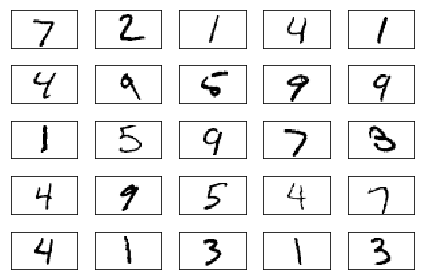

In [16]:
#init test data set
y_test_equal_evla_index = compute_index_logical_equal(y_test,eval_index)
y_test_no_equal_evla_index = compute_index_logical_not_equal(y_test,eval_index)

test_nagivate_lable = y_test[y_test_no_equal_evla_index]
test_nagivate = X_test_nor[y_test_no_equal_evla_index]

test_postitive = X_test_nor[y_test_equal_evla_index]
test_postitive_lable = y_test[y_test_equal_evla_index]
# print(test_postitive[:50])
print("test_postitive_lable : ",test_postitive_lable.shape,test_postitive_lable[:50])
print("test_nagivate_lable : ",test_nagivate_lable.shape,test_nagivate_lable[:50])
imgs_show(np.squeeze(test_nagivate[:25]),5,5)



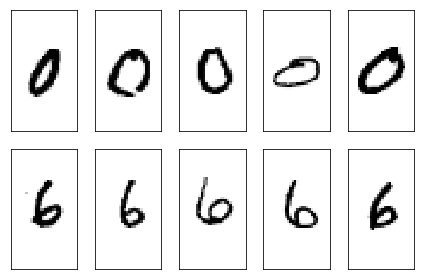

[0 0 0 0 0 6 6 6 6 6]


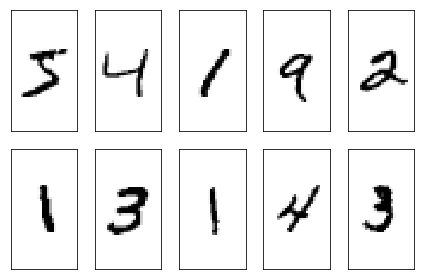

[5 4 1 9 2 1 3 1 4 3]
(48159, 1, 28, 28)


In [19]:
#init train data set
train_positive = []
label_positive =[]
np.random.seed(666)
for value in eval_index :
    
    shuffle_index_positive = np.random.permutation(len(X_train_nor[y_train == value]))
    train_positive.append(X_train_nor[y_train == value][shuffle_index_positive][:5])
    label_positive.append(y_train[y_train == value][shuffle_index_positive][:5])
train_positive = np.concatenate(train_positive)
label_positive = np.concatenate(label_positive)

imgs_show(np.squeeze(train_positive),2,5)
print(label_positive)


train_nagivate = X_train_nor[compute_index_logical_not_equal(y_train ,eval_index)]
label_nagivate = y_train[compute_index_logical_not_equal(y_train , eval_index)]
imgs_show(np.squeeze(train_nagivate[:10]),2,5)
print(label_nagivate[:10])
print(train_nagivate.shape)




In [20]:
def compute_index_logical_equal(inputs,indexs):
    logic_result = (inputs==indexs[0])
    for value in indexs:
        logic_result = np.logical_or(inputs == value,logic_result)
    return logic_result


In [48]:
class AutoCodeNet(nn.Module):
    def __init__(self):
        super(AutoCodeNet,self).__init__()
        self.conv1 = nn.Conv2d(1,8,kernel_size=3,stride=2,padding=1)
#         self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(8,16,kernel_size=3,stride=2,padding=1)
#         self.pool2 = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(16,24,kernel_size=3,stride=2,padding=1)
#         self.pool3 = nn.MaxPool2d(2,2,padding=1)

        self.fc1 = nn.Linear(24*4*4,100)
        self.fc2 = nn.Linear(100,10)
      
            
        
        self.up1 = nn.Upsample(scale_factor = 2,mode='nearest')
#         F.interpolate()
        self.conv_d1 = nn.Conv2d(24,16,kernel_size=3,stride=1,padding=1)
        self.up2 = nn.Upsample(scale_factor = 2)
        self.conv_d2 = nn.Conv2d(16,8,kernel_size=3,stride=1)
        self.up3 = nn.Upsample(scale_factor = 2)
        self.conv_d3 = nn.Conv2d(8,8,kernel_size=3,stride=1,padding=1)
        
        self.conv_d4 = nn.Conv2d(8,1,kernel_size=3,stride=1,padding=1)
        
        self.features={}
        
    def decodeForward(self,x):
        #decode
        x = F.leaky_relu(self.conv1(x))
        self.features['relu1'] = x
        
        x = F.leaky_relu(self.conv2(x))
        self.features['relu2'] = x
        
        x = F.leaky_relu(self.conv3(x))
        self.features['relu3'] = x
        
        return x
    
    def encodeforward(self,x):
        
        x_g = self.up1(x)
        self.features['up1'] = x_g
        x_g = F.leaky_relu(self.conv_d1(x_g))
        self.features['relu_d1'] = x_g
        
        x_g = self.up2(x_g)
        self.features['up2'] = x_g
        x_g = F.leaky_relu(self.conv_d2(x_g))
        self.features['relu_d2'] = x_g
        
        x_g = self.up3(x_g)
        self.features['up3'] = x_g
        x_g = F.leaky_relu(self.conv_d3(x_g))
        self.features['relu_d3'] =x_g
        
        x_g = self.conv_d4(x_g)
        self.features['conv_d4'] = x_g
        
        x_g = F.tanh(x_g)
        self.features['tanh'] = x_g
        return  x_g
    
    def class_forward(self,x):
        x_c = x.view(-1,self.num_flat_features(x))
        x_c = F.leaky_relu(self.fc1(x_c))
        x_c = F.dropout(x_c, training=self.training)
        x_c = self.fc2(x_c)
        x_c = F.log_softmax(x_c,dim=1)
        return x_c
    
    def num_flat_features(self,x):
        size = x.size()[1:]
        num_features =1

        for s in size:
            num_features *= s
        return num_features
        
        
    def forward(self,x):
        assert len(x) % 3 == 0
        
        #decode
        x = self.decodeForward(x)
#         print('x.size(): ',x.size())

        
        
        
            
            
        
        #class
        x_c = self.class_forward(x)
        
        #encode
        x_g = self.encodeforward(x)
        
        
        return x_g ,x_c
        
        
        
        
        
        
        

In [49]:
net_auto = AutoCodeNet()
# print(net_auto)
inp1 = Variable(torch.randn((30,1,28,28)))

out1,classs= net_auto(inp1)
print(net_auto.conv1.weight.data.size())
classs = torch.sum(classs)
classs.backward()
print("net_auto.conv_d1 grad:",net_auto.conv_d1.weight.grad)
print("net_auto.conv_1 grad:",net_auto.conv1.weight.grad)
# print(out1.size())
# print(classs.size())

# print("decode:")
# print(net_auto.features['relu1'].size())
# # print(net_auto.features['pool1'].size())
# print(net_auto.features['relu2'].size())
# # print(net_auto.features['pool2'].size())
# print(net_auto.features['relu3'].size())
# # print(net_auto.features['pool3'].size())

# print("encode:")
# print(net_auto.features['up1'].size())
# print(net_auto.features['relu_d1'].size())
# print(net_auto.features['up2'].size())
# print(net_auto.features['relu_d2'].size())
# print(net_auto.features['up3'].size())
# print(net_auto.features['relu_d3'].size())
# print(net_auto.features['conv_d4'].size())
# print(net_auto.features['tanh'].size())



torch.Size([8, 1, 3, 3])
net_auto.conv_d1 grad: None
net_auto.conv_1 grad: tensor([[[[ 0.0006,  0.0138,  0.0293],
          [-0.0290,  0.0193, -0.0003],
          [ 0.0027, -0.0201, -0.0197]]],


        [[[ 0.0078, -0.0057, -0.0036],
          [ 0.0206, -0.0293,  0.0139],
          [ 0.0090, -0.0033, -0.0232]]],


        [[[-0.0201, -0.0180, -0.0144],
          [-0.0058,  0.0057, -0.0098],
          [ 0.0069,  0.0037,  0.0137]]],


        [[[ 0.0029,  0.0178, -0.0022],
          [-0.0090, -0.0080,  0.0163],
          [-0.0211, -0.0059,  0.0354]]],


        [[[-0.0085,  0.0180, -0.0035],
          [-0.0212, -0.0068,  0.0127],
          [-0.0086,  0.0076,  0.0460]]],


        [[[-0.0072,  0.0002, -0.0007],
          [ 0.0069,  0.0023, -0.0221],
          [-0.0013, -0.0114, -0.0070]]],


        [[[ 0.0112,  0.0134,  0.0009],
          [-0.0110,  0.0184,  0.0010],
          [-0.0040, -0.0023,  0.0140]]],


        [[[ 0.0060, -0.0231,  0.0025],
          [-0.0065, -0.0048,  0.0065],


In [50]:
def getnext(train_x,train_y,batch_size):
    batchs = len(train_y) // batch_size
    print(len(train_y),batchs)

    for i in range(batchs):
        x = train_x[batch_size * i : batch_size * (i+1)]
        y = train_y[batch_size * i : batch_size * (i+1)]
        yield x,y
        

In [51]:
def get_nagivate_next(train_positive,train_nagivate):
    batch_size = len(train_positive) 
    batchs = len(train_nagivate) // batch_size
    print(len(train_nagivate),batchs)
    
    for i in range(batchs):
        x = np.concatenate((train_positive,train_nagivate[batch_size * i : batch_size * (i+1)]))
        y = np.concatenate((np.zeros(batch_size),np.ones(batch_size)))
        shuf_index = np.random.permutation(len(y))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x ,y 
        

In [52]:
def get_nagivate_batch_next(train_positive,train_nagivate,batch_size):
#     batch_size = len(train_positive) 
    batchs = len(train_nagivate) // batch_size
    print(len(train_nagivate),batchs)
    
    for i in range(batchs):
        x = np.concatenate((train_positive,train_nagivate[batch_size * i : batch_size * (i+1)]))
        y = np.concatenate((np.zeros(len(train_positive)),np.ones(len(train_nagivate))))
        shuf_index = np.random.permutation(len(x))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x ,y 

In [53]:
def get_next_posi_nag(train_positive,train_nagivate,label_positive, label_nagivate ,batch_size):
#     batch_size = len(train_positive) 
    batchs = len(train_nagivate) // batch_size
    print(len(train_nagivate),batchs)
    
    for i in range(batchs):
        x = np.concatenate((train_positive,train_nagivate[batch_size * i : batch_size * (i+1)]))
        y = np.concatenate((label_positive,label_nagivate[batch_size * i : batch_size * (i+1)]))
        shuf_index = np.random.permutation(len(x))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x ,y 

In [54]:
def get_next_pn_label(train_positive,train_nagivate,label_positive, label_nagivate):

    class_index_num =[]
    for i in range(1,10):
        class_index_num.append(len(train_nagivate[label_nagivate == i]))
    class_index_num = np.array(class_index_num)
    print('class_index_num = ',class_index_num)
    min_index_num = np.min(class_index_num)
    print('min_index_num = ',min_index_num)
    max_index_num = np.max(class_index_num)
    print('max_index_num = ',max_index_num)
    max_index_class = np.argmax(class_index_num) + 1
    print('max_index_class = ',max_index_class)
    batch_size = 2
    batchs = min_index_num // batch_size
    print('batchs = ',batchs)
    
    
    
    
    
    for i in range(batchs):
        x = train_positive
        y = label_positive
        for class_index in range(1,10):
            
            # batch_index < class len
            if batch_size * (i+1) <= class_index_num[class_index - 1] :
                
                x = np.concatenate( (x,train_nagivate[label_nagivate == class_index][batch_size * i : batch_size * (i+1)]))
                y = np.concatenate((y,label_nagivate[label_nagivate == class_index][batch_size * i : batch_size * (i+1)]))
        
        if len(x) < (3 * len(train_positive)) :
            x = np.concatenate((x,train_nagivate[label_nagivate == max_index_class][batch_size * (i+1) : batch_size * (i+2)]))
            y = np.concatenate((y,label_nagivate[label_nagivate == max_index_class][batch_size * (i+1) : batch_size * (i+2)]))

        shuf_index = np.random.permutation(len(x))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x,y 


In [55]:
def get_next_pn_label2(train_positive,train_nagivate,label_positive, label_nagivate):

    class_index_num =[]
    for value in negative_index:
        class_index_num.append(len(train_nagivate[label_nagivate == value]))
    
    class_index_num = np.array(class_index_num)
    # class_index_num = np.sort(class_index_num)
    print('class_index_num = ',class_index_num)
    
    sort_index_num = np.argsort(class_index_num)
    print('sort_index_num = ',sort_index_num)
    
    min_index_num = class_index_num[sort_index_num[0]]
    max_index_num = class_index_num[sort_index_num[-1]]
    print('min_index_num = ',min_index_num)
    print('max_index_num = ',max_index_num)
    
    max_index_class = negative_index[sort_index_num[-1]]
    max_second_index_class = negative_index[sort_index_num[-2]]
    print('max_index_class = ',max_index_class)
    print('max_second_index_class = ',max_second_index_class)
    
    batch_size = 2
    batchs = min_index_num // batch_size
    print('batchs = ',batchs)
    
    
    
    for i in range(batchs):
        x = []
        y = []
        x.append(train_positive)  
        y.append(label_positive)
        
        for sor_index in sort_index_num :
                class_index = negative_index[sor_index]
#                 print(class_index)
                x.append(train_nagivate[label_nagivate == class_index][batch_size * i : batch_size * (i+1)])
                y.append(label_nagivate[label_nagivate == class_index][batch_size * i : batch_size * (i+1)])
        
        
        x.append(train_nagivate[label_nagivate == max_index_class][-(batch_size * (i+2)):-(batch_size * (i+1)) ])
        y.append(label_nagivate[label_nagivate == max_index_class][-(batch_size * (i+2)):-(batch_size * (i+1)) ])
#         print(label_nagivate[(-batch_size * (i+2)):-2])
        x.append(train_nagivate[label_nagivate == max_second_index_class][-(batch_size * (i+2)):-(batch_size * (i+1)) ])
        y.append(label_nagivate[label_nagivate == max_second_index_class][-(batch_size * (i+2)):-(batch_size * (i+1)) ])
        
#         for i in range(len(x)):
#             print(x[i].shape)
        x = np.concatenate(x)
        y = np.concatenate(y)
        shuf_index = np.random.permutation(len(x))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x,y 

In [56]:
#     train_1 = train_nagivate[y_train == 1]
#     print("train_1.shape = ",train_1.shape)

#     train_2 = train_nagivate[y_train == 2]
#     print("train_2.shape = ",train_2.shape)

#     train_3 = train_nagivate[y_train == 3]
#     print("train_3.shape = ",train_3.shape)

#     train_4 = train_nagivate[y_train == 4]
#     print("train_0.shape = ",train_4.shape)


#     train_5 = train_nagivate[y_train == 5]
#     print("train_0.shape = ",train_5.shape)


#     train_6 = train_nagivate[y_train == 6]
#     print("train_6.shape = ",train_6.shape)

#     train_7 = train_nagivate[y_train == 7]
#     print("train_7.shape = ",train_7.shape)


#     train_8 = train_nagivate[y_train == 8]
#     print("train_8.shape = ",train_8.shape)


#     train_9 = train_nagivate[y_train == 9]
#     print("train_9.shape = ",train_9.shape)
                               
# train_0.shape =  (5923, 1, 28, 28)
# train_1.shape =  (6742, 1, 28, 28)
# train_2.shape =  (5958, 1, 28, 28)
# train_3.shape =  (6131, 1, 28, 28)
# train_4.shape =  (5842, 1, 28, 28)
# train_5.shape =  (5421, 1, 28, 28)
# train_6.shape =  (5918, 1, 28, 28)
# train_7.shape =  (6265, 1, 28, 28)
# train_8.shape =  (5851, 1, 28, 28)
# train_9.shape =  (5949, 1, 28, 28)

class_index_num =  [12 18  9 14  9 11 15 12]
sort_index_num =  [2 4 5 0 7 3 6 1]
min_index_num =  9
max_index_num =  18
max_index_class =  2
max_second_index_class =  8
batchs =  4
(30, 1, 28, 28)
[0 0 6 8 7 5 2 6 8 9 2 0 9 6 1 7 4 4 6 8 3 3 2 0 8 0 5 2 1 6]


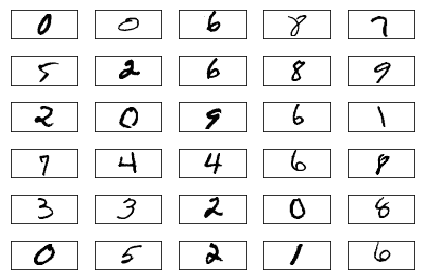

(30, 1, 28, 28)
[5 7 0 6 2 8 2 3 0 6 3 4 7 0 6 1 1 9 8 2 4 6 8 9 6 2 0 8 0 5]


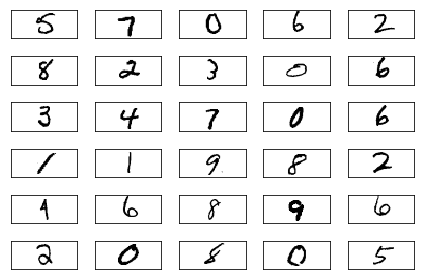

(30, 1, 28, 28)
[8 0 6 2 0 6 5 2 6 8 7 0 4 3 1 6 1 4 7 0 2 9 8 5 0 2 3 6 8 9]


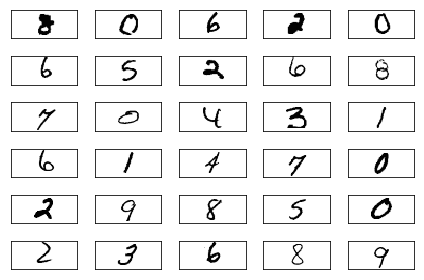

(30, 1, 28, 28)
[6 0 8 2 8 3 5 0 6 5 1 8 6 2 3 4 4 6 7 1 2 0 6 0 8 9 9 2 0 7]


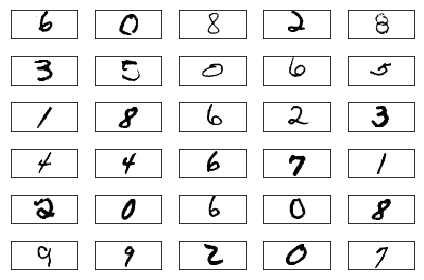

In [57]:
datas = get_next_pn_label2(train_positive,train_nagivate[1100:1200],label_positive,label_nagivate[1100:1200])
for x,y in datas:
    print(x.shape)
    
    print(y)
    imgs_show(np.squeeze( x),6,5)


In [58]:
net_auto = AutoCodeNet()
# net_auto.load_state_dict(torch.load('model_asociate_learning_simple5.pt'))

In [64]:

# net_auto = torch.load('model_autoEncode5.pkl')
use_cuda = torch.cuda.is_available()
torch.manual_seed(666)
device = torch.device("cuda" if use_cuda else "cpu")
net_auto.to(device)
net_auto.float()


criterion = nn.MSELoss()
optimizer = optim.SGD(net_auto.parameters(),lr=0.001,momentum=0.9,weight_decay=5e-4)


In [65]:
#X_train_nor


for epoch in range(50):
    #train:
    net_auto.train()
    shuf_nagivate = np.random.permutation(len(train_nagivate))
    train_nagivate = train_nagivate[shuf_nagivate]
    label_nagivate = label_nagivate[shuf_nagivate]
#     datas = get_next_posi_nag(train_positive,train_nagivate,label_positive,label_nagivate, 10)
    datas = get_next_pn_label2(train_positive,train_nagivate,label_positive,label_nagivate)
    
    trainloss_g = 0
    trainloss_c = 0
    
    for x,y in datas:
        inputs ,lables = torch.from_numpy(x).float().to(device),\
            torch.from_numpy(y).long().to(device)
            
#         print(inputs.size())
#         print(lables[0])
        optimizer.zero_grad()
        output,classify = net_auto(inputs)
#         print(output.size())
#         print(classify.size())
        loss_g = criterion(output,inputs) 
        loss_c = F.nll_loss(classify,lables)
#         loss_c2 = F.nll_loss(classify2,lables_2)
        loss = loss_g + loss_c
        loss.backward()
        
        print('loss_g = %.4f,loss_c =%.4f'%(loss_g.item(),loss_c.item()))
        trainloss_g += loss_g.item()
        trainloss_c += loss_c.item()
#         print("net_auto.conv_d1 grad:",net_auto.conv_d1.weight.grad)
        
#         print("after net_auto.conv_1 grad:",net_auto.conv1.weight.grad)
        optimizer.step()
        
    print('%d  gloss: %.3f, class loss:%.3f' % (epoch ,  trainloss_g,trainloss_c))
    
    
    torch.save(net_auto.state_dict(),'model_few_shot_class_only'+str(epoch)+'.pt')
    


class_index_num =  [6742 5958 6131 5842 5421 6265 5851 5949]
sort_index_num =  [4 3 6 7 1 2 5 0]
min_index_num =  5421
max_index_num =  6742
max_index_class =  1
max_second_index_class =  7
batchs =  2710
loss_g = 0.7333,loss_c =2.1539
loss_g = 0.7297,loss_c =2.1358
loss_g = 0.7275,loss_c =2.1670
loss_g = 0.7176,loss_c =2.1641
loss_g = 0.7178,loss_c =2.2127
loss_g = 0.7067,loss_c =2.1963
loss_g = 0.7021,loss_c =2.1501
loss_g = 0.6919,loss_c =2.1284
loss_g = 0.6838,loss_c =2.1897
loss_g = 0.6785,loss_c =2.1703
loss_g = 0.6615,loss_c =2.1876
loss_g = 0.6569,loss_c =2.2021
loss_g = 0.6406,loss_c =2.1860
loss_g = 0.6275,loss_c =2.1866
loss_g = 0.6312,loss_c =2.1698
loss_g = 0.6087,loss_c =2.1793
loss_g = 0.5953,loss_c =2.1568
loss_g = 0.5885,loss_c =2.1364
loss_g = 0.5776,loss_c =2.2177
loss_g = 0.5627,loss_c =2.2049
loss_g = 0.5559,loss_c =2.1670
loss_g = 0.5463,loss_c =2.2181
loss_g = 0.5334,loss_c =2.2156
loss_g = 0.5263,loss_c =2.2090
loss_g = 0.5228,loss_c =2.1511
loss_g = 0.5214,loss

loss_g = 0.2943,loss_c =1.4891
loss_g = 0.3077,loss_c =1.6064
loss_g = 0.2923,loss_c =1.5813
loss_g = 0.2893,loss_c =1.5696
loss_g = 0.2938,loss_c =1.6061
loss_g = 0.2931,loss_c =1.6637
loss_g = 0.2958,loss_c =1.5903
loss_g = 0.2909,loss_c =1.6809
loss_g = 0.2883,loss_c =1.6196
loss_g = 0.2890,loss_c =1.5111
loss_g = 0.3062,loss_c =1.4402
loss_g = 0.2926,loss_c =1.5336
loss_g = 0.2944,loss_c =1.6544
loss_g = 0.2858,loss_c =1.5569
loss_g = 0.2941,loss_c =1.5357
loss_g = 0.2770,loss_c =1.5590
loss_g = 0.2835,loss_c =1.5387
loss_g = 0.2860,loss_c =1.5493
loss_g = 0.2854,loss_c =1.5178
loss_g = 0.2685,loss_c =1.4705
loss_g = 0.2781,loss_c =1.4604
loss_g = 0.2844,loss_c =1.6185
loss_g = 0.3064,loss_c =1.4874
loss_g = 0.2738,loss_c =1.6190
loss_g = 0.2832,loss_c =1.4994
loss_g = 0.2795,loss_c =1.5507
loss_g = 0.2936,loss_c =1.4111
loss_g = 0.2873,loss_c =1.4337
loss_g = 0.2860,loss_c =1.5025
loss_g = 0.2616,loss_c =1.4588
loss_g = 0.2755,loss_c =1.4205
loss_g = 0.2732,loss_c =1.3186
loss_g =

loss_g = 0.1747,loss_c =0.8192
loss_g = 0.1638,loss_c =0.6515
loss_g = 0.1595,loss_c =0.6140
loss_g = 0.1605,loss_c =0.5886
loss_g = 0.1520,loss_c =0.8153
loss_g = 0.1611,loss_c =0.5558
loss_g = 0.1662,loss_c =0.8197
loss_g = 0.1613,loss_c =0.7175
loss_g = 0.1722,loss_c =0.8189
loss_g = 0.1542,loss_c =0.5978
loss_g = 0.1600,loss_c =0.6585
loss_g = 0.1671,loss_c =0.7218
loss_g = 0.1669,loss_c =0.7260
loss_g = 0.1636,loss_c =0.5240
loss_g = 0.1651,loss_c =0.5995
loss_g = 0.1573,loss_c =0.8641
loss_g = 0.1580,loss_c =0.8221
loss_g = 0.1602,loss_c =0.7197
loss_g = 0.1526,loss_c =0.6723
loss_g = 0.1585,loss_c =0.6777
loss_g = 0.1488,loss_c =0.7675
loss_g = 0.1555,loss_c =0.6483
loss_g = 0.1582,loss_c =0.6885
loss_g = 0.1587,loss_c =0.6958
loss_g = 0.1534,loss_c =0.5369
loss_g = 0.1520,loss_c =0.6047
loss_g = 0.1511,loss_c =0.9214
loss_g = 0.1526,loss_c =0.7083
loss_g = 0.1501,loss_c =1.0978
loss_g = 0.1573,loss_c =0.7017
loss_g = 0.1557,loss_c =0.6735
loss_g = 0.1526,loss_c =0.6053
loss_g =

loss_g = 0.1409,loss_c =0.4571
loss_g = 0.1358,loss_c =0.3862
loss_g = 0.1412,loss_c =0.8131
loss_g = 0.1386,loss_c =0.3338
loss_g = 0.1389,loss_c =0.5248
loss_g = 0.1445,loss_c =0.6958
loss_g = 0.1454,loss_c =0.4835
loss_g = 0.1398,loss_c =0.4325
loss_g = 0.1285,loss_c =0.5885
loss_g = 0.1364,loss_c =0.5057
loss_g = 0.1342,loss_c =0.5282
loss_g = 0.1320,loss_c =0.3424
loss_g = 0.1276,loss_c =0.6032
loss_g = 0.1379,loss_c =0.4790
loss_g = 0.1323,loss_c =0.5976
loss_g = 0.1273,loss_c =0.7734
loss_g = 0.1308,loss_c =0.6097
loss_g = 0.1365,loss_c =0.5059
loss_g = 0.1317,loss_c =0.7007
loss_g = 0.1397,loss_c =0.6622
loss_g = 0.1315,loss_c =0.3531
loss_g = 0.1393,loss_c =0.4709
loss_g = 0.1335,loss_c =0.7448
loss_g = 0.1344,loss_c =0.4479
loss_g = 0.1366,loss_c =0.6834
loss_g = 0.1408,loss_c =0.6803
loss_g = 0.1345,loss_c =0.2522
loss_g = 0.1386,loss_c =0.6544
loss_g = 0.1361,loss_c =0.6086
loss_g = 0.1346,loss_c =0.5853
loss_g = 0.1310,loss_c =0.6568
loss_g = 0.1315,loss_c =0.5021
loss_g =

loss_g = 0.1214,loss_c =0.5046
loss_g = 0.1227,loss_c =0.6081
loss_g = 0.1192,loss_c =0.3442
loss_g = 0.1194,loss_c =0.2583
loss_g = 0.1210,loss_c =0.4174
loss_g = 0.1315,loss_c =0.5905
loss_g = 0.1282,loss_c =0.4067
loss_g = 0.1300,loss_c =0.2939
loss_g = 0.1196,loss_c =0.7455
loss_g = 0.1285,loss_c =0.2834
loss_g = 0.1234,loss_c =0.3681
loss_g = 0.1220,loss_c =0.3764
loss_g = 0.1239,loss_c =0.4642
loss_g = 0.1225,loss_c =0.4920
loss_g = 0.1230,loss_c =0.3566
loss_g = 0.1236,loss_c =0.4469
loss_g = 0.1248,loss_c =0.5608
loss_g = 0.1174,loss_c =0.5908
loss_g = 0.1212,loss_c =0.3360
loss_g = 0.1367,loss_c =0.2834
loss_g = 0.1207,loss_c =0.8152
loss_g = 0.1196,loss_c =0.3972
loss_g = 0.1205,loss_c =0.3930
loss_g = 0.1242,loss_c =0.4118
loss_g = 0.1294,loss_c =0.4888
loss_g = 0.1216,loss_c =0.4873
loss_g = 0.1243,loss_c =0.4994
loss_g = 0.1294,loss_c =0.4199
loss_g = 0.1207,loss_c =0.4963
loss_g = 0.1252,loss_c =0.4766
loss_g = 0.1220,loss_c =0.4896
loss_g = 0.1157,loss_c =0.5370
loss_g =

loss_g = 0.1133,loss_c =0.7127
loss_g = 0.1084,loss_c =0.7808
loss_g = 0.1183,loss_c =0.2412
loss_g = 0.1198,loss_c =0.6642
loss_g = 0.0999,loss_c =0.6146
loss_g = 0.1231,loss_c =0.7772
loss_g = 0.1111,loss_c =0.3820
loss_g = 0.1060,loss_c =0.4171
loss_g = 0.1122,loss_c =0.3998
loss_g = 0.1151,loss_c =0.3323
loss_g = 0.1148,loss_c =0.5361
loss_g = 0.1103,loss_c =0.4404
loss_g = 0.1117,loss_c =0.5622
loss_g = 0.1175,loss_c =0.2598
loss_g = 0.1184,loss_c =0.5009
loss_g = 0.1061,loss_c =0.4471
loss_g = 0.1209,loss_c =0.5884
loss_g = 0.1086,loss_c =0.7462
loss_g = 0.1256,loss_c =0.3803
loss_g = 0.1114,loss_c =0.3050
loss_g = 0.1154,loss_c =0.3584
loss_g = 0.1111,loss_c =0.3109
loss_g = 0.1144,loss_c =0.2520
loss_g = 0.1134,loss_c =0.3049
loss_g = 0.1125,loss_c =0.3053
loss_g = 0.1148,loss_c =0.4136
loss_g = 0.1147,loss_c =0.3801
loss_g = 0.1136,loss_c =0.6124
loss_g = 0.1119,loss_c =0.3768
loss_g = 0.1060,loss_c =0.7001
loss_g = 0.1129,loss_c =0.6088
loss_g = 0.1173,loss_c =0.4941
loss_g =

loss_g = 0.1116,loss_c =0.3305
loss_g = 0.1062,loss_c =0.2243
loss_g = 0.1208,loss_c =1.0317
loss_g = 0.0985,loss_c =0.5611
loss_g = 0.1090,loss_c =0.1882
loss_g = 0.1001,loss_c =0.3679
loss_g = 0.0979,loss_c =0.4277
loss_g = 0.1074,loss_c =0.4945
loss_g = 0.0979,loss_c =0.5269
loss_g = 0.1023,loss_c =0.3849
loss_g = 0.1095,loss_c =0.3837
loss_g = 0.0999,loss_c =0.1980
loss_g = 0.1057,loss_c =0.5692
loss_g = 0.0961,loss_c =0.5614
loss_g = 0.0949,loss_c =0.4132
loss_g = 0.1010,loss_c =0.3620
loss_g = 0.1028,loss_c =0.5320
loss_g = 0.1003,loss_c =0.4043
loss_g = 0.1064,loss_c =0.4735
loss_g = 0.1177,loss_c =0.4958
loss_g = 0.1069,loss_c =0.2587
loss_g = 0.1029,loss_c =0.3279
loss_g = 0.1020,loss_c =0.4655
loss_g = 0.1072,loss_c =0.3572
loss_g = 0.1037,loss_c =0.3029
loss_g = 0.1094,loss_c =0.2997
loss_g = 0.1021,loss_c =0.4320
loss_g = 0.1099,loss_c =0.6320
loss_g = 0.1079,loss_c =0.4338
loss_g = 0.1121,loss_c =0.3503
loss_g = 0.1003,loss_c =0.5626
loss_g = 0.1099,loss_c =0.5239
loss_g =

loss_g = 0.1018,loss_c =0.4992
loss_g = 0.0998,loss_c =0.4309
loss_g = 0.0936,loss_c =0.2471
loss_g = 0.1004,loss_c =0.4159
loss_g = 0.0919,loss_c =0.3244
loss_g = 0.0992,loss_c =0.3782
loss_g = 0.0928,loss_c =0.2911
loss_g = 0.0928,loss_c =0.2184
loss_g = 0.0905,loss_c =0.2581
loss_g = 0.0987,loss_c =0.3284
loss_g = 0.0901,loss_c =0.9135
loss_g = 0.0967,loss_c =0.2212
loss_g = 0.1044,loss_c =0.4230
loss_g = 0.0972,loss_c =0.5134
loss_g = 0.0931,loss_c =0.3565
loss_g = 0.0927,loss_c =0.1313
loss_g = 0.1000,loss_c =0.3697
loss_g = 0.0992,loss_c =0.3499
loss_g = 0.1036,loss_c =0.3272
loss_g = 0.0945,loss_c =0.2016
loss_g = 0.1051,loss_c =0.2496
loss_g = 0.0907,loss_c =0.2024
loss_g = 0.1033,loss_c =0.2137
loss_g = 0.0939,loss_c =0.3248
loss_g = 0.0980,loss_c =0.3481
loss_g = 0.0976,loss_c =0.2998
loss_g = 0.0967,loss_c =0.4070
loss_g = 0.0939,loss_c =0.3943
loss_g = 0.1014,loss_c =0.1881
loss_g = 0.0998,loss_c =0.4064
loss_g = 0.1000,loss_c =0.2832
loss_g = 0.0946,loss_c =0.8640
loss_g =

loss_g = 0.0902,loss_c =0.3655
loss_g = 0.0936,loss_c =0.2245
loss_g = 0.0933,loss_c =0.8873
loss_g = 0.0938,loss_c =0.2850
loss_g = 0.0970,loss_c =0.3958
loss_g = 0.0962,loss_c =0.4898
loss_g = 0.0943,loss_c =0.3929
loss_g = 0.1019,loss_c =0.5569
loss_g = 0.0922,loss_c =0.4500
loss_g = 0.0946,loss_c =0.3464
loss_g = 0.0980,loss_c =0.1380
loss_g = 0.0884,loss_c =0.1762
loss_g = 0.0930,loss_c =0.3290
loss_g = 0.0935,loss_c =0.3659
loss_g = 0.0894,loss_c =0.2118
loss_g = 0.1017,loss_c =0.3664
loss_g = 0.0926,loss_c =0.3862
loss_g = 0.0931,loss_c =0.2167
loss_g = 0.0910,loss_c =0.4306
loss_g = 0.1015,loss_c =0.1883
loss_g = 0.0978,loss_c =0.5886
loss_g = 0.0808,loss_c =0.2183
loss_g = 0.0976,loss_c =0.3447
loss_g = 0.0937,loss_c =0.2691
loss_g = 0.0900,loss_c =0.3866
loss_g = 0.0917,loss_c =0.4940
loss_g = 0.0930,loss_c =0.3810
loss_g = 0.0960,loss_c =0.1778
loss_g = 0.0885,loss_c =0.3219
loss_g = 0.0937,loss_c =0.3234
loss_g = 0.1057,loss_c =0.6371
loss_g = 0.0895,loss_c =0.3779
loss_g =

loss_g = 0.0833,loss_c =0.2754
loss_g = 0.0830,loss_c =0.1952
loss_g = 0.0845,loss_c =0.7778
loss_g = 0.0916,loss_c =0.3116
loss_g = 0.0917,loss_c =0.3058
loss_g = 0.0893,loss_c =0.1285
loss_g = 0.0945,loss_c =0.5360
loss_g = 0.0852,loss_c =0.2504
loss_g = 0.0915,loss_c =0.2282
loss_g = 0.0869,loss_c =0.2123
loss_g = 0.0871,loss_c =0.2153
loss_g = 0.0830,loss_c =0.2143
loss_g = 0.0887,loss_c =0.7376
loss_g = 0.0945,loss_c =0.3581
loss_g = 0.0915,loss_c =0.3829
loss_g = 0.0854,loss_c =0.2507
loss_g = 0.0933,loss_c =0.2479
loss_g = 0.0901,loss_c =0.2229
loss_g = 0.0876,loss_c =0.3195
loss_g = 0.0880,loss_c =0.1715
loss_g = 0.0885,loss_c =0.8509
loss_g = 0.0962,loss_c =0.2466
loss_g = 0.0965,loss_c =0.5511
loss_g = 0.0859,loss_c =0.1355
loss_g = 0.0822,loss_c =0.3499
loss_g = 0.0898,loss_c =0.2656
loss_g = 0.0856,loss_c =0.2849
loss_g = 0.0868,loss_c =0.2768
loss_g = 0.0883,loss_c =0.5062
loss_g = 0.0865,loss_c =0.2951
loss_g = 0.0887,loss_c =0.1883
loss_g = 0.0818,loss_c =0.2659
loss_g =

loss_g = 0.0817,loss_c =0.1765
loss_g = 0.0792,loss_c =0.1999
loss_g = 0.0841,loss_c =0.2491
loss_g = 0.0881,loss_c =0.3078
loss_g = 0.0836,loss_c =0.2301
loss_g = 0.0889,loss_c =0.2621
loss_g = 0.0817,loss_c =0.1627
loss_g = 0.0896,loss_c =0.1437
loss_g = 0.0975,loss_c =0.3222
loss_g = 0.0841,loss_c =0.4866
loss_g = 0.0784,loss_c =0.1611
loss_g = 0.0867,loss_c =0.3523
loss_g = 0.0905,loss_c =0.3741
loss_g = 0.0813,loss_c =0.2973
loss_g = 0.0875,loss_c =0.3474
loss_g = 0.0853,loss_c =0.2960
loss_g = 0.0905,loss_c =0.1671
loss_g = 0.0870,loss_c =0.2143
loss_g = 0.0873,loss_c =0.5570
loss_g = 0.0870,loss_c =0.3480
loss_g = 0.0856,loss_c =0.3645
loss_g = 0.0861,loss_c =0.2449
loss_g = 0.0826,loss_c =0.2843
loss_g = 0.0806,loss_c =0.5307
loss_g = 0.0903,loss_c =0.3442
loss_g = 0.0883,loss_c =0.1820
loss_g = 0.0877,loss_c =0.2510
loss_g = 0.0880,loss_c =0.2132
loss_g = 0.0863,loss_c =0.4948
loss_g = 0.0858,loss_c =0.2053
loss_g = 0.0896,loss_c =0.3249
loss_g = 0.0906,loss_c =0.3135
loss_g =

loss_g = 0.0717,loss_c =0.3790
loss_g = 0.0811,loss_c =0.3138
loss_g = 0.0741,loss_c =0.5607
loss_g = 0.0809,loss_c =0.2682
loss_g = 0.0854,loss_c =0.2177
loss_g = 0.0759,loss_c =0.3374
loss_g = 0.0862,loss_c =0.3124
loss_g = 0.0783,loss_c =0.2213
loss_g = 0.0906,loss_c =0.1991
loss_g = 0.0858,loss_c =0.1930
loss_g = 0.0819,loss_c =0.1317
loss_g = 0.0732,loss_c =0.1701
loss_g = 0.0839,loss_c =0.1440
loss_g = 0.0878,loss_c =0.5973
loss_g = 0.0847,loss_c =0.4698
loss_g = 0.0883,loss_c =0.2063
loss_g = 0.0721,loss_c =0.2353
loss_g = 0.0795,loss_c =0.1758
loss_g = 0.0879,loss_c =0.4322
loss_g = 0.0903,loss_c =0.3799
loss_g = 0.0858,loss_c =0.4843
loss_g = 0.0885,loss_c =0.1983
loss_g = 0.0795,loss_c =0.6919
loss_g = 0.0789,loss_c =0.5117
loss_g = 0.0757,loss_c =0.1341
loss_g = 0.0857,loss_c =0.1508
loss_g = 0.0823,loss_c =0.2131
loss_g = 0.0851,loss_c =0.2018
loss_g = 0.0819,loss_c =0.2852
loss_g = 0.0759,loss_c =0.1740
loss_g = 0.0800,loss_c =0.2097
loss_g = 0.0815,loss_c =0.4164
loss_g =

loss_g = 0.0862,loss_c =0.2765
loss_g = 0.0795,loss_c =0.1571
loss_g = 0.0788,loss_c =0.5123
loss_g = 0.0794,loss_c =0.5244
loss_g = 0.0738,loss_c =0.0932
loss_g = 0.0801,loss_c =0.0837
loss_g = 0.0838,loss_c =0.2199
loss_g = 0.0856,loss_c =0.6011
loss_g = 0.0890,loss_c =0.2453
loss_g = 0.0741,loss_c =0.2355
loss_g = 0.0719,loss_c =0.2214
loss_g = 0.0698,loss_c =0.0600
loss_g = 0.0773,loss_c =0.2236
loss_g = 0.0760,loss_c =0.2326
loss_g = 0.0767,loss_c =0.2727
loss_g = 0.0819,loss_c =0.2853
loss_g = 0.0777,loss_c =0.3780
loss_g = 0.0748,loss_c =0.4107
loss_g = 0.0793,loss_c =0.3576
loss_g = 0.0710,loss_c =0.1727
loss_g = 0.0811,loss_c =0.1618
loss_g = 0.0750,loss_c =0.2235
loss_g = 0.0796,loss_c =0.2781
loss_g = 0.0821,loss_c =0.7476
loss_g = 0.0900,loss_c =0.2328
loss_g = 0.0763,loss_c =0.0928
loss_g = 0.0821,loss_c =0.5936
loss_g = 0.0808,loss_c =0.2203
loss_g = 0.0848,loss_c =0.1548
loss_g = 0.0822,loss_c =0.3495
loss_g = 0.0777,loss_c =0.5042
loss_g = 0.0845,loss_c =0.4954
loss_g =

loss_g = 0.0797,loss_c =0.3026
loss_g = 0.0871,loss_c =0.3709
loss_g = 0.0780,loss_c =0.2962
loss_g = 0.0799,loss_c =0.2113
loss_g = 0.0729,loss_c =0.2045
loss_g = 0.0770,loss_c =0.1515
loss_g = 0.0783,loss_c =0.2118
loss_g = 0.0848,loss_c =0.3916
loss_g = 0.0773,loss_c =0.0592
loss_g = 0.0796,loss_c =0.1413
loss_g = 0.0756,loss_c =0.2313
loss_g = 0.0812,loss_c =0.3145
loss_g = 0.0845,loss_c =0.1598
loss_g = 0.0758,loss_c =0.3921
loss_g = 0.0829,loss_c =0.3263
loss_g = 0.0725,loss_c =0.4673
loss_g = 0.0753,loss_c =0.4979
loss_g = 0.0781,loss_c =0.2688
loss_g = 0.0701,loss_c =0.0618
loss_g = 0.0755,loss_c =0.6544
loss_g = 0.0683,loss_c =0.2632
loss_g = 0.0734,loss_c =0.1347
loss_g = 0.0838,loss_c =0.4977
loss_g = 0.0792,loss_c =0.3920
loss_g = 0.0874,loss_c =0.1598
loss_g = 0.0704,loss_c =0.1279
loss_g = 0.0806,loss_c =0.2384
loss_g = 0.0783,loss_c =0.1890
loss_g = 0.0747,loss_c =0.6472
loss_g = 0.0765,loss_c =0.1390
loss_g = 0.0799,loss_c =0.5551
loss_g = 0.0715,loss_c =0.2347
loss_g =

loss_g = 0.0730,loss_c =0.3377
loss_g = 0.0728,loss_c =0.0958
loss_g = 0.0672,loss_c =0.3777
loss_g = 0.0758,loss_c =0.2801
loss_g = 0.0705,loss_c =0.1076
loss_g = 0.0811,loss_c =0.1440
loss_g = 0.0720,loss_c =0.0659
loss_g = 0.0711,loss_c =0.3189
loss_g = 0.0705,loss_c =0.1071
loss_g = 0.0707,loss_c =0.1446
loss_g = 0.0748,loss_c =0.4112
loss_g = 0.0827,loss_c =0.9592
loss_g = 0.0724,loss_c =0.1117
loss_g = 0.0727,loss_c =0.2255
loss_g = 0.0760,loss_c =0.5392
loss_g = 0.0767,loss_c =0.4158
loss_g = 0.0819,loss_c =0.4897
loss_g = 0.0730,loss_c =0.2346
loss_g = 0.0710,loss_c =0.2384
loss_g = 0.0748,loss_c =0.1366
loss_g = 0.0763,loss_c =0.1769
loss_g = 0.0731,loss_c =0.3350
loss_g = 0.0707,loss_c =0.3453
loss_g = 0.0738,loss_c =0.1134
loss_g = 0.0734,loss_c =0.1620
loss_g = 0.0728,loss_c =0.4311
loss_g = 0.0794,loss_c =0.1753
loss_g = 0.0740,loss_c =0.1755
loss_g = 0.0742,loss_c =0.2022
loss_g = 0.0687,loss_c =0.0933
loss_g = 0.0698,loss_c =0.2822
loss_g = 0.0791,loss_c =0.5432
loss_g =

loss_g = 0.0667,loss_c =0.1683
loss_g = 0.0745,loss_c =0.2060
loss_g = 0.0627,loss_c =0.1418
loss_g = 0.0703,loss_c =0.1596
loss_g = 0.0693,loss_c =0.2000
loss_g = 0.0726,loss_c =0.0802
loss_g = 0.0786,loss_c =0.1938
loss_g = 0.0711,loss_c =0.1201
loss_g = 0.0713,loss_c =0.1683
loss_g = 0.0728,loss_c =0.5365
loss_g = 0.0676,loss_c =0.1638
loss_g = 0.0619,loss_c =0.2174
loss_g = 0.0706,loss_c =0.2754
loss_g = 0.0692,loss_c =0.1015
loss_g = 0.0787,loss_c =0.2467
loss_g = 0.0775,loss_c =0.5220
loss_g = 0.0710,loss_c =0.0826
loss_g = 0.0764,loss_c =0.2717
loss_g = 0.0722,loss_c =0.4394
loss_g = 0.0718,loss_c =0.1510
loss_g = 0.0769,loss_c =0.1594
loss_g = 0.0648,loss_c =0.2359
loss_g = 0.0715,loss_c =0.1203
loss_g = 0.0788,loss_c =0.1300
loss_g = 0.0779,loss_c =0.2396
loss_g = 0.0733,loss_c =0.2109
loss_g = 0.0732,loss_c =0.1988
loss_g = 0.0718,loss_c =0.4822
loss_g = 0.0744,loss_c =0.0843
loss_g = 0.0719,loss_c =0.1753
loss_g = 0.0739,loss_c =0.3271
loss_g = 0.0643,loss_c =0.3396
loss_g =

loss_g = 0.0699,loss_c =0.0944
loss_g = 0.0729,loss_c =0.1928
loss_g = 0.0729,loss_c =0.2483
loss_g = 0.0731,loss_c =0.4171
loss_g = 0.0724,loss_c =0.1638
loss_g = 0.0665,loss_c =0.1231
loss_g = 0.0677,loss_c =0.2154
loss_g = 0.0780,loss_c =0.5835
loss_g = 0.0741,loss_c =0.1197
loss_g = 0.0694,loss_c =0.1273
loss_g = 0.0678,loss_c =0.1021
loss_g = 0.0727,loss_c =0.1337
loss_g = 0.0757,loss_c =0.1501
loss_g = 0.0783,loss_c =0.5789
loss_g = 0.0772,loss_c =0.0793
loss_g = 0.0687,loss_c =0.1761
loss_g = 0.0656,loss_c =0.6827
loss_g = 0.0680,loss_c =0.2017
loss_g = 0.0704,loss_c =0.2173
loss_g = 0.0743,loss_c =0.2826
loss_g = 0.0674,loss_c =0.1134
loss_g = 0.0753,loss_c =0.2649
loss_g = 0.0740,loss_c =0.2097
loss_g = 0.0760,loss_c =0.1300
loss_g = 0.0668,loss_c =0.2010
loss_g = 0.0687,loss_c =0.7230
loss_g = 0.0736,loss_c =0.3207
loss_g = 0.0681,loss_c =0.0620
loss_g = 0.0668,loss_c =0.1886
loss_g = 0.0654,loss_c =0.2197
loss_g = 0.0660,loss_c =0.3107
loss_g = 0.0718,loss_c =0.0910
loss_g =

loss_g = 0.0655,loss_c =0.5263
loss_g = 0.0647,loss_c =0.2618
loss_g = 0.0679,loss_c =0.4765
loss_g = 0.0733,loss_c =0.3214
loss_g = 0.0703,loss_c =0.1861
loss_g = 0.0638,loss_c =0.2011
loss_g = 0.0668,loss_c =0.2795
loss_g = 0.0780,loss_c =0.2310
loss_g = 0.0696,loss_c =0.3004
loss_g = 0.0683,loss_c =0.1291
loss_g = 0.0690,loss_c =0.1973
loss_g = 0.0660,loss_c =0.1809
loss_g = 0.0654,loss_c =0.1553
loss_g = 0.0637,loss_c =0.3741
loss_g = 0.0651,loss_c =0.1302
loss_g = 0.0665,loss_c =0.1373
loss_g = 0.0656,loss_c =0.2851
loss_g = 0.0672,loss_c =0.1257
loss_g = 0.0626,loss_c =0.1874
loss_g = 0.0713,loss_c =0.3101
loss_g = 0.0652,loss_c =0.2416
loss_g = 0.0659,loss_c =0.2491
loss_g = 0.0686,loss_c =0.1639
loss_g = 0.0659,loss_c =0.1296
loss_g = 0.0790,loss_c =0.2650
loss_g = 0.0672,loss_c =0.3133
loss_g = 0.0692,loss_c =0.1664
loss_g = 0.0682,loss_c =0.1534
loss_g = 0.0662,loss_c =0.1694
loss_g = 0.0662,loss_c =0.1208
loss_g = 0.0643,loss_c =0.3650
loss_g = 0.0599,loss_c =0.0411
loss_g =

loss_g = 0.0689,loss_c =0.4754
loss_g = 0.0707,loss_c =0.0575
loss_g = 0.0663,loss_c =0.3261
loss_g = 0.0663,loss_c =0.1665
loss_g = 0.0665,loss_c =0.2334
loss_g = 0.0722,loss_c =0.1518
loss_g = 0.0678,loss_c =0.3640
loss_g = 0.0674,loss_c =0.2176
loss_g = 0.0659,loss_c =0.1997
loss_g = 0.0645,loss_c =0.0288
loss_g = 0.0666,loss_c =0.0651
loss_g = 0.0728,loss_c =0.1932
loss_g = 0.0649,loss_c =0.2082
loss_g = 0.0689,loss_c =0.2085
loss_g = 0.0639,loss_c =0.1114
loss_g = 0.0732,loss_c =0.1166
loss_g = 0.0576,loss_c =0.1037
loss_g = 0.0666,loss_c =0.1521
loss_g = 0.0692,loss_c =0.0775
loss_g = 0.0694,loss_c =0.1903
loss_g = 0.0674,loss_c =0.5054
loss_g = 0.0709,loss_c =0.1126
loss_g = 0.0701,loss_c =0.1024
loss_g = 0.0650,loss_c =0.1666
loss_g = 0.0724,loss_c =0.0859
loss_g = 0.0726,loss_c =0.0988
loss_g = 0.0688,loss_c =0.3035
loss_g = 0.0697,loss_c =0.1528
loss_g = 0.0754,loss_c =0.1143
loss_g = 0.0675,loss_c =0.1652
loss_g = 0.0682,loss_c =0.3771
loss_g = 0.0663,loss_c =0.2773
loss_g =

loss_g = 0.0591,loss_c =0.1011
loss_g = 0.0607,loss_c =0.0960
loss_g = 0.0606,loss_c =0.1620
loss_g = 0.0588,loss_c =0.1308
loss_g = 0.0677,loss_c =0.2813
loss_g = 0.0622,loss_c =0.1952
loss_g = 0.0669,loss_c =0.1213
loss_g = 0.0664,loss_c =0.1127
loss_g = 0.0642,loss_c =0.1520
loss_g = 0.0687,loss_c =0.2247
loss_g = 0.0592,loss_c =0.3143
loss_g = 0.0671,loss_c =0.1844
loss_g = 0.0679,loss_c =0.3531
loss_g = 0.0697,loss_c =0.1727
loss_g = 0.0678,loss_c =0.3325
loss_g = 0.0582,loss_c =0.0532
loss_g = 0.0695,loss_c =0.1921
loss_g = 0.0668,loss_c =0.2640
loss_g = 0.0617,loss_c =0.2076
loss_g = 0.0772,loss_c =0.2086
loss_g = 0.0636,loss_c =0.1735
loss_g = 0.0723,loss_c =0.2690
loss_g = 0.0691,loss_c =0.5505
loss_g = 0.0797,loss_c =0.2701
loss_g = 0.0655,loss_c =0.2439
loss_g = 0.0605,loss_c =0.1962
loss_g = 0.0734,loss_c =0.1415
loss_g = 0.0672,loss_c =0.1247
loss_g = 0.0638,loss_c =0.2235
loss_g = 0.0664,loss_c =0.1920
loss_g = 0.0622,loss_c =0.5813
loss_g = 0.0623,loss_c =0.0870
loss_g =

loss_g = 0.0660,loss_c =0.1314
loss_g = 0.0588,loss_c =0.1280
loss_g = 0.0606,loss_c =0.3610
loss_g = 0.0592,loss_c =0.2208
loss_g = 0.0699,loss_c =0.1643
loss_g = 0.0640,loss_c =0.0418
loss_g = 0.0682,loss_c =0.2615
loss_g = 0.0648,loss_c =0.0810
loss_g = 0.0643,loss_c =0.2571
loss_g = 0.0676,loss_c =0.1339
loss_g = 0.0612,loss_c =0.4985
loss_g = 0.0655,loss_c =0.3024
loss_g = 0.0672,loss_c =0.2644
loss_g = 0.0638,loss_c =0.0662
loss_g = 0.0708,loss_c =0.4864
loss_g = 0.0667,loss_c =0.4285
loss_g = 0.0649,loss_c =0.1533
loss_g = 0.0632,loss_c =0.0527
loss_g = 0.0588,loss_c =0.1353
loss_g = 0.0573,loss_c =0.1157
loss_g = 0.0660,loss_c =0.1126
loss_g = 0.0583,loss_c =0.2650
loss_g = 0.0677,loss_c =0.2209
loss_g = 0.0645,loss_c =0.1602
loss_g = 0.0599,loss_c =0.2718
loss_g = 0.0647,loss_c =0.1540
loss_g = 0.0654,loss_c =0.0861
loss_g = 0.0657,loss_c =0.1667
loss_g = 0.0589,loss_c =0.1682
loss_g = 0.0625,loss_c =0.1630
loss_g = 0.0625,loss_c =0.0968
loss_g = 0.0580,loss_c =0.0907
loss_g =

loss_g = 0.0647,loss_c =0.2894
loss_g = 0.0570,loss_c =0.2563
loss_g = 0.0610,loss_c =0.0952
loss_g = 0.0585,loss_c =0.2811
loss_g = 0.0639,loss_c =0.2247
loss_g = 0.0644,loss_c =0.0861
loss_g = 0.0662,loss_c =0.1494
loss_g = 0.0671,loss_c =0.2758
loss_g = 0.0606,loss_c =0.1624
loss_g = 0.0667,loss_c =0.2421
loss_g = 0.0689,loss_c =0.0914
loss_g = 0.0704,loss_c =0.2420
loss_g = 0.0622,loss_c =0.3779
loss_g = 0.0581,loss_c =0.1101
loss_g = 0.0634,loss_c =0.6206
loss_g = 0.0703,loss_c =0.1115
loss_g = 0.0601,loss_c =0.1500
loss_g = 0.0668,loss_c =0.1374
loss_g = 0.0646,loss_c =0.3963
loss_g = 0.0604,loss_c =0.2423
loss_g = 0.0617,loss_c =0.1178
loss_g = 0.0633,loss_c =0.3184
loss_g = 0.0607,loss_c =0.2863
loss_g = 0.0662,loss_c =0.3303
loss_g = 0.0650,loss_c =0.2267
loss_g = 0.0628,loss_c =0.3271
loss_g = 0.0628,loss_c =0.4007
loss_g = 0.0575,loss_c =0.0892
loss_g = 0.0608,loss_c =0.2061
loss_g = 0.0620,loss_c =0.3274
loss_g = 0.0695,loss_c =0.1304
loss_g = 0.0591,loss_c =0.1701
loss_g =

loss_g = 0.0534,loss_c =0.0979
loss_g = 0.0675,loss_c =0.2920
loss_g = 0.0604,loss_c =0.3747
loss_g = 0.0636,loss_c =0.2362
loss_g = 0.0574,loss_c =0.0956
loss_g = 0.0619,loss_c =0.0815
loss_g = 0.0548,loss_c =0.0461
loss_g = 0.0592,loss_c =0.3870
loss_g = 0.0661,loss_c =0.1362
loss_g = 0.0640,loss_c =0.2933
loss_g = 0.0674,loss_c =0.2345
loss_g = 0.0653,loss_c =0.1830
loss_g = 0.0621,loss_c =0.0765
loss_g = 0.0689,loss_c =0.1213
loss_g = 0.0617,loss_c =0.1564
loss_g = 0.0620,loss_c =0.0743
loss_g = 0.0653,loss_c =0.0994
loss_g = 0.0562,loss_c =0.2251
loss_g = 0.0635,loss_c =0.2186
loss_g = 0.0626,loss_c =0.3075
loss_g = 0.0631,loss_c =0.2127
loss_g = 0.0697,loss_c =0.4559
loss_g = 0.0657,loss_c =0.1784
loss_g = 0.0632,loss_c =0.1271
loss_g = 0.0618,loss_c =0.0663
loss_g = 0.0595,loss_c =0.1147
loss_g = 0.0670,loss_c =0.2639
loss_g = 0.0599,loss_c =0.2199
loss_g = 0.0629,loss_c =0.0657
loss_g = 0.0614,loss_c =0.3814
loss_g = 0.0580,loss_c =0.1700
loss_g = 0.0642,loss_c =0.1591
loss_g =

loss_g = 0.0622,loss_c =0.2236
loss_g = 0.0630,loss_c =0.3283
loss_g = 0.0606,loss_c =0.1359
loss_g = 0.0625,loss_c =0.0910
loss_g = 0.0608,loss_c =0.2919
loss_g = 0.0581,loss_c =0.1760
loss_g = 0.0542,loss_c =0.7248
loss_g = 0.0670,loss_c =0.2080
loss_g = 0.0660,loss_c =0.1768
loss_g = 0.0576,loss_c =0.0427
loss_g = 0.0618,loss_c =0.4218
loss_g = 0.0566,loss_c =0.2393
loss_g = 0.0612,loss_c =0.0971
loss_g = 0.0566,loss_c =0.1771
loss_g = 0.0544,loss_c =0.0572
loss_g = 0.0637,loss_c =0.1615
loss_g = 0.0636,loss_c =0.2759
loss_g = 0.0648,loss_c =0.0946
loss_g = 0.0541,loss_c =0.0566
loss_g = 0.0604,loss_c =0.1478
loss_g = 0.0651,loss_c =0.0807
loss_g = 0.0573,loss_c =0.1320
loss_g = 0.0615,loss_c =0.1885
loss_g = 0.0605,loss_c =0.0578
loss_g = 0.0593,loss_c =0.1246
loss_g = 0.0693,loss_c =0.1348
loss_g = 0.0686,loss_c =0.0686
loss_g = 0.0582,loss_c =0.2189
loss_g = 0.0609,loss_c =0.4158
loss_g = 0.0622,loss_c =0.0952
loss_g = 0.0592,loss_c =0.1659
loss_g = 0.0602,loss_c =0.2479
loss_g =

loss_g = 0.0608,loss_c =0.1504
loss_g = 0.0561,loss_c =0.0788
loss_g = 0.0585,loss_c =0.2316
loss_g = 0.0615,loss_c =0.3013
loss_g = 0.0583,loss_c =0.0996
loss_g = 0.0553,loss_c =0.4802
loss_g = 0.0579,loss_c =0.5657
loss_g = 0.0551,loss_c =0.3496
loss_g = 0.0619,loss_c =0.5422
loss_g = 0.0573,loss_c =0.0465
loss_g = 0.0655,loss_c =0.1669
loss_g = 0.0587,loss_c =0.3003
loss_g = 0.0587,loss_c =0.1353
loss_g = 0.0600,loss_c =0.2410
loss_g = 0.0622,loss_c =0.2173
loss_g = 0.0642,loss_c =0.2195
loss_g = 0.0652,loss_c =0.2254
loss_g = 0.0700,loss_c =0.2533
loss_g = 0.0538,loss_c =0.3641
loss_g = 0.0542,loss_c =0.2560
loss_g = 0.0628,loss_c =0.1056
loss_g = 0.0582,loss_c =0.2967
loss_g = 0.0609,loss_c =0.1497
loss_g = 0.0555,loss_c =0.2161
loss_g = 0.0627,loss_c =0.1848
loss_g = 0.0574,loss_c =0.1752
loss_g = 0.0668,loss_c =0.1455
loss_g = 0.0620,loss_c =0.2525
loss_g = 0.0627,loss_c =0.1789
loss_g = 0.0603,loss_c =0.1467
loss_g = 0.0652,loss_c =0.0688
loss_g = 0.0621,loss_c =0.4358
loss_g =

loss_g = 0.0628,loss_c =0.1806
loss_g = 0.0660,loss_c =0.1347
loss_g = 0.0614,loss_c =0.2193
loss_g = 0.0618,loss_c =0.0438
loss_g = 0.0613,loss_c =0.0791
loss_g = 0.0658,loss_c =0.2083
loss_g = 0.0557,loss_c =0.0840
loss_g = 0.0601,loss_c =0.3374
loss_g = 0.0596,loss_c =0.1501
loss_g = 0.0631,loss_c =0.2128
loss_g = 0.0547,loss_c =0.2059
loss_g = 0.0541,loss_c =0.1093
loss_g = 0.0564,loss_c =0.0822
loss_g = 0.0574,loss_c =0.3147
loss_g = 0.0635,loss_c =0.1349
loss_g = 0.0623,loss_c =0.1167
loss_g = 0.0673,loss_c =0.7803
loss_g = 0.0552,loss_c =0.2488
loss_g = 0.0611,loss_c =0.2067
loss_g = 0.0643,loss_c =0.1606
loss_g = 0.0551,loss_c =0.1636
loss_g = 0.0619,loss_c =0.1335
loss_g = 0.0636,loss_c =0.4919
loss_g = 0.0586,loss_c =0.0975
loss_g = 0.0599,loss_c =0.1002
loss_g = 0.0613,loss_c =0.1120
loss_g = 0.0529,loss_c =0.1261
loss_g = 0.0591,loss_c =0.1834
loss_g = 0.0535,loss_c =0.1739
loss_g = 0.0580,loss_c =0.3129
loss_g = 0.0592,loss_c =0.1047
loss_g = 0.0579,loss_c =0.0442
loss_g =

loss_g = 0.0599,loss_c =0.2740
loss_g = 0.0656,loss_c =0.2847
loss_g = 0.0559,loss_c =0.1619
loss_g = 0.0614,loss_c =0.1168
loss_g = 0.0566,loss_c =0.1475
loss_g = 0.0624,loss_c =0.2134
loss_g = 0.0532,loss_c =0.1610
loss_g = 0.0548,loss_c =0.0311
loss_g = 0.0560,loss_c =0.2666
loss_g = 0.0597,loss_c =0.0796
loss_g = 0.0611,loss_c =0.5384
loss_g = 0.0577,loss_c =0.0721
loss_g = 0.0581,loss_c =0.2046
loss_g = 0.0579,loss_c =0.0658
loss_g = 0.0590,loss_c =0.2211
loss_g = 0.0554,loss_c =0.0520
loss_g = 0.0573,loss_c =0.2273
loss_g = 0.0718,loss_c =0.5078
loss_g = 0.0560,loss_c =0.2462
loss_g = 0.0575,loss_c =0.3449
loss_g = 0.0585,loss_c =0.4281
loss_g = 0.0564,loss_c =0.1131
loss_g = 0.0614,loss_c =0.2171
loss_g = 0.0651,loss_c =0.6017
loss_g = 0.0616,loss_c =0.2185
loss_g = 0.0608,loss_c =0.2239
loss_g = 0.0548,loss_c =0.0514
loss_g = 0.0528,loss_c =0.3676
loss_g = 0.0588,loss_c =0.2563
loss_g = 0.0555,loss_c =0.0937
loss_g = 0.0654,loss_c =0.0964
loss_g = 0.0577,loss_c =0.5827
loss_g =

loss_g = 0.0562,loss_c =0.1868
loss_g = 0.0668,loss_c =0.4523
loss_g = 0.0568,loss_c =0.1943
loss_g = 0.0552,loss_c =0.2799
loss_g = 0.0554,loss_c =0.2289
loss_g = 0.0599,loss_c =0.0924
loss_g = 0.0542,loss_c =0.0604
loss_g = 0.0609,loss_c =0.1829
loss_g = 0.0551,loss_c =0.0651
loss_g = 0.0621,loss_c =0.2009
loss_g = 0.0532,loss_c =0.0974
loss_g = 0.0622,loss_c =0.3148
loss_g = 0.0608,loss_c =0.2344
loss_g = 0.0617,loss_c =0.1833
loss_g = 0.0537,loss_c =0.0834
loss_g = 0.0555,loss_c =0.0553
loss_g = 0.0633,loss_c =0.2840
loss_g = 0.0556,loss_c =0.8313
loss_g = 0.0577,loss_c =0.6212
loss_g = 0.0588,loss_c =0.1887
loss_g = 0.0573,loss_c =0.1096
loss_g = 0.0589,loss_c =0.1099
loss_g = 0.0560,loss_c =0.0667
loss_g = 0.0543,loss_c =0.1950
loss_g = 0.0535,loss_c =0.2423
loss_g = 0.0563,loss_c =0.1526
loss_g = 0.0591,loss_c =0.0808
loss_g = 0.0633,loss_c =0.4539
loss_g = 0.0566,loss_c =0.1280
loss_g = 0.0538,loss_c =0.0663
loss_g = 0.0640,loss_c =0.0710
loss_g = 0.0608,loss_c =0.1882
loss_g =

loss_g = 0.0602,loss_c =0.4160
loss_g = 0.0601,loss_c =0.0930
loss_g = 0.0547,loss_c =0.4177
loss_g = 0.0533,loss_c =0.1527
loss_g = 0.0592,loss_c =0.1363
loss_g = 0.0621,loss_c =0.3132
loss_g = 0.0508,loss_c =0.0749
loss_g = 0.0552,loss_c =0.1809
loss_g = 0.0555,loss_c =0.1047
loss_g = 0.0616,loss_c =0.3543
loss_g = 0.0561,loss_c =0.1262
loss_g = 0.0582,loss_c =0.0983
loss_g = 0.0649,loss_c =0.3473
loss_g = 0.0512,loss_c =0.0724
loss_g = 0.0568,loss_c =0.0695
loss_g = 0.0559,loss_c =0.2241
loss_g = 0.0534,loss_c =0.1341
loss_g = 0.0659,loss_c =0.3340
loss_g = 0.0523,loss_c =0.0124
loss_g = 0.0624,loss_c =0.6447
loss_g = 0.0528,loss_c =0.1319
loss_g = 0.0663,loss_c =0.1263
loss_g = 0.0591,loss_c =0.0736
loss_g = 0.0513,loss_c =0.1120
loss_g = 0.0602,loss_c =0.3127
loss_g = 0.0525,loss_c =0.2684
loss_g = 0.0584,loss_c =0.3398
loss_g = 0.0544,loss_c =0.1401
loss_g = 0.0543,loss_c =0.1547
loss_g = 0.0606,loss_c =0.1174
loss_g = 0.0591,loss_c =0.1424
loss_g = 0.0642,loss_c =0.2882
loss_g =

loss_g = 0.0614,loss_c =0.1096
loss_g = 0.0512,loss_c =0.0830
loss_g = 0.0538,loss_c =0.0671
loss_g = 0.0536,loss_c =0.1506
loss_g = 0.0581,loss_c =0.3628
loss_g = 0.0519,loss_c =0.0569
loss_g = 0.0534,loss_c =0.0503
loss_g = 0.0528,loss_c =0.1314
loss_g = 0.0589,loss_c =0.1460
loss_g = 0.0577,loss_c =0.2244
loss_g = 0.0594,loss_c =0.1139
loss_g = 0.0504,loss_c =0.0619
loss_g = 0.0598,loss_c =0.2164
loss_g = 0.0523,loss_c =0.1954
loss_g = 0.0542,loss_c =0.1829
loss_g = 0.0542,loss_c =0.0823
loss_g = 0.0564,loss_c =0.1921
loss_g = 0.0577,loss_c =0.1627
loss_g = 0.0553,loss_c =0.1209
loss_g = 0.0525,loss_c =0.0435
loss_g = 0.0588,loss_c =0.0801
loss_g = 0.0607,loss_c =0.0600
loss_g = 0.0547,loss_c =0.1068
loss_g = 0.0548,loss_c =0.1825
loss_g = 0.0558,loss_c =0.2203
loss_g = 0.0568,loss_c =0.2999
loss_g = 0.0550,loss_c =0.1193
loss_g = 0.0561,loss_c =0.1069
loss_g = 0.0474,loss_c =0.0537
loss_g = 0.0618,loss_c =0.2189
loss_g = 0.0495,loss_c =0.3145
loss_g = 0.0568,loss_c =0.2489
loss_g =

loss_g = 0.0538,loss_c =0.2142
loss_g = 0.0638,loss_c =0.5785
loss_g = 0.0668,loss_c =0.0950
loss_g = 0.0550,loss_c =0.0644
loss_g = 0.0549,loss_c =0.1693
loss_g = 0.0626,loss_c =0.5804
loss_g = 0.0552,loss_c =0.2617
loss_g = 0.0533,loss_c =0.2643
loss_g = 0.0516,loss_c =0.0361
loss_g = 0.0573,loss_c =0.1644
loss_g = 0.0589,loss_c =0.0300
loss_g = 0.0557,loss_c =0.0907
loss_g = 0.0500,loss_c =0.1034
loss_g = 0.0540,loss_c =0.2281
loss_g = 0.0555,loss_c =0.0934
loss_g = 0.0578,loss_c =0.1951
loss_g = 0.0601,loss_c =0.1245
loss_g = 0.0561,loss_c =0.1580
loss_g = 0.0540,loss_c =0.1398
loss_g = 0.0503,loss_c =0.0961
loss_g = 0.0589,loss_c =0.2219
loss_g = 0.0514,loss_c =0.1074
loss_g = 0.0585,loss_c =0.0915
loss_g = 0.0592,loss_c =0.0675
loss_g = 0.0506,loss_c =0.1420
loss_g = 0.0503,loss_c =0.1308
loss_g = 0.0494,loss_c =0.0760
loss_g = 0.0506,loss_c =0.1157
loss_g = 0.0487,loss_c =0.0746
loss_g = 0.0586,loss_c =0.1895
loss_g = 0.0509,loss_c =0.1186
loss_g = 0.0551,loss_c =0.2463
loss_g =

loss_g = 0.0593,loss_c =0.1832
loss_g = 0.0546,loss_c =0.1362
loss_g = 0.0546,loss_c =0.1540
loss_g = 0.0519,loss_c =0.0286
loss_g = 0.0518,loss_c =0.1414
loss_g = 0.0474,loss_c =0.0837
loss_g = 0.0513,loss_c =0.0454
loss_g = 0.0526,loss_c =0.2330
loss_g = 0.0513,loss_c =0.0567
loss_g = 0.0483,loss_c =0.1880
loss_g = 0.0636,loss_c =0.1169
loss_g = 0.0522,loss_c =0.1831
loss_g = 0.0601,loss_c =0.2544
loss_g = 0.0533,loss_c =0.1642
loss_g = 0.0512,loss_c =0.3997
loss_g = 0.0490,loss_c =0.1010
loss_g = 0.0570,loss_c =0.2960
loss_g = 0.0537,loss_c =0.0730
loss_g = 0.0499,loss_c =0.2049
loss_g = 0.0504,loss_c =0.0813
loss_g = 0.0548,loss_c =0.1241
loss_g = 0.0541,loss_c =0.0214
loss_g = 0.0588,loss_c =0.2675
loss_g = 0.0502,loss_c =0.0471
loss_g = 0.0572,loss_c =0.2780
loss_g = 0.0581,loss_c =0.1346
loss_g = 0.0568,loss_c =0.2237
loss_g = 0.0574,loss_c =0.2141
loss_g = 0.0513,loss_c =0.2905
loss_g = 0.0581,loss_c =0.1232
loss_g = 0.0540,loss_c =0.0724
loss_g = 0.0569,loss_c =0.0422
loss_g =

loss_g = 0.0526,loss_c =0.0932
loss_g = 0.0553,loss_c =0.1304
loss_g = 0.0528,loss_c =0.0624
loss_g = 0.0536,loss_c =0.2378
loss_g = 0.0547,loss_c =0.1886
loss_g = 0.0561,loss_c =0.2664
loss_g = 0.0520,loss_c =0.1580
loss_g = 0.0573,loss_c =0.0901
loss_g = 0.0557,loss_c =0.1461
loss_g = 0.0535,loss_c =0.1131
loss_g = 0.0526,loss_c =0.1224
loss_g = 0.0524,loss_c =0.2936
loss_g = 0.0505,loss_c =0.1562
loss_g = 0.0545,loss_c =0.0876
loss_g = 0.0490,loss_c =0.0514
loss_g = 0.0543,loss_c =0.1379
loss_g = 0.0542,loss_c =0.1743
loss_g = 0.0553,loss_c =0.1314
loss_g = 0.0578,loss_c =0.0531
loss_g = 0.0474,loss_c =0.1094
loss_g = 0.0485,loss_c =0.0319
loss_g = 0.0495,loss_c =0.1490
loss_g = 0.0481,loss_c =0.1268
loss_g = 0.0493,loss_c =0.0435
loss_g = 0.0526,loss_c =0.0755
loss_g = 0.0511,loss_c =0.0531
loss_g = 0.0555,loss_c =0.3745
loss_g = 0.0519,loss_c =0.0901
loss_g = 0.0484,loss_c =0.3697
loss_g = 0.0502,loss_c =0.0329
loss_g = 0.0538,loss_c =0.0628
loss_g = 0.0493,loss_c =0.1228
loss_g =

loss_g = 0.0501,loss_c =0.1876
loss_g = 0.0470,loss_c =0.0977
loss_g = 0.0519,loss_c =0.0675
loss_g = 0.0556,loss_c =0.0977
loss_g = 0.0481,loss_c =0.0679
loss_g = 0.0600,loss_c =0.2597
loss_g = 0.0582,loss_c =0.2505
loss_g = 0.0510,loss_c =0.4414
loss_g = 0.0594,loss_c =0.3935
loss_g = 0.0542,loss_c =0.0689
loss_g = 0.0470,loss_c =0.0965
loss_g = 0.0477,loss_c =0.0941
loss_g = 0.0490,loss_c =0.1759
loss_g = 0.0489,loss_c =0.3231
loss_g = 0.0520,loss_c =0.0600
loss_g = 0.0448,loss_c =0.0512
loss_g = 0.0555,loss_c =0.0752
loss_g = 0.0474,loss_c =0.2584
loss_g = 0.0550,loss_c =0.1942
loss_g = 0.0483,loss_c =0.0794
loss_g = 0.0462,loss_c =0.2077
loss_g = 0.0543,loss_c =0.3058
loss_g = 0.0527,loss_c =0.1686
loss_g = 0.0546,loss_c =0.2148
loss_g = 0.0542,loss_c =0.1075
loss_g = 0.0558,loss_c =0.0486
loss_g = 0.0574,loss_c =0.1714
loss_g = 0.0563,loss_c =0.0963
loss_g = 0.0521,loss_c =0.2674
loss_g = 0.0550,loss_c =0.0567
loss_g = 0.0553,loss_c =0.2940
loss_g = 0.0500,loss_c =0.2097
loss_g =

loss_g = 0.0554,loss_c =0.3970
loss_g = 0.0510,loss_c =0.0844
loss_g = 0.0502,loss_c =0.1587
loss_g = 0.0602,loss_c =0.0713
loss_g = 0.0516,loss_c =0.0744
loss_g = 0.0472,loss_c =0.0558
loss_g = 0.0489,loss_c =0.1221
loss_g = 0.0481,loss_c =0.1799
loss_g = 0.0539,loss_c =0.2534
loss_g = 0.0587,loss_c =0.0553
loss_g = 0.0468,loss_c =0.0463
loss_g = 0.0502,loss_c =0.0467
loss_g = 0.0587,loss_c =0.0958
loss_g = 0.0540,loss_c =0.1030
loss_g = 0.0432,loss_c =0.1467
loss_g = 0.0513,loss_c =0.1513
loss_g = 0.0529,loss_c =0.2796
loss_g = 0.0492,loss_c =0.2853
loss_g = 0.0543,loss_c =0.0350
loss_g = 0.0521,loss_c =0.0655
loss_g = 0.0479,loss_c =0.4260
loss_g = 0.0523,loss_c =0.2544
loss_g = 0.0470,loss_c =0.2845
loss_g = 0.0603,loss_c =0.3164
loss_g = 0.0485,loss_c =0.1889
loss_g = 0.0512,loss_c =0.0596
loss_g = 0.0569,loss_c =0.3266
loss_g = 0.0508,loss_c =0.1614
loss_g = 0.0524,loss_c =0.1072
loss_g = 0.0489,loss_c =0.1076
loss_g = 0.0539,loss_c =0.0666
loss_g = 0.0494,loss_c =0.0867
loss_g =

loss_g = 0.0477,loss_c =0.0921
loss_g = 0.0506,loss_c =0.1939
loss_g = 0.0539,loss_c =0.1524
loss_g = 0.0579,loss_c =0.0466
loss_g = 0.0615,loss_c =0.2261
loss_g = 0.0505,loss_c =0.1375
loss_g = 0.0521,loss_c =0.1050
loss_g = 0.0528,loss_c =0.2139
loss_g = 0.0494,loss_c =0.0291
loss_g = 0.0556,loss_c =0.2010
loss_g = 0.0513,loss_c =0.1897
loss_g = 0.0542,loss_c =0.2309
loss_g = 0.0471,loss_c =0.1840
loss_g = 0.0509,loss_c =0.1841
loss_g = 0.0502,loss_c =0.1887
loss_g = 0.0506,loss_c =0.0387
loss_g = 0.0509,loss_c =0.0828
loss_g = 0.0521,loss_c =0.1591
loss_g = 0.0497,loss_c =0.2304
loss_g = 0.0565,loss_c =0.0714
loss_g = 0.0548,loss_c =0.3219
loss_g = 0.0455,loss_c =0.3909
loss_g = 0.0527,loss_c =0.2695
loss_g = 0.0451,loss_c =0.2990
loss_g = 0.0485,loss_c =0.1205
loss_g = 0.0556,loss_c =0.1480
loss_g = 0.0537,loss_c =0.0954
loss_g = 0.0429,loss_c =0.1652
loss_g = 0.0548,loss_c =0.0622
loss_g = 0.0477,loss_c =0.0736
loss_g = 0.0542,loss_c =0.4975
loss_g = 0.0514,loss_c =0.0571
loss_g =

loss_g = 0.0559,loss_c =0.3237
loss_g = 0.0546,loss_c =0.3697
loss_g = 0.0485,loss_c =0.2514
loss_g = 0.0575,loss_c =0.1050
loss_g = 0.0503,loss_c =0.0844
loss_g = 0.0499,loss_c =0.0479
loss_g = 0.0500,loss_c =0.1139
loss_g = 0.0460,loss_c =0.2054
loss_g = 0.0485,loss_c =0.2753
loss_g = 0.0457,loss_c =0.0851
loss_g = 0.0526,loss_c =0.0756
loss_g = 0.0552,loss_c =0.1192
loss_g = 0.0474,loss_c =0.0233
loss_g = 0.0477,loss_c =0.1796
loss_g = 0.0586,loss_c =0.0939
loss_g = 0.0528,loss_c =0.1223
loss_g = 0.0550,loss_c =0.0591
loss_g = 0.0494,loss_c =0.4654
loss_g = 0.0507,loss_c =0.1093
loss_g = 0.0461,loss_c =0.1420
loss_g = 0.0572,loss_c =0.0668
loss_g = 0.0477,loss_c =0.0196
loss_g = 0.0529,loss_c =0.1986
loss_g = 0.0559,loss_c =0.1699
loss_g = 0.0497,loss_c =0.1063
loss_g = 0.0542,loss_c =0.1059
loss_g = 0.0520,loss_c =0.2973
loss_g = 0.0510,loss_c =0.2012
loss_g = 0.0496,loss_c =0.1209
loss_g = 0.0530,loss_c =0.0312
loss_g = 0.0490,loss_c =0.0616
loss_g = 0.0543,loss_c =0.0916
loss_g =

loss_g = 0.0541,loss_c =0.1537
loss_g = 0.0525,loss_c =0.0455
loss_g = 0.0478,loss_c =0.1705
loss_g = 0.0491,loss_c =0.0187
loss_g = 0.0472,loss_c =0.1160
loss_g = 0.0528,loss_c =0.1675
loss_g = 0.0493,loss_c =0.0688
loss_g = 0.0491,loss_c =0.0823
loss_g = 0.0563,loss_c =0.1260
loss_g = 0.0511,loss_c =0.1643
loss_g = 0.0508,loss_c =0.1324
loss_g = 0.0525,loss_c =0.2183
loss_g = 0.0512,loss_c =0.0583
loss_g = 0.0516,loss_c =0.1133
loss_g = 0.0521,loss_c =0.1375
loss_g = 0.0474,loss_c =0.0270
loss_g = 0.0527,loss_c =0.0763
loss_g = 0.0477,loss_c =0.1943
loss_g = 0.0475,loss_c =0.0810
loss_g = 0.0508,loss_c =0.0182
loss_g = 0.0530,loss_c =0.1886
loss_g = 0.0567,loss_c =0.3439
loss_g = 0.0524,loss_c =0.2372
loss_g = 0.0538,loss_c =0.1133
loss_g = 0.0539,loss_c =0.1549
loss_g = 0.0500,loss_c =0.3067
loss_g = 0.0514,loss_c =0.1558
loss_g = 0.0543,loss_c =0.1651
loss_g = 0.0524,loss_c =0.0541
loss_g = 0.0508,loss_c =0.3038
loss_g = 0.0574,loss_c =0.1588
loss_g = 0.0516,loss_c =0.0211
loss_g =

loss_g = 0.0479,loss_c =0.1178
loss_g = 0.0475,loss_c =0.1671
loss_g = 0.0536,loss_c =0.0609
loss_g = 0.0488,loss_c =0.3021
loss_g = 0.0469,loss_c =0.0807
loss_g = 0.0537,loss_c =0.0970
loss_g = 0.0473,loss_c =0.0714
loss_g = 0.0474,loss_c =0.0510
loss_g = 0.0492,loss_c =0.0852
loss_g = 0.0549,loss_c =0.2791
loss_g = 0.0524,loss_c =0.2384
loss_g = 0.0461,loss_c =0.1154
loss_g = 0.0503,loss_c =0.2464
loss_g = 0.0549,loss_c =0.1057
loss_g = 0.0467,loss_c =0.2964
loss_g = 0.0514,loss_c =0.4376
loss_g = 0.0538,loss_c =0.0655
loss_g = 0.0505,loss_c =0.0493
loss_g = 0.0515,loss_c =0.1229
loss_g = 0.0565,loss_c =0.3051
loss_g = 0.0500,loss_c =0.0669
loss_g = 0.0459,loss_c =0.0955
loss_g = 0.0499,loss_c =0.1988
loss_g = 0.0461,loss_c =0.1217
loss_g = 0.0470,loss_c =0.1272
loss_g = 0.0523,loss_c =0.0820
loss_g = 0.0451,loss_c =0.1035
loss_g = 0.0467,loss_c =0.0952
loss_g = 0.0502,loss_c =0.0414
loss_g = 0.0514,loss_c =0.2214
loss_g = 0.0486,loss_c =0.0355
loss_g = 0.0506,loss_c =0.2255
loss_g =

loss_g = 0.0446,loss_c =0.1741
loss_g = 0.0489,loss_c =0.2021
loss_g = 0.0492,loss_c =0.0684
loss_g = 0.0518,loss_c =0.1617
loss_g = 0.0462,loss_c =0.1518
loss_g = 0.0488,loss_c =0.1038
loss_g = 0.0499,loss_c =0.2445
loss_g = 0.0466,loss_c =0.1484
loss_g = 0.0472,loss_c =0.0731
loss_g = 0.0478,loss_c =0.1460
loss_g = 0.0461,loss_c =0.0870
loss_g = 0.0440,loss_c =0.0797
loss_g = 0.0503,loss_c =0.1672
loss_g = 0.0509,loss_c =0.4035
loss_g = 0.0514,loss_c =0.1469
loss_g = 0.0445,loss_c =0.0391
loss_g = 0.0524,loss_c =0.3449
loss_g = 0.0576,loss_c =0.2741
loss_g = 0.0475,loss_c =0.1205
loss_g = 0.0477,loss_c =0.0789
loss_g = 0.0452,loss_c =0.3217
loss_g = 0.0472,loss_c =0.0570
loss_g = 0.0529,loss_c =0.1054
loss_g = 0.0464,loss_c =0.1776
loss_g = 0.0387,loss_c =0.0670
loss_g = 0.0485,loss_c =0.3086
loss_g = 0.0532,loss_c =0.0639
loss_g = 0.0564,loss_c =0.5715
loss_g = 0.0433,loss_c =0.1324
loss_g = 0.0460,loss_c =0.1392
loss_g = 0.0567,loss_c =0.3193
loss_g = 0.0455,loss_c =0.1929
loss_g =

loss_g = 0.0513,loss_c =0.0883
loss_g = 0.0486,loss_c =0.0629
loss_g = 0.0531,loss_c =0.1414
loss_g = 0.0484,loss_c =0.1181
loss_g = 0.0494,loss_c =0.0320
loss_g = 0.0453,loss_c =0.0187
loss_g = 0.0569,loss_c =0.0432
loss_g = 0.0490,loss_c =0.1528
loss_g = 0.0499,loss_c =0.1580
loss_g = 0.0487,loss_c =0.0234
loss_g = 0.0504,loss_c =0.1922
loss_g = 0.0473,loss_c =0.3013
loss_g = 0.0466,loss_c =0.0562
loss_g = 0.0456,loss_c =0.2495
loss_g = 0.0455,loss_c =0.0777
loss_g = 0.0431,loss_c =0.0887
loss_g = 0.0471,loss_c =0.1631
loss_g = 0.0495,loss_c =0.1048
loss_g = 0.0474,loss_c =0.1437
loss_g = 0.0466,loss_c =0.0609
loss_g = 0.0498,loss_c =0.0702
loss_g = 0.0500,loss_c =0.1074
loss_g = 0.0472,loss_c =0.2460
loss_g = 0.0503,loss_c =0.0734
loss_g = 0.0438,loss_c =0.3572
loss_g = 0.0507,loss_c =0.3153
loss_g = 0.0456,loss_c =0.1553
loss_g = 0.0521,loss_c =0.0550
loss_g = 0.0510,loss_c =0.1181
loss_g = 0.0455,loss_c =0.2616
loss_g = 0.0511,loss_c =0.1696
loss_g = 0.0488,loss_c =0.2053
loss_g =

loss_g = 0.0413,loss_c =0.1062
loss_g = 0.0494,loss_c =0.0977
loss_g = 0.0491,loss_c =0.1234
loss_g = 0.0488,loss_c =0.0822
loss_g = 0.0521,loss_c =0.0275
loss_g = 0.0474,loss_c =0.1956
loss_g = 0.0467,loss_c =0.2596
loss_g = 0.0513,loss_c =0.4222
loss_g = 0.0463,loss_c =0.1123
loss_g = 0.0483,loss_c =0.2712
loss_g = 0.0516,loss_c =0.0466
loss_g = 0.0523,loss_c =0.2447
loss_g = 0.0518,loss_c =0.0646
loss_g = 0.0466,loss_c =0.2875
loss_g = 0.0481,loss_c =0.2122
loss_g = 0.0511,loss_c =0.1785
loss_g = 0.0465,loss_c =0.0686
loss_g = 0.0540,loss_c =0.1723
loss_g = 0.0494,loss_c =0.0358
loss_g = 0.0489,loss_c =0.1386
loss_g = 0.0468,loss_c =0.2830
loss_g = 0.0457,loss_c =0.0190
loss_g = 0.0496,loss_c =0.4605
loss_g = 0.0521,loss_c =0.4520
loss_g = 0.0494,loss_c =0.2143
loss_g = 0.0470,loss_c =0.1911
loss_g = 0.0456,loss_c =0.0979
loss_g = 0.0509,loss_c =0.1629
loss_g = 0.0461,loss_c =0.0304
loss_g = 0.0452,loss_c =0.0603
loss_g = 0.0513,loss_c =0.1558
loss_g = 0.0514,loss_c =0.0933
loss_g =

loss_g = 0.0487,loss_c =0.0898
loss_g = 0.0567,loss_c =0.1655
loss_g = 0.0465,loss_c =0.2860
loss_g = 0.0496,loss_c =0.4382
loss_g = 0.0477,loss_c =0.1418
loss_g = 0.0460,loss_c =0.1430
loss_g = 0.0541,loss_c =0.2102
loss_g = 0.0501,loss_c =0.1305
loss_g = 0.0486,loss_c =0.1126
loss_g = 0.0434,loss_c =0.1107
loss_g = 0.0455,loss_c =0.0702
loss_g = 0.0471,loss_c =0.1898
loss_g = 0.0497,loss_c =0.0313
loss_g = 0.0500,loss_c =0.1062
loss_g = 0.0527,loss_c =0.0597
loss_g = 0.0427,loss_c =0.1522
loss_g = 0.0465,loss_c =0.0648
loss_g = 0.0505,loss_c =0.1521
loss_g = 0.0478,loss_c =0.0779
loss_g = 0.0468,loss_c =0.1050
loss_g = 0.0500,loss_c =0.0796
loss_g = 0.0490,loss_c =0.4495
loss_g = 0.0483,loss_c =0.2893
loss_g = 0.0440,loss_c =0.0552
loss_g = 0.0496,loss_c =0.1221
loss_g = 0.0481,loss_c =0.1923
loss_g = 0.0447,loss_c =0.1972
loss_g = 0.0474,loss_c =0.1875
loss_g = 0.0477,loss_c =0.1188
loss_g = 0.0487,loss_c =0.1193
loss_g = 0.0440,loss_c =0.4601
loss_g = 0.0446,loss_c =0.0306
loss_g =

loss_g = 0.0483,loss_c =0.2961
loss_g = 0.0483,loss_c =0.3524
loss_g = 0.0519,loss_c =0.0855
loss_g = 0.0469,loss_c =0.0558
loss_g = 0.0415,loss_c =0.1331
loss_g = 0.0428,loss_c =0.3817
loss_g = 0.0498,loss_c =0.1608
loss_g = 0.0449,loss_c =0.1494
loss_g = 0.0468,loss_c =0.1435
loss_g = 0.0441,loss_c =0.1170
loss_g = 0.0469,loss_c =0.4725
loss_g = 0.0518,loss_c =0.1277
loss_g = 0.0458,loss_c =0.0183
loss_g = 0.0452,loss_c =0.2238
loss_g = 0.0465,loss_c =0.0687
loss_g = 0.0482,loss_c =0.1623
loss_g = 0.0473,loss_c =0.1276
loss_g = 0.0486,loss_c =0.1776
loss_g = 0.0510,loss_c =0.2394
loss_g = 0.0450,loss_c =0.0846
loss_g = 0.0528,loss_c =0.1428
loss_g = 0.0489,loss_c =0.2943
loss_g = 0.0431,loss_c =0.1895
loss_g = 0.0469,loss_c =0.0794
loss_g = 0.0442,loss_c =0.0628
loss_g = 0.0477,loss_c =0.1192
loss_g = 0.0516,loss_c =0.2903
loss_g = 0.0469,loss_c =0.1831
loss_g = 0.0507,loss_c =0.1161
loss_g = 0.0511,loss_c =0.1422
loss_g = 0.0446,loss_c =0.1833
loss_g = 0.0468,loss_c =0.2770
loss_g =

loss_g = 0.0473,loss_c =0.0800
loss_g = 0.0452,loss_c =0.1253
loss_g = 0.0437,loss_c =0.0437
loss_g = 0.0453,loss_c =0.2168
loss_g = 0.0432,loss_c =0.0936
loss_g = 0.0512,loss_c =0.0921
loss_g = 0.0521,loss_c =0.3346
loss_g = 0.0510,loss_c =0.1518
loss_g = 0.0472,loss_c =0.1240
loss_g = 0.0508,loss_c =0.3298
loss_g = 0.0509,loss_c =0.3099
loss_g = 0.0504,loss_c =0.1130
loss_g = 0.0480,loss_c =0.0345
loss_g = 0.0430,loss_c =0.3532
loss_g = 0.0478,loss_c =0.0407
loss_g = 0.0502,loss_c =0.1313
loss_g = 0.0538,loss_c =0.1422
loss_g = 0.0449,loss_c =0.3137
loss_g = 0.0486,loss_c =0.1551
loss_g = 0.0499,loss_c =0.0689
loss_g = 0.0455,loss_c =0.0486
loss_g = 0.0428,loss_c =0.0526
loss_g = 0.0396,loss_c =0.0737
loss_g = 0.0510,loss_c =0.0895
loss_g = 0.0484,loss_c =0.2635
loss_g = 0.0466,loss_c =0.1809
loss_g = 0.0462,loss_c =0.1124
loss_g = 0.0495,loss_c =0.0318
loss_g = 0.0448,loss_c =0.2124
loss_g = 0.0542,loss_c =0.0919
loss_g = 0.0448,loss_c =0.3007
loss_g = 0.0525,loss_c =0.2081
loss_g =

loss_g = 0.0500,loss_c =0.2006
loss_g = 0.0489,loss_c =0.2375
loss_g = 0.0436,loss_c =0.0600
loss_g = 0.0529,loss_c =0.0982
loss_g = 0.0466,loss_c =0.0801
loss_g = 0.0553,loss_c =0.2599
loss_g = 0.0475,loss_c =0.0831
loss_g = 0.0488,loss_c =0.0341
loss_g = 0.0430,loss_c =0.0695
loss_g = 0.0475,loss_c =0.1702
loss_g = 0.0441,loss_c =0.0407
loss_g = 0.0490,loss_c =0.1500
loss_g = 0.0437,loss_c =0.0741
loss_g = 0.0468,loss_c =0.0952
loss_g = 0.0507,loss_c =0.0592
loss_g = 0.0463,loss_c =0.0552
loss_g = 0.0407,loss_c =0.1028
loss_g = 0.0425,loss_c =0.6999
loss_g = 0.0467,loss_c =0.1948
loss_g = 0.0454,loss_c =0.2338
loss_g = 0.0461,loss_c =0.0767
loss_g = 0.0417,loss_c =0.1494
loss_g = 0.0434,loss_c =0.1409
loss_g = 0.0496,loss_c =0.1250
loss_g = 0.0459,loss_c =0.0966
loss_g = 0.0464,loss_c =0.1511
loss_g = 0.0475,loss_c =0.1121
loss_g = 0.0463,loss_c =0.1757
loss_g = 0.0519,loss_c =0.0890
loss_g = 0.0458,loss_c =0.0386
loss_g = 0.0491,loss_c =0.0319
loss_g = 0.0477,loss_c =0.1330
loss_g =

loss_g = 0.0503,loss_c =0.1088
loss_g = 0.0469,loss_c =0.0936
loss_g = 0.0449,loss_c =0.0679
loss_g = 0.0446,loss_c =0.0409
loss_g = 0.0483,loss_c =0.4461
loss_g = 0.0442,loss_c =0.1704
loss_g = 0.0475,loss_c =0.0474
loss_g = 0.0422,loss_c =0.0709
loss_g = 0.0488,loss_c =0.0367
loss_g = 0.0412,loss_c =0.0163
loss_g = 0.0513,loss_c =0.0411
loss_g = 0.0428,loss_c =0.0279
loss_g = 0.0421,loss_c =0.0533
loss_g = 0.0468,loss_c =0.0124
loss_g = 0.0461,loss_c =0.4377
loss_g = 0.0486,loss_c =0.1076
loss_g = 0.0485,loss_c =0.2758
loss_g = 0.0436,loss_c =0.1367
loss_g = 0.0498,loss_c =0.2730
loss_g = 0.0446,loss_c =0.0646
loss_g = 0.0455,loss_c =0.1282
loss_g = 0.0463,loss_c =0.2541
loss_g = 0.0407,loss_c =0.0408
loss_g = 0.0452,loss_c =0.0265
loss_g = 0.0455,loss_c =0.1236
loss_g = 0.0403,loss_c =0.1060
loss_g = 0.0436,loss_c =0.1440
loss_g = 0.0465,loss_c =0.0508
loss_g = 0.0505,loss_c =0.2349
loss_g = 0.0442,loss_c =0.1308
loss_g = 0.0460,loss_c =0.2263
loss_g = 0.0468,loss_c =0.1269
loss_g =

loss_g = 0.0460,loss_c =0.0424
loss_g = 0.0441,loss_c =0.0836
loss_g = 0.0476,loss_c =0.0332
loss_g = 0.0463,loss_c =0.0255
loss_g = 0.0491,loss_c =0.2270
loss_g = 0.0541,loss_c =0.0789
loss_g = 0.0482,loss_c =0.0450
loss_g = 0.0566,loss_c =0.1936
loss_g = 0.0417,loss_c =0.0407
loss_g = 0.0388,loss_c =0.1337
loss_g = 0.0438,loss_c =0.0316
loss_g = 0.0457,loss_c =0.0121
loss_g = 0.0442,loss_c =0.0394
loss_g = 0.0449,loss_c =0.1530
loss_g = 0.0441,loss_c =0.0284
loss_g = 0.0426,loss_c =0.0923
loss_g = 0.0418,loss_c =0.0787
loss_g = 0.0487,loss_c =0.0602
loss_g = 0.0438,loss_c =0.0620
loss_g = 0.0441,loss_c =0.0663
loss_g = 0.0401,loss_c =0.2551
loss_g = 0.0473,loss_c =0.0328
loss_g = 0.0503,loss_c =0.0874
loss_g = 0.0441,loss_c =0.0481
loss_g = 0.0425,loss_c =0.1048
loss_g = 0.0467,loss_c =0.0255
loss_g = 0.0460,loss_c =0.0913
loss_g = 0.0463,loss_c =0.0998
loss_g = 0.0464,loss_c =0.0338
loss_g = 0.0381,loss_c =0.1420
loss_g = 0.0465,loss_c =0.2763
loss_g = 0.0473,loss_c =0.0940
loss_g =

loss_g = 0.0396,loss_c =0.0796
loss_g = 0.0446,loss_c =0.1659
loss_g = 0.0472,loss_c =0.0606
loss_g = 0.0405,loss_c =0.1750
loss_g = 0.0494,loss_c =0.1003
loss_g = 0.0416,loss_c =0.0261
loss_g = 0.0420,loss_c =0.0444
loss_g = 0.0496,loss_c =0.0678
loss_g = 0.0425,loss_c =0.0664
loss_g = 0.0458,loss_c =0.1197
loss_g = 0.0487,loss_c =0.0315
loss_g = 0.0437,loss_c =0.0672
loss_g = 0.0458,loss_c =0.1139
loss_g = 0.0477,loss_c =0.0708
loss_g = 0.0427,loss_c =0.2764
loss_g = 0.0466,loss_c =0.4357
loss_g = 0.0395,loss_c =0.1012
loss_g = 0.0448,loss_c =0.3361
loss_g = 0.0456,loss_c =0.1003
loss_g = 0.0438,loss_c =0.1131
loss_g = 0.0394,loss_c =0.0114
loss_g = 0.0460,loss_c =0.0337
loss_g = 0.0434,loss_c =0.0828
loss_g = 0.0482,loss_c =0.2404
loss_g = 0.0542,loss_c =0.1624
loss_g = 0.0429,loss_c =0.0702
loss_g = 0.0475,loss_c =0.0645
loss_g = 0.0424,loss_c =0.1081
loss_g = 0.0454,loss_c =0.1360
loss_g = 0.0432,loss_c =0.0720
loss_g = 0.0468,loss_c =0.0106
loss_g = 0.0410,loss_c =0.1005
loss_g =

loss_g = 0.0460,loss_c =0.1184
loss_g = 0.0445,loss_c =0.0178
loss_g = 0.0459,loss_c =0.0524
loss_g = 0.0536,loss_c =0.0866
loss_g = 0.0472,loss_c =0.2173
loss_g = 0.0417,loss_c =0.0915
loss_g = 0.0457,loss_c =0.1491
loss_g = 0.0482,loss_c =0.0954
loss_g = 0.0454,loss_c =0.2391
loss_g = 0.0417,loss_c =0.0478
loss_g = 0.0524,loss_c =0.1891
loss_g = 0.0475,loss_c =0.2830
loss_g = 0.0510,loss_c =0.2536
loss_g = 0.0476,loss_c =0.0798
loss_g = 0.0508,loss_c =0.0855
loss_g = 0.0477,loss_c =0.2612
loss_g = 0.0478,loss_c =0.0630
loss_g = 0.0415,loss_c =0.0307
loss_g = 0.0485,loss_c =0.9401
loss_g = 0.0398,loss_c =0.0793
loss_g = 0.0462,loss_c =0.0532
loss_g = 0.0487,loss_c =0.0105
loss_g = 0.0468,loss_c =0.1747
loss_g = 0.0443,loss_c =0.2237
loss_g = 0.0446,loss_c =0.0218
loss_g = 0.0452,loss_c =0.2283
loss_g = 0.0464,loss_c =0.0177
loss_g = 0.0509,loss_c =0.2605
loss_g = 0.0475,loss_c =0.0862
loss_g = 0.0430,loss_c =0.0552
loss_g = 0.0482,loss_c =0.1989
loss_g = 0.0454,loss_c =0.1170
loss_g =

loss_g = 0.0398,loss_c =0.1828
loss_g = 0.0514,loss_c =0.0831
loss_g = 0.0373,loss_c =0.0433
loss_g = 0.0457,loss_c =0.2731
loss_g = 0.0489,loss_c =0.0831
loss_g = 0.0456,loss_c =0.0116
loss_g = 0.0493,loss_c =0.0743
loss_g = 0.0435,loss_c =0.1754
loss_g = 0.0448,loss_c =0.1416
loss_g = 0.0444,loss_c =0.2111
loss_g = 0.0416,loss_c =0.2402
loss_g = 0.0428,loss_c =0.3004
loss_g = 0.0526,loss_c =0.1366
loss_g = 0.0492,loss_c =0.1780
loss_g = 0.0478,loss_c =0.1316
loss_g = 0.0496,loss_c =0.1043
loss_g = 0.0510,loss_c =0.1261
loss_g = 0.0423,loss_c =0.0811
loss_g = 0.0430,loss_c =0.0524
loss_g = 0.0459,loss_c =0.1271
loss_g = 0.0428,loss_c =0.0632
loss_g = 0.0419,loss_c =0.0527
loss_g = 0.0487,loss_c =0.1755
loss_g = 0.0470,loss_c =0.1191
loss_g = 0.0476,loss_c =0.2807
loss_g = 0.0424,loss_c =0.2134
loss_g = 0.0454,loss_c =0.0845
loss_g = 0.0453,loss_c =0.3083
loss_g = 0.0451,loss_c =0.3152
loss_g = 0.0425,loss_c =0.1159
loss_g = 0.0418,loss_c =0.2458
loss_g = 0.0423,loss_c =0.3404
loss_g =

loss_g = 0.0444,loss_c =0.0664
loss_g = 0.0408,loss_c =0.0432
loss_g = 0.0423,loss_c =0.1205
loss_g = 0.0433,loss_c =0.0784
loss_g = 0.0431,loss_c =0.1250
loss_g = 0.0430,loss_c =0.4259
loss_g = 0.0405,loss_c =0.0173
loss_g = 0.0482,loss_c =0.0360
loss_g = 0.0451,loss_c =0.0325
loss_g = 0.0457,loss_c =0.0909
loss_g = 0.0492,loss_c =0.0282
loss_g = 0.0426,loss_c =0.2820
loss_g = 0.0438,loss_c =0.0857
loss_g = 0.0431,loss_c =0.1571
loss_g = 0.0435,loss_c =0.1075
loss_g = 0.0447,loss_c =0.0943
loss_g = 0.0463,loss_c =0.0303
loss_g = 0.0419,loss_c =0.4913
loss_g = 0.0410,loss_c =0.4889
loss_g = 0.0433,loss_c =0.1666
loss_g = 0.0458,loss_c =0.0955
loss_g = 0.0430,loss_c =0.1427
loss_g = 0.0506,loss_c =0.2238
loss_g = 0.0458,loss_c =0.0630
loss_g = 0.0479,loss_c =0.3139
loss_g = 0.0406,loss_c =0.1962
loss_g = 0.0449,loss_c =0.0754
loss_g = 0.0395,loss_c =0.0477
loss_g = 0.0477,loss_c =0.0250
loss_g = 0.0438,loss_c =0.0770
loss_g = 0.0442,loss_c =0.0751
loss_g = 0.0427,loss_c =0.0325
loss_g =

loss_g = 0.0511,loss_c =0.0666
loss_g = 0.0416,loss_c =0.1205
loss_g = 0.0398,loss_c =0.1214
loss_g = 0.0417,loss_c =0.3375
loss_g = 0.0450,loss_c =0.1268
loss_g = 0.0478,loss_c =0.1627
loss_g = 0.0424,loss_c =0.3695
loss_g = 0.0436,loss_c =0.0148
loss_g = 0.0433,loss_c =0.0287
loss_g = 0.0426,loss_c =0.0673
loss_g = 0.0427,loss_c =0.1215
loss_g = 0.0454,loss_c =0.0748
loss_g = 0.0423,loss_c =0.4214
loss_g = 0.0452,loss_c =0.0302
loss_g = 0.0419,loss_c =0.0868
loss_g = 0.0451,loss_c =0.1208
loss_g = 0.0459,loss_c =0.0685
loss_g = 0.0520,loss_c =0.0670
loss_g = 0.0423,loss_c =0.0988
loss_g = 0.0414,loss_c =0.1552
loss_g = 0.0460,loss_c =0.3115
loss_g = 0.0425,loss_c =0.1119
loss_g = 0.0442,loss_c =0.0147
loss_g = 0.0415,loss_c =0.1352
loss_g = 0.0483,loss_c =0.0518
loss_g = 0.0443,loss_c =0.0562
loss_g = 0.0498,loss_c =0.1536
loss_g = 0.0496,loss_c =0.0859
loss_g = 0.0426,loss_c =0.0903
loss_g = 0.0441,loss_c =0.0668
loss_g = 0.0454,loss_c =0.0562
loss_g = 0.0551,loss_c =0.1583
loss_g =

loss_g = 0.0405,loss_c =0.0793
loss_g = 0.0447,loss_c =0.0621
loss_g = 0.0431,loss_c =0.1472
loss_g = 0.0495,loss_c =0.0696
loss_g = 0.0443,loss_c =0.4276
loss_g = 0.0454,loss_c =0.0475
loss_g = 0.0390,loss_c =0.1405
loss_g = 0.0465,loss_c =0.1029
loss_g = 0.0483,loss_c =0.1468
loss_g = 0.0417,loss_c =0.2261
loss_g = 0.0420,loss_c =0.0876
loss_g = 0.0422,loss_c =0.0914
loss_g = 0.0508,loss_c =0.1000
loss_g = 0.0401,loss_c =0.1689
loss_g = 0.0419,loss_c =0.1850
loss_g = 0.0391,loss_c =0.1498
loss_g = 0.0440,loss_c =0.1211
loss_g = 0.0457,loss_c =0.3949
loss_g = 0.0428,loss_c =0.0583
loss_g = 0.0393,loss_c =0.0354
loss_g = 0.0454,loss_c =0.1521
loss_g = 0.0440,loss_c =0.2429
loss_g = 0.0416,loss_c =0.1786
loss_g = 0.0404,loss_c =0.0394
loss_g = 0.0459,loss_c =0.0926
loss_g = 0.0436,loss_c =0.0461
loss_g = 0.0420,loss_c =0.0711
loss_g = 0.0399,loss_c =0.2043
loss_g = 0.0389,loss_c =0.1361
loss_g = 0.0450,loss_c =0.0801
loss_g = 0.0514,loss_c =0.0417
loss_g = 0.0414,loss_c =0.1401
loss_g =

loss_g = 0.0458,loss_c =0.2011
loss_g = 0.0556,loss_c =0.3094
loss_g = 0.0520,loss_c =0.1076
loss_g = 0.0466,loss_c =0.1949
loss_g = 0.0449,loss_c =0.1195
loss_g = 0.0391,loss_c =0.1049
loss_g = 0.0421,loss_c =0.1035
loss_g = 0.0410,loss_c =0.1816
loss_g = 0.0435,loss_c =0.3342
loss_g = 0.0431,loss_c =0.0389
loss_g = 0.0475,loss_c =0.0195
loss_g = 0.0474,loss_c =0.0968
loss_g = 0.0426,loss_c =0.0168
loss_g = 0.0386,loss_c =0.0795
loss_g = 0.0415,loss_c =0.0288
loss_g = 0.0463,loss_c =0.1923
loss_g = 0.0423,loss_c =0.0542
loss_g = 0.0426,loss_c =0.0628
loss_g = 0.0450,loss_c =0.2083
loss_g = 0.0447,loss_c =0.1342
loss_g = 0.0475,loss_c =0.2446
loss_g = 0.0445,loss_c =0.0272
loss_g = 0.0451,loss_c =0.0566
loss_g = 0.0502,loss_c =0.0381
loss_g = 0.0477,loss_c =0.1572
loss_g = 0.0427,loss_c =0.3164
loss_g = 0.0421,loss_c =0.1140
loss_g = 0.0432,loss_c =0.1693
loss_g = 0.0409,loss_c =0.1558
loss_g = 0.0452,loss_c =0.1720
loss_g = 0.0481,loss_c =0.0838
loss_g = 0.0417,loss_c =0.0456
loss_g =

loss_g = 0.0449,loss_c =0.1059
loss_g = 0.0450,loss_c =0.6630
loss_g = 0.0468,loss_c =0.0800
loss_g = 0.0449,loss_c =0.1049
loss_g = 0.0420,loss_c =0.0864
loss_g = 0.0480,loss_c =0.1327
loss_g = 0.0399,loss_c =0.0937
loss_g = 0.0384,loss_c =0.1656
loss_g = 0.0431,loss_c =0.0991
loss_g = 0.0381,loss_c =0.0827
loss_g = 0.0410,loss_c =0.1184
loss_g = 0.0490,loss_c =0.2109
loss_g = 0.0422,loss_c =0.1186
loss_g = 0.0430,loss_c =0.0698
loss_g = 0.0430,loss_c =0.0766
loss_g = 0.0438,loss_c =0.0901
loss_g = 0.0412,loss_c =0.0622
loss_g = 0.0416,loss_c =0.0767
loss_g = 0.0453,loss_c =0.3707
loss_g = 0.0392,loss_c =0.0510
loss_g = 0.0435,loss_c =0.0193
loss_g = 0.0470,loss_c =0.0293
loss_g = 0.0419,loss_c =0.0733
loss_g = 0.0398,loss_c =0.0841
loss_g = 0.0451,loss_c =0.1368
loss_g = 0.0477,loss_c =0.0308
loss_g = 0.0411,loss_c =0.1037
loss_g = 0.0436,loss_c =0.0910
loss_g = 0.0438,loss_c =0.1416
loss_g = 0.0455,loss_c =0.0681
loss_g = 0.0427,loss_c =0.0500
loss_g = 0.0407,loss_c =0.1325
loss_g =

loss_g = 0.0453,loss_c =0.2717
loss_g = 0.0464,loss_c =0.1381
loss_g = 0.0442,loss_c =0.2919
loss_g = 0.0424,loss_c =0.1731
loss_g = 0.0399,loss_c =0.3375
loss_g = 0.0445,loss_c =0.0768
loss_g = 0.0407,loss_c =0.1983
loss_g = 0.0415,loss_c =0.0255
loss_g = 0.0438,loss_c =0.0324
loss_g = 0.0404,loss_c =0.0699
loss_g = 0.0421,loss_c =0.0313
loss_g = 0.0449,loss_c =0.2254
loss_g = 0.0457,loss_c =0.0462
loss_g = 0.0438,loss_c =0.2995
loss_g = 0.0453,loss_c =0.0611
loss_g = 0.0481,loss_c =0.1878
loss_g = 0.0471,loss_c =0.1529
loss_g = 0.0453,loss_c =0.0773
loss_g = 0.0483,loss_c =0.1443
loss_g = 0.0402,loss_c =0.0697
loss_g = 0.0437,loss_c =0.0360
loss_g = 0.0433,loss_c =0.0831
loss_g = 0.0451,loss_c =0.1167
loss_g = 0.0429,loss_c =0.0276
loss_g = 0.0416,loss_c =0.0701
loss_g = 0.0425,loss_c =0.0958
loss_g = 0.0417,loss_c =0.0840
loss_g = 0.0445,loss_c =0.3073
loss_g = 0.0381,loss_c =0.2927
loss_g = 0.0415,loss_c =0.3360
loss_g = 0.0454,loss_c =0.2383
loss_g = 0.0474,loss_c =0.0430
loss_g =

loss_g = 0.0436,loss_c =0.0167
loss_g = 0.0459,loss_c =0.0907
loss_g = 0.0435,loss_c =0.0995
loss_g = 0.0468,loss_c =0.0224
loss_g = 0.0413,loss_c =0.1376
loss_g = 0.0443,loss_c =0.1135
loss_g = 0.0476,loss_c =0.0343
loss_g = 0.0352,loss_c =0.0797
loss_g = 0.0450,loss_c =0.0687
loss_g = 0.0404,loss_c =0.0311
loss_g = 0.0415,loss_c =0.3454
loss_g = 0.0443,loss_c =0.0325
loss_g = 0.0421,loss_c =0.0312
loss_g = 0.0435,loss_c =0.0201
loss_g = 0.0418,loss_c =0.1445
loss_g = 0.0399,loss_c =0.0380
loss_g = 0.0419,loss_c =0.0885
loss_g = 0.0390,loss_c =0.0507
loss_g = 0.0378,loss_c =0.0421
loss_g = 0.0405,loss_c =0.2094
loss_g = 0.0429,loss_c =0.1139
loss_g = 0.0380,loss_c =0.0318
loss_g = 0.0441,loss_c =0.0360
loss_g = 0.0457,loss_c =0.1099
loss_g = 0.0386,loss_c =0.0447
loss_g = 0.0444,loss_c =0.3159
loss_g = 0.0468,loss_c =0.2762
loss_g = 0.0388,loss_c =0.0340
loss_g = 0.0412,loss_c =0.0535
loss_g = 0.0446,loss_c =0.0635
loss_g = 0.0397,loss_c =0.2375
loss_g = 0.0410,loss_c =0.2065
loss_g =

loss_g = 0.0394,loss_c =0.3391
loss_g = 0.0426,loss_c =0.2001
loss_g = 0.0438,loss_c =0.2419
loss_g = 0.0448,loss_c =0.0116
loss_g = 0.0423,loss_c =0.0542
loss_g = 0.0420,loss_c =0.2120
loss_g = 0.0452,loss_c =0.3203
loss_g = 0.0352,loss_c =0.1732
loss_g = 0.0479,loss_c =0.0883
loss_g = 0.0449,loss_c =0.0599
loss_g = 0.0406,loss_c =0.1659
loss_g = 0.0445,loss_c =0.0554
loss_g = 0.0409,loss_c =0.0673
loss_g = 0.0409,loss_c =0.0736
loss_g = 0.0391,loss_c =0.0439
loss_g = 0.0499,loss_c =0.1252
loss_g = 0.0443,loss_c =0.0686
loss_g = 0.0478,loss_c =0.2490
loss_g = 0.0418,loss_c =0.1425
loss_g = 0.0422,loss_c =0.0462
loss_g = 0.0397,loss_c =0.1211
loss_g = 0.0434,loss_c =0.0683
loss_g = 0.0405,loss_c =0.1025
loss_g = 0.0394,loss_c =0.0607
loss_g = 0.0434,loss_c =0.1065
loss_g = 0.0461,loss_c =0.0771
loss_g = 0.0408,loss_c =0.0324
loss_g = 0.0367,loss_c =0.0065
loss_g = 0.0395,loss_c =0.2226
loss_g = 0.0430,loss_c =0.2441
loss_g = 0.0416,loss_c =0.0748
loss_g = 0.0447,loss_c =0.7020
loss_g =

loss_g = 0.0427,loss_c =0.2667
loss_g = 0.0349,loss_c =0.0173
loss_g = 0.0412,loss_c =0.0973
loss_g = 0.0468,loss_c =0.3819
loss_g = 0.0381,loss_c =0.0622
loss_g = 0.0435,loss_c =0.0582
loss_g = 0.0375,loss_c =0.3345
loss_g = 0.0377,loss_c =0.0559
loss_g = 0.0410,loss_c =0.0942
loss_g = 0.0441,loss_c =0.0594
loss_g = 0.0466,loss_c =0.0219
loss_g = 0.0460,loss_c =0.1501
loss_g = 0.0451,loss_c =0.0943
loss_g = 0.0460,loss_c =0.0765
loss_g = 0.0417,loss_c =0.0735
loss_g = 0.0424,loss_c =0.0637
loss_g = 0.0399,loss_c =0.1210
loss_g = 0.0399,loss_c =0.1354
loss_g = 0.0362,loss_c =0.0487
loss_g = 0.0446,loss_c =0.1211
loss_g = 0.0463,loss_c =0.0490
loss_g = 0.0457,loss_c =0.1437
loss_g = 0.0376,loss_c =0.0481
loss_g = 0.0392,loss_c =0.1480
loss_g = 0.0470,loss_c =0.1877
loss_g = 0.0368,loss_c =0.0076
loss_g = 0.0354,loss_c =0.0121
loss_g = 0.0487,loss_c =0.1089
loss_g = 0.0465,loss_c =0.7097
loss_g = 0.0367,loss_c =0.0185
loss_g = 0.0434,loss_c =0.2270
loss_g = 0.0420,loss_c =0.0527
loss_g =

loss_g = 0.0432,loss_c =0.1557
loss_g = 0.0442,loss_c =0.1204
loss_g = 0.0417,loss_c =0.0967
loss_g = 0.0492,loss_c =0.0261
loss_g = 0.0436,loss_c =0.0375
loss_g = 0.0410,loss_c =0.1454
loss_g = 0.0429,loss_c =0.1065
loss_g = 0.0454,loss_c =0.2028
loss_g = 0.0413,loss_c =0.1187
loss_g = 0.0413,loss_c =0.1016
loss_g = 0.0383,loss_c =0.0125
loss_g = 0.0443,loss_c =0.3325
loss_g = 0.0444,loss_c =0.3435
loss_g = 0.0444,loss_c =0.0353
loss_g = 0.0424,loss_c =0.0263
loss_g = 0.0402,loss_c =0.0599
loss_g = 0.0409,loss_c =0.0636
loss_g = 0.0402,loss_c =0.0399
loss_g = 0.0447,loss_c =0.0173
loss_g = 0.0384,loss_c =0.0367
loss_g = 0.0410,loss_c =0.2805
loss_g = 0.0440,loss_c =0.2764
loss_g = 0.0375,loss_c =0.0130
loss_g = 0.0458,loss_c =0.1958
loss_g = 0.0408,loss_c =0.1618
loss_g = 0.0413,loss_c =0.0410
loss_g = 0.0376,loss_c =0.3458
loss_g = 0.0434,loss_c =0.0867
loss_g = 0.0415,loss_c =0.1550
loss_g = 0.0412,loss_c =0.0432
loss_g = 0.0421,loss_c =0.0205
loss_g = 0.0368,loss_c =0.1964
loss_g =

loss_g = 0.0444,loss_c =0.0276
loss_g = 0.0435,loss_c =0.1118
loss_g = 0.0450,loss_c =0.0682
loss_g = 0.0444,loss_c =0.4324
loss_g = 0.0404,loss_c =0.0182
loss_g = 0.0491,loss_c =0.1280
loss_g = 0.0424,loss_c =0.1508
loss_g = 0.0448,loss_c =0.0224
loss_g = 0.0390,loss_c =0.4329
loss_g = 0.0434,loss_c =0.1058
loss_g = 0.0427,loss_c =0.1747
loss_g = 0.0366,loss_c =0.0724
loss_g = 0.0452,loss_c =0.1425
loss_g = 0.0402,loss_c =0.0377
loss_g = 0.0450,loss_c =0.0905
loss_g = 0.0429,loss_c =0.0056
loss_g = 0.0481,loss_c =0.1984
loss_g = 0.0481,loss_c =0.3210
loss_g = 0.0434,loss_c =0.0457
loss_g = 0.0429,loss_c =0.1650
loss_g = 0.0398,loss_c =0.0641
loss_g = 0.0430,loss_c =0.0400
loss_g = 0.0444,loss_c =0.2920
loss_g = 0.0458,loss_c =0.2577
loss_g = 0.0423,loss_c =0.0118
loss_g = 0.0362,loss_c =0.0367
loss_g = 0.0425,loss_c =0.0516
loss_g = 0.0425,loss_c =0.1490
loss_g = 0.0417,loss_c =0.0728
loss_g = 0.0441,loss_c =0.0168
loss_g = 0.0415,loss_c =0.1038
loss_g = 0.0409,loss_c =0.1490
loss_g =

loss_g = 0.0389,loss_c =0.2358
loss_g = 0.0430,loss_c =0.0492
loss_g = 0.0388,loss_c =0.0886
loss_g = 0.0418,loss_c =0.1199
loss_g = 0.0422,loss_c =0.3313
loss_g = 0.0443,loss_c =0.0378
loss_g = 0.0411,loss_c =0.0607
loss_g = 0.0368,loss_c =0.0286
loss_g = 0.0394,loss_c =0.0386
loss_g = 0.0418,loss_c =0.2474
loss_g = 0.0385,loss_c =0.0909
loss_g = 0.0481,loss_c =0.0777
loss_g = 0.0407,loss_c =0.0105
loss_g = 0.0417,loss_c =0.3521
loss_g = 0.0379,loss_c =0.0902
loss_g = 0.0379,loss_c =0.0532
loss_g = 0.0401,loss_c =0.0945
loss_g = 0.0439,loss_c =0.1584
loss_g = 0.0446,loss_c =0.0885
loss_g = 0.0383,loss_c =0.0334
loss_g = 0.0420,loss_c =0.0211
loss_g = 0.0436,loss_c =0.0604
loss_g = 0.0385,loss_c =0.0617
loss_g = 0.0451,loss_c =0.0918
loss_g = 0.0428,loss_c =0.0481
loss_g = 0.0443,loss_c =0.0990
loss_g = 0.0370,loss_c =0.0518
loss_g = 0.0446,loss_c =0.0475
loss_g = 0.0474,loss_c =0.1136
loss_g = 0.0401,loss_c =0.1383
loss_g = 0.0452,loss_c =0.1216
loss_g = 0.0383,loss_c =0.1721
loss_g =

loss_g = 0.0387,loss_c =0.1960
loss_g = 0.0397,loss_c =0.2546
loss_g = 0.0425,loss_c =0.2639
loss_g = 0.0401,loss_c =0.0608
loss_g = 0.0458,loss_c =0.0315
loss_g = 0.0403,loss_c =0.0499
loss_g = 0.0400,loss_c =0.0522
loss_g = 0.0480,loss_c =0.3643
loss_g = 0.0456,loss_c =0.1044
loss_g = 0.0419,loss_c =0.1583
loss_g = 0.0417,loss_c =0.1612
loss_g = 0.0373,loss_c =0.1397
loss_g = 0.0371,loss_c =0.0230
loss_g = 0.0426,loss_c =0.0251
loss_g = 0.0423,loss_c =0.3002
loss_g = 0.0426,loss_c =0.1444
loss_g = 0.0425,loss_c =0.0379
loss_g = 0.0428,loss_c =0.0754
loss_g = 0.0367,loss_c =0.0895
loss_g = 0.0376,loss_c =0.1209
loss_g = 0.0433,loss_c =0.0581
loss_g = 0.0420,loss_c =0.0173
loss_g = 0.0421,loss_c =0.2126
loss_g = 0.0404,loss_c =0.0387
loss_g = 0.0422,loss_c =0.1929
loss_g = 0.0460,loss_c =0.0766
loss_g = 0.0426,loss_c =0.1597
loss_g = 0.0435,loss_c =0.2277
loss_g = 0.0357,loss_c =0.1816
loss_g = 0.0389,loss_c =0.0506
loss_g = 0.0509,loss_c =0.1393
loss_g = 0.0414,loss_c =0.1266
loss_g =

loss_g = 0.0440,loss_c =0.3900
loss_g = 0.0434,loss_c =0.2850
loss_g = 0.0423,loss_c =0.1276
loss_g = 0.0432,loss_c =0.0759
loss_g = 0.0378,loss_c =0.0992
loss_g = 0.0418,loss_c =0.2283
loss_g = 0.0433,loss_c =0.0277
loss_g = 0.0436,loss_c =0.1783
loss_g = 0.0447,loss_c =0.1731
loss_g = 0.0368,loss_c =0.2270
loss_g = 0.0436,loss_c =0.0984
loss_g = 0.0384,loss_c =0.0302
loss_g = 0.0355,loss_c =0.0590
loss_g = 0.0370,loss_c =0.0285
loss_g = 0.0441,loss_c =0.0434
loss_g = 0.0450,loss_c =0.0513
loss_g = 0.0368,loss_c =0.1533
loss_g = 0.0378,loss_c =0.0557
loss_g = 0.0386,loss_c =0.0347
loss_g = 0.0376,loss_c =0.1477
loss_g = 0.0476,loss_c =0.0365
loss_g = 0.0430,loss_c =0.1202
loss_g = 0.0436,loss_c =0.0242
loss_g = 0.0455,loss_c =0.1655
loss_g = 0.0359,loss_c =0.0943
loss_g = 0.0403,loss_c =0.1084
loss_g = 0.0424,loss_c =0.3226
loss_g = 0.0439,loss_c =0.0960
loss_g = 0.0400,loss_c =0.2129
loss_g = 0.0433,loss_c =0.2612
loss_g = 0.0463,loss_c =0.0574
loss_g = 0.0481,loss_c =0.1040
loss_g =

loss_g = 0.0386,loss_c =0.1106
loss_g = 0.0417,loss_c =0.1059
loss_g = 0.0420,loss_c =0.5027
loss_g = 0.0418,loss_c =0.0357
loss_g = 0.0375,loss_c =0.0558
loss_g = 0.0454,loss_c =0.0912
loss_g = 0.0411,loss_c =0.2981
loss_g = 0.0450,loss_c =0.2224
loss_g = 0.0426,loss_c =0.2961
loss_g = 0.0360,loss_c =0.0185
loss_g = 0.0448,loss_c =0.1474
loss_g = 0.0314,loss_c =0.0189
loss_g = 0.0432,loss_c =0.0929
loss_g = 0.0337,loss_c =0.1270
loss_g = 0.0413,loss_c =0.1364
loss_g = 0.0395,loss_c =0.0469
loss_g = 0.0408,loss_c =0.0527
loss_g = 0.0393,loss_c =0.0315
loss_g = 0.0376,loss_c =0.4814
loss_g = 0.0394,loss_c =0.1165
loss_g = 0.0387,loss_c =0.0687
loss_g = 0.0405,loss_c =0.2408
loss_g = 0.0446,loss_c =0.1096
loss_g = 0.0482,loss_c =0.1597
loss_g = 0.0432,loss_c =0.0566
loss_g = 0.0442,loss_c =0.1138
loss_g = 0.0393,loss_c =0.0528
loss_g = 0.0355,loss_c =0.0523
loss_g = 0.0389,loss_c =0.0435
loss_g = 0.0413,loss_c =0.0332
loss_g = 0.0406,loss_c =0.0361
loss_g = 0.0405,loss_c =0.0111
loss_g =

loss_g = 0.0420,loss_c =0.0532
loss_g = 0.0431,loss_c =0.1190
loss_g = 0.0405,loss_c =0.0389
loss_g = 0.0372,loss_c =0.0655
loss_g = 0.0427,loss_c =0.2635
loss_g = 0.0366,loss_c =0.1489
loss_g = 0.0400,loss_c =0.1149
loss_g = 0.0478,loss_c =0.0900
loss_g = 0.0404,loss_c =0.1024
loss_g = 0.0416,loss_c =0.1366
loss_g = 0.0435,loss_c =0.0896
loss_g = 0.0364,loss_c =0.1950
loss_g = 0.0377,loss_c =0.0703
loss_g = 0.0394,loss_c =0.0669
loss_g = 0.0398,loss_c =0.0284
loss_g = 0.0415,loss_c =0.1477
loss_g = 0.0409,loss_c =0.1293
loss_g = 0.0405,loss_c =0.2194
loss_g = 0.0442,loss_c =0.1129
loss_g = 0.0411,loss_c =0.0263
loss_g = 0.0482,loss_c =0.0871
loss_g = 0.0479,loss_c =0.0295
loss_g = 0.0343,loss_c =0.0829
loss_g = 0.0481,loss_c =0.1581
loss_g = 0.0428,loss_c =0.0966
loss_g = 0.0436,loss_c =0.3229
loss_g = 0.0424,loss_c =0.1681
loss_g = 0.0393,loss_c =0.0321
loss_g = 0.0409,loss_c =0.0478
loss_g = 0.0406,loss_c =0.1183
loss_g = 0.0390,loss_c =0.0794
loss_g = 0.0412,loss_c =0.4033
loss_g =

loss_g = 0.0421,loss_c =0.0336
loss_g = 0.0407,loss_c =0.0431
loss_g = 0.0373,loss_c =0.0133
loss_g = 0.0424,loss_c =0.2324
loss_g = 0.0408,loss_c =0.0136
loss_g = 0.0427,loss_c =0.1920
loss_g = 0.0398,loss_c =0.1389
loss_g = 0.0406,loss_c =0.0251
loss_g = 0.0387,loss_c =0.1843
loss_g = 0.0453,loss_c =0.2761
loss_g = 0.0418,loss_c =0.3173
loss_g = 0.0385,loss_c =0.0353
loss_g = 0.0399,loss_c =0.2332
loss_g = 0.0397,loss_c =0.0219
loss_g = 0.0381,loss_c =0.0596
loss_g = 0.0364,loss_c =0.0249
loss_g = 0.0400,loss_c =0.0688
loss_g = 0.0473,loss_c =0.1118
loss_g = 0.0445,loss_c =0.0536
loss_g = 0.0358,loss_c =0.1657
loss_g = 0.0404,loss_c =0.0411
loss_g = 0.0412,loss_c =0.1330
loss_g = 0.0415,loss_c =0.1241
loss_g = 0.0385,loss_c =0.2008
loss_g = 0.0396,loss_c =0.0585
loss_g = 0.0420,loss_c =0.1878
loss_g = 0.0468,loss_c =0.0892
loss_g = 0.0431,loss_c =0.0398
loss_g = 0.0391,loss_c =0.0449
loss_g = 0.0381,loss_c =0.1413
loss_g = 0.0372,loss_c =0.0372
loss_g = 0.0417,loss_c =0.0406
loss_g =

loss_g = 0.0355,loss_c =0.0750
loss_g = 0.0410,loss_c =0.0444
loss_g = 0.0437,loss_c =0.0495
loss_g = 0.0446,loss_c =0.2848
loss_g = 0.0391,loss_c =0.1091
loss_g = 0.0357,loss_c =0.3299
loss_g = 0.0393,loss_c =0.0388
loss_g = 0.0379,loss_c =0.5549
loss_g = 0.0388,loss_c =0.0593
loss_g = 0.0398,loss_c =0.1454
loss_g = 0.0348,loss_c =0.1119
loss_g = 0.0428,loss_c =0.0397
loss_g = 0.0426,loss_c =0.1691
loss_g = 0.0452,loss_c =0.1873
loss_g = 0.0423,loss_c =0.1678
loss_g = 0.0466,loss_c =0.0586
loss_g = 0.0403,loss_c =0.0328
loss_g = 0.0424,loss_c =0.1455
loss_g = 0.0397,loss_c =0.1651
loss_g = 0.0374,loss_c =0.0653
loss_g = 0.0407,loss_c =0.1505
loss_g = 0.0407,loss_c =0.1620
loss_g = 0.0388,loss_c =0.0388
loss_g = 0.0374,loss_c =0.0236
loss_g = 0.0406,loss_c =0.1241
loss_g = 0.0440,loss_c =0.0420
loss_g = 0.0361,loss_c =0.0260
loss_g = 0.0392,loss_c =0.0869
loss_g = 0.0355,loss_c =0.0509
loss_g = 0.0427,loss_c =0.2060
loss_g = 0.0371,loss_c =0.0181
loss_g = 0.0396,loss_c =0.1022
loss_g =

loss_g = 0.0408,loss_c =0.0566
loss_g = 0.0393,loss_c =0.2725
loss_g = 0.0392,loss_c =0.0492
loss_g = 0.0376,loss_c =0.0345
loss_g = 0.0372,loss_c =0.0890
loss_g = 0.0398,loss_c =0.2127
loss_g = 0.0380,loss_c =0.1208
loss_g = 0.0421,loss_c =0.0363
loss_g = 0.0401,loss_c =0.0570
loss_g = 0.0391,loss_c =0.1626
loss_g = 0.0401,loss_c =0.0447
loss_g = 0.0383,loss_c =0.0283
loss_g = 0.0415,loss_c =0.1858
loss_g = 0.0415,loss_c =0.0880
loss_g = 0.0422,loss_c =0.0984
loss_g = 0.0383,loss_c =0.1112
loss_g = 0.0379,loss_c =0.0266
loss_g = 0.0427,loss_c =0.0175
loss_g = 0.0375,loss_c =0.1056
loss_g = 0.0388,loss_c =0.0459
loss_g = 0.0447,loss_c =0.1945
loss_g = 0.0407,loss_c =0.0979
loss_g = 0.0387,loss_c =0.1310
loss_g = 0.0365,loss_c =0.0396
loss_g = 0.0470,loss_c =0.2980
loss_g = 0.0328,loss_c =0.0222
loss_g = 0.0402,loss_c =0.1120
loss_g = 0.0403,loss_c =0.0638
loss_g = 0.0450,loss_c =0.0956
loss_g = 0.0396,loss_c =0.0961
loss_g = 0.0446,loss_c =0.1538
loss_g = 0.0375,loss_c =0.1075
loss_g =

loss_g = 0.0446,loss_c =0.2116
loss_g = 0.0361,loss_c =0.0056
loss_g = 0.0398,loss_c =0.0524
loss_g = 0.0467,loss_c =0.0279
loss_g = 0.0344,loss_c =0.0296
loss_g = 0.0457,loss_c =0.0502
loss_g = 0.0440,loss_c =0.0961
loss_g = 0.0437,loss_c =0.0532
loss_g = 0.0425,loss_c =0.2721
loss_g = 0.0387,loss_c =0.0099
loss_g = 0.0383,loss_c =0.0774
loss_g = 0.0401,loss_c =0.1483
loss_g = 0.0364,loss_c =0.0818
loss_g = 0.0423,loss_c =0.0055
loss_g = 0.0439,loss_c =0.0904
loss_g = 0.0444,loss_c =0.1167
loss_g = 0.0458,loss_c =0.2010
loss_g = 0.0384,loss_c =0.1168
loss_g = 0.0417,loss_c =0.0799
loss_g = 0.0382,loss_c =0.0617
loss_g = 0.0403,loss_c =0.0289
loss_g = 0.0392,loss_c =0.2812
loss_g = 0.0378,loss_c =0.1154
loss_g = 0.0414,loss_c =0.2353
loss_g = 0.0420,loss_c =0.0792
loss_g = 0.0361,loss_c =0.1487
loss_g = 0.0380,loss_c =0.0767
loss_g = 0.0439,loss_c =0.1391
loss_g = 0.0402,loss_c =0.1133
loss_g = 0.0354,loss_c =0.0275
loss_g = 0.0370,loss_c =0.0172
loss_g = 0.0405,loss_c =0.1324
loss_g =

loss_g = 0.0358,loss_c =0.4516
loss_g = 0.0388,loss_c =0.0351
loss_g = 0.0427,loss_c =0.0721
loss_g = 0.0391,loss_c =0.1202
loss_g = 0.0395,loss_c =0.1084
loss_g = 0.0391,loss_c =0.2738
loss_g = 0.0391,loss_c =0.0212
loss_g = 0.0401,loss_c =0.1794
loss_g = 0.0470,loss_c =0.4872
loss_g = 0.0410,loss_c =0.2476
loss_g = 0.0369,loss_c =0.0383
loss_g = 0.0402,loss_c =0.0099
loss_g = 0.0379,loss_c =0.0424
loss_g = 0.0378,loss_c =0.0343
loss_g = 0.0381,loss_c =0.0600
loss_g = 0.0392,loss_c =0.3457
loss_g = 0.0384,loss_c =0.0129
loss_g = 0.0389,loss_c =0.0408
loss_g = 0.0392,loss_c =0.0873
loss_g = 0.0406,loss_c =0.0477
loss_g = 0.0423,loss_c =0.0629
loss_g = 0.0328,loss_c =0.0152
loss_g = 0.0398,loss_c =0.0468
loss_g = 0.0357,loss_c =0.0320
loss_g = 0.0408,loss_c =0.1310
loss_g = 0.0459,loss_c =0.0783
loss_g = 0.0392,loss_c =0.1489
loss_g = 0.0390,loss_c =0.0672
loss_g = 0.0345,loss_c =0.0047
loss_g = 0.0445,loss_c =0.0950
loss_g = 0.0362,loss_c =0.1381
loss_g = 0.0372,loss_c =0.3142
loss_g =

loss_g = 0.0369,loss_c =0.0738
loss_g = 0.0428,loss_c =0.1533
loss_g = 0.0369,loss_c =0.1089
loss_g = 0.0391,loss_c =0.0685
loss_g = 0.0420,loss_c =0.2125
loss_g = 0.0382,loss_c =0.0489
loss_g = 0.0402,loss_c =0.0699
loss_g = 0.0349,loss_c =0.0303
loss_g = 0.0370,loss_c =0.0605
loss_g = 0.0373,loss_c =0.0310
loss_g = 0.0347,loss_c =0.0327
loss_g = 0.0370,loss_c =0.0094
loss_g = 0.0371,loss_c =0.0518
loss_g = 0.0402,loss_c =0.0392
loss_g = 0.0389,loss_c =0.0188
loss_g = 0.0376,loss_c =0.0126
loss_g = 0.0366,loss_c =0.0951
loss_g = 0.0395,loss_c =0.0767
loss_g = 0.0389,loss_c =0.2513
loss_g = 0.0402,loss_c =0.0270
loss_g = 0.0403,loss_c =0.0266
loss_g = 0.0411,loss_c =0.1508
loss_g = 0.0389,loss_c =0.0250
loss_g = 0.0417,loss_c =0.2114
loss_g = 0.0427,loss_c =0.0977
loss_g = 0.0386,loss_c =0.0539
loss_g = 0.0381,loss_c =0.1173
loss_g = 0.0390,loss_c =0.0283
loss_g = 0.0315,loss_c =0.0646
loss_g = 0.0374,loss_c =0.1501
loss_g = 0.0441,loss_c =0.0617
loss_g = 0.0349,loss_c =0.1112
loss_g =

loss_g = 0.0397,loss_c =0.0568
loss_g = 0.0400,loss_c =0.0326
loss_g = 0.0435,loss_c =0.0749
loss_g = 0.0439,loss_c =0.1904
loss_g = 0.0386,loss_c =0.1544
loss_g = 0.0387,loss_c =0.0372
loss_g = 0.0341,loss_c =0.0270
loss_g = 0.0422,loss_c =0.0294
loss_g = 0.0392,loss_c =0.0618
loss_g = 0.0381,loss_c =0.1347
loss_g = 0.0440,loss_c =0.0232
loss_g = 0.0381,loss_c =0.0879
loss_g = 0.0407,loss_c =0.1715
loss_g = 0.0425,loss_c =0.0974
loss_g = 0.0333,loss_c =0.0378
loss_g = 0.0382,loss_c =0.0223
loss_g = 0.0441,loss_c =0.1544
loss_g = 0.0395,loss_c =0.0119
loss_g = 0.0367,loss_c =0.0156
loss_g = 0.0390,loss_c =0.3836
loss_g = 0.0428,loss_c =0.2691
loss_g = 0.0353,loss_c =0.4549
loss_g = 0.0351,loss_c =0.0281
loss_g = 0.0359,loss_c =0.0299
loss_g = 0.0411,loss_c =0.1195
loss_g = 0.0417,loss_c =0.0123
loss_g = 0.0356,loss_c =0.0336
loss_g = 0.0399,loss_c =0.1058
loss_g = 0.0399,loss_c =0.0262
loss_g = 0.0370,loss_c =0.0192
loss_g = 0.0375,loss_c =0.1088
loss_g = 0.0395,loss_c =0.0498
loss_g =

loss_g = 0.0372,loss_c =0.0602
loss_g = 0.0373,loss_c =0.0296
loss_g = 0.0374,loss_c =0.0638
loss_g = 0.0418,loss_c =0.2199
loss_g = 0.0436,loss_c =0.1837
loss_g = 0.0464,loss_c =0.1371
loss_g = 0.0380,loss_c =0.0286
loss_g = 0.0422,loss_c =0.0530
loss_g = 0.0382,loss_c =0.0741
loss_g = 0.0390,loss_c =0.2805
loss_g = 0.0382,loss_c =0.0133
loss_g = 0.0418,loss_c =0.1174
loss_g = 0.0373,loss_c =0.0893
loss_g = 0.0446,loss_c =0.1288
loss_g = 0.0389,loss_c =0.0479
loss_g = 0.0358,loss_c =0.1640
loss_g = 0.0398,loss_c =0.2474
loss_g = 0.0457,loss_c =0.0632
loss_g = 0.0380,loss_c =0.2605
loss_g = 0.0351,loss_c =0.0358
loss_g = 0.0401,loss_c =0.0584
loss_g = 0.0387,loss_c =0.0166
loss_g = 0.0423,loss_c =0.0204
loss_g = 0.0445,loss_c =0.2488
loss_g = 0.0372,loss_c =0.0570
loss_g = 0.0481,loss_c =0.1111
loss_g = 0.0373,loss_c =0.1201
loss_g = 0.0365,loss_c =0.0902
loss_g = 0.0422,loss_c =0.0824
loss_g = 0.0425,loss_c =0.3012
loss_g = 0.0350,loss_c =0.0732
loss_g = 0.0427,loss_c =0.2802
loss_g =

loss_g = 0.0381,loss_c =0.0184
loss_g = 0.0415,loss_c =0.0197
loss_g = 0.0391,loss_c =0.0697
loss_g = 0.0402,loss_c =0.0944
loss_g = 0.0415,loss_c =0.0364
loss_g = 0.0413,loss_c =0.0153
loss_g = 0.0376,loss_c =0.0984
loss_g = 0.0377,loss_c =0.1240
loss_g = 0.0421,loss_c =0.1781
loss_g = 0.0394,loss_c =0.2597
loss_g = 0.0337,loss_c =0.0066
loss_g = 0.0380,loss_c =0.0831
loss_g = 0.0394,loss_c =0.0352
loss_g = 0.0358,loss_c =0.0717
loss_g = 0.0390,loss_c =0.0266
loss_g = 0.0415,loss_c =0.0328
loss_g = 0.0370,loss_c =0.2973
loss_g = 0.0409,loss_c =0.0422
loss_g = 0.0400,loss_c =0.2513
loss_g = 0.0361,loss_c =0.0299
loss_g = 0.0428,loss_c =0.0087
loss_g = 0.0393,loss_c =0.0419
loss_g = 0.0359,loss_c =0.0934
loss_g = 0.0361,loss_c =0.0508
loss_g = 0.0351,loss_c =0.2000
loss_g = 0.0426,loss_c =0.0530
loss_g = 0.0376,loss_c =0.0830
loss_g = 0.0368,loss_c =0.7552
loss_g = 0.0362,loss_c =0.0217
loss_g = 0.0354,loss_c =0.2231
loss_g = 0.0372,loss_c =0.0351
loss_g = 0.0341,loss_c =0.0625
loss_g =

loss_g = 0.0381,loss_c =0.2085
loss_g = 0.0430,loss_c =0.1556
loss_g = 0.0434,loss_c =0.0572
loss_g = 0.0383,loss_c =0.0546
loss_g = 0.0493,loss_c =0.1128
loss_g = 0.0390,loss_c =0.0195
loss_g = 0.0353,loss_c =0.1320
loss_g = 0.0391,loss_c =0.0434
loss_g = 0.0411,loss_c =0.0618
loss_g = 0.0347,loss_c =0.0377
loss_g = 0.0403,loss_c =0.0291
loss_g = 0.0381,loss_c =0.2400
loss_g = 0.0368,loss_c =0.0417
loss_g = 0.0425,loss_c =0.0712
loss_g = 0.0375,loss_c =0.0267
loss_g = 0.0405,loss_c =0.1598
loss_g = 0.0376,loss_c =0.0866
loss_g = 0.0423,loss_c =0.1823
loss_g = 0.0367,loss_c =0.1043
loss_g = 0.0427,loss_c =0.0338
loss_g = 0.0414,loss_c =0.0369
loss_g = 0.0448,loss_c =0.0843
loss_g = 0.0382,loss_c =0.1369
loss_g = 0.0390,loss_c =0.1337
loss_g = 0.0418,loss_c =0.1997
loss_g = 0.0412,loss_c =0.1957
loss_g = 0.0347,loss_c =0.0582
loss_g = 0.0375,loss_c =0.0753
loss_g = 0.0379,loss_c =0.1170
loss_g = 0.0337,loss_c =0.0028
loss_g = 0.0379,loss_c =0.0173
loss_g = 0.0359,loss_c =0.0616
loss_g =

loss_g = 0.0428,loss_c =0.0818
loss_g = 0.0339,loss_c =0.1623
loss_g = 0.0385,loss_c =0.0249
loss_g = 0.0371,loss_c =0.1761
loss_g = 0.0452,loss_c =0.1064
loss_g = 0.0379,loss_c =0.0144
loss_g = 0.0445,loss_c =0.0981
loss_g = 0.0362,loss_c =0.0824
loss_g = 0.0367,loss_c =0.1130
loss_g = 0.0403,loss_c =0.0904
loss_g = 0.0399,loss_c =0.2776
loss_g = 0.0360,loss_c =0.0512
loss_g = 0.0382,loss_c =0.3265
loss_g = 0.0344,loss_c =0.0299
loss_g = 0.0361,loss_c =0.0271
loss_g = 0.0411,loss_c =0.0266
loss_g = 0.0393,loss_c =0.0682
loss_g = 0.0420,loss_c =0.1095
loss_g = 0.0392,loss_c =0.1015
loss_g = 0.0386,loss_c =0.0474
loss_g = 0.0373,loss_c =0.0408
loss_g = 0.0417,loss_c =0.1070
loss_g = 0.0397,loss_c =0.0275
loss_g = 0.0372,loss_c =0.0985
loss_g = 0.0370,loss_c =0.0086
loss_g = 0.0348,loss_c =0.1728
loss_g = 0.0404,loss_c =0.0601
loss_g = 0.0396,loss_c =0.0292
loss_g = 0.0375,loss_c =0.0127
loss_g = 0.0389,loss_c =0.0450
loss_g = 0.0376,loss_c =0.0771
loss_g = 0.0428,loss_c =0.0433
loss_g =

loss_g = 0.0383,loss_c =0.0499
loss_g = 0.0341,loss_c =0.1170
loss_g = 0.0379,loss_c =0.0155
loss_g = 0.0342,loss_c =0.0143
loss_g = 0.0436,loss_c =0.3705
loss_g = 0.0367,loss_c =0.1222
loss_g = 0.0423,loss_c =0.1212
loss_g = 0.0461,loss_c =0.1333
loss_g = 0.0457,loss_c =0.1016
loss_g = 0.0358,loss_c =0.0404
loss_g = 0.0374,loss_c =0.0438
loss_g = 0.0383,loss_c =0.1513
loss_g = 0.0364,loss_c =0.1388
loss_g = 0.0362,loss_c =0.1863
loss_g = 0.0407,loss_c =0.1073
loss_g = 0.0427,loss_c =0.6283
loss_g = 0.0457,loss_c =0.2754
loss_g = 0.0399,loss_c =0.0483
loss_g = 0.0371,loss_c =0.0657
loss_g = 0.0392,loss_c =0.0993
loss_g = 0.0431,loss_c =0.1300
loss_g = 0.0382,loss_c =0.1070
loss_g = 0.0354,loss_c =0.3017
loss_g = 0.0412,loss_c =0.0144
loss_g = 0.0380,loss_c =0.0364
loss_g = 0.0368,loss_c =0.1153
loss_g = 0.0408,loss_c =0.1259
loss_g = 0.0377,loss_c =0.1733
loss_g = 0.0403,loss_c =0.1798
loss_g = 0.0352,loss_c =0.0119
loss_g = 0.0364,loss_c =0.0997
loss_g = 0.0360,loss_c =0.0280
loss_g =

loss_g = 0.0324,loss_c =0.0855
loss_g = 0.0363,loss_c =0.0984
loss_g = 0.0369,loss_c =0.0215
loss_g = 0.0422,loss_c =0.0623
loss_g = 0.0413,loss_c =0.0764
loss_g = 0.0362,loss_c =0.0502
loss_g = 0.0385,loss_c =0.7588
loss_g = 0.0399,loss_c =0.0776
loss_g = 0.0390,loss_c =0.1481
loss_g = 0.0411,loss_c =0.0139
loss_g = 0.0384,loss_c =0.0882
loss_g = 0.0387,loss_c =0.0322
loss_g = 0.0414,loss_c =0.1524
loss_g = 0.0369,loss_c =0.0353
loss_g = 0.0411,loss_c =0.3264
loss_g = 0.0431,loss_c =0.1890
loss_g = 0.0438,loss_c =0.0980
loss_g = 0.0367,loss_c =0.0787
loss_g = 0.0394,loss_c =0.2315
loss_g = 0.0442,loss_c =0.1544
loss_g = 0.0379,loss_c =0.1175
loss_g = 0.0402,loss_c =0.1875
loss_g = 0.0380,loss_c =0.0125
loss_g = 0.0389,loss_c =0.2827
loss_g = 0.0382,loss_c =0.0247
loss_g = 0.0352,loss_c =0.0593
loss_g = 0.0409,loss_c =0.1717
loss_g = 0.0411,loss_c =0.1220
loss_g = 0.0427,loss_c =0.0631
loss_g = 0.0389,loss_c =0.1490
loss_g = 0.0395,loss_c =0.0898
loss_g = 0.0399,loss_c =0.0217
loss_g =

loss_g = 0.0406,loss_c =0.0759
loss_g = 0.0373,loss_c =0.0488
loss_g = 0.0385,loss_c =0.2768
loss_g = 0.0397,loss_c =0.0277
loss_g = 0.0397,loss_c =0.1346
loss_g = 0.0347,loss_c =0.0990
loss_g = 0.0446,loss_c =0.1116
loss_g = 0.0362,loss_c =0.0587
loss_g = 0.0375,loss_c =0.3492
loss_g = 0.0382,loss_c =0.1255
loss_g = 0.0441,loss_c =0.0293
loss_g = 0.0380,loss_c =0.0958
loss_g = 0.0368,loss_c =0.1926
loss_g = 0.0417,loss_c =0.3305
loss_g = 0.0385,loss_c =0.0816
loss_g = 0.0362,loss_c =0.0459
loss_g = 0.0351,loss_c =0.2339
loss_g = 0.0339,loss_c =0.1654
loss_g = 0.0379,loss_c =0.0116
loss_g = 0.0359,loss_c =0.3125
loss_g = 0.0419,loss_c =0.1146
loss_g = 0.0387,loss_c =0.2783
loss_g = 0.0361,loss_c =0.0489
loss_g = 0.0389,loss_c =0.1468
loss_g = 0.0369,loss_c =0.2906
loss_g = 0.0412,loss_c =0.1741
loss_g = 0.0399,loss_c =0.0567
loss_g = 0.0439,loss_c =0.0135
loss_g = 0.0362,loss_c =0.1288
loss_g = 0.0372,loss_c =0.2154
loss_g = 0.0408,loss_c =0.0867
loss_g = 0.0366,loss_c =0.1314
loss_g =

loss_g = 0.0364,loss_c =0.0070
loss_g = 0.0419,loss_c =0.0997
loss_g = 0.0420,loss_c =0.0562
loss_g = 0.0412,loss_c =0.2212
loss_g = 0.0399,loss_c =0.0159
loss_g = 0.0372,loss_c =0.0869
loss_g = 0.0364,loss_c =0.0360
loss_g = 0.0425,loss_c =0.1072
loss_g = 0.0366,loss_c =0.0113
loss_g = 0.0395,loss_c =0.1118
loss_g = 0.0418,loss_c =0.0518
loss_g = 0.0342,loss_c =0.0340
loss_g = 0.0336,loss_c =0.0868
loss_g = 0.0389,loss_c =0.0140
loss_g = 0.0417,loss_c =0.2270
loss_g = 0.0429,loss_c =0.0347
loss_g = 0.0389,loss_c =0.0498
loss_g = 0.0326,loss_c =0.2359
loss_g = 0.0368,loss_c =0.1106
loss_g = 0.0349,loss_c =0.0067
loss_g = 0.0375,loss_c =0.0384
loss_g = 0.0443,loss_c =0.0701
loss_g = 0.0418,loss_c =0.2726
loss_g = 0.0424,loss_c =0.2573
loss_g = 0.0336,loss_c =0.0543
loss_g = 0.0415,loss_c =0.1111
loss_g = 0.0374,loss_c =0.1519
loss_g = 0.0400,loss_c =0.0374
loss_g = 0.0364,loss_c =0.3299
loss_g = 0.0397,loss_c =0.1719
loss_g = 0.0360,loss_c =0.0077
loss_g = 0.0385,loss_c =0.0147
loss_g =

loss_g = 0.0372,loss_c =0.1623
loss_g = 0.0355,loss_c =0.0161
loss_g = 0.0368,loss_c =0.1886
loss_g = 0.0376,loss_c =0.1959
loss_g = 0.0378,loss_c =0.2489
loss_g = 0.0389,loss_c =0.0281
loss_g = 0.0385,loss_c =0.1188
loss_g = 0.0376,loss_c =0.0924
loss_g = 0.0413,loss_c =0.0895
loss_g = 0.0348,loss_c =0.0338
loss_g = 0.0405,loss_c =0.0119
loss_g = 0.0401,loss_c =0.1497
loss_g = 0.0406,loss_c =0.0922
loss_g = 0.0395,loss_c =0.0324
loss_g = 0.0351,loss_c =0.0045
loss_g = 0.0359,loss_c =0.1033
loss_g = 0.0431,loss_c =0.0423
loss_g = 0.0340,loss_c =0.0519
loss_g = 0.0358,loss_c =0.1955
loss_g = 0.0367,loss_c =0.0625
loss_g = 0.0393,loss_c =0.0082
loss_g = 0.0385,loss_c =0.0842
loss_g = 0.0473,loss_c =0.4471
loss_g = 0.0384,loss_c =0.0966
loss_g = 0.0422,loss_c =0.0498
loss_g = 0.0376,loss_c =0.0210
loss_g = 0.0352,loss_c =0.0182
loss_g = 0.0363,loss_c =0.0290
loss_g = 0.0360,loss_c =0.1367
loss_g = 0.0404,loss_c =0.1282
loss_g = 0.0324,loss_c =0.0155
loss_g = 0.0331,loss_c =0.0250
loss_g =

loss_g = 0.0380,loss_c =0.0322
loss_g = 0.0362,loss_c =0.0672
loss_g = 0.0369,loss_c =0.2440
loss_g = 0.0367,loss_c =0.0098
loss_g = 0.0376,loss_c =0.0390
loss_g = 0.0416,loss_c =0.0549
loss_g = 0.0346,loss_c =0.1683
loss_g = 0.0399,loss_c =0.2749
loss_g = 0.0357,loss_c =0.0667
loss_g = 0.0361,loss_c =0.1091
loss_g = 0.0392,loss_c =0.1176
loss_g = 0.0354,loss_c =0.2502
loss_g = 0.0351,loss_c =0.0500
loss_g = 0.0370,loss_c =0.0188
loss_g = 0.0399,loss_c =0.0198
loss_g = 0.0377,loss_c =0.1628
loss_g = 0.0380,loss_c =0.1405
loss_g = 0.0370,loss_c =0.0427
loss_g = 0.0417,loss_c =0.0335
loss_g = 0.0362,loss_c =0.2408
loss_g = 0.0373,loss_c =0.0312
loss_g = 0.0399,loss_c =0.0791
loss_g = 0.0423,loss_c =0.1395
loss_g = 0.0407,loss_c =0.0962
loss_g = 0.0380,loss_c =0.1536
loss_g = 0.0377,loss_c =0.2209
loss_g = 0.0397,loss_c =0.1515
loss_g = 0.0342,loss_c =0.0757
loss_g = 0.0416,loss_c =0.1447
loss_g = 0.0389,loss_c =0.0140
loss_g = 0.0418,loss_c =0.0648
loss_g = 0.0431,loss_c =0.1851
loss_g =

loss_g = 0.0400,loss_c =0.1204
loss_g = 0.0374,loss_c =0.2111
loss_g = 0.0337,loss_c =0.0348
loss_g = 0.0371,loss_c =0.2784
loss_g = 0.0390,loss_c =0.0850
loss_g = 0.0358,loss_c =0.0137
loss_g = 0.0375,loss_c =0.0598
loss_g = 0.0383,loss_c =0.0748
loss_g = 0.0373,loss_c =0.0418
loss_g = 0.0330,loss_c =0.0211
loss_g = 0.0414,loss_c =0.0176
loss_g = 0.0368,loss_c =0.0313
loss_g = 0.0347,loss_c =0.2874
loss_g = 0.0425,loss_c =0.0344
loss_g = 0.0388,loss_c =0.0369
loss_g = 0.0333,loss_c =0.2102
loss_g = 0.0352,loss_c =0.0707
loss_g = 0.0298,loss_c =0.0228
loss_g = 0.0349,loss_c =0.0627
loss_g = 0.0371,loss_c =0.1420
loss_g = 0.0390,loss_c =0.0480
loss_g = 0.0413,loss_c =0.0320
loss_g = 0.0345,loss_c =0.0493
loss_g = 0.0340,loss_c =0.1634
loss_g = 0.0363,loss_c =0.0292
loss_g = 0.0438,loss_c =0.1805
loss_g = 0.0364,loss_c =0.0230
loss_g = 0.0318,loss_c =0.0595
loss_g = 0.0357,loss_c =0.0719
loss_g = 0.0386,loss_c =0.0284
loss_g = 0.0324,loss_c =0.3415
loss_g = 0.0381,loss_c =0.0848
loss_g =

loss_g = 0.0401,loss_c =0.0867
loss_g = 0.0363,loss_c =0.1087
loss_g = 0.0371,loss_c =0.0535
loss_g = 0.0319,loss_c =0.0285
loss_g = 0.0403,loss_c =0.2843
loss_g = 0.0412,loss_c =0.0746
loss_g = 0.0397,loss_c =0.1615
loss_g = 0.0441,loss_c =0.1351
loss_g = 0.0411,loss_c =0.0779
loss_g = 0.0346,loss_c =0.0299
loss_g = 0.0363,loss_c =0.0215
loss_g = 0.0376,loss_c =0.0404
loss_g = 0.0396,loss_c =0.0993
loss_g = 0.0363,loss_c =0.0259
loss_g = 0.0396,loss_c =0.0744
loss_g = 0.0371,loss_c =0.0793
loss_g = 0.0343,loss_c =0.0593
loss_g = 0.0358,loss_c =0.0068
loss_g = 0.0415,loss_c =0.0234
loss_g = 0.0373,loss_c =0.0353
loss_g = 0.0377,loss_c =0.0380
loss_g = 0.0329,loss_c =0.1448
loss_g = 0.0396,loss_c =0.0235
loss_g = 0.0353,loss_c =0.0150
loss_g = 0.0394,loss_c =0.1458
loss_g = 0.0442,loss_c =0.2115
loss_g = 0.0388,loss_c =0.1011
loss_g = 0.0390,loss_c =0.1692
loss_g = 0.0376,loss_c =0.1122
loss_g = 0.0376,loss_c =0.0318
loss_g = 0.0340,loss_c =0.0449
loss_g = 0.0408,loss_c =0.0658
loss_g =

loss_g = 0.0352,loss_c =0.3080
loss_g = 0.0346,loss_c =0.0496
loss_g = 0.0382,loss_c =0.2219
loss_g = 0.0384,loss_c =0.1092
loss_g = 0.0361,loss_c =0.0096
loss_g = 0.0362,loss_c =0.0434
loss_g = 0.0326,loss_c =0.0115
loss_g = 0.0370,loss_c =0.3122
loss_g = 0.0342,loss_c =0.1656
loss_g = 0.0347,loss_c =0.0598
loss_g = 0.0337,loss_c =0.1124
loss_g = 0.0335,loss_c =0.0148
loss_g = 0.0343,loss_c =0.2008
loss_g = 0.0328,loss_c =0.0207
loss_g = 0.0362,loss_c =0.1159
loss_g = 0.0382,loss_c =0.1876
loss_g = 0.0369,loss_c =0.0094
loss_g = 0.0444,loss_c =0.2400
loss_g = 0.0392,loss_c =0.4430
loss_g = 0.0341,loss_c =0.0631
loss_g = 0.0329,loss_c =0.1163
loss_g = 0.0358,loss_c =0.0820
loss_g = 0.0374,loss_c =0.0397
loss_g = 0.0404,loss_c =0.0702
loss_g = 0.0364,loss_c =0.0986
loss_g = 0.0343,loss_c =0.0628
loss_g = 0.0362,loss_c =0.0987
loss_g = 0.0413,loss_c =0.0371
loss_g = 0.0374,loss_c =0.0629
loss_g = 0.0345,loss_c =0.1644
loss_g = 0.0317,loss_c =0.0450
loss_g = 0.0354,loss_c =0.0688
loss_g =

loss_g = 0.0381,loss_c =0.0333
loss_g = 0.0339,loss_c =0.1407
loss_g = 0.0375,loss_c =0.0196
loss_g = 0.0371,loss_c =0.0227
loss_g = 0.0382,loss_c =0.2037
loss_g = 0.0373,loss_c =0.1179
loss_g = 0.0381,loss_c =0.0796
loss_g = 0.0345,loss_c =0.0905
loss_g = 0.0385,loss_c =0.0169
loss_g = 0.0376,loss_c =0.0585
loss_g = 0.0361,loss_c =0.0269
loss_g = 0.0394,loss_c =0.1440
loss_g = 0.0390,loss_c =0.0691
loss_g = 0.0381,loss_c =0.1119
loss_g = 0.0393,loss_c =0.1329
loss_g = 0.0430,loss_c =0.2781
loss_g = 0.0353,loss_c =0.1112
loss_g = 0.0327,loss_c =0.1535
loss_g = 0.0355,loss_c =0.0306
loss_g = 0.0449,loss_c =0.1084
loss_g = 0.0361,loss_c =0.1190
loss_g = 0.0375,loss_c =0.1286
loss_g = 0.0387,loss_c =0.3310
loss_g = 0.0352,loss_c =0.0505
loss_g = 0.0406,loss_c =0.2017
loss_g = 0.0492,loss_c =0.0777
loss_g = 0.0359,loss_c =0.0262
loss_g = 0.0365,loss_c =0.1789
loss_g = 0.0385,loss_c =0.0465
loss_g = 0.0340,loss_c =0.1609
loss_g = 0.0397,loss_c =0.0845
loss_g = 0.0405,loss_c =0.0533
loss_g =

loss_g = 0.0361,loss_c =0.0087
loss_g = 0.0345,loss_c =0.2890
loss_g = 0.0374,loss_c =0.0622
loss_g = 0.0337,loss_c =0.1670
loss_g = 0.0439,loss_c =0.0812
loss_g = 0.0336,loss_c =0.1034
loss_g = 0.0337,loss_c =0.0724
loss_g = 0.0398,loss_c =0.1585
loss_g = 0.0448,loss_c =0.2997
loss_g = 0.0299,loss_c =0.0744
loss_g = 0.0379,loss_c =0.0349
loss_g = 0.0318,loss_c =0.0172
loss_g = 0.0340,loss_c =0.1315
loss_g = 0.0361,loss_c =0.0944
loss_g = 0.0353,loss_c =0.1163
loss_g = 0.0315,loss_c =0.0853
loss_g = 0.0356,loss_c =0.0321
loss_g = 0.0316,loss_c =0.0184
loss_g = 0.0383,loss_c =0.2492
loss_g = 0.0362,loss_c =0.2475
loss_g = 0.0352,loss_c =0.2239
loss_g = 0.0396,loss_c =0.0873
loss_g = 0.0362,loss_c =0.1002
loss_g = 0.0365,loss_c =0.1765
loss_g = 0.0340,loss_c =0.0958
loss_g = 0.0332,loss_c =0.0525
loss_g = 0.0407,loss_c =0.0311
loss_g = 0.0345,loss_c =0.2581
loss_g = 0.0373,loss_c =0.0792
loss_g = 0.0369,loss_c =0.0523
loss_g = 0.0372,loss_c =0.0427
loss_g = 0.0321,loss_c =0.0444
loss_g =

loss_g = 0.0380,loss_c =0.0112
loss_g = 0.0404,loss_c =0.1655
loss_g = 0.0414,loss_c =0.0537
loss_g = 0.0333,loss_c =0.0069
loss_g = 0.0381,loss_c =0.0822
loss_g = 0.0356,loss_c =0.0201
loss_g = 0.0406,loss_c =0.1053
loss_g = 0.0342,loss_c =0.2791
loss_g = 0.0367,loss_c =0.3063
loss_g = 0.0417,loss_c =0.0718
loss_g = 0.0385,loss_c =0.1319
loss_g = 0.0384,loss_c =0.0691
loss_g = 0.0382,loss_c =0.0577
loss_g = 0.0381,loss_c =0.0443
loss_g = 0.0355,loss_c =0.0913
loss_g = 0.0366,loss_c =0.1384
loss_g = 0.0342,loss_c =0.1129
loss_g = 0.0346,loss_c =0.0368
loss_g = 0.0378,loss_c =0.1051
loss_g = 0.0415,loss_c =0.0108
loss_g = 0.0363,loss_c =0.0136
loss_g = 0.0426,loss_c =0.2425
loss_g = 0.0419,loss_c =0.1239
loss_g = 0.0357,loss_c =0.0411
loss_g = 0.0365,loss_c =0.0493
loss_g = 0.0356,loss_c =0.0579
loss_g = 0.0431,loss_c =0.0950
loss_g = 0.0356,loss_c =0.0051
loss_g = 0.0346,loss_c =0.1441
loss_g = 0.0393,loss_c =0.0248
loss_g = 0.0337,loss_c =0.0987
loss_g = 0.0332,loss_c =0.0821
loss_g =

loss_g = 0.0323,loss_c =0.0311
loss_g = 0.0339,loss_c =0.0241
loss_g = 0.0342,loss_c =0.2330
loss_g = 0.0380,loss_c =0.0760
loss_g = 0.0396,loss_c =0.0251
loss_g = 0.0338,loss_c =0.0581
loss_g = 0.0337,loss_c =0.0147
loss_g = 0.0400,loss_c =0.1111
loss_g = 0.0358,loss_c =0.0177
loss_g = 0.0354,loss_c =0.0249
loss_g = 0.0389,loss_c =0.0778
loss_g = 0.0405,loss_c =0.0381
loss_g = 0.0348,loss_c =0.0223
loss_g = 0.0321,loss_c =0.1418
loss_g = 0.0331,loss_c =0.0748
loss_g = 0.0408,loss_c =0.1506
loss_g = 0.0287,loss_c =0.0232
loss_g = 0.0349,loss_c =0.0114
loss_g = 0.0432,loss_c =0.0976
loss_g = 0.0379,loss_c =0.0515
loss_g = 0.0360,loss_c =0.0073
loss_g = 0.0350,loss_c =0.0868
loss_g = 0.0409,loss_c =0.1992
loss_g = 0.0412,loss_c =0.0323
loss_g = 0.0416,loss_c =0.0321
loss_g = 0.0449,loss_c =0.0704
loss_g = 0.0342,loss_c =0.0174
loss_g = 0.0317,loss_c =0.0470
loss_g = 0.0434,loss_c =0.0085
loss_g = 0.0343,loss_c =0.1463
loss_g = 0.0388,loss_c =0.0495
loss_g = 0.0374,loss_c =0.0340
loss_g =

loss_g = 0.0412,loss_c =0.0885
loss_g = 0.0327,loss_c =0.0084
loss_g = 0.0338,loss_c =0.2809
loss_g = 0.0349,loss_c =0.1266
loss_g = 0.0366,loss_c =0.0567
loss_g = 0.0354,loss_c =0.0557
loss_g = 0.0404,loss_c =0.0519
loss_g = 0.0394,loss_c =0.0209
loss_g = 0.0377,loss_c =0.5364
loss_g = 0.0350,loss_c =0.0592
loss_g = 0.0380,loss_c =0.0928
loss_g = 0.0371,loss_c =0.0168
loss_g = 0.0368,loss_c =0.0415
8  gloss: 102.003, class loss:268.576
class_index_num =  [6742 5958 6131 5842 5421 6265 5851 5949]
sort_index_num =  [4 3 6 7 1 2 5 0]
min_index_num =  5421
max_index_num =  6742
max_index_class =  1
max_second_index_class =  7
batchs =  2710
loss_g = 0.0389,loss_c =0.1466
loss_g = 0.0386,loss_c =0.0476
loss_g = 0.0414,loss_c =0.0392
loss_g = 0.0397,loss_c =0.0400
loss_g = 0.0375,loss_c =0.0156
loss_g = 0.0428,loss_c =0.2726
loss_g = 0.0350,loss_c =0.1412
loss_g = 0.0403,loss_c =0.0272
loss_g = 0.0368,loss_c =0.0689
loss_g = 0.0420,loss_c =0.1244
loss_g = 0.0345,loss_c =0.0222
loss_g = 0.03

loss_g = 0.0345,loss_c =0.0854
loss_g = 0.0411,loss_c =0.1815
loss_g = 0.0353,loss_c =0.0170
loss_g = 0.0379,loss_c =0.0294
loss_g = 0.0326,loss_c =0.0511
loss_g = 0.0392,loss_c =0.3620
loss_g = 0.0332,loss_c =0.0117
loss_g = 0.0349,loss_c =0.0879
loss_g = 0.0336,loss_c =0.0448
loss_g = 0.0387,loss_c =0.0769
loss_g = 0.0393,loss_c =0.0727
loss_g = 0.0382,loss_c =0.0253
loss_g = 0.0362,loss_c =0.0444
loss_g = 0.0332,loss_c =0.0365
loss_g = 0.0363,loss_c =0.0076
loss_g = 0.0348,loss_c =0.2017
loss_g = 0.0390,loss_c =0.0247
loss_g = 0.0358,loss_c =0.0598
loss_g = 0.0362,loss_c =0.0918
loss_g = 0.0386,loss_c =0.0691
loss_g = 0.0421,loss_c =0.0157
loss_g = 0.0391,loss_c =0.0374
loss_g = 0.0338,loss_c =0.0078
loss_g = 0.0458,loss_c =0.1772
loss_g = 0.0374,loss_c =0.0104
loss_g = 0.0338,loss_c =0.0563
loss_g = 0.0355,loss_c =0.1126
loss_g = 0.0340,loss_c =0.0490
loss_g = 0.0356,loss_c =0.0646
loss_g = 0.0342,loss_c =0.0680
loss_g = 0.0373,loss_c =0.0415
loss_g = 0.0368,loss_c =0.2150
loss_g =

loss_g = 0.0347,loss_c =0.0096
loss_g = 0.0361,loss_c =0.0978
loss_g = 0.0380,loss_c =0.0164
loss_g = 0.0380,loss_c =0.2192
loss_g = 0.0454,loss_c =0.3065
loss_g = 0.0367,loss_c =0.0566
loss_g = 0.0348,loss_c =0.0092
loss_g = 0.0370,loss_c =0.1487
loss_g = 0.0359,loss_c =0.0363
loss_g = 0.0334,loss_c =0.2688
loss_g = 0.0489,loss_c =0.1708
loss_g = 0.0355,loss_c =0.0768
loss_g = 0.0318,loss_c =0.0498
loss_g = 0.0352,loss_c =0.0334
loss_g = 0.0366,loss_c =0.1617
loss_g = 0.0343,loss_c =0.0080
loss_g = 0.0291,loss_c =0.2495
loss_g = 0.0355,loss_c =0.0197
loss_g = 0.0330,loss_c =0.0649
loss_g = 0.0401,loss_c =0.0695
loss_g = 0.0371,loss_c =0.4185
loss_g = 0.0391,loss_c =0.1021
loss_g = 0.0383,loss_c =0.0499
loss_g = 0.0354,loss_c =0.3871
loss_g = 0.0424,loss_c =0.2546
loss_g = 0.0340,loss_c =0.0279
loss_g = 0.0317,loss_c =0.0676
loss_g = 0.0331,loss_c =0.0394
loss_g = 0.0353,loss_c =0.0242
loss_g = 0.0359,loss_c =0.0054
loss_g = 0.0365,loss_c =0.1020
loss_g = 0.0326,loss_c =0.0959
loss_g =

loss_g = 0.0380,loss_c =0.0340
loss_g = 0.0354,loss_c =0.3851
loss_g = 0.0397,loss_c =0.0808
loss_g = 0.0361,loss_c =0.0324
loss_g = 0.0350,loss_c =0.0155
loss_g = 0.0347,loss_c =0.0168
loss_g = 0.0360,loss_c =0.0066
loss_g = 0.0356,loss_c =0.0264
loss_g = 0.0384,loss_c =0.0285
loss_g = 0.0379,loss_c =0.1308
loss_g = 0.0380,loss_c =0.0212
loss_g = 0.0320,loss_c =0.0279
loss_g = 0.0364,loss_c =0.0318
loss_g = 0.0356,loss_c =0.0247
loss_g = 0.0373,loss_c =0.2108
loss_g = 0.0383,loss_c =0.0553
loss_g = 0.0390,loss_c =0.2168
loss_g = 0.0364,loss_c =0.0547
loss_g = 0.0342,loss_c =0.0433
loss_g = 0.0359,loss_c =0.1777
loss_g = 0.0392,loss_c =0.0475
loss_g = 0.0417,loss_c =0.2792
loss_g = 0.0342,loss_c =0.1339
loss_g = 0.0353,loss_c =0.0152
loss_g = 0.0396,loss_c =0.1021
loss_g = 0.0360,loss_c =0.0279
loss_g = 0.0359,loss_c =0.0602
loss_g = 0.0390,loss_c =0.1563
loss_g = 0.0335,loss_c =0.0595
loss_g = 0.0373,loss_c =0.0524
loss_g = 0.0306,loss_c =0.0305
loss_g = 0.0377,loss_c =0.1551
loss_g =

loss_g = 0.0338,loss_c =0.3288
loss_g = 0.0313,loss_c =0.0409
loss_g = 0.0342,loss_c =0.0075
loss_g = 0.0384,loss_c =0.1054
loss_g = 0.0321,loss_c =0.0648
loss_g = 0.0308,loss_c =0.1148
loss_g = 0.0416,loss_c =0.1466
loss_g = 0.0388,loss_c =0.0084
loss_g = 0.0368,loss_c =0.1043
loss_g = 0.0365,loss_c =0.0490
loss_g = 0.0369,loss_c =0.1927
loss_g = 0.0363,loss_c =0.0722
loss_g = 0.0367,loss_c =0.0334
loss_g = 0.0362,loss_c =0.1839
loss_g = 0.0349,loss_c =0.0166
loss_g = 0.0371,loss_c =0.0526
loss_g = 0.0366,loss_c =0.0626
loss_g = 0.0371,loss_c =0.0905
loss_g = 0.0359,loss_c =0.1229
loss_g = 0.0383,loss_c =0.1589
loss_g = 0.0355,loss_c =0.1784
loss_g = 0.0352,loss_c =0.3251
loss_g = 0.0328,loss_c =0.0394
loss_g = 0.0380,loss_c =0.1642
loss_g = 0.0321,loss_c =0.1617
loss_g = 0.0375,loss_c =0.0226
loss_g = 0.0427,loss_c =0.0178
loss_g = 0.0391,loss_c =0.1588
loss_g = 0.0320,loss_c =0.0778
loss_g = 0.0401,loss_c =0.1373
loss_g = 0.0349,loss_c =0.0253
loss_g = 0.0365,loss_c =0.0080
loss_g =

loss_g = 0.0380,loss_c =0.0510
loss_g = 0.0377,loss_c =0.0477
loss_g = 0.0333,loss_c =0.0158
loss_g = 0.0399,loss_c =0.0452
loss_g = 0.0379,loss_c =0.1917
loss_g = 0.0368,loss_c =0.0680
loss_g = 0.0381,loss_c =0.0914
loss_g = 0.0359,loss_c =0.0487
loss_g = 0.0407,loss_c =0.2640
loss_g = 0.0341,loss_c =0.0132
loss_g = 0.0377,loss_c =0.0449
loss_g = 0.0311,loss_c =0.0800
loss_g = 0.0390,loss_c =0.0157
loss_g = 0.0332,loss_c =0.2775
loss_g = 0.0345,loss_c =0.1366
loss_g = 0.0344,loss_c =0.0117
loss_g = 0.0377,loss_c =0.1898
loss_g = 0.0392,loss_c =0.1315
loss_g = 0.0326,loss_c =0.0626
loss_g = 0.0358,loss_c =0.0914
loss_g = 0.0358,loss_c =0.0641
loss_g = 0.0402,loss_c =0.0816
loss_g = 0.0354,loss_c =0.1957
loss_g = 0.0344,loss_c =0.0835
loss_g = 0.0375,loss_c =0.3041
loss_g = 0.0398,loss_c =0.0796
loss_g = 0.0373,loss_c =0.3066
loss_g = 0.0412,loss_c =0.0431
loss_g = 0.0427,loss_c =0.0820
loss_g = 0.0331,loss_c =0.0446
loss_g = 0.0356,loss_c =0.0681
loss_g = 0.0367,loss_c =0.0077
loss_g =

loss_g = 0.0377,loss_c =0.0121
loss_g = 0.0379,loss_c =0.2366
loss_g = 0.0349,loss_c =0.0471
loss_g = 0.0404,loss_c =0.0073
loss_g = 0.0372,loss_c =0.0255
loss_g = 0.0408,loss_c =0.0481
loss_g = 0.0335,loss_c =0.2257
loss_g = 0.0379,loss_c =0.1878
loss_g = 0.0360,loss_c =0.1048
loss_g = 0.0379,loss_c =0.0363
loss_g = 0.0326,loss_c =0.0568
loss_g = 0.0352,loss_c =0.2266
loss_g = 0.0364,loss_c =0.0372
loss_g = 0.0337,loss_c =0.0296
loss_g = 0.0361,loss_c =0.0730
loss_g = 0.0419,loss_c =0.2115
loss_g = 0.0367,loss_c =0.0535
loss_g = 0.0355,loss_c =0.1283
loss_g = 0.0394,loss_c =0.0732
loss_g = 0.0348,loss_c =0.0135
loss_g = 0.0433,loss_c =0.2590
loss_g = 0.0351,loss_c =0.2623
loss_g = 0.0328,loss_c =0.0666
loss_g = 0.0376,loss_c =0.0892
loss_g = 0.0337,loss_c =0.0667
loss_g = 0.0382,loss_c =0.0491
loss_g = 0.0430,loss_c =0.0953
loss_g = 0.0352,loss_c =0.2675
loss_g = 0.0363,loss_c =0.0185
loss_g = 0.0371,loss_c =0.2777
loss_g = 0.0442,loss_c =0.2409
loss_g = 0.0368,loss_c =0.0469
loss_g =

loss_g = 0.0354,loss_c =0.0105
loss_g = 0.0380,loss_c =0.0804
loss_g = 0.0358,loss_c =0.2779
loss_g = 0.0387,loss_c =0.0418
loss_g = 0.0357,loss_c =0.2109
loss_g = 0.0388,loss_c =0.2959
loss_g = 0.0378,loss_c =0.0710
loss_g = 0.0357,loss_c =0.0700
loss_g = 0.0344,loss_c =0.0619
loss_g = 0.0325,loss_c =0.0148
loss_g = 0.0418,loss_c =0.0907
loss_g = 0.0384,loss_c =0.0511
loss_g = 0.0398,loss_c =0.0691
loss_g = 0.0353,loss_c =0.0449
loss_g = 0.0385,loss_c =0.0496
loss_g = 0.0335,loss_c =0.0854
loss_g = 0.0282,loss_c =0.0475
loss_g = 0.0323,loss_c =0.0182
loss_g = 0.0371,loss_c =0.1071
loss_g = 0.0366,loss_c =0.1905
loss_g = 0.0315,loss_c =0.0775
loss_g = 0.0340,loss_c =0.1279
loss_g = 0.0371,loss_c =0.2970
loss_g = 0.0335,loss_c =0.0385
loss_g = 0.0345,loss_c =0.1483
loss_g = 0.0325,loss_c =0.1281
loss_g = 0.0329,loss_c =0.1216
loss_g = 0.0408,loss_c =0.2782
loss_g = 0.0352,loss_c =0.0904
loss_g = 0.0337,loss_c =0.0345
loss_g = 0.0306,loss_c =0.0085
loss_g = 0.0348,loss_c =0.0223
loss_g =

loss_g = 0.0333,loss_c =0.0515
loss_g = 0.0415,loss_c =0.0980
loss_g = 0.0403,loss_c =0.0727
loss_g = 0.0316,loss_c =0.0125
loss_g = 0.0386,loss_c =0.0278
loss_g = 0.0338,loss_c =0.0656
loss_g = 0.0342,loss_c =0.0922
loss_g = 0.0445,loss_c =0.0907
loss_g = 0.0343,loss_c =0.1551
loss_g = 0.0372,loss_c =0.0185
loss_g = 0.0406,loss_c =0.0263
loss_g = 0.0333,loss_c =0.0101
loss_g = 0.0319,loss_c =0.0062
loss_g = 0.0373,loss_c =0.0480
loss_g = 0.0350,loss_c =0.1419
loss_g = 0.0344,loss_c =0.0608
loss_g = 0.0360,loss_c =0.0143
loss_g = 0.0357,loss_c =0.1680
loss_g = 0.0358,loss_c =0.0363
loss_g = 0.0404,loss_c =0.2743
loss_g = 0.0378,loss_c =0.0331
loss_g = 0.0348,loss_c =0.1233
loss_g = 0.0370,loss_c =0.0300
loss_g = 0.0346,loss_c =0.0090
loss_g = 0.0301,loss_c =0.0216
loss_g = 0.0346,loss_c =0.0258
loss_g = 0.0359,loss_c =0.2825
loss_g = 0.0389,loss_c =0.0651
loss_g = 0.0382,loss_c =0.0261
loss_g = 0.0357,loss_c =0.0655
loss_g = 0.0408,loss_c =0.2810
loss_g = 0.0391,loss_c =0.0796
loss_g =

loss_g = 0.0334,loss_c =0.2355
loss_g = 0.0339,loss_c =0.2220
loss_g = 0.0318,loss_c =0.3419
loss_g = 0.0353,loss_c =0.0548
loss_g = 0.0299,loss_c =0.0051
loss_g = 0.0357,loss_c =0.1377
loss_g = 0.0422,loss_c =0.2038
loss_g = 0.0343,loss_c =0.1672
loss_g = 0.0344,loss_c =0.0683
loss_g = 0.0355,loss_c =0.0792
loss_g = 0.0319,loss_c =0.0532
loss_g = 0.0326,loss_c =0.0779
loss_g = 0.0353,loss_c =0.1710
loss_g = 0.0306,loss_c =0.0169
loss_g = 0.0310,loss_c =0.1216
loss_g = 0.0332,loss_c =0.0705
loss_g = 0.0352,loss_c =0.0090
loss_g = 0.0373,loss_c =0.0392
loss_g = 0.0412,loss_c =0.0717
loss_g = 0.0337,loss_c =0.0740
loss_g = 0.0365,loss_c =0.0274
loss_g = 0.0361,loss_c =0.0495
loss_g = 0.0351,loss_c =0.0299
loss_g = 0.0362,loss_c =0.1376
loss_g = 0.0324,loss_c =0.0309
loss_g = 0.0369,loss_c =0.1120
loss_g = 0.0411,loss_c =0.2130
loss_g = 0.0419,loss_c =0.0475
loss_g = 0.0339,loss_c =0.0075
loss_g = 0.0363,loss_c =0.0159
loss_g = 0.0319,loss_c =0.0619
loss_g = 0.0342,loss_c =0.1178
loss_g =

loss_g = 0.0377,loss_c =0.1382
loss_g = 0.0400,loss_c =0.1740
loss_g = 0.0340,loss_c =0.1383
loss_g = 0.0366,loss_c =0.1630
loss_g = 0.0392,loss_c =0.0916
loss_g = 0.0318,loss_c =0.1105
loss_g = 0.0368,loss_c =0.0782
loss_g = 0.0373,loss_c =0.1383
loss_g = 0.0322,loss_c =0.0624
loss_g = 0.0372,loss_c =0.2156
loss_g = 0.0363,loss_c =0.1071
loss_g = 0.0380,loss_c =0.2366
loss_g = 0.0388,loss_c =0.4177
loss_g = 0.0398,loss_c =0.0456
loss_g = 0.0383,loss_c =0.1343
loss_g = 0.0419,loss_c =0.0257
loss_g = 0.0329,loss_c =0.0281
loss_g = 0.0360,loss_c =0.0044
loss_g = 0.0397,loss_c =0.0222
loss_g = 0.0347,loss_c =0.0601
loss_g = 0.0338,loss_c =0.1479
loss_g = 0.0320,loss_c =0.0806
loss_g = 0.0339,loss_c =0.0841
loss_g = 0.0349,loss_c =0.0477
loss_g = 0.0373,loss_c =0.2259
loss_g = 0.0389,loss_c =0.3093
loss_g = 0.0374,loss_c =0.0526
loss_g = 0.0322,loss_c =0.0022
loss_g = 0.0363,loss_c =0.0156
loss_g = 0.0361,loss_c =0.0347
loss_g = 0.0410,loss_c =0.0305
loss_g = 0.0388,loss_c =0.1125
loss_g =

loss_g = 0.0356,loss_c =0.0268
loss_g = 0.0396,loss_c =0.1924
loss_g = 0.0374,loss_c =0.1732
loss_g = 0.0316,loss_c =0.0018
loss_g = 0.0304,loss_c =0.0881
loss_g = 0.0415,loss_c =0.0362
loss_g = 0.0377,loss_c =0.0598
loss_g = 0.0369,loss_c =0.2055
loss_g = 0.0369,loss_c =0.0321
loss_g = 0.0345,loss_c =0.0827
loss_g = 0.0350,loss_c =0.1476
loss_g = 0.0387,loss_c =0.0127
loss_g = 0.0358,loss_c =0.1599
loss_g = 0.0340,loss_c =0.0063
loss_g = 0.0407,loss_c =0.1024
loss_g = 0.0350,loss_c =0.1411
loss_g = 0.0342,loss_c =0.0094
loss_g = 0.0315,loss_c =0.1277
loss_g = 0.0338,loss_c =0.0227
loss_g = 0.0400,loss_c =0.0911
loss_g = 0.0384,loss_c =0.1244
loss_g = 0.0417,loss_c =0.0898
loss_g = 0.0344,loss_c =0.0426
loss_g = 0.0332,loss_c =0.0756
loss_g = 0.0389,loss_c =0.0147
loss_g = 0.0382,loss_c =0.1329
loss_g = 0.0358,loss_c =0.0512
loss_g = 0.0360,loss_c =0.1938
loss_g = 0.0300,loss_c =0.0830
loss_g = 0.0370,loss_c =0.0099
loss_g = 0.0339,loss_c =0.1630
loss_g = 0.0373,loss_c =0.1427
loss_g =

loss_g = 0.0297,loss_c =0.2869
loss_g = 0.0356,loss_c =0.0270
loss_g = 0.0330,loss_c =0.0302
loss_g = 0.0413,loss_c =0.0515
loss_g = 0.0347,loss_c =0.0722
loss_g = 0.0322,loss_c =0.1016
loss_g = 0.0351,loss_c =0.1047
loss_g = 0.0296,loss_c =0.2174
loss_g = 0.0374,loss_c =0.1498
loss_g = 0.0346,loss_c =0.3720
loss_g = 0.0391,loss_c =0.2025
loss_g = 0.0348,loss_c =0.0514
loss_g = 0.0353,loss_c =0.0235
loss_g = 0.0351,loss_c =0.0995
loss_g = 0.0348,loss_c =0.1247
loss_g = 0.0358,loss_c =0.0092
loss_g = 0.0357,loss_c =0.0650
loss_g = 0.0345,loss_c =0.0262
loss_g = 0.0370,loss_c =0.0244
loss_g = 0.0369,loss_c =0.2259
loss_g = 0.0316,loss_c =0.0589
loss_g = 0.0398,loss_c =0.1658
loss_g = 0.0340,loss_c =0.0254
loss_g = 0.0349,loss_c =0.0404
loss_g = 0.0384,loss_c =0.0043
loss_g = 0.0341,loss_c =0.0713
loss_g = 0.0358,loss_c =0.1836
loss_g = 0.0315,loss_c =0.0159
loss_g = 0.0363,loss_c =0.0363
loss_g = 0.0318,loss_c =0.0226
loss_g = 0.0350,loss_c =0.0514
loss_g = 0.0410,loss_c =0.5457
loss_g =

loss_g = 0.0346,loss_c =0.0127
loss_g = 0.0342,loss_c =0.0041
loss_g = 0.0385,loss_c =0.1094
loss_g = 0.0331,loss_c =0.0117
loss_g = 0.0350,loss_c =0.0108
loss_g = 0.0331,loss_c =0.2240
loss_g = 0.0360,loss_c =0.0515
loss_g = 0.0322,loss_c =0.1846
loss_g = 0.0326,loss_c =0.0550
loss_g = 0.0345,loss_c =0.0105
loss_g = 0.0368,loss_c =0.1362
loss_g = 0.0361,loss_c =0.1482
loss_g = 0.0329,loss_c =0.1306
loss_g = 0.0403,loss_c =0.1031
loss_g = 0.0396,loss_c =0.1942
loss_g = 0.0344,loss_c =0.1493
loss_g = 0.0353,loss_c =0.0059
loss_g = 0.0343,loss_c =0.0697
loss_g = 0.0307,loss_c =0.0424
loss_g = 0.0399,loss_c =0.0097
loss_g = 0.0342,loss_c =0.0828
loss_g = 0.0322,loss_c =0.0511
loss_g = 0.0350,loss_c =0.0342
loss_g = 0.0353,loss_c =0.1102
loss_g = 0.0377,loss_c =0.0460
loss_g = 0.0365,loss_c =0.0697
loss_g = 0.0420,loss_c =0.1731
loss_g = 0.0379,loss_c =0.1050
loss_g = 0.0394,loss_c =0.0302
loss_g = 0.0345,loss_c =0.0629
loss_g = 0.0323,loss_c =0.0250
loss_g = 0.0341,loss_c =0.0546
loss_g =

loss_g = 0.0377,loss_c =0.1184
loss_g = 0.0381,loss_c =0.0967
loss_g = 0.0349,loss_c =0.0632
loss_g = 0.0384,loss_c =0.1539
loss_g = 0.0361,loss_c =0.0511
loss_g = 0.0359,loss_c =0.1194
loss_g = 0.0407,loss_c =0.1932
loss_g = 0.0339,loss_c =0.1329
loss_g = 0.0369,loss_c =0.0821
loss_g = 0.0341,loss_c =0.0210
loss_g = 0.0404,loss_c =0.3472
loss_g = 0.0322,loss_c =0.1079
loss_g = 0.0328,loss_c =0.0173
loss_g = 0.0351,loss_c =0.0588
loss_g = 0.0292,loss_c =0.0379
loss_g = 0.0402,loss_c =0.0308
loss_g = 0.0316,loss_c =0.1333
loss_g = 0.0355,loss_c =0.0930
loss_g = 0.0345,loss_c =0.2026
loss_g = 0.0362,loss_c =0.0386
loss_g = 0.0342,loss_c =0.0447
loss_g = 0.0339,loss_c =0.0372
loss_g = 0.0365,loss_c =0.0496
loss_g = 0.0350,loss_c =0.0562
loss_g = 0.0362,loss_c =0.0855
loss_g = 0.0307,loss_c =0.0503
loss_g = 0.0339,loss_c =0.1027
loss_g = 0.0417,loss_c =0.1643
loss_g = 0.0318,loss_c =0.0384
loss_g = 0.0389,loss_c =0.0480
loss_g = 0.0325,loss_c =0.1246
loss_g = 0.0350,loss_c =0.2418
loss_g =

loss_g = 0.0326,loss_c =0.1117
loss_g = 0.0343,loss_c =0.0129
loss_g = 0.0323,loss_c =0.0886
loss_g = 0.0320,loss_c =0.0375
loss_g = 0.0391,loss_c =0.0678
loss_g = 0.0343,loss_c =0.0321
loss_g = 0.0346,loss_c =0.0651
loss_g = 0.0365,loss_c =0.0986
loss_g = 0.0361,loss_c =0.0314
loss_g = 0.0366,loss_c =0.1602
loss_g = 0.0297,loss_c =0.0645
loss_g = 0.0370,loss_c =0.0734
loss_g = 0.0361,loss_c =0.1593
loss_g = 0.0344,loss_c =0.0807
loss_g = 0.0416,loss_c =0.1675
loss_g = 0.0367,loss_c =0.0405
loss_g = 0.0334,loss_c =0.0714
loss_g = 0.0316,loss_c =0.0427
loss_g = 0.0342,loss_c =0.1535
loss_g = 0.0325,loss_c =0.0865
loss_g = 0.0330,loss_c =0.1162
loss_g = 0.0367,loss_c =0.1490
loss_g = 0.0351,loss_c =0.0089
loss_g = 0.0320,loss_c =0.1362
loss_g = 0.0310,loss_c =0.0280
loss_g = 0.0391,loss_c =0.0767
loss_g = 0.0386,loss_c =0.0598
loss_g = 0.0390,loss_c =0.0823
loss_g = 0.0337,loss_c =0.1435
loss_g = 0.0322,loss_c =0.0419
loss_g = 0.0323,loss_c =0.0278
loss_g = 0.0319,loss_c =0.0512
loss_g =

loss_g = 0.0369,loss_c =0.0589
loss_g = 0.0349,loss_c =0.1152
loss_g = 0.0341,loss_c =0.0051
loss_g = 0.0337,loss_c =0.1846
loss_g = 0.0392,loss_c =0.1340
loss_g = 0.0390,loss_c =0.1138
loss_g = 0.0375,loss_c =0.3838
loss_g = 0.0370,loss_c =0.0441
loss_g = 0.0330,loss_c =0.0285
loss_g = 0.0415,loss_c =0.1219
loss_g = 0.0388,loss_c =0.1849
loss_g = 0.0351,loss_c =0.0035
loss_g = 0.0367,loss_c =0.0254
loss_g = 0.0346,loss_c =0.1045
loss_g = 0.0331,loss_c =0.0255
loss_g = 0.0354,loss_c =0.0753
loss_g = 0.0384,loss_c =0.0786
loss_g = 0.0316,loss_c =0.0416
loss_g = 0.0366,loss_c =0.0595
loss_g = 0.0372,loss_c =0.0773
loss_g = 0.0317,loss_c =0.2171
loss_g = 0.0340,loss_c =0.1110
loss_g = 0.0397,loss_c =0.2465
loss_g = 0.0339,loss_c =0.0710
loss_g = 0.0365,loss_c =0.0092
loss_g = 0.0339,loss_c =0.0274
loss_g = 0.0363,loss_c =0.3592
loss_g = 0.0357,loss_c =0.0322
loss_g = 0.0346,loss_c =0.0724
loss_g = 0.0389,loss_c =0.3320
loss_g = 0.0407,loss_c =0.0299
loss_g = 0.0351,loss_c =0.1318
loss_g =

loss_g = 0.0299,loss_c =0.1350
loss_g = 0.0380,loss_c =0.1421
loss_g = 0.0340,loss_c =0.2765
loss_g = 0.0352,loss_c =0.3091
loss_g = 0.0333,loss_c =0.0708
loss_g = 0.0323,loss_c =0.1372
loss_g = 0.0322,loss_c =0.2849
loss_g = 0.0328,loss_c =0.0233
loss_g = 0.0370,loss_c =0.0627
loss_g = 0.0316,loss_c =0.0516
loss_g = 0.0431,loss_c =0.1026
loss_g = 0.0344,loss_c =0.1621
loss_g = 0.0372,loss_c =0.0775
loss_g = 0.0356,loss_c =0.1115
loss_g = 0.0342,loss_c =0.0182
loss_g = 0.0359,loss_c =0.0316
loss_g = 0.0320,loss_c =0.1872
loss_g = 0.0343,loss_c =0.0505
loss_g = 0.0411,loss_c =0.1996
loss_g = 0.0346,loss_c =0.0276
loss_g = 0.0308,loss_c =0.0036
loss_g = 0.0352,loss_c =0.0042
loss_g = 0.0337,loss_c =0.0650
loss_g = 0.0341,loss_c =0.0472
loss_g = 0.0312,loss_c =0.0186
loss_g = 0.0361,loss_c =0.1696
loss_g = 0.0360,loss_c =0.0616
loss_g = 0.0311,loss_c =0.0349
loss_g = 0.0376,loss_c =0.0255
loss_g = 0.0347,loss_c =0.0455
loss_g = 0.0341,loss_c =0.0092
loss_g = 0.0364,loss_c =0.0517
loss_g =

loss_g = 0.0299,loss_c =0.0511
loss_g = 0.0300,loss_c =0.0056
loss_g = 0.0383,loss_c =0.0388
loss_g = 0.0405,loss_c =0.2852
loss_g = 0.0312,loss_c =0.0342
loss_g = 0.0336,loss_c =0.0257
loss_g = 0.0317,loss_c =0.0620
loss_g = 0.0299,loss_c =0.0213
loss_g = 0.0377,loss_c =0.1057
loss_g = 0.0359,loss_c =0.0620
loss_g = 0.0348,loss_c =0.0847
loss_g = 0.0335,loss_c =0.0112
loss_g = 0.0380,loss_c =0.0459
loss_g = 0.0344,loss_c =0.0277
loss_g = 0.0387,loss_c =0.1440
loss_g = 0.0320,loss_c =0.0500
loss_g = 0.0327,loss_c =0.1302
loss_g = 0.0333,loss_c =0.0556
loss_g = 0.0372,loss_c =0.0054
loss_g = 0.0371,loss_c =0.0410
loss_g = 0.0352,loss_c =0.0084
loss_g = 0.0357,loss_c =0.1967
loss_g = 0.0382,loss_c =0.0795
loss_g = 0.0327,loss_c =0.0384
loss_g = 0.0332,loss_c =0.0614
loss_g = 0.0333,loss_c =0.0407
loss_g = 0.0345,loss_c =0.0480
loss_g = 0.0351,loss_c =0.0419
loss_g = 0.0328,loss_c =0.0137
loss_g = 0.0339,loss_c =0.0206
loss_g = 0.0336,loss_c =0.1975
loss_g = 0.0307,loss_c =0.0502
loss_g =

loss_g = 0.0313,loss_c =0.1791
loss_g = 0.0365,loss_c =0.0529
loss_g = 0.0385,loss_c =0.1589
loss_g = 0.0376,loss_c =0.1902
loss_g = 0.0320,loss_c =0.0661
loss_g = 0.0342,loss_c =0.1115
loss_g = 0.0354,loss_c =0.2214
loss_g = 0.0393,loss_c =0.1359
loss_g = 0.0431,loss_c =0.0243
loss_g = 0.0407,loss_c =0.1290
loss_g = 0.0354,loss_c =0.0952
loss_g = 0.0341,loss_c =0.0464
loss_g = 0.0354,loss_c =0.2813
loss_g = 0.0321,loss_c =0.0518
loss_g = 0.0341,loss_c =0.0581
loss_g = 0.0405,loss_c =0.2171
loss_g = 0.0335,loss_c =0.0285
loss_g = 0.0340,loss_c =0.0734
loss_g = 0.0351,loss_c =0.0218
loss_g = 0.0390,loss_c =0.0754
loss_g = 0.0359,loss_c =0.2184
loss_g = 0.0384,loss_c =0.0190
loss_g = 0.0318,loss_c =0.0268
loss_g = 0.0387,loss_c =0.0798
loss_g = 0.0337,loss_c =0.0678
loss_g = 0.0404,loss_c =0.1701
loss_g = 0.0375,loss_c =0.0434
loss_g = 0.0299,loss_c =0.0230
loss_g = 0.0349,loss_c =0.0148
loss_g = 0.0340,loss_c =0.0443
loss_g = 0.0349,loss_c =0.2227
loss_g = 0.0318,loss_c =0.1346
loss_g =

loss_g = 0.0367,loss_c =0.0773
loss_g = 0.0341,loss_c =0.0223
loss_g = 0.0338,loss_c =0.0258
loss_g = 0.0361,loss_c =0.3672
loss_g = 0.0333,loss_c =0.0274
loss_g = 0.0363,loss_c =0.1022
loss_g = 0.0402,loss_c =0.1525
loss_g = 0.0375,loss_c =0.2169
loss_g = 0.0341,loss_c =0.0085
loss_g = 0.0319,loss_c =0.0514
loss_g = 0.0389,loss_c =0.1676
loss_g = 0.0306,loss_c =0.0520
loss_g = 0.0328,loss_c =0.0424
loss_g = 0.0310,loss_c =0.0387
loss_g = 0.0352,loss_c =0.0594
loss_g = 0.0350,loss_c =0.0115
loss_g = 0.0390,loss_c =0.0891
loss_g = 0.0299,loss_c =0.0385
loss_g = 0.0355,loss_c =0.0260
loss_g = 0.0336,loss_c =0.0091
loss_g = 0.0407,loss_c =0.0321
loss_g = 0.0338,loss_c =0.0137
loss_g = 0.0378,loss_c =0.0849
loss_g = 0.0346,loss_c =0.0683
loss_g = 0.0370,loss_c =0.1351
loss_g = 0.0367,loss_c =0.0802
loss_g = 0.0348,loss_c =0.0505
loss_g = 0.0360,loss_c =0.0753
loss_g = 0.0350,loss_c =0.0599
loss_g = 0.0315,loss_c =0.0525
loss_g = 0.0358,loss_c =0.1292
loss_g = 0.0335,loss_c =0.0385
loss_g =

loss_g = 0.0345,loss_c =0.0818
loss_g = 0.0372,loss_c =0.2022
loss_g = 0.0341,loss_c =0.2124
loss_g = 0.0328,loss_c =0.0407
loss_g = 0.0333,loss_c =0.0481
loss_g = 0.0329,loss_c =0.0705
loss_g = 0.0322,loss_c =0.1245
loss_g = 0.0356,loss_c =0.0482
loss_g = 0.0303,loss_c =0.0222
loss_g = 0.0315,loss_c =0.0392
loss_g = 0.0338,loss_c =0.0420
loss_g = 0.0351,loss_c =0.1106
loss_g = 0.0366,loss_c =0.0643
loss_g = 0.0447,loss_c =0.1379
loss_g = 0.0385,loss_c =0.0157
loss_g = 0.0361,loss_c =0.0574
loss_g = 0.0382,loss_c =0.1931
loss_g = 0.0360,loss_c =0.2452
loss_g = 0.0341,loss_c =0.0226
loss_g = 0.0333,loss_c =0.1723
loss_g = 0.0352,loss_c =0.0261
loss_g = 0.0336,loss_c =0.0434
loss_g = 0.0322,loss_c =0.0164
loss_g = 0.0356,loss_c =0.2933
loss_g = 0.0394,loss_c =0.0201
loss_g = 0.0320,loss_c =0.0112
loss_g = 0.0313,loss_c =0.0977
loss_g = 0.0311,loss_c =0.1377
loss_g = 0.0424,loss_c =0.0634
loss_g = 0.0354,loss_c =0.2640
loss_g = 0.0354,loss_c =0.0563
loss_g = 0.0315,loss_c =0.1082
loss_g =

loss_g = 0.0301,loss_c =0.0435
loss_g = 0.0385,loss_c =0.1638
loss_g = 0.0353,loss_c =0.0856
loss_g = 0.0323,loss_c =0.0454
loss_g = 0.0355,loss_c =0.0349
loss_g = 0.0281,loss_c =0.0221
loss_g = 0.0323,loss_c =0.1828
loss_g = 0.0312,loss_c =0.0473
loss_g = 0.0329,loss_c =0.1842
loss_g = 0.0368,loss_c =0.0743
loss_g = 0.0369,loss_c =0.1721
loss_g = 0.0361,loss_c =0.1728
loss_g = 0.0361,loss_c =0.2063
loss_g = 0.0344,loss_c =0.0352
loss_g = 0.0369,loss_c =0.1050
loss_g = 0.0323,loss_c =0.0194
loss_g = 0.0386,loss_c =0.1388
loss_g = 0.0322,loss_c =0.0924
loss_g = 0.0345,loss_c =0.0148
loss_g = 0.0366,loss_c =0.0782
loss_g = 0.0402,loss_c =0.0728
loss_g = 0.0397,loss_c =0.0775
loss_g = 0.0356,loss_c =0.0612
loss_g = 0.0353,loss_c =0.1313
loss_g = 0.0350,loss_c =0.0143
loss_g = 0.0329,loss_c =0.0794
loss_g = 0.0361,loss_c =0.0762
loss_g = 0.0386,loss_c =0.0143
loss_g = 0.0342,loss_c =0.0176
loss_g = 0.0346,loss_c =0.0595
loss_g = 0.0321,loss_c =0.0307
loss_g = 0.0331,loss_c =0.0782
loss_g =

loss_g = 0.0363,loss_c =0.0321
loss_g = 0.0327,loss_c =0.0221
loss_g = 0.0373,loss_c =0.0943
loss_g = 0.0356,loss_c =0.1121
loss_g = 0.0316,loss_c =0.1949
loss_g = 0.0334,loss_c =0.0657
loss_g = 0.0343,loss_c =0.0352
loss_g = 0.0364,loss_c =0.0751
loss_g = 0.0333,loss_c =0.0100
loss_g = 0.0347,loss_c =0.0251
loss_g = 0.0334,loss_c =0.0259
loss_g = 0.0367,loss_c =0.0631
loss_g = 0.0336,loss_c =0.0161
loss_g = 0.0345,loss_c =0.0628
loss_g = 0.0331,loss_c =0.1114
loss_g = 0.0315,loss_c =0.0757
loss_g = 0.0351,loss_c =0.0668
loss_g = 0.0311,loss_c =0.0114
loss_g = 0.0321,loss_c =0.0321
loss_g = 0.0331,loss_c =0.0183
loss_g = 0.0311,loss_c =0.0080
loss_g = 0.0379,loss_c =0.0100
loss_g = 0.0347,loss_c =0.0140
loss_g = 0.0375,loss_c =0.0051
loss_g = 0.0380,loss_c =0.1401
loss_g = 0.0380,loss_c =0.1348
loss_g = 0.0340,loss_c =0.2683
loss_g = 0.0399,loss_c =0.0331
loss_g = 0.0326,loss_c =0.0675
loss_g = 0.0348,loss_c =0.0637
loss_g = 0.0339,loss_c =0.0181
loss_g = 0.0378,loss_c =0.1012
loss_g =

loss_g = 0.0353,loss_c =0.1171
loss_g = 0.0368,loss_c =0.0612
loss_g = 0.0344,loss_c =0.0342
loss_g = 0.0382,loss_c =0.0072
loss_g = 0.0367,loss_c =0.1442
loss_g = 0.0342,loss_c =0.0207
loss_g = 0.0372,loss_c =0.1346
loss_g = 0.0356,loss_c =0.2636
loss_g = 0.0363,loss_c =0.0467
loss_g = 0.0336,loss_c =0.1881
loss_g = 0.0333,loss_c =0.0678
loss_g = 0.0359,loss_c =0.0063
loss_g = 0.0354,loss_c =0.0209
loss_g = 0.0330,loss_c =0.0407
loss_g = 0.0350,loss_c =0.0692
loss_g = 0.0330,loss_c =0.0197
loss_g = 0.0379,loss_c =0.1085
loss_g = 0.0401,loss_c =0.1449
loss_g = 0.0347,loss_c =0.0299
loss_g = 0.0372,loss_c =0.0081
loss_g = 0.0302,loss_c =0.0300
loss_g = 0.0310,loss_c =0.0266
loss_g = 0.0339,loss_c =0.0884
loss_g = 0.0319,loss_c =0.1040
loss_g = 0.0332,loss_c =0.2834
loss_g = 0.0347,loss_c =0.0101
loss_g = 0.0326,loss_c =0.0027
loss_g = 0.0309,loss_c =0.1476
loss_g = 0.0334,loss_c =0.0027
loss_g = 0.0299,loss_c =0.0143
loss_g = 0.0346,loss_c =0.2789
loss_g = 0.0302,loss_c =0.0343
loss_g =

loss_g = 0.0348,loss_c =0.0123
loss_g = 0.0339,loss_c =0.0265
loss_g = 0.0295,loss_c =0.0986
loss_g = 0.0334,loss_c =0.1496
loss_g = 0.0352,loss_c =0.0127
loss_g = 0.0368,loss_c =0.0751
loss_g = 0.0370,loss_c =0.0390
loss_g = 0.0345,loss_c =0.0147
loss_g = 0.0339,loss_c =0.0212
loss_g = 0.0335,loss_c =0.0546
loss_g = 0.0366,loss_c =0.3234
loss_g = 0.0280,loss_c =0.0334
loss_g = 0.0348,loss_c =0.1468
loss_g = 0.0365,loss_c =0.0538
loss_g = 0.0321,loss_c =0.0182
loss_g = 0.0360,loss_c =0.0091
loss_g = 0.0316,loss_c =0.0195
loss_g = 0.0334,loss_c =0.0216
loss_g = 0.0353,loss_c =0.1083
loss_g = 0.0322,loss_c =0.0664
loss_g = 0.0317,loss_c =0.2414
loss_g = 0.0352,loss_c =0.3122
loss_g = 0.0364,loss_c =0.0957
loss_g = 0.0325,loss_c =0.2694
loss_g = 0.0419,loss_c =0.0455
loss_g = 0.0336,loss_c =0.0829
loss_g = 0.0397,loss_c =0.1835
loss_g = 0.0333,loss_c =0.1457
loss_g = 0.0319,loss_c =0.0168
loss_g = 0.0341,loss_c =0.0663
loss_g = 0.0351,loss_c =0.0487
loss_g = 0.0365,loss_c =0.0192
loss_g =

loss_g = 0.0333,loss_c =0.0131
loss_g = 0.0300,loss_c =0.0161
loss_g = 0.0323,loss_c =0.0545
loss_g = 0.0319,loss_c =0.1298
loss_g = 0.0383,loss_c =0.0463
loss_g = 0.0354,loss_c =0.0461
loss_g = 0.0411,loss_c =0.1270
loss_g = 0.0326,loss_c =0.0107
loss_g = 0.0320,loss_c =0.0557
loss_g = 0.0318,loss_c =0.2826
loss_g = 0.0329,loss_c =0.0430
loss_g = 0.0326,loss_c =0.0133
loss_g = 0.0307,loss_c =0.0591
loss_g = 0.0300,loss_c =0.1074
loss_g = 0.0313,loss_c =0.0082
loss_g = 0.0314,loss_c =0.0451
loss_g = 0.0319,loss_c =0.0582
loss_g = 0.0354,loss_c =0.1062
loss_g = 0.0358,loss_c =0.2443
loss_g = 0.0318,loss_c =0.0207
loss_g = 0.0340,loss_c =0.2908
loss_g = 0.0309,loss_c =0.0109
loss_g = 0.0391,loss_c =0.0369
loss_g = 0.0381,loss_c =0.1813
loss_g = 0.0340,loss_c =0.0451
loss_g = 0.0315,loss_c =0.0772
loss_g = 0.0330,loss_c =0.0182
loss_g = 0.0315,loss_c =0.0274
loss_g = 0.0329,loss_c =0.0587
loss_g = 0.0410,loss_c =0.0942
loss_g = 0.0364,loss_c =0.0247
loss_g = 0.0325,loss_c =0.0474
loss_g =

loss_g = 0.0386,loss_c =0.2472
loss_g = 0.0290,loss_c =0.0299
loss_g = 0.0386,loss_c =0.4021
loss_g = 0.0337,loss_c =0.1229
loss_g = 0.0304,loss_c =0.0658
loss_g = 0.0343,loss_c =0.0110
loss_g = 0.0342,loss_c =0.0569
loss_g = 0.0354,loss_c =0.1118
loss_g = 0.0404,loss_c =0.3128
loss_g = 0.0339,loss_c =0.0304
loss_g = 0.0380,loss_c =0.1365
loss_g = 0.0305,loss_c =0.0679
loss_g = 0.0322,loss_c =0.0611
loss_g = 0.0321,loss_c =0.1837
loss_g = 0.0355,loss_c =0.0095
loss_g = 0.0333,loss_c =0.2777
loss_g = 0.0365,loss_c =0.0864
loss_g = 0.0438,loss_c =0.0888
loss_g = 0.0329,loss_c =0.0503
loss_g = 0.0386,loss_c =0.0457
loss_g = 0.0324,loss_c =0.1055
loss_g = 0.0296,loss_c =0.0293
loss_g = 0.0362,loss_c =0.1945
loss_g = 0.0268,loss_c =0.1077
loss_g = 0.0343,loss_c =0.1490
loss_g = 0.0326,loss_c =0.1178
loss_g = 0.0351,loss_c =0.0745
loss_g = 0.0308,loss_c =0.2532
loss_g = 0.0314,loss_c =0.0151
loss_g = 0.0312,loss_c =0.0985
loss_g = 0.0375,loss_c =0.0359
loss_g = 0.0360,loss_c =0.1217
loss_g =

loss_g = 0.0348,loss_c =0.0579
loss_g = 0.0313,loss_c =0.0758
loss_g = 0.0341,loss_c =0.0164
loss_g = 0.0322,loss_c =0.0274
loss_g = 0.0279,loss_c =0.2717
loss_g = 0.0309,loss_c =0.0094
loss_g = 0.0255,loss_c =0.0168
loss_g = 0.0353,loss_c =0.1271
loss_g = 0.0298,loss_c =0.1848
loss_g = 0.0393,loss_c =0.1246
loss_g = 0.0321,loss_c =0.0951
loss_g = 0.0363,loss_c =0.2214
loss_g = 0.0321,loss_c =0.0091
loss_g = 0.0324,loss_c =0.1126
loss_g = 0.0345,loss_c =0.1956
loss_g = 0.0374,loss_c =0.0507
loss_g = 0.0304,loss_c =0.0847
loss_g = 0.0363,loss_c =0.0329
loss_g = 0.0315,loss_c =0.0141
loss_g = 0.0334,loss_c =0.0162
loss_g = 0.0343,loss_c =0.0358
loss_g = 0.0334,loss_c =0.0062
loss_g = 0.0322,loss_c =0.0868
loss_g = 0.0315,loss_c =0.0131
loss_g = 0.0319,loss_c =0.1892
loss_g = 0.0324,loss_c =0.1273
loss_g = 0.0356,loss_c =0.0133
loss_g = 0.0312,loss_c =0.0056
loss_g = 0.0296,loss_c =0.0047
loss_g = 0.0307,loss_c =0.3390
loss_g = 0.0362,loss_c =0.1196
loss_g = 0.0290,loss_c =0.0590
loss_g =

loss_g = 0.0380,loss_c =0.0334
loss_g = 0.0337,loss_c =0.0671
loss_g = 0.0348,loss_c =0.3170
loss_g = 0.0338,loss_c =0.2901
loss_g = 0.0351,loss_c =0.0345
loss_g = 0.0355,loss_c =0.0456
loss_g = 0.0334,loss_c =0.0346
loss_g = 0.0296,loss_c =0.2715
loss_g = 0.0332,loss_c =0.1240
loss_g = 0.0317,loss_c =0.0413
loss_g = 0.0341,loss_c =0.1249
loss_g = 0.0313,loss_c =0.0318
loss_g = 0.0372,loss_c =0.0554
loss_g = 0.0332,loss_c =0.0515
loss_g = 0.0358,loss_c =0.0109
loss_g = 0.0372,loss_c =0.0335
loss_g = 0.0355,loss_c =0.0725
loss_g = 0.0299,loss_c =0.0167
loss_g = 0.0334,loss_c =0.0179
loss_g = 0.0327,loss_c =0.0252
loss_g = 0.0355,loss_c =0.0352
loss_g = 0.0341,loss_c =0.0120
loss_g = 0.0338,loss_c =0.0424
loss_g = 0.0377,loss_c =0.0641
loss_g = 0.0386,loss_c =0.0317
loss_g = 0.0336,loss_c =0.0908
loss_g = 0.0351,loss_c =0.1558
loss_g = 0.0320,loss_c =0.2067
loss_g = 0.0321,loss_c =0.0496
loss_g = 0.0320,loss_c =0.0054
loss_g = 0.0380,loss_c =0.0420
loss_g = 0.0389,loss_c =0.1165
loss_g =

loss_g = 0.0362,loss_c =0.0544
loss_g = 0.0380,loss_c =0.0428
loss_g = 0.0295,loss_c =0.0082
loss_g = 0.0339,loss_c =0.0389
loss_g = 0.0334,loss_c =0.0027
loss_g = 0.0339,loss_c =0.0067
loss_g = 0.0362,loss_c =0.1211
loss_g = 0.0316,loss_c =0.0798
loss_g = 0.0319,loss_c =0.1184
loss_g = 0.0350,loss_c =0.0205
loss_g = 0.0333,loss_c =0.2145
loss_g = 0.0332,loss_c =0.2002
loss_g = 0.0323,loss_c =0.0416
loss_g = 0.0339,loss_c =0.0247
loss_g = 0.0321,loss_c =0.0208
loss_g = 0.0309,loss_c =0.0201
loss_g = 0.0393,loss_c =0.0383
loss_g = 0.0331,loss_c =0.1491
loss_g = 0.0357,loss_c =0.0243
loss_g = 0.0333,loss_c =0.0147
loss_g = 0.0390,loss_c =0.0200
loss_g = 0.0394,loss_c =0.0112
loss_g = 0.0295,loss_c =0.1510
loss_g = 0.0346,loss_c =0.1757
loss_g = 0.0359,loss_c =0.0677
loss_g = 0.0340,loss_c =0.0426
loss_g = 0.0337,loss_c =0.0685
loss_g = 0.0324,loss_c =0.0236
loss_g = 0.0319,loss_c =0.1829
loss_g = 0.0352,loss_c =0.0159
loss_g = 0.0337,loss_c =0.0286
loss_g = 0.0373,loss_c =0.0148
loss_g =

loss_g = 0.0346,loss_c =0.1379
loss_g = 0.0393,loss_c =0.0925
loss_g = 0.0330,loss_c =0.0148
loss_g = 0.0361,loss_c =0.1580
loss_g = 0.0372,loss_c =0.0074
loss_g = 0.0327,loss_c =0.0045
loss_g = 0.0332,loss_c =0.0090
loss_g = 0.0306,loss_c =0.0059
loss_g = 0.0334,loss_c =0.3111
loss_g = 0.0315,loss_c =0.0998
loss_g = 0.0320,loss_c =0.2056
loss_g = 0.0316,loss_c =0.0090
loss_g = 0.0360,loss_c =0.0179
loss_g = 0.0331,loss_c =0.0154
loss_g = 0.0325,loss_c =0.0584
loss_g = 0.0286,loss_c =0.0131
loss_g = 0.0298,loss_c =0.0306
loss_g = 0.0341,loss_c =0.0274
loss_g = 0.0334,loss_c =0.0210
loss_g = 0.0382,loss_c =0.0147
loss_g = 0.0342,loss_c =0.0968
loss_g = 0.0285,loss_c =0.0346
loss_g = 0.0359,loss_c =0.0464
loss_g = 0.0355,loss_c =0.1630
loss_g = 0.0291,loss_c =0.0382
loss_g = 0.0346,loss_c =0.0461
loss_g = 0.0309,loss_c =0.0210
loss_g = 0.0331,loss_c =0.0220
loss_g = 0.0343,loss_c =0.0925
loss_g = 0.0373,loss_c =0.0236
loss_g = 0.0346,loss_c =0.1287
loss_g = 0.0352,loss_c =0.0398
loss_g =

loss_g = 0.0356,loss_c =0.0059
loss_g = 0.0351,loss_c =0.0198
loss_g = 0.0363,loss_c =0.0784
loss_g = 0.0343,loss_c =0.1238
loss_g = 0.0359,loss_c =0.0386
loss_g = 0.0317,loss_c =0.0288
loss_g = 0.0272,loss_c =0.0020
loss_g = 0.0358,loss_c =0.0861
loss_g = 0.0323,loss_c =0.2320
loss_g = 0.0304,loss_c =0.0616
loss_g = 0.0385,loss_c =0.0591
loss_g = 0.0401,loss_c =0.0104
loss_g = 0.0373,loss_c =0.0409
loss_g = 0.0307,loss_c =0.0595
loss_g = 0.0294,loss_c =0.0216
loss_g = 0.0329,loss_c =0.0144
loss_g = 0.0368,loss_c =0.1522
loss_g = 0.0319,loss_c =0.1794
loss_g = 0.0356,loss_c =0.0315
loss_g = 0.0373,loss_c =0.4380
loss_g = 0.0347,loss_c =0.0078
loss_g = 0.0313,loss_c =0.0197
loss_g = 0.0338,loss_c =0.0508
loss_g = 0.0341,loss_c =0.4021
loss_g = 0.0325,loss_c =0.0265
loss_g = 0.0282,loss_c =0.0479
loss_g = 0.0323,loss_c =0.0722
loss_g = 0.0322,loss_c =0.0088
loss_g = 0.0337,loss_c =0.0944
loss_g = 0.0335,loss_c =0.0568
loss_g = 0.0304,loss_c =0.0072
loss_g = 0.0313,loss_c =0.0747
loss_g =

loss_g = 0.0335,loss_c =0.1213
loss_g = 0.0325,loss_c =0.0085
loss_g = 0.0360,loss_c =0.0074
loss_g = 0.0402,loss_c =0.0744
loss_g = 0.0320,loss_c =0.0944
loss_g = 0.0322,loss_c =0.1871
loss_g = 0.0368,loss_c =0.3504
loss_g = 0.0338,loss_c =0.0579
loss_g = 0.0313,loss_c =0.0790
loss_g = 0.0364,loss_c =0.1198
loss_g = 0.0350,loss_c =0.0191
loss_g = 0.0341,loss_c =0.0509
loss_g = 0.0272,loss_c =0.0216
loss_g = 0.0384,loss_c =0.1544
loss_g = 0.0353,loss_c =0.0573
loss_g = 0.0312,loss_c =0.0791
loss_g = 0.0323,loss_c =0.0033
loss_g = 0.0300,loss_c =0.0392
loss_g = 0.0413,loss_c =0.0582
loss_g = 0.0344,loss_c =0.0227
loss_g = 0.0366,loss_c =0.0319
loss_g = 0.0359,loss_c =0.0809
loss_g = 0.0352,loss_c =0.1186
loss_g = 0.0369,loss_c =0.0074
loss_g = 0.0349,loss_c =0.1190
loss_g = 0.0351,loss_c =0.1054
loss_g = 0.0363,loss_c =0.0135
loss_g = 0.0361,loss_c =0.1080
loss_g = 0.0331,loss_c =0.1851
loss_g = 0.0332,loss_c =0.0040
loss_g = 0.0374,loss_c =0.0205
loss_g = 0.0319,loss_c =0.1913
loss_g =

loss_g = 0.0361,loss_c =0.1204
loss_g = 0.0344,loss_c =0.1118
loss_g = 0.0321,loss_c =0.3205
loss_g = 0.0335,loss_c =0.0818
loss_g = 0.0329,loss_c =0.0440
loss_g = 0.0286,loss_c =0.0011
loss_g = 0.0297,loss_c =0.0526
loss_g = 0.0374,loss_c =0.0466
loss_g = 0.0392,loss_c =0.0304
loss_g = 0.0315,loss_c =0.1076
loss_g = 0.0371,loss_c =0.2254
loss_g = 0.0323,loss_c =0.0072
loss_g = 0.0319,loss_c =0.0328
loss_g = 0.0313,loss_c =0.0159
loss_g = 0.0353,loss_c =0.0130
loss_g = 0.0318,loss_c =0.0755
loss_g = 0.0344,loss_c =0.1290
loss_g = 0.0316,loss_c =0.0361
loss_g = 0.0366,loss_c =0.0858
loss_g = 0.0335,loss_c =0.0375
loss_g = 0.0315,loss_c =0.0162
loss_g = 0.0332,loss_c =0.0996
loss_g = 0.0302,loss_c =0.0128
loss_g = 0.0357,loss_c =0.0761
loss_g = 0.0340,loss_c =0.1492
loss_g = 0.0366,loss_c =0.0369
loss_g = 0.0350,loss_c =0.1022
loss_g = 0.0340,loss_c =0.0406
loss_g = 0.0353,loss_c =0.0633
loss_g = 0.0391,loss_c =0.1161
loss_g = 0.0327,loss_c =0.0342
loss_g = 0.0378,loss_c =0.0803
loss_g =

loss_g = 0.0328,loss_c =0.0191
loss_g = 0.0318,loss_c =0.0242
loss_g = 0.0273,loss_c =0.2907
loss_g = 0.0341,loss_c =0.0501
loss_g = 0.0385,loss_c =0.0642
loss_g = 0.0332,loss_c =0.1096
loss_g = 0.0297,loss_c =0.0091
loss_g = 0.0357,loss_c =0.0457
loss_g = 0.0384,loss_c =0.1844
loss_g = 0.0309,loss_c =0.1100
loss_g = 0.0344,loss_c =0.0238
loss_g = 0.0338,loss_c =0.0427
loss_g = 0.0392,loss_c =0.2199
loss_g = 0.0309,loss_c =0.0191
loss_g = 0.0416,loss_c =0.0601
loss_g = 0.0316,loss_c =0.1599
loss_g = 0.0342,loss_c =0.0956
loss_g = 0.0323,loss_c =0.0559
loss_g = 0.0341,loss_c =0.0435
loss_g = 0.0320,loss_c =0.0916
loss_g = 0.0309,loss_c =0.0846
loss_g = 0.0347,loss_c =0.0202
loss_g = 0.0366,loss_c =0.1407
loss_g = 0.0348,loss_c =0.2027
loss_g = 0.0321,loss_c =0.3383
loss_g = 0.0324,loss_c =0.2091
loss_g = 0.0316,loss_c =0.0317
loss_g = 0.0350,loss_c =0.3514
loss_g = 0.0355,loss_c =0.1108
loss_g = 0.0366,loss_c =0.1482
loss_g = 0.0367,loss_c =0.1295
loss_g = 0.0349,loss_c =0.0710
loss_g =

loss_g = 0.0320,loss_c =0.0048
loss_g = 0.0320,loss_c =0.0804
loss_g = 0.0354,loss_c =0.1057
loss_g = 0.0334,loss_c =0.0196
loss_g = 0.0310,loss_c =0.0858
loss_g = 0.0324,loss_c =0.1493
loss_g = 0.0326,loss_c =0.1790
loss_g = 0.0331,loss_c =0.0863
loss_g = 0.0356,loss_c =0.0174
loss_g = 0.0308,loss_c =0.0136
loss_g = 0.0299,loss_c =0.0160
loss_g = 0.0375,loss_c =0.0978
loss_g = 0.0376,loss_c =0.0059
loss_g = 0.0330,loss_c =0.0121
loss_g = 0.0342,loss_c =0.0293
loss_g = 0.0326,loss_c =0.0937
loss_g = 0.0339,loss_c =0.0193
loss_g = 0.0383,loss_c =0.1221
loss_g = 0.0373,loss_c =0.0141
loss_g = 0.0319,loss_c =0.1072
loss_g = 0.0299,loss_c =0.0480
loss_g = 0.0356,loss_c =0.0136
loss_g = 0.0350,loss_c =0.0272
loss_g = 0.0291,loss_c =0.0090
loss_g = 0.0292,loss_c =0.0385
loss_g = 0.0302,loss_c =0.0800
loss_g = 0.0334,loss_c =0.0733
loss_g = 0.0342,loss_c =0.1960
loss_g = 0.0318,loss_c =0.0709
loss_g = 0.0339,loss_c =0.0319
loss_g = 0.0337,loss_c =0.2456
loss_g = 0.0294,loss_c =0.0109
loss_g =

loss_g = 0.0362,loss_c =0.1154
loss_g = 0.0313,loss_c =0.0241
loss_g = 0.0298,loss_c =0.1318
loss_g = 0.0316,loss_c =0.0736
loss_g = 0.0312,loss_c =0.0671
loss_g = 0.0330,loss_c =0.0715
loss_g = 0.0399,loss_c =0.0611
loss_g = 0.0313,loss_c =0.0789
loss_g = 0.0364,loss_c =0.0422
loss_g = 0.0328,loss_c =0.0688
loss_g = 0.0315,loss_c =0.1175
loss_g = 0.0334,loss_c =0.0222
loss_g = 0.0353,loss_c =0.0774
loss_g = 0.0283,loss_c =0.0092
loss_g = 0.0310,loss_c =0.0397
loss_g = 0.0300,loss_c =0.2030
loss_g = 0.0360,loss_c =0.3891
loss_g = 0.0328,loss_c =0.0884
loss_g = 0.0359,loss_c =0.3330
loss_g = 0.0369,loss_c =0.2225
loss_g = 0.0307,loss_c =0.0368
loss_g = 0.0318,loss_c =0.0167
loss_g = 0.0287,loss_c =0.0578
loss_g = 0.0331,loss_c =0.0496
loss_g = 0.0309,loss_c =0.0093
loss_g = 0.0297,loss_c =0.0088
loss_g = 0.0348,loss_c =0.0784
loss_g = 0.0311,loss_c =0.0098
loss_g = 0.0306,loss_c =0.0352
loss_g = 0.0284,loss_c =0.1140
loss_g = 0.0292,loss_c =0.1000
loss_g = 0.0315,loss_c =0.0143
loss_g =

loss_g = 0.0338,loss_c =0.0044
loss_g = 0.0331,loss_c =0.0073
loss_g = 0.0293,loss_c =0.0183
loss_g = 0.0347,loss_c =0.0324
loss_g = 0.0337,loss_c =0.0167
loss_g = 0.0361,loss_c =0.0290
loss_g = 0.0346,loss_c =0.0587
loss_g = 0.0332,loss_c =0.0509
loss_g = 0.0361,loss_c =0.0648
loss_g = 0.0328,loss_c =0.0607
loss_g = 0.0338,loss_c =0.0161
loss_g = 0.0381,loss_c =0.3129
loss_g = 0.0377,loss_c =0.0110
loss_g = 0.0308,loss_c =0.0303
loss_g = 0.0363,loss_c =0.0316
loss_g = 0.0327,loss_c =0.1062
loss_g = 0.0378,loss_c =0.0610
loss_g = 0.0304,loss_c =0.0037
loss_g = 0.0322,loss_c =0.0359
loss_g = 0.0318,loss_c =0.0229
loss_g = 0.0371,loss_c =0.0594
loss_g = 0.0314,loss_c =0.0549
loss_g = 0.0390,loss_c =0.0327
loss_g = 0.0347,loss_c =0.0928
loss_g = 0.0303,loss_c =0.0999
loss_g = 0.0310,loss_c =0.0337
loss_g = 0.0307,loss_c =0.1349
loss_g = 0.0346,loss_c =0.0209
loss_g = 0.0331,loss_c =0.1365
loss_g = 0.0303,loss_c =0.2104
loss_g = 0.0318,loss_c =0.1591
loss_g = 0.0313,loss_c =0.0521
loss_g =

loss_g = 0.0335,loss_c =0.0851
loss_g = 0.0343,loss_c =0.1831
loss_g = 0.0342,loss_c =0.0635
loss_g = 0.0344,loss_c =0.2451
loss_g = 0.0316,loss_c =0.3079
loss_g = 0.0351,loss_c =0.2325
loss_g = 0.0357,loss_c =0.0268
loss_g = 0.0317,loss_c =0.0190
loss_g = 0.0308,loss_c =0.0388
loss_g = 0.0342,loss_c =0.0189
loss_g = 0.0320,loss_c =0.0344
loss_g = 0.0344,loss_c =0.0428
loss_g = 0.0318,loss_c =0.2624
loss_g = 0.0319,loss_c =0.1057
loss_g = 0.0350,loss_c =0.1109
loss_g = 0.0301,loss_c =0.1274
loss_g = 0.0332,loss_c =0.0421
loss_g = 0.0355,loss_c =0.0518
loss_g = 0.0341,loss_c =0.0692
loss_g = 0.0348,loss_c =0.1296
loss_g = 0.0414,loss_c =0.0429
loss_g = 0.0356,loss_c =0.0850
loss_g = 0.0329,loss_c =0.0573
loss_g = 0.0296,loss_c =0.0215
loss_g = 0.0381,loss_c =0.0127
loss_g = 0.0358,loss_c =0.0396
loss_g = 0.0343,loss_c =0.0105
loss_g = 0.0322,loss_c =0.0295
loss_g = 0.0336,loss_c =0.0739
loss_g = 0.0342,loss_c =0.1629
loss_g = 0.0360,loss_c =0.1270
loss_g = 0.0355,loss_c =0.1346
loss_g =

loss_g = 0.0356,loss_c =0.0028
loss_g = 0.0371,loss_c =0.0426
loss_g = 0.0319,loss_c =0.1309
loss_g = 0.0293,loss_c =0.0559
loss_g = 0.0341,loss_c =0.0544
loss_g = 0.0316,loss_c =0.0533
loss_g = 0.0314,loss_c =0.5253
loss_g = 0.0367,loss_c =0.0182
loss_g = 0.0312,loss_c =0.1314
loss_g = 0.0324,loss_c =0.0561
loss_g = 0.0307,loss_c =0.0268
loss_g = 0.0318,loss_c =0.1343
loss_g = 0.0308,loss_c =0.1727
loss_g = 0.0362,loss_c =0.0986
loss_g = 0.0324,loss_c =0.0298
loss_g = 0.0340,loss_c =0.0156
loss_g = 0.0327,loss_c =0.0101
loss_g = 0.0340,loss_c =0.0141
loss_g = 0.0314,loss_c =0.0756
loss_g = 0.0383,loss_c =0.0438
loss_g = 0.0324,loss_c =0.0375
loss_g = 0.0305,loss_c =0.0459
loss_g = 0.0336,loss_c =0.1549
loss_g = 0.0371,loss_c =0.1678
loss_g = 0.0360,loss_c =0.0447
loss_g = 0.0320,loss_c =0.1231
loss_g = 0.0344,loss_c =0.0821
loss_g = 0.0325,loss_c =0.2074
loss_g = 0.0312,loss_c =0.0388
loss_g = 0.0315,loss_c =0.0143
loss_g = 0.0296,loss_c =0.1535
loss_g = 0.0302,loss_c =0.0187
loss_g =

loss_g = 0.0350,loss_c =0.0554
loss_g = 0.0338,loss_c =0.0209
loss_g = 0.0309,loss_c =0.0142
loss_g = 0.0330,loss_c =0.0338
loss_g = 0.0414,loss_c =0.0642
loss_g = 0.0345,loss_c =0.0107
loss_g = 0.0330,loss_c =0.0994
loss_g = 0.0333,loss_c =0.0396
loss_g = 0.0332,loss_c =0.0571
loss_g = 0.0305,loss_c =0.1276
loss_g = 0.0304,loss_c =0.0031
loss_g = 0.0355,loss_c =0.1010
loss_g = 0.0337,loss_c =0.0127
loss_g = 0.0339,loss_c =0.1154
loss_g = 0.0348,loss_c =0.0374
loss_g = 0.0333,loss_c =0.0683
loss_g = 0.0325,loss_c =0.0470
loss_g = 0.0303,loss_c =0.0074
loss_g = 0.0302,loss_c =0.0086
loss_g = 0.0334,loss_c =0.0302
loss_g = 0.0312,loss_c =0.1189
loss_g = 0.0269,loss_c =0.0084
loss_g = 0.0327,loss_c =0.0018
loss_g = 0.0316,loss_c =0.2495
loss_g = 0.0343,loss_c =0.1353
loss_g = 0.0345,loss_c =0.0119
loss_g = 0.0345,loss_c =0.0137
loss_g = 0.0305,loss_c =0.0544
loss_g = 0.0386,loss_c =0.0424
loss_g = 0.0313,loss_c =0.0087
loss_g = 0.0312,loss_c =0.0144
loss_g = 0.0291,loss_c =0.1551
loss_g =

loss_g = 0.0329,loss_c =0.0758
loss_g = 0.0321,loss_c =0.0192
loss_g = 0.0356,loss_c =0.0311
loss_g = 0.0315,loss_c =0.0444
loss_g = 0.0283,loss_c =0.2452
loss_g = 0.0363,loss_c =0.1173
loss_g = 0.0306,loss_c =0.0038
loss_g = 0.0285,loss_c =0.0448
loss_g = 0.0289,loss_c =0.1755
loss_g = 0.0304,loss_c =0.0289
loss_g = 0.0328,loss_c =0.1550
loss_g = 0.0336,loss_c =0.0044
loss_g = 0.0361,loss_c =0.1053
loss_g = 0.0354,loss_c =0.0257
loss_g = 0.0328,loss_c =0.0717
loss_g = 0.0344,loss_c =0.0396
loss_g = 0.0312,loss_c =0.0044
loss_g = 0.0340,loss_c =0.0059
loss_g = 0.0342,loss_c =0.0335
loss_g = 0.0328,loss_c =0.0897
loss_g = 0.0347,loss_c =0.0969
loss_g = 0.0306,loss_c =0.0173
loss_g = 0.0316,loss_c =0.0833
loss_g = 0.0303,loss_c =0.0094
loss_g = 0.0355,loss_c =0.1542
loss_g = 0.0339,loss_c =0.0434
loss_g = 0.0331,loss_c =0.0123
loss_g = 0.0321,loss_c =0.0027
loss_g = 0.0324,loss_c =0.0244
loss_g = 0.0318,loss_c =0.0140
loss_g = 0.0294,loss_c =0.0225
loss_g = 0.0350,loss_c =0.1566
loss_g =

loss_g = 0.0321,loss_c =0.1038
loss_g = 0.0337,loss_c =0.0121
loss_g = 0.0281,loss_c =0.1335
loss_g = 0.0300,loss_c =0.0089
loss_g = 0.0334,loss_c =0.1431
loss_g = 0.0376,loss_c =0.0297
loss_g = 0.0297,loss_c =0.1860
loss_g = 0.0349,loss_c =0.0160
loss_g = 0.0340,loss_c =0.0433
loss_g = 0.0338,loss_c =0.0074
loss_g = 0.0287,loss_c =0.0152
loss_g = 0.0316,loss_c =0.0387
loss_g = 0.0364,loss_c =0.0216
loss_g = 0.0351,loss_c =0.0591
loss_g = 0.0331,loss_c =0.1015
loss_g = 0.0286,loss_c =0.0732
loss_g = 0.0283,loss_c =0.0136
loss_g = 0.0319,loss_c =0.3135
loss_g = 0.0328,loss_c =0.1031
loss_g = 0.0300,loss_c =0.0805
loss_g = 0.0312,loss_c =0.1371
loss_g = 0.0282,loss_c =0.3463
loss_g = 0.0298,loss_c =0.1132
loss_g = 0.0289,loss_c =0.0527
loss_g = 0.0336,loss_c =0.0693
loss_g = 0.0331,loss_c =0.0409
loss_g = 0.0304,loss_c =0.0959
loss_g = 0.0322,loss_c =0.0431
loss_g = 0.0329,loss_c =0.0907
loss_g = 0.0309,loss_c =0.0428
loss_g = 0.0263,loss_c =0.0186
loss_g = 0.0299,loss_c =0.0148
loss_g =

loss_g = 0.0305,loss_c =0.0781
loss_g = 0.0313,loss_c =0.0516
loss_g = 0.0341,loss_c =0.0805
loss_g = 0.0317,loss_c =0.0300
loss_g = 0.0314,loss_c =0.0555
loss_g = 0.0288,loss_c =0.0144
loss_g = 0.0315,loss_c =0.0038
loss_g = 0.0311,loss_c =0.0694
loss_g = 0.0338,loss_c =0.0095
loss_g = 0.0372,loss_c =0.1580
loss_g = 0.0306,loss_c =0.0182
loss_g = 0.0316,loss_c =0.0277
loss_g = 0.0321,loss_c =0.3461
loss_g = 0.0321,loss_c =0.0211
loss_g = 0.0331,loss_c =0.0409
loss_g = 0.0340,loss_c =0.0880
loss_g = 0.0301,loss_c =0.0955
loss_g = 0.0340,loss_c =0.3401
loss_g = 0.0302,loss_c =0.1367
loss_g = 0.0293,loss_c =0.0602
loss_g = 0.0335,loss_c =0.0178
loss_g = 0.0254,loss_c =0.0050
loss_g = 0.0327,loss_c =0.1183
loss_g = 0.0355,loss_c =0.0780
loss_g = 0.0293,loss_c =0.0093
loss_g = 0.0305,loss_c =0.0134
loss_g = 0.0327,loss_c =0.0271
loss_g = 0.0319,loss_c =0.0512
loss_g = 0.0306,loss_c =0.0088
loss_g = 0.0375,loss_c =0.0534
loss_g = 0.0435,loss_c =0.0681
loss_g = 0.0304,loss_c =0.0078
loss_g =

loss_g = 0.0317,loss_c =0.1462
loss_g = 0.0314,loss_c =0.0384
loss_g = 0.0356,loss_c =0.0361
loss_g = 0.0310,loss_c =0.0419
loss_g = 0.0324,loss_c =0.0205
loss_g = 0.0330,loss_c =0.0982
loss_g = 0.0321,loss_c =0.0496
loss_g = 0.0321,loss_c =0.2792
loss_g = 0.0268,loss_c =0.0271
loss_g = 0.0325,loss_c =0.0283
loss_g = 0.0366,loss_c =0.0251
loss_g = 0.0347,loss_c =0.1100
loss_g = 0.0323,loss_c =0.0392
loss_g = 0.0357,loss_c =0.0233
loss_g = 0.0278,loss_c =0.0126
loss_g = 0.0304,loss_c =0.0365
loss_g = 0.0361,loss_c =0.4771
loss_g = 0.0305,loss_c =0.0632
loss_g = 0.0272,loss_c =0.1450
loss_g = 0.0292,loss_c =0.0491
loss_g = 0.0334,loss_c =0.2454
loss_g = 0.0352,loss_c =0.2419
loss_g = 0.0299,loss_c =0.0219
loss_g = 0.0360,loss_c =0.0302
loss_g = 0.0354,loss_c =0.1990
loss_g = 0.0332,loss_c =0.0867
loss_g = 0.0301,loss_c =0.0723
loss_g = 0.0329,loss_c =0.0563
loss_g = 0.0291,loss_c =0.0581
loss_g = 0.0310,loss_c =0.0725
loss_g = 0.0297,loss_c =0.0788
loss_g = 0.0304,loss_c =0.0536
loss_g =

loss_g = 0.0299,loss_c =0.0115
loss_g = 0.0329,loss_c =0.0216
loss_g = 0.0339,loss_c =0.1102
loss_g = 0.0325,loss_c =0.0183
loss_g = 0.0340,loss_c =0.0521
loss_g = 0.0326,loss_c =0.1280
loss_g = 0.0369,loss_c =0.0361
loss_g = 0.0323,loss_c =0.2012
loss_g = 0.0366,loss_c =0.0660
loss_g = 0.0325,loss_c =0.0633
loss_g = 0.0330,loss_c =0.0070
loss_g = 0.0292,loss_c =0.0651
loss_g = 0.0314,loss_c =0.0449
loss_g = 0.0338,loss_c =0.0152
loss_g = 0.0324,loss_c =0.0745
loss_g = 0.0348,loss_c =0.0383
loss_g = 0.0334,loss_c =0.0174
loss_g = 0.0334,loss_c =0.0129
loss_g = 0.0324,loss_c =0.0296
loss_g = 0.0309,loss_c =0.0777
loss_g = 0.0327,loss_c =0.0243
loss_g = 0.0321,loss_c =0.0167
loss_g = 0.0344,loss_c =0.0305
loss_g = 0.0355,loss_c =0.0186
loss_g = 0.0329,loss_c =0.1113
loss_g = 0.0308,loss_c =0.0514
loss_g = 0.0338,loss_c =0.2278
loss_g = 0.0341,loss_c =0.0726
loss_g = 0.0338,loss_c =0.0102
loss_g = 0.0374,loss_c =0.0758
loss_g = 0.0361,loss_c =0.0903
loss_g = 0.0348,loss_c =0.2163
loss_g =

loss_g = 0.0293,loss_c =0.0676
loss_g = 0.0303,loss_c =0.0763
loss_g = 0.0290,loss_c =0.0330
loss_g = 0.0320,loss_c =0.1769
loss_g = 0.0287,loss_c =0.0351
loss_g = 0.0321,loss_c =0.0139
loss_g = 0.0312,loss_c =0.0082
loss_g = 0.0296,loss_c =0.1008
loss_g = 0.0316,loss_c =0.0338
loss_g = 0.0360,loss_c =0.1093
loss_g = 0.0324,loss_c =0.0164
loss_g = 0.0330,loss_c =0.0214
loss_g = 0.0310,loss_c =0.0753
loss_g = 0.0309,loss_c =0.0268
loss_g = 0.0327,loss_c =0.0779
loss_g = 0.0324,loss_c =0.1090
loss_g = 0.0357,loss_c =0.1150
loss_g = 0.0336,loss_c =0.1529
loss_g = 0.0340,loss_c =0.6607
loss_g = 0.0348,loss_c =0.0304
loss_g = 0.0372,loss_c =0.0509
loss_g = 0.0312,loss_c =0.0196
loss_g = 0.0351,loss_c =0.0480
loss_g = 0.0287,loss_c =0.0409
loss_g = 0.0310,loss_c =0.0123
loss_g = 0.0345,loss_c =0.0212
loss_g = 0.0352,loss_c =0.0977
loss_g = 0.0382,loss_c =0.1542
loss_g = 0.0324,loss_c =0.1048
loss_g = 0.0323,loss_c =0.0287
loss_g = 0.0341,loss_c =0.0418
loss_g = 0.0336,loss_c =0.2390
loss_g =

loss_g = 0.0285,loss_c =0.0320
loss_g = 0.0378,loss_c =0.1135
loss_g = 0.0381,loss_c =0.1486
loss_g = 0.0322,loss_c =0.0040
loss_g = 0.0312,loss_c =0.0331
loss_g = 0.0360,loss_c =0.0335
loss_g = 0.0331,loss_c =0.0409
loss_g = 0.0284,loss_c =0.2929
loss_g = 0.0290,loss_c =0.0502
loss_g = 0.0310,loss_c =0.0322
loss_g = 0.0290,loss_c =0.0362
loss_g = 0.0309,loss_c =0.2195
loss_g = 0.0364,loss_c =0.1608
loss_g = 0.0367,loss_c =0.0874
loss_g = 0.0321,loss_c =0.0042
loss_g = 0.0350,loss_c =0.0413
loss_g = 0.0275,loss_c =0.0942
loss_g = 0.0358,loss_c =0.0174
loss_g = 0.0295,loss_c =0.0153
loss_g = 0.0362,loss_c =0.0104
loss_g = 0.0338,loss_c =0.0215
loss_g = 0.0330,loss_c =0.0414
loss_g = 0.0330,loss_c =0.1576
loss_g = 0.0301,loss_c =0.0984
loss_g = 0.0318,loss_c =0.0415
loss_g = 0.0255,loss_c =0.0528
loss_g = 0.0338,loss_c =0.0183
loss_g = 0.0300,loss_c =0.0692
loss_g = 0.0264,loss_c =0.0902
loss_g = 0.0295,loss_c =0.0616
loss_g = 0.0321,loss_c =0.0964
loss_g = 0.0302,loss_c =0.0365
loss_g =

loss_g = 0.0321,loss_c =0.0265
loss_g = 0.0296,loss_c =0.0359
loss_g = 0.0306,loss_c =0.0173
loss_g = 0.0301,loss_c =0.2272
loss_g = 0.0325,loss_c =0.0731
loss_g = 0.0310,loss_c =0.0026
loss_g = 0.0322,loss_c =0.0607
loss_g = 0.0306,loss_c =0.1791
loss_g = 0.0327,loss_c =0.0189
loss_g = 0.0307,loss_c =0.0125
loss_g = 0.0327,loss_c =0.0374
loss_g = 0.0302,loss_c =0.0198
loss_g = 0.0260,loss_c =0.0054
loss_g = 0.0312,loss_c =0.0659
loss_g = 0.0347,loss_c =0.0739
loss_g = 0.0319,loss_c =0.1043
loss_g = 0.0313,loss_c =0.0338
loss_g = 0.0286,loss_c =0.0123
loss_g = 0.0299,loss_c =0.1925
loss_g = 0.0316,loss_c =0.0351
loss_g = 0.0315,loss_c =0.6357
loss_g = 0.0300,loss_c =0.1326
loss_g = 0.0307,loss_c =0.0512
loss_g = 0.0290,loss_c =0.0290
loss_g = 0.0355,loss_c =0.0645
loss_g = 0.0277,loss_c =0.0761
loss_g = 0.0303,loss_c =0.0917
loss_g = 0.0316,loss_c =0.0452
loss_g = 0.0298,loss_c =0.0588
loss_g = 0.0262,loss_c =0.0082
loss_g = 0.0311,loss_c =0.0764
loss_g = 0.0308,loss_c =0.0910
loss_g =

loss_g = 0.0282,loss_c =0.1265
loss_g = 0.0323,loss_c =0.0117
loss_g = 0.0293,loss_c =0.0211
loss_g = 0.0327,loss_c =0.1027
loss_g = 0.0307,loss_c =0.0271
loss_g = 0.0347,loss_c =0.1342
loss_g = 0.0387,loss_c =0.0641
loss_g = 0.0338,loss_c =0.0800
loss_g = 0.0320,loss_c =0.0469
loss_g = 0.0322,loss_c =0.0186
loss_g = 0.0377,loss_c =0.3950
loss_g = 0.0348,loss_c =0.1902
loss_g = 0.0322,loss_c =0.1314
loss_g = 0.0331,loss_c =0.0517
loss_g = 0.0276,loss_c =0.0485
loss_g = 0.0327,loss_c =0.3807
loss_g = 0.0329,loss_c =0.1715
loss_g = 0.0299,loss_c =0.0047
loss_g = 0.0364,loss_c =0.0202
loss_g = 0.0306,loss_c =0.3377
loss_g = 0.0298,loss_c =0.0890
loss_g = 0.0290,loss_c =0.0635
loss_g = 0.0316,loss_c =0.0347
loss_g = 0.0317,loss_c =0.0158
loss_g = 0.0284,loss_c =0.0234
loss_g = 0.0287,loss_c =0.0041
loss_g = 0.0322,loss_c =0.0407
loss_g = 0.0317,loss_c =0.0196
loss_g = 0.0314,loss_c =0.1451
loss_g = 0.0332,loss_c =0.3080
loss_g = 0.0365,loss_c =0.0350
loss_g = 0.0358,loss_c =0.0623
loss_g =

loss_g = 0.0343,loss_c =0.1040
loss_g = 0.0321,loss_c =0.1595
loss_g = 0.0321,loss_c =0.1188
loss_g = 0.0328,loss_c =0.0420
loss_g = 0.0342,loss_c =0.0254
loss_g = 0.0319,loss_c =0.0531
loss_g = 0.0312,loss_c =0.0236
loss_g = 0.0307,loss_c =0.1030
loss_g = 0.0320,loss_c =0.0141
loss_g = 0.0343,loss_c =0.0173
loss_g = 0.0288,loss_c =0.0400
loss_g = 0.0305,loss_c =0.0798
loss_g = 0.0336,loss_c =0.1414
loss_g = 0.0264,loss_c =0.1535
loss_g = 0.0346,loss_c =0.0196
loss_g = 0.0353,loss_c =0.0292
loss_g = 0.0354,loss_c =0.1331
loss_g = 0.0285,loss_c =0.0035
loss_g = 0.0294,loss_c =0.0670
loss_g = 0.0316,loss_c =0.1309
loss_g = 0.0333,loss_c =0.0383
loss_g = 0.0327,loss_c =0.0135
loss_g = 0.0354,loss_c =0.0392
loss_g = 0.0358,loss_c =0.0563
loss_g = 0.0325,loss_c =0.0149
loss_g = 0.0307,loss_c =0.0050
loss_g = 0.0301,loss_c =0.0335
loss_g = 0.0314,loss_c =0.0017
loss_g = 0.0288,loss_c =0.0485
loss_g = 0.0322,loss_c =0.0196
loss_g = 0.0323,loss_c =0.0776
loss_g = 0.0321,loss_c =0.0307
loss_g =

loss_g = 0.0279,loss_c =0.2026
loss_g = 0.0348,loss_c =0.0296
loss_g = 0.0297,loss_c =0.0066
loss_g = 0.0334,loss_c =0.1067
loss_g = 0.0346,loss_c =0.1198
loss_g = 0.0313,loss_c =0.0877
loss_g = 0.0309,loss_c =0.0041
loss_g = 0.0365,loss_c =0.1014
loss_g = 0.0318,loss_c =0.0058
loss_g = 0.0386,loss_c =0.0236
loss_g = 0.0289,loss_c =0.0730
loss_g = 0.0363,loss_c =0.0297
loss_g = 0.0284,loss_c =0.0012
loss_g = 0.0373,loss_c =0.0723
loss_g = 0.0306,loss_c =0.0540
loss_g = 0.0365,loss_c =0.2771
loss_g = 0.0316,loss_c =0.0037
loss_g = 0.0321,loss_c =0.0731
loss_g = 0.0310,loss_c =0.0139
loss_g = 0.0298,loss_c =0.0594
loss_g = 0.0332,loss_c =0.0319
loss_g = 0.0317,loss_c =0.1125
loss_g = 0.0350,loss_c =0.1836
loss_g = 0.0356,loss_c =0.1037
loss_g = 0.0334,loss_c =0.1403
loss_g = 0.0333,loss_c =0.0103
loss_g = 0.0381,loss_c =0.4224
loss_g = 0.0350,loss_c =0.1095
loss_g = 0.0306,loss_c =0.0248
loss_g = 0.0353,loss_c =0.0399
loss_g = 0.0345,loss_c =0.1185
loss_g = 0.0312,loss_c =0.0986
loss_g =

loss_g = 0.0317,loss_c =0.0499
loss_g = 0.0340,loss_c =0.0159
loss_g = 0.0313,loss_c =0.5586
loss_g = 0.0338,loss_c =0.0686
loss_g = 0.0314,loss_c =0.0778
loss_g = 0.0377,loss_c =0.1742
loss_g = 0.0332,loss_c =0.1388
loss_g = 0.0350,loss_c =0.0882
loss_g = 0.0307,loss_c =0.1255
loss_g = 0.0310,loss_c =0.0116
loss_g = 0.0335,loss_c =0.0171
loss_g = 0.0345,loss_c =0.1788
loss_g = 0.0292,loss_c =0.0251
loss_g = 0.0317,loss_c =0.0431
loss_g = 0.0302,loss_c =0.0211
loss_g = 0.0319,loss_c =0.0149
loss_g = 0.0332,loss_c =0.0318
loss_g = 0.0325,loss_c =0.1479
loss_g = 0.0320,loss_c =0.0535
loss_g = 0.0309,loss_c =0.0887
loss_g = 0.0353,loss_c =0.0897
loss_g = 0.0317,loss_c =0.0536
loss_g = 0.0292,loss_c =0.0162
loss_g = 0.0360,loss_c =0.0214
loss_g = 0.0281,loss_c =0.0715
loss_g = 0.0317,loss_c =0.0066
loss_g = 0.0338,loss_c =0.0719
loss_g = 0.0327,loss_c =0.0299
loss_g = 0.0289,loss_c =0.0944
loss_g = 0.0306,loss_c =0.0226
loss_g = 0.0310,loss_c =0.2007
loss_g = 0.0332,loss_c =0.3248
loss_g =

loss_g = 0.0410,loss_c =0.2799
loss_g = 0.0291,loss_c =0.0148
loss_g = 0.0355,loss_c =0.1346
loss_g = 0.0336,loss_c =0.0141
loss_g = 0.0309,loss_c =0.0957
loss_g = 0.0326,loss_c =0.0271
loss_g = 0.0336,loss_c =0.0105
loss_g = 0.0349,loss_c =0.1424
loss_g = 0.0302,loss_c =0.0313
loss_g = 0.0325,loss_c =0.0498
loss_g = 0.0328,loss_c =0.0649
loss_g = 0.0347,loss_c =0.0188
loss_g = 0.0341,loss_c =0.0542
loss_g = 0.0342,loss_c =0.1164
loss_g = 0.0319,loss_c =0.0629
loss_g = 0.0300,loss_c =0.0093
loss_g = 0.0317,loss_c =0.1880
loss_g = 0.0316,loss_c =0.1119
loss_g = 0.0305,loss_c =0.0914
loss_g = 0.0305,loss_c =0.0379
loss_g = 0.0289,loss_c =0.4187
loss_g = 0.0290,loss_c =0.0357
loss_g = 0.0318,loss_c =0.1097
loss_g = 0.0301,loss_c =0.0039
loss_g = 0.0292,loss_c =0.1840
loss_g = 0.0312,loss_c =0.0932
loss_g = 0.0304,loss_c =0.0952
loss_g = 0.0353,loss_c =0.0608
loss_g = 0.0265,loss_c =0.1711
loss_g = 0.0329,loss_c =0.0216
loss_g = 0.0339,loss_c =0.0772
loss_g = 0.0321,loss_c =0.0549
loss_g =

loss_g = 0.0301,loss_c =0.0983
loss_g = 0.0337,loss_c =0.1106
loss_g = 0.0295,loss_c =0.0650
loss_g = 0.0355,loss_c =0.1421
loss_g = 0.0299,loss_c =0.1006
loss_g = 0.0267,loss_c =0.1897
loss_g = 0.0291,loss_c =0.0199
loss_g = 0.0301,loss_c =0.0153
loss_g = 0.0290,loss_c =0.0771
loss_g = 0.0287,loss_c =0.0426
loss_g = 0.0320,loss_c =0.1378
loss_g = 0.0342,loss_c =0.0246
loss_g = 0.0325,loss_c =0.1282
loss_g = 0.0306,loss_c =0.0027
loss_g = 0.0398,loss_c =0.0180
loss_g = 0.0328,loss_c =0.0229
loss_g = 0.0355,loss_c =0.0063
loss_g = 0.0292,loss_c =0.0385
loss_g = 0.0288,loss_c =0.4047
loss_g = 0.0305,loss_c =0.0881
loss_g = 0.0332,loss_c =0.2345
loss_g = 0.0367,loss_c =0.0928
loss_g = 0.0301,loss_c =0.0106
loss_g = 0.0318,loss_c =0.0054
loss_g = 0.0299,loss_c =0.0244
loss_g = 0.0328,loss_c =0.0786
loss_g = 0.0332,loss_c =0.0895
loss_g = 0.0335,loss_c =0.0069
loss_g = 0.0319,loss_c =0.1993
loss_g = 0.0349,loss_c =0.0492
loss_g = 0.0308,loss_c =0.0229
loss_g = 0.0287,loss_c =0.0407
loss_g =

loss_g = 0.0352,loss_c =0.1392
loss_g = 0.0316,loss_c =0.0325
loss_g = 0.0341,loss_c =0.2642
loss_g = 0.0353,loss_c =0.4940
loss_g = 0.0306,loss_c =0.0534
loss_g = 0.0391,loss_c =0.1647
loss_g = 0.0338,loss_c =0.1441
loss_g = 0.0308,loss_c =0.0125
loss_g = 0.0311,loss_c =0.0042
loss_g = 0.0301,loss_c =0.0595
loss_g = 0.0289,loss_c =0.1227
loss_g = 0.0357,loss_c =0.0477
loss_g = 0.0292,loss_c =0.0586
loss_g = 0.0300,loss_c =0.0435
loss_g = 0.0339,loss_c =0.0319
loss_g = 0.0306,loss_c =0.1180
loss_g = 0.0415,loss_c =0.1930
loss_g = 0.0317,loss_c =0.0328
loss_g = 0.0321,loss_c =0.0438
loss_g = 0.0351,loss_c =0.0276
loss_g = 0.0329,loss_c =0.0242
loss_g = 0.0329,loss_c =0.0996
loss_g = 0.0335,loss_c =0.0188
loss_g = 0.0355,loss_c =0.1446
loss_g = 0.0363,loss_c =0.0443
loss_g = 0.0290,loss_c =0.0204
loss_g = 0.0344,loss_c =0.0233
loss_g = 0.0327,loss_c =0.1760
loss_g = 0.0303,loss_c =0.0055
loss_g = 0.0318,loss_c =0.0167
loss_g = 0.0312,loss_c =0.2464
loss_g = 0.0363,loss_c =0.0728
loss_g =

loss_g = 0.0282,loss_c =0.0027
loss_g = 0.0331,loss_c =0.1756
loss_g = 0.0268,loss_c =0.0041
loss_g = 0.0346,loss_c =0.0160
loss_g = 0.0276,loss_c =0.0041
loss_g = 0.0325,loss_c =0.0812
loss_g = 0.0276,loss_c =0.0024
loss_g = 0.0309,loss_c =0.0062
loss_g = 0.0367,loss_c =0.0415
loss_g = 0.0375,loss_c =0.0361
loss_g = 0.0319,loss_c =0.0412
loss_g = 0.0328,loss_c =0.2109
loss_g = 0.0283,loss_c =0.0645
loss_g = 0.0331,loss_c =0.0227
loss_g = 0.0293,loss_c =0.1360
loss_g = 0.0322,loss_c =0.1719
loss_g = 0.0349,loss_c =0.0106
loss_g = 0.0311,loss_c =0.0058
loss_g = 0.0330,loss_c =0.0623
loss_g = 0.0319,loss_c =0.0127
loss_g = 0.0331,loss_c =0.0908
loss_g = 0.0310,loss_c =0.0398
loss_g = 0.0266,loss_c =0.0424
loss_g = 0.0309,loss_c =0.0054
loss_g = 0.0327,loss_c =0.0675
loss_g = 0.0302,loss_c =0.0342
loss_g = 0.0286,loss_c =0.0048
loss_g = 0.0313,loss_c =0.0131
loss_g = 0.0317,loss_c =0.0596
loss_g = 0.0336,loss_c =0.0313
loss_g = 0.0308,loss_c =0.0096
loss_g = 0.0409,loss_c =0.0632
loss_g =

loss_g = 0.0263,loss_c =0.0459
loss_g = 0.0349,loss_c =0.0324
loss_g = 0.0276,loss_c =0.1461
loss_g = 0.0314,loss_c =0.0043
loss_g = 0.0299,loss_c =0.0365
loss_g = 0.0301,loss_c =0.0164
loss_g = 0.0335,loss_c =0.0528
loss_g = 0.0383,loss_c =0.0126
loss_g = 0.0313,loss_c =0.0030
loss_g = 0.0330,loss_c =0.0192
loss_g = 0.0315,loss_c =0.0331
loss_g = 0.0279,loss_c =0.0236
loss_g = 0.0335,loss_c =0.0888
loss_g = 0.0316,loss_c =0.0174
loss_g = 0.0358,loss_c =0.0583
loss_g = 0.0328,loss_c =0.0556
loss_g = 0.0333,loss_c =0.0161
loss_g = 0.0298,loss_c =0.0588
loss_g = 0.0314,loss_c =0.2001
loss_g = 0.0276,loss_c =0.0281
loss_g = 0.0340,loss_c =0.0232
loss_g = 0.0281,loss_c =0.0143
loss_g = 0.0323,loss_c =0.2920
loss_g = 0.0312,loss_c =0.0487
loss_g = 0.0332,loss_c =0.0142
loss_g = 0.0337,loss_c =0.0099
loss_g = 0.0318,loss_c =0.0896
loss_g = 0.0325,loss_c =0.0074
loss_g = 0.0315,loss_c =0.0085
loss_g = 0.0299,loss_c =0.1140
loss_g = 0.0305,loss_c =0.0212
loss_g = 0.0345,loss_c =0.0016
loss_g =

loss_g = 0.0320,loss_c =0.2895
loss_g = 0.0304,loss_c =0.0555
loss_g = 0.0331,loss_c =0.0285
loss_g = 0.0288,loss_c =0.0100
loss_g = 0.0297,loss_c =0.0186
loss_g = 0.0295,loss_c =0.1239
loss_g = 0.0294,loss_c =0.1124
loss_g = 0.0322,loss_c =0.0210
loss_g = 0.0309,loss_c =0.0340
loss_g = 0.0370,loss_c =0.1869
loss_g = 0.0291,loss_c =0.0438
loss_g = 0.0342,loss_c =0.0351
loss_g = 0.0316,loss_c =0.1528
loss_g = 0.0326,loss_c =0.0239
loss_g = 0.0327,loss_c =0.0760
loss_g = 0.0336,loss_c =0.2227
loss_g = 0.0275,loss_c =0.0900
loss_g = 0.0286,loss_c =0.0441
loss_g = 0.0333,loss_c =0.0405
loss_g = 0.0310,loss_c =0.1121
loss_g = 0.0298,loss_c =0.0111
loss_g = 0.0281,loss_c =0.0763
loss_g = 0.0336,loss_c =0.0100
loss_g = 0.0357,loss_c =0.0208
loss_g = 0.0342,loss_c =0.0761
loss_g = 0.0276,loss_c =0.1462
loss_g = 0.0303,loss_c =0.0058
loss_g = 0.0334,loss_c =0.0936
loss_g = 0.0319,loss_c =0.1558
loss_g = 0.0284,loss_c =0.0313
loss_g = 0.0328,loss_c =0.0211
loss_g = 0.0321,loss_c =0.0559
loss_g =

loss_g = 0.0289,loss_c =0.2261
loss_g = 0.0329,loss_c =0.0326
loss_g = 0.0304,loss_c =0.0536
loss_g = 0.0331,loss_c =0.0458
loss_g = 0.0304,loss_c =0.0396
loss_g = 0.0319,loss_c =0.0533
loss_g = 0.0294,loss_c =0.1356
loss_g = 0.0333,loss_c =0.0695
loss_g = 0.0333,loss_c =0.0219
loss_g = 0.0291,loss_c =0.1405
loss_g = 0.0364,loss_c =0.0954
loss_g = 0.0305,loss_c =0.0179
loss_g = 0.0398,loss_c =0.0353
loss_g = 0.0336,loss_c =0.0720
loss_g = 0.0285,loss_c =0.0467
loss_g = 0.0331,loss_c =0.0118
loss_g = 0.0347,loss_c =0.1218
loss_g = 0.0405,loss_c =0.0850
loss_g = 0.0298,loss_c =0.0918
loss_g = 0.0288,loss_c =0.1973
loss_g = 0.0350,loss_c =0.1477
loss_g = 0.0314,loss_c =0.0444
loss_g = 0.0307,loss_c =0.0766
loss_g = 0.0293,loss_c =0.0047
loss_g = 0.0338,loss_c =0.0102
loss_g = 0.0340,loss_c =0.0129
loss_g = 0.0361,loss_c =0.1070
loss_g = 0.0317,loss_c =0.0331
loss_g = 0.0261,loss_c =0.0229
loss_g = 0.0270,loss_c =0.0348
loss_g = 0.0307,loss_c =0.0244
loss_g = 0.0309,loss_c =0.0151
loss_g =

loss_g = 0.0292,loss_c =0.0800
loss_g = 0.0284,loss_c =0.0336
loss_g = 0.0326,loss_c =0.0078
loss_g = 0.0301,loss_c =0.1264
loss_g = 0.0291,loss_c =0.0519
loss_g = 0.0416,loss_c =0.0434
loss_g = 0.0326,loss_c =0.0204
loss_g = 0.0320,loss_c =0.0733
loss_g = 0.0336,loss_c =0.0709
loss_g = 0.0328,loss_c =0.2029
loss_g = 0.0286,loss_c =0.0203
loss_g = 0.0386,loss_c =0.1438
loss_g = 0.0293,loss_c =0.0049
loss_g = 0.0289,loss_c =0.0644
loss_g = 0.0279,loss_c =0.0293
loss_g = 0.0341,loss_c =0.2751
loss_g = 0.0298,loss_c =0.1526
loss_g = 0.0297,loss_c =0.0628
loss_g = 0.0295,loss_c =0.0328
loss_g = 0.0289,loss_c =0.0350
loss_g = 0.0329,loss_c =0.0950
loss_g = 0.0367,loss_c =0.1254
loss_g = 0.0367,loss_c =0.0341
loss_g = 0.0377,loss_c =0.0752
loss_g = 0.0331,loss_c =0.0746
loss_g = 0.0307,loss_c =0.0398
loss_g = 0.0296,loss_c =0.0136
loss_g = 0.0271,loss_c =0.2295
loss_g = 0.0308,loss_c =0.0056
loss_g = 0.0361,loss_c =0.2179
loss_g = 0.0298,loss_c =0.0390
loss_g = 0.0294,loss_c =0.0871
loss_g =

loss_g = 0.0308,loss_c =0.0414
loss_g = 0.0334,loss_c =0.0080
loss_g = 0.0319,loss_c =0.1346
loss_g = 0.0332,loss_c =0.0165
loss_g = 0.0299,loss_c =0.1002
loss_g = 0.0309,loss_c =0.0652
loss_g = 0.0314,loss_c =0.0387
loss_g = 0.0269,loss_c =0.0909
loss_g = 0.0306,loss_c =0.0254
loss_g = 0.0387,loss_c =0.0608
loss_g = 0.0295,loss_c =0.0035
loss_g = 0.0293,loss_c =0.0958
loss_g = 0.0351,loss_c =0.0111
loss_g = 0.0274,loss_c =0.0125
loss_g = 0.0271,loss_c =0.0053
loss_g = 0.0315,loss_c =0.0427
loss_g = 0.0348,loss_c =0.0066
loss_g = 0.0376,loss_c =0.0735
loss_g = 0.0400,loss_c =0.2593
loss_g = 0.0332,loss_c =0.0083
loss_g = 0.0354,loss_c =0.0652
loss_g = 0.0322,loss_c =0.0182
loss_g = 0.0343,loss_c =0.0649
loss_g = 0.0316,loss_c =0.0277
loss_g = 0.0298,loss_c =0.0080
loss_g = 0.0306,loss_c =0.1705
loss_g = 0.0302,loss_c =0.1447
loss_g = 0.0329,loss_c =0.0803
loss_g = 0.0321,loss_c =0.0196
loss_g = 0.0301,loss_c =0.1146
loss_g = 0.0291,loss_c =0.0581
loss_g = 0.0330,loss_c =0.0695
loss_g =

loss_g = 0.0337,loss_c =0.1753
loss_g = 0.0303,loss_c =0.0121
loss_g = 0.0270,loss_c =0.0424
loss_g = 0.0308,loss_c =0.0381
loss_g = 0.0285,loss_c =0.0090
loss_g = 0.0299,loss_c =0.0231
loss_g = 0.0328,loss_c =0.0201
loss_g = 0.0311,loss_c =0.0893
loss_g = 0.0289,loss_c =0.2216
loss_g = 0.0298,loss_c =0.0962
loss_g = 0.0331,loss_c =0.0299
loss_g = 0.0382,loss_c =0.0101
loss_g = 0.0380,loss_c =0.0998
loss_g = 0.0329,loss_c =0.1633
loss_g = 0.0325,loss_c =0.1010
loss_g = 0.0267,loss_c =0.0059
loss_g = 0.0335,loss_c =0.0330
loss_g = 0.0298,loss_c =0.0198
loss_g = 0.0303,loss_c =0.1986
loss_g = 0.0287,loss_c =0.0248
loss_g = 0.0306,loss_c =0.0643
loss_g = 0.0322,loss_c =0.2308
loss_g = 0.0304,loss_c =0.0179
loss_g = 0.0306,loss_c =0.0016
loss_g = 0.0300,loss_c =0.2270
loss_g = 0.0303,loss_c =0.2259
loss_g = 0.0346,loss_c =0.1785
loss_g = 0.0325,loss_c =0.3737
loss_g = 0.0373,loss_c =0.1461
loss_g = 0.0304,loss_c =0.0533
loss_g = 0.0282,loss_c =0.0381
loss_g = 0.0277,loss_c =0.0164
loss_g =

loss_g = 0.0319,loss_c =0.0133
loss_g = 0.0325,loss_c =0.0728
loss_g = 0.0323,loss_c =0.0502
loss_g = 0.0372,loss_c =0.0140
loss_g = 0.0295,loss_c =0.0194
loss_g = 0.0280,loss_c =0.0462
loss_g = 0.0248,loss_c =0.0862
loss_g = 0.0321,loss_c =0.0342
loss_g = 0.0347,loss_c =0.3187
loss_g = 0.0294,loss_c =0.1159
loss_g = 0.0370,loss_c =0.0911
loss_g = 0.0364,loss_c =0.1415
loss_g = 0.0304,loss_c =0.3194
loss_g = 0.0308,loss_c =0.0259
loss_g = 0.0285,loss_c =0.1041
loss_g = 0.0302,loss_c =0.1037
loss_g = 0.0322,loss_c =0.0582
loss_g = 0.0266,loss_c =0.0166
loss_g = 0.0336,loss_c =0.3181
loss_g = 0.0343,loss_c =0.0765
loss_g = 0.0314,loss_c =0.0116
loss_g = 0.0327,loss_c =0.0480
loss_g = 0.0301,loss_c =0.1374
loss_g = 0.0340,loss_c =0.0119
loss_g = 0.0330,loss_c =0.1051
loss_g = 0.0297,loss_c =0.1019
loss_g = 0.0323,loss_c =0.0326
loss_g = 0.0275,loss_c =0.1518
loss_g = 0.0343,loss_c =0.1189
loss_g = 0.0317,loss_c =0.0153
loss_g = 0.0333,loss_c =0.0556
loss_g = 0.0350,loss_c =0.0379
loss_g =

loss_g = 0.0330,loss_c =0.1075
loss_g = 0.0363,loss_c =0.1987
loss_g = 0.0372,loss_c =0.1397
loss_g = 0.0292,loss_c =0.0592
loss_g = 0.0351,loss_c =0.3448
loss_g = 0.0287,loss_c =0.0097
loss_g = 0.0290,loss_c =0.0081
loss_g = 0.0280,loss_c =0.0944
loss_g = 0.0361,loss_c =0.0232
loss_g = 0.0305,loss_c =0.0071
loss_g = 0.0336,loss_c =0.0887
loss_g = 0.0350,loss_c =0.0316
loss_g = 0.0311,loss_c =0.0262
loss_g = 0.0316,loss_c =0.1150
loss_g = 0.0321,loss_c =0.0919
loss_g = 0.0371,loss_c =0.1471
loss_g = 0.0345,loss_c =0.0940
loss_g = 0.0287,loss_c =0.0513
loss_g = 0.0297,loss_c =0.0385
loss_g = 0.0327,loss_c =0.1975
loss_g = 0.0313,loss_c =0.0747
loss_g = 0.0362,loss_c =0.1513
loss_g = 0.0306,loss_c =0.0586
loss_g = 0.0286,loss_c =0.0750
loss_g = 0.0268,loss_c =0.0042
loss_g = 0.0322,loss_c =0.0833
loss_g = 0.0324,loss_c =0.0915
loss_g = 0.0259,loss_c =0.0185
loss_g = 0.0340,loss_c =0.0074
loss_g = 0.0306,loss_c =0.0041
loss_g = 0.0314,loss_c =0.0207
loss_g = 0.0308,loss_c =0.0418
loss_g =

loss_g = 0.0296,loss_c =0.0666
loss_g = 0.0309,loss_c =0.0669
loss_g = 0.0300,loss_c =0.0123
loss_g = 0.0295,loss_c =0.0291
loss_g = 0.0302,loss_c =0.0933
loss_g = 0.0282,loss_c =0.0018
loss_g = 0.0360,loss_c =0.0562
loss_g = 0.0359,loss_c =0.1004
loss_g = 0.0323,loss_c =0.0196
loss_g = 0.0310,loss_c =0.0599
loss_g = 0.0303,loss_c =0.1362
loss_g = 0.0297,loss_c =0.0495
loss_g = 0.0326,loss_c =0.1108
loss_g = 0.0335,loss_c =0.0234
loss_g = 0.0327,loss_c =0.1038
loss_g = 0.0279,loss_c =0.0102
loss_g = 0.0308,loss_c =0.0922
loss_g = 0.0338,loss_c =0.0592
loss_g = 0.0323,loss_c =0.0260
loss_g = 0.0354,loss_c =0.0575
loss_g = 0.0330,loss_c =0.0734
loss_g = 0.0286,loss_c =0.0546
loss_g = 0.0275,loss_c =0.1027
loss_g = 0.0340,loss_c =0.0230
loss_g = 0.0311,loss_c =0.0610
loss_g = 0.0297,loss_c =0.1034
loss_g = 0.0267,loss_c =0.1188
loss_g = 0.0304,loss_c =0.0217
loss_g = 0.0314,loss_c =0.0311
loss_g = 0.0330,loss_c =0.0268
loss_g = 0.0305,loss_c =0.0252
loss_g = 0.0294,loss_c =0.1244
loss_g =

loss_g = 0.0274,loss_c =0.0463
loss_g = 0.0310,loss_c =0.0105
loss_g = 0.0321,loss_c =0.1229
loss_g = 0.0317,loss_c =0.1326
loss_g = 0.0324,loss_c =0.0205
loss_g = 0.0295,loss_c =0.0640
loss_g = 0.0303,loss_c =0.0772
loss_g = 0.0327,loss_c =0.0076
loss_g = 0.0330,loss_c =0.0072
loss_g = 0.0306,loss_c =0.0081
loss_g = 0.0290,loss_c =0.0268
loss_g = 0.0303,loss_c =0.0454
loss_g = 0.0318,loss_c =0.1137
loss_g = 0.0326,loss_c =0.1104
loss_g = 0.0278,loss_c =0.0251
loss_g = 0.0300,loss_c =0.0957
loss_g = 0.0290,loss_c =0.2917
loss_g = 0.0333,loss_c =0.0918
loss_g = 0.0326,loss_c =0.0165
loss_g = 0.0309,loss_c =0.0031
loss_g = 0.0318,loss_c =0.0945
loss_g = 0.0318,loss_c =0.0088
loss_g = 0.0320,loss_c =0.3897
loss_g = 0.0304,loss_c =0.0103
loss_g = 0.0335,loss_c =0.0167
loss_g = 0.0312,loss_c =0.0047
loss_g = 0.0279,loss_c =0.0298
loss_g = 0.0291,loss_c =0.1076
loss_g = 0.0345,loss_c =0.0266
loss_g = 0.0294,loss_c =0.0599
loss_g = 0.0280,loss_c =0.0866
loss_g = 0.0278,loss_c =0.0084
loss_g =

loss_g = 0.0364,loss_c =0.1848
loss_g = 0.0336,loss_c =0.0559
loss_g = 0.0263,loss_c =0.1206
loss_g = 0.0274,loss_c =0.0159
loss_g = 0.0264,loss_c =0.0499
loss_g = 0.0314,loss_c =0.0700
loss_g = 0.0290,loss_c =0.0231
loss_g = 0.0293,loss_c =0.0208
loss_g = 0.0315,loss_c =0.0204
loss_g = 0.0293,loss_c =0.0960
loss_g = 0.0293,loss_c =0.0079
loss_g = 0.0326,loss_c =0.0182
loss_g = 0.0340,loss_c =0.0463
loss_g = 0.0301,loss_c =0.0079
loss_g = 0.0314,loss_c =0.3047
loss_g = 0.0288,loss_c =0.0659
loss_g = 0.0302,loss_c =0.0160
loss_g = 0.0281,loss_c =0.0023
loss_g = 0.0338,loss_c =0.1508
loss_g = 0.0332,loss_c =0.0691
loss_g = 0.0315,loss_c =0.1394
loss_g = 0.0361,loss_c =0.0123
loss_g = 0.0311,loss_c =0.0568
loss_g = 0.0317,loss_c =0.1163
loss_g = 0.0287,loss_c =0.0590
loss_g = 0.0300,loss_c =0.0102
loss_g = 0.0321,loss_c =0.0074
loss_g = 0.0292,loss_c =0.0290
loss_g = 0.0291,loss_c =0.0250
loss_g = 0.0345,loss_c =0.2357
loss_g = 0.0283,loss_c =0.0022
loss_g = 0.0331,loss_c =0.0346
loss_g =

loss_g = 0.0325,loss_c =0.0099
loss_g = 0.0300,loss_c =0.2168
loss_g = 0.0314,loss_c =0.0074
loss_g = 0.0333,loss_c =0.0129
loss_g = 0.0290,loss_c =0.0133
loss_g = 0.0322,loss_c =0.0814
loss_g = 0.0303,loss_c =0.0229
loss_g = 0.0361,loss_c =0.0522
loss_g = 0.0355,loss_c =0.1375
loss_g = 0.0335,loss_c =0.0102
loss_g = 0.0376,loss_c =0.0097
loss_g = 0.0282,loss_c =0.0277
loss_g = 0.0343,loss_c =0.0967
loss_g = 0.0318,loss_c =0.0382
loss_g = 0.0325,loss_c =0.1150
loss_g = 0.0309,loss_c =0.0276
loss_g = 0.0361,loss_c =0.0418
loss_g = 0.0374,loss_c =0.0175
loss_g = 0.0283,loss_c =0.0171
loss_g = 0.0263,loss_c =0.1151
loss_g = 0.0324,loss_c =0.1131
loss_g = 0.0281,loss_c =0.0300
loss_g = 0.0305,loss_c =0.2702
loss_g = 0.0301,loss_c =0.0164
loss_g = 0.0338,loss_c =0.0240
loss_g = 0.0284,loss_c =0.1083
loss_g = 0.0304,loss_c =0.1303
loss_g = 0.0326,loss_c =0.0127
loss_g = 0.0277,loss_c =0.0054
loss_g = 0.0311,loss_c =0.0370
loss_g = 0.0284,loss_c =0.0127
loss_g = 0.0289,loss_c =0.0419
loss_g =

loss_g = 0.0300,loss_c =0.0200
loss_g = 0.0314,loss_c =0.0645
loss_g = 0.0282,loss_c =0.0478
loss_g = 0.0306,loss_c =0.0673
loss_g = 0.0284,loss_c =0.0159
loss_g = 0.0287,loss_c =0.0530
loss_g = 0.0302,loss_c =0.0128
loss_g = 0.0343,loss_c =0.0409
loss_g = 0.0282,loss_c =0.0318
loss_g = 0.0353,loss_c =0.1002
loss_g = 0.0308,loss_c =0.0679
loss_g = 0.0317,loss_c =0.0475
loss_g = 0.0342,loss_c =0.0069
loss_g = 0.0303,loss_c =0.0190
loss_g = 0.0285,loss_c =0.0122
loss_g = 0.0375,loss_c =0.0163
loss_g = 0.0326,loss_c =0.1443
loss_g = 0.0331,loss_c =0.0209
loss_g = 0.0293,loss_c =0.0271
loss_g = 0.0287,loss_c =0.1680
loss_g = 0.0304,loss_c =0.0620
loss_g = 0.0280,loss_c =0.0082
loss_g = 0.0310,loss_c =0.0518
loss_g = 0.0274,loss_c =0.0244
loss_g = 0.0277,loss_c =0.1999
loss_g = 0.0284,loss_c =0.0112
loss_g = 0.0322,loss_c =0.0563
loss_g = 0.0371,loss_c =0.0195
loss_g = 0.0325,loss_c =0.0632
loss_g = 0.0285,loss_c =0.1704
loss_g = 0.0316,loss_c =0.0278
loss_g = 0.0352,loss_c =0.0035
loss_g =

loss_g = 0.0265,loss_c =0.0234
loss_g = 0.0327,loss_c =0.0149
loss_g = 0.0298,loss_c =0.1533
loss_g = 0.0297,loss_c =0.0417
loss_g = 0.0318,loss_c =0.1028
loss_g = 0.0264,loss_c =0.0133
loss_g = 0.0321,loss_c =0.0514
loss_g = 0.0357,loss_c =0.0215
loss_g = 0.0350,loss_c =0.2562
loss_g = 0.0297,loss_c =0.1516
loss_g = 0.0311,loss_c =0.0149
loss_g = 0.0276,loss_c =0.0348
loss_g = 0.0274,loss_c =0.0074
loss_g = 0.0279,loss_c =0.0705
loss_g = 0.0310,loss_c =0.0204
loss_g = 0.0318,loss_c =0.1280
loss_g = 0.0307,loss_c =0.0021
loss_g = 0.0357,loss_c =0.0952
loss_g = 0.0332,loss_c =0.2069
loss_g = 0.0331,loss_c =0.0403
loss_g = 0.0313,loss_c =0.0383
loss_g = 0.0369,loss_c =0.0774
loss_g = 0.0350,loss_c =0.0062
loss_g = 0.0341,loss_c =0.2347
loss_g = 0.0318,loss_c =0.0579
loss_g = 0.0291,loss_c =0.0395
loss_g = 0.0348,loss_c =0.1337
loss_g = 0.0272,loss_c =0.0118
loss_g = 0.0304,loss_c =0.0109
loss_g = 0.0364,loss_c =0.0243
loss_g = 0.0380,loss_c =0.2772
loss_g = 0.0293,loss_c =0.0109
loss_g =

loss_g = 0.0308,loss_c =0.0137
loss_g = 0.0302,loss_c =0.0158
loss_g = 0.0303,loss_c =0.1490
loss_g = 0.0317,loss_c =0.0894
loss_g = 0.0341,loss_c =0.2450
loss_g = 0.0312,loss_c =0.1042
loss_g = 0.0318,loss_c =0.0187
loss_g = 0.0300,loss_c =0.1792
loss_g = 0.0310,loss_c =0.0139
loss_g = 0.0306,loss_c =0.0204
loss_g = 0.0322,loss_c =0.0930
loss_g = 0.0290,loss_c =0.0646
loss_g = 0.0314,loss_c =0.0228
loss_g = 0.0299,loss_c =0.0387
loss_g = 0.0309,loss_c =0.0317
loss_g = 0.0291,loss_c =0.0060
loss_g = 0.0265,loss_c =0.0286
loss_g = 0.0274,loss_c =0.0769
loss_g = 0.0313,loss_c =0.0300
loss_g = 0.0263,loss_c =0.0510
loss_g = 0.0281,loss_c =0.0045
loss_g = 0.0390,loss_c =0.0194
loss_g = 0.0344,loss_c =0.1808
loss_g = 0.0351,loss_c =0.0269
loss_g = 0.0339,loss_c =0.0108
loss_g = 0.0290,loss_c =0.0169
loss_g = 0.0384,loss_c =0.0583
loss_g = 0.0312,loss_c =0.0072
loss_g = 0.0292,loss_c =0.1932
loss_g = 0.0319,loss_c =0.0741
loss_g = 0.0295,loss_c =0.0271
loss_g = 0.0330,loss_c =0.0214
loss_g =

loss_g = 0.0335,loss_c =0.0213
loss_g = 0.0297,loss_c =0.1183
loss_g = 0.0307,loss_c =0.0152
loss_g = 0.0326,loss_c =0.1923
loss_g = 0.0324,loss_c =0.1659
loss_g = 0.0310,loss_c =0.0068
loss_g = 0.0340,loss_c =0.0116
loss_g = 0.0337,loss_c =0.1840
loss_g = 0.0325,loss_c =0.1126
loss_g = 0.0341,loss_c =0.0598
loss_g = 0.0285,loss_c =0.0823
loss_g = 0.0298,loss_c =0.0370
loss_g = 0.0282,loss_c =0.0937
loss_g = 0.0316,loss_c =0.0127
loss_g = 0.0311,loss_c =0.0246
loss_g = 0.0343,loss_c =0.1280
loss_g = 0.0265,loss_c =0.0125
loss_g = 0.0334,loss_c =0.0770
loss_g = 0.0293,loss_c =0.0177
loss_g = 0.0318,loss_c =0.0535
loss_g = 0.0314,loss_c =0.0371
loss_g = 0.0275,loss_c =0.0031
loss_g = 0.0340,loss_c =0.0094
loss_g = 0.0324,loss_c =0.0306
loss_g = 0.0332,loss_c =0.0191
loss_g = 0.0307,loss_c =0.0054
loss_g = 0.0259,loss_c =0.0047
loss_g = 0.0293,loss_c =0.0690
loss_g = 0.0326,loss_c =0.0347
loss_g = 0.0292,loss_c =0.0453
loss_g = 0.0289,loss_c =0.0985
loss_g = 0.0288,loss_c =0.1074
loss_g =

loss_g = 0.0303,loss_c =0.0104
loss_g = 0.0310,loss_c =0.0664
loss_g = 0.0306,loss_c =0.0032
loss_g = 0.0324,loss_c =0.0221
loss_g = 0.0242,loss_c =0.0545
loss_g = 0.0300,loss_c =0.0066
loss_g = 0.0332,loss_c =0.0049
loss_g = 0.0341,loss_c =0.0038
loss_g = 0.0292,loss_c =0.0066
loss_g = 0.0325,loss_c =0.0163
loss_g = 0.0313,loss_c =0.0979
loss_g = 0.0361,loss_c =0.3090
loss_g = 0.0324,loss_c =0.0194
loss_g = 0.0309,loss_c =0.0113
loss_g = 0.0281,loss_c =0.0051
loss_g = 0.0263,loss_c =0.0948
loss_g = 0.0352,loss_c =0.0404
loss_g = 0.0280,loss_c =0.0106
loss_g = 0.0287,loss_c =0.0792
loss_g = 0.0340,loss_c =0.0334
loss_g = 0.0347,loss_c =0.1201
loss_g = 0.0301,loss_c =0.0064
loss_g = 0.0298,loss_c =0.1934
loss_g = 0.0284,loss_c =0.0236
loss_g = 0.0287,loss_c =0.0199
loss_g = 0.0353,loss_c =0.1059
loss_g = 0.0298,loss_c =0.1106
loss_g = 0.0289,loss_c =0.0077
loss_g = 0.0293,loss_c =0.1395
loss_g = 0.0317,loss_c =0.1897
loss_g = 0.0277,loss_c =0.0525
loss_g = 0.0283,loss_c =0.0152
loss_g =

loss_g = 0.0307,loss_c =0.0590
loss_g = 0.0330,loss_c =0.1335
loss_g = 0.0289,loss_c =0.1447
loss_g = 0.0296,loss_c =0.0545
loss_g = 0.0297,loss_c =0.1538
loss_g = 0.0340,loss_c =0.0819
loss_g = 0.0334,loss_c =0.0077
loss_g = 0.0350,loss_c =0.0260
loss_g = 0.0311,loss_c =0.0133
loss_g = 0.0320,loss_c =0.0370
loss_g = 0.0294,loss_c =0.1486
loss_g = 0.0307,loss_c =0.0161
loss_g = 0.0360,loss_c =0.1941
loss_g = 0.0297,loss_c =0.0483
loss_g = 0.0322,loss_c =0.0791
loss_g = 0.0287,loss_c =0.0071
loss_g = 0.0284,loss_c =0.0487
loss_g = 0.0306,loss_c =0.0048
loss_g = 0.0298,loss_c =0.1760
loss_g = 0.0319,loss_c =0.1000
loss_g = 0.0309,loss_c =0.2367
loss_g = 0.0338,loss_c =0.4267
loss_g = 0.0325,loss_c =0.2587
loss_g = 0.0304,loss_c =0.0373
loss_g = 0.0284,loss_c =0.1993
loss_g = 0.0321,loss_c =0.0448
loss_g = 0.0294,loss_c =0.1870
loss_g = 0.0262,loss_c =0.0618
loss_g = 0.0298,loss_c =0.0253
loss_g = 0.0327,loss_c =0.1777
loss_g = 0.0303,loss_c =0.0439
loss_g = 0.0331,loss_c =0.0083
loss_g =

loss_g = 0.0331,loss_c =0.0193
loss_g = 0.0257,loss_c =0.0633
loss_g = 0.0273,loss_c =0.0884
loss_g = 0.0349,loss_c =0.0804
loss_g = 0.0357,loss_c =0.0240
loss_g = 0.0316,loss_c =0.1987
loss_g = 0.0373,loss_c =0.0106
loss_g = 0.0293,loss_c =0.0152
loss_g = 0.0298,loss_c =0.0124
loss_g = 0.0318,loss_c =0.0642
loss_g = 0.0330,loss_c =0.2097
loss_g = 0.0274,loss_c =0.1260
loss_g = 0.0386,loss_c =0.0450
loss_g = 0.0302,loss_c =0.0203
loss_g = 0.0336,loss_c =0.0400
loss_g = 0.0297,loss_c =0.0260
loss_g = 0.0266,loss_c =0.0206
loss_g = 0.0294,loss_c =0.3327
loss_g = 0.0301,loss_c =0.0380
loss_g = 0.0297,loss_c =0.0624
loss_g = 0.0275,loss_c =0.0144
loss_g = 0.0269,loss_c =0.0205
loss_g = 0.0285,loss_c =0.0114
loss_g = 0.0273,loss_c =0.0045
loss_g = 0.0314,loss_c =0.0139
loss_g = 0.0313,loss_c =0.1245
loss_g = 0.0288,loss_c =0.4394
loss_g = 0.0288,loss_c =0.0143
loss_g = 0.0317,loss_c =0.0098
loss_g = 0.0271,loss_c =0.1346
loss_g = 0.0269,loss_c =0.0135
loss_g = 0.0269,loss_c =0.0734
loss_g =

loss_g = 0.0273,loss_c =0.0025
loss_g = 0.0284,loss_c =0.0661
loss_g = 0.0313,loss_c =0.0561
loss_g = 0.0321,loss_c =0.0018
loss_g = 0.0312,loss_c =0.0285
loss_g = 0.0294,loss_c =0.0550
loss_g = 0.0273,loss_c =0.0092
loss_g = 0.0296,loss_c =0.0896
loss_g = 0.0344,loss_c =0.0462
loss_g = 0.0318,loss_c =0.0383
loss_g = 0.0356,loss_c =0.0779
loss_g = 0.0311,loss_c =0.0615
loss_g = 0.0321,loss_c =0.2163
loss_g = 0.0321,loss_c =0.0557
loss_g = 0.0317,loss_c =0.0569
loss_g = 0.0275,loss_c =0.1238
loss_g = 0.0317,loss_c =0.0244
loss_g = 0.0375,loss_c =0.0876
loss_g = 0.0336,loss_c =0.0927
loss_g = 0.0287,loss_c =0.0022
loss_g = 0.0350,loss_c =0.0660
loss_g = 0.0345,loss_c =0.1779
loss_g = 0.0294,loss_c =0.0360
loss_g = 0.0307,loss_c =0.0193
loss_g = 0.0328,loss_c =0.0245
loss_g = 0.0346,loss_c =0.0985
loss_g = 0.0320,loss_c =0.4869
loss_g = 0.0315,loss_c =0.0505
loss_g = 0.0288,loss_c =0.0237
loss_g = 0.0272,loss_c =0.1239
loss_g = 0.0295,loss_c =0.0127
loss_g = 0.0329,loss_c =0.0043
loss_g =

loss_g = 0.0261,loss_c =0.0331
loss_g = 0.0272,loss_c =0.0748
loss_g = 0.0288,loss_c =0.0237
loss_g = 0.0258,loss_c =0.0312
loss_g = 0.0283,loss_c =0.0659
loss_g = 0.0332,loss_c =0.1487
loss_g = 0.0272,loss_c =0.0695
loss_g = 0.0311,loss_c =0.0580
loss_g = 0.0348,loss_c =0.0603
loss_g = 0.0292,loss_c =0.0384
loss_g = 0.0355,loss_c =0.2749
loss_g = 0.0252,loss_c =0.0276
loss_g = 0.0310,loss_c =0.0168
loss_g = 0.0324,loss_c =0.1410
loss_g = 0.0319,loss_c =0.0950
loss_g = 0.0271,loss_c =0.0412
loss_g = 0.0276,loss_c =0.2540
loss_g = 0.0323,loss_c =0.0613
loss_g = 0.0315,loss_c =0.1233
loss_g = 0.0277,loss_c =0.0025
loss_g = 0.0311,loss_c =0.0754
loss_g = 0.0321,loss_c =0.2026
loss_g = 0.0325,loss_c =0.1507
loss_g = 0.0324,loss_c =0.0182
loss_g = 0.0265,loss_c =0.0451
loss_g = 0.0258,loss_c =0.0230
loss_g = 0.0314,loss_c =0.0341
loss_g = 0.0298,loss_c =0.0110
loss_g = 0.0355,loss_c =0.0626
loss_g = 0.0319,loss_c =0.0608
loss_g = 0.0281,loss_c =0.0127
loss_g = 0.0297,loss_c =0.1634
loss_g =

loss_g = 0.0326,loss_c =0.0997
loss_g = 0.0256,loss_c =0.2326
loss_g = 0.0301,loss_c =0.0982
loss_g = 0.0356,loss_c =0.0252
loss_g = 0.0287,loss_c =0.0060
loss_g = 0.0281,loss_c =0.0555
loss_g = 0.0329,loss_c =0.0394
loss_g = 0.0280,loss_c =0.0405
loss_g = 0.0297,loss_c =0.0146
loss_g = 0.0340,loss_c =0.0907
loss_g = 0.0299,loss_c =0.1299
loss_g = 0.0314,loss_c =0.1401
loss_g = 0.0327,loss_c =0.0649
loss_g = 0.0297,loss_c =0.0466
loss_g = 0.0280,loss_c =0.0154
loss_g = 0.0267,loss_c =0.0181
loss_g = 0.0339,loss_c =0.1712
loss_g = 0.0303,loss_c =0.0597
loss_g = 0.0265,loss_c =0.0532
loss_g = 0.0273,loss_c =0.0141
loss_g = 0.0284,loss_c =0.0173
loss_g = 0.0301,loss_c =0.0561
loss_g = 0.0290,loss_c =0.0365
loss_g = 0.0347,loss_c =0.0157
loss_g = 0.0301,loss_c =0.0210
loss_g = 0.0268,loss_c =0.0083
loss_g = 0.0332,loss_c =0.2527
loss_g = 0.0318,loss_c =0.0024
loss_g = 0.0302,loss_c =0.1944
loss_g = 0.0299,loss_c =0.0157
loss_g = 0.0368,loss_c =0.0051
loss_g = 0.0283,loss_c =0.0221
loss_g =

loss_g = 0.0274,loss_c =0.0837
loss_g = 0.0277,loss_c =0.2827
loss_g = 0.0282,loss_c =0.0503
loss_g = 0.0297,loss_c =0.0287
loss_g = 0.0306,loss_c =0.1452
loss_g = 0.0317,loss_c =0.0271
loss_g = 0.0365,loss_c =0.1279
loss_g = 0.0301,loss_c =0.0138
loss_g = 0.0326,loss_c =0.0057
loss_g = 0.0301,loss_c =0.0512
loss_g = 0.0316,loss_c =0.0177
loss_g = 0.0321,loss_c =0.2372
loss_g = 0.0292,loss_c =0.0246
loss_g = 0.0311,loss_c =0.0236
loss_g = 0.0319,loss_c =0.0923
loss_g = 0.0298,loss_c =0.0391
loss_g = 0.0277,loss_c =0.0084
loss_g = 0.0297,loss_c =0.0350
loss_g = 0.0323,loss_c =0.0029
loss_g = 0.0281,loss_c =0.0565
loss_g = 0.0289,loss_c =0.0403
loss_g = 0.0299,loss_c =0.0092
loss_g = 0.0375,loss_c =0.1586
loss_g = 0.0328,loss_c =0.0143
loss_g = 0.0332,loss_c =0.0224
loss_g = 0.0321,loss_c =0.0335
loss_g = 0.0285,loss_c =0.2581
loss_g = 0.0318,loss_c =0.0220
loss_g = 0.0314,loss_c =0.0730
loss_g = 0.0316,loss_c =0.0100
loss_g = 0.0319,loss_c =0.0172
loss_g = 0.0304,loss_c =0.0262
loss_g =

loss_g = 0.0295,loss_c =0.3102
loss_g = 0.0319,loss_c =0.0059
loss_g = 0.0314,loss_c =0.3750
loss_g = 0.0311,loss_c =0.0144
loss_g = 0.0279,loss_c =0.0135
loss_g = 0.0291,loss_c =0.1446
loss_g = 0.0322,loss_c =0.2447
loss_g = 0.0330,loss_c =0.0140
loss_g = 0.0284,loss_c =0.0476
loss_g = 0.0283,loss_c =0.0121
loss_g = 0.0311,loss_c =0.1028
loss_g = 0.0343,loss_c =0.0901
loss_g = 0.0316,loss_c =0.0150
loss_g = 0.0335,loss_c =0.0422
loss_g = 0.0276,loss_c =0.1700
loss_g = 0.0305,loss_c =0.0053
loss_g = 0.0323,loss_c =0.0127
loss_g = 0.0290,loss_c =0.0204
loss_g = 0.0342,loss_c =0.1011
loss_g = 0.0300,loss_c =0.0443
loss_g = 0.0357,loss_c =0.0854
loss_g = 0.0291,loss_c =0.0582
loss_g = 0.0278,loss_c =0.0072
loss_g = 0.0322,loss_c =0.0211
loss_g = 0.0299,loss_c =0.0039
loss_g = 0.0319,loss_c =0.1141
loss_g = 0.0308,loss_c =0.0621
loss_g = 0.0329,loss_c =0.0998
loss_g = 0.0313,loss_c =0.0077
loss_g = 0.0251,loss_c =0.0623
loss_g = 0.0285,loss_c =0.0947
loss_g = 0.0320,loss_c =0.0052
loss_g =

loss_g = 0.0284,loss_c =0.0614
loss_g = 0.0339,loss_c =0.0331
loss_g = 0.0290,loss_c =0.0301
loss_g = 0.0256,loss_c =0.0233
loss_g = 0.0295,loss_c =0.0022
loss_g = 0.0312,loss_c =0.0975
loss_g = 0.0318,loss_c =0.0105
loss_g = 0.0329,loss_c =0.0691
loss_g = 0.0293,loss_c =0.0039
loss_g = 0.0265,loss_c =0.1426
loss_g = 0.0312,loss_c =0.1170
loss_g = 0.0301,loss_c =0.0220
loss_g = 0.0240,loss_c =0.1003
loss_g = 0.0295,loss_c =0.0134
loss_g = 0.0291,loss_c =0.0537
loss_g = 0.0321,loss_c =0.0603
loss_g = 0.0289,loss_c =0.0358
loss_g = 0.0293,loss_c =0.0176
loss_g = 0.0299,loss_c =0.0068
loss_g = 0.0281,loss_c =0.0104
loss_g = 0.0266,loss_c =0.1067
loss_g = 0.0296,loss_c =0.1186
loss_g = 0.0341,loss_c =0.0118
loss_g = 0.0290,loss_c =0.0126
loss_g = 0.0321,loss_c =0.1530
loss_g = 0.0336,loss_c =0.0081
loss_g = 0.0261,loss_c =0.1402
loss_g = 0.0299,loss_c =0.0030
loss_g = 0.0291,loss_c =0.0034
loss_g = 0.0292,loss_c =0.0050
loss_g = 0.0304,loss_c =0.0812
loss_g = 0.0296,loss_c =0.0549
loss_g =

loss_g = 0.0282,loss_c =0.0444
loss_g = 0.0282,loss_c =0.0093
loss_g = 0.0333,loss_c =0.0194
loss_g = 0.0300,loss_c =0.1036
loss_g = 0.0341,loss_c =0.1167
loss_g = 0.0331,loss_c =0.0130
loss_g = 0.0308,loss_c =0.0224
loss_g = 0.0321,loss_c =0.0333
loss_g = 0.0323,loss_c =0.0147
loss_g = 0.0355,loss_c =0.1641
loss_g = 0.0338,loss_c =0.0508
loss_g = 0.0307,loss_c =0.0370
loss_g = 0.0304,loss_c =0.1361
loss_g = 0.0299,loss_c =0.0670
loss_g = 0.0298,loss_c =0.0574
loss_g = 0.0332,loss_c =0.0368
loss_g = 0.0354,loss_c =0.0937
loss_g = 0.0245,loss_c =0.0486
loss_g = 0.0294,loss_c =0.2607
loss_g = 0.0330,loss_c =0.1464
loss_g = 0.0299,loss_c =0.0131
loss_g = 0.0318,loss_c =0.0091
loss_g = 0.0381,loss_c =0.1920
loss_g = 0.0275,loss_c =0.0174
loss_g = 0.0274,loss_c =0.0111
loss_g = 0.0307,loss_c =0.0223
loss_g = 0.0311,loss_c =0.0098
loss_g = 0.0369,loss_c =0.0608
loss_g = 0.0263,loss_c =0.1094
loss_g = 0.0325,loss_c =0.1505
loss_g = 0.0301,loss_c =0.0045
loss_g = 0.0273,loss_c =0.0242
loss_g =

loss_g = 0.0319,loss_c =0.0574
loss_g = 0.0322,loss_c =0.0121
loss_g = 0.0310,loss_c =0.0490
loss_g = 0.0289,loss_c =0.0109
loss_g = 0.0273,loss_c =0.0180
loss_g = 0.0254,loss_c =0.0395
loss_g = 0.0309,loss_c =0.0405
loss_g = 0.0301,loss_c =0.0146
loss_g = 0.0323,loss_c =0.0898
loss_g = 0.0315,loss_c =0.0732
loss_g = 0.0312,loss_c =0.0053
loss_g = 0.0303,loss_c =0.0401
loss_g = 0.0285,loss_c =0.0168
loss_g = 0.0331,loss_c =0.0163
loss_g = 0.0302,loss_c =0.0888
loss_g = 0.0311,loss_c =0.1242
loss_g = 0.0319,loss_c =0.0858
loss_g = 0.0318,loss_c =0.0187
loss_g = 0.0275,loss_c =0.0435
loss_g = 0.0300,loss_c =0.0032
loss_g = 0.0256,loss_c =0.1526
loss_g = 0.0313,loss_c =0.0476
loss_g = 0.0293,loss_c =0.0142
loss_g = 0.0317,loss_c =0.0786
loss_g = 0.0290,loss_c =0.0440
loss_g = 0.0244,loss_c =0.0093
loss_g = 0.0304,loss_c =0.0956
loss_g = 0.0278,loss_c =0.0133
loss_g = 0.0300,loss_c =0.0573
loss_g = 0.0325,loss_c =0.0188
loss_g = 0.0325,loss_c =0.2186
loss_g = 0.0289,loss_c =0.0307
loss_g =

loss_g = 0.0351,loss_c =0.0488
loss_g = 0.0333,loss_c =0.0193
loss_g = 0.0318,loss_c =0.0361
loss_g = 0.0314,loss_c =0.0441
loss_g = 0.0318,loss_c =0.0142
loss_g = 0.0272,loss_c =0.2374
loss_g = 0.0280,loss_c =0.2464
loss_g = 0.0302,loss_c =0.0075
loss_g = 0.0250,loss_c =0.0899
loss_g = 0.0315,loss_c =0.0441
loss_g = 0.0330,loss_c =0.0125
loss_g = 0.0308,loss_c =0.0132
loss_g = 0.0330,loss_c =0.0962
loss_g = 0.0293,loss_c =0.0146
loss_g = 0.0302,loss_c =0.0796
loss_g = 0.0319,loss_c =0.0333
loss_g = 0.0314,loss_c =0.0180
loss_g = 0.0312,loss_c =0.0115
loss_g = 0.0287,loss_c =0.0352
loss_g = 0.0342,loss_c =0.3260
loss_g = 0.0295,loss_c =0.0089
loss_g = 0.0323,loss_c =0.3479
loss_g = 0.0268,loss_c =0.0028
loss_g = 0.0366,loss_c =0.0509
loss_g = 0.0318,loss_c =0.0634
loss_g = 0.0319,loss_c =0.0097
loss_g = 0.0313,loss_c =0.0542
loss_g = 0.0326,loss_c =0.0237
loss_g = 0.0303,loss_c =0.0775
loss_g = 0.0277,loss_c =0.0047
loss_g = 0.0291,loss_c =0.0275
loss_g = 0.0306,loss_c =0.2464
loss_g =

loss_g = 0.0268,loss_c =0.0094
loss_g = 0.0308,loss_c =0.1422
loss_g = 0.0306,loss_c =0.0079
loss_g = 0.0267,loss_c =0.0274
loss_g = 0.0334,loss_c =0.1042
loss_g = 0.0284,loss_c =0.1737
loss_g = 0.0330,loss_c =0.0592
loss_g = 0.0288,loss_c =0.0144
loss_g = 0.0296,loss_c =0.0034
loss_g = 0.0358,loss_c =0.0380
loss_g = 0.0287,loss_c =0.0401
loss_g = 0.0292,loss_c =0.1952
loss_g = 0.0304,loss_c =0.0084
loss_g = 0.0334,loss_c =0.1081
loss_g = 0.0319,loss_c =0.0321
loss_g = 0.0245,loss_c =0.0996
loss_g = 0.0294,loss_c =0.1266
loss_g = 0.0327,loss_c =0.0750
loss_g = 0.0263,loss_c =0.0172
loss_g = 0.0281,loss_c =0.1488
loss_g = 0.0283,loss_c =0.0262
loss_g = 0.0293,loss_c =0.1082
loss_g = 0.0301,loss_c =0.2744
loss_g = 0.0265,loss_c =0.0707
loss_g = 0.0318,loss_c =0.0141
loss_g = 0.0328,loss_c =0.0073
loss_g = 0.0327,loss_c =0.0178
loss_g = 0.0243,loss_c =0.0230
loss_g = 0.0310,loss_c =0.0957
loss_g = 0.0284,loss_c =0.0113
loss_g = 0.0297,loss_c =0.0077
loss_g = 0.0271,loss_c =0.0171
loss_g =

loss_g = 0.0336,loss_c =0.1211
loss_g = 0.0314,loss_c =0.0160
loss_g = 0.0317,loss_c =0.0402
loss_g = 0.0314,loss_c =0.0136
loss_g = 0.0288,loss_c =0.0153
loss_g = 0.0307,loss_c =0.0040
loss_g = 0.0298,loss_c =0.0507
loss_g = 0.0323,loss_c =0.0082
loss_g = 0.0283,loss_c =0.0414
loss_g = 0.0317,loss_c =0.0548
loss_g = 0.0298,loss_c =0.0240
loss_g = 0.0310,loss_c =0.0125
loss_g = 0.0275,loss_c =0.0482
loss_g = 0.0304,loss_c =0.0278
loss_g = 0.0314,loss_c =0.0540
loss_g = 0.0303,loss_c =0.0177
loss_g = 0.0316,loss_c =0.1061
loss_g = 0.0329,loss_c =0.1944
loss_g = 0.0273,loss_c =0.1166
loss_g = 0.0392,loss_c =0.0089
loss_g = 0.0297,loss_c =0.1591
loss_g = 0.0296,loss_c =0.0368
loss_g = 0.0292,loss_c =0.0201
loss_g = 0.0304,loss_c =0.0295
loss_g = 0.0316,loss_c =0.0264
loss_g = 0.0334,loss_c =0.0269
loss_g = 0.0267,loss_c =0.0835
loss_g = 0.0268,loss_c =0.0435
loss_g = 0.0290,loss_c =0.0055
loss_g = 0.0300,loss_c =0.0193
loss_g = 0.0320,loss_c =0.1032
loss_g = 0.0300,loss_c =0.0372
loss_g =

loss_g = 0.0266,loss_c =0.0063
loss_g = 0.0316,loss_c =0.2444
loss_g = 0.0290,loss_c =0.0055
loss_g = 0.0327,loss_c =0.1219
loss_g = 0.0279,loss_c =0.0182
loss_g = 0.0295,loss_c =0.0485
loss_g = 0.0270,loss_c =0.0414
loss_g = 0.0314,loss_c =0.0126
loss_g = 0.0279,loss_c =0.3313
loss_g = 0.0337,loss_c =0.0185
loss_g = 0.0313,loss_c =0.1629
loss_g = 0.0283,loss_c =0.0481
loss_g = 0.0242,loss_c =0.0244
loss_g = 0.0301,loss_c =0.0189
loss_g = 0.0307,loss_c =0.0622
loss_g = 0.0305,loss_c =0.0116
loss_g = 0.0314,loss_c =0.1206
loss_g = 0.0338,loss_c =0.0589
loss_g = 0.0267,loss_c =0.0242
loss_g = 0.0329,loss_c =0.0179
loss_g = 0.0255,loss_c =0.0167
loss_g = 0.0310,loss_c =0.0210
loss_g = 0.0282,loss_c =0.0212
loss_g = 0.0323,loss_c =0.0501
loss_g = 0.0304,loss_c =0.0026
loss_g = 0.0294,loss_c =0.2463
loss_g = 0.0327,loss_c =0.0289
loss_g = 0.0296,loss_c =0.0884
loss_g = 0.0269,loss_c =0.1821
loss_g = 0.0266,loss_c =0.1005
loss_g = 0.0287,loss_c =0.0139
loss_g = 0.0321,loss_c =0.0707
loss_g =

loss_g = 0.0292,loss_c =0.0336
loss_g = 0.0326,loss_c =0.3230
loss_g = 0.0349,loss_c =0.1650
loss_g = 0.0331,loss_c =0.1212
loss_g = 0.0305,loss_c =0.0289
loss_g = 0.0283,loss_c =0.0045
loss_g = 0.0310,loss_c =0.0811
loss_g = 0.0324,loss_c =0.0926
loss_g = 0.0306,loss_c =0.1725
loss_g = 0.0264,loss_c =0.0118
loss_g = 0.0310,loss_c =0.2445
loss_g = 0.0321,loss_c =0.1700
loss_g = 0.0266,loss_c =0.0221
loss_g = 0.0327,loss_c =0.0321
loss_g = 0.0376,loss_c =0.2983
loss_g = 0.0272,loss_c =0.0433
loss_g = 0.0307,loss_c =0.1787
loss_g = 0.0300,loss_c =0.0072
loss_g = 0.0289,loss_c =0.0020
loss_g = 0.0269,loss_c =0.0020
loss_g = 0.0269,loss_c =0.0138
loss_g = 0.0308,loss_c =0.0822
loss_g = 0.0269,loss_c =0.0369
loss_g = 0.0325,loss_c =0.0352
loss_g = 0.0299,loss_c =0.0212
loss_g = 0.0297,loss_c =0.0556
loss_g = 0.0272,loss_c =0.0188
loss_g = 0.0275,loss_c =0.0585
loss_g = 0.0298,loss_c =0.2011
loss_g = 0.0351,loss_c =0.0365
loss_g = 0.0259,loss_c =0.1106
loss_g = 0.0278,loss_c =0.0744
loss_g =

loss_g = 0.0283,loss_c =0.0773
loss_g = 0.0310,loss_c =0.2159
loss_g = 0.0312,loss_c =0.0055
loss_g = 0.0303,loss_c =0.0183
loss_g = 0.0261,loss_c =0.1355
loss_g = 0.0278,loss_c =0.0641
loss_g = 0.0309,loss_c =0.0099
loss_g = 0.0279,loss_c =0.0551
loss_g = 0.0289,loss_c =0.0346
loss_g = 0.0278,loss_c =0.0716
loss_g = 0.0282,loss_c =0.1023
loss_g = 0.0279,loss_c =0.0097
loss_g = 0.0299,loss_c =0.1014
loss_g = 0.0271,loss_c =0.0246
loss_g = 0.0275,loss_c =0.1480
loss_g = 0.0323,loss_c =0.0890
loss_g = 0.0270,loss_c =0.0068
loss_g = 0.0255,loss_c =0.0369
loss_g = 0.0273,loss_c =0.0268
loss_g = 0.0258,loss_c =0.0849
loss_g = 0.0321,loss_c =0.0157
loss_g = 0.0268,loss_c =0.3065
loss_g = 0.0257,loss_c =0.0813
loss_g = 0.0320,loss_c =0.0418
loss_g = 0.0307,loss_c =0.2034
loss_g = 0.0241,loss_c =0.0092
loss_g = 0.0308,loss_c =0.0138
loss_g = 0.0291,loss_c =0.0141
loss_g = 0.0292,loss_c =0.0034
loss_g = 0.0311,loss_c =0.0319
loss_g = 0.0313,loss_c =0.0892
loss_g = 0.0252,loss_c =0.0133
loss_g =

loss_g = 0.0296,loss_c =0.0582
loss_g = 0.0307,loss_c =0.0235
loss_g = 0.0307,loss_c =0.0260
loss_g = 0.0296,loss_c =0.0344
loss_g = 0.0302,loss_c =0.0606
loss_g = 0.0280,loss_c =0.0074
loss_g = 0.0326,loss_c =0.1049
loss_g = 0.0395,loss_c =0.0159
loss_g = 0.0279,loss_c =0.0513
loss_g = 0.0303,loss_c =0.0444
loss_g = 0.0301,loss_c =0.0060
loss_g = 0.0273,loss_c =0.0128
loss_g = 0.0300,loss_c =0.0602
loss_g = 0.0303,loss_c =0.1191
loss_g = 0.0318,loss_c =0.0031
loss_g = 0.0260,loss_c =0.0057
loss_g = 0.0310,loss_c =0.0094
loss_g = 0.0310,loss_c =0.0101
loss_g = 0.0301,loss_c =0.1159
loss_g = 0.0345,loss_c =0.1770
loss_g = 0.0247,loss_c =0.0256
loss_g = 0.0293,loss_c =0.0845
loss_g = 0.0315,loss_c =0.1500
loss_g = 0.0258,loss_c =0.0895
loss_g = 0.0333,loss_c =0.1425
loss_g = 0.0337,loss_c =0.0090
loss_g = 0.0281,loss_c =0.1054
loss_g = 0.0287,loss_c =0.0340
loss_g = 0.0286,loss_c =0.0355
loss_g = 0.0279,loss_c =0.0225
loss_g = 0.0314,loss_c =0.0123
loss_g = 0.0317,loss_c =0.1113
loss_g =

class_index_num =  [6742 5958 6131 5842 5421 6265 5851 5949]
sort_index_num =  [4 3 6 7 1 2 5 0]
min_index_num =  5421
max_index_num =  6742
max_index_class =  1
max_second_index_class =  7
batchs =  2710
loss_g = 0.0288,loss_c =0.0070
loss_g = 0.0305,loss_c =0.0355
loss_g = 0.0341,loss_c =0.0927
loss_g = 0.0351,loss_c =0.1786
loss_g = 0.0292,loss_c =0.1769
loss_g = 0.0317,loss_c =0.0384
loss_g = 0.0283,loss_c =0.0047
loss_g = 0.0303,loss_c =0.1020
loss_g = 0.0281,loss_c =0.0912
loss_g = 0.0281,loss_c =0.0585
loss_g = 0.0264,loss_c =0.0405
loss_g = 0.0261,loss_c =0.0312
loss_g = 0.0302,loss_c =0.0771
loss_g = 0.0293,loss_c =0.1403
loss_g = 0.0316,loss_c =0.0057
loss_g = 0.0292,loss_c =0.0085
loss_g = 0.0260,loss_c =0.0051
loss_g = 0.0294,loss_c =0.0064
loss_g = 0.0321,loss_c =0.0203
loss_g = 0.0266,loss_c =0.0079
loss_g = 0.0237,loss_c =0.0131
loss_g = 0.0282,loss_c =0.0307
loss_g = 0.0292,loss_c =0.0251
loss_g = 0.0263,loss_c =0.0176
loss_g = 0.0316,loss_c =0.1121
loss_g = 0.0314,loss

loss_g = 0.0270,loss_c =0.0772
loss_g = 0.0315,loss_c =0.0902
loss_g = 0.0341,loss_c =0.0072
loss_g = 0.0301,loss_c =0.0794
loss_g = 0.0272,loss_c =0.0085
loss_g = 0.0291,loss_c =0.0185
loss_g = 0.0294,loss_c =0.0210
loss_g = 0.0292,loss_c =0.0024
loss_g = 0.0306,loss_c =0.4560
loss_g = 0.0325,loss_c =0.0910
loss_g = 0.0264,loss_c =0.1078
loss_g = 0.0304,loss_c =0.0153
loss_g = 0.0286,loss_c =0.0045
loss_g = 0.0282,loss_c =0.0345
loss_g = 0.0291,loss_c =0.0246
loss_g = 0.0274,loss_c =0.0159
loss_g = 0.0287,loss_c =0.0023
loss_g = 0.0298,loss_c =0.3562
loss_g = 0.0302,loss_c =0.0182
loss_g = 0.0314,loss_c =0.2439
loss_g = 0.0299,loss_c =0.2398
loss_g = 0.0327,loss_c =0.1258
loss_g = 0.0282,loss_c =0.4539
loss_g = 0.0285,loss_c =0.0310
loss_g = 0.0316,loss_c =0.0492
loss_g = 0.0333,loss_c =0.0375
loss_g = 0.0271,loss_c =0.1548
loss_g = 0.0318,loss_c =0.0681
loss_g = 0.0323,loss_c =0.0510
loss_g = 0.0305,loss_c =0.0947
loss_g = 0.0274,loss_c =0.0325
loss_g = 0.0285,loss_c =0.2930
loss_g =

loss_g = 0.0334,loss_c =0.1058
loss_g = 0.0299,loss_c =0.0097
loss_g = 0.0300,loss_c =0.0207
loss_g = 0.0307,loss_c =0.1283
loss_g = 0.0318,loss_c =0.0943
loss_g = 0.0302,loss_c =0.0236
loss_g = 0.0299,loss_c =0.0394
loss_g = 0.0295,loss_c =0.0541
loss_g = 0.0277,loss_c =0.0509
loss_g = 0.0283,loss_c =0.0817
loss_g = 0.0362,loss_c =0.1278
loss_g = 0.0309,loss_c =0.0993
loss_g = 0.0349,loss_c =0.0434
loss_g = 0.0283,loss_c =0.0317
loss_g = 0.0309,loss_c =0.1999
loss_g = 0.0309,loss_c =0.0553
loss_g = 0.0268,loss_c =0.0105
loss_g = 0.0274,loss_c =0.0138
loss_g = 0.0339,loss_c =0.0332
loss_g = 0.0305,loss_c =0.0937
loss_g = 0.0280,loss_c =0.0461
loss_g = 0.0270,loss_c =0.0511
loss_g = 0.0290,loss_c =0.0544
loss_g = 0.0303,loss_c =0.0119
loss_g = 0.0303,loss_c =0.3581
loss_g = 0.0349,loss_c =0.0247
loss_g = 0.0289,loss_c =0.0266
loss_g = 0.0282,loss_c =0.0212
loss_g = 0.0287,loss_c =0.0668
loss_g = 0.0260,loss_c =0.0155
loss_g = 0.0268,loss_c =0.0132
loss_g = 0.0241,loss_c =0.0329
loss_g =

loss_g = 0.0315,loss_c =0.2472
loss_g = 0.0328,loss_c =0.0188
loss_g = 0.0298,loss_c =0.0459
loss_g = 0.0248,loss_c =0.2469
loss_g = 0.0313,loss_c =0.0155
loss_g = 0.0278,loss_c =0.2078
loss_g = 0.0305,loss_c =0.0974
loss_g = 0.0279,loss_c =0.0548
loss_g = 0.0332,loss_c =0.0250
loss_g = 0.0320,loss_c =0.1687
loss_g = 0.0290,loss_c =0.0336
loss_g = 0.0283,loss_c =0.0174
loss_g = 0.0278,loss_c =0.0117
loss_g = 0.0332,loss_c =0.0887
loss_g = 0.0304,loss_c =0.2046
loss_g = 0.0288,loss_c =0.0168
loss_g = 0.0282,loss_c =0.0352
loss_g = 0.0295,loss_c =0.0562
loss_g = 0.0291,loss_c =0.0700
loss_g = 0.0283,loss_c =0.0387
loss_g = 0.0294,loss_c =0.0708
loss_g = 0.0313,loss_c =0.0059
loss_g = 0.0261,loss_c =0.0288
loss_g = 0.0318,loss_c =0.0061
loss_g = 0.0308,loss_c =0.0094
loss_g = 0.0289,loss_c =0.0138
loss_g = 0.0298,loss_c =0.0565
loss_g = 0.0356,loss_c =0.0376
loss_g = 0.0302,loss_c =0.0298
loss_g = 0.0311,loss_c =0.0980
loss_g = 0.0327,loss_c =0.0971
loss_g = 0.0303,loss_c =0.0284
loss_g =

loss_g = 0.0297,loss_c =0.2143
loss_g = 0.0310,loss_c =0.0440
loss_g = 0.0270,loss_c =0.0218
loss_g = 0.0322,loss_c =0.0234
loss_g = 0.0319,loss_c =0.0132
loss_g = 0.0264,loss_c =0.0452
loss_g = 0.0305,loss_c =0.0073
loss_g = 0.0311,loss_c =0.0019
loss_g = 0.0279,loss_c =0.0803
loss_g = 0.0279,loss_c =0.1271
loss_g = 0.0310,loss_c =0.0783
loss_g = 0.0311,loss_c =0.0955
loss_g = 0.0271,loss_c =0.0059
loss_g = 0.0289,loss_c =0.1480
loss_g = 0.0274,loss_c =0.0152
loss_g = 0.0309,loss_c =0.0602
loss_g = 0.0248,loss_c =0.0100
loss_g = 0.0250,loss_c =0.0242
loss_g = 0.0334,loss_c =0.0107
loss_g = 0.0280,loss_c =0.0423
loss_g = 0.0284,loss_c =0.0070
loss_g = 0.0297,loss_c =0.0141
loss_g = 0.0292,loss_c =0.1590
loss_g = 0.0259,loss_c =0.0232
loss_g = 0.0305,loss_c =0.0429
loss_g = 0.0390,loss_c =0.0213
loss_g = 0.0242,loss_c =0.0065
loss_g = 0.0278,loss_c =0.1674
loss_g = 0.0274,loss_c =0.0930
loss_g = 0.0305,loss_c =0.0023
loss_g = 0.0250,loss_c =0.0123
loss_g = 0.0319,loss_c =0.0041
loss_g =

loss_g = 0.0295,loss_c =0.0746
loss_g = 0.0310,loss_c =0.0767
loss_g = 0.0264,loss_c =0.1688
loss_g = 0.0312,loss_c =1.0748
loss_g = 0.0268,loss_c =0.0704
loss_g = 0.0267,loss_c =0.0641
loss_g = 0.0254,loss_c =0.0211
loss_g = 0.0319,loss_c =0.0325
loss_g = 0.0307,loss_c =0.1645
loss_g = 0.0317,loss_c =0.1089
loss_g = 0.0287,loss_c =0.1519
loss_g = 0.0276,loss_c =0.1119
loss_g = 0.0293,loss_c =0.0570
loss_g = 0.0341,loss_c =0.0812
loss_g = 0.0278,loss_c =0.0868
loss_g = 0.0299,loss_c =0.0406
loss_g = 0.0338,loss_c =0.1194
loss_g = 0.0302,loss_c =0.0068
loss_g = 0.0307,loss_c =0.1029
loss_g = 0.0288,loss_c =0.1421
loss_g = 0.0302,loss_c =0.0089
loss_g = 0.0292,loss_c =0.0246
loss_g = 0.0289,loss_c =0.0202
loss_g = 0.0299,loss_c =0.0861
loss_g = 0.0287,loss_c =0.1576
loss_g = 0.0367,loss_c =0.0288
loss_g = 0.0264,loss_c =0.0447
loss_g = 0.0272,loss_c =0.0160
loss_g = 0.0310,loss_c =0.1431
loss_g = 0.0296,loss_c =0.0201
loss_g = 0.0286,loss_c =0.0140
loss_g = 0.0282,loss_c =0.0579
loss_g =

loss_g = 0.0314,loss_c =0.0034
loss_g = 0.0262,loss_c =0.1166
loss_g = 0.0297,loss_c =0.0068
loss_g = 0.0298,loss_c =0.1426
loss_g = 0.0296,loss_c =0.0011
loss_g = 0.0317,loss_c =0.0050
loss_g = 0.0270,loss_c =0.0011
loss_g = 0.0294,loss_c =0.0398
loss_g = 0.0292,loss_c =0.0064
loss_g = 0.0305,loss_c =0.0964
loss_g = 0.0293,loss_c =0.0221
loss_g = 0.0263,loss_c =0.0039
loss_g = 0.0281,loss_c =0.0087
loss_g = 0.0315,loss_c =0.0143
loss_g = 0.0289,loss_c =0.0417
loss_g = 0.0282,loss_c =0.0095
loss_g = 0.0287,loss_c =0.0022
loss_g = 0.0302,loss_c =0.0022
loss_g = 0.0270,loss_c =0.0244
loss_g = 0.0306,loss_c =0.0207
loss_g = 0.0278,loss_c =0.0706
loss_g = 0.0292,loss_c =0.2767
loss_g = 0.0287,loss_c =0.2988
loss_g = 0.0281,loss_c =0.1217
loss_g = 0.0296,loss_c =0.2956
loss_g = 0.0322,loss_c =0.0477
loss_g = 0.0278,loss_c =0.0407
loss_g = 0.0309,loss_c =0.0060
loss_g = 0.0320,loss_c =0.0431
loss_g = 0.0298,loss_c =0.0093
loss_g = 0.0355,loss_c =0.0774
loss_g = 0.0298,loss_c =0.0406
loss_g =

loss_g = 0.0272,loss_c =0.0136
loss_g = 0.0288,loss_c =0.0292
loss_g = 0.0245,loss_c =0.0372
loss_g = 0.0234,loss_c =0.0070
loss_g = 0.0324,loss_c =0.0888
loss_g = 0.0301,loss_c =0.0369
loss_g = 0.0299,loss_c =0.1744
loss_g = 0.0281,loss_c =0.0065
loss_g = 0.0307,loss_c =0.0352
loss_g = 0.0316,loss_c =0.1399
loss_g = 0.0330,loss_c =0.0592
loss_g = 0.0262,loss_c =0.1991
loss_g = 0.0263,loss_c =0.0090
loss_g = 0.0272,loss_c =0.2299
loss_g = 0.0313,loss_c =0.0105
loss_g = 0.0262,loss_c =0.1446
loss_g = 0.0317,loss_c =0.2243
loss_g = 0.0328,loss_c =0.0924
loss_g = 0.0346,loss_c =0.0181
loss_g = 0.0263,loss_c =0.0894
loss_g = 0.0302,loss_c =0.0131
loss_g = 0.0288,loss_c =0.0748
loss_g = 0.0258,loss_c =0.0829
loss_g = 0.0295,loss_c =0.0059
loss_g = 0.0270,loss_c =0.0792
loss_g = 0.0300,loss_c =0.0046
loss_g = 0.0326,loss_c =0.0149
loss_g = 0.0279,loss_c =0.4114
loss_g = 0.0307,loss_c =0.0553
loss_g = 0.0262,loss_c =0.0281
loss_g = 0.0288,loss_c =0.0308
loss_g = 0.0273,loss_c =0.0078
loss_g =

loss_g = 0.0321,loss_c =0.1155
loss_g = 0.0287,loss_c =0.0203
loss_g = 0.0315,loss_c =0.1799
loss_g = 0.0357,loss_c =0.1456
loss_g = 0.0314,loss_c =0.1142
loss_g = 0.0298,loss_c =0.1095
loss_g = 0.0286,loss_c =0.0092
loss_g = 0.0273,loss_c =0.0314
loss_g = 0.0304,loss_c =0.3174
loss_g = 0.0294,loss_c =0.0132
loss_g = 0.0290,loss_c =0.0880
loss_g = 0.0293,loss_c =0.0080
loss_g = 0.0243,loss_c =0.0334
loss_g = 0.0321,loss_c =0.1510
loss_g = 0.0286,loss_c =0.0181
loss_g = 0.0294,loss_c =0.0398
loss_g = 0.0311,loss_c =0.0968
loss_g = 0.0314,loss_c =0.0797
loss_g = 0.0312,loss_c =0.0252
loss_g = 0.0309,loss_c =0.0876
loss_g = 0.0295,loss_c =0.0064
loss_g = 0.0276,loss_c =0.0112
loss_g = 0.0308,loss_c =0.0112
loss_g = 0.0312,loss_c =0.0051
loss_g = 0.0276,loss_c =0.0884
loss_g = 0.0330,loss_c =0.0747
loss_g = 0.0288,loss_c =0.1241
loss_g = 0.0277,loss_c =0.0397
loss_g = 0.0287,loss_c =0.1700
loss_g = 0.0341,loss_c =0.0326
loss_g = 0.0288,loss_c =0.0541
loss_g = 0.0303,loss_c =0.0912
loss_g =

loss_g = 0.0276,loss_c =0.1094
loss_g = 0.0290,loss_c =0.0287
loss_g = 0.0288,loss_c =0.0507
loss_g = 0.0260,loss_c =0.0545
loss_g = 0.0339,loss_c =0.0091
loss_g = 0.0299,loss_c =0.1171
loss_g = 0.0316,loss_c =0.0534
loss_g = 0.0275,loss_c =0.0566
loss_g = 0.0263,loss_c =0.0224
loss_g = 0.0285,loss_c =0.0123
loss_g = 0.0283,loss_c =0.0528
loss_g = 0.0282,loss_c =0.1951
loss_g = 0.0320,loss_c =0.0497
loss_g = 0.0292,loss_c =0.0068
loss_g = 0.0298,loss_c =0.0923
loss_g = 0.0280,loss_c =0.0663
loss_g = 0.0289,loss_c =0.0402
loss_g = 0.0290,loss_c =0.0212
loss_g = 0.0326,loss_c =0.2663
loss_g = 0.0302,loss_c =0.0041
loss_g = 0.0286,loss_c =0.0553
loss_g = 0.0320,loss_c =0.0417
loss_g = 0.0266,loss_c =0.0478
loss_g = 0.0281,loss_c =0.1211
loss_g = 0.0285,loss_c =0.0070
loss_g = 0.0297,loss_c =0.0306
loss_g = 0.0301,loss_c =0.1263
loss_g = 0.0337,loss_c =0.0687
loss_g = 0.0294,loss_c =0.0862
loss_g = 0.0316,loss_c =0.0788
loss_g = 0.0277,loss_c =0.0209
loss_g = 0.0241,loss_c =0.0335
loss_g =

loss_g = 0.0291,loss_c =0.0140
loss_g = 0.0307,loss_c =0.0439
loss_g = 0.0286,loss_c =0.0090
loss_g = 0.0302,loss_c =0.0076
loss_g = 0.0265,loss_c =0.0316
loss_g = 0.0306,loss_c =0.0142
loss_g = 0.0290,loss_c =0.0329
loss_g = 0.0298,loss_c =0.0199
loss_g = 0.0253,loss_c =0.0137
loss_g = 0.0334,loss_c =0.0204
loss_g = 0.0289,loss_c =0.0589
loss_g = 0.0321,loss_c =0.0417
loss_g = 0.0286,loss_c =0.1653
loss_g = 0.0312,loss_c =0.0168
loss_g = 0.0284,loss_c =0.0362
loss_g = 0.0303,loss_c =0.0014
loss_g = 0.0284,loss_c =0.0311
loss_g = 0.0348,loss_c =0.0119
loss_g = 0.0294,loss_c =0.0235
loss_g = 0.0319,loss_c =0.0009
loss_g = 0.0259,loss_c =0.1382
loss_g = 0.0306,loss_c =0.0263
loss_g = 0.0316,loss_c =0.0219
loss_g = 0.0280,loss_c =0.0272
loss_g = 0.0253,loss_c =0.0039
loss_g = 0.0309,loss_c =0.0553
loss_g = 0.0302,loss_c =0.0164
loss_g = 0.0268,loss_c =0.0441
loss_g = 0.0311,loss_c =0.0187
loss_g = 0.0273,loss_c =0.0257
loss_g = 0.0274,loss_c =0.0189
loss_g = 0.0314,loss_c =0.0568
loss_g =

loss_g = 0.0309,loss_c =0.0074
loss_g = 0.0315,loss_c =0.0165
loss_g = 0.0296,loss_c =0.0112
loss_g = 0.0306,loss_c =0.0257
loss_g = 0.0300,loss_c =0.1131
loss_g = 0.0286,loss_c =0.1602
loss_g = 0.0232,loss_c =0.0115
loss_g = 0.0306,loss_c =0.0943
loss_g = 0.0311,loss_c =0.0863
loss_g = 0.0281,loss_c =0.0703
loss_g = 0.0277,loss_c =0.0897
loss_g = 0.0255,loss_c =0.0031
loss_g = 0.0277,loss_c =0.0094
loss_g = 0.0275,loss_c =0.0123
loss_g = 0.0336,loss_c =0.0652
loss_g = 0.0359,loss_c =0.0203
loss_g = 0.0292,loss_c =0.0371
loss_g = 0.0302,loss_c =0.0324
loss_g = 0.0291,loss_c =0.0261
loss_g = 0.0263,loss_c =0.0054
loss_g = 0.0299,loss_c =0.0041
loss_g = 0.0304,loss_c =0.1519
loss_g = 0.0302,loss_c =0.0196
loss_g = 0.0302,loss_c =0.0513
loss_g = 0.0253,loss_c =0.0020
loss_g = 0.0316,loss_c =0.0252
loss_g = 0.0273,loss_c =0.0383
loss_g = 0.0334,loss_c =0.0447
loss_g = 0.0271,loss_c =0.0384
loss_g = 0.0324,loss_c =0.0209
loss_g = 0.0265,loss_c =0.1961
loss_g = 0.0286,loss_c =0.0065
loss_g =

loss_g = 0.0280,loss_c =0.0048
loss_g = 0.0317,loss_c =0.0115
loss_g = 0.0304,loss_c =0.0765
loss_g = 0.0291,loss_c =0.0748
loss_g = 0.0262,loss_c =0.0192
loss_g = 0.0312,loss_c =0.0143
loss_g = 0.0299,loss_c =0.0523
loss_g = 0.0267,loss_c =0.0123
loss_g = 0.0316,loss_c =0.0353
loss_g = 0.0277,loss_c =0.1870
loss_g = 0.0292,loss_c =0.0037
loss_g = 0.0278,loss_c =0.0184
loss_g = 0.0331,loss_c =0.0287
loss_g = 0.0266,loss_c =0.0175
loss_g = 0.0297,loss_c =0.0039
loss_g = 0.0286,loss_c =0.1311
loss_g = 0.0257,loss_c =0.0417
loss_g = 0.0300,loss_c =0.0709
loss_g = 0.0381,loss_c =0.0498
loss_g = 0.0310,loss_c =0.0491
loss_g = 0.0277,loss_c =0.0961
loss_g = 0.0338,loss_c =0.0639
loss_g = 0.0336,loss_c =0.1452
loss_g = 0.0293,loss_c =0.0324
loss_g = 0.0291,loss_c =0.0239
loss_g = 0.0271,loss_c =0.0932
loss_g = 0.0279,loss_c =0.0267
loss_g = 0.0294,loss_c =0.0182
loss_g = 0.0301,loss_c =0.1173
loss_g = 0.0314,loss_c =0.0137
loss_g = 0.0249,loss_c =0.0750
loss_g = 0.0279,loss_c =0.0040
loss_g =

loss_g = 0.0287,loss_c =0.0210
loss_g = 0.0308,loss_c =0.0504
loss_g = 0.0318,loss_c =0.0079
loss_g = 0.0276,loss_c =0.0077
loss_g = 0.0351,loss_c =0.0962
loss_g = 0.0311,loss_c =0.0165
loss_g = 0.0304,loss_c =0.0909
loss_g = 0.0268,loss_c =0.0034
loss_g = 0.0330,loss_c =0.0518
loss_g = 0.0311,loss_c =0.0101
loss_g = 0.0306,loss_c =0.1856
loss_g = 0.0319,loss_c =0.0042
loss_g = 0.0330,loss_c =0.0512
loss_g = 0.0301,loss_c =0.1005
loss_g = 0.0284,loss_c =0.0704
loss_g = 0.0254,loss_c =0.0196
loss_g = 0.0292,loss_c =0.0018
loss_g = 0.0307,loss_c =0.0053
loss_g = 0.0330,loss_c =0.0588
loss_g = 0.0292,loss_c =0.0093
loss_g = 0.0285,loss_c =0.0606
loss_g = 0.0286,loss_c =0.0148
loss_g = 0.0280,loss_c =0.0126
loss_g = 0.0287,loss_c =0.0461
loss_g = 0.0300,loss_c =0.1020
loss_g = 0.0331,loss_c =0.1452
loss_g = 0.0258,loss_c =0.0055
loss_g = 0.0285,loss_c =0.0338
loss_g = 0.0313,loss_c =0.0453
loss_g = 0.0279,loss_c =0.0146
loss_g = 0.0272,loss_c =0.0130
loss_g = 0.0301,loss_c =0.0740
loss_g =

loss_g = 0.0269,loss_c =0.2005
loss_g = 0.0268,loss_c =0.2256
loss_g = 0.0295,loss_c =0.0104
loss_g = 0.0286,loss_c =0.0408
loss_g = 0.0310,loss_c =0.3797
loss_g = 0.0264,loss_c =0.0506
loss_g = 0.0289,loss_c =0.0404
loss_g = 0.0289,loss_c =0.0516
loss_g = 0.0275,loss_c =0.0076
loss_g = 0.0301,loss_c =0.0359
loss_g = 0.0291,loss_c =0.0812
loss_g = 0.0299,loss_c =0.0233
loss_g = 0.0307,loss_c =0.0756
loss_g = 0.0267,loss_c =0.0113
loss_g = 0.0316,loss_c =0.0210
loss_g = 0.0291,loss_c =0.0615
loss_g = 0.0331,loss_c =0.0694
loss_g = 0.0253,loss_c =0.0023
loss_g = 0.0311,loss_c =0.0375
loss_g = 0.0285,loss_c =0.0190
loss_g = 0.0326,loss_c =0.0770
loss_g = 0.0286,loss_c =0.0200
loss_g = 0.0304,loss_c =0.0369
loss_g = 0.0266,loss_c =0.0276
loss_g = 0.0281,loss_c =0.0633
loss_g = 0.0284,loss_c =0.0029
loss_g = 0.0305,loss_c =0.0147
loss_g = 0.0297,loss_c =0.1550
loss_g = 0.0287,loss_c =0.0020
loss_g = 0.0278,loss_c =0.0369
loss_g = 0.0297,loss_c =0.1362
loss_g = 0.0285,loss_c =0.2078
loss_g =

loss_g = 0.0271,loss_c =0.0093
loss_g = 0.0295,loss_c =0.0140
loss_g = 0.0294,loss_c =0.1576
loss_g = 0.0276,loss_c =0.0120
loss_g = 0.0297,loss_c =0.1363
loss_g = 0.0272,loss_c =0.0467
loss_g = 0.0270,loss_c =0.0460
loss_g = 0.0343,loss_c =0.2175
loss_g = 0.0310,loss_c =0.0267
loss_g = 0.0302,loss_c =0.0419
loss_g = 0.0337,loss_c =0.0540
loss_g = 0.0252,loss_c =0.0337
loss_g = 0.0277,loss_c =0.1077
loss_g = 0.0283,loss_c =0.0237
loss_g = 0.0321,loss_c =0.0058
loss_g = 0.0320,loss_c =0.1476
loss_g = 0.0287,loss_c =0.1772
loss_g = 0.0261,loss_c =0.0131
loss_g = 0.0269,loss_c =0.0114
loss_g = 0.0305,loss_c =0.0608
loss_g = 0.0262,loss_c =0.0035
loss_g = 0.0294,loss_c =0.0149
loss_g = 0.0278,loss_c =0.0605
loss_g = 0.0330,loss_c =0.1040
loss_g = 0.0270,loss_c =0.0719
loss_g = 0.0362,loss_c =0.2504
loss_g = 0.0356,loss_c =0.0516
loss_g = 0.0270,loss_c =0.0140
loss_g = 0.0278,loss_c =0.0172
loss_g = 0.0248,loss_c =0.0012
loss_g = 0.0297,loss_c =0.0178
loss_g = 0.0303,loss_c =0.0372
loss_g =

loss_g = 0.0278,loss_c =0.0249
loss_g = 0.0279,loss_c =0.0081
loss_g = 0.0326,loss_c =0.0028
loss_g = 0.0257,loss_c =0.0525
loss_g = 0.0311,loss_c =0.0103
loss_g = 0.0338,loss_c =0.3299
loss_g = 0.0274,loss_c =0.0022
loss_g = 0.0287,loss_c =0.1440
loss_g = 0.0286,loss_c =0.1323
loss_g = 0.0335,loss_c =0.0571
loss_g = 0.0265,loss_c =0.0189
loss_g = 0.0300,loss_c =0.0208
loss_g = 0.0325,loss_c =0.0052
loss_g = 0.0239,loss_c =0.0562
loss_g = 0.0338,loss_c =0.0202
loss_g = 0.0324,loss_c =0.2147
loss_g = 0.0266,loss_c =0.0120
loss_g = 0.0272,loss_c =0.0238
loss_g = 0.0310,loss_c =0.1002
loss_g = 0.0337,loss_c =0.0735
loss_g = 0.0258,loss_c =0.0362
loss_g = 0.0273,loss_c =0.0075
loss_g = 0.0305,loss_c =0.0731
loss_g = 0.0314,loss_c =0.3182
loss_g = 0.0273,loss_c =0.0351
loss_g = 0.0251,loss_c =0.0327
loss_g = 0.0247,loss_c =0.0416
loss_g = 0.0311,loss_c =0.0208
loss_g = 0.0281,loss_c =0.0415
loss_g = 0.0329,loss_c =0.1082
loss_g = 0.0345,loss_c =0.0811
loss_g = 0.0334,loss_c =0.0728
loss_g =

loss_g = 0.0293,loss_c =0.0948
loss_g = 0.0271,loss_c =0.1133
loss_g = 0.0269,loss_c =0.0721
loss_g = 0.0322,loss_c =0.0292
loss_g = 0.0279,loss_c =0.0092
loss_g = 0.0259,loss_c =0.0284
loss_g = 0.0314,loss_c =0.0359
loss_g = 0.0283,loss_c =0.2871
loss_g = 0.0279,loss_c =0.0096
loss_g = 0.0333,loss_c =0.0675
loss_g = 0.0313,loss_c =0.0283
loss_g = 0.0247,loss_c =0.0122
loss_g = 0.0291,loss_c =0.0065
loss_g = 0.0293,loss_c =0.0931
loss_g = 0.0349,loss_c =0.0333
loss_g = 0.0263,loss_c =0.0061
loss_g = 0.0345,loss_c =0.0069
loss_g = 0.0266,loss_c =0.1812
loss_g = 0.0339,loss_c =0.0187
loss_g = 0.0295,loss_c =0.0095
loss_g = 0.0321,loss_c =0.0119
loss_g = 0.0307,loss_c =0.0943
loss_g = 0.0279,loss_c =0.0156
loss_g = 0.0276,loss_c =0.0153
loss_g = 0.0267,loss_c =0.0032
loss_g = 0.0278,loss_c =0.0091
loss_g = 0.0325,loss_c =0.1021
loss_g = 0.0324,loss_c =0.1732
loss_g = 0.0330,loss_c =0.1034
loss_g = 0.0294,loss_c =0.0113
loss_g = 0.0312,loss_c =0.0527
loss_g = 0.0303,loss_c =0.0225
loss_g =

loss_g = 0.0259,loss_c =0.0160
loss_g = 0.0270,loss_c =0.0048
loss_g = 0.0315,loss_c =0.0134
loss_g = 0.0272,loss_c =0.0430
loss_g = 0.0285,loss_c =0.6750
loss_g = 0.0316,loss_c =0.0774
loss_g = 0.0320,loss_c =0.0620
loss_g = 0.0267,loss_c =0.0570
loss_g = 0.0297,loss_c =0.0166
loss_g = 0.0286,loss_c =0.0367
loss_g = 0.0287,loss_c =0.0264
loss_g = 0.0250,loss_c =0.0088
loss_g = 0.0271,loss_c =0.0520
loss_g = 0.0283,loss_c =0.0161
loss_g = 0.0254,loss_c =0.0306
loss_g = 0.0309,loss_c =0.2405
loss_g = 0.0326,loss_c =0.0236
loss_g = 0.0265,loss_c =0.0677
loss_g = 0.0278,loss_c =0.1607
loss_g = 0.0304,loss_c =0.0920
loss_g = 0.0293,loss_c =0.0699
loss_g = 0.0257,loss_c =0.0143
loss_g = 0.0290,loss_c =0.1060
loss_g = 0.0311,loss_c =0.0560
loss_g = 0.0276,loss_c =0.1183
loss_g = 0.0261,loss_c =0.0209
loss_g = 0.0344,loss_c =0.1061
loss_g = 0.0314,loss_c =0.2935
loss_g = 0.0280,loss_c =0.0067
loss_g = 0.0322,loss_c =0.0984
loss_g = 0.0291,loss_c =0.2485
loss_g = 0.0271,loss_c =0.1174
loss_g =

loss_g = 0.0305,loss_c =0.0330
loss_g = 0.0262,loss_c =0.0137
loss_g = 0.0274,loss_c =0.0090
loss_g = 0.0324,loss_c =0.0071
loss_g = 0.0304,loss_c =0.0053
loss_g = 0.0270,loss_c =0.0054
loss_g = 0.0294,loss_c =0.1301
loss_g = 0.0294,loss_c =0.0356
loss_g = 0.0283,loss_c =0.0670
loss_g = 0.0283,loss_c =0.0778
loss_g = 0.0292,loss_c =0.1677
loss_g = 0.0282,loss_c =0.0321
loss_g = 0.0326,loss_c =0.3139
loss_g = 0.0306,loss_c =0.0651
loss_g = 0.0281,loss_c =0.0030
loss_g = 0.0292,loss_c =0.0127
loss_g = 0.0299,loss_c =0.0136
loss_g = 0.0284,loss_c =0.0166
loss_g = 0.0266,loss_c =0.0660
loss_g = 0.0278,loss_c =0.0681
loss_g = 0.0306,loss_c =0.0598
loss_g = 0.0304,loss_c =0.0032
loss_g = 0.0302,loss_c =0.1357
loss_g = 0.0295,loss_c =0.2179
loss_g = 0.0303,loss_c =0.0704
loss_g = 0.0335,loss_c =0.0354
loss_g = 0.0259,loss_c =0.0687
loss_g = 0.0298,loss_c =0.0493
loss_g = 0.0259,loss_c =0.0172
loss_g = 0.0263,loss_c =0.0888
loss_g = 0.0318,loss_c =0.0123
loss_g = 0.0268,loss_c =0.0987
loss_g =

loss_g = 0.0326,loss_c =0.1778
loss_g = 0.0332,loss_c =0.0456
loss_g = 0.0278,loss_c =0.0051
loss_g = 0.0278,loss_c =0.2195
loss_g = 0.0322,loss_c =0.1224
loss_g = 0.0275,loss_c =0.0075
loss_g = 0.0295,loss_c =0.0145
loss_g = 0.0254,loss_c =0.0144
loss_g = 0.0244,loss_c =0.1866
loss_g = 0.0262,loss_c =0.0041
loss_g = 0.0253,loss_c =0.0115
loss_g = 0.0325,loss_c =0.0418
loss_g = 0.0295,loss_c =0.0359
loss_g = 0.0308,loss_c =0.0595
loss_g = 0.0331,loss_c =0.1352
loss_g = 0.0275,loss_c =0.0288
loss_g = 0.0282,loss_c =0.0419
loss_g = 0.0293,loss_c =0.0276
loss_g = 0.0276,loss_c =0.1154
loss_g = 0.0298,loss_c =0.0324
loss_g = 0.0299,loss_c =0.0353
loss_g = 0.0258,loss_c =0.0115
loss_g = 0.0276,loss_c =0.0288
loss_g = 0.0306,loss_c =0.0156
loss_g = 0.0312,loss_c =0.0347
loss_g = 0.0291,loss_c =0.0218
loss_g = 0.0293,loss_c =0.0576
loss_g = 0.0302,loss_c =0.0045
loss_g = 0.0272,loss_c =0.0332
loss_g = 0.0287,loss_c =0.0579
loss_g = 0.0292,loss_c =0.0496
loss_g = 0.0284,loss_c =0.0289
loss_g =

loss_g = 0.0303,loss_c =0.0524
loss_g = 0.0303,loss_c =0.1583
loss_g = 0.0336,loss_c =0.0462
loss_g = 0.0291,loss_c =0.0053
loss_g = 0.0309,loss_c =0.0323
loss_g = 0.0322,loss_c =0.0158
loss_g = 0.0297,loss_c =0.0622
loss_g = 0.0306,loss_c =0.0040
loss_g = 0.0258,loss_c =0.0207
loss_g = 0.0244,loss_c =0.0109
loss_g = 0.0305,loss_c =0.0721
loss_g = 0.0264,loss_c =0.0873
loss_g = 0.0259,loss_c =0.0242
loss_g = 0.0310,loss_c =0.0087
loss_g = 0.0306,loss_c =0.1748
loss_g = 0.0266,loss_c =0.0251
loss_g = 0.0281,loss_c =0.0364
loss_g = 0.0273,loss_c =0.0842
loss_g = 0.0288,loss_c =0.1087
loss_g = 0.0250,loss_c =0.0024
loss_g = 0.0322,loss_c =0.0287
loss_g = 0.0331,loss_c =0.0299
loss_g = 0.0317,loss_c =0.0085
loss_g = 0.0292,loss_c =0.0136
loss_g = 0.0276,loss_c =0.0405
loss_g = 0.0342,loss_c =0.0316
loss_g = 0.0322,loss_c =0.0452
loss_g = 0.0297,loss_c =0.0062
loss_g = 0.0268,loss_c =0.0088
loss_g = 0.0303,loss_c =0.0374
loss_g = 0.0279,loss_c =0.0075
loss_g = 0.0299,loss_c =0.0311
loss_g =

loss_g = 0.0297,loss_c =0.0149
loss_g = 0.0266,loss_c =0.0099
loss_g = 0.0275,loss_c =0.0594
loss_g = 0.0270,loss_c =0.0052
loss_g = 0.0327,loss_c =0.0212
loss_g = 0.0329,loss_c =0.0136
loss_g = 0.0309,loss_c =0.0388
loss_g = 0.0297,loss_c =0.0625
loss_g = 0.0254,loss_c =0.0733
loss_g = 0.0284,loss_c =0.0205
loss_g = 0.0304,loss_c =0.0479
loss_g = 0.0300,loss_c =0.1976
loss_g = 0.0273,loss_c =0.0180
loss_g = 0.0297,loss_c =0.0332
loss_g = 0.0304,loss_c =0.1755
loss_g = 0.0294,loss_c =0.0191
loss_g = 0.0297,loss_c =0.0443
loss_g = 0.0285,loss_c =0.0049
loss_g = 0.0265,loss_c =0.0054
loss_g = 0.0290,loss_c =0.0220
loss_g = 0.0244,loss_c =0.0040
loss_g = 0.0307,loss_c =0.0891
loss_g = 0.0278,loss_c =0.0018
loss_g = 0.0329,loss_c =0.0469
loss_g = 0.0276,loss_c =0.0310
loss_g = 0.0286,loss_c =0.0041
loss_g = 0.0312,loss_c =0.0087
loss_g = 0.0302,loss_c =0.0267
loss_g = 0.0266,loss_c =0.0039
loss_g = 0.0287,loss_c =0.2006
loss_g = 0.0268,loss_c =0.1340
loss_g = 0.0299,loss_c =0.0254
loss_g =

loss_g = 0.0261,loss_c =0.0021
loss_g = 0.0264,loss_c =0.0056
loss_g = 0.0302,loss_c =0.0042
loss_g = 0.0249,loss_c =0.0044
loss_g = 0.0289,loss_c =0.0013
loss_g = 0.0314,loss_c =0.0180
loss_g = 0.0284,loss_c =0.0558
loss_g = 0.0270,loss_c =0.0296
loss_g = 0.0297,loss_c =0.0414
loss_g = 0.0315,loss_c =0.3385
loss_g = 0.0365,loss_c =0.0291
loss_g = 0.0270,loss_c =0.0067
loss_g = 0.0279,loss_c =0.0292
loss_g = 0.0336,loss_c =0.0914
loss_g = 0.0277,loss_c =0.0147
loss_g = 0.0271,loss_c =0.0296
loss_g = 0.0309,loss_c =0.1814
loss_g = 0.0333,loss_c =0.4104
loss_g = 0.0294,loss_c =0.0919
loss_g = 0.0240,loss_c =0.7132
loss_g = 0.0286,loss_c =0.0006
loss_g = 0.0280,loss_c =0.0113
loss_g = 0.0264,loss_c =0.0207
loss_g = 0.0330,loss_c =0.0191
loss_g = 0.0310,loss_c =0.0362
loss_g = 0.0292,loss_c =0.0039
loss_g = 0.0289,loss_c =0.0069
loss_g = 0.0274,loss_c =0.0025
loss_g = 0.0252,loss_c =0.0185
loss_g = 0.0315,loss_c =0.0188
loss_g = 0.0303,loss_c =0.0247
loss_g = 0.0309,loss_c =0.0130
loss_g =

loss_g = 0.0269,loss_c =0.0434
loss_g = 0.0279,loss_c =0.0232
loss_g = 0.0278,loss_c =0.0117
loss_g = 0.0263,loss_c =0.0855
loss_g = 0.0317,loss_c =0.0104
loss_g = 0.0275,loss_c =0.0080
loss_g = 0.0276,loss_c =0.0111
loss_g = 0.0329,loss_c =0.0522
loss_g = 0.0317,loss_c =0.0668
loss_g = 0.0255,loss_c =0.0428
loss_g = 0.0292,loss_c =0.0564
loss_g = 0.0286,loss_c =0.0281
loss_g = 0.0269,loss_c =0.0158
loss_g = 0.0286,loss_c =0.0130
loss_g = 0.0250,loss_c =0.1252
loss_g = 0.0305,loss_c =0.0804
loss_g = 0.0280,loss_c =0.0045
loss_g = 0.0305,loss_c =0.0108
loss_g = 0.0345,loss_c =0.1435
loss_g = 0.0244,loss_c =0.0735
loss_g = 0.0289,loss_c =0.0060
loss_g = 0.0302,loss_c =0.0712
loss_g = 0.0267,loss_c =0.0578
loss_g = 0.0289,loss_c =0.0703
loss_g = 0.0237,loss_c =0.0183
loss_g = 0.0307,loss_c =0.0576
loss_g = 0.0253,loss_c =0.0030
loss_g = 0.0253,loss_c =0.0934
loss_g = 0.0274,loss_c =0.0231
loss_g = 0.0329,loss_c =0.0858
loss_g = 0.0260,loss_c =0.0288
loss_g = 0.0271,loss_c =0.0232
loss_g =

loss_g = 0.0272,loss_c =0.0487
loss_g = 0.0291,loss_c =0.0917
loss_g = 0.0264,loss_c =0.0206
loss_g = 0.0294,loss_c =0.0599
loss_g = 0.0259,loss_c =0.0345
loss_g = 0.0309,loss_c =0.0385
loss_g = 0.0279,loss_c =0.0266
loss_g = 0.0286,loss_c =0.0082
loss_g = 0.0273,loss_c =0.0406
loss_g = 0.0274,loss_c =0.0215
loss_g = 0.0297,loss_c =0.2033
loss_g = 0.0310,loss_c =0.0537
loss_g = 0.0276,loss_c =0.0134
loss_g = 0.0342,loss_c =0.0350
loss_g = 0.0299,loss_c =0.0985
loss_g = 0.0313,loss_c =0.0158
loss_g = 0.0267,loss_c =0.0267
loss_g = 0.0266,loss_c =0.0331
loss_g = 0.0301,loss_c =0.0160
loss_g = 0.0277,loss_c =0.0642
loss_g = 0.0286,loss_c =0.0285
loss_g = 0.0264,loss_c =0.0036
loss_g = 0.0316,loss_c =0.0839
loss_g = 0.0303,loss_c =0.1619
loss_g = 0.0232,loss_c =0.0294
loss_g = 0.0271,loss_c =0.1496
loss_g = 0.0304,loss_c =0.0085
loss_g = 0.0295,loss_c =0.0087
loss_g = 0.0245,loss_c =0.2579
loss_g = 0.0295,loss_c =0.0816
loss_g = 0.0266,loss_c =0.0671
loss_g = 0.0283,loss_c =0.0174
loss_g =

loss_g = 0.0303,loss_c =0.1207
loss_g = 0.0267,loss_c =0.0459
loss_g = 0.0278,loss_c =0.2766
loss_g = 0.0280,loss_c =0.1618
loss_g = 0.0305,loss_c =0.0042
loss_g = 0.0301,loss_c =0.1862
loss_g = 0.0290,loss_c =0.0513
loss_g = 0.0308,loss_c =0.0675
loss_g = 0.0268,loss_c =0.0390
loss_g = 0.0262,loss_c =0.0056
loss_g = 0.0261,loss_c =0.0100
loss_g = 0.0326,loss_c =0.0235
loss_g = 0.0300,loss_c =0.0135
loss_g = 0.0270,loss_c =0.1433
loss_g = 0.0334,loss_c =0.0667
loss_g = 0.0286,loss_c =0.0099
loss_g = 0.0304,loss_c =0.0125
loss_g = 0.0323,loss_c =0.1079
loss_g = 0.0308,loss_c =0.0245
loss_g = 0.0287,loss_c =0.1186
loss_g = 0.0250,loss_c =0.0703
loss_g = 0.0310,loss_c =0.0494
loss_g = 0.0312,loss_c =0.0030
loss_g = 0.0283,loss_c =0.0452
loss_g = 0.0317,loss_c =0.0486
loss_g = 0.0296,loss_c =0.2239
loss_g = 0.0286,loss_c =0.1563
loss_g = 0.0306,loss_c =0.0563
loss_g = 0.0286,loss_c =0.2660
loss_g = 0.0315,loss_c =0.0249
loss_g = 0.0292,loss_c =0.0182
loss_g = 0.0285,loss_c =0.0273
loss_g =

loss_g = 0.0267,loss_c =0.0512
loss_g = 0.0262,loss_c =0.0040
loss_g = 0.0273,loss_c =0.0063
loss_g = 0.0278,loss_c =0.1488
loss_g = 0.0298,loss_c =0.1427
loss_g = 0.0262,loss_c =0.0166
loss_g = 0.0262,loss_c =0.3864
loss_g = 0.0298,loss_c =0.1114
loss_g = 0.0272,loss_c =0.0127
loss_g = 0.0311,loss_c =0.1342
loss_g = 0.0272,loss_c =0.0387
loss_g = 0.0303,loss_c =0.3914
loss_g = 0.0271,loss_c =0.0145
loss_g = 0.0259,loss_c =0.0294
loss_g = 0.0287,loss_c =0.1017
loss_g = 0.0292,loss_c =0.0311
loss_g = 0.0307,loss_c =0.0411
loss_g = 0.0280,loss_c =0.1514
loss_g = 0.0292,loss_c =0.0712
loss_g = 0.0289,loss_c =0.1757
loss_g = 0.0283,loss_c =0.0182
loss_g = 0.0265,loss_c =0.0126
loss_g = 0.0293,loss_c =0.0736
loss_g = 0.0306,loss_c =0.0051
loss_g = 0.0300,loss_c =0.2072
loss_g = 0.0266,loss_c =0.0412
loss_g = 0.0329,loss_c =0.0429
loss_g = 0.0268,loss_c =0.0800
loss_g = 0.0321,loss_c =0.3569
loss_g = 0.0284,loss_c =0.1218
loss_g = 0.0310,loss_c =0.0192
loss_g = 0.0255,loss_c =0.1060
loss_g =

loss_g = 0.0282,loss_c =0.1049
loss_g = 0.0255,loss_c =0.0138
loss_g = 0.0300,loss_c =0.0812
loss_g = 0.0326,loss_c =0.1136
loss_g = 0.0280,loss_c =0.0292
loss_g = 0.0287,loss_c =0.0116
loss_g = 0.0265,loss_c =0.0254
loss_g = 0.0293,loss_c =0.0381
loss_g = 0.0292,loss_c =0.0017
loss_g = 0.0267,loss_c =0.0028
loss_g = 0.0283,loss_c =0.1318
loss_g = 0.0287,loss_c =0.0068
loss_g = 0.0302,loss_c =0.0065
loss_g = 0.0312,loss_c =0.0274
loss_g = 0.0299,loss_c =0.0234
loss_g = 0.0299,loss_c =0.0517
loss_g = 0.0290,loss_c =0.0035
loss_g = 0.0280,loss_c =0.0200
loss_g = 0.0291,loss_c =0.0697
loss_g = 0.0301,loss_c =0.0098
loss_g = 0.0324,loss_c =0.0105
loss_g = 0.0337,loss_c =0.0322
loss_g = 0.0318,loss_c =0.2097
loss_g = 0.0275,loss_c =0.0071
loss_g = 0.0286,loss_c =0.0152
loss_g = 0.0292,loss_c =0.0100
loss_g = 0.0301,loss_c =0.0360
loss_g = 0.0246,loss_c =0.0109
loss_g = 0.0287,loss_c =0.1666
loss_g = 0.0279,loss_c =0.0560
loss_g = 0.0277,loss_c =0.0286
loss_g = 0.0256,loss_c =0.0315
loss_g =

loss_g = 0.0296,loss_c =0.1764
loss_g = 0.0262,loss_c =0.1195
loss_g = 0.0301,loss_c =0.0395
loss_g = 0.0251,loss_c =0.0223
loss_g = 0.0314,loss_c =0.1163
loss_g = 0.0290,loss_c =0.0425
loss_g = 0.0262,loss_c =0.0068
loss_g = 0.0298,loss_c =0.0964
loss_g = 0.0309,loss_c =0.0106
loss_g = 0.0296,loss_c =0.0043
loss_g = 0.0260,loss_c =0.0281
loss_g = 0.0261,loss_c =0.0057
loss_g = 0.0300,loss_c =0.0369
loss_g = 0.0257,loss_c =0.0843
loss_g = 0.0271,loss_c =0.0194
loss_g = 0.0265,loss_c =0.0050
loss_g = 0.0269,loss_c =0.0332
loss_g = 0.0280,loss_c =0.0549
loss_g = 0.0299,loss_c =0.0091
loss_g = 0.0257,loss_c =0.0306
loss_g = 0.0283,loss_c =0.0548
loss_g = 0.0287,loss_c =0.0102
loss_g = 0.0270,loss_c =0.0063
loss_g = 0.0261,loss_c =0.0097
loss_g = 0.0307,loss_c =0.1659
loss_g = 0.0298,loss_c =0.0113
loss_g = 0.0328,loss_c =0.0162
loss_g = 0.0283,loss_c =0.0788
loss_g = 0.0275,loss_c =0.0243
loss_g = 0.0267,loss_c =0.0615
loss_g = 0.0268,loss_c =0.0034
loss_g = 0.0266,loss_c =0.0162
loss_g =

loss_g = 0.0270,loss_c =0.0914
loss_g = 0.0304,loss_c =0.0030
loss_g = 0.0260,loss_c =0.0710
loss_g = 0.0283,loss_c =0.1433
loss_g = 0.0277,loss_c =0.1022
loss_g = 0.0286,loss_c =0.1786
loss_g = 0.0256,loss_c =0.0496
loss_g = 0.0298,loss_c =0.0086
loss_g = 0.0318,loss_c =0.3524
loss_g = 0.0329,loss_c =0.0112
loss_g = 0.0328,loss_c =0.1669
loss_g = 0.0306,loss_c =0.0146
loss_g = 0.0324,loss_c =0.0107
loss_g = 0.0294,loss_c =0.1477
loss_g = 0.0302,loss_c =0.0256
loss_g = 0.0287,loss_c =0.1403
loss_g = 0.0252,loss_c =0.0676
loss_g = 0.0284,loss_c =0.0467
loss_g = 0.0259,loss_c =0.3082
loss_g = 0.0284,loss_c =0.1687
loss_g = 0.0283,loss_c =0.0268
loss_g = 0.0274,loss_c =0.0575
loss_g = 0.0282,loss_c =0.0551
loss_g = 0.0287,loss_c =0.0110
loss_g = 0.0292,loss_c =0.0234
loss_g = 0.0292,loss_c =0.0034
loss_g = 0.0280,loss_c =0.0555
loss_g = 0.0300,loss_c =0.0233
loss_g = 0.0276,loss_c =0.0770
loss_g = 0.0254,loss_c =0.0099
loss_g = 0.0306,loss_c =0.0701
loss_g = 0.0305,loss_c =0.0808
loss_g =

loss_g = 0.0251,loss_c =0.0528
loss_g = 0.0296,loss_c =0.0724
loss_g = 0.0293,loss_c =0.0087
loss_g = 0.0300,loss_c =0.1757
loss_g = 0.0258,loss_c =0.0243
loss_g = 0.0284,loss_c =0.0022
loss_g = 0.0248,loss_c =0.0112
loss_g = 0.0298,loss_c =0.0063
loss_g = 0.0289,loss_c =0.0213
loss_g = 0.0287,loss_c =0.0360
loss_g = 0.0249,loss_c =0.0341
loss_g = 0.0288,loss_c =0.0045
loss_g = 0.0277,loss_c =0.0085
loss_g = 0.0291,loss_c =0.0797
loss_g = 0.0235,loss_c =0.1644
loss_g = 0.0282,loss_c =0.0104
loss_g = 0.0272,loss_c =0.0460
loss_g = 0.0293,loss_c =0.0015
loss_g = 0.0296,loss_c =0.0068
loss_g = 0.0265,loss_c =0.2855
loss_g = 0.0274,loss_c =0.0660
loss_g = 0.0282,loss_c =0.0247
loss_g = 0.0286,loss_c =0.2798
loss_g = 0.0256,loss_c =0.0389
loss_g = 0.0289,loss_c =0.1134
loss_g = 0.0310,loss_c =0.0432
loss_g = 0.0274,loss_c =0.0410
loss_g = 0.0266,loss_c =0.1149
loss_g = 0.0254,loss_c =0.0272
loss_g = 0.0281,loss_c =0.2013
loss_g = 0.0290,loss_c =0.0268
loss_g = 0.0269,loss_c =0.1197
loss_g =

loss_g = 0.0251,loss_c =0.0028
loss_g = 0.0297,loss_c =0.0252
loss_g = 0.0285,loss_c =0.0268
loss_g = 0.0329,loss_c =0.4141
loss_g = 0.0274,loss_c =0.0023
loss_g = 0.0271,loss_c =0.0779
loss_g = 0.0268,loss_c =0.0653
loss_g = 0.0298,loss_c =0.0690
loss_g = 0.0307,loss_c =0.0102
loss_g = 0.0268,loss_c =0.0197
loss_g = 0.0305,loss_c =0.1027
loss_g = 0.0238,loss_c =0.0665
loss_g = 0.0255,loss_c =0.0392
loss_g = 0.0304,loss_c =0.1650
loss_g = 0.0302,loss_c =0.0289
loss_g = 0.0241,loss_c =0.0034
loss_g = 0.0275,loss_c =0.0543
loss_g = 0.0302,loss_c =0.0093
loss_g = 0.0280,loss_c =0.0727
loss_g = 0.0273,loss_c =0.0489
loss_g = 0.0242,loss_c =0.0071
loss_g = 0.0322,loss_c =0.0384
loss_g = 0.0308,loss_c =0.0046
loss_g = 0.0269,loss_c =0.0079
loss_g = 0.0305,loss_c =0.0103
loss_g = 0.0248,loss_c =0.0332
loss_g = 0.0296,loss_c =0.0828
loss_g = 0.0303,loss_c =0.0341
loss_g = 0.0328,loss_c =0.0729
loss_g = 0.0271,loss_c =0.2105
loss_g = 0.0237,loss_c =0.0028
loss_g = 0.0255,loss_c =0.0392
loss_g =

loss_g = 0.0302,loss_c =0.2337
loss_g = 0.0277,loss_c =0.0309
loss_g = 0.0313,loss_c =0.0024
loss_g = 0.0304,loss_c =0.0153
loss_g = 0.0313,loss_c =0.1489
loss_g = 0.0276,loss_c =0.0019
loss_g = 0.0280,loss_c =0.0086
loss_g = 0.0273,loss_c =0.0257
loss_g = 0.0298,loss_c =0.0345
loss_g = 0.0311,loss_c =0.0275
loss_g = 0.0306,loss_c =0.0124
loss_g = 0.0270,loss_c =0.0140
loss_g = 0.0293,loss_c =0.0195
loss_g = 0.0287,loss_c =0.0031
loss_g = 0.0262,loss_c =0.0069
loss_g = 0.0246,loss_c =0.0717
loss_g = 0.0296,loss_c =0.0045
loss_g = 0.0255,loss_c =0.0032
loss_g = 0.0326,loss_c =0.1470
loss_g = 0.0272,loss_c =0.0239
loss_g = 0.0333,loss_c =0.1915
loss_g = 0.0294,loss_c =0.0762
loss_g = 0.0310,loss_c =0.2039
loss_g = 0.0256,loss_c =0.1038
loss_g = 0.0298,loss_c =0.1592
loss_g = 0.0250,loss_c =0.0152
loss_g = 0.0279,loss_c =0.0116
loss_g = 0.0260,loss_c =0.0115
loss_g = 0.0281,loss_c =0.0411
loss_g = 0.0303,loss_c =0.1274
loss_g = 0.0264,loss_c =0.0025
loss_g = 0.0313,loss_c =0.0179
loss_g =

loss_g = 0.0280,loss_c =0.0466
loss_g = 0.0308,loss_c =0.0157
loss_g = 0.0278,loss_c =0.0153
loss_g = 0.0251,loss_c =0.0404
loss_g = 0.0273,loss_c =0.0064
loss_g = 0.0243,loss_c =0.0281
loss_g = 0.0295,loss_c =0.0103
loss_g = 0.0307,loss_c =0.0234
loss_g = 0.0344,loss_c =0.0125
loss_g = 0.0330,loss_c =0.0892
loss_g = 0.0274,loss_c =0.0391
loss_g = 0.0340,loss_c =0.1227
loss_g = 0.0257,loss_c =0.0458
loss_g = 0.0280,loss_c =0.1651
loss_g = 0.0328,loss_c =0.0207
loss_g = 0.0287,loss_c =0.1625
loss_g = 0.0235,loss_c =0.0247
loss_g = 0.0285,loss_c =0.0057
loss_g = 0.0295,loss_c =0.0633
loss_g = 0.0283,loss_c =0.0831
loss_g = 0.0288,loss_c =0.1644
loss_g = 0.0325,loss_c =0.3655
loss_g = 0.0324,loss_c =0.1175
loss_g = 0.0285,loss_c =0.0059
loss_g = 0.0279,loss_c =0.1607
loss_g = 0.0281,loss_c =0.0058
loss_g = 0.0268,loss_c =0.0145
loss_g = 0.0305,loss_c =0.0070
loss_g = 0.0261,loss_c =0.1364
loss_g = 0.0312,loss_c =0.1740
loss_g = 0.0299,loss_c =0.1313
loss_g = 0.0262,loss_c =0.0199
loss_g =

loss_g = 0.0283,loss_c =0.0443
loss_g = 0.0277,loss_c =0.0460
loss_g = 0.0283,loss_c =0.0223
loss_g = 0.0279,loss_c =0.1098
loss_g = 0.0271,loss_c =0.1045
loss_g = 0.0278,loss_c =0.0118
loss_g = 0.0309,loss_c =0.0036
loss_g = 0.0297,loss_c =0.0113
loss_g = 0.0257,loss_c =0.0582
loss_g = 0.0285,loss_c =0.0540
loss_g = 0.0260,loss_c =0.0758
loss_g = 0.0326,loss_c =0.0143
loss_g = 0.0304,loss_c =0.0812
loss_g = 0.0259,loss_c =0.0272
loss_g = 0.0264,loss_c =0.0100
loss_g = 0.0271,loss_c =0.0066
loss_g = 0.0277,loss_c =0.0502
loss_g = 0.0293,loss_c =0.0554
loss_g = 0.0264,loss_c =0.0114
loss_g = 0.0252,loss_c =0.0024
loss_g = 0.0275,loss_c =0.0274
loss_g = 0.0311,loss_c =0.0472
loss_g = 0.0269,loss_c =0.0068
loss_g = 0.0268,loss_c =0.0613
loss_g = 0.0256,loss_c =0.0030
loss_g = 0.0297,loss_c =0.0085
loss_g = 0.0255,loss_c =0.1134
loss_g = 0.0300,loss_c =0.1201
loss_g = 0.0272,loss_c =0.0067
loss_g = 0.0299,loss_c =0.0035
loss_g = 0.0272,loss_c =0.0046
loss_g = 0.0284,loss_c =0.1069
loss_g =

loss_g = 0.0275,loss_c =0.0173
loss_g = 0.0276,loss_c =0.0143
loss_g = 0.0288,loss_c =0.0033
loss_g = 0.0306,loss_c =0.0217
loss_g = 0.0260,loss_c =0.0252
loss_g = 0.0304,loss_c =0.2396
loss_g = 0.0273,loss_c =0.0110
loss_g = 0.0318,loss_c =0.0270
loss_g = 0.0293,loss_c =0.0133
loss_g = 0.0248,loss_c =0.0063
loss_g = 0.0278,loss_c =0.0099
loss_g = 0.0248,loss_c =0.0237
loss_g = 0.0256,loss_c =0.0311
loss_g = 0.0292,loss_c =0.0081
loss_g = 0.0259,loss_c =0.0424
loss_g = 0.0304,loss_c =0.0836
loss_g = 0.0261,loss_c =0.1353
loss_g = 0.0284,loss_c =0.0064
loss_g = 0.0281,loss_c =0.0216
loss_g = 0.0250,loss_c =0.0256
loss_g = 0.0291,loss_c =0.0792
loss_g = 0.0285,loss_c =0.0416
loss_g = 0.0244,loss_c =0.0166
loss_g = 0.0274,loss_c =0.0263
loss_g = 0.0302,loss_c =0.0246
loss_g = 0.0249,loss_c =0.0110
loss_g = 0.0270,loss_c =0.0289
loss_g = 0.0253,loss_c =0.0544
loss_g = 0.0333,loss_c =0.0333
loss_g = 0.0270,loss_c =0.0120
loss_g = 0.0297,loss_c =0.1860
loss_g = 0.0289,loss_c =0.0983
loss_g =

loss_g = 0.0331,loss_c =0.0150
loss_g = 0.0260,loss_c =0.0137
loss_g = 0.0307,loss_c =0.0120
loss_g = 0.0264,loss_c =0.0159
loss_g = 0.0259,loss_c =0.0551
loss_g = 0.0278,loss_c =0.0224
loss_g = 0.0276,loss_c =0.0160
loss_g = 0.0314,loss_c =0.1399
loss_g = 0.0317,loss_c =0.0124
loss_g = 0.0262,loss_c =0.0532
loss_g = 0.0267,loss_c =0.0263
loss_g = 0.0250,loss_c =0.1391
loss_g = 0.0290,loss_c =0.0123
loss_g = 0.0298,loss_c =0.0090
loss_g = 0.0307,loss_c =0.0421
loss_g = 0.0283,loss_c =0.1275
loss_g = 0.0287,loss_c =0.0037
loss_g = 0.0292,loss_c =0.0585
loss_g = 0.0277,loss_c =0.0129
loss_g = 0.0257,loss_c =0.0158
loss_g = 0.0313,loss_c =0.0227
loss_g = 0.0308,loss_c =0.0017
loss_g = 0.0342,loss_c =0.2427
loss_g = 0.0299,loss_c =0.0846
loss_g = 0.0306,loss_c =0.0636
loss_g = 0.0232,loss_c =0.0191
loss_g = 0.0268,loss_c =0.0020
loss_g = 0.0289,loss_c =0.0719
loss_g = 0.0245,loss_c =0.0346
loss_g = 0.0307,loss_c =0.0667
loss_g = 0.0291,loss_c =0.0154
loss_g = 0.0313,loss_c =0.0688
loss_g =

loss_g = 0.0252,loss_c =0.0325
loss_g = 0.0301,loss_c =0.0308
loss_g = 0.0289,loss_c =0.0507
loss_g = 0.0282,loss_c =0.2475
loss_g = 0.0297,loss_c =0.0281
loss_g = 0.0306,loss_c =0.0380
loss_g = 0.0251,loss_c =0.0043
loss_g = 0.0291,loss_c =0.0355
loss_g = 0.0267,loss_c =0.0097
loss_g = 0.0273,loss_c =0.0642
loss_g = 0.0316,loss_c =0.0444
loss_g = 0.0283,loss_c =0.0811
loss_g = 0.0245,loss_c =0.1363
loss_g = 0.0246,loss_c =0.0070
loss_g = 0.0272,loss_c =0.0173
loss_g = 0.0289,loss_c =0.0575
loss_g = 0.0275,loss_c =0.0671
loss_g = 0.0255,loss_c =0.1152
loss_g = 0.0259,loss_c =0.0017
loss_g = 0.0255,loss_c =0.0092
loss_g = 0.0285,loss_c =0.0597
loss_g = 0.0268,loss_c =0.0618
loss_g = 0.0292,loss_c =0.1147
loss_g = 0.0251,loss_c =0.0660
loss_g = 0.0291,loss_c =0.0366
loss_g = 0.0261,loss_c =0.0156
loss_g = 0.0286,loss_c =0.0459
loss_g = 0.0270,loss_c =0.0652
loss_g = 0.0266,loss_c =0.0083
loss_g = 0.0329,loss_c =0.0815
loss_g = 0.0292,loss_c =0.0112
loss_g = 0.0279,loss_c =0.0629
loss_g =

loss_g = 0.0293,loss_c =0.1867
loss_g = 0.0275,loss_c =0.0779
loss_g = 0.0296,loss_c =0.1264
loss_g = 0.0285,loss_c =0.0323
loss_g = 0.0268,loss_c =0.0271
loss_g = 0.0300,loss_c =0.0388
loss_g = 0.0284,loss_c =0.0451
loss_g = 0.0246,loss_c =0.0577
loss_g = 0.0298,loss_c =0.0369
loss_g = 0.0269,loss_c =0.1076
loss_g = 0.0341,loss_c =0.0267
loss_g = 0.0261,loss_c =0.0074
loss_g = 0.0307,loss_c =0.0101
loss_g = 0.0311,loss_c =0.0418
loss_g = 0.0238,loss_c =0.0301
loss_g = 0.0324,loss_c =0.0867
loss_g = 0.0269,loss_c =0.0260
loss_g = 0.0330,loss_c =0.0468
loss_g = 0.0262,loss_c =0.0150
loss_g = 0.0304,loss_c =0.0443
loss_g = 0.0285,loss_c =0.0504
loss_g = 0.0270,loss_c =0.0381
loss_g = 0.0308,loss_c =0.0036
loss_g = 0.0276,loss_c =0.1022
loss_g = 0.0293,loss_c =0.0355
loss_g = 0.0315,loss_c =0.0999
loss_g = 0.0276,loss_c =0.1013
loss_g = 0.0307,loss_c =0.0408
loss_g = 0.0295,loss_c =0.1309
loss_g = 0.0279,loss_c =0.0580
loss_g = 0.0319,loss_c =0.0805
loss_g = 0.0241,loss_c =0.0256
loss_g =

loss_g = 0.0291,loss_c =0.0161
loss_g = 0.0290,loss_c =0.0710
loss_g = 0.0289,loss_c =0.0044
loss_g = 0.0278,loss_c =0.0391
loss_g = 0.0272,loss_c =0.0082
loss_g = 0.0266,loss_c =0.0064
loss_g = 0.0308,loss_c =0.0065
loss_g = 0.0309,loss_c =0.0413
loss_g = 0.0283,loss_c =0.0317
loss_g = 0.0331,loss_c =0.0120
loss_g = 0.0288,loss_c =0.0281
loss_g = 0.0292,loss_c =0.0121
loss_g = 0.0247,loss_c =0.0462
loss_g = 0.0211,loss_c =0.1388
loss_g = 0.0261,loss_c =0.0274
loss_g = 0.0277,loss_c =0.0096
loss_g = 0.0290,loss_c =0.0075
loss_g = 0.0306,loss_c =0.0325
loss_g = 0.0309,loss_c =0.0054
loss_g = 0.0285,loss_c =0.0268
loss_g = 0.0268,loss_c =0.2309
loss_g = 0.0279,loss_c =0.0106
loss_g = 0.0310,loss_c =0.0035
loss_g = 0.0258,loss_c =0.0245
loss_g = 0.0269,loss_c =0.1482
loss_g = 0.0288,loss_c =0.0442
loss_g = 0.0291,loss_c =0.1362
loss_g = 0.0321,loss_c =0.0262
loss_g = 0.0252,loss_c =0.0629
loss_g = 0.0270,loss_c =0.0671
loss_g = 0.0274,loss_c =0.0114
loss_g = 0.0263,loss_c =0.1227
loss_g =

loss_g = 0.0259,loss_c =0.0039
loss_g = 0.0291,loss_c =0.1354
loss_g = 0.0243,loss_c =0.0155
loss_g = 0.0295,loss_c =0.0035
loss_g = 0.0278,loss_c =0.0415
loss_g = 0.0272,loss_c =0.0180
loss_g = 0.0273,loss_c =0.0139
loss_g = 0.0307,loss_c =0.0145
loss_g = 0.0272,loss_c =0.0711
loss_g = 0.0240,loss_c =0.0276
loss_g = 0.0248,loss_c =0.0212
loss_g = 0.0254,loss_c =0.0234
loss_g = 0.0285,loss_c =0.1925
loss_g = 0.0268,loss_c =0.0108
loss_g = 0.0307,loss_c =0.1704
loss_g = 0.0239,loss_c =0.0038
loss_g = 0.0281,loss_c =0.0934
loss_g = 0.0310,loss_c =0.0130
loss_g = 0.0276,loss_c =0.0103
loss_g = 0.0234,loss_c =0.0054
loss_g = 0.0303,loss_c =0.2242
loss_g = 0.0246,loss_c =0.0341
loss_g = 0.0330,loss_c =0.0268
loss_g = 0.0222,loss_c =0.0036
loss_g = 0.0246,loss_c =0.0650
loss_g = 0.0304,loss_c =0.0148
loss_g = 0.0298,loss_c =0.1029
loss_g = 0.0346,loss_c =0.0428
loss_g = 0.0283,loss_c =0.0046
loss_g = 0.0295,loss_c =0.0041
loss_g = 0.0252,loss_c =0.1049
loss_g = 0.0285,loss_c =0.0195
loss_g =

loss_g = 0.0273,loss_c =0.0529
loss_g = 0.0284,loss_c =0.0090
loss_g = 0.0239,loss_c =0.0454
loss_g = 0.0241,loss_c =0.0165
loss_g = 0.0269,loss_c =0.0249
loss_g = 0.0271,loss_c =0.0187
loss_g = 0.0312,loss_c =0.0136
loss_g = 0.0260,loss_c =0.0643
loss_g = 0.0330,loss_c =0.0292
loss_g = 0.0254,loss_c =0.0080
loss_g = 0.0280,loss_c =0.0190
loss_g = 0.0272,loss_c =0.0114
loss_g = 0.0277,loss_c =0.0453
loss_g = 0.0303,loss_c =0.1058
loss_g = 0.0295,loss_c =0.0341
loss_g = 0.0292,loss_c =0.0335
loss_g = 0.0282,loss_c =0.0036
loss_g = 0.0254,loss_c =0.0382
loss_g = 0.0308,loss_c =0.0185
loss_g = 0.0265,loss_c =0.0402
loss_g = 0.0266,loss_c =0.1741
loss_g = 0.0268,loss_c =0.0090
loss_g = 0.0257,loss_c =0.0013
loss_g = 0.0263,loss_c =0.0446
loss_g = 0.0252,loss_c =0.0371
loss_g = 0.0302,loss_c =0.0386
loss_g = 0.0292,loss_c =0.0086
loss_g = 0.0282,loss_c =0.0057
loss_g = 0.0282,loss_c =0.0201
loss_g = 0.0256,loss_c =0.0307
loss_g = 0.0259,loss_c =0.0100
loss_g = 0.0325,loss_c =0.0117
loss_g =

loss_g = 0.0304,loss_c =0.3835
loss_g = 0.0289,loss_c =0.1858
loss_g = 0.0282,loss_c =0.0165
loss_g = 0.0247,loss_c =0.0047
loss_g = 0.0274,loss_c =0.0084
loss_g = 0.0268,loss_c =0.0198
loss_g = 0.0241,loss_c =0.0113
loss_g = 0.0306,loss_c =0.0502
loss_g = 0.0263,loss_c =0.0431
loss_g = 0.0256,loss_c =0.0104
loss_g = 0.0280,loss_c =0.0716
loss_g = 0.0290,loss_c =0.0225
loss_g = 0.0274,loss_c =0.0051
loss_g = 0.0303,loss_c =0.0720
loss_g = 0.0284,loss_c =0.0114
loss_g = 0.0323,loss_c =0.0441
loss_g = 0.0270,loss_c =0.0330
loss_g = 0.0270,loss_c =0.1388
loss_g = 0.0249,loss_c =0.0037
loss_g = 0.0278,loss_c =0.0773
loss_g = 0.0285,loss_c =0.0076
loss_g = 0.0313,loss_c =0.0166
loss_g = 0.0294,loss_c =0.0031
loss_g = 0.0269,loss_c =0.0098
loss_g = 0.0316,loss_c =0.1532
loss_g = 0.0296,loss_c =0.0128
loss_g = 0.0263,loss_c =0.0062
loss_g = 0.0252,loss_c =0.0104
loss_g = 0.0327,loss_c =0.0428
loss_g = 0.0237,loss_c =0.0077
loss_g = 0.0311,loss_c =0.0442
loss_g = 0.0267,loss_c =0.0592
loss_g =

loss_g = 0.0276,loss_c =0.0141
loss_g = 0.0312,loss_c =0.0025
loss_g = 0.0295,loss_c =0.0130
loss_g = 0.0304,loss_c =0.0132
loss_g = 0.0280,loss_c =0.0160
loss_g = 0.0278,loss_c =0.1856
loss_g = 0.0293,loss_c =0.0552
loss_g = 0.0316,loss_c =0.0494
loss_g = 0.0261,loss_c =0.0683
loss_g = 0.0299,loss_c =0.0667
loss_g = 0.0254,loss_c =0.0137
loss_g = 0.0266,loss_c =0.0124
loss_g = 0.0258,loss_c =0.0243
loss_g = 0.0279,loss_c =0.0438
loss_g = 0.0246,loss_c =0.0268
loss_g = 0.0283,loss_c =0.0089
loss_g = 0.0291,loss_c =0.0431
loss_g = 0.0302,loss_c =0.0172
loss_g = 0.0272,loss_c =0.0472
loss_g = 0.0257,loss_c =0.0286
loss_g = 0.0279,loss_c =0.0272
loss_g = 0.0309,loss_c =0.0171
loss_g = 0.0277,loss_c =0.0050
loss_g = 0.0287,loss_c =0.0077
loss_g = 0.0294,loss_c =0.0310
loss_g = 0.0283,loss_c =0.0505
loss_g = 0.0265,loss_c =0.0680
loss_g = 0.0298,loss_c =0.0249
loss_g = 0.0259,loss_c =0.0150
loss_g = 0.0317,loss_c =0.0723
loss_g = 0.0292,loss_c =0.0394
loss_g = 0.0239,loss_c =0.0100
loss_g =

loss_g = 0.0299,loss_c =0.0722
loss_g = 0.0252,loss_c =0.0176
loss_g = 0.0305,loss_c =0.0339
loss_g = 0.0263,loss_c =0.1571
loss_g = 0.0283,loss_c =0.1167
loss_g = 0.0284,loss_c =0.0104
loss_g = 0.0247,loss_c =0.0298
loss_g = 0.0283,loss_c =0.0271
loss_g = 0.0254,loss_c =0.1993
loss_g = 0.0244,loss_c =0.0098
loss_g = 0.0324,loss_c =0.0923
loss_g = 0.0244,loss_c =0.0667
loss_g = 0.0265,loss_c =0.0785
loss_g = 0.0313,loss_c =0.0280
loss_g = 0.0275,loss_c =0.0411
loss_g = 0.0247,loss_c =0.0153
loss_g = 0.0286,loss_c =0.1842
loss_g = 0.0290,loss_c =0.3907
loss_g = 0.0253,loss_c =0.0225
loss_g = 0.0252,loss_c =0.0027
loss_g = 0.0262,loss_c =0.0067
loss_g = 0.0282,loss_c =0.0132
loss_g = 0.0270,loss_c =0.2878
loss_g = 0.0291,loss_c =0.0344
loss_g = 0.0257,loss_c =0.0057
loss_g = 0.0247,loss_c =0.0145
loss_g = 0.0305,loss_c =0.0648
loss_g = 0.0337,loss_c =0.0329
loss_g = 0.0309,loss_c =0.1991
loss_g = 0.0285,loss_c =0.1704
loss_g = 0.0306,loss_c =0.0051
loss_g = 0.0311,loss_c =0.0130
loss_g =

loss_g = 0.0279,loss_c =0.0031
loss_g = 0.0262,loss_c =0.0384
loss_g = 0.0264,loss_c =0.0923
loss_g = 0.0240,loss_c =0.0665
loss_g = 0.0271,loss_c =0.0044
loss_g = 0.0243,loss_c =0.0076
loss_g = 0.0270,loss_c =0.0941
loss_g = 0.0280,loss_c =0.0656
loss_g = 0.0279,loss_c =0.0099
loss_g = 0.0271,loss_c =0.0348
loss_g = 0.0246,loss_c =0.0134
loss_g = 0.0281,loss_c =0.0188
loss_g = 0.0248,loss_c =0.0050
loss_g = 0.0252,loss_c =0.0264
loss_g = 0.0322,loss_c =0.0311
loss_g = 0.0304,loss_c =0.2781
loss_g = 0.0273,loss_c =0.0335
loss_g = 0.0265,loss_c =0.0301
loss_g = 0.0250,loss_c =0.0888
loss_g = 0.0251,loss_c =0.2724
loss_g = 0.0271,loss_c =0.0049
loss_g = 0.0280,loss_c =0.0026
loss_g = 0.0268,loss_c =0.0152
loss_g = 0.0301,loss_c =0.0493
loss_g = 0.0256,loss_c =0.0201
loss_g = 0.0276,loss_c =0.0055
loss_g = 0.0266,loss_c =0.0250
loss_g = 0.0332,loss_c =0.0452
loss_g = 0.0277,loss_c =0.0073
loss_g = 0.0281,loss_c =0.0199
loss_g = 0.0306,loss_c =0.0215
loss_g = 0.0293,loss_c =0.0221
loss_g =

loss_g = 0.0272,loss_c =0.0029
loss_g = 0.0318,loss_c =0.0667
loss_g = 0.0262,loss_c =0.0075
loss_g = 0.0304,loss_c =0.0305
loss_g = 0.0246,loss_c =0.0136
loss_g = 0.0257,loss_c =0.2529
loss_g = 0.0327,loss_c =0.0091
loss_g = 0.0266,loss_c =0.0676
loss_g = 0.0272,loss_c =0.1153
loss_g = 0.0291,loss_c =0.0504
loss_g = 0.0243,loss_c =0.0558
loss_g = 0.0260,loss_c =0.0384
loss_g = 0.0264,loss_c =0.1155
loss_g = 0.0260,loss_c =0.0530
loss_g = 0.0303,loss_c =0.0333
loss_g = 0.0265,loss_c =0.0099
loss_g = 0.0292,loss_c =0.0141
loss_g = 0.0297,loss_c =0.0136
loss_g = 0.0298,loss_c =0.0052
loss_g = 0.0266,loss_c =0.0078
loss_g = 0.0244,loss_c =0.0197
loss_g = 0.0281,loss_c =0.0651
loss_g = 0.0293,loss_c =0.1220
loss_g = 0.0328,loss_c =0.0073
loss_g = 0.0288,loss_c =0.1684
loss_g = 0.0210,loss_c =0.0233
loss_g = 0.0288,loss_c =0.0295
loss_g = 0.0313,loss_c =0.0865
loss_g = 0.0269,loss_c =0.1884
loss_g = 0.0281,loss_c =0.0267
loss_g = 0.0305,loss_c =0.1050
loss_g = 0.0293,loss_c =0.0576
loss_g =

loss_g = 0.0298,loss_c =0.0069
loss_g = 0.0296,loss_c =0.0119
loss_g = 0.0285,loss_c =0.0235
loss_g = 0.0270,loss_c =0.0243
loss_g = 0.0265,loss_c =0.0364
loss_g = 0.0257,loss_c =0.0136
loss_g = 0.0257,loss_c =0.0422
loss_g = 0.0311,loss_c =0.1986
loss_g = 0.0233,loss_c =0.0098
loss_g = 0.0263,loss_c =0.0229
loss_g = 0.0283,loss_c =0.0440
loss_g = 0.0281,loss_c =0.0059
loss_g = 0.0270,loss_c =0.0713
loss_g = 0.0302,loss_c =0.0100
loss_g = 0.0242,loss_c =0.0082
loss_g = 0.0267,loss_c =0.0021
loss_g = 0.0234,loss_c =0.0623
loss_g = 0.0264,loss_c =0.0164
loss_g = 0.0274,loss_c =0.0298
loss_g = 0.0281,loss_c =0.1013
loss_g = 0.0268,loss_c =0.0047
loss_g = 0.0240,loss_c =0.0027
loss_g = 0.0329,loss_c =0.0076
loss_g = 0.0263,loss_c =0.0031
loss_g = 0.0280,loss_c =0.0383
loss_g = 0.0238,loss_c =0.0796
loss_g = 0.0282,loss_c =0.0252
loss_g = 0.0284,loss_c =0.0054
loss_g = 0.0258,loss_c =0.0129
loss_g = 0.0251,loss_c =0.0223
loss_g = 0.0295,loss_c =0.0059
loss_g = 0.0279,loss_c =0.0149
loss_g =

loss_g = 0.0294,loss_c =0.2701
loss_g = 0.0279,loss_c =0.0183
loss_g = 0.0329,loss_c =0.0811
loss_g = 0.0285,loss_c =0.0909
loss_g = 0.0281,loss_c =0.0064
loss_g = 0.0314,loss_c =0.0092
loss_g = 0.0246,loss_c =0.0245
loss_g = 0.0282,loss_c =0.0606
loss_g = 0.0245,loss_c =0.0156
loss_g = 0.0282,loss_c =0.0330
loss_g = 0.0274,loss_c =0.0138
loss_g = 0.0274,loss_c =0.0029
loss_g = 0.0278,loss_c =0.0625
loss_g = 0.0242,loss_c =0.0127
loss_g = 0.0289,loss_c =0.0025
loss_g = 0.0282,loss_c =0.0203
loss_g = 0.0237,loss_c =0.0063
loss_g = 0.0301,loss_c =0.0375
loss_g = 0.0241,loss_c =0.0022
loss_g = 0.0278,loss_c =0.0262
loss_g = 0.0281,loss_c =0.0310
loss_g = 0.0277,loss_c =0.0268
loss_g = 0.0287,loss_c =0.0454
loss_g = 0.0273,loss_c =0.3928
loss_g = 0.0303,loss_c =0.0376
loss_g = 0.0225,loss_c =0.0083
loss_g = 0.0255,loss_c =0.0167
loss_g = 0.0292,loss_c =0.0229
loss_g = 0.0284,loss_c =0.0019
loss_g = 0.0272,loss_c =0.0093
loss_g = 0.0345,loss_c =0.0667
loss_g = 0.0277,loss_c =0.0017
loss_g =

loss_g = 0.0266,loss_c =0.1655
loss_g = 0.0297,loss_c =0.0190
loss_g = 0.0272,loss_c =0.0625
loss_g = 0.0286,loss_c =0.0089
loss_g = 0.0297,loss_c =0.0192
loss_g = 0.0289,loss_c =0.1445
loss_g = 0.0283,loss_c =0.1276
loss_g = 0.0245,loss_c =0.1041
loss_g = 0.0282,loss_c =0.0976
loss_g = 0.0294,loss_c =0.1439
loss_g = 0.0241,loss_c =0.0285
loss_g = 0.0273,loss_c =0.0080
loss_g = 0.0262,loss_c =0.0134
loss_g = 0.0338,loss_c =0.0110
loss_g = 0.0311,loss_c =0.1073
loss_g = 0.0297,loss_c =0.0331
loss_g = 0.0239,loss_c =0.0652
loss_g = 0.0300,loss_c =0.1217
loss_g = 0.0267,loss_c =0.0061
loss_g = 0.0298,loss_c =0.1826
loss_g = 0.0288,loss_c =0.0040
loss_g = 0.0253,loss_c =0.0155
loss_g = 0.0309,loss_c =0.0016
loss_g = 0.0315,loss_c =0.1208
loss_g = 0.0283,loss_c =0.0211
loss_g = 0.0302,loss_c =0.0610
loss_g = 0.0286,loss_c =0.1449
loss_g = 0.0282,loss_c =0.1640
loss_g = 0.0274,loss_c =0.0691
loss_g = 0.0262,loss_c =0.0066
loss_g = 0.0260,loss_c =0.0090
loss_g = 0.0279,loss_c =0.1052
loss_g =

loss_g = 0.0263,loss_c =0.0416
loss_g = 0.0253,loss_c =0.0399
loss_g = 0.0301,loss_c =0.2396
loss_g = 0.0280,loss_c =0.0083
loss_g = 0.0247,loss_c =0.1558
loss_g = 0.0275,loss_c =0.0044
loss_g = 0.0255,loss_c =0.0510
loss_g = 0.0254,loss_c =0.0070
loss_g = 0.0257,loss_c =0.0354
loss_g = 0.0323,loss_c =0.0630
loss_g = 0.0264,loss_c =0.0289
loss_g = 0.0255,loss_c =0.1060
loss_g = 0.0256,loss_c =0.1309
loss_g = 0.0283,loss_c =0.0288
loss_g = 0.0244,loss_c =0.0028
loss_g = 0.0255,loss_c =0.0073
loss_g = 0.0278,loss_c =0.1390
loss_g = 0.0257,loss_c =0.0233
loss_g = 0.0263,loss_c =0.0349
loss_g = 0.0308,loss_c =0.0220
loss_g = 0.0273,loss_c =0.0021
loss_g = 0.0277,loss_c =0.0474
loss_g = 0.0288,loss_c =0.0173
loss_g = 0.0258,loss_c =0.0047
22  gloss: 75.795, class loss:144.299
class_index_num =  [6742 5958 6131 5842 5421 6265 5851 5949]
sort_index_num =  [4 3 6 7 1 2 5 0]
min_index_num =  5421
max_index_num =  6742
max_index_class =  1
max_second_index_class =  7
batchs =  2710
loss_g = 0.02

loss_g = 0.0287,loss_c =0.0415
loss_g = 0.0291,loss_c =0.0018
loss_g = 0.0298,loss_c =0.0059
loss_g = 0.0284,loss_c =0.0640
loss_g = 0.0271,loss_c =0.0283
loss_g = 0.0286,loss_c =0.0404
loss_g = 0.0270,loss_c =0.0057
loss_g = 0.0241,loss_c =0.0514
loss_g = 0.0267,loss_c =0.0197
loss_g = 0.0249,loss_c =0.0081
loss_g = 0.0243,loss_c =0.0420
loss_g = 0.0296,loss_c =0.0324
loss_g = 0.0233,loss_c =0.0032
loss_g = 0.0273,loss_c =0.0179
loss_g = 0.0298,loss_c =0.0269
loss_g = 0.0300,loss_c =0.1439
loss_g = 0.0313,loss_c =0.0124
loss_g = 0.0305,loss_c =0.0422
loss_g = 0.0331,loss_c =0.0795
loss_g = 0.0266,loss_c =0.0189
loss_g = 0.0302,loss_c =0.0234
loss_g = 0.0272,loss_c =0.0325
loss_g = 0.0262,loss_c =0.0065
loss_g = 0.0260,loss_c =0.0260
loss_g = 0.0276,loss_c =0.0528
loss_g = 0.0330,loss_c =0.1559
loss_g = 0.0278,loss_c =0.0193
loss_g = 0.0288,loss_c =0.0876
loss_g = 0.0315,loss_c =0.0242
loss_g = 0.0282,loss_c =0.0179
loss_g = 0.0285,loss_c =0.1104
loss_g = 0.0253,loss_c =0.1189
loss_g =

loss_g = 0.0251,loss_c =0.0263
loss_g = 0.0304,loss_c =0.0385
loss_g = 0.0256,loss_c =0.0100
loss_g = 0.0278,loss_c =0.0078
loss_g = 0.0260,loss_c =0.0033
loss_g = 0.0245,loss_c =0.0108
loss_g = 0.0276,loss_c =0.1060
loss_g = 0.0254,loss_c =0.1784
loss_g = 0.0256,loss_c =0.0814
loss_g = 0.0287,loss_c =0.0165
loss_g = 0.0266,loss_c =0.0132
loss_g = 0.0276,loss_c =0.0236
loss_g = 0.0240,loss_c =0.0078
loss_g = 0.0249,loss_c =0.0318
loss_g = 0.0280,loss_c =0.1424
loss_g = 0.0282,loss_c =0.1035
loss_g = 0.0296,loss_c =0.0691
loss_g = 0.0274,loss_c =0.0340
loss_g = 0.0286,loss_c =0.0029
loss_g = 0.0259,loss_c =0.1186
loss_g = 0.0303,loss_c =0.0740
loss_g = 0.0247,loss_c =0.0444
loss_g = 0.0267,loss_c =0.0355
loss_g = 0.0279,loss_c =0.0055
loss_g = 0.0264,loss_c =0.0167
loss_g = 0.0268,loss_c =0.0966
loss_g = 0.0301,loss_c =0.0138
loss_g = 0.0330,loss_c =0.0229
loss_g = 0.0248,loss_c =0.0868
loss_g = 0.0295,loss_c =0.0172
loss_g = 0.0277,loss_c =0.0037
loss_g = 0.0261,loss_c =0.0037
loss_g =

loss_g = 0.0307,loss_c =0.0015
loss_g = 0.0315,loss_c =0.0138
loss_g = 0.0249,loss_c =0.0162
loss_g = 0.0295,loss_c =0.0414
loss_g = 0.0227,loss_c =0.0106
loss_g = 0.0282,loss_c =0.0074
loss_g = 0.0270,loss_c =0.0104
loss_g = 0.0266,loss_c =0.0086
loss_g = 0.0306,loss_c =0.0562
loss_g = 0.0308,loss_c =0.0223
loss_g = 0.0330,loss_c =0.1553
loss_g = 0.0306,loss_c =0.0090
loss_g = 0.0279,loss_c =0.0014
loss_g = 0.0274,loss_c =0.1238
loss_g = 0.0280,loss_c =0.0131
loss_g = 0.0266,loss_c =0.0714
loss_g = 0.0258,loss_c =0.0107
loss_g = 0.0239,loss_c =0.0446
loss_g = 0.0312,loss_c =0.0146
loss_g = 0.0257,loss_c =0.1409
loss_g = 0.0286,loss_c =0.1598
loss_g = 0.0260,loss_c =0.2352
loss_g = 0.0335,loss_c =0.3085
loss_g = 0.0287,loss_c =0.0902
loss_g = 0.0275,loss_c =0.0777
loss_g = 0.0240,loss_c =0.1801
loss_g = 0.0294,loss_c =0.0235
loss_g = 0.0251,loss_c =0.0007
loss_g = 0.0278,loss_c =0.0079
loss_g = 0.0274,loss_c =0.0219
loss_g = 0.0273,loss_c =0.0021
loss_g = 0.0279,loss_c =0.0292
loss_g =

loss_g = 0.0309,loss_c =0.0842
loss_g = 0.0271,loss_c =0.0058
loss_g = 0.0273,loss_c =0.0030
loss_g = 0.0274,loss_c =0.1496
loss_g = 0.0261,loss_c =0.0553
loss_g = 0.0313,loss_c =0.0079
loss_g = 0.0261,loss_c =0.0318
loss_g = 0.0264,loss_c =0.0024
loss_g = 0.0246,loss_c =0.0024
loss_g = 0.0289,loss_c =0.0128
loss_g = 0.0292,loss_c =0.0088
loss_g = 0.0274,loss_c =0.0160
loss_g = 0.0222,loss_c =0.0536
loss_g = 0.0270,loss_c =0.0090
loss_g = 0.0262,loss_c =0.0730
loss_g = 0.0279,loss_c =0.1710
loss_g = 0.0315,loss_c =0.0262
loss_g = 0.0298,loss_c =0.0298
loss_g = 0.0285,loss_c =0.0126
loss_g = 0.0248,loss_c =0.0557
loss_g = 0.0255,loss_c =0.0133
loss_g = 0.0280,loss_c =0.0309
loss_g = 0.0278,loss_c =0.0085
loss_g = 0.0268,loss_c =0.0464
loss_g = 0.0297,loss_c =0.0307
loss_g = 0.0235,loss_c =0.4312
loss_g = 0.0261,loss_c =0.1529
loss_g = 0.0283,loss_c =0.0563
loss_g = 0.0274,loss_c =0.0062
loss_g = 0.0279,loss_c =0.0194
loss_g = 0.0243,loss_c =0.0874
loss_g = 0.0254,loss_c =0.0081
loss_g =

loss_g = 0.0236,loss_c =0.0042
loss_g = 0.0281,loss_c =0.0105
loss_g = 0.0248,loss_c =0.0102
loss_g = 0.0285,loss_c =0.0141
loss_g = 0.0268,loss_c =0.0059
loss_g = 0.0268,loss_c =0.1494
loss_g = 0.0302,loss_c =0.0259
loss_g = 0.0268,loss_c =0.0212
loss_g = 0.0285,loss_c =0.2528
loss_g = 0.0251,loss_c =0.0080
loss_g = 0.0266,loss_c =0.0872
loss_g = 0.0295,loss_c =0.0238
loss_g = 0.0275,loss_c =0.0599
loss_g = 0.0258,loss_c =0.0077
loss_g = 0.0255,loss_c =0.0065
loss_g = 0.0257,loss_c =0.0253
loss_g = 0.0299,loss_c =0.1113
loss_g = 0.0238,loss_c =0.0082
loss_g = 0.0289,loss_c =0.0056
loss_g = 0.0236,loss_c =0.0177
loss_g = 0.0273,loss_c =0.0984
loss_g = 0.0272,loss_c =0.0559
loss_g = 0.0277,loss_c =0.0093
loss_g = 0.0272,loss_c =0.0126
loss_g = 0.0328,loss_c =0.0245
loss_g = 0.0259,loss_c =0.3434
loss_g = 0.0278,loss_c =0.0428
loss_g = 0.0345,loss_c =0.0570
loss_g = 0.0277,loss_c =0.0118
loss_g = 0.0270,loss_c =0.2406
loss_g = 0.0276,loss_c =0.0288
loss_g = 0.0299,loss_c =0.0427
loss_g =

loss_g = 0.0293,loss_c =0.0722
loss_g = 0.0281,loss_c =0.0140
loss_g = 0.0316,loss_c =0.0610
loss_g = 0.0271,loss_c =0.0178
loss_g = 0.0294,loss_c =0.0287
loss_g = 0.0259,loss_c =0.0992
loss_g = 0.0305,loss_c =0.0975
loss_g = 0.0253,loss_c =0.0248
loss_g = 0.0241,loss_c =0.0020
loss_g = 0.0272,loss_c =0.0125
loss_g = 0.0259,loss_c =0.0034
loss_g = 0.0291,loss_c =0.0955
loss_g = 0.0244,loss_c =0.0302
loss_g = 0.0302,loss_c =0.0386
loss_g = 0.0277,loss_c =0.0455
loss_g = 0.0296,loss_c =0.0099
loss_g = 0.0285,loss_c =0.0087
loss_g = 0.0272,loss_c =0.0094
loss_g = 0.0268,loss_c =0.0625
loss_g = 0.0271,loss_c =0.0683
loss_g = 0.0270,loss_c =0.0103
loss_g = 0.0294,loss_c =0.0018
loss_g = 0.0250,loss_c =0.0411
loss_g = 0.0316,loss_c =0.0407
loss_g = 0.0243,loss_c =0.0734
loss_g = 0.0308,loss_c =0.0415
loss_g = 0.0264,loss_c =0.0673
loss_g = 0.0282,loss_c =0.0793
loss_g = 0.0257,loss_c =0.0155
loss_g = 0.0320,loss_c =0.0210
loss_g = 0.0274,loss_c =0.0712
loss_g = 0.0269,loss_c =0.0818
loss_g =

loss_g = 0.0266,loss_c =0.0398
loss_g = 0.0266,loss_c =0.0044
loss_g = 0.0293,loss_c =0.0509
loss_g = 0.0280,loss_c =0.0413
loss_g = 0.0314,loss_c =0.0153
loss_g = 0.0268,loss_c =0.0013
loss_g = 0.0250,loss_c =0.0779
loss_g = 0.0280,loss_c =0.0222
loss_g = 0.0283,loss_c =0.0691
loss_g = 0.0316,loss_c =0.0749
loss_g = 0.0281,loss_c =0.0052
loss_g = 0.0287,loss_c =0.0919
loss_g = 0.0239,loss_c =0.0160
loss_g = 0.0241,loss_c =0.0073
loss_g = 0.0272,loss_c =0.0294
loss_g = 0.0329,loss_c =0.1050
loss_g = 0.0284,loss_c =0.0235
loss_g = 0.0280,loss_c =0.1088
loss_g = 0.0268,loss_c =0.0318
loss_g = 0.0252,loss_c =0.0135
loss_g = 0.0259,loss_c =0.0055
loss_g = 0.0278,loss_c =0.0076
loss_g = 0.0281,loss_c =0.0373
loss_g = 0.0323,loss_c =0.0859
loss_g = 0.0277,loss_c =0.0230
loss_g = 0.0285,loss_c =0.0019
loss_g = 0.0295,loss_c =0.0395
loss_g = 0.0243,loss_c =0.0061
loss_g = 0.0305,loss_c =0.0918
loss_g = 0.0246,loss_c =0.0217
loss_g = 0.0294,loss_c =0.0140
loss_g = 0.0327,loss_c =0.0291
loss_g =

loss_g = 0.0300,loss_c =0.0598
loss_g = 0.0271,loss_c =0.0148
loss_g = 0.0278,loss_c =0.0099
loss_g = 0.0249,loss_c =0.0012
loss_g = 0.0254,loss_c =0.0840
loss_g = 0.0311,loss_c =0.0617
loss_g = 0.0255,loss_c =0.0057
loss_g = 0.0289,loss_c =0.0084
loss_g = 0.0275,loss_c =0.0599
loss_g = 0.0316,loss_c =0.0474
loss_g = 0.0280,loss_c =0.0720
loss_g = 0.0305,loss_c =0.0176
loss_g = 0.0300,loss_c =0.0368
loss_g = 0.0266,loss_c =0.0875
loss_g = 0.0261,loss_c =0.0403
loss_g = 0.0301,loss_c =0.0073
loss_g = 0.0280,loss_c =0.0049
loss_g = 0.0260,loss_c =0.0897
loss_g = 0.0277,loss_c =0.0172
loss_g = 0.0271,loss_c =0.1037
loss_g = 0.0284,loss_c =0.0088
loss_g = 0.0262,loss_c =0.0073
loss_g = 0.0268,loss_c =0.0112
loss_g = 0.0255,loss_c =0.0648
loss_g = 0.0276,loss_c =0.0402
loss_g = 0.0264,loss_c =0.0151
loss_g = 0.0272,loss_c =0.0092
loss_g = 0.0299,loss_c =0.0263
loss_g = 0.0245,loss_c =0.0008
loss_g = 0.0303,loss_c =0.0301
loss_g = 0.0300,loss_c =0.0922
loss_g = 0.0289,loss_c =0.0069
loss_g =

loss_g = 0.0262,loss_c =0.0781
loss_g = 0.0299,loss_c =0.0431
loss_g = 0.0306,loss_c =0.1838
loss_g = 0.0240,loss_c =0.0887
loss_g = 0.0226,loss_c =0.2151
loss_g = 0.0285,loss_c =0.0015
loss_g = 0.0232,loss_c =0.0133
loss_g = 0.0277,loss_c =0.0143
loss_g = 0.0308,loss_c =0.0283
loss_g = 0.0276,loss_c =0.0247
loss_g = 0.0319,loss_c =0.0120
loss_g = 0.0258,loss_c =0.0154
loss_g = 0.0267,loss_c =0.0047
loss_g = 0.0348,loss_c =0.0045
loss_g = 0.0254,loss_c =0.0253
loss_g = 0.0267,loss_c =0.0482
loss_g = 0.0261,loss_c =0.0973
loss_g = 0.0300,loss_c =0.3617
loss_g = 0.0269,loss_c =0.0120
loss_g = 0.0277,loss_c =0.2101
loss_g = 0.0276,loss_c =0.0412
loss_g = 0.0306,loss_c =0.1314
loss_g = 0.0273,loss_c =0.1047
loss_g = 0.0282,loss_c =0.0297
loss_g = 0.0253,loss_c =0.0162
loss_g = 0.0289,loss_c =0.0222
loss_g = 0.0274,loss_c =0.0099
loss_g = 0.0277,loss_c =0.0068
loss_g = 0.0252,loss_c =0.0274
loss_g = 0.0279,loss_c =0.0140
loss_g = 0.0268,loss_c =0.0318
loss_g = 0.0258,loss_c =0.0859
loss_g =

loss_g = 0.0267,loss_c =0.0183
loss_g = 0.0273,loss_c =0.0384
loss_g = 0.0264,loss_c =0.0596
loss_g = 0.0293,loss_c =0.0059
loss_g = 0.0297,loss_c =0.2169
loss_g = 0.0277,loss_c =0.0328
loss_g = 0.0266,loss_c =0.0244
loss_g = 0.0275,loss_c =0.0039
loss_g = 0.0263,loss_c =0.0130
loss_g = 0.0305,loss_c =0.1118
loss_g = 0.0306,loss_c =0.0899
loss_g = 0.0282,loss_c =0.0121
loss_g = 0.0299,loss_c =0.0990
loss_g = 0.0253,loss_c =0.0097
loss_g = 0.0290,loss_c =0.0178
loss_g = 0.0304,loss_c =0.2973
loss_g = 0.0269,loss_c =0.0116
loss_g = 0.0249,loss_c =0.0060
loss_g = 0.0268,loss_c =0.0265
loss_g = 0.0312,loss_c =0.0292
loss_g = 0.0280,loss_c =0.0055
loss_g = 0.0242,loss_c =0.0081
loss_g = 0.0263,loss_c =0.0183
loss_g = 0.0246,loss_c =0.0106
loss_g = 0.0241,loss_c =0.0153
loss_g = 0.0241,loss_c =0.0136
loss_g = 0.0280,loss_c =0.1963
loss_g = 0.0250,loss_c =0.0077
loss_g = 0.0265,loss_c =0.0015
loss_g = 0.0250,loss_c =0.0229
loss_g = 0.0268,loss_c =0.3239
loss_g = 0.0301,loss_c =0.0172
loss_g =

loss_g = 0.0253,loss_c =0.0151
loss_g = 0.0253,loss_c =0.0038
loss_g = 0.0254,loss_c =0.4425
loss_g = 0.0280,loss_c =0.0056
loss_g = 0.0242,loss_c =0.0050
loss_g = 0.0270,loss_c =0.0049
loss_g = 0.0259,loss_c =0.0072
loss_g = 0.0292,loss_c =0.1184
loss_g = 0.0266,loss_c =0.1059
loss_g = 0.0269,loss_c =0.0143
loss_g = 0.0299,loss_c =0.0679
loss_g = 0.0251,loss_c =0.0060
loss_g = 0.0239,loss_c =0.0649
loss_g = 0.0246,loss_c =0.0037
loss_g = 0.0281,loss_c =0.0993
loss_g = 0.0256,loss_c =0.0398
loss_g = 0.0248,loss_c =0.0239
loss_g = 0.0263,loss_c =0.0939
loss_g = 0.0269,loss_c =0.0102
loss_g = 0.0291,loss_c =0.0066
loss_g = 0.0241,loss_c =0.0279
loss_g = 0.0256,loss_c =0.1215
loss_g = 0.0249,loss_c =0.0205
loss_g = 0.0247,loss_c =0.0430
loss_g = 0.0226,loss_c =0.0511
loss_g = 0.0271,loss_c =0.0092
loss_g = 0.0290,loss_c =0.1003
loss_g = 0.0224,loss_c =0.0712
loss_g = 0.0282,loss_c =0.0124
loss_g = 0.0273,loss_c =0.1451
loss_g = 0.0278,loss_c =0.0399
loss_g = 0.0290,loss_c =0.0514
loss_g =

loss_g = 0.0321,loss_c =0.0775
loss_g = 0.0285,loss_c =0.0241
loss_g = 0.0260,loss_c =0.2207
loss_g = 0.0282,loss_c =0.0030
loss_g = 0.0246,loss_c =0.0405
loss_g = 0.0259,loss_c =0.0344
loss_g = 0.0325,loss_c =0.0532
loss_g = 0.0259,loss_c =0.0360
loss_g = 0.0268,loss_c =0.0224
loss_g = 0.0245,loss_c =0.0065
loss_g = 0.0331,loss_c =0.0382
loss_g = 0.0258,loss_c =0.0023
loss_g = 0.0229,loss_c =0.0310
loss_g = 0.0257,loss_c =0.0079
loss_g = 0.0261,loss_c =0.0488
loss_g = 0.0279,loss_c =0.0359
loss_g = 0.0281,loss_c =0.0524
loss_g = 0.0267,loss_c =0.0256
loss_g = 0.0246,loss_c =0.0086
loss_g = 0.0272,loss_c =0.0179
loss_g = 0.0282,loss_c =0.0456
loss_g = 0.0255,loss_c =0.0072
loss_g = 0.0265,loss_c =0.0780
loss_g = 0.0291,loss_c =0.1961
loss_g = 0.0259,loss_c =0.0123
loss_g = 0.0274,loss_c =0.0651
loss_g = 0.0274,loss_c =0.0269
loss_g = 0.0305,loss_c =0.0403
loss_g = 0.0301,loss_c =0.0247
loss_g = 0.0277,loss_c =0.1693
loss_g = 0.0254,loss_c =0.1235
loss_g = 0.0266,loss_c =0.0285
loss_g =

loss_g = 0.0244,loss_c =0.0458
loss_g = 0.0228,loss_c =0.0059
loss_g = 0.0267,loss_c =0.0442
loss_g = 0.0281,loss_c =0.0959
loss_g = 0.0257,loss_c =0.0028
loss_g = 0.0251,loss_c =0.0971
loss_g = 0.0274,loss_c =0.0200
loss_g = 0.0263,loss_c =0.0257
loss_g = 0.0274,loss_c =0.0192
loss_g = 0.0247,loss_c =0.0019
loss_g = 0.0272,loss_c =0.0094
loss_g = 0.0291,loss_c =0.0354
loss_g = 0.0268,loss_c =0.0082
loss_g = 0.0298,loss_c =0.0034
loss_g = 0.0288,loss_c =0.0578
loss_g = 0.0229,loss_c =0.0214
loss_g = 0.0325,loss_c =0.1251
loss_g = 0.0260,loss_c =0.1110
loss_g = 0.0268,loss_c =0.0066
loss_g = 0.0263,loss_c =0.2367
loss_g = 0.0265,loss_c =0.0867
loss_g = 0.0270,loss_c =0.1198
loss_g = 0.0278,loss_c =0.1176
loss_g = 0.0262,loss_c =0.0515
loss_g = 0.0264,loss_c =0.0077
loss_g = 0.0299,loss_c =0.0149
loss_g = 0.0252,loss_c =0.0459
loss_g = 0.0266,loss_c =0.0397
loss_g = 0.0268,loss_c =0.0562
loss_g = 0.0289,loss_c =0.0234
loss_g = 0.0298,loss_c =0.0210
loss_g = 0.0310,loss_c =0.0185
loss_g =

loss_g = 0.0271,loss_c =0.2152
loss_g = 0.0315,loss_c =0.0063
loss_g = 0.0253,loss_c =0.0152
loss_g = 0.0275,loss_c =0.0096
loss_g = 0.0265,loss_c =0.0553
loss_g = 0.0272,loss_c =0.0013
loss_g = 0.0254,loss_c =0.0014
loss_g = 0.0311,loss_c =0.0146
loss_g = 0.0273,loss_c =0.0220
loss_g = 0.0289,loss_c =0.1182
loss_g = 0.0305,loss_c =0.2110
loss_g = 0.0275,loss_c =0.0047
loss_g = 0.0263,loss_c =0.0026
loss_g = 0.0264,loss_c =0.0141
loss_g = 0.0256,loss_c =0.0099
loss_g = 0.0270,loss_c =0.0116
loss_g = 0.0306,loss_c =0.0119
loss_g = 0.0246,loss_c =0.0046
loss_g = 0.0230,loss_c =0.0185
loss_g = 0.0294,loss_c =0.0686
loss_g = 0.0256,loss_c =0.0547
loss_g = 0.0284,loss_c =0.0109
loss_g = 0.0286,loss_c =0.0043
loss_g = 0.0234,loss_c =0.0283
loss_g = 0.0246,loss_c =0.0038
loss_g = 0.0269,loss_c =0.0028
loss_g = 0.0263,loss_c =0.0045
loss_g = 0.0293,loss_c =0.0422
loss_g = 0.0274,loss_c =0.1564
loss_g = 0.0272,loss_c =0.0168
loss_g = 0.0268,loss_c =0.1101
loss_g = 0.0248,loss_c =0.0257
loss_g =

loss_g = 0.0305,loss_c =0.0570
loss_g = 0.0287,loss_c =0.0597
loss_g = 0.0244,loss_c =0.0036
loss_g = 0.0302,loss_c =0.0176
loss_g = 0.0276,loss_c =0.0145
loss_g = 0.0248,loss_c =0.0344
loss_g = 0.0249,loss_c =0.0065
loss_g = 0.0237,loss_c =0.0416
loss_g = 0.0298,loss_c =0.0072
loss_g = 0.0287,loss_c =0.0319
loss_g = 0.0305,loss_c =0.0071
loss_g = 0.0286,loss_c =0.0052
loss_g = 0.0248,loss_c =0.0009
loss_g = 0.0234,loss_c =0.0090
loss_g = 0.0255,loss_c =0.1342
loss_g = 0.0242,loss_c =0.0145
loss_g = 0.0269,loss_c =0.0168
loss_g = 0.0247,loss_c =0.0080
loss_g = 0.0238,loss_c =0.0062
loss_g = 0.0246,loss_c =0.0025
loss_g = 0.0292,loss_c =0.0272
loss_g = 0.0243,loss_c =0.2040
loss_g = 0.0282,loss_c =0.0147
loss_g = 0.0265,loss_c =0.1195
loss_g = 0.0285,loss_c =0.0027
loss_g = 0.0285,loss_c =0.0042
loss_g = 0.0264,loss_c =0.1332
loss_g = 0.0252,loss_c =0.0460
loss_g = 0.0288,loss_c =0.0124
loss_g = 0.0270,loss_c =0.0330
loss_g = 0.0251,loss_c =0.0256
loss_g = 0.0276,loss_c =0.0779
loss_g =

loss_g = 0.0244,loss_c =0.0205
loss_g = 0.0252,loss_c =0.0315
loss_g = 0.0252,loss_c =0.0095
loss_g = 0.0307,loss_c =0.0163
loss_g = 0.0366,loss_c =0.0809
loss_g = 0.0250,loss_c =0.0549
loss_g = 0.0261,loss_c =0.0233
loss_g = 0.0270,loss_c =0.1090
loss_g = 0.0272,loss_c =0.0959
loss_g = 0.0298,loss_c =0.0039
loss_g = 0.0276,loss_c =0.0040
loss_g = 0.0248,loss_c =0.0309
loss_g = 0.0258,loss_c =0.0010
loss_g = 0.0248,loss_c =0.0053
loss_g = 0.0290,loss_c =0.0505
loss_g = 0.0264,loss_c =0.0426
loss_g = 0.0267,loss_c =0.0211
loss_g = 0.0241,loss_c =0.0034
loss_g = 0.0244,loss_c =0.0214
loss_g = 0.0247,loss_c =0.0051
loss_g = 0.0249,loss_c =0.1089
loss_g = 0.0269,loss_c =0.0770
loss_g = 0.0297,loss_c =0.0127
loss_g = 0.0288,loss_c =0.0045
loss_g = 0.0257,loss_c =0.0594
loss_g = 0.0233,loss_c =0.0013
loss_g = 0.0275,loss_c =0.1606
loss_g = 0.0231,loss_c =0.0137
loss_g = 0.0224,loss_c =0.0206
loss_g = 0.0259,loss_c =0.0459
loss_g = 0.0282,loss_c =0.1173
loss_g = 0.0253,loss_c =0.0183
loss_g =

loss_g = 0.0282,loss_c =0.0380
loss_g = 0.0270,loss_c =0.0054
loss_g = 0.0284,loss_c =0.0057
loss_g = 0.0245,loss_c =0.0168
loss_g = 0.0295,loss_c =0.0195
loss_g = 0.0266,loss_c =0.2049
loss_g = 0.0298,loss_c =0.0039
loss_g = 0.0259,loss_c =0.0415
loss_g = 0.0256,loss_c =0.0198
loss_g = 0.0302,loss_c =0.0075
loss_g = 0.0246,loss_c =0.0045
loss_g = 0.0277,loss_c =0.1388
loss_g = 0.0292,loss_c =0.1441
loss_g = 0.0261,loss_c =0.0027
loss_g = 0.0268,loss_c =0.0418
loss_g = 0.0303,loss_c =0.0714
loss_g = 0.0266,loss_c =0.0017
loss_g = 0.0284,loss_c =0.0456
loss_g = 0.0273,loss_c =0.0098
loss_g = 0.0299,loss_c =0.0888
loss_g = 0.0274,loss_c =0.2258
loss_g = 0.0236,loss_c =0.0186
loss_g = 0.0231,loss_c =0.0179
loss_g = 0.0251,loss_c =0.1301
loss_g = 0.0274,loss_c =0.0261
loss_g = 0.0254,loss_c =0.0695
loss_g = 0.0258,loss_c =0.0166
loss_g = 0.0224,loss_c =0.0088
loss_g = 0.0265,loss_c =0.0062
loss_g = 0.0297,loss_c =0.0522
loss_g = 0.0293,loss_c =0.0700
loss_g = 0.0287,loss_c =0.0096
loss_g =

loss_g = 0.0270,loss_c =0.0811
loss_g = 0.0282,loss_c =0.2746
loss_g = 0.0291,loss_c =0.0031
loss_g = 0.0277,loss_c =0.0556
loss_g = 0.0280,loss_c =0.0661
loss_g = 0.0293,loss_c =0.0564
loss_g = 0.0232,loss_c =0.0263
loss_g = 0.0269,loss_c =0.0512
loss_g = 0.0250,loss_c =0.1734
loss_g = 0.0244,loss_c =0.0120
loss_g = 0.0240,loss_c =0.0155
loss_g = 0.0255,loss_c =0.0026
loss_g = 0.0251,loss_c =0.1143
loss_g = 0.0281,loss_c =0.0812
loss_g = 0.0287,loss_c =0.0707
loss_g = 0.0259,loss_c =0.0948
loss_g = 0.0275,loss_c =0.0210
loss_g = 0.0301,loss_c =0.0423
loss_g = 0.0268,loss_c =0.0678
loss_g = 0.0257,loss_c =0.0648
loss_g = 0.0286,loss_c =0.0436
loss_g = 0.0339,loss_c =0.0342
loss_g = 0.0279,loss_c =0.0033
loss_g = 0.0274,loss_c =0.1727
loss_g = 0.0264,loss_c =0.0734
loss_g = 0.0296,loss_c =0.0510
loss_g = 0.0261,loss_c =0.0052
loss_g = 0.0296,loss_c =0.0144
loss_g = 0.0297,loss_c =0.0645
loss_g = 0.0278,loss_c =0.0830
loss_g = 0.0265,loss_c =0.0879
loss_g = 0.0300,loss_c =0.0522
loss_g =

loss_g = 0.0246,loss_c =0.0028
loss_g = 0.0248,loss_c =0.0012
loss_g = 0.0234,loss_c =0.0008
loss_g = 0.0262,loss_c =0.0049
loss_g = 0.0284,loss_c =0.0160
loss_g = 0.0267,loss_c =0.0141
loss_g = 0.0255,loss_c =0.0111
loss_g = 0.0267,loss_c =0.0322
loss_g = 0.0226,loss_c =0.3251
loss_g = 0.0252,loss_c =0.1203
loss_g = 0.0288,loss_c =0.0063
loss_g = 0.0275,loss_c =0.1242
loss_g = 0.0292,loss_c =0.1259
loss_g = 0.0241,loss_c =0.0053
loss_g = 0.0256,loss_c =0.1848
loss_g = 0.0320,loss_c =0.0760
loss_g = 0.0279,loss_c =0.1277
loss_g = 0.0262,loss_c =0.1426
loss_g = 0.0222,loss_c =0.0275
loss_g = 0.0232,loss_c =0.0485
loss_g = 0.0278,loss_c =0.0054
loss_g = 0.0243,loss_c =0.0688
loss_g = 0.0268,loss_c =0.0079
loss_g = 0.0322,loss_c =0.0369
loss_g = 0.0275,loss_c =0.0066
loss_g = 0.0238,loss_c =0.0023
loss_g = 0.0263,loss_c =0.0442
loss_g = 0.0274,loss_c =0.0188
loss_g = 0.0255,loss_c =0.0470
loss_g = 0.0267,loss_c =0.0119
loss_g = 0.0284,loss_c =0.0136
loss_g = 0.0271,loss_c =0.0960
loss_g =

loss_g = 0.0261,loss_c =0.0764
loss_g = 0.0321,loss_c =0.0590
loss_g = 0.0238,loss_c =0.0675
loss_g = 0.0224,loss_c =0.0219
loss_g = 0.0264,loss_c =0.0087
loss_g = 0.0275,loss_c =0.0109
loss_g = 0.0285,loss_c =0.0428
loss_g = 0.0247,loss_c =0.1657
loss_g = 0.0279,loss_c =0.0867
loss_g = 0.0282,loss_c =0.0454
loss_g = 0.0282,loss_c =0.0085
loss_g = 0.0260,loss_c =0.0856
loss_g = 0.0312,loss_c =0.0219
loss_g = 0.0276,loss_c =0.0898
loss_g = 0.0248,loss_c =0.9284
loss_g = 0.0252,loss_c =0.0142
loss_g = 0.0262,loss_c =0.0134
loss_g = 0.0272,loss_c =0.0298
loss_g = 0.0278,loss_c =0.2663
loss_g = 0.0253,loss_c =0.0268
loss_g = 0.0254,loss_c =0.3440
loss_g = 0.0275,loss_c =0.0091
loss_g = 0.0224,loss_c =0.0404
loss_g = 0.0269,loss_c =0.0435
loss_g = 0.0245,loss_c =0.0397
loss_g = 0.0309,loss_c =0.0062
loss_g = 0.0233,loss_c =0.0388
loss_g = 0.0276,loss_c =0.0501
loss_g = 0.0244,loss_c =0.0901
loss_g = 0.0287,loss_c =0.0763
loss_g = 0.0266,loss_c =0.0653
loss_g = 0.0275,loss_c =0.0204
loss_g =

loss_g = 0.0225,loss_c =0.0868
loss_g = 0.0244,loss_c =0.0313
loss_g = 0.0271,loss_c =0.0162
loss_g = 0.0286,loss_c =0.0073
loss_g = 0.0336,loss_c =0.0481
loss_g = 0.0258,loss_c =0.0039
loss_g = 0.0288,loss_c =0.0077
loss_g = 0.0260,loss_c =0.0775
loss_g = 0.0259,loss_c =0.0709
loss_g = 0.0259,loss_c =0.1101
loss_g = 0.0246,loss_c =0.0094
loss_g = 0.0268,loss_c =0.0479
loss_g = 0.0282,loss_c =0.1638
loss_g = 0.0282,loss_c =0.0053
loss_g = 0.0214,loss_c =0.0114
loss_g = 0.0254,loss_c =0.0090
loss_g = 0.0313,loss_c =0.0028
loss_g = 0.0253,loss_c =0.0018
loss_g = 0.0282,loss_c =0.0775
loss_g = 0.0300,loss_c =0.0150
loss_g = 0.0262,loss_c =0.0665
loss_g = 0.0248,loss_c =0.0075
loss_g = 0.0277,loss_c =0.1820
loss_g = 0.0315,loss_c =0.0605
loss_g = 0.0256,loss_c =0.0346
loss_g = 0.0302,loss_c =0.0033
loss_g = 0.0238,loss_c =0.0666
loss_g = 0.0239,loss_c =0.0049
loss_g = 0.0284,loss_c =0.0027
loss_g = 0.0287,loss_c =0.0168
loss_g = 0.0263,loss_c =0.0052
loss_g = 0.0267,loss_c =0.0005
loss_g =

loss_g = 0.0251,loss_c =0.0330
loss_g = 0.0269,loss_c =0.0022
loss_g = 0.0244,loss_c =0.0880
loss_g = 0.0261,loss_c =0.0038
loss_g = 0.0259,loss_c =0.0178
loss_g = 0.0294,loss_c =0.2184
loss_g = 0.0263,loss_c =0.0045
loss_g = 0.0287,loss_c =0.1054
loss_g = 0.0339,loss_c =0.1387
loss_g = 0.0290,loss_c =0.0056
loss_g = 0.0235,loss_c =0.0336
loss_g = 0.0246,loss_c =0.0442
loss_g = 0.0277,loss_c =0.0503
loss_g = 0.0258,loss_c =0.0599
loss_g = 0.0294,loss_c =0.0081
loss_g = 0.0238,loss_c =0.0048
loss_g = 0.0254,loss_c =0.0142
loss_g = 0.0250,loss_c =0.0302
loss_g = 0.0267,loss_c =0.0389
loss_g = 0.0301,loss_c =0.0074
loss_g = 0.0270,loss_c =0.0116
loss_g = 0.0292,loss_c =0.1100
loss_g = 0.0246,loss_c =0.0040
loss_g = 0.0256,loss_c =0.0544
loss_g = 0.0270,loss_c =0.0228
loss_g = 0.0300,loss_c =0.0020
loss_g = 0.0305,loss_c =0.0053
loss_g = 0.0265,loss_c =0.0804
loss_g = 0.0228,loss_c =0.0043
loss_g = 0.0259,loss_c =0.0034
loss_g = 0.0222,loss_c =0.0193
loss_g = 0.0267,loss_c =0.0029
loss_g =

loss_g = 0.0267,loss_c =0.0142
loss_g = 0.0247,loss_c =0.0250
loss_g = 0.0241,loss_c =0.0117
loss_g = 0.0265,loss_c =0.0752
loss_g = 0.0277,loss_c =0.0081
loss_g = 0.0286,loss_c =0.1815
loss_g = 0.0235,loss_c =0.0021
loss_g = 0.0276,loss_c =0.0050
loss_g = 0.0247,loss_c =0.0084
loss_g = 0.0320,loss_c =0.0485
loss_g = 0.0232,loss_c =0.0027
loss_g = 0.0286,loss_c =0.0289
loss_g = 0.0257,loss_c =0.0097
loss_g = 0.0284,loss_c =0.0196
loss_g = 0.0263,loss_c =0.0254
loss_g = 0.0271,loss_c =0.0698
loss_g = 0.0283,loss_c =0.0607
loss_g = 0.0259,loss_c =0.0941
loss_g = 0.0286,loss_c =0.0129
loss_g = 0.0295,loss_c =0.0311
loss_g = 0.0268,loss_c =0.1554
loss_g = 0.0255,loss_c =0.0103
loss_g = 0.0223,loss_c =0.0559
loss_g = 0.0261,loss_c =0.0367
loss_g = 0.0267,loss_c =0.1071
loss_g = 0.0284,loss_c =0.0895
loss_g = 0.0277,loss_c =0.0070
loss_g = 0.0249,loss_c =0.0123
loss_g = 0.0257,loss_c =0.1312
loss_g = 0.0282,loss_c =0.0043
loss_g = 0.0273,loss_c =0.0805
loss_g = 0.0305,loss_c =0.0865
loss_g =

loss_g = 0.0273,loss_c =0.0520
loss_g = 0.0279,loss_c =0.0164
loss_g = 0.0288,loss_c =0.0393
loss_g = 0.0256,loss_c =0.1703
loss_g = 0.0262,loss_c =0.0584
loss_g = 0.0278,loss_c =0.0251
loss_g = 0.0255,loss_c =0.0659
loss_g = 0.0248,loss_c =0.1839
loss_g = 0.0241,loss_c =0.0135
loss_g = 0.0266,loss_c =0.0656
loss_g = 0.0303,loss_c =0.0211
loss_g = 0.0276,loss_c =0.1208
loss_g = 0.0244,loss_c =0.0051
loss_g = 0.0233,loss_c =0.0119
loss_g = 0.0270,loss_c =0.0109
loss_g = 0.0238,loss_c =0.0261
loss_g = 0.0275,loss_c =0.0054
loss_g = 0.0277,loss_c =0.1255
loss_g = 0.0285,loss_c =0.0512
loss_g = 0.0267,loss_c =0.0052
loss_g = 0.0286,loss_c =0.0087
loss_g = 0.0246,loss_c =0.2163
loss_g = 0.0275,loss_c =0.0259
loss_g = 0.0285,loss_c =0.0072
loss_g = 0.0259,loss_c =0.5109
loss_g = 0.0247,loss_c =0.0050
loss_g = 0.0257,loss_c =0.0217
loss_g = 0.0247,loss_c =0.0024
loss_g = 0.0297,loss_c =0.0039
loss_g = 0.0289,loss_c =0.0034
loss_g = 0.0256,loss_c =0.0201
loss_g = 0.0238,loss_c =0.0874
loss_g =

loss_g = 0.0283,loss_c =0.0033
loss_g = 0.0275,loss_c =0.0356
loss_g = 0.0278,loss_c =0.0170
loss_g = 0.0255,loss_c =0.0052
loss_g = 0.0253,loss_c =0.0894
loss_g = 0.0252,loss_c =0.1762
loss_g = 0.0222,loss_c =0.0213
loss_g = 0.0262,loss_c =0.0025
loss_g = 0.0255,loss_c =0.0680
loss_g = 0.0239,loss_c =0.0067
loss_g = 0.0298,loss_c =0.1016
loss_g = 0.0265,loss_c =0.0067
loss_g = 0.0269,loss_c =0.0097
loss_g = 0.0247,loss_c =0.0381
loss_g = 0.0260,loss_c =0.0155
loss_g = 0.0275,loss_c =0.0215
loss_g = 0.0259,loss_c =0.0784
loss_g = 0.0270,loss_c =0.0053
loss_g = 0.0248,loss_c =0.1433
loss_g = 0.0280,loss_c =0.0899
loss_g = 0.0254,loss_c =0.0200
loss_g = 0.0250,loss_c =0.0402
loss_g = 0.0219,loss_c =0.0467
loss_g = 0.0263,loss_c =0.0295
loss_g = 0.0255,loss_c =0.1328
loss_g = 0.0280,loss_c =0.0211
loss_g = 0.0246,loss_c =0.0297
loss_g = 0.0272,loss_c =0.0050
loss_g = 0.0305,loss_c =0.0323
loss_g = 0.0273,loss_c =0.0075
loss_g = 0.0255,loss_c =0.0469
loss_g = 0.0216,loss_c =0.0080
loss_g =

loss_g = 0.0296,loss_c =0.0229
loss_g = 0.0275,loss_c =0.0349
loss_g = 0.0238,loss_c =0.0861
loss_g = 0.0265,loss_c =0.0400
loss_g = 0.0253,loss_c =0.1442
loss_g = 0.0254,loss_c =0.0332
loss_g = 0.0251,loss_c =0.0046
loss_g = 0.0291,loss_c =0.0573
loss_g = 0.0295,loss_c =0.0019
loss_g = 0.0274,loss_c =0.0748
loss_g = 0.0253,loss_c =0.0043
loss_g = 0.0270,loss_c =0.0051
loss_g = 0.0272,loss_c =0.0010
loss_g = 0.0282,loss_c =0.0166
loss_g = 0.0271,loss_c =0.1511
loss_g = 0.0311,loss_c =0.0160
loss_g = 0.0281,loss_c =0.1729
loss_g = 0.0268,loss_c =0.0175
loss_g = 0.0271,loss_c =0.0382
loss_g = 0.0222,loss_c =0.0182
loss_g = 0.0262,loss_c =0.0266
loss_g = 0.0299,loss_c =0.0021
loss_g = 0.0308,loss_c =0.0121
loss_g = 0.0259,loss_c =0.0131
loss_g = 0.0286,loss_c =0.1338
loss_g = 0.0257,loss_c =0.0025
loss_g = 0.0276,loss_c =0.0459
loss_g = 0.0276,loss_c =0.2178
loss_g = 0.0286,loss_c =0.0144
loss_g = 0.0247,loss_c =0.0040
loss_g = 0.0274,loss_c =0.0209
loss_g = 0.0272,loss_c =0.0048
loss_g =

loss_g = 0.0262,loss_c =0.0242
loss_g = 0.0289,loss_c =0.0134
loss_g = 0.0279,loss_c =0.0148
loss_g = 0.0293,loss_c =0.0395
loss_g = 0.0244,loss_c =0.0230
loss_g = 0.0268,loss_c =0.0205
loss_g = 0.0250,loss_c =0.0204
loss_g = 0.0282,loss_c =0.0040
loss_g = 0.0291,loss_c =0.0203
loss_g = 0.0267,loss_c =0.0019
loss_g = 0.0255,loss_c =0.0670
loss_g = 0.0245,loss_c =0.0199
loss_g = 0.0239,loss_c =0.0073
loss_g = 0.0230,loss_c =0.1791
loss_g = 0.0281,loss_c =0.0050
loss_g = 0.0256,loss_c =0.0211
loss_g = 0.0246,loss_c =0.0136
loss_g = 0.0272,loss_c =0.0088
loss_g = 0.0244,loss_c =0.0037
loss_g = 0.0249,loss_c =0.0015
loss_g = 0.0299,loss_c =0.0267
loss_g = 0.0246,loss_c =0.0273
loss_g = 0.0236,loss_c =0.0081
loss_g = 0.0254,loss_c =0.1553
loss_g = 0.0251,loss_c =0.0137
loss_g = 0.0244,loss_c =0.0234
loss_g = 0.0296,loss_c =0.0667
loss_g = 0.0274,loss_c =0.0013
loss_g = 0.0285,loss_c =0.0138
loss_g = 0.0281,loss_c =0.0180
loss_g = 0.0265,loss_c =0.1480
loss_g = 0.0300,loss_c =0.0396
loss_g =

loss_g = 0.0252,loss_c =0.0668
loss_g = 0.0257,loss_c =0.0714
loss_g = 0.0268,loss_c =0.0710
loss_g = 0.0257,loss_c =0.0074
loss_g = 0.0240,loss_c =0.0398
loss_g = 0.0272,loss_c =0.0145
loss_g = 0.0263,loss_c =0.2025
loss_g = 0.0261,loss_c =0.0032
loss_g = 0.0277,loss_c =0.1360
loss_g = 0.0259,loss_c =0.0395
loss_g = 0.0268,loss_c =0.0418
loss_g = 0.0263,loss_c =0.0118
loss_g = 0.0271,loss_c =0.1305
loss_g = 0.0260,loss_c =0.0903
loss_g = 0.0274,loss_c =0.0130
loss_g = 0.0217,loss_c =0.0562
loss_g = 0.0253,loss_c =0.0845
loss_g = 0.0277,loss_c =0.0200
loss_g = 0.0269,loss_c =0.0039
loss_g = 0.0308,loss_c =0.0278
loss_g = 0.0262,loss_c =0.0129
loss_g = 0.0327,loss_c =0.1680
loss_g = 0.0284,loss_c =0.0036
loss_g = 0.0300,loss_c =0.0925
loss_g = 0.0283,loss_c =0.0225
loss_g = 0.0282,loss_c =0.0042
loss_g = 0.0254,loss_c =0.0378
loss_g = 0.0292,loss_c =0.0076
loss_g = 0.0288,loss_c =0.0291
loss_g = 0.0276,loss_c =0.1539
loss_g = 0.0287,loss_c =0.0162
loss_g = 0.0252,loss_c =0.0384
loss_g =

loss_g = 0.0273,loss_c =0.0127
loss_g = 0.0298,loss_c =0.0256
loss_g = 0.0266,loss_c =0.0060
loss_g = 0.0245,loss_c =0.1353
loss_g = 0.0260,loss_c =0.0796
loss_g = 0.0317,loss_c =0.0043
loss_g = 0.0258,loss_c =0.0226
loss_g = 0.0244,loss_c =0.0193
loss_g = 0.0256,loss_c =0.0047
loss_g = 0.0269,loss_c =0.0049
loss_g = 0.0251,loss_c =0.0571
loss_g = 0.0256,loss_c =0.2139
loss_g = 0.0255,loss_c =0.0065
loss_g = 0.0225,loss_c =0.0295
loss_g = 0.0238,loss_c =0.0057
loss_g = 0.0274,loss_c =0.0601
loss_g = 0.0319,loss_c =0.1039
loss_g = 0.0272,loss_c =0.0359
loss_g = 0.0253,loss_c =0.0165
loss_g = 0.0268,loss_c =0.0039
loss_g = 0.0263,loss_c =0.0067
loss_g = 0.0247,loss_c =0.0063
loss_g = 0.0251,loss_c =0.1933
loss_g = 0.0263,loss_c =0.0983
loss_g = 0.0270,loss_c =0.0318
loss_g = 0.0249,loss_c =0.0004
loss_g = 0.0215,loss_c =0.2010
loss_g = 0.0279,loss_c =0.1182
loss_g = 0.0239,loss_c =0.0010
loss_g = 0.0275,loss_c =0.0216
loss_g = 0.0281,loss_c =0.0047
loss_g = 0.0278,loss_c =0.1762
loss_g =

loss_g = 0.0290,loss_c =0.0048
loss_g = 0.0261,loss_c =0.0218
loss_g = 0.0269,loss_c =0.0213
loss_g = 0.0284,loss_c =0.0127
loss_g = 0.0267,loss_c =0.0302
loss_g = 0.0285,loss_c =0.0208
loss_g = 0.0274,loss_c =0.1759
loss_g = 0.0232,loss_c =0.0078
loss_g = 0.0234,loss_c =0.1115
loss_g = 0.0317,loss_c =0.1632
loss_g = 0.0292,loss_c =0.0258
loss_g = 0.0252,loss_c =0.0333
loss_g = 0.0308,loss_c =0.1477
loss_g = 0.0240,loss_c =0.0070
loss_g = 0.0322,loss_c =0.0176
loss_g = 0.0292,loss_c =0.0706
loss_g = 0.0266,loss_c =0.0313
loss_g = 0.0268,loss_c =0.0392
loss_g = 0.0304,loss_c =0.0665
loss_g = 0.0310,loss_c =0.0846
loss_g = 0.0273,loss_c =0.0208
loss_g = 0.0269,loss_c =0.0395
loss_g = 0.0269,loss_c =0.0275
loss_g = 0.0303,loss_c =0.1272
loss_g = 0.0273,loss_c =0.0027
loss_g = 0.0248,loss_c =0.0277
loss_g = 0.0307,loss_c =0.0085
loss_g = 0.0285,loss_c =0.0077
loss_g = 0.0306,loss_c =0.0373
loss_g = 0.0304,loss_c =0.0594
loss_g = 0.0237,loss_c =0.0045
loss_g = 0.0272,loss_c =0.0187
loss_g =

loss_g = 0.0238,loss_c =0.0433
loss_g = 0.0234,loss_c =0.0437
loss_g = 0.0234,loss_c =0.1547
loss_g = 0.0254,loss_c =0.0041
loss_g = 0.0269,loss_c =0.1926
loss_g = 0.0262,loss_c =0.0116
loss_g = 0.0294,loss_c =0.1045
loss_g = 0.0260,loss_c =0.0158
loss_g = 0.0241,loss_c =0.0064
loss_g = 0.0242,loss_c =0.0440
loss_g = 0.0310,loss_c =0.0230
loss_g = 0.0325,loss_c =0.0617
loss_g = 0.0266,loss_c =0.0030
loss_g = 0.0282,loss_c =0.0421
loss_g = 0.0296,loss_c =0.0914
loss_g = 0.0267,loss_c =0.0508
loss_g = 0.0275,loss_c =0.0069
loss_g = 0.0256,loss_c =0.1059
loss_g = 0.0251,loss_c =0.0040
loss_g = 0.0292,loss_c =0.0608
loss_g = 0.0293,loss_c =0.0797
loss_g = 0.0255,loss_c =0.0820
loss_g = 0.0257,loss_c =0.0097
loss_g = 0.0247,loss_c =0.0239
loss_g = 0.0268,loss_c =0.0037
loss_g = 0.0261,loss_c =0.0083
loss_g = 0.0259,loss_c =0.0120
loss_g = 0.0277,loss_c =0.1398
loss_g = 0.0240,loss_c =0.0500
loss_g = 0.0274,loss_c =0.1390
loss_g = 0.0277,loss_c =0.0365
loss_g = 0.0278,loss_c =0.0286
loss_g =

loss_g = 0.0277,loss_c =0.0033
loss_g = 0.0279,loss_c =0.1355
loss_g = 0.0296,loss_c =0.0187
loss_g = 0.0291,loss_c =0.1315
loss_g = 0.0290,loss_c =0.0313
loss_g = 0.0309,loss_c =0.0705
loss_g = 0.0239,loss_c =0.0946
loss_g = 0.0260,loss_c =0.1395
loss_g = 0.0284,loss_c =0.0151
loss_g = 0.0268,loss_c =0.0180
loss_g = 0.0272,loss_c =0.1210
loss_g = 0.0292,loss_c =0.0284
loss_g = 0.0309,loss_c =0.0152
loss_g = 0.0266,loss_c =0.0234
loss_g = 0.0262,loss_c =0.1628
loss_g = 0.0271,loss_c =0.0065
loss_g = 0.0273,loss_c =0.0487
loss_g = 0.0275,loss_c =0.1292
loss_g = 0.0299,loss_c =0.0037
loss_g = 0.0229,loss_c =0.0067
loss_g = 0.0236,loss_c =0.0386
loss_g = 0.0251,loss_c =0.1048
loss_g = 0.0249,loss_c =0.0229
loss_g = 0.0233,loss_c =0.0289
loss_g = 0.0256,loss_c =0.0569
loss_g = 0.0254,loss_c =0.0097
loss_g = 0.0296,loss_c =0.0413
loss_g = 0.0278,loss_c =0.0413
loss_g = 0.0284,loss_c =0.0330
loss_g = 0.0255,loss_c =0.0443
loss_g = 0.0256,loss_c =0.0274
loss_g = 0.0305,loss_c =0.0232
loss_g =

loss_g = 0.0224,loss_c =0.0596
loss_g = 0.0256,loss_c =0.1917
loss_g = 0.0287,loss_c =0.0269
loss_g = 0.0278,loss_c =0.0134
loss_g = 0.0277,loss_c =0.1863
loss_g = 0.0212,loss_c =0.0175
loss_g = 0.0266,loss_c =0.0281
loss_g = 0.0252,loss_c =0.0124
loss_g = 0.0287,loss_c =0.0191
loss_g = 0.0301,loss_c =0.0757
loss_g = 0.0260,loss_c =0.0065
loss_g = 0.0277,loss_c =0.0536
loss_g = 0.0288,loss_c =0.0181
loss_g = 0.0277,loss_c =0.0086
loss_g = 0.0284,loss_c =0.0234
loss_g = 0.0259,loss_c =0.0119
loss_g = 0.0300,loss_c =0.0484
loss_g = 0.0298,loss_c =0.0063
loss_g = 0.0273,loss_c =0.0041
loss_g = 0.0233,loss_c =0.0037
loss_g = 0.0268,loss_c =0.0166
loss_g = 0.0277,loss_c =0.0135
loss_g = 0.0249,loss_c =0.0248
loss_g = 0.0281,loss_c =0.0141
loss_g = 0.0266,loss_c =0.0517
loss_g = 0.0286,loss_c =0.1066
loss_g = 0.0258,loss_c =0.0300
loss_g = 0.0277,loss_c =0.0362
loss_g = 0.0245,loss_c =0.0126
loss_g = 0.0264,loss_c =0.0755
loss_g = 0.0256,loss_c =0.1381
loss_g = 0.0246,loss_c =0.0245
loss_g =

loss_g = 0.0285,loss_c =0.1022
loss_g = 0.0245,loss_c =0.0117
loss_g = 0.0246,loss_c =0.1194
loss_g = 0.0259,loss_c =0.1455
loss_g = 0.0220,loss_c =0.0308
loss_g = 0.0223,loss_c =0.0059
loss_g = 0.0262,loss_c =0.0346
loss_g = 0.0274,loss_c =0.0271
loss_g = 0.0295,loss_c =0.0190
loss_g = 0.0269,loss_c =0.0232
loss_g = 0.0250,loss_c =0.0004
loss_g = 0.0256,loss_c =0.0249
loss_g = 0.0262,loss_c =0.0110
loss_g = 0.0253,loss_c =0.0687
loss_g = 0.0260,loss_c =0.1273
loss_g = 0.0243,loss_c =0.3254
loss_g = 0.0244,loss_c =0.0098
loss_g = 0.0296,loss_c =0.0796
loss_g = 0.0294,loss_c =0.0221
loss_g = 0.0280,loss_c =0.0241
loss_g = 0.0309,loss_c =0.0316
loss_g = 0.0258,loss_c =0.0012
loss_g = 0.0298,loss_c =0.2659
loss_g = 0.0284,loss_c =0.0439
loss_g = 0.0282,loss_c =0.0402
loss_g = 0.0261,loss_c =0.1375
loss_g = 0.0331,loss_c =0.1557
loss_g = 0.0258,loss_c =0.0389
loss_g = 0.0294,loss_c =0.0044
loss_g = 0.0288,loss_c =0.0293
loss_g = 0.0270,loss_c =0.0720
loss_g = 0.0292,loss_c =0.0173
loss_g =

loss_g = 0.0288,loss_c =0.0166
loss_g = 0.0243,loss_c =0.0156
loss_g = 0.0272,loss_c =0.0274
loss_g = 0.0272,loss_c =0.0505
loss_g = 0.0209,loss_c =0.0014
loss_g = 0.0268,loss_c =0.0020
loss_g = 0.0280,loss_c =0.0128
loss_g = 0.0274,loss_c =0.0181
loss_g = 0.0271,loss_c =0.0135
loss_g = 0.0279,loss_c =0.0034
loss_g = 0.0267,loss_c =0.0352
loss_g = 0.0289,loss_c =0.0772
loss_g = 0.0229,loss_c =0.0064
loss_g = 0.0228,loss_c =0.0013
loss_g = 0.0263,loss_c =0.1037
loss_g = 0.0227,loss_c =0.0092
loss_g = 0.0267,loss_c =0.0207
loss_g = 0.0282,loss_c =0.0461
loss_g = 0.0215,loss_c =0.0296
loss_g = 0.0244,loss_c =0.0010
loss_g = 0.0255,loss_c =0.1072
loss_g = 0.0267,loss_c =0.2058
loss_g = 0.0248,loss_c =0.0302
loss_g = 0.0301,loss_c =0.1705
loss_g = 0.0255,loss_c =0.1946
loss_g = 0.0240,loss_c =0.2007
loss_g = 0.0250,loss_c =0.0306
loss_g = 0.0272,loss_c =0.0238
loss_g = 0.0293,loss_c =0.0463
loss_g = 0.0307,loss_c =0.1499
loss_g = 0.0264,loss_c =0.0087
loss_g = 0.0266,loss_c =0.0392
loss_g =

loss_g = 0.0273,loss_c =0.4440
loss_g = 0.0255,loss_c =0.0529
loss_g = 0.0246,loss_c =0.0285
loss_g = 0.0266,loss_c =0.0597
loss_g = 0.0285,loss_c =0.0343
loss_g = 0.0285,loss_c =0.1513
loss_g = 0.0290,loss_c =0.1471
loss_g = 0.0271,loss_c =0.0062
loss_g = 0.0252,loss_c =0.0023
loss_g = 0.0260,loss_c =0.0713
loss_g = 0.0246,loss_c =0.0027
loss_g = 0.0254,loss_c =0.0499
loss_g = 0.0289,loss_c =0.0727
loss_g = 0.0242,loss_c =0.0362
loss_g = 0.0262,loss_c =0.0256
loss_g = 0.0281,loss_c =0.0229
loss_g = 0.0256,loss_c =0.0069
loss_g = 0.0251,loss_c =0.0545
loss_g = 0.0280,loss_c =0.0277
loss_g = 0.0239,loss_c =0.0121
loss_g = 0.0290,loss_c =0.0946
loss_g = 0.0218,loss_c =0.0083
loss_g = 0.0250,loss_c =0.0103
loss_g = 0.0269,loss_c =0.0268
loss_g = 0.0294,loss_c =0.0215
loss_g = 0.0289,loss_c =0.0047
loss_g = 0.0263,loss_c =0.1421
loss_g = 0.0292,loss_c =0.1631
loss_g = 0.0232,loss_c =0.0086
loss_g = 0.0257,loss_c =0.0395
loss_g = 0.0262,loss_c =0.0657
loss_g = 0.0296,loss_c =0.0522
loss_g =

loss_g = 0.0275,loss_c =0.0089
loss_g = 0.0284,loss_c =0.0151
loss_g = 0.0275,loss_c =0.0566
loss_g = 0.0216,loss_c =0.0036
loss_g = 0.0251,loss_c =0.0324
loss_g = 0.0310,loss_c =0.0897
loss_g = 0.0256,loss_c =0.0562
loss_g = 0.0252,loss_c =0.0373
loss_g = 0.0217,loss_c =0.1058
loss_g = 0.0357,loss_c =0.2251
loss_g = 0.0251,loss_c =0.0481
loss_g = 0.0228,loss_c =0.0015
loss_g = 0.0332,loss_c =0.0591
loss_g = 0.0276,loss_c =0.0015
loss_g = 0.0281,loss_c =0.0396
loss_g = 0.0309,loss_c =0.0509
loss_g = 0.0291,loss_c =0.0132
loss_g = 0.0253,loss_c =0.0118
loss_g = 0.0276,loss_c =0.0318
loss_g = 0.0263,loss_c =0.0274
loss_g = 0.0311,loss_c =0.1414
loss_g = 0.0265,loss_c =0.0363
loss_g = 0.0265,loss_c =0.0936
loss_g = 0.0264,loss_c =0.0068
loss_g = 0.0237,loss_c =0.0312
loss_g = 0.0273,loss_c =0.0255
loss_g = 0.0289,loss_c =0.0685
loss_g = 0.0261,loss_c =0.0427
loss_g = 0.0244,loss_c =0.0243
loss_g = 0.0257,loss_c =0.0306
loss_g = 0.0263,loss_c =0.0878
loss_g = 0.0274,loss_c =0.0832
loss_g =

loss_g = 0.0282,loss_c =0.0490
loss_g = 0.0265,loss_c =0.0441
loss_g = 0.0240,loss_c =0.0207
loss_g = 0.0256,loss_c =0.0230
loss_g = 0.0237,loss_c =0.0636
loss_g = 0.0283,loss_c =0.0058
loss_g = 0.0246,loss_c =0.0075
loss_g = 0.0277,loss_c =0.0076
loss_g = 0.0225,loss_c =0.1236
loss_g = 0.0252,loss_c =0.0357
loss_g = 0.0220,loss_c =0.0515
loss_g = 0.0259,loss_c =0.0313
loss_g = 0.0242,loss_c =0.0068
loss_g = 0.0216,loss_c =0.0073
loss_g = 0.0237,loss_c =0.0903
loss_g = 0.0243,loss_c =0.0058
loss_g = 0.0236,loss_c =0.0062
loss_g = 0.0263,loss_c =0.0470
loss_g = 0.0226,loss_c =0.0077
loss_g = 0.0306,loss_c =0.0392
loss_g = 0.0253,loss_c =0.0036
loss_g = 0.0243,loss_c =0.0019
loss_g = 0.0251,loss_c =0.0273
loss_g = 0.0227,loss_c =0.0113
loss_g = 0.0215,loss_c =0.0021
loss_g = 0.0277,loss_c =0.0729
loss_g = 0.0244,loss_c =0.0680
loss_g = 0.0248,loss_c =0.0244
loss_g = 0.0265,loss_c =0.0148
loss_g = 0.0240,loss_c =0.0019
loss_g = 0.0229,loss_c =0.0173
loss_g = 0.0230,loss_c =0.0306
loss_g =

loss_g = 0.0253,loss_c =0.0207
loss_g = 0.0276,loss_c =0.0069
loss_g = 0.0291,loss_c =0.1260
loss_g = 0.0295,loss_c =0.0655
loss_g = 0.0268,loss_c =0.2288
loss_g = 0.0249,loss_c =0.0608
loss_g = 0.0242,loss_c =0.0069
loss_g = 0.0274,loss_c =0.0159
loss_g = 0.0271,loss_c =0.0607
loss_g = 0.0244,loss_c =0.0529
loss_g = 0.0242,loss_c =0.0218
loss_g = 0.0229,loss_c =0.0154
loss_g = 0.0236,loss_c =0.0312
loss_g = 0.0281,loss_c =0.0485
loss_g = 0.0260,loss_c =0.0055
loss_g = 0.0271,loss_c =0.0140
loss_g = 0.0322,loss_c =0.1439
loss_g = 0.0294,loss_c =0.0648
loss_g = 0.0209,loss_c =0.0187
loss_g = 0.0259,loss_c =0.0039
loss_g = 0.0257,loss_c =0.0545
loss_g = 0.0257,loss_c =0.2641
loss_g = 0.0295,loss_c =0.0068
loss_g = 0.0259,loss_c =0.1051
loss_g = 0.0283,loss_c =0.0426
loss_g = 0.0293,loss_c =0.1682
loss_g = 0.0274,loss_c =0.0052
loss_g = 0.0266,loss_c =0.1249
loss_g = 0.0247,loss_c =0.0072
loss_g = 0.0260,loss_c =0.0072
loss_g = 0.0272,loss_c =0.2731
loss_g = 0.0219,loss_c =0.0224
loss_g =

loss_g = 0.0239,loss_c =0.0059
loss_g = 0.0286,loss_c =0.0319
loss_g = 0.0246,loss_c =0.1680
loss_g = 0.0239,loss_c =0.0489
loss_g = 0.0250,loss_c =0.0200
loss_g = 0.0230,loss_c =0.0154
loss_g = 0.0272,loss_c =0.0070
loss_g = 0.0235,loss_c =0.0271
loss_g = 0.0251,loss_c =0.0275
loss_g = 0.0264,loss_c =0.0218
loss_g = 0.0227,loss_c =0.0161
loss_g = 0.0274,loss_c =0.0179
loss_g = 0.0251,loss_c =0.0806
loss_g = 0.0225,loss_c =0.0171
loss_g = 0.0269,loss_c =0.0278
loss_g = 0.0233,loss_c =0.0381
loss_g = 0.0269,loss_c =0.0107
loss_g = 0.0267,loss_c =0.1422
loss_g = 0.0309,loss_c =0.0102
loss_g = 0.0305,loss_c =0.0469
loss_g = 0.0295,loss_c =0.0118
loss_g = 0.0303,loss_c =0.3048
loss_g = 0.0264,loss_c =0.0046
loss_g = 0.0307,loss_c =0.0037
loss_g = 0.0270,loss_c =0.0106
loss_g = 0.0261,loss_c =0.0119
loss_g = 0.0242,loss_c =0.0113
loss_g = 0.0244,loss_c =0.0079
loss_g = 0.0255,loss_c =0.0219
loss_g = 0.0292,loss_c =0.1515
loss_g = 0.0273,loss_c =0.0227
loss_g = 0.0286,loss_c =0.0059
loss_g =

loss_g = 0.0214,loss_c =0.0099
loss_g = 0.0246,loss_c =0.0139
loss_g = 0.0288,loss_c =0.0588
loss_g = 0.0260,loss_c =0.0117
loss_g = 0.0285,loss_c =0.0053
loss_g = 0.0255,loss_c =0.0052
loss_g = 0.0250,loss_c =0.0501
loss_g = 0.0245,loss_c =0.0813
loss_g = 0.0281,loss_c =0.1705
loss_g = 0.0270,loss_c =0.0447
loss_g = 0.0236,loss_c =0.0187
loss_g = 0.0280,loss_c =0.0787
loss_g = 0.0265,loss_c =0.0165
loss_g = 0.0259,loss_c =0.0371
loss_g = 0.0283,loss_c =0.1475
loss_g = 0.0226,loss_c =0.0367
loss_g = 0.0283,loss_c =0.0747
loss_g = 0.0258,loss_c =0.0888
loss_g = 0.0248,loss_c =0.0084
loss_g = 0.0285,loss_c =0.0330
loss_g = 0.0257,loss_c =0.1085
loss_g = 0.0263,loss_c =0.0064
loss_g = 0.0267,loss_c =0.0284
loss_g = 0.0309,loss_c =0.0194
loss_g = 0.0273,loss_c =0.0284
loss_g = 0.0251,loss_c =0.0049
loss_g = 0.0273,loss_c =0.1243
loss_g = 0.0309,loss_c =0.0100
loss_g = 0.0272,loss_c =0.0565
loss_g = 0.0232,loss_c =0.0279
loss_g = 0.0251,loss_c =0.0404
loss_g = 0.0256,loss_c =0.0236
loss_g =

loss_g = 0.0224,loss_c =0.0415
loss_g = 0.0263,loss_c =0.0224
loss_g = 0.0251,loss_c =0.0060
loss_g = 0.0262,loss_c =0.0103
loss_g = 0.0278,loss_c =0.0180
loss_g = 0.0225,loss_c =0.0078
loss_g = 0.0218,loss_c =0.0028
loss_g = 0.0229,loss_c =0.0693
loss_g = 0.0259,loss_c =0.0023
loss_g = 0.0268,loss_c =0.0764
loss_g = 0.0289,loss_c =0.0313
loss_g = 0.0281,loss_c =0.0012
loss_g = 0.0277,loss_c =0.0156
loss_g = 0.0243,loss_c =0.0203
loss_g = 0.0278,loss_c =0.0027
loss_g = 0.0276,loss_c =0.1221
loss_g = 0.0264,loss_c =0.3410
loss_g = 0.0294,loss_c =0.0112
loss_g = 0.0247,loss_c =0.0061
loss_g = 0.0254,loss_c =0.0301
loss_g = 0.0290,loss_c =0.0034
loss_g = 0.0253,loss_c =0.0195
loss_g = 0.0271,loss_c =0.0842
loss_g = 0.0255,loss_c =0.0269
loss_g = 0.0276,loss_c =0.0069
loss_g = 0.0238,loss_c =0.0118
loss_g = 0.0245,loss_c =0.0172
loss_g = 0.0238,loss_c =0.0072
loss_g = 0.0276,loss_c =0.1095
loss_g = 0.0297,loss_c =0.0205
loss_g = 0.0256,loss_c =0.0058
loss_g = 0.0269,loss_c =0.2424
loss_g =

loss_g = 0.0275,loss_c =0.0305
loss_g = 0.0245,loss_c =0.0148
loss_g = 0.0244,loss_c =0.0201
loss_g = 0.0256,loss_c =0.3155
loss_g = 0.0266,loss_c =0.2621
loss_g = 0.0267,loss_c =0.1043
loss_g = 0.0276,loss_c =0.0085
loss_g = 0.0262,loss_c =0.0094
loss_g = 0.0215,loss_c =0.0189
loss_g = 0.0264,loss_c =0.0089
loss_g = 0.0294,loss_c =0.0490
loss_g = 0.0282,loss_c =0.0644
loss_g = 0.0248,loss_c =0.2195
loss_g = 0.0264,loss_c =0.0222
loss_g = 0.0248,loss_c =0.0786
loss_g = 0.0291,loss_c =0.0137
loss_g = 0.0247,loss_c =0.0483
loss_g = 0.0259,loss_c =0.0168
loss_g = 0.0279,loss_c =0.0759
loss_g = 0.0295,loss_c =0.0820
loss_g = 0.0251,loss_c =0.0975
loss_g = 0.0258,loss_c =0.0082
loss_g = 0.0217,loss_c =0.1398
loss_g = 0.0289,loss_c =0.1068
loss_g = 0.0294,loss_c =0.0062
loss_g = 0.0251,loss_c =0.0418
loss_g = 0.0247,loss_c =0.0163
loss_g = 0.0217,loss_c =0.0282
loss_g = 0.0252,loss_c =0.0053
loss_g = 0.0274,loss_c =0.2304
loss_g = 0.0224,loss_c =0.0155
loss_g = 0.0257,loss_c =0.0166
loss_g =

loss_g = 0.0256,loss_c =0.0116
loss_g = 0.0282,loss_c =0.0484
loss_g = 0.0259,loss_c =0.0449
loss_g = 0.0257,loss_c =0.0019
loss_g = 0.0278,loss_c =0.0164
loss_g = 0.0238,loss_c =0.0060
loss_g = 0.0256,loss_c =0.0156
loss_g = 0.0269,loss_c =0.0029
loss_g = 0.0278,loss_c =0.0078
loss_g = 0.0252,loss_c =0.0038
loss_g = 0.0282,loss_c =0.0095
loss_g = 0.0286,loss_c =0.0566
loss_g = 0.0289,loss_c =0.2197
loss_g = 0.0248,loss_c =0.1566
loss_g = 0.0289,loss_c =0.0277
loss_g = 0.0229,loss_c =0.0326
loss_g = 0.0265,loss_c =0.0160
loss_g = 0.0251,loss_c =0.2733
loss_g = 0.0227,loss_c =0.0059
loss_g = 0.0267,loss_c =0.0688
loss_g = 0.0292,loss_c =0.1097
loss_g = 0.0232,loss_c =0.0251
loss_g = 0.0261,loss_c =0.0015
loss_g = 0.0274,loss_c =0.0728
loss_g = 0.0271,loss_c =0.0054
loss_g = 0.0294,loss_c =0.0442
loss_g = 0.0274,loss_c =0.0416
loss_g = 0.0287,loss_c =0.0160
loss_g = 0.0274,loss_c =0.1071
loss_g = 0.0256,loss_c =0.0276
loss_g = 0.0261,loss_c =0.0315
loss_g = 0.0277,loss_c =0.0267
loss_g =

loss_g = 0.0247,loss_c =0.0054
loss_g = 0.0320,loss_c =0.0637
loss_g = 0.0259,loss_c =0.0093
loss_g = 0.0275,loss_c =0.0821
loss_g = 0.0303,loss_c =0.0042
loss_g = 0.0235,loss_c =0.0405
loss_g = 0.0267,loss_c =0.0385
loss_g = 0.0273,loss_c =0.0273
loss_g = 0.0254,loss_c =0.0147
loss_g = 0.0277,loss_c =0.0275
loss_g = 0.0246,loss_c =0.0014
loss_g = 0.0264,loss_c =0.0399
loss_g = 0.0238,loss_c =0.0061
loss_g = 0.0278,loss_c =0.0010
loss_g = 0.0283,loss_c =0.0291
loss_g = 0.0279,loss_c =0.0049
loss_g = 0.0269,loss_c =0.0047
loss_g = 0.0305,loss_c =0.0112
loss_g = 0.0252,loss_c =0.0598
loss_g = 0.0279,loss_c =0.0049
loss_g = 0.0273,loss_c =0.0093
loss_g = 0.0226,loss_c =0.0172
loss_g = 0.0258,loss_c =0.0501
loss_g = 0.0228,loss_c =0.0070
loss_g = 0.0275,loss_c =0.1347
loss_g = 0.0232,loss_c =0.0077
loss_g = 0.0249,loss_c =0.0477
loss_g = 0.0279,loss_c =0.0563
loss_g = 0.0251,loss_c =0.0037
loss_g = 0.0254,loss_c =0.0161
loss_g = 0.0251,loss_c =0.0023
loss_g = 0.0295,loss_c =0.0868
loss_g =

loss_g = 0.0261,loss_c =0.0230
loss_g = 0.0299,loss_c =0.0380
loss_g = 0.0303,loss_c =0.0759
loss_g = 0.0316,loss_c =0.0086
loss_g = 0.0234,loss_c =0.0030
loss_g = 0.0226,loss_c =0.0131
loss_g = 0.0333,loss_c =0.4893
loss_g = 0.0259,loss_c =0.0219
loss_g = 0.0270,loss_c =0.0583
loss_g = 0.0231,loss_c =0.0015
loss_g = 0.0269,loss_c =0.1868
loss_g = 0.0285,loss_c =0.0082
loss_g = 0.0232,loss_c =0.0383
loss_g = 0.0288,loss_c =0.0228
loss_g = 0.0270,loss_c =0.0108
loss_g = 0.0283,loss_c =0.1837
loss_g = 0.0252,loss_c =0.0448
loss_g = 0.0216,loss_c =0.0098
loss_g = 0.0227,loss_c =0.0045
loss_g = 0.0241,loss_c =0.0351
loss_g = 0.0288,loss_c =0.0043
loss_g = 0.0299,loss_c =0.0050
loss_g = 0.0272,loss_c =0.0626
loss_g = 0.0263,loss_c =0.0705
loss_g = 0.0264,loss_c =0.0045
loss_g = 0.0281,loss_c =0.0074
loss_g = 0.0238,loss_c =0.0400
loss_g = 0.0257,loss_c =0.0326
loss_g = 0.0261,loss_c =0.1645
loss_g = 0.0269,loss_c =0.0541
loss_g = 0.0329,loss_c =0.0075
loss_g = 0.0284,loss_c =0.0054
loss_g =

loss_g = 0.0290,loss_c =0.0103
loss_g = 0.0296,loss_c =0.0382
loss_g = 0.0260,loss_c =0.0051
loss_g = 0.0274,loss_c =0.0120
loss_g = 0.0262,loss_c =0.0037
loss_g = 0.0276,loss_c =0.1340
loss_g = 0.0270,loss_c =0.0752
loss_g = 0.0258,loss_c =0.0500
loss_g = 0.0291,loss_c =0.0527
loss_g = 0.0275,loss_c =0.0125
loss_g = 0.0258,loss_c =0.0356
loss_g = 0.0259,loss_c =0.0153
loss_g = 0.0303,loss_c =0.0187
loss_g = 0.0250,loss_c =0.0015
loss_g = 0.0274,loss_c =0.0057
loss_g = 0.0265,loss_c =0.0342
loss_g = 0.0289,loss_c =0.0338
loss_g = 0.0268,loss_c =0.0555
loss_g = 0.0250,loss_c =0.0119
loss_g = 0.0251,loss_c =0.0060
loss_g = 0.0261,loss_c =0.0262
loss_g = 0.0287,loss_c =0.0258
loss_g = 0.0244,loss_c =0.0053
loss_g = 0.0235,loss_c =0.0072
loss_g = 0.0242,loss_c =0.0113
loss_g = 0.0209,loss_c =0.0050
loss_g = 0.0227,loss_c =0.0030
loss_g = 0.0251,loss_c =0.0454
loss_g = 0.0276,loss_c =0.0599
loss_g = 0.0265,loss_c =0.0197
loss_g = 0.0272,loss_c =0.0252
loss_g = 0.0264,loss_c =0.0194
loss_g =

loss_g = 0.0306,loss_c =0.0697
loss_g = 0.0271,loss_c =0.0085
loss_g = 0.0256,loss_c =0.0174
loss_g = 0.0244,loss_c =0.0023
loss_g = 0.0258,loss_c =0.0091
loss_g = 0.0233,loss_c =0.0093
loss_g = 0.0259,loss_c =0.0082
loss_g = 0.0328,loss_c =0.1755
loss_g = 0.0238,loss_c =0.0451
loss_g = 0.0258,loss_c =0.0277
loss_g = 0.0245,loss_c =0.0018
loss_g = 0.0231,loss_c =0.1992
loss_g = 0.0226,loss_c =0.0123
loss_g = 0.0225,loss_c =0.0159
loss_g = 0.0244,loss_c =0.0038
loss_g = 0.0254,loss_c =0.0070
loss_g = 0.0255,loss_c =0.0074
loss_g = 0.0263,loss_c =0.0848
loss_g = 0.0260,loss_c =0.0131
loss_g = 0.0274,loss_c =0.0093
loss_g = 0.0280,loss_c =0.0780
loss_g = 0.0248,loss_c =0.0174
loss_g = 0.0238,loss_c =0.0440
loss_g = 0.0259,loss_c =0.1820
loss_g = 0.0242,loss_c =0.0895
loss_g = 0.0256,loss_c =0.0080
loss_g = 0.0264,loss_c =0.1344
loss_g = 0.0236,loss_c =0.0679
loss_g = 0.0320,loss_c =0.0088
loss_g = 0.0256,loss_c =0.1623
loss_g = 0.0287,loss_c =0.1115
loss_g = 0.0249,loss_c =0.0922
loss_g =

loss_g = 0.0280,loss_c =0.0503
loss_g = 0.0249,loss_c =0.2838
loss_g = 0.0279,loss_c =0.1038
loss_g = 0.0284,loss_c =0.0038
loss_g = 0.0290,loss_c =0.0293
loss_g = 0.0247,loss_c =0.0034
loss_g = 0.0243,loss_c =0.0056
loss_g = 0.0249,loss_c =0.0657
loss_g = 0.0276,loss_c =0.0332
loss_g = 0.0257,loss_c =0.1428
loss_g = 0.0273,loss_c =0.0042
loss_g = 0.0300,loss_c =0.0967
loss_g = 0.0257,loss_c =0.0787
loss_g = 0.0267,loss_c =0.0218
loss_g = 0.0263,loss_c =0.0022
loss_g = 0.0258,loss_c =0.0417
loss_g = 0.0254,loss_c =0.0058
loss_g = 0.0228,loss_c =0.0585
loss_g = 0.0260,loss_c =0.0093
loss_g = 0.0240,loss_c =0.0425
loss_g = 0.0261,loss_c =0.0359
loss_g = 0.0277,loss_c =0.0391
loss_g = 0.0288,loss_c =0.0050
loss_g = 0.0243,loss_c =0.0726
loss_g = 0.0302,loss_c =0.0062
loss_g = 0.0270,loss_c =0.0008
loss_g = 0.0282,loss_c =0.0133
loss_g = 0.0280,loss_c =0.0733
loss_g = 0.0267,loss_c =0.0316
loss_g = 0.0315,loss_c =0.0704
loss_g = 0.0302,loss_c =0.0609
loss_g = 0.0252,loss_c =0.0344
loss_g =

loss_g = 0.0289,loss_c =0.0144
loss_g = 0.0301,loss_c =0.1184
loss_g = 0.0274,loss_c =0.0294
loss_g = 0.0265,loss_c =0.1893
loss_g = 0.0257,loss_c =0.0720
loss_g = 0.0296,loss_c =0.0422
loss_g = 0.0297,loss_c =0.0282
loss_g = 0.0275,loss_c =0.3047
loss_g = 0.0279,loss_c =0.0826
loss_g = 0.0292,loss_c =0.0279
loss_g = 0.0268,loss_c =0.0080
loss_g = 0.0269,loss_c =0.0218
loss_g = 0.0239,loss_c =0.2293
loss_g = 0.0220,loss_c =0.0062
loss_g = 0.0233,loss_c =0.0100
loss_g = 0.0282,loss_c =0.0124
loss_g = 0.0276,loss_c =0.0126
loss_g = 0.0255,loss_c =0.0133
loss_g = 0.0264,loss_c =0.2152
loss_g = 0.0255,loss_c =0.0368
loss_g = 0.0286,loss_c =0.0055
loss_g = 0.0274,loss_c =0.0035
loss_g = 0.0267,loss_c =0.1008
loss_g = 0.0225,loss_c =0.0483
loss_g = 0.0248,loss_c =0.0097
loss_g = 0.0299,loss_c =0.0092
loss_g = 0.0251,loss_c =0.1216
loss_g = 0.0265,loss_c =0.0293
loss_g = 0.0294,loss_c =0.0348
loss_g = 0.0291,loss_c =0.0044
loss_g = 0.0232,loss_c =0.0676
loss_g = 0.0243,loss_c =0.0920
loss_g =

loss_g = 0.0232,loss_c =0.0058
loss_g = 0.0267,loss_c =0.0285
loss_g = 0.0229,loss_c =0.8231
loss_g = 0.0268,loss_c =0.0110
loss_g = 0.0258,loss_c =0.1273
loss_g = 0.0282,loss_c =0.0033
loss_g = 0.0258,loss_c =0.0051
loss_g = 0.0295,loss_c =0.0176
loss_g = 0.0221,loss_c =0.0226
loss_g = 0.0255,loss_c =0.0171
loss_g = 0.0263,loss_c =0.0225
loss_g = 0.0238,loss_c =0.0416
loss_g = 0.0242,loss_c =0.0573
loss_g = 0.0258,loss_c =0.1276
loss_g = 0.0257,loss_c =0.0578
loss_g = 0.0221,loss_c =0.0253
loss_g = 0.0251,loss_c =0.0420
loss_g = 0.0246,loss_c =0.0189
loss_g = 0.0293,loss_c =0.0106
loss_g = 0.0278,loss_c =0.0988
loss_g = 0.0271,loss_c =0.0550
loss_g = 0.0262,loss_c =0.0072
loss_g = 0.0260,loss_c =0.0011
loss_g = 0.0334,loss_c =0.1850
loss_g = 0.0277,loss_c =0.0223
loss_g = 0.0292,loss_c =0.0145
loss_g = 0.0303,loss_c =0.1212
loss_g = 0.0252,loss_c =0.0459
loss_g = 0.0254,loss_c =0.0026
loss_g = 0.0266,loss_c =0.0118
loss_g = 0.0235,loss_c =0.0089
loss_g = 0.0254,loss_c =0.0221
loss_g =

loss_g = 0.0256,loss_c =0.0252
loss_g = 0.0307,loss_c =0.0530
loss_g = 0.0297,loss_c =0.0089
loss_g = 0.0275,loss_c =0.0278
loss_g = 0.0262,loss_c =0.0635
loss_g = 0.0299,loss_c =0.0057
loss_g = 0.0319,loss_c =0.4218
loss_g = 0.0275,loss_c =0.0629
loss_g = 0.0272,loss_c =0.0517
loss_g = 0.0319,loss_c =0.2301
loss_g = 0.0233,loss_c =0.0107
loss_g = 0.0240,loss_c =0.0433
loss_g = 0.0282,loss_c =0.0025
loss_g = 0.0277,loss_c =0.1037
loss_g = 0.0254,loss_c =0.0092
loss_g = 0.0290,loss_c =0.0055
loss_g = 0.0266,loss_c =0.0119
loss_g = 0.0253,loss_c =0.0080
loss_g = 0.0289,loss_c =0.1401
loss_g = 0.0272,loss_c =0.0762
loss_g = 0.0241,loss_c =0.0627
loss_g = 0.0281,loss_c =0.0783
loss_g = 0.0257,loss_c =0.0054
loss_g = 0.0257,loss_c =0.0225
loss_g = 0.0285,loss_c =0.0049
loss_g = 0.0272,loss_c =0.0854
loss_g = 0.0308,loss_c =0.1650
loss_g = 0.0268,loss_c =0.0240
loss_g = 0.0248,loss_c =0.0369
loss_g = 0.0295,loss_c =0.1732
loss_g = 0.0235,loss_c =0.0515
loss_g = 0.0254,loss_c =0.0065
loss_g =

loss_g = 0.0298,loss_c =0.0701
loss_g = 0.0240,loss_c =0.0388
loss_g = 0.0265,loss_c =0.0034
loss_g = 0.0248,loss_c =0.0390
loss_g = 0.0244,loss_c =0.0030
loss_g = 0.0295,loss_c =0.1160
loss_g = 0.0284,loss_c =0.0203
loss_g = 0.0258,loss_c =0.0862
loss_g = 0.0272,loss_c =0.2935
loss_g = 0.0290,loss_c =0.0306
loss_g = 0.0267,loss_c =0.0016
loss_g = 0.0243,loss_c =0.0627
loss_g = 0.0254,loss_c =0.0025
loss_g = 0.0229,loss_c =0.0011
loss_g = 0.0289,loss_c =0.0093
loss_g = 0.0250,loss_c =0.0122
loss_g = 0.0281,loss_c =0.0304
loss_g = 0.0267,loss_c =0.0101
loss_g = 0.0243,loss_c =0.0031
loss_g = 0.0230,loss_c =0.1320
loss_g = 0.0240,loss_c =0.0028
loss_g = 0.0334,loss_c =0.0396
loss_g = 0.0275,loss_c =0.1252
loss_g = 0.0233,loss_c =0.0247
loss_g = 0.0267,loss_c =0.0026
loss_g = 0.0254,loss_c =0.0404
loss_g = 0.0241,loss_c =0.0192
loss_g = 0.0260,loss_c =0.0196
loss_g = 0.0274,loss_c =0.0177
loss_g = 0.0251,loss_c =0.1386
loss_g = 0.0228,loss_c =0.0436
loss_g = 0.0281,loss_c =0.1005
loss_g =

loss_g = 0.0270,loss_c =0.0211
loss_g = 0.0242,loss_c =0.0025
loss_g = 0.0300,loss_c =0.0270
loss_g = 0.0323,loss_c =0.0404
loss_g = 0.0252,loss_c =0.0170
loss_g = 0.0247,loss_c =0.0477
loss_g = 0.0237,loss_c =0.0476
loss_g = 0.0298,loss_c =0.0986
loss_g = 0.0259,loss_c =0.0447
loss_g = 0.0236,loss_c =0.0759
loss_g = 0.0272,loss_c =0.0040
loss_g = 0.0273,loss_c =0.2042
loss_g = 0.0240,loss_c =0.0037
loss_g = 0.0303,loss_c =0.0477
loss_g = 0.0259,loss_c =0.0378
loss_g = 0.0268,loss_c =0.0700
loss_g = 0.0256,loss_c =0.0134
loss_g = 0.0235,loss_c =0.1276
loss_g = 0.0273,loss_c =0.0327
loss_g = 0.0231,loss_c =0.1169
loss_g = 0.0252,loss_c =0.1019
loss_g = 0.0249,loss_c =0.0370
loss_g = 0.0257,loss_c =0.0038
loss_g = 0.0296,loss_c =0.1488
loss_g = 0.0232,loss_c =0.0005
loss_g = 0.0262,loss_c =0.0734
loss_g = 0.0250,loss_c =0.0377
loss_g = 0.0248,loss_c =0.0018
loss_g = 0.0207,loss_c =0.0025
loss_g = 0.0283,loss_c =0.0251
loss_g = 0.0285,loss_c =0.0167
loss_g = 0.0238,loss_c =0.0025
loss_g =

loss_g = 0.0275,loss_c =0.0200
loss_g = 0.0303,loss_c =0.0130
loss_g = 0.0263,loss_c =0.0266
loss_g = 0.0268,loss_c =0.0041
loss_g = 0.0234,loss_c =0.0032
loss_g = 0.0256,loss_c =0.0794
loss_g = 0.0317,loss_c =0.1436
loss_g = 0.0255,loss_c =0.0468
loss_g = 0.0313,loss_c =0.0514
loss_g = 0.0250,loss_c =0.1230
loss_g = 0.0260,loss_c =0.0100
loss_g = 0.0257,loss_c =0.0034
loss_g = 0.0285,loss_c =0.0922
loss_g = 0.0233,loss_c =0.0304
loss_g = 0.0284,loss_c =0.0507
loss_g = 0.0295,loss_c =0.0057
loss_g = 0.0229,loss_c =0.0115
loss_g = 0.0259,loss_c =0.0191
loss_g = 0.0268,loss_c =0.0047
loss_g = 0.0246,loss_c =0.0113
loss_g = 0.0253,loss_c =0.0223
loss_g = 0.0266,loss_c =0.1968
loss_g = 0.0233,loss_c =0.0042
loss_g = 0.0263,loss_c =0.1010
loss_g = 0.0288,loss_c =0.0490
loss_g = 0.0256,loss_c =0.0055
loss_g = 0.0242,loss_c =0.1630
loss_g = 0.0238,loss_c =0.0909
loss_g = 0.0309,loss_c =0.0198
loss_g = 0.0259,loss_c =0.0113
loss_g = 0.0244,loss_c =0.0082
loss_g = 0.0250,loss_c =0.0814
loss_g =

loss_g = 0.0295,loss_c =0.0020
loss_g = 0.0289,loss_c =0.0629
loss_g = 0.0265,loss_c =0.2620
loss_g = 0.0290,loss_c =0.0720
loss_g = 0.0226,loss_c =0.0039
loss_g = 0.0281,loss_c =0.1277
loss_g = 0.0270,loss_c =0.0471
loss_g = 0.0251,loss_c =0.0015
loss_g = 0.0307,loss_c =0.1069
loss_g = 0.0275,loss_c =0.0618
loss_g = 0.0240,loss_c =0.0176
loss_g = 0.0239,loss_c =0.0080
loss_g = 0.0239,loss_c =0.0092
loss_g = 0.0222,loss_c =0.0077
loss_g = 0.0230,loss_c =0.0078
loss_g = 0.0288,loss_c =0.0038
loss_g = 0.0292,loss_c =0.0368
loss_g = 0.0282,loss_c =0.0785
loss_g = 0.0285,loss_c =0.0105
loss_g = 0.0218,loss_c =0.0730
loss_g = 0.0244,loss_c =0.0114
loss_g = 0.0239,loss_c =0.0562
loss_g = 0.0251,loss_c =0.0499
loss_g = 0.0268,loss_c =0.0753
loss_g = 0.0273,loss_c =0.0863
loss_g = 0.0270,loss_c =0.0109
loss_g = 0.0256,loss_c =0.0042
loss_g = 0.0239,loss_c =0.0083
loss_g = 0.0228,loss_c =0.0982
loss_g = 0.0265,loss_c =0.0236
loss_g = 0.0290,loss_c =0.0301
loss_g = 0.0247,loss_c =0.0061
loss_g =

loss_g = 0.0294,loss_c =0.1279
loss_g = 0.0263,loss_c =0.1132
loss_g = 0.0251,loss_c =0.1297
loss_g = 0.0271,loss_c =0.0083
loss_g = 0.0269,loss_c =0.0035
loss_g = 0.0256,loss_c =0.0073
loss_g = 0.0302,loss_c =0.0011
loss_g = 0.0263,loss_c =0.0038
loss_g = 0.0270,loss_c =0.0497
loss_g = 0.0277,loss_c =0.0775
loss_g = 0.0278,loss_c =0.0115
loss_g = 0.0310,loss_c =0.0040
loss_g = 0.0242,loss_c =0.0349
loss_g = 0.0282,loss_c =0.1817
loss_g = 0.0250,loss_c =0.0949
loss_g = 0.0285,loss_c =0.0123
loss_g = 0.0323,loss_c =0.0968
loss_g = 0.0236,loss_c =0.0277
loss_g = 0.0272,loss_c =0.0101
loss_g = 0.0246,loss_c =0.0059
loss_g = 0.0233,loss_c =0.0155
loss_g = 0.0253,loss_c =0.0628
loss_g = 0.0275,loss_c =0.0043
loss_g = 0.0306,loss_c =0.0259
loss_g = 0.0234,loss_c =0.0060
loss_g = 0.0252,loss_c =0.0031
loss_g = 0.0277,loss_c =0.0161
loss_g = 0.0279,loss_c =0.1748
loss_g = 0.0220,loss_c =0.0678
loss_g = 0.0260,loss_c =0.1323
loss_g = 0.0299,loss_c =0.0036
loss_g = 0.0325,loss_c =0.0496
loss_g =

loss_g = 0.0292,loss_c =0.0305
loss_g = 0.0272,loss_c =0.0165
loss_g = 0.0264,loss_c =0.2180
loss_g = 0.0237,loss_c =0.0114
loss_g = 0.0279,loss_c =0.0059
loss_g = 0.0230,loss_c =0.0099
loss_g = 0.0267,loss_c =0.0126
loss_g = 0.0257,loss_c =0.1518
loss_g = 0.0248,loss_c =0.1627
loss_g = 0.0306,loss_c =0.1746
loss_g = 0.0232,loss_c =0.0013
loss_g = 0.0293,loss_c =0.0143
loss_g = 0.0230,loss_c =0.0237
loss_g = 0.0270,loss_c =0.1373
loss_g = 0.0233,loss_c =0.2581
loss_g = 0.0284,loss_c =0.0101
loss_g = 0.0264,loss_c =0.0590
loss_g = 0.0241,loss_c =0.0285
loss_g = 0.0279,loss_c =0.0522
loss_g = 0.0258,loss_c =0.0439
loss_g = 0.0249,loss_c =0.2252
loss_g = 0.0264,loss_c =0.0433
loss_g = 0.0263,loss_c =0.1009
loss_g = 0.0270,loss_c =0.0631
loss_g = 0.0264,loss_c =0.0284
loss_g = 0.0240,loss_c =0.0115
loss_g = 0.0259,loss_c =0.0757
loss_g = 0.0235,loss_c =0.0337
loss_g = 0.0263,loss_c =0.0082
loss_g = 0.0244,loss_c =0.0675
loss_g = 0.0208,loss_c =0.1316
loss_g = 0.0237,loss_c =0.0175
loss_g =

loss_g = 0.0279,loss_c =0.1420
loss_g = 0.0275,loss_c =0.0133
loss_g = 0.0252,loss_c =0.0665
loss_g = 0.0268,loss_c =0.0110
loss_g = 0.0274,loss_c =0.0221
loss_g = 0.0300,loss_c =0.1022
loss_g = 0.0239,loss_c =0.0587
loss_g = 0.0279,loss_c =0.0094
loss_g = 0.0248,loss_c =0.0896
loss_g = 0.0267,loss_c =0.0327
loss_g = 0.0251,loss_c =0.0195
loss_g = 0.0243,loss_c =0.1291
loss_g = 0.0276,loss_c =0.0756
loss_g = 0.0244,loss_c =0.1214
loss_g = 0.0243,loss_c =0.2135
loss_g = 0.0252,loss_c =0.0187
loss_g = 0.0298,loss_c =0.0098
loss_g = 0.0268,loss_c =0.0278
loss_g = 0.0255,loss_c =0.1470
loss_g = 0.0249,loss_c =0.0051
loss_g = 0.0251,loss_c =0.0270
loss_g = 0.0243,loss_c =0.0183
loss_g = 0.0277,loss_c =0.0923
loss_g = 0.0260,loss_c =0.0169
loss_g = 0.0290,loss_c =0.0028
loss_g = 0.0274,loss_c =0.0110
loss_g = 0.0305,loss_c =0.2698
loss_g = 0.0251,loss_c =0.0154
loss_g = 0.0245,loss_c =0.0036
loss_g = 0.0241,loss_c =0.0423
loss_g = 0.0230,loss_c =0.0013
loss_g = 0.0310,loss_c =0.1145
loss_g =

loss_g = 0.0267,loss_c =0.0414
loss_g = 0.0229,loss_c =0.3575
loss_g = 0.0283,loss_c =0.2429
loss_g = 0.0252,loss_c =0.0144
loss_g = 0.0216,loss_c =0.0017
loss_g = 0.0232,loss_c =0.1776
loss_g = 0.0282,loss_c =0.0286
loss_g = 0.0247,loss_c =0.0029
loss_g = 0.0230,loss_c =0.0943
loss_g = 0.0258,loss_c =0.0180
loss_g = 0.0295,loss_c =0.0050
loss_g = 0.0307,loss_c =0.0198
loss_g = 0.0255,loss_c =0.2316
loss_g = 0.0236,loss_c =0.0112
loss_g = 0.0234,loss_c =0.0030
loss_g = 0.0245,loss_c =0.0129
loss_g = 0.0251,loss_c =0.0201
loss_g = 0.0259,loss_c =0.1106
loss_g = 0.0246,loss_c =0.0070
loss_g = 0.0269,loss_c =0.0162
loss_g = 0.0246,loss_c =0.2367
loss_g = 0.0277,loss_c =0.0706
loss_g = 0.0306,loss_c =0.0367
loss_g = 0.0241,loss_c =0.0536
loss_g = 0.0261,loss_c =0.0563
loss_g = 0.0256,loss_c =0.2378
loss_g = 0.0305,loss_c =0.0408
loss_g = 0.0250,loss_c =0.0138
loss_g = 0.0274,loss_c =0.0799
loss_g = 0.0281,loss_c =0.0084
loss_g = 0.0249,loss_c =0.0070
loss_g = 0.0263,loss_c =0.1166
loss_g =

loss_g = 0.0275,loss_c =0.1983
loss_g = 0.0264,loss_c =0.0028
loss_g = 0.0270,loss_c =0.0406
loss_g = 0.0342,loss_c =0.0355
loss_g = 0.0257,loss_c =0.0019
loss_g = 0.0238,loss_c =0.0302
loss_g = 0.0241,loss_c =0.0078
loss_g = 0.0239,loss_c =0.0945
loss_g = 0.0274,loss_c =0.0062
loss_g = 0.0286,loss_c =0.0062
loss_g = 0.0256,loss_c =0.1044
loss_g = 0.0246,loss_c =0.0284
loss_g = 0.0248,loss_c =0.0038
loss_g = 0.0233,loss_c =0.0271
loss_g = 0.0287,loss_c =0.0926
loss_g = 0.0206,loss_c =0.0242
loss_g = 0.0272,loss_c =0.0811
loss_g = 0.0240,loss_c =0.0164
loss_g = 0.0260,loss_c =0.2071
loss_g = 0.0239,loss_c =0.0298
loss_g = 0.0246,loss_c =0.0016
loss_g = 0.0250,loss_c =0.0424
loss_g = 0.0261,loss_c =0.0317
loss_g = 0.0262,loss_c =0.1044
loss_g = 0.0247,loss_c =0.0931
loss_g = 0.0246,loss_c =0.0076
loss_g = 0.0274,loss_c =0.0119
loss_g = 0.0259,loss_c =0.0409
loss_g = 0.0316,loss_c =0.0847
loss_g = 0.0293,loss_c =0.0225
loss_g = 0.0298,loss_c =0.0648
loss_g = 0.0252,loss_c =0.2092
loss_g =

loss_g = 0.0285,loss_c =0.0399
loss_g = 0.0271,loss_c =0.0066
loss_g = 0.0276,loss_c =0.0230
loss_g = 0.0276,loss_c =0.0807
loss_g = 0.0265,loss_c =0.1343
loss_g = 0.0260,loss_c =0.0093
loss_g = 0.0242,loss_c =0.0320
loss_g = 0.0249,loss_c =0.1419
loss_g = 0.0231,loss_c =0.0538
loss_g = 0.0268,loss_c =0.0158
loss_g = 0.0303,loss_c =0.0676
loss_g = 0.0240,loss_c =0.0424
loss_g = 0.0293,loss_c =0.0441
loss_g = 0.0254,loss_c =0.0689
loss_g = 0.0250,loss_c =0.0038
loss_g = 0.0247,loss_c =0.0339
loss_g = 0.0250,loss_c =0.0720
loss_g = 0.0244,loss_c =0.0039
loss_g = 0.0308,loss_c =0.0244
loss_g = 0.0247,loss_c =0.0975
loss_g = 0.0251,loss_c =0.0107
loss_g = 0.0238,loss_c =0.0197
loss_g = 0.0228,loss_c =0.1305
loss_g = 0.0225,loss_c =0.0316
loss_g = 0.0307,loss_c =0.0464
loss_g = 0.0239,loss_c =0.0917
loss_g = 0.0238,loss_c =0.0026
loss_g = 0.0237,loss_c =0.1143
loss_g = 0.0264,loss_c =0.0347
loss_g = 0.0282,loss_c =0.0209
loss_g = 0.0256,loss_c =0.0109
loss_g = 0.0271,loss_c =0.0948
loss_g =

loss_g = 0.0278,loss_c =0.1329
loss_g = 0.0240,loss_c =0.0539
loss_g = 0.0223,loss_c =0.0109
loss_g = 0.0241,loss_c =0.0515
loss_g = 0.0225,loss_c =0.0183
loss_g = 0.0252,loss_c =0.0313
loss_g = 0.0239,loss_c =0.0126
loss_g = 0.0246,loss_c =0.0869
loss_g = 0.0270,loss_c =0.0100
loss_g = 0.0240,loss_c =0.0678
loss_g = 0.0214,loss_c =0.0734
loss_g = 0.0239,loss_c =0.0367
loss_g = 0.0287,loss_c =0.0552
loss_g = 0.0261,loss_c =0.0017
loss_g = 0.0245,loss_c =0.0013
loss_g = 0.0244,loss_c =0.1332
loss_g = 0.0269,loss_c =0.0067
loss_g = 0.0276,loss_c =0.0062
loss_g = 0.0261,loss_c =0.1891
loss_g = 0.0253,loss_c =0.0155
loss_g = 0.0233,loss_c =0.0601
loss_g = 0.0269,loss_c =0.0095
loss_g = 0.0242,loss_c =0.0205
loss_g = 0.0260,loss_c =0.0091
loss_g = 0.0256,loss_c =0.1319
loss_g = 0.0248,loss_c =0.0035
loss_g = 0.0254,loss_c =0.0209
loss_g = 0.0233,loss_c =0.0161
loss_g = 0.0245,loss_c =0.0914
loss_g = 0.0251,loss_c =0.0061
loss_g = 0.0271,loss_c =0.0459
loss_g = 0.0252,loss_c =0.0987
loss_g =

loss_g = 0.0256,loss_c =0.0240
loss_g = 0.0237,loss_c =0.0163
loss_g = 0.0286,loss_c =0.1562
loss_g = 0.0287,loss_c =0.0252
loss_g = 0.0255,loss_c =0.0450
loss_g = 0.0269,loss_c =0.0300
loss_g = 0.0291,loss_c =0.0197
loss_g = 0.0276,loss_c =0.0476
loss_g = 0.0266,loss_c =0.0060
loss_g = 0.0241,loss_c =0.0072
loss_g = 0.0243,loss_c =0.0755
loss_g = 0.0276,loss_c =0.0066
loss_g = 0.0237,loss_c =0.0248
loss_g = 0.0276,loss_c =0.0591
loss_g = 0.0211,loss_c =0.0113
loss_g = 0.0255,loss_c =0.0034
loss_g = 0.0281,loss_c =0.0102
loss_g = 0.0249,loss_c =0.4528
loss_g = 0.0218,loss_c =0.0122
loss_g = 0.0266,loss_c =0.0149
loss_g = 0.0260,loss_c =0.0022
loss_g = 0.0224,loss_c =0.0067
loss_g = 0.0250,loss_c =0.0767
loss_g = 0.0247,loss_c =0.0153
loss_g = 0.0289,loss_c =0.0108
loss_g = 0.0240,loss_c =0.0181
loss_g = 0.0276,loss_c =0.0464
loss_g = 0.0276,loss_c =0.0167
loss_g = 0.0272,loss_c =0.1674
loss_g = 0.0262,loss_c =0.0047
loss_g = 0.0243,loss_c =0.0051
loss_g = 0.0253,loss_c =0.0055
loss_g =

loss_g = 0.0248,loss_c =0.0303
loss_g = 0.0253,loss_c =0.0348
loss_g = 0.0295,loss_c =0.0187
loss_g = 0.0249,loss_c =0.0157
loss_g = 0.0232,loss_c =0.0153
loss_g = 0.0249,loss_c =0.0224
loss_g = 0.0247,loss_c =0.0059
loss_g = 0.0298,loss_c =0.1606
loss_g = 0.0276,loss_c =0.0305
loss_g = 0.0228,loss_c =0.0040
loss_g = 0.0281,loss_c =0.0700
loss_g = 0.0280,loss_c =0.1068
loss_g = 0.0275,loss_c =0.0452
loss_g = 0.0244,loss_c =0.0220
loss_g = 0.0271,loss_c =0.0475
loss_g = 0.0289,loss_c =0.1784
loss_g = 0.0287,loss_c =0.1371
loss_g = 0.0245,loss_c =0.0561
loss_g = 0.0245,loss_c =0.0230
loss_g = 0.0308,loss_c =0.0105
loss_g = 0.0246,loss_c =0.0628
loss_g = 0.0237,loss_c =0.0494
loss_g = 0.0257,loss_c =0.0132
loss_g = 0.0252,loss_c =0.0641
loss_g = 0.0263,loss_c =0.0048
loss_g = 0.0207,loss_c =0.0721
loss_g = 0.0273,loss_c =0.0818
loss_g = 0.0273,loss_c =0.0289
loss_g = 0.0238,loss_c =0.0132
loss_g = 0.0298,loss_c =0.1349
loss_g = 0.0241,loss_c =0.0072
loss_g = 0.0256,loss_c =0.0145
loss_g =

loss_g = 0.0252,loss_c =0.1636
loss_g = 0.0236,loss_c =0.0183
loss_g = 0.0260,loss_c =0.0718
loss_g = 0.0253,loss_c =0.0082
loss_g = 0.0232,loss_c =0.0735
loss_g = 0.0238,loss_c =0.0395
loss_g = 0.0245,loss_c =0.0041
loss_g = 0.0273,loss_c =0.0146
loss_g = 0.0270,loss_c =0.0214
loss_g = 0.0241,loss_c =0.0127
loss_g = 0.0296,loss_c =0.0375
loss_g = 0.0289,loss_c =0.0256
loss_g = 0.0256,loss_c =0.0669
loss_g = 0.0258,loss_c =0.0056
loss_g = 0.0288,loss_c =0.0118
loss_g = 0.0255,loss_c =0.0075
loss_g = 0.0231,loss_c =0.0316
loss_g = 0.0242,loss_c =0.0306
loss_g = 0.0242,loss_c =0.0208
loss_g = 0.0283,loss_c =0.0740
loss_g = 0.0246,loss_c =0.0718
loss_g = 0.0251,loss_c =0.0720
loss_g = 0.0243,loss_c =0.0053
loss_g = 0.0266,loss_c =0.0008
loss_g = 0.0249,loss_c =0.0487
loss_g = 0.0236,loss_c =0.0377
loss_g = 0.0277,loss_c =0.0427
loss_g = 0.0271,loss_c =0.0141
loss_g = 0.0255,loss_c =0.0477
loss_g = 0.0287,loss_c =0.0265
loss_g = 0.0278,loss_c =0.0509
loss_g = 0.0241,loss_c =0.1084
loss_g =

loss_g = 0.0233,loss_c =0.0279
loss_g = 0.0258,loss_c =0.0766
loss_g = 0.0271,loss_c =0.0744
loss_g = 0.0223,loss_c =0.0410
loss_g = 0.0237,loss_c =0.0340
loss_g = 0.0248,loss_c =0.0012
loss_g = 0.0230,loss_c =0.0042
loss_g = 0.0252,loss_c =0.0030
loss_g = 0.0242,loss_c =0.0424
loss_g = 0.0271,loss_c =0.0109
loss_g = 0.0247,loss_c =0.0059
loss_g = 0.0313,loss_c =0.0134
loss_g = 0.0244,loss_c =0.0083
loss_g = 0.0258,loss_c =0.0058
loss_g = 0.0282,loss_c =0.0481
loss_g = 0.0244,loss_c =0.0109
loss_g = 0.0281,loss_c =0.0084
loss_g = 0.0233,loss_c =0.0018
loss_g = 0.0273,loss_c =0.0054
loss_g = 0.0240,loss_c =0.2620
loss_g = 0.0227,loss_c =0.0101
loss_g = 0.0251,loss_c =0.1213
loss_g = 0.0257,loss_c =0.0017
loss_g = 0.0230,loss_c =0.0509
loss_g = 0.0255,loss_c =0.0046
loss_g = 0.0240,loss_c =0.0009
loss_g = 0.0263,loss_c =0.0556
loss_g = 0.0267,loss_c =0.0090
loss_g = 0.0241,loss_c =0.0084
loss_g = 0.0254,loss_c =0.0197
loss_g = 0.0226,loss_c =0.0543
loss_g = 0.0296,loss_c =0.0098
loss_g =

loss_g = 0.0288,loss_c =0.1229
loss_g = 0.0247,loss_c =0.0034
loss_g = 0.0244,loss_c =0.0044
loss_g = 0.0237,loss_c =0.0069
loss_g = 0.0217,loss_c =0.0886
loss_g = 0.0239,loss_c =0.0271
loss_g = 0.0247,loss_c =0.0020
loss_g = 0.0257,loss_c =0.1063
loss_g = 0.0256,loss_c =0.0873
loss_g = 0.0275,loss_c =0.0537
loss_g = 0.0243,loss_c =0.0011
loss_g = 0.0267,loss_c =0.1116
loss_g = 0.0235,loss_c =0.0032
loss_g = 0.0288,loss_c =0.0657
loss_g = 0.0289,loss_c =0.0084
loss_g = 0.0231,loss_c =0.0049
loss_g = 0.0246,loss_c =0.0078
loss_g = 0.0301,loss_c =0.0153
loss_g = 0.0267,loss_c =0.0134
loss_g = 0.0270,loss_c =0.0065
loss_g = 0.0292,loss_c =0.0446
loss_g = 0.0227,loss_c =0.0214
loss_g = 0.0235,loss_c =0.0116
loss_g = 0.0284,loss_c =0.0142
loss_g = 0.0250,loss_c =0.0164
loss_g = 0.0312,loss_c =0.0064
loss_g = 0.0271,loss_c =0.0304
loss_g = 0.0278,loss_c =0.0125
loss_g = 0.0275,loss_c =0.0638
loss_g = 0.0269,loss_c =0.0014
loss_g = 0.0268,loss_c =0.0116
loss_g = 0.0238,loss_c =0.2378
loss_g =

loss_g = 0.0292,loss_c =0.1440
loss_g = 0.0241,loss_c =0.0679
loss_g = 0.0230,loss_c =0.1586
loss_g = 0.0290,loss_c =0.0549
loss_g = 0.0253,loss_c =0.0035
loss_g = 0.0229,loss_c =0.0201
loss_g = 0.0238,loss_c =0.0862
loss_g = 0.0250,loss_c =0.0121
loss_g = 0.0255,loss_c =0.0030
loss_g = 0.0247,loss_c =0.0033
loss_g = 0.0264,loss_c =0.0228
loss_g = 0.0231,loss_c =0.2211
loss_g = 0.0224,loss_c =0.0131
loss_g = 0.0272,loss_c =0.0102
loss_g = 0.0240,loss_c =0.1437
loss_g = 0.0241,loss_c =0.1775
loss_g = 0.0247,loss_c =0.0360
loss_g = 0.0236,loss_c =0.0269
loss_g = 0.0291,loss_c =0.0782
loss_g = 0.0257,loss_c =0.0584
loss_g = 0.0269,loss_c =0.0754
loss_g = 0.0303,loss_c =0.1627
loss_g = 0.0285,loss_c =0.0422
loss_g = 0.0257,loss_c =0.1053
loss_g = 0.0263,loss_c =0.0085
loss_g = 0.0306,loss_c =0.0297
loss_g = 0.0226,loss_c =0.1541
loss_g = 0.0224,loss_c =0.0218
loss_g = 0.0280,loss_c =0.0681
loss_g = 0.0244,loss_c =0.0053
loss_g = 0.0224,loss_c =0.0596
loss_g = 0.0243,loss_c =0.1254
loss_g =

loss_g = 0.0228,loss_c =0.0218
loss_g = 0.0272,loss_c =0.0291
loss_g = 0.0228,loss_c =0.2524
loss_g = 0.0226,loss_c =0.0202
loss_g = 0.0228,loss_c =0.1373
loss_g = 0.0273,loss_c =0.0895
loss_g = 0.0257,loss_c =0.0019
loss_g = 0.0277,loss_c =0.0036
loss_g = 0.0265,loss_c =0.0190
loss_g = 0.0238,loss_c =0.0386
loss_g = 0.0263,loss_c =0.0110
loss_g = 0.0255,loss_c =0.0562
loss_g = 0.0304,loss_c =0.0065
loss_g = 0.0278,loss_c =0.2029
loss_g = 0.0273,loss_c =0.0351
loss_g = 0.0246,loss_c =0.0095
loss_g = 0.0222,loss_c =0.0030
loss_g = 0.0254,loss_c =0.0525
loss_g = 0.0269,loss_c =0.0329
loss_g = 0.0282,loss_c =0.1907
loss_g = 0.0233,loss_c =0.0686
loss_g = 0.0234,loss_c =0.1956
loss_g = 0.0275,loss_c =0.0367
loss_g = 0.0254,loss_c =0.0105
loss_g = 0.0288,loss_c =0.0015
loss_g = 0.0294,loss_c =0.0282
loss_g = 0.0267,loss_c =0.0028
loss_g = 0.0251,loss_c =0.0084
loss_g = 0.0282,loss_c =0.0816
loss_g = 0.0260,loss_c =0.0210
loss_g = 0.0201,loss_c =0.0082
loss_g = 0.0269,loss_c =0.0255
loss_g =

loss_g = 0.0266,loss_c =0.0103
loss_g = 0.0267,loss_c =0.0399
loss_g = 0.0243,loss_c =0.0255
loss_g = 0.0262,loss_c =0.0035
loss_g = 0.0278,loss_c =0.3000
loss_g = 0.0250,loss_c =0.0179
loss_g = 0.0276,loss_c =0.0056
loss_g = 0.0248,loss_c =0.1616
loss_g = 0.0258,loss_c =0.0527
loss_g = 0.0292,loss_c =0.0067
loss_g = 0.0265,loss_c =0.0152
loss_g = 0.0271,loss_c =0.0039
loss_g = 0.0276,loss_c =0.0042
loss_g = 0.0275,loss_c =0.0513
loss_g = 0.0262,loss_c =0.0042
loss_g = 0.0217,loss_c =0.0722
loss_g = 0.0274,loss_c =0.0246
loss_g = 0.0272,loss_c =0.0330
loss_g = 0.0258,loss_c =0.0717
loss_g = 0.0292,loss_c =0.0026
loss_g = 0.0247,loss_c =0.0095
loss_g = 0.0291,loss_c =0.0098
loss_g = 0.0265,loss_c =0.0060
loss_g = 0.0220,loss_c =0.0031
loss_g = 0.0282,loss_c =0.0155
loss_g = 0.0259,loss_c =0.0069
loss_g = 0.0268,loss_c =0.0061
loss_g = 0.0228,loss_c =0.0138
loss_g = 0.0265,loss_c =0.0554
loss_g = 0.0248,loss_c =0.0301
loss_g = 0.0257,loss_c =0.0587
loss_g = 0.0245,loss_c =0.0754
loss_g =

loss_g = 0.0251,loss_c =0.0097
loss_g = 0.0252,loss_c =0.0461
loss_g = 0.0251,loss_c =0.0180
loss_g = 0.0292,loss_c =0.1561
loss_g = 0.0202,loss_c =0.0083
loss_g = 0.0220,loss_c =0.0385
loss_g = 0.0251,loss_c =0.0435
loss_g = 0.0269,loss_c =0.0776
loss_g = 0.0255,loss_c =0.0098
loss_g = 0.0255,loss_c =0.0742
loss_g = 0.0292,loss_c =0.0400
loss_g = 0.0246,loss_c =0.1950
loss_g = 0.0257,loss_c =0.0394
loss_g = 0.0243,loss_c =0.0027
loss_g = 0.0304,loss_c =0.0046
loss_g = 0.0250,loss_c =0.0277
loss_g = 0.0255,loss_c =0.1031
loss_g = 0.0253,loss_c =0.0185
loss_g = 0.0245,loss_c =0.0068
loss_g = 0.0238,loss_c =0.0034
loss_g = 0.0235,loss_c =0.0291
loss_g = 0.0267,loss_c =0.1650
loss_g = 0.0301,loss_c =0.0355
loss_g = 0.0254,loss_c =0.0258
loss_g = 0.0266,loss_c =0.1031
loss_g = 0.0248,loss_c =0.0313
loss_g = 0.0230,loss_c =0.0277
loss_g = 0.0243,loss_c =0.2618
loss_g = 0.0265,loss_c =0.0461
loss_g = 0.0278,loss_c =0.0059
loss_g = 0.0214,loss_c =0.0017
loss_g = 0.0223,loss_c =0.0096
loss_g =

loss_g = 0.0250,loss_c =0.0021
loss_g = 0.0254,loss_c =0.0332
loss_g = 0.0248,loss_c =0.0209
loss_g = 0.0202,loss_c =0.0025
loss_g = 0.0251,loss_c =0.0157
loss_g = 0.0246,loss_c =0.0138
loss_g = 0.0235,loss_c =0.0194
loss_g = 0.0216,loss_c =0.0095
loss_g = 0.0241,loss_c =0.0024
loss_g = 0.0248,loss_c =0.0423
loss_g = 0.0237,loss_c =0.0764
loss_g = 0.0235,loss_c =0.0144
loss_g = 0.0271,loss_c =0.0359
loss_g = 0.0276,loss_c =0.1278
loss_g = 0.0270,loss_c =0.0015
loss_g = 0.0261,loss_c =0.1024
loss_g = 0.0263,loss_c =0.1537
loss_g = 0.0251,loss_c =0.0108
loss_g = 0.0287,loss_c =0.0440
loss_g = 0.0236,loss_c =0.0901
loss_g = 0.0279,loss_c =0.1309
loss_g = 0.0224,loss_c =0.0064
loss_g = 0.0244,loss_c =0.0028
loss_g = 0.0226,loss_c =0.0432
loss_g = 0.0260,loss_c =0.0998
loss_g = 0.0240,loss_c =0.0201
loss_g = 0.0255,loss_c =0.0253
loss_g = 0.0248,loss_c =0.0347
loss_g = 0.0247,loss_c =0.0008
loss_g = 0.0249,loss_c =0.0013
loss_g = 0.0247,loss_c =0.0226
loss_g = 0.0270,loss_c =0.0049
loss_g =

loss_g = 0.0285,loss_c =0.0545
loss_g = 0.0261,loss_c =0.0277
loss_g = 0.0283,loss_c =0.0442
loss_g = 0.0281,loss_c =0.0464
loss_g = 0.0287,loss_c =0.0070
loss_g = 0.0293,loss_c =0.0743
loss_g = 0.0226,loss_c =0.0140
loss_g = 0.0230,loss_c =0.1954
loss_g = 0.0281,loss_c =0.0319
loss_g = 0.0257,loss_c =0.0182
loss_g = 0.0252,loss_c =0.0218
loss_g = 0.0245,loss_c =0.0043
loss_g = 0.0250,loss_c =0.0580
loss_g = 0.0253,loss_c =0.0085
loss_g = 0.0271,loss_c =0.0041
loss_g = 0.0280,loss_c =0.0416
loss_g = 0.0252,loss_c =0.1162
loss_g = 0.0268,loss_c =0.2346
loss_g = 0.0258,loss_c =0.0020
loss_g = 0.0262,loss_c =0.1158
loss_g = 0.0273,loss_c =0.2295
loss_g = 0.0223,loss_c =0.0023
loss_g = 0.0249,loss_c =0.0014
loss_g = 0.0254,loss_c =0.0033
loss_g = 0.0304,loss_c =0.0944
loss_g = 0.0271,loss_c =0.0130
loss_g = 0.0246,loss_c =0.0076
loss_g = 0.0254,loss_c =0.0543
loss_g = 0.0238,loss_c =0.0099
loss_g = 0.0277,loss_c =0.0482
loss_g = 0.0240,loss_c =0.0033
loss_g = 0.0237,loss_c =0.0044
loss_g =

loss_g = 0.0236,loss_c =0.0026
loss_g = 0.0284,loss_c =0.1059
loss_g = 0.0238,loss_c =0.0679
loss_g = 0.0252,loss_c =0.0634
loss_g = 0.0260,loss_c =0.0486
loss_g = 0.0234,loss_c =0.0288
loss_g = 0.0245,loss_c =0.0395
loss_g = 0.0260,loss_c =0.0194
loss_g = 0.0253,loss_c =0.0199
loss_g = 0.0233,loss_c =0.0033
loss_g = 0.0262,loss_c =0.1877
loss_g = 0.0275,loss_c =0.2714
loss_g = 0.0250,loss_c =0.0025
loss_g = 0.0261,loss_c =0.0101
loss_g = 0.0254,loss_c =0.0293
loss_g = 0.0246,loss_c =0.0766
loss_g = 0.0241,loss_c =0.0034
loss_g = 0.0236,loss_c =0.0295
loss_g = 0.0203,loss_c =0.0139
loss_g = 0.0264,loss_c =0.0194
loss_g = 0.0251,loss_c =0.0356
loss_g = 0.0263,loss_c =0.2077
loss_g = 0.0249,loss_c =0.0102
loss_g = 0.0272,loss_c =0.0112
loss_g = 0.0264,loss_c =0.1045
loss_g = 0.0220,loss_c =0.0071
loss_g = 0.0239,loss_c =0.1621
loss_g = 0.0282,loss_c =0.0295
loss_g = 0.0236,loss_c =0.0017
loss_g = 0.0261,loss_c =0.0018
loss_g = 0.0264,loss_c =0.0278
loss_g = 0.0251,loss_c =0.0336
loss_g =

loss_g = 0.0274,loss_c =0.1207
loss_g = 0.0256,loss_c =0.0313
loss_g = 0.0213,loss_c =0.0055
loss_g = 0.0245,loss_c =0.1094
loss_g = 0.0278,loss_c =0.2349
loss_g = 0.0255,loss_c =0.0011
loss_g = 0.0266,loss_c =0.0710
loss_g = 0.0217,loss_c =0.0040
loss_g = 0.0243,loss_c =0.0285
loss_g = 0.0251,loss_c =0.0299
loss_g = 0.0269,loss_c =0.0521
loss_g = 0.0222,loss_c =0.0371
loss_g = 0.0263,loss_c =0.0433
loss_g = 0.0237,loss_c =0.0115
loss_g = 0.0267,loss_c =0.0061
loss_g = 0.0226,loss_c =0.0139
loss_g = 0.0259,loss_c =0.1692
loss_g = 0.0259,loss_c =0.0237
loss_g = 0.0251,loss_c =0.0194
loss_g = 0.0260,loss_c =0.0245
loss_g = 0.0281,loss_c =0.0295
loss_g = 0.0287,loss_c =0.1845
loss_g = 0.0295,loss_c =0.0037
loss_g = 0.0238,loss_c =0.0131
loss_g = 0.0358,loss_c =0.0701
loss_g = 0.0235,loss_c =0.0022
loss_g = 0.0227,loss_c =0.0337
loss_g = 0.0280,loss_c =0.0344
loss_g = 0.0247,loss_c =0.0126
loss_g = 0.0228,loss_c =0.0175
loss_g = 0.0291,loss_c =0.0057
loss_g = 0.0268,loss_c =0.0007
loss_g =

loss_g = 0.0240,loss_c =0.0626
loss_g = 0.0249,loss_c =0.0163
loss_g = 0.0272,loss_c =0.0222
loss_g = 0.0270,loss_c =0.0010
loss_g = 0.0268,loss_c =0.0115
loss_g = 0.0276,loss_c =0.0272
loss_g = 0.0283,loss_c =0.0062
loss_g = 0.0268,loss_c =0.1583
loss_g = 0.0272,loss_c =0.0209
loss_g = 0.0258,loss_c =0.0051
loss_g = 0.0279,loss_c =0.0101
loss_g = 0.0274,loss_c =0.0377
loss_g = 0.0222,loss_c =0.0033
loss_g = 0.0255,loss_c =0.0119
loss_g = 0.0225,loss_c =0.0012
loss_g = 0.0248,loss_c =0.0058
loss_g = 0.0245,loss_c =0.0192
loss_g = 0.0267,loss_c =0.0137
loss_g = 0.0295,loss_c =0.0090
loss_g = 0.0274,loss_c =0.0078
loss_g = 0.0267,loss_c =0.0239
loss_g = 0.0257,loss_c =0.0387
loss_g = 0.0248,loss_c =0.0381
loss_g = 0.0266,loss_c =0.0039
loss_g = 0.0272,loss_c =0.1927
loss_g = 0.0233,loss_c =0.0080
loss_g = 0.0236,loss_c =0.0028
loss_g = 0.0237,loss_c =0.0112
loss_g = 0.0226,loss_c =0.3135
loss_g = 0.0255,loss_c =0.0126
loss_g = 0.0234,loss_c =0.0212
loss_g = 0.0247,loss_c =0.0046
loss_g =

loss_g = 0.0264,loss_c =0.0178
loss_g = 0.0323,loss_c =0.1150
loss_g = 0.0237,loss_c =0.0035
loss_g = 0.0285,loss_c =0.0790
loss_g = 0.0243,loss_c =0.0728
loss_g = 0.0274,loss_c =0.0382
loss_g = 0.0259,loss_c =0.0531
loss_g = 0.0254,loss_c =0.0269
loss_g = 0.0248,loss_c =0.0102
loss_g = 0.0238,loss_c =0.1008
loss_g = 0.0245,loss_c =0.0207
loss_g = 0.0233,loss_c =0.0387
loss_g = 0.0248,loss_c =0.0150
loss_g = 0.0237,loss_c =0.0125
loss_g = 0.0275,loss_c =0.0564
loss_g = 0.0272,loss_c =0.0384
loss_g = 0.0249,loss_c =0.0061
loss_g = 0.0287,loss_c =0.0290
loss_g = 0.0221,loss_c =0.0317
loss_g = 0.0239,loss_c =0.2520
loss_g = 0.0279,loss_c =0.0578
loss_g = 0.0247,loss_c =0.1181
loss_g = 0.0246,loss_c =0.0540
loss_g = 0.0243,loss_c =0.0198
loss_g = 0.0257,loss_c =0.0529
loss_g = 0.0279,loss_c =0.0319
loss_g = 0.0295,loss_c =0.1470
loss_g = 0.0267,loss_c =0.2587
loss_g = 0.0210,loss_c =0.0054
loss_g = 0.0269,loss_c =0.0263
loss_g = 0.0240,loss_c =0.0351
loss_g = 0.0239,loss_c =0.1959
loss_g =

loss_g = 0.0271,loss_c =0.0206
loss_g = 0.0257,loss_c =0.0071
loss_g = 0.0247,loss_c =0.0102
loss_g = 0.0256,loss_c =0.0066
loss_g = 0.0223,loss_c =0.0006
loss_g = 0.0242,loss_c =0.0103
loss_g = 0.0260,loss_c =0.1576
loss_g = 0.0285,loss_c =0.0493
loss_g = 0.0291,loss_c =0.0830
loss_g = 0.0211,loss_c =0.0025
loss_g = 0.0290,loss_c =0.0201
loss_g = 0.0245,loss_c =0.0025
loss_g = 0.0240,loss_c =0.0427
loss_g = 0.0234,loss_c =0.2633
loss_g = 0.0229,loss_c =0.1582
loss_g = 0.0256,loss_c =0.0129
loss_g = 0.0249,loss_c =0.0026
loss_g = 0.0270,loss_c =0.0028
loss_g = 0.0232,loss_c =0.0056
loss_g = 0.0215,loss_c =0.0092
loss_g = 0.0262,loss_c =0.0182
loss_g = 0.0254,loss_c =0.0008
loss_g = 0.0272,loss_c =0.0497
loss_g = 0.0243,loss_c =0.0012
loss_g = 0.0242,loss_c =0.0030
loss_g = 0.0238,loss_c =0.0224
loss_g = 0.0229,loss_c =0.1560
loss_g = 0.0266,loss_c =0.0482
loss_g = 0.0244,loss_c =0.0151
loss_g = 0.0224,loss_c =0.0089
loss_g = 0.0241,loss_c =0.0608
loss_g = 0.0285,loss_c =0.3380
loss_g =

loss_g = 0.0253,loss_c =0.0166
loss_g = 0.0225,loss_c =0.0107
loss_g = 0.0265,loss_c =0.1461
loss_g = 0.0245,loss_c =0.1046
loss_g = 0.0275,loss_c =0.0056
loss_g = 0.0268,loss_c =0.0189
loss_g = 0.0249,loss_c =0.0079
loss_g = 0.0274,loss_c =0.1254
loss_g = 0.0244,loss_c =0.1586
loss_g = 0.0231,loss_c =0.0475
loss_g = 0.0236,loss_c =0.0218
loss_g = 0.0251,loss_c =0.0284
loss_g = 0.0246,loss_c =0.0037
loss_g = 0.0244,loss_c =0.0027
loss_g = 0.0231,loss_c =0.0183
loss_g = 0.0272,loss_c =0.1736
loss_g = 0.0238,loss_c =0.0035
loss_g = 0.0243,loss_c =0.0353
loss_g = 0.0256,loss_c =0.0190
loss_g = 0.0226,loss_c =0.0019
loss_g = 0.0305,loss_c =0.1875
loss_g = 0.0252,loss_c =0.0648
loss_g = 0.0254,loss_c =0.0881
loss_g = 0.0275,loss_c =0.0514
loss_g = 0.0241,loss_c =0.0028
loss_g = 0.0276,loss_c =0.0795
loss_g = 0.0256,loss_c =0.0024
loss_g = 0.0210,loss_c =0.0084
loss_g = 0.0258,loss_c =0.0144
loss_g = 0.0235,loss_c =0.0248
loss_g = 0.0260,loss_c =0.0229
loss_g = 0.0242,loss_c =0.0182
loss_g =

loss_g = 0.0278,loss_c =0.0290
loss_g = 0.0236,loss_c =0.0524
loss_g = 0.0231,loss_c =0.0228
loss_g = 0.0258,loss_c =0.0284
loss_g = 0.0229,loss_c =0.0034
loss_g = 0.0258,loss_c =0.0079
loss_g = 0.0226,loss_c =0.0342
loss_g = 0.0279,loss_c =0.0243
loss_g = 0.0262,loss_c =0.0068
loss_g = 0.0270,loss_c =0.0513
loss_g = 0.0210,loss_c =0.0781
loss_g = 0.0267,loss_c =0.0076
loss_g = 0.0271,loss_c =0.0334
loss_g = 0.0265,loss_c =0.0423
loss_g = 0.0248,loss_c =0.2053
loss_g = 0.0242,loss_c =0.0254
loss_g = 0.0244,loss_c =0.0109
loss_g = 0.0264,loss_c =0.0244
loss_g = 0.0255,loss_c =0.1330
loss_g = 0.0239,loss_c =0.0259
loss_g = 0.0268,loss_c =0.0255
loss_g = 0.0256,loss_c =0.0058
loss_g = 0.0237,loss_c =0.0610
loss_g = 0.0265,loss_c =0.0401
loss_g = 0.0216,loss_c =0.0478
loss_g = 0.0282,loss_c =0.0037
loss_g = 0.0239,loss_c =0.0497
loss_g = 0.0266,loss_c =0.0440
loss_g = 0.0250,loss_c =0.0384
loss_g = 0.0228,loss_c =0.1181
loss_g = 0.0278,loss_c =0.0301
loss_g = 0.0245,loss_c =0.0118
loss_g =

loss_g = 0.0289,loss_c =0.0397
loss_g = 0.0285,loss_c =0.0448
loss_g = 0.0230,loss_c =0.0244
loss_g = 0.0277,loss_c =0.1099
loss_g = 0.0255,loss_c =0.0600
loss_g = 0.0268,loss_c =0.0627
loss_g = 0.0244,loss_c =0.0974
loss_g = 0.0330,loss_c =0.0700
loss_g = 0.0278,loss_c =0.1490
loss_g = 0.0226,loss_c =0.0023
loss_g = 0.0219,loss_c =0.0078
loss_g = 0.0260,loss_c =0.0103
loss_g = 0.0251,loss_c =0.0206
loss_g = 0.0229,loss_c =0.0322
loss_g = 0.0227,loss_c =0.0768
loss_g = 0.0280,loss_c =0.0381
loss_g = 0.0257,loss_c =0.0096
loss_g = 0.0271,loss_c =0.0245
loss_g = 0.0243,loss_c =0.0091
loss_g = 0.0266,loss_c =0.0708
loss_g = 0.0231,loss_c =0.0924
loss_g = 0.0267,loss_c =0.0059
loss_g = 0.0279,loss_c =0.0118
loss_g = 0.0258,loss_c =0.0081
loss_g = 0.0226,loss_c =0.0058
loss_g = 0.0266,loss_c =0.0730
loss_g = 0.0255,loss_c =0.0196
loss_g = 0.0267,loss_c =0.0025
loss_g = 0.0244,loss_c =0.0033
loss_g = 0.0246,loss_c =0.0269
loss_g = 0.0282,loss_c =0.0668
loss_g = 0.0230,loss_c =0.0063
loss_g =

loss_g = 0.0250,loss_c =0.0017
loss_g = 0.0235,loss_c =0.0065
loss_g = 0.0217,loss_c =0.0062
loss_g = 0.0260,loss_c =0.0031
loss_g = 0.0276,loss_c =0.0123
loss_g = 0.0252,loss_c =0.0238
loss_g = 0.0266,loss_c =0.0716
loss_g = 0.0270,loss_c =0.0594
loss_g = 0.0262,loss_c =0.0126
loss_g = 0.0284,loss_c =0.0088
loss_g = 0.0277,loss_c =0.0235
loss_g = 0.0245,loss_c =0.0092
loss_g = 0.0192,loss_c =0.0736
loss_g = 0.0261,loss_c =0.1017
loss_g = 0.0286,loss_c =0.0521
loss_g = 0.0256,loss_c =0.0070
loss_g = 0.0278,loss_c =0.0381
loss_g = 0.0295,loss_c =0.0124
loss_g = 0.0250,loss_c =0.0004
loss_g = 0.0214,loss_c =0.0117
loss_g = 0.0265,loss_c =0.0420
loss_g = 0.0237,loss_c =0.0731
loss_g = 0.0277,loss_c =0.0199
loss_g = 0.0258,loss_c =0.0833
loss_g = 0.0241,loss_c =0.0200
loss_g = 0.0249,loss_c =0.0118
loss_g = 0.0267,loss_c =0.0120
loss_g = 0.0240,loss_c =0.0222
loss_g = 0.0242,loss_c =0.0312
loss_g = 0.0249,loss_c =0.1229
loss_g = 0.0253,loss_c =0.0041
loss_g = 0.0248,loss_c =0.0259
loss_g =

loss_g = 0.0240,loss_c =0.1091
loss_g = 0.0230,loss_c =0.1484
loss_g = 0.0250,loss_c =0.0288
loss_g = 0.0265,loss_c =0.0625
loss_g = 0.0218,loss_c =0.0288
loss_g = 0.0246,loss_c =0.0114
loss_g = 0.0224,loss_c =0.0103
loss_g = 0.0242,loss_c =0.0044
loss_g = 0.0259,loss_c =0.1101
loss_g = 0.0265,loss_c =0.0038
loss_g = 0.0250,loss_c =0.0049
loss_g = 0.0247,loss_c =0.0757
loss_g = 0.0282,loss_c =0.0755
loss_g = 0.0246,loss_c =0.0370
loss_g = 0.0284,loss_c =0.0114
loss_g = 0.0236,loss_c =0.0034
loss_g = 0.0305,loss_c =0.0774
loss_g = 0.0222,loss_c =0.0168
loss_g = 0.0240,loss_c =0.0204
loss_g = 0.0267,loss_c =0.0060
loss_g = 0.0262,loss_c =0.0196
loss_g = 0.0325,loss_c =0.0109
loss_g = 0.0260,loss_c =0.0272
loss_g = 0.0231,loss_c =0.0011
loss_g = 0.0261,loss_c =0.0044
loss_g = 0.0233,loss_c =0.0008
loss_g = 0.0215,loss_c =0.0513
loss_g = 0.0245,loss_c =0.0018
loss_g = 0.0243,loss_c =0.0015
loss_g = 0.0254,loss_c =0.0349
loss_g = 0.0274,loss_c =0.0506
loss_g = 0.0236,loss_c =0.1550
loss_g =

loss_g = 0.0272,loss_c =0.0431
loss_g = 0.0258,loss_c =0.1495
loss_g = 0.0250,loss_c =0.0028
loss_g = 0.0287,loss_c =0.0104
loss_g = 0.0259,loss_c =0.0344
loss_g = 0.0260,loss_c =0.0083
loss_g = 0.0270,loss_c =0.0105
loss_g = 0.0246,loss_c =0.0798
loss_g = 0.0222,loss_c =0.0021
loss_g = 0.0247,loss_c =0.0130
loss_g = 0.0275,loss_c =0.0260
loss_g = 0.0259,loss_c =0.1383
loss_g = 0.0279,loss_c =0.0714
loss_g = 0.0250,loss_c =0.0057
loss_g = 0.0336,loss_c =0.1266
loss_g = 0.0265,loss_c =0.0533
loss_g = 0.0270,loss_c =0.0044
loss_g = 0.0268,loss_c =0.0279
loss_g = 0.0274,loss_c =0.1129
loss_g = 0.0279,loss_c =0.0048
loss_g = 0.0253,loss_c =0.0136
loss_g = 0.0275,loss_c =0.0044
loss_g = 0.0217,loss_c =0.0215
loss_g = 0.0272,loss_c =0.0214
loss_g = 0.0243,loss_c =0.0174
loss_g = 0.0249,loss_c =0.0172
loss_g = 0.0268,loss_c =0.0103
loss_g = 0.0265,loss_c =0.0134
loss_g = 0.0247,loss_c =0.0031
loss_g = 0.0266,loss_c =0.0026
loss_g = 0.0255,loss_c =0.0760
loss_g = 0.0266,loss_c =0.0562
loss_g =

loss_g = 0.0261,loss_c =0.0449
loss_g = 0.0282,loss_c =0.0022
loss_g = 0.0253,loss_c =0.0145
loss_g = 0.0222,loss_c =0.0130
loss_g = 0.0235,loss_c =0.0032
loss_g = 0.0261,loss_c =0.0190
loss_g = 0.0270,loss_c =0.0790
loss_g = 0.0244,loss_c =0.0390
loss_g = 0.0244,loss_c =0.0332
loss_g = 0.0244,loss_c =0.0138
loss_g = 0.0291,loss_c =0.0131
loss_g = 0.0246,loss_c =0.0070
loss_g = 0.0268,loss_c =0.0133
loss_g = 0.0254,loss_c =0.0286
loss_g = 0.0333,loss_c =0.0566
loss_g = 0.0234,loss_c =0.0438
loss_g = 0.0257,loss_c =0.0012
loss_g = 0.0230,loss_c =0.0285
loss_g = 0.0271,loss_c =0.0635
loss_g = 0.0217,loss_c =0.0031
loss_g = 0.0240,loss_c =0.0554
loss_g = 0.0299,loss_c =0.0184
loss_g = 0.0230,loss_c =0.0187
loss_g = 0.0295,loss_c =0.0467
loss_g = 0.0284,loss_c =0.2239
loss_g = 0.0256,loss_c =0.0166
loss_g = 0.0238,loss_c =0.0046
loss_g = 0.0237,loss_c =0.2282
loss_g = 0.0248,loss_c =0.0142
loss_g = 0.0252,loss_c =0.0408
loss_g = 0.0297,loss_c =0.0950
loss_g = 0.0264,loss_c =0.0099
loss_g =

loss_g = 0.0218,loss_c =0.0012
loss_g = 0.0233,loss_c =0.0665
loss_g = 0.0235,loss_c =0.0370
loss_g = 0.0290,loss_c =0.1597
loss_g = 0.0235,loss_c =0.0168
loss_g = 0.0294,loss_c =0.0054
loss_g = 0.0201,loss_c =0.0061
loss_g = 0.0258,loss_c =0.0126
loss_g = 0.0261,loss_c =0.0662
loss_g = 0.0281,loss_c =0.0325
loss_g = 0.0252,loss_c =0.0084
loss_g = 0.0204,loss_c =0.0043
loss_g = 0.0240,loss_c =0.0419
loss_g = 0.0264,loss_c =0.0456
loss_g = 0.0240,loss_c =0.0467
loss_g = 0.0309,loss_c =0.1939
loss_g = 0.0259,loss_c =0.0118
loss_g = 0.0247,loss_c =0.0092
loss_g = 0.0267,loss_c =0.0035
loss_g = 0.0235,loss_c =0.0707
loss_g = 0.0245,loss_c =0.0306
loss_g = 0.0233,loss_c =0.0210
loss_g = 0.0244,loss_c =0.0014
loss_g = 0.0259,loss_c =0.0214
loss_g = 0.0258,loss_c =0.0014
loss_g = 0.0217,loss_c =0.0206
loss_g = 0.0256,loss_c =0.0986
loss_g = 0.0253,loss_c =0.0348
loss_g = 0.0250,loss_c =0.0061
loss_g = 0.0221,loss_c =0.0008
loss_g = 0.0256,loss_c =0.0020
loss_g = 0.0272,loss_c =0.0836
loss_g =

loss_g = 0.0292,loss_c =0.0292
loss_g = 0.0224,loss_c =0.0040
loss_g = 0.0247,loss_c =0.0914
loss_g = 0.0257,loss_c =0.0943
loss_g = 0.0287,loss_c =0.0858
loss_g = 0.0270,loss_c =0.0764
loss_g = 0.0244,loss_c =0.0011
loss_g = 0.0214,loss_c =0.0133
loss_g = 0.0267,loss_c =0.2600
loss_g = 0.0290,loss_c =0.0395
loss_g = 0.0271,loss_c =0.0723
loss_g = 0.0224,loss_c =0.0140
loss_g = 0.0283,loss_c =0.0501
loss_g = 0.0258,loss_c =0.0281
loss_g = 0.0249,loss_c =0.0224
loss_g = 0.0249,loss_c =0.0990
loss_g = 0.0272,loss_c =0.0120
loss_g = 0.0254,loss_c =0.1017
loss_g = 0.0267,loss_c =0.0016
loss_g = 0.0280,loss_c =0.0339
loss_g = 0.0249,loss_c =0.0179
loss_g = 0.0254,loss_c =0.0532
loss_g = 0.0268,loss_c =0.0010
loss_g = 0.0282,loss_c =0.0132
loss_g = 0.0236,loss_c =0.0028
loss_g = 0.0252,loss_c =0.0038
loss_g = 0.0297,loss_c =0.0151
loss_g = 0.0237,loss_c =0.0231
loss_g = 0.0251,loss_c =0.0847
loss_g = 0.0285,loss_c =0.0314
loss_g = 0.0239,loss_c =0.1061
loss_g = 0.0259,loss_c =0.0128
loss_g =

loss_g = 0.0244,loss_c =0.0122
loss_g = 0.0241,loss_c =0.0424
loss_g = 0.0227,loss_c =0.0222
loss_g = 0.0247,loss_c =0.0539
loss_g = 0.0232,loss_c =0.0329
loss_g = 0.0267,loss_c =0.0282
loss_g = 0.0229,loss_c =0.0135
loss_g = 0.0248,loss_c =0.0088
loss_g = 0.0243,loss_c =0.0222
loss_g = 0.0223,loss_c =0.0265
loss_g = 0.0237,loss_c =0.0325
loss_g = 0.0230,loss_c =0.0088
loss_g = 0.0262,loss_c =0.0214
loss_g = 0.0248,loss_c =0.0115
loss_g = 0.0232,loss_c =0.0827
loss_g = 0.0223,loss_c =0.0209
loss_g = 0.0309,loss_c =0.0065
loss_g = 0.0247,loss_c =0.0197
loss_g = 0.0236,loss_c =0.0067
loss_g = 0.0257,loss_c =0.0042
loss_g = 0.0267,loss_c =0.1720
loss_g = 0.0249,loss_c =0.0550
loss_g = 0.0261,loss_c =0.0051
loss_g = 0.0218,loss_c =0.0664
loss_g = 0.0231,loss_c =0.0156
loss_g = 0.0256,loss_c =0.0030
loss_g = 0.0219,loss_c =0.0034
loss_g = 0.0264,loss_c =0.0340
loss_g = 0.0243,loss_c =0.0478
loss_g = 0.0245,loss_c =0.0283
loss_g = 0.0224,loss_c =0.0083
loss_g = 0.0273,loss_c =0.0091
loss_g =

loss_g = 0.0225,loss_c =0.0154
loss_g = 0.0225,loss_c =0.0049
loss_g = 0.0243,loss_c =0.0988
loss_g = 0.0254,loss_c =0.0604
loss_g = 0.0247,loss_c =0.0162
loss_g = 0.0244,loss_c =0.0011
loss_g = 0.0281,loss_c =0.0106
loss_g = 0.0281,loss_c =0.0336
loss_g = 0.0270,loss_c =0.0614
loss_g = 0.0244,loss_c =0.0081
loss_g = 0.0269,loss_c =0.1149
loss_g = 0.0253,loss_c =0.1807
loss_g = 0.0248,loss_c =0.0296
loss_g = 0.0258,loss_c =0.0043
loss_g = 0.0245,loss_c =0.1200
loss_g = 0.0263,loss_c =0.0224
loss_g = 0.0247,loss_c =0.0380
loss_g = 0.0216,loss_c =0.0703
loss_g = 0.0218,loss_c =0.0395
loss_g = 0.0264,loss_c =0.0141
loss_g = 0.0270,loss_c =0.0068
loss_g = 0.0260,loss_c =0.0548
loss_g = 0.0271,loss_c =0.0651
loss_g = 0.0261,loss_c =0.0103
loss_g = 0.0243,loss_c =0.0021
loss_g = 0.0248,loss_c =0.0014
loss_g = 0.0259,loss_c =0.0197
loss_g = 0.0228,loss_c =0.0044
loss_g = 0.0282,loss_c =0.0047
loss_g = 0.0242,loss_c =0.0843
loss_g = 0.0302,loss_c =0.0016
loss_g = 0.0225,loss_c =0.0089
loss_g =

loss_g = 0.0246,loss_c =0.0108
loss_g = 0.0249,loss_c =0.0642
loss_g = 0.0236,loss_c =0.0123
loss_g = 0.0282,loss_c =0.0213
loss_g = 0.0255,loss_c =0.0436
loss_g = 0.0221,loss_c =0.0509
loss_g = 0.0261,loss_c =0.1554
loss_g = 0.0253,loss_c =0.0078
loss_g = 0.0255,loss_c =0.0278
loss_g = 0.0230,loss_c =0.0133
loss_g = 0.0230,loss_c =0.0325
loss_g = 0.0302,loss_c =0.0487
loss_g = 0.0232,loss_c =0.0077
loss_g = 0.0260,loss_c =0.0177
loss_g = 0.0238,loss_c =0.0048
loss_g = 0.0261,loss_c =0.0147
loss_g = 0.0192,loss_c =0.0285
loss_g = 0.0241,loss_c =0.0737
loss_g = 0.0232,loss_c =0.1905
loss_g = 0.0298,loss_c =0.0405
loss_g = 0.0225,loss_c =0.1005
loss_g = 0.0222,loss_c =0.0017
loss_g = 0.0301,loss_c =0.0495
loss_g = 0.0271,loss_c =0.0502
loss_g = 0.0240,loss_c =0.0109
loss_g = 0.0246,loss_c =0.0040
loss_g = 0.0293,loss_c =0.0196
loss_g = 0.0239,loss_c =0.1607
loss_g = 0.0241,loss_c =0.0081
loss_g = 0.0256,loss_c =0.0005
loss_g = 0.0223,loss_c =0.0460
loss_g = 0.0265,loss_c =0.0346
loss_g =

loss_g = 0.0266,loss_c =0.0626
loss_g = 0.0248,loss_c =0.0034
loss_g = 0.0213,loss_c =0.0158
loss_g = 0.0237,loss_c =0.0111
loss_g = 0.0248,loss_c =0.0546
loss_g = 0.0262,loss_c =0.0205
loss_g = 0.0257,loss_c =0.0042
loss_g = 0.0228,loss_c =0.0093
loss_g = 0.0255,loss_c =0.0243
loss_g = 0.0276,loss_c =0.2454
31  gloss: 68.470, class loss:112.962
class_index_num =  [6742 5958 6131 5842 5421 6265 5851 5949]
sort_index_num =  [4 3 6 7 1 2 5 0]
min_index_num =  5421
max_index_num =  6742
max_index_class =  1
max_second_index_class =  7
batchs =  2710
loss_g = 0.0281,loss_c =0.0448
loss_g = 0.0254,loss_c =0.0044
loss_g = 0.0229,loss_c =0.0035
loss_g = 0.0260,loss_c =0.0081
loss_g = 0.0248,loss_c =0.0389
loss_g = 0.0264,loss_c =0.0285
loss_g = 0.0255,loss_c =0.0666
loss_g = 0.0256,loss_c =0.0004
loss_g = 0.0258,loss_c =0.0397
loss_g = 0.0267,loss_c =0.1969
loss_g = 0.0211,loss_c =0.0612
loss_g = 0.0240,loss_c =0.0328
loss_g = 0.0251,loss_c =0.0635
loss_g = 0.0299,loss_c =0.0722
loss_g = 0.03

loss_g = 0.0207,loss_c =0.0219
loss_g = 0.0240,loss_c =0.0049
loss_g = 0.0266,loss_c =0.0369
loss_g = 0.0278,loss_c =0.0085
loss_g = 0.0242,loss_c =0.0231
loss_g = 0.0242,loss_c =0.0072
loss_g = 0.0286,loss_c =0.0175
loss_g = 0.0234,loss_c =0.1184
loss_g = 0.0223,loss_c =0.0288
loss_g = 0.0247,loss_c =0.0259
loss_g = 0.0259,loss_c =0.0453
loss_g = 0.0281,loss_c =0.0051
loss_g = 0.0243,loss_c =0.0176
loss_g = 0.0223,loss_c =0.0045
loss_g = 0.0226,loss_c =0.0088
loss_g = 0.0240,loss_c =0.0423
loss_g = 0.0228,loss_c =0.0620
loss_g = 0.0216,loss_c =0.0053
loss_g = 0.0244,loss_c =0.3243
loss_g = 0.0229,loss_c =0.0471
loss_g = 0.0242,loss_c =0.0015
loss_g = 0.0244,loss_c =0.0108
loss_g = 0.0252,loss_c =0.0750
loss_g = 0.0273,loss_c =0.0165
loss_g = 0.0213,loss_c =0.0054
loss_g = 0.0250,loss_c =0.0078
loss_g = 0.0252,loss_c =0.0017
loss_g = 0.0244,loss_c =0.0620
loss_g = 0.0257,loss_c =0.0031
loss_g = 0.0220,loss_c =0.0293
loss_g = 0.0219,loss_c =0.1088
loss_g = 0.0246,loss_c =0.0274
loss_g =

loss_g = 0.0257,loss_c =0.2877
loss_g = 0.0209,loss_c =0.0190
loss_g = 0.0242,loss_c =0.0510
loss_g = 0.0246,loss_c =0.0091
loss_g = 0.0220,loss_c =0.0011
loss_g = 0.0247,loss_c =0.0068
loss_g = 0.0259,loss_c =0.0033
loss_g = 0.0248,loss_c =0.0125
loss_g = 0.0218,loss_c =0.0090
loss_g = 0.0242,loss_c =0.0032
loss_g = 0.0247,loss_c =0.0017
loss_g = 0.0247,loss_c =0.0180
loss_g = 0.0253,loss_c =0.0129
loss_g = 0.0228,loss_c =0.0428
loss_g = 0.0284,loss_c =0.0016
loss_g = 0.0248,loss_c =0.1406
loss_g = 0.0245,loss_c =0.0224
loss_g = 0.0238,loss_c =0.0114
loss_g = 0.0284,loss_c =0.1519
loss_g = 0.0281,loss_c =0.0108
loss_g = 0.0261,loss_c =0.0138
loss_g = 0.0301,loss_c =0.0095
loss_g = 0.0219,loss_c =0.0164
loss_g = 0.0266,loss_c =0.0576
loss_g = 0.0224,loss_c =0.0019
loss_g = 0.0281,loss_c =0.0105
loss_g = 0.0252,loss_c =0.0153
loss_g = 0.0207,loss_c =0.0257
loss_g = 0.0289,loss_c =0.0090
loss_g = 0.0251,loss_c =0.0812
loss_g = 0.0290,loss_c =0.1802
loss_g = 0.0319,loss_c =0.0804
loss_g =

loss_g = 0.0243,loss_c =0.0350
loss_g = 0.0275,loss_c =0.0372
loss_g = 0.0220,loss_c =0.0394
loss_g = 0.0255,loss_c =0.0038
loss_g = 0.0229,loss_c =0.0541
loss_g = 0.0239,loss_c =0.0199
loss_g = 0.0243,loss_c =0.0008
loss_g = 0.0289,loss_c =0.0044
loss_g = 0.0315,loss_c =0.0166
loss_g = 0.0269,loss_c =0.1528
loss_g = 0.0255,loss_c =0.0062
loss_g = 0.0286,loss_c =0.0105
loss_g = 0.0269,loss_c =0.0280
loss_g = 0.0268,loss_c =0.0347
loss_g = 0.0254,loss_c =0.0306
loss_g = 0.0284,loss_c =0.0031
loss_g = 0.0253,loss_c =0.1462
loss_g = 0.0250,loss_c =0.0067
loss_g = 0.0242,loss_c =0.0432
loss_g = 0.0269,loss_c =0.0018
loss_g = 0.0248,loss_c =0.0042
loss_g = 0.0254,loss_c =0.0015
loss_g = 0.0251,loss_c =0.0084
loss_g = 0.0268,loss_c =0.1013
loss_g = 0.0259,loss_c =0.0357
loss_g = 0.0253,loss_c =0.0312
loss_g = 0.0253,loss_c =0.0933
loss_g = 0.0294,loss_c =0.0165
loss_g = 0.0251,loss_c =0.0572
loss_g = 0.0218,loss_c =0.0510
loss_g = 0.0217,loss_c =0.0087
loss_g = 0.0257,loss_c =0.0039
loss_g =

loss_g = 0.0228,loss_c =0.0026
loss_g = 0.0267,loss_c =0.0030
loss_g = 0.0215,loss_c =0.0155
loss_g = 0.0300,loss_c =0.1152
loss_g = 0.0229,loss_c =0.0117
loss_g = 0.0236,loss_c =0.0613
loss_g = 0.0237,loss_c =0.0068
loss_g = 0.0233,loss_c =0.0557
loss_g = 0.0244,loss_c =0.0025
loss_g = 0.0279,loss_c =0.0487
loss_g = 0.0271,loss_c =0.0937
loss_g = 0.0240,loss_c =0.0282
loss_g = 0.0287,loss_c =0.0327
loss_g = 0.0258,loss_c =0.0540
loss_g = 0.0244,loss_c =0.1064
loss_g = 0.0282,loss_c =0.0699
loss_g = 0.0244,loss_c =0.0538
loss_g = 0.0250,loss_c =0.0688
loss_g = 0.0230,loss_c =0.0109
loss_g = 0.0260,loss_c =0.0864
loss_g = 0.0253,loss_c =0.0246
loss_g = 0.0252,loss_c =0.0452
loss_g = 0.0240,loss_c =0.0174
loss_g = 0.0226,loss_c =0.0162
loss_g = 0.0262,loss_c =0.0016
loss_g = 0.0254,loss_c =0.0012
loss_g = 0.0254,loss_c =0.0820
loss_g = 0.0266,loss_c =0.0035
loss_g = 0.0294,loss_c =0.0565
loss_g = 0.0232,loss_c =0.0037
loss_g = 0.0244,loss_c =0.0310
loss_g = 0.0298,loss_c =0.0305
loss_g =

loss_g = 0.0225,loss_c =0.0646
loss_g = 0.0291,loss_c =0.0144
loss_g = 0.0248,loss_c =0.0845
loss_g = 0.0262,loss_c =0.0088
loss_g = 0.0283,loss_c =0.0171
loss_g = 0.0256,loss_c =0.1022
loss_g = 0.0246,loss_c =0.0138
loss_g = 0.0243,loss_c =0.0371
loss_g = 0.0255,loss_c =0.0099
loss_g = 0.0213,loss_c =0.0375
loss_g = 0.0252,loss_c =0.1072
loss_g = 0.0241,loss_c =0.0399
loss_g = 0.0221,loss_c =0.0136
loss_g = 0.0242,loss_c =0.1074
loss_g = 0.0240,loss_c =0.0613
loss_g = 0.0242,loss_c =0.0030
loss_g = 0.0261,loss_c =0.0396
loss_g = 0.0268,loss_c =0.0322
loss_g = 0.0289,loss_c =0.0135
loss_g = 0.0265,loss_c =0.0578
loss_g = 0.0235,loss_c =0.0125
loss_g = 0.0230,loss_c =0.1021
loss_g = 0.0262,loss_c =0.0190
loss_g = 0.0245,loss_c =0.0031
loss_g = 0.0270,loss_c =0.0114
loss_g = 0.0226,loss_c =0.0775
loss_g = 0.0277,loss_c =0.0788
loss_g = 0.0245,loss_c =0.0162
loss_g = 0.0266,loss_c =0.0032
loss_g = 0.0250,loss_c =0.0434
loss_g = 0.0257,loss_c =0.2044
loss_g = 0.0256,loss_c =0.0307
loss_g =

loss_g = 0.0262,loss_c =0.1181
loss_g = 0.0261,loss_c =0.1031
loss_g = 0.0237,loss_c =0.0060
loss_g = 0.0234,loss_c =0.0036
loss_g = 0.0238,loss_c =0.0123
loss_g = 0.0216,loss_c =0.0822
loss_g = 0.0224,loss_c =0.0034
loss_g = 0.0248,loss_c =0.0510
loss_g = 0.0261,loss_c =0.0457
loss_g = 0.0262,loss_c =0.0164
loss_g = 0.0241,loss_c =0.0152
loss_g = 0.0232,loss_c =0.1927
loss_g = 0.0244,loss_c =0.0134
loss_g = 0.0251,loss_c =0.1196
loss_g = 0.0279,loss_c =0.0800
loss_g = 0.0239,loss_c =0.0332
loss_g = 0.0227,loss_c =0.0306
loss_g = 0.0262,loss_c =0.0995
loss_g = 0.0304,loss_c =0.0163
loss_g = 0.0278,loss_c =0.1834
loss_g = 0.0277,loss_c =0.0868
loss_g = 0.0218,loss_c =0.0464
loss_g = 0.0250,loss_c =0.0070
loss_g = 0.0218,loss_c =0.0057
loss_g = 0.0276,loss_c =0.1026
loss_g = 0.0237,loss_c =0.0038
loss_g = 0.0251,loss_c =0.0191
loss_g = 0.0312,loss_c =0.0308
loss_g = 0.0251,loss_c =0.0475
loss_g = 0.0246,loss_c =0.0125
loss_g = 0.0247,loss_c =0.0140
loss_g = 0.0255,loss_c =0.2853
loss_g =

loss_g = 0.0263,loss_c =0.0114
loss_g = 0.0240,loss_c =0.0017
loss_g = 0.0240,loss_c =0.0197
loss_g = 0.0234,loss_c =0.0076
loss_g = 0.0207,loss_c =0.0008
loss_g = 0.0280,loss_c =0.0149
loss_g = 0.0232,loss_c =0.0070
loss_g = 0.0230,loss_c =0.0039
loss_g = 0.0251,loss_c =0.0114
loss_g = 0.0262,loss_c =0.1628
loss_g = 0.0255,loss_c =0.1708
loss_g = 0.0241,loss_c =0.0010
loss_g = 0.0263,loss_c =0.0628
loss_g = 0.0252,loss_c =0.0044
loss_g = 0.0259,loss_c =0.0417
loss_g = 0.0255,loss_c =0.0226
loss_g = 0.0218,loss_c =0.0094
loss_g = 0.0231,loss_c =0.0029
loss_g = 0.0272,loss_c =0.0500
loss_g = 0.0254,loss_c =0.0120
loss_g = 0.0236,loss_c =0.0722
loss_g = 0.0227,loss_c =0.0035
loss_g = 0.0255,loss_c =0.0797
loss_g = 0.0288,loss_c =0.0787
loss_g = 0.0237,loss_c =0.0029
loss_g = 0.0237,loss_c =0.0307
loss_g = 0.0240,loss_c =0.0008
loss_g = 0.0218,loss_c =0.0042
loss_g = 0.0315,loss_c =0.1343
loss_g = 0.0248,loss_c =0.0217
loss_g = 0.0281,loss_c =0.0970
loss_g = 0.0256,loss_c =0.0061
loss_g =

loss_g = 0.0273,loss_c =0.0254
loss_g = 0.0240,loss_c =0.0707
loss_g = 0.0247,loss_c =0.0678
loss_g = 0.0253,loss_c =0.0297
loss_g = 0.0247,loss_c =0.0041
loss_g = 0.0267,loss_c =0.1265
loss_g = 0.0255,loss_c =0.0070
loss_g = 0.0253,loss_c =0.0106
loss_g = 0.0245,loss_c =0.0141
loss_g = 0.0268,loss_c =0.0601
loss_g = 0.0258,loss_c =0.0318
loss_g = 0.0251,loss_c =0.0034
loss_g = 0.0258,loss_c =0.0215
loss_g = 0.0230,loss_c =0.0264
loss_g = 0.0240,loss_c =0.0364
loss_g = 0.0309,loss_c =0.0070
loss_g = 0.0216,loss_c =0.0018
loss_g = 0.0225,loss_c =0.0012
loss_g = 0.0240,loss_c =0.0234
loss_g = 0.0265,loss_c =0.0199
loss_g = 0.0275,loss_c =0.0146
loss_g = 0.0219,loss_c =0.0291
loss_g = 0.0262,loss_c =0.0365
loss_g = 0.0235,loss_c =0.0072
loss_g = 0.0273,loss_c =0.0019
loss_g = 0.0241,loss_c =0.0818
loss_g = 0.0309,loss_c =0.0380
loss_g = 0.0249,loss_c =0.0095
loss_g = 0.0271,loss_c =0.0399
loss_g = 0.0269,loss_c =0.1335
loss_g = 0.0221,loss_c =0.0052
loss_g = 0.0243,loss_c =0.0347
loss_g =

loss_g = 0.0244,loss_c =0.0052
loss_g = 0.0251,loss_c =0.1249
loss_g = 0.0258,loss_c =0.0064
loss_g = 0.0242,loss_c =0.0533
loss_g = 0.0296,loss_c =0.0550
loss_g = 0.0272,loss_c =0.0223
loss_g = 0.0253,loss_c =0.0121
loss_g = 0.0236,loss_c =0.0467
loss_g = 0.0256,loss_c =0.0968
loss_g = 0.0222,loss_c =0.0103
loss_g = 0.0252,loss_c =0.0058
loss_g = 0.0261,loss_c =0.0548
loss_g = 0.0256,loss_c =0.0165
loss_g = 0.0237,loss_c =0.0230
loss_g = 0.0254,loss_c =0.0275
loss_g = 0.0281,loss_c =0.0398
loss_g = 0.0244,loss_c =0.0384
loss_g = 0.0255,loss_c =0.0408
loss_g = 0.0217,loss_c =0.0049
loss_g = 0.0250,loss_c =0.0037
loss_g = 0.0257,loss_c =0.0232
loss_g = 0.0225,loss_c =0.0007
loss_g = 0.0329,loss_c =0.0161
loss_g = 0.0218,loss_c =0.0007
loss_g = 0.0260,loss_c =0.0441
loss_g = 0.0242,loss_c =0.0946
loss_g = 0.0267,loss_c =0.0059
loss_g = 0.0252,loss_c =0.0472
loss_g = 0.0231,loss_c =0.0137
loss_g = 0.0251,loss_c =0.0259
loss_g = 0.0248,loss_c =0.0412
loss_g = 0.0250,loss_c =0.1860
loss_g =

loss_g = 0.0275,loss_c =0.0292
loss_g = 0.0241,loss_c =0.1153
loss_g = 0.0246,loss_c =0.0514
loss_g = 0.0269,loss_c =0.0595
loss_g = 0.0249,loss_c =0.0154
loss_g = 0.0258,loss_c =0.0175
loss_g = 0.0271,loss_c =0.0179
loss_g = 0.0249,loss_c =0.0136
loss_g = 0.0257,loss_c =0.0281
loss_g = 0.0261,loss_c =0.0168
loss_g = 0.0259,loss_c =0.0162
loss_g = 0.0225,loss_c =0.0153
loss_g = 0.0248,loss_c =0.0173
loss_g = 0.0270,loss_c =0.0013
loss_g = 0.0236,loss_c =0.0452
loss_g = 0.0279,loss_c =0.0254
loss_g = 0.0240,loss_c =0.3493
loss_g = 0.0272,loss_c =0.0603
loss_g = 0.0259,loss_c =0.0983
loss_g = 0.0232,loss_c =0.0031
loss_g = 0.0253,loss_c =0.1182
loss_g = 0.0213,loss_c =0.0124
loss_g = 0.0234,loss_c =0.0036
loss_g = 0.0276,loss_c =0.0570
loss_g = 0.0280,loss_c =0.1092
loss_g = 0.0256,loss_c =0.0799
loss_g = 0.0249,loss_c =0.0052
loss_g = 0.0232,loss_c =0.0436
loss_g = 0.0268,loss_c =0.0491
loss_g = 0.0259,loss_c =0.0051
loss_g = 0.0248,loss_c =0.0017
loss_g = 0.0260,loss_c =0.0548
loss_g =

loss_g = 0.0221,loss_c =0.0156
loss_g = 0.0224,loss_c =0.0941
loss_g = 0.0241,loss_c =0.0004
loss_g = 0.0274,loss_c =0.0526
loss_g = 0.0255,loss_c =0.0019
loss_g = 0.0232,loss_c =0.0292
loss_g = 0.0256,loss_c =0.0243
loss_g = 0.0234,loss_c =0.0645
loss_g = 0.0265,loss_c =0.0021
loss_g = 0.0270,loss_c =0.0482
loss_g = 0.0299,loss_c =0.0226
loss_g = 0.0252,loss_c =0.0034
loss_g = 0.0233,loss_c =0.1115
loss_g = 0.0232,loss_c =0.2428
loss_g = 0.0224,loss_c =0.0261
loss_g = 0.0254,loss_c =0.0223
loss_g = 0.0250,loss_c =0.0837
loss_g = 0.0229,loss_c =0.2229
loss_g = 0.0258,loss_c =0.0391
loss_g = 0.0278,loss_c =0.0345
loss_g = 0.0244,loss_c =0.0405
loss_g = 0.0241,loss_c =0.0038
loss_g = 0.0263,loss_c =0.0438
loss_g = 0.0257,loss_c =0.0041
loss_g = 0.0228,loss_c =0.0146
loss_g = 0.0242,loss_c =0.0324
loss_g = 0.0227,loss_c =0.0211
loss_g = 0.0214,loss_c =0.0084
loss_g = 0.0277,loss_c =0.0457
loss_g = 0.0254,loss_c =0.1462
loss_g = 0.0216,loss_c =0.1430
loss_g = 0.0298,loss_c =0.0137
loss_g =

loss_g = 0.0236,loss_c =0.0704
loss_g = 0.0243,loss_c =0.0552
loss_g = 0.0230,loss_c =0.0472
loss_g = 0.0213,loss_c =0.0032
loss_g = 0.0233,loss_c =0.0077
loss_g = 0.0268,loss_c =0.0175
loss_g = 0.0259,loss_c =0.0045
loss_g = 0.0218,loss_c =0.0321
loss_g = 0.0238,loss_c =0.0446
loss_g = 0.0292,loss_c =0.0171
loss_g = 0.0255,loss_c =0.0110
loss_g = 0.0248,loss_c =0.0090
loss_g = 0.0225,loss_c =0.1160
loss_g = 0.0248,loss_c =0.0322
loss_g = 0.0276,loss_c =0.0567
loss_g = 0.0296,loss_c =0.0524
loss_g = 0.0263,loss_c =0.1390
loss_g = 0.0226,loss_c =0.0121
loss_g = 0.0206,loss_c =0.0127
loss_g = 0.0256,loss_c =0.0156
loss_g = 0.0224,loss_c =0.0606
loss_g = 0.0233,loss_c =0.0290
loss_g = 0.0278,loss_c =0.0075
loss_g = 0.0248,loss_c =0.0517
loss_g = 0.0252,loss_c =0.1732
loss_g = 0.0263,loss_c =0.0939
loss_g = 0.0225,loss_c =0.0489
loss_g = 0.0281,loss_c =0.0221
loss_g = 0.0292,loss_c =0.2124
loss_g = 0.0228,loss_c =0.0291
loss_g = 0.0235,loss_c =0.0026
loss_g = 0.0263,loss_c =0.0241
loss_g =

loss_g = 0.0286,loss_c =0.0580
loss_g = 0.0242,loss_c =0.0039
loss_g = 0.0242,loss_c =0.0486
loss_g = 0.0261,loss_c =0.0524
loss_g = 0.0200,loss_c =0.0016
loss_g = 0.0235,loss_c =0.0122
loss_g = 0.0254,loss_c =0.0033
loss_g = 0.0244,loss_c =0.1775
loss_g = 0.0257,loss_c =0.0033
loss_g = 0.0242,loss_c =0.0056
loss_g = 0.0260,loss_c =0.0110
loss_g = 0.0263,loss_c =0.0271
loss_g = 0.0266,loss_c =0.0465
loss_g = 0.0219,loss_c =0.0425
loss_g = 0.0217,loss_c =0.0136
loss_g = 0.0252,loss_c =0.0825
loss_g = 0.0249,loss_c =0.0125
loss_g = 0.0218,loss_c =0.0037
loss_g = 0.0294,loss_c =0.0797
loss_g = 0.0256,loss_c =0.0101
loss_g = 0.0277,loss_c =0.0331
loss_g = 0.0258,loss_c =0.0605
loss_g = 0.0239,loss_c =0.0013
loss_g = 0.0257,loss_c =0.0105
loss_g = 0.0268,loss_c =0.0275
loss_g = 0.0264,loss_c =0.1716
loss_g = 0.0240,loss_c =0.0155
loss_g = 0.0244,loss_c =0.0139
loss_g = 0.0246,loss_c =0.0046
loss_g = 0.0190,loss_c =0.0135
loss_g = 0.0276,loss_c =0.0158
loss_g = 0.0270,loss_c =0.0423
loss_g =

loss_g = 0.0219,loss_c =0.0253
loss_g = 0.0276,loss_c =0.0030
loss_g = 0.0242,loss_c =0.0440
loss_g = 0.0246,loss_c =0.0061
loss_g = 0.0217,loss_c =0.0012
loss_g = 0.0216,loss_c =0.0032
loss_g = 0.0287,loss_c =0.0575
loss_g = 0.0279,loss_c =0.1247
loss_g = 0.0235,loss_c =0.0228
loss_g = 0.0268,loss_c =0.0124
loss_g = 0.0236,loss_c =0.0032
loss_g = 0.0273,loss_c =0.0605
loss_g = 0.0263,loss_c =0.0137
loss_g = 0.0237,loss_c =0.0069
loss_g = 0.0225,loss_c =0.0125
loss_g = 0.0282,loss_c =0.0480
loss_g = 0.0273,loss_c =0.0859
loss_g = 0.0241,loss_c =0.1801
loss_g = 0.0246,loss_c =0.0428
loss_g = 0.0252,loss_c =0.0248
loss_g = 0.0282,loss_c =0.0486
loss_g = 0.0257,loss_c =0.0196
loss_g = 0.0218,loss_c =0.0096
loss_g = 0.0277,loss_c =0.0971
loss_g = 0.0255,loss_c =0.0239
loss_g = 0.0245,loss_c =0.0085
loss_g = 0.0287,loss_c =0.0363
loss_g = 0.0257,loss_c =0.0066
loss_g = 0.0227,loss_c =0.0341
loss_g = 0.0251,loss_c =0.0040
loss_g = 0.0220,loss_c =0.0317
loss_g = 0.0269,loss_c =0.0942
loss_g =

loss_g = 0.0222,loss_c =0.0694
loss_g = 0.0251,loss_c =0.0070
loss_g = 0.0269,loss_c =0.0815
loss_g = 0.0202,loss_c =0.0037
loss_g = 0.0258,loss_c =0.0547
loss_g = 0.0223,loss_c =0.1426
loss_g = 0.0243,loss_c =0.0511
loss_g = 0.0274,loss_c =0.0767
loss_g = 0.0263,loss_c =0.0232
loss_g = 0.0267,loss_c =0.0941
loss_g = 0.0201,loss_c =0.0078
loss_g = 0.0209,loss_c =0.0098
loss_g = 0.0218,loss_c =0.0113
loss_g = 0.0240,loss_c =0.0207
loss_g = 0.0222,loss_c =0.0167
loss_g = 0.0233,loss_c =0.0338
loss_g = 0.0242,loss_c =0.0233
loss_g = 0.0269,loss_c =0.0034
loss_g = 0.0240,loss_c =0.0553
loss_g = 0.0235,loss_c =0.0781
loss_g = 0.0283,loss_c =0.0188
loss_g = 0.0253,loss_c =0.0133
loss_g = 0.0259,loss_c =0.2860
loss_g = 0.0243,loss_c =0.0252
loss_g = 0.0218,loss_c =0.0059
loss_g = 0.0229,loss_c =0.0426
loss_g = 0.0223,loss_c =0.0035
loss_g = 0.0258,loss_c =0.0258
loss_g = 0.0249,loss_c =0.0076
loss_g = 0.0219,loss_c =0.0274
loss_g = 0.0265,loss_c =0.1742
loss_g = 0.0241,loss_c =0.0287
loss_g =

loss_g = 0.0248,loss_c =0.0284
loss_g = 0.0235,loss_c =0.0090
loss_g = 0.0239,loss_c =0.0522
loss_g = 0.0297,loss_c =0.0114
loss_g = 0.0279,loss_c =0.0039
loss_g = 0.0244,loss_c =0.0030
loss_g = 0.0240,loss_c =0.0085
loss_g = 0.0242,loss_c =0.0028
loss_g = 0.0282,loss_c =0.0146
loss_g = 0.0289,loss_c =0.0368
loss_g = 0.0257,loss_c =0.0648
loss_g = 0.0221,loss_c =0.0243
loss_g = 0.0260,loss_c =0.0028
loss_g = 0.0208,loss_c =0.0565
loss_g = 0.0243,loss_c =0.0529
loss_g = 0.0243,loss_c =0.0062
loss_g = 0.0218,loss_c =0.0124
loss_g = 0.0216,loss_c =0.0480
loss_g = 0.0256,loss_c =0.0303
loss_g = 0.0271,loss_c =0.0777
loss_g = 0.0258,loss_c =0.0027
loss_g = 0.0218,loss_c =0.0344
loss_g = 0.0276,loss_c =0.0106
loss_g = 0.0221,loss_c =0.0017
loss_g = 0.0288,loss_c =0.0503
loss_g = 0.0234,loss_c =0.0042
loss_g = 0.0260,loss_c =0.0274
loss_g = 0.0280,loss_c =0.1777
loss_g = 0.0237,loss_c =0.0040
loss_g = 0.0222,loss_c =0.0698
loss_g = 0.0248,loss_c =0.2605
loss_g = 0.0248,loss_c =0.0400
loss_g =

loss_g = 0.0274,loss_c =0.0047
loss_g = 0.0253,loss_c =0.0033
loss_g = 0.0275,loss_c =0.0374
loss_g = 0.0231,loss_c =0.0990
loss_g = 0.0244,loss_c =0.2296
loss_g = 0.0228,loss_c =0.0118
loss_g = 0.0290,loss_c =0.0037
loss_g = 0.0264,loss_c =0.0040
loss_g = 0.0256,loss_c =0.0269
loss_g = 0.0239,loss_c =0.0117
loss_g = 0.0259,loss_c =0.0013
loss_g = 0.0237,loss_c =0.0342
loss_g = 0.0249,loss_c =0.1286
loss_g = 0.0274,loss_c =0.0229
loss_g = 0.0237,loss_c =0.0913
loss_g = 0.0287,loss_c =0.0303
loss_g = 0.0221,loss_c =0.0492
loss_g = 0.0253,loss_c =0.0076
loss_g = 0.0257,loss_c =0.0039
loss_g = 0.0220,loss_c =0.0009
loss_g = 0.0223,loss_c =0.0032
loss_g = 0.0247,loss_c =0.0074
loss_g = 0.0231,loss_c =0.0175
loss_g = 0.0245,loss_c =0.0339
loss_g = 0.0246,loss_c =0.0400
loss_g = 0.0251,loss_c =0.0101
loss_g = 0.0290,loss_c =0.0023
loss_g = 0.0215,loss_c =0.0058
loss_g = 0.0213,loss_c =0.0067
loss_g = 0.0260,loss_c =0.0080
loss_g = 0.0250,loss_c =0.0014
loss_g = 0.0259,loss_c =0.0626
loss_g =

loss_g = 0.0236,loss_c =0.0232
loss_g = 0.0253,loss_c =0.0381
loss_g = 0.0262,loss_c =0.0437
loss_g = 0.0226,loss_c =0.0124
loss_g = 0.0248,loss_c =0.0034
loss_g = 0.0241,loss_c =0.0584
loss_g = 0.0243,loss_c =0.0003
loss_g = 0.0245,loss_c =0.1491
loss_g = 0.0251,loss_c =0.0090
loss_g = 0.0234,loss_c =0.0188
loss_g = 0.0263,loss_c =0.0706
loss_g = 0.0243,loss_c =0.0053
loss_g = 0.0260,loss_c =0.1586
loss_g = 0.0224,loss_c =0.0189
loss_g = 0.0251,loss_c =0.0057
loss_g = 0.0218,loss_c =0.0030
loss_g = 0.0264,loss_c =0.1264
loss_g = 0.0247,loss_c =0.0038
loss_g = 0.0263,loss_c =0.0015
loss_g = 0.0258,loss_c =0.0034
loss_g = 0.0237,loss_c =0.0048
loss_g = 0.0249,loss_c =0.0330
loss_g = 0.0213,loss_c =0.0031
loss_g = 0.0273,loss_c =0.0788
loss_g = 0.0264,loss_c =0.0478
loss_g = 0.0246,loss_c =0.0460
loss_g = 0.0259,loss_c =0.0865
loss_g = 0.0214,loss_c =0.0231
loss_g = 0.0204,loss_c =0.0138
loss_g = 0.0234,loss_c =0.0163
loss_g = 0.0247,loss_c =0.0417
loss_g = 0.0254,loss_c =0.0062
loss_g =

loss_g = 0.0262,loss_c =0.0065
loss_g = 0.0236,loss_c =0.0217
loss_g = 0.0299,loss_c =0.0554
loss_g = 0.0227,loss_c =0.1113
loss_g = 0.0233,loss_c =0.0006
loss_g = 0.0276,loss_c =0.0068
loss_g = 0.0254,loss_c =0.2046
loss_g = 0.0243,loss_c =0.0685
loss_g = 0.0227,loss_c =0.1511
loss_g = 0.0253,loss_c =0.0418
loss_g = 0.0243,loss_c =0.0032
loss_g = 0.0264,loss_c =0.0291
loss_g = 0.0255,loss_c =0.0143
loss_g = 0.0305,loss_c =0.1068
loss_g = 0.0248,loss_c =0.0427
loss_g = 0.0222,loss_c =0.0075
loss_g = 0.0271,loss_c =0.0323
loss_g = 0.0260,loss_c =0.0485
loss_g = 0.0241,loss_c =0.0273
loss_g = 0.0242,loss_c =0.0149
loss_g = 0.0261,loss_c =0.1121
loss_g = 0.0242,loss_c =0.0047
loss_g = 0.0231,loss_c =0.0125
loss_g = 0.0263,loss_c =0.0022
loss_g = 0.0221,loss_c =0.0131
loss_g = 0.0257,loss_c =0.0056
loss_g = 0.0257,loss_c =0.0166
loss_g = 0.0220,loss_c =0.0053
loss_g = 0.0228,loss_c =0.0585
loss_g = 0.0238,loss_c =0.0026
loss_g = 0.0240,loss_c =0.0363
loss_g = 0.0225,loss_c =0.0126
loss_g =

loss_g = 0.0270,loss_c =0.0384
loss_g = 0.0275,loss_c =0.0026
loss_g = 0.0240,loss_c =0.0079
loss_g = 0.0265,loss_c =0.0048
loss_g = 0.0258,loss_c =0.0059
loss_g = 0.0251,loss_c =0.0085
loss_g = 0.0218,loss_c =0.0064
loss_g = 0.0233,loss_c =0.0035
loss_g = 0.0243,loss_c =0.0302
loss_g = 0.0277,loss_c =0.0758
loss_g = 0.0233,loss_c =0.0854
loss_g = 0.0255,loss_c =0.0789
loss_g = 0.0259,loss_c =0.0045
loss_g = 0.0228,loss_c =0.0801
loss_g = 0.0249,loss_c =0.0541
loss_g = 0.0249,loss_c =0.0092
loss_g = 0.0225,loss_c =0.2885
loss_g = 0.0255,loss_c =0.0042
loss_g = 0.0224,loss_c =0.0330
loss_g = 0.0266,loss_c =0.0147
loss_g = 0.0276,loss_c =0.2180
loss_g = 0.0256,loss_c =0.1231
loss_g = 0.0200,loss_c =0.0275
loss_g = 0.0250,loss_c =0.0148
loss_g = 0.0225,loss_c =0.0134
loss_g = 0.0262,loss_c =0.0091
loss_g = 0.0249,loss_c =0.0077
loss_g = 0.0233,loss_c =0.0279
loss_g = 0.0231,loss_c =0.0050
loss_g = 0.0303,loss_c =0.0723
loss_g = 0.0256,loss_c =0.0304
loss_g = 0.0291,loss_c =0.0040
loss_g =

loss_g = 0.0225,loss_c =0.0234
loss_g = 0.0242,loss_c =0.0330
loss_g = 0.0280,loss_c =0.1034
loss_g = 0.0241,loss_c =0.0083
loss_g = 0.0301,loss_c =0.1883
loss_g = 0.0236,loss_c =0.0731
loss_g = 0.0239,loss_c =0.0287
loss_g = 0.0248,loss_c =0.1190
loss_g = 0.0230,loss_c =0.0014
loss_g = 0.0289,loss_c =0.0781
loss_g = 0.0236,loss_c =0.0790
loss_g = 0.0239,loss_c =0.1551
loss_g = 0.0270,loss_c =0.0149
loss_g = 0.0240,loss_c =0.0062
loss_g = 0.0258,loss_c =0.0614
loss_g = 0.0255,loss_c =0.0142
loss_g = 0.0243,loss_c =0.0102
loss_g = 0.0273,loss_c =0.0368
loss_g = 0.0249,loss_c =0.1326
loss_g = 0.0212,loss_c =0.0046
loss_g = 0.0280,loss_c =0.0878
loss_g = 0.0247,loss_c =0.0110
loss_g = 0.0221,loss_c =0.0348
loss_g = 0.0258,loss_c =0.0173
loss_g = 0.0232,loss_c =0.0076
loss_g = 0.0215,loss_c =0.0022
loss_g = 0.0263,loss_c =0.0971
loss_g = 0.0292,loss_c =0.1160
loss_g = 0.0260,loss_c =0.0184
loss_g = 0.0262,loss_c =0.0362
loss_g = 0.0210,loss_c =0.0029
loss_g = 0.0225,loss_c =0.0073
loss_g =

loss_g = 0.0246,loss_c =0.0098
loss_g = 0.0246,loss_c =0.0239
loss_g = 0.0248,loss_c =0.0482
loss_g = 0.0232,loss_c =0.0325
loss_g = 0.0280,loss_c =0.0791
loss_g = 0.0255,loss_c =0.0567
loss_g = 0.0234,loss_c =0.0063
loss_g = 0.0273,loss_c =0.0059
loss_g = 0.0246,loss_c =0.0443
loss_g = 0.0231,loss_c =0.0070
loss_g = 0.0244,loss_c =0.0260
loss_g = 0.0256,loss_c =0.0220
loss_g = 0.0231,loss_c =0.0142
loss_g = 0.0237,loss_c =0.0305
loss_g = 0.0238,loss_c =0.0589
loss_g = 0.0265,loss_c =0.0118
loss_g = 0.0288,loss_c =0.0750
loss_g = 0.0211,loss_c =0.0043
loss_g = 0.0231,loss_c =0.0057
loss_g = 0.0257,loss_c =0.0200
loss_g = 0.0221,loss_c =0.0015
loss_g = 0.0244,loss_c =0.0072
loss_g = 0.0229,loss_c =0.0551
loss_g = 0.0237,loss_c =0.0037
loss_g = 0.0266,loss_c =0.0158
loss_g = 0.0266,loss_c =0.0666
loss_g = 0.0251,loss_c =0.0248
loss_g = 0.0246,loss_c =0.0027
loss_g = 0.0292,loss_c =0.0042
loss_g = 0.0280,loss_c =0.0418
loss_g = 0.0240,loss_c =0.0023
loss_g = 0.0220,loss_c =0.0081
loss_g =

loss_g = 0.0222,loss_c =0.0340
loss_g = 0.0257,loss_c =0.0219
loss_g = 0.0222,loss_c =0.0075
loss_g = 0.0255,loss_c =0.1360
loss_g = 0.0211,loss_c =0.0064
loss_g = 0.0242,loss_c =0.0327
loss_g = 0.0226,loss_c =0.0933
loss_g = 0.0215,loss_c =0.0014
loss_g = 0.0203,loss_c =0.0028
loss_g = 0.0266,loss_c =0.0836
loss_g = 0.0265,loss_c =0.0050
loss_g = 0.0231,loss_c =0.0192
loss_g = 0.0229,loss_c =0.0165
loss_g = 0.0269,loss_c =0.0290
loss_g = 0.0260,loss_c =0.0048
loss_g = 0.0281,loss_c =0.0103
loss_g = 0.0255,loss_c =0.0196
loss_g = 0.0233,loss_c =0.0010
loss_g = 0.0277,loss_c =0.0598
loss_g = 0.0240,loss_c =0.0091
loss_g = 0.0218,loss_c =0.0132
loss_g = 0.0247,loss_c =0.0862
loss_g = 0.0232,loss_c =0.1835
loss_g = 0.0211,loss_c =0.0013
loss_g = 0.0280,loss_c =0.0190
loss_g = 0.0221,loss_c =0.0088
loss_g = 0.0240,loss_c =0.0013
loss_g = 0.0234,loss_c =0.1539
loss_g = 0.0228,loss_c =0.0066
loss_g = 0.0240,loss_c =0.0009
loss_g = 0.0233,loss_c =0.0019
loss_g = 0.0220,loss_c =0.0016
loss_g =

loss_g = 0.0233,loss_c =0.0022
loss_g = 0.0238,loss_c =0.0375
loss_g = 0.0214,loss_c =0.1442
loss_g = 0.0276,loss_c =0.1334
loss_g = 0.0283,loss_c =0.0026
loss_g = 0.0232,loss_c =0.0706
loss_g = 0.0252,loss_c =0.0478
loss_g = 0.0252,loss_c =0.1177
loss_g = 0.0227,loss_c =0.0177
loss_g = 0.0255,loss_c =0.0145
loss_g = 0.0240,loss_c =0.0729
loss_g = 0.0259,loss_c =0.0544
loss_g = 0.0256,loss_c =0.1443
loss_g = 0.0244,loss_c =0.0034
loss_g = 0.0266,loss_c =0.0073
loss_g = 0.0250,loss_c =0.0120
loss_g = 0.0235,loss_c =0.3942
loss_g = 0.0302,loss_c =0.0533
loss_g = 0.0238,loss_c =0.0182
loss_g = 0.0263,loss_c =0.1302
loss_g = 0.0231,loss_c =0.0109
loss_g = 0.0259,loss_c =0.0044
loss_g = 0.0260,loss_c =0.1326
loss_g = 0.0236,loss_c =0.0065
loss_g = 0.0226,loss_c =0.0942
loss_g = 0.0241,loss_c =0.2099
loss_g = 0.0245,loss_c =0.0137
loss_g = 0.0254,loss_c =0.0480
loss_g = 0.0230,loss_c =0.0155
loss_g = 0.0240,loss_c =0.0104
loss_g = 0.0236,loss_c =0.3379
loss_g = 0.0216,loss_c =0.0224
loss_g =

loss_g = 0.0238,loss_c =0.0154
loss_g = 0.0238,loss_c =0.1135
loss_g = 0.0278,loss_c =0.0109
loss_g = 0.0293,loss_c =0.0595
loss_g = 0.0249,loss_c =0.0138
loss_g = 0.0253,loss_c =0.1471
loss_g = 0.0230,loss_c =0.0725
loss_g = 0.0265,loss_c =0.0798
loss_g = 0.0268,loss_c =0.0212
loss_g = 0.0213,loss_c =0.0717
loss_g = 0.0241,loss_c =0.0164
loss_g = 0.0289,loss_c =0.0030
loss_g = 0.0238,loss_c =0.0007
loss_g = 0.0253,loss_c =0.0898
loss_g = 0.0221,loss_c =0.0199
loss_g = 0.0243,loss_c =0.0222
loss_g = 0.0252,loss_c =0.0030
loss_g = 0.0264,loss_c =0.0119
loss_g = 0.0233,loss_c =0.0077
loss_g = 0.0249,loss_c =0.0077
loss_g = 0.0243,loss_c =0.0602
loss_g = 0.0268,loss_c =0.1312
loss_g = 0.0231,loss_c =0.0538
loss_g = 0.0231,loss_c =0.0282
loss_g = 0.0224,loss_c =0.0015
loss_g = 0.0209,loss_c =0.1743
loss_g = 0.0204,loss_c =0.0704
loss_g = 0.0224,loss_c =0.0014
loss_g = 0.0250,loss_c =0.1431
loss_g = 0.0234,loss_c =0.0201
loss_g = 0.0236,loss_c =0.0335
loss_g = 0.0229,loss_c =0.1316
loss_g =

loss_g = 0.0245,loss_c =0.0490
loss_g = 0.0259,loss_c =0.0125
loss_g = 0.0240,loss_c =0.0166
loss_g = 0.0267,loss_c =0.1948
loss_g = 0.0245,loss_c =0.0223
loss_g = 0.0227,loss_c =0.0744
loss_g = 0.0204,loss_c =0.1517
loss_g = 0.0251,loss_c =0.0053
loss_g = 0.0216,loss_c =0.0061
loss_g = 0.0215,loss_c =0.0767
loss_g = 0.0215,loss_c =0.0574
loss_g = 0.0221,loss_c =0.0051
loss_g = 0.0237,loss_c =0.0031
loss_g = 0.0261,loss_c =0.0723
loss_g = 0.0283,loss_c =0.0035
loss_g = 0.0228,loss_c =0.0008
loss_g = 0.0254,loss_c =0.0203
loss_g = 0.0245,loss_c =0.0603
loss_g = 0.0265,loss_c =0.0406
loss_g = 0.0292,loss_c =0.0108
loss_g = 0.0250,loss_c =0.0102
loss_g = 0.0261,loss_c =0.0078
loss_g = 0.0260,loss_c =0.0094
loss_g = 0.0260,loss_c =0.0842
loss_g = 0.0264,loss_c =0.0646
loss_g = 0.0231,loss_c =0.0152
loss_g = 0.0220,loss_c =0.0200
loss_g = 0.0253,loss_c =0.1088
loss_g = 0.0246,loss_c =0.0327
loss_g = 0.0235,loss_c =0.0713
loss_g = 0.0261,loss_c =0.0924
loss_g = 0.0263,loss_c =0.0024
loss_g =

loss_g = 0.0213,loss_c =0.0062
loss_g = 0.0250,loss_c =0.0219
loss_g = 0.0257,loss_c =0.0028
loss_g = 0.0236,loss_c =0.0148
loss_g = 0.0226,loss_c =0.1346
loss_g = 0.0299,loss_c =0.3661
loss_g = 0.0227,loss_c =0.0018
loss_g = 0.0239,loss_c =0.0308
loss_g = 0.0246,loss_c =0.0304
loss_g = 0.0222,loss_c =0.0039
loss_g = 0.0258,loss_c =0.0069
loss_g = 0.0242,loss_c =0.0279
loss_g = 0.0279,loss_c =0.1745
loss_g = 0.0242,loss_c =0.0123
loss_g = 0.0273,loss_c =0.0049
loss_g = 0.0267,loss_c =0.0228
loss_g = 0.0222,loss_c =0.0155
loss_g = 0.0249,loss_c =0.0015
loss_g = 0.0249,loss_c =0.0309
loss_g = 0.0243,loss_c =0.1386
loss_g = 0.0211,loss_c =0.0324
loss_g = 0.0291,loss_c =0.0080
loss_g = 0.0258,loss_c =0.0472
loss_g = 0.0236,loss_c =0.2212
loss_g = 0.0257,loss_c =0.0574
loss_g = 0.0244,loss_c =0.0107
loss_g = 0.0226,loss_c =0.0540
loss_g = 0.0214,loss_c =0.0044
loss_g = 0.0241,loss_c =0.0312
loss_g = 0.0279,loss_c =0.0086
loss_g = 0.0307,loss_c =0.1069
loss_g = 0.0261,loss_c =0.0747
loss_g =

loss_g = 0.0259,loss_c =0.0222
loss_g = 0.0253,loss_c =0.0187
loss_g = 0.0258,loss_c =0.0207
loss_g = 0.0221,loss_c =0.1009
loss_g = 0.0207,loss_c =0.0696
loss_g = 0.0263,loss_c =0.1290
loss_g = 0.0249,loss_c =0.0285
loss_g = 0.0223,loss_c =0.3251
loss_g = 0.0264,loss_c =0.0064
loss_g = 0.0258,loss_c =0.0289
loss_g = 0.0211,loss_c =0.1047
loss_g = 0.0245,loss_c =0.0469
loss_g = 0.0246,loss_c =0.0213
loss_g = 0.0230,loss_c =0.0046
loss_g = 0.0250,loss_c =0.1528
loss_g = 0.0256,loss_c =0.0096
loss_g = 0.0237,loss_c =0.0026
loss_g = 0.0264,loss_c =0.0021
loss_g = 0.0229,loss_c =0.0056
loss_g = 0.0248,loss_c =0.0019
loss_g = 0.0292,loss_c =0.0451
loss_g = 0.0245,loss_c =0.0059
loss_g = 0.0241,loss_c =0.0597
loss_g = 0.0220,loss_c =0.0044
loss_g = 0.0223,loss_c =0.0021
loss_g = 0.0210,loss_c =0.0323
loss_g = 0.0205,loss_c =0.0019
loss_g = 0.0250,loss_c =0.0617
loss_g = 0.0234,loss_c =0.0235
loss_g = 0.0228,loss_c =0.0068
loss_g = 0.0239,loss_c =0.0090
loss_g = 0.0253,loss_c =0.0036
loss_g =

loss_g = 0.0257,loss_c =0.1106
loss_g = 0.0243,loss_c =0.0062
loss_g = 0.0251,loss_c =0.0122
loss_g = 0.0221,loss_c =0.0956
loss_g = 0.0293,loss_c =0.1546
loss_g = 0.0237,loss_c =0.0664
loss_g = 0.0238,loss_c =0.0070
loss_g = 0.0252,loss_c =0.0068
loss_g = 0.0249,loss_c =0.0110
loss_g = 0.0242,loss_c =0.0056
loss_g = 0.0265,loss_c =0.0904
loss_g = 0.0247,loss_c =0.0089
loss_g = 0.0250,loss_c =0.0389
loss_g = 0.0235,loss_c =0.0108
loss_g = 0.0226,loss_c =0.0103
loss_g = 0.0228,loss_c =0.1082
loss_g = 0.0249,loss_c =0.1757
loss_g = 0.0240,loss_c =0.0410
loss_g = 0.0228,loss_c =0.0156
loss_g = 0.0259,loss_c =0.1150
loss_g = 0.0225,loss_c =0.0225
loss_g = 0.0230,loss_c =0.0103
loss_g = 0.0269,loss_c =0.0081
loss_g = 0.0281,loss_c =0.0175
loss_g = 0.0248,loss_c =0.0052
loss_g = 0.0269,loss_c =0.0295
loss_g = 0.0254,loss_c =0.0041
loss_g = 0.0230,loss_c =0.0240
loss_g = 0.0255,loss_c =0.0098
loss_g = 0.0226,loss_c =0.0020
loss_g = 0.0256,loss_c =0.0385
loss_g = 0.0228,loss_c =0.0484
loss_g =

loss_g = 0.0245,loss_c =0.0039
loss_g = 0.0233,loss_c =0.0395
loss_g = 0.0288,loss_c =0.0748
loss_g = 0.0261,loss_c =0.0043
loss_g = 0.0240,loss_c =0.0014
loss_g = 0.0239,loss_c =0.0205
loss_g = 0.0241,loss_c =0.0662
loss_g = 0.0287,loss_c =0.0086
loss_g = 0.0263,loss_c =0.0158
loss_g = 0.0259,loss_c =0.0217
loss_g = 0.0217,loss_c =0.0135
loss_g = 0.0256,loss_c =0.0651
loss_g = 0.0233,loss_c =0.0136
loss_g = 0.0243,loss_c =0.0052
loss_g = 0.0260,loss_c =0.1044
loss_g = 0.0243,loss_c =0.0082
loss_g = 0.0256,loss_c =0.1083
loss_g = 0.0251,loss_c =0.0479
loss_g = 0.0243,loss_c =0.0080
loss_g = 0.0239,loss_c =0.0267
loss_g = 0.0225,loss_c =0.0398
loss_g = 0.0239,loss_c =0.0187
loss_g = 0.0244,loss_c =0.0458
loss_g = 0.0231,loss_c =0.0102
loss_g = 0.0217,loss_c =0.0221
loss_g = 0.0259,loss_c =0.0010
loss_g = 0.0230,loss_c =0.0072
loss_g = 0.0240,loss_c =0.0522
loss_g = 0.0256,loss_c =0.2258
loss_g = 0.0234,loss_c =0.0035
loss_g = 0.0233,loss_c =0.0565
loss_g = 0.0236,loss_c =0.0109
loss_g =

loss_g = 0.0254,loss_c =0.0127
loss_g = 0.0255,loss_c =0.2426
loss_g = 0.0272,loss_c =0.0185
loss_g = 0.0230,loss_c =0.0050
loss_g = 0.0232,loss_c =0.0025
loss_g = 0.0203,loss_c =0.0081
loss_g = 0.0206,loss_c =0.1021
loss_g = 0.0242,loss_c =0.0030
loss_g = 0.0243,loss_c =0.1194
loss_g = 0.0262,loss_c =0.0091
loss_g = 0.0342,loss_c =0.1249
loss_g = 0.0243,loss_c =0.0144
loss_g = 0.0225,loss_c =0.1006
loss_g = 0.0246,loss_c =0.0439
loss_g = 0.0228,loss_c =0.0068
loss_g = 0.0257,loss_c =0.0327
loss_g = 0.0250,loss_c =0.0953
loss_g = 0.0218,loss_c =0.0113
loss_g = 0.0244,loss_c =0.0494
loss_g = 0.0269,loss_c =0.0042
loss_g = 0.0250,loss_c =0.0390
loss_g = 0.0217,loss_c =0.0093
loss_g = 0.0241,loss_c =0.0434
loss_g = 0.0246,loss_c =0.0084
loss_g = 0.0241,loss_c =0.1263
loss_g = 0.0221,loss_c =0.0026
loss_g = 0.0235,loss_c =0.0524
loss_g = 0.0245,loss_c =0.0118
loss_g = 0.0220,loss_c =0.0353
loss_g = 0.0271,loss_c =0.0314
loss_g = 0.0227,loss_c =0.0160
loss_g = 0.0243,loss_c =0.0093
loss_g =

loss_g = 0.0256,loss_c =0.0686
loss_g = 0.0220,loss_c =0.0101
loss_g = 0.0229,loss_c =0.0195
loss_g = 0.0266,loss_c =0.0051
loss_g = 0.0232,loss_c =0.0038
loss_g = 0.0230,loss_c =0.0018
loss_g = 0.0281,loss_c =0.0085
loss_g = 0.0226,loss_c =0.0593
loss_g = 0.0215,loss_c =0.0213
loss_g = 0.0239,loss_c =0.0059
loss_g = 0.0235,loss_c =0.0454
loss_g = 0.0209,loss_c =0.0010
loss_g = 0.0253,loss_c =0.0111
loss_g = 0.0263,loss_c =0.0090
loss_g = 0.0221,loss_c =0.0934
loss_g = 0.0265,loss_c =0.0084
loss_g = 0.0216,loss_c =0.0237
loss_g = 0.0228,loss_c =0.0045
loss_g = 0.0193,loss_c =0.1761
loss_g = 0.0222,loss_c =0.0066
loss_g = 0.0249,loss_c =0.0353
loss_g = 0.0243,loss_c =0.0064
loss_g = 0.0252,loss_c =0.0074
loss_g = 0.0269,loss_c =0.0034
loss_g = 0.0241,loss_c =0.0530
loss_g = 0.0260,loss_c =0.0093
loss_g = 0.0264,loss_c =0.1175
loss_g = 0.0232,loss_c =0.0113
loss_g = 0.0206,loss_c =0.0004
loss_g = 0.0211,loss_c =0.0103
loss_g = 0.0257,loss_c =0.0136
loss_g = 0.0228,loss_c =0.0372
loss_g =

loss_g = 0.0255,loss_c =0.0090
loss_g = 0.0226,loss_c =0.0273
loss_g = 0.0256,loss_c =0.0025
loss_g = 0.0273,loss_c =0.1138
loss_g = 0.0271,loss_c =0.0194
loss_g = 0.0275,loss_c =0.3413
loss_g = 0.0235,loss_c =0.0466
loss_g = 0.0278,loss_c =0.1136
loss_g = 0.0250,loss_c =0.0207
loss_g = 0.0256,loss_c =0.2031
loss_g = 0.0255,loss_c =0.0640
loss_g = 0.0278,loss_c =0.0015
loss_g = 0.0241,loss_c =0.0045
loss_g = 0.0242,loss_c =0.0515
loss_g = 0.0211,loss_c =0.0869
loss_g = 0.0270,loss_c =0.0824
loss_g = 0.0252,loss_c =0.0057
loss_g = 0.0259,loss_c =0.0125
loss_g = 0.0203,loss_c =0.0035
loss_g = 0.0275,loss_c =0.1190
loss_g = 0.0284,loss_c =0.0217
loss_g = 0.0243,loss_c =0.0088
loss_g = 0.0238,loss_c =0.0139
loss_g = 0.0244,loss_c =0.0120
loss_g = 0.0229,loss_c =0.0394
loss_g = 0.0245,loss_c =0.0065
loss_g = 0.0222,loss_c =0.0675
loss_g = 0.0255,loss_c =0.0154
loss_g = 0.0256,loss_c =0.2738
loss_g = 0.0254,loss_c =0.0103
loss_g = 0.0243,loss_c =0.0031
loss_g = 0.0262,loss_c =0.0377
loss_g =

loss_g = 0.0248,loss_c =0.0238
loss_g = 0.0248,loss_c =0.0026
loss_g = 0.0257,loss_c =0.0018
loss_g = 0.0260,loss_c =0.0076
loss_g = 0.0225,loss_c =0.0580
loss_g = 0.0253,loss_c =0.0018
loss_g = 0.0294,loss_c =0.0066
loss_g = 0.0259,loss_c =0.0171
loss_g = 0.0251,loss_c =0.0041
loss_g = 0.0244,loss_c =0.0062
loss_g = 0.0260,loss_c =0.0023
loss_g = 0.0278,loss_c =0.0611
loss_g = 0.0253,loss_c =0.0281
loss_g = 0.0246,loss_c =0.0008
loss_g = 0.0285,loss_c =0.0648
loss_g = 0.0272,loss_c =0.0958
loss_g = 0.0201,loss_c =0.0005
loss_g = 0.0235,loss_c =0.0177
loss_g = 0.0208,loss_c =0.0055
loss_g = 0.0230,loss_c =0.0524
loss_g = 0.0241,loss_c =0.0041
loss_g = 0.0266,loss_c =0.0116
loss_g = 0.0252,loss_c =0.0903
loss_g = 0.0218,loss_c =0.0380
loss_g = 0.0220,loss_c =0.0085
loss_g = 0.0255,loss_c =0.0041
loss_g = 0.0246,loss_c =0.0230
loss_g = 0.0218,loss_c =0.0035
loss_g = 0.0238,loss_c =0.0075
loss_g = 0.0258,loss_c =0.0165
loss_g = 0.0206,loss_c =0.1158
loss_g = 0.0281,loss_c =0.0388
loss_g =

loss_g = 0.0215,loss_c =0.0036
loss_g = 0.0229,loss_c =0.0068
loss_g = 0.0246,loss_c =0.0222
loss_g = 0.0242,loss_c =0.0100
loss_g = 0.0282,loss_c =0.1792
loss_g = 0.0216,loss_c =0.0293
loss_g = 0.0226,loss_c =0.0049
loss_g = 0.0282,loss_c =0.0420
loss_g = 0.0238,loss_c =0.0153
loss_g = 0.0244,loss_c =0.0264
loss_g = 0.0235,loss_c =0.0032
loss_g = 0.0224,loss_c =0.0033
loss_g = 0.0254,loss_c =0.0081
loss_g = 0.0241,loss_c =0.0215
loss_g = 0.0235,loss_c =0.0087
loss_g = 0.0220,loss_c =0.0282
loss_g = 0.0201,loss_c =0.0296
loss_g = 0.0277,loss_c =0.0511
loss_g = 0.0213,loss_c =0.0002
loss_g = 0.0250,loss_c =0.0075
loss_g = 0.0254,loss_c =0.1742
loss_g = 0.0306,loss_c =0.0127
loss_g = 0.0244,loss_c =0.0149
loss_g = 0.0230,loss_c =0.0050
loss_g = 0.0272,loss_c =0.0296
loss_g = 0.0239,loss_c =0.0029
loss_g = 0.0277,loss_c =0.0168
loss_g = 0.0270,loss_c =0.0344
loss_g = 0.0233,loss_c =0.0662
loss_g = 0.0262,loss_c =0.0542
loss_g = 0.0242,loss_c =0.0071
loss_g = 0.0277,loss_c =0.0235
loss_g =

loss_g = 0.0232,loss_c =0.0068
loss_g = 0.0243,loss_c =0.0023
loss_g = 0.0229,loss_c =0.0370
loss_g = 0.0255,loss_c =0.0055
loss_g = 0.0261,loss_c =0.1418
loss_g = 0.0230,loss_c =0.0049
loss_g = 0.0258,loss_c =0.0046
loss_g = 0.0267,loss_c =0.0045
loss_g = 0.0194,loss_c =0.0402
loss_g = 0.0229,loss_c =0.0240
loss_g = 0.0274,loss_c =0.0152
loss_g = 0.0207,loss_c =0.0295
loss_g = 0.0220,loss_c =0.0070
loss_g = 0.0257,loss_c =0.0607
loss_g = 0.0237,loss_c =0.0074
loss_g = 0.0250,loss_c =0.0623
loss_g = 0.0220,loss_c =0.0187
loss_g = 0.0261,loss_c =0.0968
loss_g = 0.0245,loss_c =0.0195
loss_g = 0.0215,loss_c =0.0054
loss_g = 0.0242,loss_c =0.0947
loss_g = 0.0254,loss_c =0.0388
loss_g = 0.0231,loss_c =0.0102
loss_g = 0.0224,loss_c =0.0005
loss_g = 0.0270,loss_c =0.0097
loss_g = 0.0233,loss_c =0.1608
loss_g = 0.0203,loss_c =0.0015
loss_g = 0.0270,loss_c =0.0575
loss_g = 0.0242,loss_c =0.0081
loss_g = 0.0235,loss_c =0.0149
loss_g = 0.0223,loss_c =0.0401
loss_g = 0.0265,loss_c =0.2679
loss_g =

loss_g = 0.0279,loss_c =0.0595
loss_g = 0.0227,loss_c =0.0467
loss_g = 0.0249,loss_c =0.0367
loss_g = 0.0251,loss_c =0.0131
loss_g = 0.0233,loss_c =0.0052
loss_g = 0.0293,loss_c =0.2166
loss_g = 0.0290,loss_c =0.0891
loss_g = 0.0236,loss_c =0.0741
loss_g = 0.0259,loss_c =0.0010
loss_g = 0.0249,loss_c =0.0039
loss_g = 0.0243,loss_c =0.0098
loss_g = 0.0252,loss_c =0.0192
loss_g = 0.0223,loss_c =0.0033
loss_g = 0.0220,loss_c =0.0081
loss_g = 0.0232,loss_c =0.0155
loss_g = 0.0257,loss_c =0.0052
loss_g = 0.0221,loss_c =0.0029
loss_g = 0.0246,loss_c =0.0464
loss_g = 0.0232,loss_c =0.0119
loss_g = 0.0262,loss_c =0.0010
loss_g = 0.0232,loss_c =0.0100
loss_g = 0.0237,loss_c =0.0015
loss_g = 0.0248,loss_c =0.0267
loss_g = 0.0248,loss_c =0.0087
loss_g = 0.0240,loss_c =0.0045
loss_g = 0.0243,loss_c =0.0080
loss_g = 0.0237,loss_c =0.0300
loss_g = 0.0272,loss_c =0.0401
loss_g = 0.0254,loss_c =0.0452
loss_g = 0.0255,loss_c =0.0054
loss_g = 0.0227,loss_c =0.0079
loss_g = 0.0240,loss_c =0.0027
loss_g =

loss_g = 0.0261,loss_c =0.1760
loss_g = 0.0302,loss_c =0.0268
loss_g = 0.0209,loss_c =0.0100
loss_g = 0.0219,loss_c =0.0240
loss_g = 0.0234,loss_c =0.0171
loss_g = 0.0262,loss_c =0.0302
loss_g = 0.0244,loss_c =0.0107
loss_g = 0.0294,loss_c =0.0466
loss_g = 0.0254,loss_c =0.1099
loss_g = 0.0257,loss_c =0.0053
loss_g = 0.0220,loss_c =0.0095
loss_g = 0.0249,loss_c =0.0148
loss_g = 0.0284,loss_c =0.0642
loss_g = 0.0217,loss_c =0.0195
loss_g = 0.0255,loss_c =0.0986
loss_g = 0.0229,loss_c =0.0025
loss_g = 0.0229,loss_c =0.0012
loss_g = 0.0250,loss_c =0.0097
loss_g = 0.0234,loss_c =0.0029
loss_g = 0.0224,loss_c =0.0705
loss_g = 0.0235,loss_c =0.0061
loss_g = 0.0248,loss_c =0.0106
loss_g = 0.0210,loss_c =0.0068
loss_g = 0.0219,loss_c =0.0821
loss_g = 0.0236,loss_c =0.2004
loss_g = 0.0230,loss_c =0.0496
loss_g = 0.0250,loss_c =0.1559
loss_g = 0.0298,loss_c =0.0089
loss_g = 0.0256,loss_c =0.0161
loss_g = 0.0215,loss_c =0.0056
loss_g = 0.0258,loss_c =0.0508
loss_g = 0.0252,loss_c =0.0055
loss_g =

loss_g = 0.0241,loss_c =0.0119
loss_g = 0.0216,loss_c =0.0089
loss_g = 0.0224,loss_c =0.0119
loss_g = 0.0202,loss_c =0.0107
loss_g = 0.0245,loss_c =0.0016
loss_g = 0.0242,loss_c =0.0011
loss_g = 0.0231,loss_c =0.1466
loss_g = 0.0221,loss_c =0.0420
loss_g = 0.0236,loss_c =0.0040
loss_g = 0.0250,loss_c =0.1181
loss_g = 0.0262,loss_c =0.2285
loss_g = 0.0239,loss_c =0.1415
loss_g = 0.0265,loss_c =0.0570
loss_g = 0.0267,loss_c =0.0832
loss_g = 0.0210,loss_c =0.1099
loss_g = 0.0227,loss_c =0.0076
loss_g = 0.0232,loss_c =0.0015
loss_g = 0.0219,loss_c =0.0102
loss_g = 0.0255,loss_c =0.0044
loss_g = 0.0244,loss_c =0.0042
loss_g = 0.0269,loss_c =0.0116
loss_g = 0.0271,loss_c =0.0395
loss_g = 0.0254,loss_c =0.0078
loss_g = 0.0265,loss_c =0.0478
loss_g = 0.0227,loss_c =0.0107
loss_g = 0.0241,loss_c =0.0495
loss_g = 0.0212,loss_c =0.0071
loss_g = 0.0262,loss_c =0.0019
loss_g = 0.0277,loss_c =0.0603
loss_g = 0.0228,loss_c =0.0224
loss_g = 0.0233,loss_c =0.0033
loss_g = 0.0288,loss_c =0.0055
loss_g =

loss_g = 0.0230,loss_c =0.0167
loss_g = 0.0244,loss_c =0.0362
loss_g = 0.0232,loss_c =0.0397
loss_g = 0.0251,loss_c =0.0152
loss_g = 0.0220,loss_c =0.0013
loss_g = 0.0250,loss_c =0.0063
loss_g = 0.0270,loss_c =0.0861
loss_g = 0.0245,loss_c =0.0869
loss_g = 0.0225,loss_c =0.0041
loss_g = 0.0232,loss_c =0.0284
loss_g = 0.0256,loss_c =0.0370
loss_g = 0.0234,loss_c =0.0421
loss_g = 0.0229,loss_c =0.1847
loss_g = 0.0213,loss_c =0.0396
loss_g = 0.0245,loss_c =0.0040
loss_g = 0.0265,loss_c =0.0017
loss_g = 0.0240,loss_c =0.1070
loss_g = 0.0233,loss_c =0.0182
loss_g = 0.0267,loss_c =0.0246
loss_g = 0.0290,loss_c =0.0146
loss_g = 0.0232,loss_c =0.0878
loss_g = 0.0245,loss_c =0.0859
loss_g = 0.0259,loss_c =0.0568
loss_g = 0.0270,loss_c =0.0656
loss_g = 0.0228,loss_c =0.0171
loss_g = 0.0253,loss_c =0.0098
loss_g = 0.0246,loss_c =0.0396
loss_g = 0.0284,loss_c =0.1594
loss_g = 0.0248,loss_c =0.0107
loss_g = 0.0251,loss_c =0.0201
loss_g = 0.0238,loss_c =0.0253
loss_g = 0.0246,loss_c =0.0216
loss_g =

loss_g = 0.0251,loss_c =0.0310
loss_g = 0.0246,loss_c =0.1153
loss_g = 0.0255,loss_c =0.0111
loss_g = 0.0230,loss_c =0.0039
loss_g = 0.0225,loss_c =0.0028
loss_g = 0.0258,loss_c =0.1399
loss_g = 0.0247,loss_c =0.0357
loss_g = 0.0236,loss_c =0.0296
loss_g = 0.0244,loss_c =0.0021
loss_g = 0.0241,loss_c =0.0462
loss_g = 0.0251,loss_c =0.2009
loss_g = 0.0251,loss_c =0.0445
loss_g = 0.0273,loss_c =0.0332
loss_g = 0.0242,loss_c =0.1028
loss_g = 0.0272,loss_c =0.0155
loss_g = 0.0239,loss_c =0.0115
loss_g = 0.0232,loss_c =0.0061
loss_g = 0.0246,loss_c =0.0074
loss_g = 0.0241,loss_c =0.0245
loss_g = 0.0235,loss_c =0.0489
loss_g = 0.0234,loss_c =0.0144
loss_g = 0.0226,loss_c =0.0064
loss_g = 0.0209,loss_c =0.0195
loss_g = 0.0236,loss_c =0.0139
loss_g = 0.0245,loss_c =0.0403
loss_g = 0.0255,loss_c =0.0141
loss_g = 0.0242,loss_c =0.0250
loss_g = 0.0213,loss_c =0.0049
loss_g = 0.0260,loss_c =0.0011
loss_g = 0.0239,loss_c =0.0066
loss_g = 0.0256,loss_c =0.0472
loss_g = 0.0246,loss_c =0.0260
loss_g =

loss_g = 0.0257,loss_c =0.0100
loss_g = 0.0228,loss_c =0.0745
loss_g = 0.0251,loss_c =0.0145
loss_g = 0.0234,loss_c =0.0060
loss_g = 0.0227,loss_c =0.0271
loss_g = 0.0238,loss_c =0.0252
loss_g = 0.0265,loss_c =0.0587
loss_g = 0.0226,loss_c =0.0005
loss_g = 0.0218,loss_c =0.0571
loss_g = 0.0276,loss_c =0.0427
loss_g = 0.0227,loss_c =0.2039
loss_g = 0.0229,loss_c =0.0205
loss_g = 0.0242,loss_c =0.0340
loss_g = 0.0260,loss_c =0.0007
loss_g = 0.0251,loss_c =0.0131
loss_g = 0.0216,loss_c =0.1670
loss_g = 0.0270,loss_c =0.0124
loss_g = 0.0239,loss_c =0.0225
loss_g = 0.0249,loss_c =0.0027
loss_g = 0.0232,loss_c =0.1201
loss_g = 0.0207,loss_c =0.3118
loss_g = 0.0235,loss_c =0.0057
loss_g = 0.0265,loss_c =0.0074
loss_g = 0.0221,loss_c =0.0584
loss_g = 0.0240,loss_c =0.0245
loss_g = 0.0247,loss_c =0.0104
loss_g = 0.0259,loss_c =0.0295
loss_g = 0.0232,loss_c =0.0068
loss_g = 0.0237,loss_c =0.0681
loss_g = 0.0245,loss_c =0.0267
loss_g = 0.0272,loss_c =0.0030
loss_g = 0.0237,loss_c =0.0154
loss_g =

loss_g = 0.0267,loss_c =0.1749
loss_g = 0.0225,loss_c =0.0298
loss_g = 0.0239,loss_c =0.1775
loss_g = 0.0255,loss_c =0.1686
loss_g = 0.0248,loss_c =0.0011
loss_g = 0.0198,loss_c =0.0491
loss_g = 0.0272,loss_c =0.0367
loss_g = 0.0218,loss_c =0.0091
loss_g = 0.0230,loss_c =0.0148
loss_g = 0.0286,loss_c =0.1582
loss_g = 0.0215,loss_c =0.0042
loss_g = 0.0226,loss_c =0.0065
loss_g = 0.0243,loss_c =0.0077
loss_g = 0.0280,loss_c =0.1250
loss_g = 0.0207,loss_c =0.0060
loss_g = 0.0233,loss_c =0.0292
loss_g = 0.0284,loss_c =0.3623
loss_g = 0.0276,loss_c =0.0021
loss_g = 0.0243,loss_c =0.0035
loss_g = 0.0257,loss_c =0.0162
loss_g = 0.0231,loss_c =0.0166
loss_g = 0.0247,loss_c =0.0224
loss_g = 0.0247,loss_c =0.0117
loss_g = 0.0267,loss_c =0.0165
loss_g = 0.0252,loss_c =0.0269
loss_g = 0.0229,loss_c =0.0016
loss_g = 0.0236,loss_c =0.0047
loss_g = 0.0248,loss_c =0.0192
loss_g = 0.0293,loss_c =0.0322
loss_g = 0.0268,loss_c =0.0751
loss_g = 0.0234,loss_c =0.0029
loss_g = 0.0191,loss_c =0.0104
loss_g =

loss_g = 0.0253,loss_c =0.0131
loss_g = 0.0217,loss_c =0.0224
loss_g = 0.0292,loss_c =0.0376
loss_g = 0.0250,loss_c =0.3085
loss_g = 0.0263,loss_c =0.0718
loss_g = 0.0267,loss_c =0.0562
loss_g = 0.0252,loss_c =0.0905
loss_g = 0.0256,loss_c =0.0706
loss_g = 0.0206,loss_c =0.0171
loss_g = 0.0293,loss_c =0.1128
loss_g = 0.0237,loss_c =0.0278
loss_g = 0.0280,loss_c =0.0218
loss_g = 0.0239,loss_c =0.0346
loss_g = 0.0246,loss_c =0.0281
loss_g = 0.0283,loss_c =0.0887
loss_g = 0.0242,loss_c =0.0336
loss_g = 0.0253,loss_c =0.1079
loss_g = 0.0232,loss_c =0.0252
loss_g = 0.0226,loss_c =0.0358
loss_g = 0.0250,loss_c =0.0246
loss_g = 0.0271,loss_c =0.2234
loss_g = 0.0241,loss_c =0.0269
loss_g = 0.0287,loss_c =0.0674
loss_g = 0.0255,loss_c =0.0272
loss_g = 0.0283,loss_c =0.1450
loss_g = 0.0260,loss_c =0.0630
loss_g = 0.0225,loss_c =0.0400
loss_g = 0.0253,loss_c =0.0956
loss_g = 0.0240,loss_c =0.0783
loss_g = 0.0268,loss_c =0.0970
loss_g = 0.0228,loss_c =0.0045
loss_g = 0.0274,loss_c =0.0688
loss_g =

loss_g = 0.0214,loss_c =0.0302
loss_g = 0.0242,loss_c =0.0259
loss_g = 0.0238,loss_c =0.0184
loss_g = 0.0228,loss_c =0.0095
loss_g = 0.0213,loss_c =0.0695
loss_g = 0.0255,loss_c =0.0132
loss_g = 0.0241,loss_c =0.0119
loss_g = 0.0263,loss_c =0.0138
loss_g = 0.0220,loss_c =0.0016
loss_g = 0.0205,loss_c =0.0072
loss_g = 0.0247,loss_c =0.1405
loss_g = 0.0227,loss_c =0.0107
loss_g = 0.0251,loss_c =0.0463
loss_g = 0.0220,loss_c =0.0067
loss_g = 0.0267,loss_c =0.0472
loss_g = 0.0256,loss_c =0.0137
loss_g = 0.0255,loss_c =0.0043
loss_g = 0.0212,loss_c =0.0528
loss_g = 0.0257,loss_c =0.0473
loss_g = 0.0267,loss_c =0.0312
loss_g = 0.0271,loss_c =0.0719
loss_g = 0.0253,loss_c =0.0359
loss_g = 0.0272,loss_c =0.2441
loss_g = 0.0251,loss_c =0.0633
loss_g = 0.0230,loss_c =0.0235
loss_g = 0.0239,loss_c =0.0090
loss_g = 0.0248,loss_c =0.0820
loss_g = 0.0253,loss_c =0.0045
loss_g = 0.0246,loss_c =0.0502
loss_g = 0.0266,loss_c =0.0388
loss_g = 0.0199,loss_c =0.0027
loss_g = 0.0256,loss_c =0.0076
loss_g =

loss_g = 0.0312,loss_c =0.2263
loss_g = 0.0261,loss_c =0.0017
loss_g = 0.0224,loss_c =0.0764
loss_g = 0.0233,loss_c =0.0216
loss_g = 0.0204,loss_c =0.0336
loss_g = 0.0238,loss_c =0.0983
loss_g = 0.0239,loss_c =0.0077
loss_g = 0.0270,loss_c =0.0193
loss_g = 0.0247,loss_c =0.0379
loss_g = 0.0230,loss_c =0.0035
loss_g = 0.0268,loss_c =0.0715
loss_g = 0.0218,loss_c =0.0099
loss_g = 0.0257,loss_c =0.0850
loss_g = 0.0252,loss_c =0.0042
loss_g = 0.0239,loss_c =0.0163
loss_g = 0.0253,loss_c =0.0026
loss_g = 0.0271,loss_c =0.1408
loss_g = 0.0229,loss_c =0.0519
loss_g = 0.0266,loss_c =0.0523
loss_g = 0.0273,loss_c =0.0178
loss_g = 0.0234,loss_c =0.0411
loss_g = 0.0274,loss_c =0.0100
loss_g = 0.0206,loss_c =0.0447
loss_g = 0.0217,loss_c =0.3114
loss_g = 0.0230,loss_c =0.0038
loss_g = 0.0255,loss_c =0.0045
loss_g = 0.0231,loss_c =0.0591
loss_g = 0.0256,loss_c =0.0545
loss_g = 0.0227,loss_c =0.0071
loss_g = 0.0233,loss_c =0.0106
loss_g = 0.0239,loss_c =0.0139
loss_g = 0.0258,loss_c =0.0130
loss_g =

loss_g = 0.0232,loss_c =0.0171
loss_g = 0.0231,loss_c =0.0003
loss_g = 0.0259,loss_c =0.0049
loss_g = 0.0237,loss_c =0.0158
loss_g = 0.0273,loss_c =0.0151
loss_g = 0.0249,loss_c =0.0063
loss_g = 0.0226,loss_c =0.0239
loss_g = 0.0244,loss_c =0.0229
loss_g = 0.0256,loss_c =0.0102
loss_g = 0.0272,loss_c =0.0052
loss_g = 0.0198,loss_c =0.0018
loss_g = 0.0232,loss_c =0.0164
loss_g = 0.0248,loss_c =0.0423
loss_g = 0.0253,loss_c =0.0090
loss_g = 0.0212,loss_c =0.0029
loss_g = 0.0249,loss_c =0.0436
loss_g = 0.0281,loss_c =0.0458
loss_g = 0.0212,loss_c =0.0049
loss_g = 0.0246,loss_c =0.0678
loss_g = 0.0250,loss_c =0.0245
loss_g = 0.0271,loss_c =0.0022
loss_g = 0.0252,loss_c =0.0043
loss_g = 0.0252,loss_c =0.0045
loss_g = 0.0252,loss_c =0.0232
loss_g = 0.0242,loss_c =0.0229
loss_g = 0.0236,loss_c =0.0120
loss_g = 0.0216,loss_c =0.0255
loss_g = 0.0209,loss_c =0.0276
loss_g = 0.0236,loss_c =0.0269
loss_g = 0.0265,loss_c =0.0387
loss_g = 0.0270,loss_c =0.0180
loss_g = 0.0211,loss_c =0.0007
loss_g =

loss_g = 0.0220,loss_c =0.0029
loss_g = 0.0248,loss_c =0.0192
loss_g = 0.0240,loss_c =0.0085
loss_g = 0.0261,loss_c =0.0579
loss_g = 0.0231,loss_c =0.0080
loss_g = 0.0274,loss_c =0.0046
loss_g = 0.0203,loss_c =0.0747
loss_g = 0.0220,loss_c =0.0439
loss_g = 0.0221,loss_c =0.1460
loss_g = 0.0204,loss_c =0.1228
loss_g = 0.0262,loss_c =0.0030
loss_g = 0.0258,loss_c =0.0249
loss_g = 0.0243,loss_c =0.0267
loss_g = 0.0249,loss_c =0.0938
loss_g = 0.0212,loss_c =0.0287
loss_g = 0.0215,loss_c =0.0177
loss_g = 0.0272,loss_c =0.0033
loss_g = 0.0274,loss_c =0.0298
loss_g = 0.0240,loss_c =0.1647
loss_g = 0.0236,loss_c =0.0042
loss_g = 0.0259,loss_c =0.0628
loss_g = 0.0238,loss_c =0.0096
loss_g = 0.0210,loss_c =0.0142
loss_g = 0.0256,loss_c =0.0191
loss_g = 0.0228,loss_c =0.0210
loss_g = 0.0261,loss_c =0.0157
loss_g = 0.0244,loss_c =0.0083
loss_g = 0.0246,loss_c =0.0030
loss_g = 0.0246,loss_c =0.0119
loss_g = 0.0261,loss_c =0.0108
loss_g = 0.0254,loss_c =0.0153
loss_g = 0.0235,loss_c =0.0157
loss_g =

loss_g = 0.0244,loss_c =0.0384
loss_g = 0.0217,loss_c =0.0004
loss_g = 0.0245,loss_c =0.0243
loss_g = 0.0220,loss_c =0.1343
loss_g = 0.0267,loss_c =0.1837
loss_g = 0.0225,loss_c =0.0522
loss_g = 0.0235,loss_c =0.0607
loss_g = 0.0242,loss_c =0.0902
loss_g = 0.0235,loss_c =0.0022
loss_g = 0.0237,loss_c =0.0023
loss_g = 0.0256,loss_c =0.1667
loss_g = 0.0243,loss_c =0.0188
loss_g = 0.0252,loss_c =0.0041
loss_g = 0.0239,loss_c =0.0072
loss_g = 0.0278,loss_c =0.0125
loss_g = 0.0251,loss_c =0.0103
loss_g = 0.0280,loss_c =0.0575
loss_g = 0.0227,loss_c =0.0106
loss_g = 0.0281,loss_c =0.0030
loss_g = 0.0237,loss_c =0.0133
loss_g = 0.0258,loss_c =0.0325
loss_g = 0.0217,loss_c =0.0279
loss_g = 0.0260,loss_c =0.0199
loss_g = 0.0253,loss_c =0.0170
loss_g = 0.0192,loss_c =0.0270
loss_g = 0.0245,loss_c =0.0019
loss_g = 0.0211,loss_c =0.0427
loss_g = 0.0229,loss_c =0.0294
loss_g = 0.0214,loss_c =0.0042
loss_g = 0.0252,loss_c =0.0044
loss_g = 0.0223,loss_c =0.0037
loss_g = 0.0229,loss_c =0.0940
loss_g =

loss_g = 0.0261,loss_c =0.0013
loss_g = 0.0245,loss_c =0.0388
loss_g = 0.0252,loss_c =0.0593
loss_g = 0.0256,loss_c =0.0630
loss_g = 0.0248,loss_c =0.0561
loss_g = 0.0244,loss_c =0.1259
loss_g = 0.0207,loss_c =0.0055
loss_g = 0.0212,loss_c =0.0010
loss_g = 0.0214,loss_c =0.0074
loss_g = 0.0262,loss_c =0.0345
loss_g = 0.0259,loss_c =0.0061
loss_g = 0.0277,loss_c =0.0057
loss_g = 0.0251,loss_c =0.1165
loss_g = 0.0245,loss_c =0.0024
loss_g = 0.0226,loss_c =0.0079
loss_g = 0.0208,loss_c =0.0044
loss_g = 0.0251,loss_c =0.0617
loss_g = 0.0209,loss_c =0.0222
loss_g = 0.0223,loss_c =0.0241
loss_g = 0.0239,loss_c =0.0793
loss_g = 0.0236,loss_c =0.0031
loss_g = 0.0217,loss_c =0.0319
loss_g = 0.0234,loss_c =0.0068
loss_g = 0.0258,loss_c =0.0079
loss_g = 0.0301,loss_c =0.0413
loss_g = 0.0258,loss_c =0.0823
loss_g = 0.0215,loss_c =0.0158
loss_g = 0.0271,loss_c =0.0109
loss_g = 0.0276,loss_c =0.0418
loss_g = 0.0223,loss_c =0.0035
loss_g = 0.0256,loss_c =0.0032
loss_g = 0.0219,loss_c =0.0138
loss_g =

loss_g = 0.0224,loss_c =0.0028
loss_g = 0.0262,loss_c =0.0239
loss_g = 0.0247,loss_c =0.0036
loss_g = 0.0238,loss_c =0.0049
loss_g = 0.0241,loss_c =0.0063
loss_g = 0.0230,loss_c =0.0145
loss_g = 0.0271,loss_c =0.0249
loss_g = 0.0203,loss_c =0.0024
loss_g = 0.0256,loss_c =0.0123
loss_g = 0.0259,loss_c =0.0053
loss_g = 0.0268,loss_c =0.1274
loss_g = 0.0229,loss_c =0.0207
loss_g = 0.0216,loss_c =0.0007
loss_g = 0.0261,loss_c =0.2993
loss_g = 0.0213,loss_c =0.0143
loss_g = 0.0305,loss_c =0.0233
loss_g = 0.0248,loss_c =0.1372
loss_g = 0.0248,loss_c =0.0050
loss_g = 0.0210,loss_c =0.0097
loss_g = 0.0249,loss_c =0.0182
loss_g = 0.0255,loss_c =0.1160
loss_g = 0.0262,loss_c =0.0566
loss_g = 0.0256,loss_c =0.0358
loss_g = 0.0270,loss_c =0.0061
loss_g = 0.0250,loss_c =0.1763
loss_g = 0.0241,loss_c =0.1096
loss_g = 0.0239,loss_c =0.0193
loss_g = 0.0272,loss_c =0.0114
loss_g = 0.0254,loss_c =0.1126
loss_g = 0.0256,loss_c =0.0057
loss_g = 0.0247,loss_c =0.0038
loss_g = 0.0246,loss_c =0.0103
loss_g =

loss_g = 0.0280,loss_c =0.0392
loss_g = 0.0217,loss_c =0.0114
loss_g = 0.0240,loss_c =0.0068
loss_g = 0.0240,loss_c =0.0569
loss_g = 0.0213,loss_c =0.0013
loss_g = 0.0229,loss_c =0.0099
loss_g = 0.0273,loss_c =0.0339
loss_g = 0.0224,loss_c =0.0064
loss_g = 0.0229,loss_c =0.0070
loss_g = 0.0228,loss_c =0.0038
loss_g = 0.0226,loss_c =0.0502
loss_g = 0.0234,loss_c =0.0052
loss_g = 0.0219,loss_c =0.0021
loss_g = 0.0303,loss_c =0.0291
loss_g = 0.0226,loss_c =0.0035
loss_g = 0.0266,loss_c =0.0781
loss_g = 0.0258,loss_c =0.0199
loss_g = 0.0246,loss_c =0.0696
loss_g = 0.0248,loss_c =0.1138
loss_g = 0.0246,loss_c =0.0008
loss_g = 0.0237,loss_c =0.0139
loss_g = 0.0218,loss_c =0.0044
loss_g = 0.0225,loss_c =0.0004
loss_g = 0.0241,loss_c =0.0039
loss_g = 0.0215,loss_c =0.0477
loss_g = 0.0264,loss_c =0.0152
loss_g = 0.0239,loss_c =0.0817
loss_g = 0.0240,loss_c =0.0031
loss_g = 0.0225,loss_c =0.0027
loss_g = 0.0236,loss_c =0.0005
loss_g = 0.0284,loss_c =0.0186
loss_g = 0.0243,loss_c =0.0107
loss_g =

loss_g = 0.0308,loss_c =0.0280
loss_g = 0.0239,loss_c =0.0251
loss_g = 0.0244,loss_c =0.0841
loss_g = 0.0222,loss_c =0.0023
loss_g = 0.0248,loss_c =0.0402
loss_g = 0.0259,loss_c =0.0376
loss_g = 0.0247,loss_c =0.0517
loss_g = 0.0216,loss_c =0.0133
loss_g = 0.0268,loss_c =0.0517
loss_g = 0.0211,loss_c =0.0006
loss_g = 0.0248,loss_c =0.0256
loss_g = 0.0234,loss_c =0.1465
loss_g = 0.0229,loss_c =0.0090
loss_g = 0.0223,loss_c =0.0079
loss_g = 0.0234,loss_c =0.1681
loss_g = 0.0274,loss_c =0.0656
loss_g = 0.0210,loss_c =0.0289
loss_g = 0.0265,loss_c =0.0214
loss_g = 0.0232,loss_c =0.1405
loss_g = 0.0219,loss_c =0.0405
loss_g = 0.0252,loss_c =0.0588
loss_g = 0.0296,loss_c =0.1596
loss_g = 0.0226,loss_c =0.0928
loss_g = 0.0219,loss_c =0.0071
loss_g = 0.0247,loss_c =0.0830
loss_g = 0.0235,loss_c =0.0010
loss_g = 0.0243,loss_c =0.0277
loss_g = 0.0294,loss_c =0.0751
loss_g = 0.0259,loss_c =0.0085
loss_g = 0.0229,loss_c =0.0537
loss_g = 0.0225,loss_c =0.0073
loss_g = 0.0221,loss_c =0.0035
loss_g =

loss_g = 0.0262,loss_c =0.0960
loss_g = 0.0274,loss_c =0.1374
loss_g = 0.0243,loss_c =0.1965
loss_g = 0.0300,loss_c =0.0183
loss_g = 0.0245,loss_c =0.0910
loss_g = 0.0260,loss_c =0.0056
loss_g = 0.0230,loss_c =0.0025
loss_g = 0.0224,loss_c =0.0104
loss_g = 0.0247,loss_c =0.0269
loss_g = 0.0221,loss_c =0.1276
loss_g = 0.0296,loss_c =0.0952
loss_g = 0.0249,loss_c =0.0397
loss_g = 0.0263,loss_c =0.0234
loss_g = 0.0271,loss_c =0.0093
loss_g = 0.0254,loss_c =0.0025
loss_g = 0.0222,loss_c =0.0048
loss_g = 0.0248,loss_c =0.0477
loss_g = 0.0207,loss_c =0.0045
loss_g = 0.0274,loss_c =0.2036
loss_g = 0.0222,loss_c =0.0132
loss_g = 0.0258,loss_c =0.0380
loss_g = 0.0231,loss_c =0.0638
loss_g = 0.0225,loss_c =0.0090
loss_g = 0.0228,loss_c =0.0013
loss_g = 0.0209,loss_c =0.0039
loss_g = 0.0223,loss_c =0.0019
loss_g = 0.0189,loss_c =0.0126
loss_g = 0.0233,loss_c =0.0297
loss_g = 0.0222,loss_c =0.0723
loss_g = 0.0258,loss_c =0.1405
loss_g = 0.0232,loss_c =0.0036
loss_g = 0.0242,loss_c =0.0222
loss_g =

loss_g = 0.0258,loss_c =0.0060
loss_g = 0.0232,loss_c =0.0138
loss_g = 0.0221,loss_c =0.0158
loss_g = 0.0273,loss_c =0.1178
loss_g = 0.0219,loss_c =0.0219
loss_g = 0.0203,loss_c =0.0097
loss_g = 0.0272,loss_c =0.0146
loss_g = 0.0209,loss_c =0.0019
loss_g = 0.0242,loss_c =0.0061
loss_g = 0.0281,loss_c =0.0138
loss_g = 0.0255,loss_c =0.0165
loss_g = 0.0248,loss_c =0.0245
loss_g = 0.0264,loss_c =0.1945
loss_g = 0.0254,loss_c =0.0532
loss_g = 0.0226,loss_c =0.0059
loss_g = 0.0233,loss_c =0.0056
loss_g = 0.0210,loss_c =0.0264
loss_g = 0.0225,loss_c =0.0197
loss_g = 0.0224,loss_c =0.0003
loss_g = 0.0270,loss_c =0.0009
loss_g = 0.0280,loss_c =0.0125
loss_g = 0.0263,loss_c =0.0442
loss_g = 0.0292,loss_c =0.1535
loss_g = 0.0259,loss_c =0.0078
loss_g = 0.0250,loss_c =0.0390
loss_g = 0.0253,loss_c =0.0262
loss_g = 0.0257,loss_c =0.1252
loss_g = 0.0282,loss_c =0.0617
loss_g = 0.0209,loss_c =0.0006
loss_g = 0.0229,loss_c =0.0036
loss_g = 0.0234,loss_c =0.0194
loss_g = 0.0254,loss_c =0.0089
loss_g =

loss_g = 0.0295,loss_c =0.0488
loss_g = 0.0204,loss_c =0.0045
loss_g = 0.0264,loss_c =0.0145
loss_g = 0.0240,loss_c =0.0163
loss_g = 0.0226,loss_c =0.0029
loss_g = 0.0252,loss_c =0.0655
loss_g = 0.0244,loss_c =0.0116
loss_g = 0.0236,loss_c =0.0257
loss_g = 0.0287,loss_c =0.0212
loss_g = 0.0260,loss_c =0.0099
loss_g = 0.0221,loss_c =0.0022
loss_g = 0.0268,loss_c =0.2359
loss_g = 0.0242,loss_c =0.0543
loss_g = 0.0249,loss_c =0.0024
loss_g = 0.0243,loss_c =0.0034
loss_g = 0.0241,loss_c =0.0593
loss_g = 0.0224,loss_c =0.0049
loss_g = 0.0221,loss_c =0.0751
loss_g = 0.0250,loss_c =0.0020
loss_g = 0.0205,loss_c =0.1030
loss_g = 0.0257,loss_c =0.0021
loss_g = 0.0240,loss_c =0.0031
loss_g = 0.0213,loss_c =0.0006
loss_g = 0.0235,loss_c =0.0042
loss_g = 0.0246,loss_c =0.0411
loss_g = 0.0241,loss_c =0.0029
loss_g = 0.0259,loss_c =0.0040
loss_g = 0.0269,loss_c =0.0667
loss_g = 0.0196,loss_c =0.0107
loss_g = 0.0250,loss_c =0.0149
loss_g = 0.0263,loss_c =0.0078
loss_g = 0.0277,loss_c =0.1881
loss_g =

loss_g = 0.0240,loss_c =0.1897
loss_g = 0.0260,loss_c =0.0416
loss_g = 0.0236,loss_c =0.0658
loss_g = 0.0278,loss_c =0.0394
loss_g = 0.0245,loss_c =0.0046
loss_g = 0.0249,loss_c =0.0440
loss_g = 0.0263,loss_c =0.0121
loss_g = 0.0222,loss_c =0.0004
loss_g = 0.0264,loss_c =0.0563
loss_g = 0.0245,loss_c =0.0075
loss_g = 0.0244,loss_c =0.0118
loss_g = 0.0227,loss_c =0.0008
loss_g = 0.0208,loss_c =0.0141
loss_g = 0.0236,loss_c =0.0079
loss_g = 0.0247,loss_c =0.0484
loss_g = 0.0228,loss_c =0.0269
loss_g = 0.0235,loss_c =0.1421
loss_g = 0.0252,loss_c =0.0011
loss_g = 0.0247,loss_c =0.2795
loss_g = 0.0222,loss_c =0.0006
loss_g = 0.0285,loss_c =0.0391
loss_g = 0.0256,loss_c =0.0087
loss_g = 0.0229,loss_c =0.0067
loss_g = 0.0254,loss_c =0.0588
loss_g = 0.0255,loss_c =0.0230
loss_g = 0.0243,loss_c =0.0042
loss_g = 0.0228,loss_c =0.0079
loss_g = 0.0213,loss_c =0.0125
loss_g = 0.0211,loss_c =0.0183
loss_g = 0.0287,loss_c =0.0071
loss_g = 0.0229,loss_c =0.0021
loss_g = 0.0241,loss_c =0.0061
loss_g =

loss_g = 0.0242,loss_c =0.0108
loss_g = 0.0250,loss_c =0.0325
loss_g = 0.0214,loss_c =0.1784
loss_g = 0.0262,loss_c =0.0491
loss_g = 0.0214,loss_c =0.0005
loss_g = 0.0228,loss_c =0.0398
loss_g = 0.0216,loss_c =0.0169
loss_g = 0.0243,loss_c =0.0130
loss_g = 0.0219,loss_c =0.0198
loss_g = 0.0273,loss_c =0.0508
loss_g = 0.0209,loss_c =0.0014
loss_g = 0.0231,loss_c =0.0050
loss_g = 0.0248,loss_c =0.0035
loss_g = 0.0249,loss_c =0.0019
loss_g = 0.0237,loss_c =0.0098
loss_g = 0.0250,loss_c =0.0059
loss_g = 0.0248,loss_c =0.0063
loss_g = 0.0251,loss_c =0.0039
loss_g = 0.0270,loss_c =0.0573
loss_g = 0.0224,loss_c =0.0090
loss_g = 0.0252,loss_c =0.0317
loss_g = 0.0202,loss_c =0.0022
loss_g = 0.0253,loss_c =0.0682
loss_g = 0.0238,loss_c =0.0050
loss_g = 0.0230,loss_c =0.0116
loss_g = 0.0205,loss_c =0.0358
loss_g = 0.0237,loss_c =0.0144
loss_g = 0.0215,loss_c =0.0331
loss_g = 0.0226,loss_c =0.0201
loss_g = 0.0258,loss_c =0.0721
loss_g = 0.0208,loss_c =0.0039
loss_g = 0.0227,loss_c =0.0068
loss_g =

loss_g = 0.0253,loss_c =0.0024
loss_g = 0.0238,loss_c =0.0186
loss_g = 0.0266,loss_c =0.0106
loss_g = 0.0223,loss_c =0.1730
loss_g = 0.0231,loss_c =0.0069
loss_g = 0.0242,loss_c =0.0851
loss_g = 0.0236,loss_c =0.0306
loss_g = 0.0292,loss_c =0.0050
loss_g = 0.0259,loss_c =0.3373
loss_g = 0.0222,loss_c =0.0003
loss_g = 0.0226,loss_c =0.0071
loss_g = 0.0279,loss_c =0.0448
loss_g = 0.0258,loss_c =0.0993
loss_g = 0.0224,loss_c =0.0083
loss_g = 0.0255,loss_c =0.0829
loss_g = 0.0243,loss_c =0.0120
loss_g = 0.0247,loss_c =0.0013
loss_g = 0.0192,loss_c =0.0387
loss_g = 0.0233,loss_c =0.0385
loss_g = 0.0227,loss_c =0.1542
loss_g = 0.0266,loss_c =0.0483
loss_g = 0.0263,loss_c =0.0352
loss_g = 0.0210,loss_c =0.0129
loss_g = 0.0223,loss_c =0.0169
loss_g = 0.0248,loss_c =0.1462
loss_g = 0.0241,loss_c =0.0363
loss_g = 0.0219,loss_c =0.0080
loss_g = 0.0240,loss_c =0.2159
loss_g = 0.0257,loss_c =0.0455
loss_g = 0.0261,loss_c =0.0114
loss_g = 0.0250,loss_c =0.0372
loss_g = 0.0224,loss_c =0.1629
loss_g =

loss_g = 0.0262,loss_c =0.0483
loss_g = 0.0233,loss_c =0.1499
loss_g = 0.0208,loss_c =0.0219
loss_g = 0.0228,loss_c =0.0036
loss_g = 0.0218,loss_c =0.0076
loss_g = 0.0224,loss_c =0.0727
loss_g = 0.0237,loss_c =0.0142
loss_g = 0.0225,loss_c =0.0067
loss_g = 0.0237,loss_c =0.0289
loss_g = 0.0206,loss_c =0.0560
loss_g = 0.0196,loss_c =0.0354
loss_g = 0.0226,loss_c =0.0017
loss_g = 0.0228,loss_c =0.0434
loss_g = 0.0255,loss_c =0.0010
loss_g = 0.0242,loss_c =0.0235
loss_g = 0.0230,loss_c =0.0467
loss_g = 0.0236,loss_c =0.0112
loss_g = 0.0239,loss_c =0.0027
loss_g = 0.0210,loss_c =0.0136
loss_g = 0.0244,loss_c =0.0123
loss_g = 0.0222,loss_c =0.0568
loss_g = 0.0267,loss_c =0.0522
loss_g = 0.0246,loss_c =0.0139
loss_g = 0.0226,loss_c =0.0300
loss_g = 0.0240,loss_c =0.0178
loss_g = 0.0204,loss_c =0.0058
loss_g = 0.0233,loss_c =0.0049
loss_g = 0.0226,loss_c =0.0073
loss_g = 0.0255,loss_c =0.0512
loss_g = 0.0258,loss_c =0.0415
loss_g = 0.0249,loss_c =0.0327
loss_g = 0.0241,loss_c =0.0313
loss_g =

loss_g = 0.0264,loss_c =0.0298
loss_g = 0.0260,loss_c =0.0161
loss_g = 0.0265,loss_c =0.0430
loss_g = 0.0276,loss_c =0.1268
loss_g = 0.0177,loss_c =0.0170
loss_g = 0.0258,loss_c =0.0091
loss_g = 0.0227,loss_c =0.0828
loss_g = 0.0241,loss_c =0.0049
loss_g = 0.0223,loss_c =0.0029
loss_g = 0.0251,loss_c =0.0341
loss_g = 0.0239,loss_c =0.0535
loss_g = 0.0221,loss_c =0.1258
loss_g = 0.0245,loss_c =0.0435
loss_g = 0.0249,loss_c =0.0068
loss_g = 0.0242,loss_c =0.1925
loss_g = 0.0244,loss_c =0.0116
loss_g = 0.0250,loss_c =0.0026
loss_g = 0.0264,loss_c =0.0619
loss_g = 0.0244,loss_c =0.0025
loss_g = 0.0271,loss_c =0.0107
loss_g = 0.0265,loss_c =0.0048
loss_g = 0.0216,loss_c =0.0014
loss_g = 0.0216,loss_c =0.0209
loss_g = 0.0227,loss_c =0.0520
loss_g = 0.0244,loss_c =0.0020
loss_g = 0.0243,loss_c =0.0156
loss_g = 0.0246,loss_c =0.0954
loss_g = 0.0274,loss_c =0.0570
loss_g = 0.0257,loss_c =0.0238
loss_g = 0.0253,loss_c =0.0261
loss_g = 0.0274,loss_c =0.1039
loss_g = 0.0243,loss_c =0.0553
loss_g =

loss_g = 0.0254,loss_c =0.0333
loss_g = 0.0292,loss_c =0.0184
loss_g = 0.0241,loss_c =0.0607
loss_g = 0.0277,loss_c =0.2408
loss_g = 0.0232,loss_c =0.0249
loss_g = 0.0245,loss_c =0.0024
loss_g = 0.0254,loss_c =0.0378
loss_g = 0.0230,loss_c =0.0180
loss_g = 0.0260,loss_c =0.0037
loss_g = 0.0235,loss_c =0.0385
loss_g = 0.0244,loss_c =0.1316
loss_g = 0.0226,loss_c =0.0041
loss_g = 0.0254,loss_c =0.0087
loss_g = 0.0254,loss_c =0.0215
loss_g = 0.0246,loss_c =0.0017
loss_g = 0.0242,loss_c =0.0298
loss_g = 0.0219,loss_c =0.0231
loss_g = 0.0194,loss_c =0.0003
loss_g = 0.0223,loss_c =0.0148
loss_g = 0.0230,loss_c =0.0333
loss_g = 0.0249,loss_c =0.0386
loss_g = 0.0235,loss_c =0.0144
loss_g = 0.0263,loss_c =0.0352
loss_g = 0.0227,loss_c =0.0003
loss_g = 0.0259,loss_c =0.1248
loss_g = 0.0255,loss_c =0.0021
loss_g = 0.0232,loss_c =0.2349
loss_g = 0.0255,loss_c =0.0316
loss_g = 0.0241,loss_c =0.1793
loss_g = 0.0243,loss_c =0.0030
loss_g = 0.0220,loss_c =0.0025
loss_g = 0.0289,loss_c =0.0178
loss_g =

loss_g = 0.0214,loss_c =0.0097
loss_g = 0.0249,loss_c =0.0368
loss_g = 0.0223,loss_c =0.0863
loss_g = 0.0243,loss_c =0.0104
loss_g = 0.0220,loss_c =0.0514
loss_g = 0.0256,loss_c =0.0289
loss_g = 0.0213,loss_c =0.0030
loss_g = 0.0236,loss_c =0.0013
loss_g = 0.0267,loss_c =0.0276
loss_g = 0.0239,loss_c =0.0001
loss_g = 0.0215,loss_c =0.0074
loss_g = 0.0223,loss_c =0.0007
loss_g = 0.0297,loss_c =0.0339
loss_g = 0.0230,loss_c =0.1038
loss_g = 0.0251,loss_c =0.1248
loss_g = 0.0232,loss_c =0.0030
loss_g = 0.0235,loss_c =0.0261
loss_g = 0.0234,loss_c =0.0055
loss_g = 0.0279,loss_c =0.0924
loss_g = 0.0238,loss_c =0.0013
loss_g = 0.0257,loss_c =0.0326
loss_g = 0.0254,loss_c =0.0389
loss_g = 0.0198,loss_c =0.0720
loss_g = 0.0228,loss_c =0.0086
loss_g = 0.0238,loss_c =0.0055
loss_g = 0.0208,loss_c =0.0232
loss_g = 0.0296,loss_c =0.0115
loss_g = 0.0245,loss_c =0.1869
loss_g = 0.0290,loss_c =0.0306
loss_g = 0.0239,loss_c =0.0498
loss_g = 0.0218,loss_c =0.0134
loss_g = 0.0271,loss_c =0.1734
loss_g =

loss_g = 0.0246,loss_c =0.0196
loss_g = 0.0225,loss_c =0.0017
loss_g = 0.0244,loss_c =0.0676
loss_g = 0.0256,loss_c =0.0401
loss_g = 0.0221,loss_c =0.0012
loss_g = 0.0240,loss_c =0.0155
loss_g = 0.0232,loss_c =0.1306
loss_g = 0.0270,loss_c =0.0106
loss_g = 0.0223,loss_c =0.0287
loss_g = 0.0286,loss_c =0.0503
loss_g = 0.0229,loss_c =0.0073
loss_g = 0.0273,loss_c =0.0049
loss_g = 0.0250,loss_c =0.1678
loss_g = 0.0228,loss_c =0.0261
loss_g = 0.0221,loss_c =0.0152
loss_g = 0.0205,loss_c =0.0026
loss_g = 0.0248,loss_c =0.0060
loss_g = 0.0224,loss_c =0.0046
loss_g = 0.0217,loss_c =0.0016
loss_g = 0.0217,loss_c =0.0163
loss_g = 0.0225,loss_c =0.0113
loss_g = 0.0219,loss_c =0.0164
loss_g = 0.0250,loss_c =0.0250
loss_g = 0.0241,loss_c =0.0107
loss_g = 0.0239,loss_c =0.0069
loss_g = 0.0232,loss_c =0.1334
loss_g = 0.0224,loss_c =0.0186
loss_g = 0.0249,loss_c =0.1081
loss_g = 0.0207,loss_c =0.0158
loss_g = 0.0181,loss_c =0.0018
loss_g = 0.0240,loss_c =0.0572
loss_g = 0.0252,loss_c =0.0494
loss_g =

loss_g = 0.0215,loss_c =0.0022
loss_g = 0.0234,loss_c =0.0446
loss_g = 0.0241,loss_c =0.0304
loss_g = 0.0207,loss_c =0.0093
loss_g = 0.0262,loss_c =0.0132
loss_g = 0.0228,loss_c =0.0223
loss_g = 0.0237,loss_c =0.0045
loss_g = 0.0271,loss_c =0.0173
loss_g = 0.0264,loss_c =0.0305
loss_g = 0.0247,loss_c =0.0956
loss_g = 0.0253,loss_c =0.0220
loss_g = 0.0235,loss_c =0.0126
loss_g = 0.0219,loss_c =0.0101
loss_g = 0.0247,loss_c =0.0497
loss_g = 0.0244,loss_c =0.0111
loss_g = 0.0227,loss_c =0.0247
loss_g = 0.0253,loss_c =0.0747
loss_g = 0.0231,loss_c =0.0024
loss_g = 0.0234,loss_c =0.0078
loss_g = 0.0225,loss_c =0.0061
loss_g = 0.0242,loss_c =0.0031
loss_g = 0.0204,loss_c =0.0256
loss_g = 0.0242,loss_c =0.0239
loss_g = 0.0244,loss_c =0.0179
loss_g = 0.0256,loss_c =0.0034
loss_g = 0.0203,loss_c =0.0017
loss_g = 0.0238,loss_c =0.0271
loss_g = 0.0241,loss_c =0.0457
loss_g = 0.0250,loss_c =0.0066
loss_g = 0.0232,loss_c =0.0254
loss_g = 0.0211,loss_c =0.0095
loss_g = 0.0211,loss_c =0.0068
loss_g =

loss_g = 0.0246,loss_c =0.0022
loss_g = 0.0257,loss_c =0.0959
loss_g = 0.0256,loss_c =0.0456
loss_g = 0.0235,loss_c =0.0044
loss_g = 0.0190,loss_c =0.0248
loss_g = 0.0219,loss_c =0.0173
loss_g = 0.0258,loss_c =0.1741
loss_g = 0.0230,loss_c =0.0135
loss_g = 0.0261,loss_c =0.0439
loss_g = 0.0236,loss_c =0.0209
loss_g = 0.0250,loss_c =0.0479
loss_g = 0.0224,loss_c =0.0123
loss_g = 0.0243,loss_c =0.0752
loss_g = 0.0231,loss_c =0.0143
loss_g = 0.0205,loss_c =0.0186
loss_g = 0.0250,loss_c =0.0193
loss_g = 0.0215,loss_c =0.0367
loss_g = 0.0232,loss_c =0.0121
loss_g = 0.0220,loss_c =0.0227
loss_g = 0.0250,loss_c =0.0058
loss_g = 0.0257,loss_c =0.0082
loss_g = 0.0209,loss_c =0.0096
loss_g = 0.0219,loss_c =0.0016
loss_g = 0.0222,loss_c =0.0168
loss_g = 0.0266,loss_c =0.0101
loss_g = 0.0262,loss_c =0.0397
loss_g = 0.0234,loss_c =0.0297
loss_g = 0.0235,loss_c =0.1132
loss_g = 0.0204,loss_c =0.0025
loss_g = 0.0253,loss_c =0.0021
loss_g = 0.0281,loss_c =0.0188
loss_g = 0.0215,loss_c =0.0035
loss_g =

loss_g = 0.0274,loss_c =0.0017
loss_g = 0.0239,loss_c =0.0261
loss_g = 0.0246,loss_c =0.1519
loss_g = 0.0243,loss_c =0.0245
loss_g = 0.0241,loss_c =0.0074
loss_g = 0.0243,loss_c =0.0798
loss_g = 0.0265,loss_c =0.0188
loss_g = 0.0242,loss_c =0.0590
loss_g = 0.0265,loss_c =0.0103
loss_g = 0.0298,loss_c =0.0076
loss_g = 0.0224,loss_c =0.0586
loss_g = 0.0257,loss_c =0.0675
loss_g = 0.0237,loss_c =0.0006
loss_g = 0.0251,loss_c =0.0203
loss_g = 0.0237,loss_c =0.0231
loss_g = 0.0282,loss_c =0.0169
loss_g = 0.0259,loss_c =0.1220
loss_g = 0.0249,loss_c =0.0137
loss_g = 0.0247,loss_c =0.0197
loss_g = 0.0221,loss_c =0.0018
loss_g = 0.0240,loss_c =0.0299
loss_g = 0.0247,loss_c =0.0010
loss_g = 0.0238,loss_c =0.0134
loss_g = 0.0248,loss_c =0.0081
loss_g = 0.0244,loss_c =0.0132
loss_g = 0.0235,loss_c =0.0007
loss_g = 0.0231,loss_c =0.0032
loss_g = 0.0237,loss_c =0.0069
loss_g = 0.0239,loss_c =0.4020
loss_g = 0.0265,loss_c =0.0326
loss_g = 0.0206,loss_c =0.0164
loss_g = 0.0256,loss_c =0.0203
loss_g =

loss_g = 0.0251,loss_c =0.0627
loss_g = 0.0206,loss_c =0.0305
loss_g = 0.0241,loss_c =0.1841
loss_g = 0.0225,loss_c =0.0069
loss_g = 0.0216,loss_c =0.0035
loss_g = 0.0253,loss_c =0.0368
loss_g = 0.0199,loss_c =0.0578
loss_g = 0.0255,loss_c =0.0072
loss_g = 0.0218,loss_c =0.0167
loss_g = 0.0230,loss_c =0.0214
loss_g = 0.0240,loss_c =0.0085
loss_g = 0.0259,loss_c =0.0011
loss_g = 0.0241,loss_c =0.0288
loss_g = 0.0246,loss_c =0.0031
loss_g = 0.0263,loss_c =0.0035
loss_g = 0.0217,loss_c =0.0016
loss_g = 0.0206,loss_c =0.0033
loss_g = 0.0225,loss_c =0.0041
loss_g = 0.0232,loss_c =0.0756
loss_g = 0.0244,loss_c =0.0046
loss_g = 0.0250,loss_c =0.0290
loss_g = 0.0247,loss_c =0.0118
loss_g = 0.0208,loss_c =0.0222
loss_g = 0.0240,loss_c =0.0917
loss_g = 0.0248,loss_c =0.0763
loss_g = 0.0256,loss_c =0.0039
loss_g = 0.0263,loss_c =0.0055
loss_g = 0.0219,loss_c =0.0367
loss_g = 0.0266,loss_c =0.0383
loss_g = 0.0305,loss_c =0.1061
loss_g = 0.0234,loss_c =0.0284
loss_g = 0.0238,loss_c =0.0299
loss_g =

loss_g = 0.0236,loss_c =0.0136
loss_g = 0.0212,loss_c =0.0443
loss_g = 0.0254,loss_c =0.0864
loss_g = 0.0240,loss_c =0.0469
loss_g = 0.0219,loss_c =0.0020
loss_g = 0.0254,loss_c =0.0106
loss_g = 0.0200,loss_c =0.0035
loss_g = 0.0233,loss_c =0.1250
loss_g = 0.0236,loss_c =0.0702
loss_g = 0.0208,loss_c =0.0060
loss_g = 0.0242,loss_c =0.0063
loss_g = 0.0239,loss_c =0.0367
loss_g = 0.0228,loss_c =0.0107
loss_g = 0.0266,loss_c =0.0160
loss_g = 0.0253,loss_c =0.0701
loss_g = 0.0263,loss_c =0.0084
loss_g = 0.0201,loss_c =0.0162
loss_g = 0.0231,loss_c =0.0945
loss_g = 0.0217,loss_c =0.0012
loss_g = 0.0245,loss_c =0.0050
loss_g = 0.0256,loss_c =0.1528
loss_g = 0.0232,loss_c =0.2162
loss_g = 0.0225,loss_c =0.1074
loss_g = 0.0218,loss_c =0.0011
loss_g = 0.0232,loss_c =0.0064
loss_g = 0.0224,loss_c =0.0079
loss_g = 0.0233,loss_c =0.0228
loss_g = 0.0235,loss_c =0.0014
loss_g = 0.0245,loss_c =0.0053
loss_g = 0.0222,loss_c =0.0071
loss_g = 0.0249,loss_c =0.0074
loss_g = 0.0240,loss_c =0.0582
loss_g =

loss_g = 0.0221,loss_c =0.0122
loss_g = 0.0227,loss_c =0.0831
loss_g = 0.0232,loss_c =0.0022
loss_g = 0.0245,loss_c =0.0176
loss_g = 0.0223,loss_c =0.0064
loss_g = 0.0276,loss_c =0.0189
loss_g = 0.0241,loss_c =0.0052
loss_g = 0.0246,loss_c =0.0025
loss_g = 0.0230,loss_c =0.0360
loss_g = 0.0241,loss_c =0.0536
loss_g = 0.0278,loss_c =0.0365
loss_g = 0.0238,loss_c =0.0074
loss_g = 0.0212,loss_c =0.0133
loss_g = 0.0244,loss_c =0.0061
loss_g = 0.0249,loss_c =0.0098
loss_g = 0.0247,loss_c =0.0540
loss_g = 0.0260,loss_c =0.0073
loss_g = 0.0189,loss_c =0.0015
loss_g = 0.0228,loss_c =0.0172
loss_g = 0.0246,loss_c =0.0128
loss_g = 0.0271,loss_c =0.0175
loss_g = 0.0198,loss_c =0.0048
loss_g = 0.0247,loss_c =0.0027
loss_g = 0.0217,loss_c =0.0032
loss_g = 0.0282,loss_c =0.0046
loss_g = 0.0219,loss_c =0.0394
loss_g = 0.0216,loss_c =0.0044
loss_g = 0.0226,loss_c =0.0008
loss_g = 0.0243,loss_c =0.0347
loss_g = 0.0235,loss_c =0.0091
loss_g = 0.0245,loss_c =0.0084
loss_g = 0.0247,loss_c =0.0077
loss_g =

loss_g = 0.0255,loss_c =0.0269
loss_g = 0.0237,loss_c =0.0206
loss_g = 0.0224,loss_c =0.0108
loss_g = 0.0229,loss_c =0.1472
loss_g = 0.0240,loss_c =0.0435
loss_g = 0.0245,loss_c =0.0107
loss_g = 0.0217,loss_c =0.0078
loss_g = 0.0218,loss_c =0.0011
loss_g = 0.0181,loss_c =0.0015
loss_g = 0.0227,loss_c =0.0564
loss_g = 0.0223,loss_c =0.0665
loss_g = 0.0220,loss_c =0.0061
loss_g = 0.0271,loss_c =0.0758
loss_g = 0.0258,loss_c =0.0007
loss_g = 0.0252,loss_c =0.0601
loss_g = 0.0225,loss_c =0.0124
loss_g = 0.0204,loss_c =0.0013
loss_g = 0.0226,loss_c =0.0030
loss_g = 0.0219,loss_c =0.1547
loss_g = 0.0207,loss_c =0.0114
loss_g = 0.0229,loss_c =0.0023
loss_g = 0.0271,loss_c =0.0242
loss_g = 0.0229,loss_c =0.0026
loss_g = 0.0254,loss_c =0.0082
loss_g = 0.0215,loss_c =0.0195
loss_g = 0.0274,loss_c =0.0374
loss_g = 0.0257,loss_c =0.1222
loss_g = 0.0250,loss_c =0.0606
loss_g = 0.0274,loss_c =0.0606
loss_g = 0.0225,loss_c =0.0153
loss_g = 0.0237,loss_c =0.2972
loss_g = 0.0220,loss_c =0.0081
loss_g =

loss_g = 0.0217,loss_c =0.0026
loss_g = 0.0233,loss_c =0.0277
loss_g = 0.0237,loss_c =0.0174
loss_g = 0.0204,loss_c =0.0754
loss_g = 0.0224,loss_c =0.0062
loss_g = 0.0250,loss_c =0.0242
loss_g = 0.0233,loss_c =0.0152
loss_g = 0.0247,loss_c =0.0269
loss_g = 0.0211,loss_c =0.0110
loss_g = 0.0220,loss_c =0.0153
loss_g = 0.0244,loss_c =0.0372
loss_g = 0.0204,loss_c =0.0137
loss_g = 0.0216,loss_c =0.1394
loss_g = 0.0234,loss_c =0.0264
loss_g = 0.0259,loss_c =0.0076
loss_g = 0.0232,loss_c =0.0188
loss_g = 0.0235,loss_c =0.0094
loss_g = 0.0240,loss_c =0.0475
loss_g = 0.0270,loss_c =0.0041
loss_g = 0.0218,loss_c =0.0117
loss_g = 0.0231,loss_c =0.0010
loss_g = 0.0280,loss_c =0.0078
loss_g = 0.0235,loss_c =0.0178
loss_g = 0.0263,loss_c =0.0151
loss_g = 0.0207,loss_c =0.0210
loss_g = 0.0225,loss_c =0.0289
loss_g = 0.0253,loss_c =0.0051
loss_g = 0.0232,loss_c =0.0247
loss_g = 0.0215,loss_c =0.0377
loss_g = 0.0245,loss_c =0.1367
loss_g = 0.0232,loss_c =0.0202
loss_g = 0.0216,loss_c =0.0118
loss_g =

loss_g = 0.0249,loss_c =0.0036
loss_g = 0.0211,loss_c =0.0210
loss_g = 0.0229,loss_c =0.0410
loss_g = 0.0231,loss_c =0.0633
loss_g = 0.0217,loss_c =0.0104
loss_g = 0.0273,loss_c =0.0051
loss_g = 0.0253,loss_c =0.0391
loss_g = 0.0243,loss_c =0.0234
loss_g = 0.0240,loss_c =0.0006
loss_g = 0.0218,loss_c =0.0398
loss_g = 0.0234,loss_c =0.0176
loss_g = 0.0219,loss_c =0.0099
loss_g = 0.0254,loss_c =0.0050
loss_g = 0.0220,loss_c =0.0035
loss_g = 0.0275,loss_c =0.0892
loss_g = 0.0245,loss_c =0.0313
loss_g = 0.0241,loss_c =0.0108
loss_g = 0.0221,loss_c =0.0014
loss_g = 0.0237,loss_c =0.0160
loss_g = 0.0259,loss_c =0.0057
loss_g = 0.0246,loss_c =0.0135
loss_g = 0.0204,loss_c =0.0495
loss_g = 0.0241,loss_c =0.0987
loss_g = 0.0220,loss_c =0.0129
loss_g = 0.0233,loss_c =0.0153
loss_g = 0.0225,loss_c =0.0964
loss_g = 0.0238,loss_c =0.0662
loss_g = 0.0252,loss_c =0.0089
loss_g = 0.0226,loss_c =0.1382
loss_g = 0.0217,loss_c =0.0108
loss_g = 0.0247,loss_c =0.0363
loss_g = 0.0262,loss_c =0.1092
loss_g =

loss_g = 0.0237,loss_c =0.0018
loss_g = 0.0224,loss_c =0.0182
loss_g = 0.0203,loss_c =0.0255
loss_g = 0.0210,loss_c =0.0658
loss_g = 0.0210,loss_c =0.0022
loss_g = 0.0258,loss_c =0.0340
loss_g = 0.0256,loss_c =0.0048
loss_g = 0.0235,loss_c =0.0130
loss_g = 0.0241,loss_c =0.0132
loss_g = 0.0260,loss_c =0.0097
loss_g = 0.0244,loss_c =0.0036
loss_g = 0.0220,loss_c =0.0067
loss_g = 0.0242,loss_c =0.0434
loss_g = 0.0268,loss_c =0.0162
loss_g = 0.0273,loss_c =0.0070
loss_g = 0.0234,loss_c =0.0300
loss_g = 0.0249,loss_c =0.0411
loss_g = 0.0209,loss_c =0.0238
loss_g = 0.0261,loss_c =0.0818
loss_g = 0.0232,loss_c =0.2037
loss_g = 0.0235,loss_c =0.0191
loss_g = 0.0230,loss_c =0.3849
loss_g = 0.0228,loss_c =0.0012
loss_g = 0.0249,loss_c =0.0091
loss_g = 0.0225,loss_c =0.0038
loss_g = 0.0252,loss_c =0.0382
loss_g = 0.0267,loss_c =0.0146
loss_g = 0.0180,loss_c =0.0046
loss_g = 0.0232,loss_c =0.0117
loss_g = 0.0221,loss_c =0.0010
loss_g = 0.0236,loss_c =0.0341
loss_g = 0.0243,loss_c =0.0178
loss_g =

loss_g = 0.0215,loss_c =0.0019
loss_g = 0.0221,loss_c =0.0169
loss_g = 0.0225,loss_c =0.2832
loss_g = 0.0232,loss_c =0.0108
loss_g = 0.0258,loss_c =0.0106
loss_g = 0.0213,loss_c =0.0352
loss_g = 0.0253,loss_c =0.0024
loss_g = 0.0254,loss_c =0.0270
loss_g = 0.0259,loss_c =0.1377
loss_g = 0.0244,loss_c =0.0146
loss_g = 0.0208,loss_c =0.0058
loss_g = 0.0262,loss_c =0.0171
loss_g = 0.0216,loss_c =0.0031
loss_g = 0.0238,loss_c =0.0039
loss_g = 0.0208,loss_c =0.0015
loss_g = 0.0218,loss_c =0.0102
loss_g = 0.0236,loss_c =0.0819
loss_g = 0.0220,loss_c =0.0241
loss_g = 0.0231,loss_c =0.1663
loss_g = 0.0279,loss_c =0.0222
loss_g = 0.0194,loss_c =0.0095
loss_g = 0.0235,loss_c =0.0030
loss_g = 0.0262,loss_c =0.0154
loss_g = 0.0222,loss_c =0.0630
loss_g = 0.0201,loss_c =0.0562
loss_g = 0.0261,loss_c =0.0073
loss_g = 0.0250,loss_c =0.0434
loss_g = 0.0281,loss_c =0.0392
loss_g = 0.0252,loss_c =0.0047
loss_g = 0.0238,loss_c =0.0940
loss_g = 0.0239,loss_c =0.0042
loss_g = 0.0249,loss_c =0.0476
loss_g =

loss_g = 0.0234,loss_c =0.0446
loss_g = 0.0242,loss_c =0.0045
loss_g = 0.0251,loss_c =0.0321
loss_g = 0.0226,loss_c =0.0043
loss_g = 0.0229,loss_c =0.0662
loss_g = 0.0230,loss_c =0.0032
loss_g = 0.0223,loss_c =0.0090
loss_g = 0.0244,loss_c =0.0009
loss_g = 0.0216,loss_c =0.0039
loss_g = 0.0255,loss_c =0.2947
loss_g = 0.0227,loss_c =0.0047
loss_g = 0.0239,loss_c =0.0048
loss_g = 0.0236,loss_c =0.0077
loss_g = 0.0231,loss_c =0.0149
loss_g = 0.0210,loss_c =0.0028
loss_g = 0.0215,loss_c =0.0029
loss_g = 0.0262,loss_c =0.0059
loss_g = 0.0225,loss_c =0.0085
loss_g = 0.0257,loss_c =0.0209
loss_g = 0.0214,loss_c =0.0095
loss_g = 0.0249,loss_c =0.0549
loss_g = 0.0229,loss_c =0.1539
loss_g = 0.0230,loss_c =0.0114
loss_g = 0.0237,loss_c =0.0817
loss_g = 0.0271,loss_c =0.0498
loss_g = 0.0281,loss_c =0.0155
loss_g = 0.0252,loss_c =0.0108
loss_g = 0.0224,loss_c =0.0038
loss_g = 0.0265,loss_c =0.0054
loss_g = 0.0195,loss_c =0.0176
loss_g = 0.0215,loss_c =0.0301
loss_g = 0.0248,loss_c =0.0907
loss_g =

loss_g = 0.0249,loss_c =0.0049
loss_g = 0.0251,loss_c =0.0039
loss_g = 0.0233,loss_c =0.0030
loss_g = 0.0222,loss_c =0.0101
loss_g = 0.0245,loss_c =0.0774
loss_g = 0.0227,loss_c =0.0108
loss_g = 0.0243,loss_c =0.1388
loss_g = 0.0199,loss_c =0.0064
loss_g = 0.0200,loss_c =0.0061
loss_g = 0.0244,loss_c =0.0313
loss_g = 0.0263,loss_c =0.0095
loss_g = 0.0242,loss_c =0.0167
loss_g = 0.0247,loss_c =0.0577
loss_g = 0.0222,loss_c =0.0051
loss_g = 0.0248,loss_c =0.0330
loss_g = 0.0283,loss_c =0.0103
loss_g = 0.0256,loss_c =0.0097
loss_g = 0.0265,loss_c =0.0377
loss_g = 0.0229,loss_c =0.0391
loss_g = 0.0221,loss_c =0.0033
loss_g = 0.0198,loss_c =0.0140
loss_g = 0.0220,loss_c =0.0088
loss_g = 0.0210,loss_c =0.0114
loss_g = 0.0229,loss_c =0.0091
loss_g = 0.0260,loss_c =0.0154
loss_g = 0.0268,loss_c =0.0186
loss_g = 0.0208,loss_c =0.0886
loss_g = 0.0244,loss_c =0.0404
loss_g = 0.0213,loss_c =0.0081
loss_g = 0.0243,loss_c =0.0513
loss_g = 0.0228,loss_c =0.0176
loss_g = 0.0244,loss_c =0.0248
loss_g =

loss_g = 0.0227,loss_c =0.0144
loss_g = 0.0243,loss_c =0.1112
loss_g = 0.0250,loss_c =0.0395
loss_g = 0.0211,loss_c =0.1424
loss_g = 0.0208,loss_c =0.0011
loss_g = 0.0214,loss_c =0.0500
loss_g = 0.0245,loss_c =0.0007
loss_g = 0.0246,loss_c =0.0035
loss_g = 0.0238,loss_c =0.2180
loss_g = 0.0223,loss_c =0.0097
loss_g = 0.0264,loss_c =0.0083
loss_g = 0.0260,loss_c =0.0993
loss_g = 0.0219,loss_c =0.0244
loss_g = 0.0240,loss_c =0.0334
loss_g = 0.0241,loss_c =0.0029
loss_g = 0.0228,loss_c =0.0260
loss_g = 0.0243,loss_c =0.0228
loss_g = 0.0235,loss_c =0.0161
loss_g = 0.0213,loss_c =0.0364
loss_g = 0.0230,loss_c =0.0041
loss_g = 0.0219,loss_c =0.0045
loss_g = 0.0221,loss_c =0.0093
loss_g = 0.0249,loss_c =0.0137
loss_g = 0.0209,loss_c =0.0311
loss_g = 0.0219,loss_c =0.1038
loss_g = 0.0231,loss_c =0.0648
loss_g = 0.0211,loss_c =0.0759
loss_g = 0.0242,loss_c =0.0037
loss_g = 0.0271,loss_c =0.0037
loss_g = 0.0257,loss_c =0.0600
loss_g = 0.0224,loss_c =0.0244
loss_g = 0.0221,loss_c =0.0729
loss_g =

loss_g = 0.0210,loss_c =0.0114
loss_g = 0.0212,loss_c =0.0066
loss_g = 0.0216,loss_c =0.0014
loss_g = 0.0235,loss_c =0.0114
loss_g = 0.0200,loss_c =0.0257
loss_g = 0.0274,loss_c =0.0637
loss_g = 0.0221,loss_c =0.0177
loss_g = 0.0238,loss_c =0.0054
loss_g = 0.0211,loss_c =0.0243
loss_g = 0.0249,loss_c =0.0126
loss_g = 0.0226,loss_c =0.0156
loss_g = 0.0241,loss_c =0.1454
loss_g = 0.0230,loss_c =0.0027
loss_g = 0.0235,loss_c =0.0063
loss_g = 0.0234,loss_c =0.0571
loss_g = 0.0227,loss_c =0.0373
loss_g = 0.0234,loss_c =0.0429
loss_g = 0.0247,loss_c =0.1405
loss_g = 0.0216,loss_c =0.0122
loss_g = 0.0271,loss_c =0.0458
loss_g = 0.0217,loss_c =0.0046
loss_g = 0.0255,loss_c =0.0135
loss_g = 0.0213,loss_c =0.0016
loss_g = 0.0230,loss_c =0.0010
loss_g = 0.0224,loss_c =0.0200
loss_g = 0.0251,loss_c =0.0231
loss_g = 0.0221,loss_c =0.0200
loss_g = 0.0234,loss_c =0.0619
loss_g = 0.0234,loss_c =0.0018
loss_g = 0.0213,loss_c =0.0119
loss_g = 0.0241,loss_c =0.0363
loss_g = 0.0229,loss_c =0.0131
loss_g =

loss_g = 0.0224,loss_c =0.0416
loss_g = 0.0267,loss_c =0.0034
loss_g = 0.0209,loss_c =0.0219
loss_g = 0.0245,loss_c =0.0043
loss_g = 0.0212,loss_c =0.0068
loss_g = 0.0261,loss_c =0.2017
loss_g = 0.0200,loss_c =0.0117
loss_g = 0.0212,loss_c =0.0692
loss_g = 0.0227,loss_c =0.1707
loss_g = 0.0243,loss_c =0.1313
loss_g = 0.0275,loss_c =0.1019
loss_g = 0.0248,loss_c =0.0230
loss_g = 0.0252,loss_c =0.0406
loss_g = 0.0222,loss_c =0.1947
loss_g = 0.0231,loss_c =0.0666
loss_g = 0.0235,loss_c =0.0564
loss_g = 0.0224,loss_c =0.0041
loss_g = 0.0269,loss_c =0.0568
loss_g = 0.0267,loss_c =0.0255
loss_g = 0.0216,loss_c =0.0404
loss_g = 0.0212,loss_c =0.0156
loss_g = 0.0220,loss_c =0.0224
loss_g = 0.0237,loss_c =0.0184
loss_g = 0.0199,loss_c =0.0558
loss_g = 0.0257,loss_c =0.0843
loss_g = 0.0233,loss_c =0.0177
loss_g = 0.0228,loss_c =0.1699
loss_g = 0.0213,loss_c =0.0183
loss_g = 0.0211,loss_c =0.0452
loss_g = 0.0229,loss_c =0.0152
loss_g = 0.0234,loss_c =0.0159
loss_g = 0.0226,loss_c =0.0056
loss_g =

loss_g = 0.0238,loss_c =0.0082
loss_g = 0.0226,loss_c =0.0016
loss_g = 0.0228,loss_c =0.0044
loss_g = 0.0232,loss_c =0.0298
loss_g = 0.0245,loss_c =0.0690
loss_g = 0.0219,loss_c =0.0021
loss_g = 0.0205,loss_c =0.0023
loss_g = 0.0264,loss_c =0.1411
loss_g = 0.0246,loss_c =0.0019
loss_g = 0.0264,loss_c =0.0062
loss_g = 0.0224,loss_c =0.0036
loss_g = 0.0225,loss_c =0.0087
loss_g = 0.0230,loss_c =0.0664
loss_g = 0.0235,loss_c =0.1114
loss_g = 0.0242,loss_c =0.0182
loss_g = 0.0213,loss_c =0.0104
loss_g = 0.0251,loss_c =0.2276
loss_g = 0.0215,loss_c =0.0108
loss_g = 0.0219,loss_c =0.0044
loss_g = 0.0253,loss_c =0.0017
loss_g = 0.0211,loss_c =0.0050
loss_g = 0.0205,loss_c =0.0712
loss_g = 0.0225,loss_c =0.0464
loss_g = 0.0240,loss_c =0.0189
loss_g = 0.0203,loss_c =0.0055
loss_g = 0.0259,loss_c =0.0164
loss_g = 0.0235,loss_c =0.0158
loss_g = 0.0232,loss_c =0.0078
loss_g = 0.0257,loss_c =0.0536
loss_g = 0.0256,loss_c =0.0187
loss_g = 0.0231,loss_c =0.1845
loss_g = 0.0222,loss_c =0.0081
loss_g =

loss_g = 0.0221,loss_c =0.0525
loss_g = 0.0214,loss_c =0.0111
loss_g = 0.0224,loss_c =0.0005
loss_g = 0.0215,loss_c =0.0010
loss_g = 0.0216,loss_c =0.0062
loss_g = 0.0243,loss_c =0.2307
loss_g = 0.0216,loss_c =0.0107
loss_g = 0.0271,loss_c =0.0425
loss_g = 0.0255,loss_c =0.0543
loss_g = 0.0250,loss_c =0.0039
loss_g = 0.0249,loss_c =0.0162
loss_g = 0.0230,loss_c =0.0025
loss_g = 0.0239,loss_c =0.0087
loss_g = 0.0233,loss_c =0.0020
loss_g = 0.0223,loss_c =0.0699
loss_g = 0.0236,loss_c =0.0015
loss_g = 0.0256,loss_c =0.0415
loss_g = 0.0224,loss_c =0.0035
loss_g = 0.0235,loss_c =0.0278
loss_g = 0.0234,loss_c =0.1089
loss_g = 0.0208,loss_c =0.0521
loss_g = 0.0263,loss_c =0.0105
loss_g = 0.0231,loss_c =0.0252
loss_g = 0.0211,loss_c =0.0324
loss_g = 0.0251,loss_c =0.0030
loss_g = 0.0211,loss_c =0.0021
loss_g = 0.0239,loss_c =0.0116
loss_g = 0.0237,loss_c =0.0074
loss_g = 0.0241,loss_c =0.0124
loss_g = 0.0223,loss_c =0.0046
loss_g = 0.0221,loss_c =0.0329
loss_g = 0.0218,loss_c =0.0161
loss_g =

loss_g = 0.0222,loss_c =0.0134
loss_g = 0.0280,loss_c =0.0752
loss_g = 0.0243,loss_c =0.0079
loss_g = 0.0227,loss_c =0.0857
loss_g = 0.0212,loss_c =0.1285
loss_g = 0.0245,loss_c =0.0280
loss_g = 0.0230,loss_c =0.1267
loss_g = 0.0223,loss_c =0.0173
loss_g = 0.0213,loss_c =0.0204
loss_g = 0.0229,loss_c =0.0434
loss_g = 0.0258,loss_c =0.0423
loss_g = 0.0238,loss_c =0.1397
loss_g = 0.0213,loss_c =0.0600
loss_g = 0.0226,loss_c =0.0027
loss_g = 0.0214,loss_c =0.0007
loss_g = 0.0233,loss_c =0.0158
loss_g = 0.0273,loss_c =0.0676
loss_g = 0.0224,loss_c =0.0025
loss_g = 0.0251,loss_c =0.0668
loss_g = 0.0247,loss_c =0.0085
loss_g = 0.0255,loss_c =0.0245
loss_g = 0.0209,loss_c =0.0100
loss_g = 0.0274,loss_c =0.0060
loss_g = 0.0224,loss_c =0.0032
loss_g = 0.0246,loss_c =0.0053
loss_g = 0.0229,loss_c =0.0147
loss_g = 0.0220,loss_c =0.0130
loss_g = 0.0256,loss_c =0.0525
loss_g = 0.0263,loss_c =0.0053
loss_g = 0.0259,loss_c =0.0004
loss_g = 0.0233,loss_c =0.0049
loss_g = 0.0239,loss_c =0.0846
loss_g =

loss_g = 0.0230,loss_c =0.0006
loss_g = 0.0221,loss_c =0.0098
loss_g = 0.0252,loss_c =0.1201
loss_g = 0.0241,loss_c =0.0478
loss_g = 0.0251,loss_c =0.0217
loss_g = 0.0241,loss_c =0.0422
loss_g = 0.0228,loss_c =0.0142
loss_g = 0.0212,loss_c =0.0043
loss_g = 0.0257,loss_c =0.0488
loss_g = 0.0247,loss_c =0.0356
loss_g = 0.0236,loss_c =0.0307
loss_g = 0.0222,loss_c =0.0124
loss_g = 0.0213,loss_c =0.2797
loss_g = 0.0276,loss_c =0.0186
loss_g = 0.0234,loss_c =0.0309
loss_g = 0.0235,loss_c =0.0175
loss_g = 0.0269,loss_c =0.0076
loss_g = 0.0228,loss_c =0.0571
loss_g = 0.0227,loss_c =0.0297
loss_g = 0.0239,loss_c =0.0131
loss_g = 0.0211,loss_c =0.0037
loss_g = 0.0261,loss_c =0.0910
loss_g = 0.0210,loss_c =0.0836
loss_g = 0.0265,loss_c =0.0306
loss_g = 0.0236,loss_c =0.0489
loss_g = 0.0206,loss_c =0.0105
loss_g = 0.0225,loss_c =0.0107
loss_g = 0.0241,loss_c =0.0180
loss_g = 0.0239,loss_c =0.0218
loss_g = 0.0251,loss_c =0.0494
loss_g = 0.0255,loss_c =0.0300
loss_g = 0.0213,loss_c =0.0101
loss_g =

loss_g = 0.0226,loss_c =0.0026
loss_g = 0.0262,loss_c =0.0317
loss_g = 0.0256,loss_c =0.0745
loss_g = 0.0204,loss_c =0.0034
loss_g = 0.0261,loss_c =0.0160
loss_g = 0.0219,loss_c =0.0263
loss_g = 0.0270,loss_c =0.0119
loss_g = 0.0232,loss_c =0.0085
loss_g = 0.0228,loss_c =0.0126
loss_g = 0.0224,loss_c =0.0598
loss_g = 0.0256,loss_c =0.0234
loss_g = 0.0252,loss_c =0.0369
loss_g = 0.0238,loss_c =0.0413
loss_g = 0.0243,loss_c =0.0786
loss_g = 0.0253,loss_c =0.1089
loss_g = 0.0225,loss_c =0.0026
loss_g = 0.0254,loss_c =0.0027
loss_g = 0.0238,loss_c =0.0043
loss_g = 0.0192,loss_c =0.0007
loss_g = 0.0266,loss_c =0.0390
loss_g = 0.0261,loss_c =0.0102
loss_g = 0.0241,loss_c =0.0163
loss_g = 0.0237,loss_c =0.0283
loss_g = 0.0269,loss_c =0.0548
loss_g = 0.0223,loss_c =0.0497
loss_g = 0.0221,loss_c =0.0112
loss_g = 0.0260,loss_c =0.0314
loss_g = 0.0231,loss_c =0.0026
loss_g = 0.0232,loss_c =0.0022
loss_g = 0.0254,loss_c =0.0274
loss_g = 0.0246,loss_c =0.1002
loss_g = 0.0239,loss_c =0.0015
loss_g =

loss_g = 0.0225,loss_c =0.0653
loss_g = 0.0199,loss_c =0.0117
loss_g = 0.0241,loss_c =0.1360
loss_g = 0.0221,loss_c =0.0494
loss_g = 0.0242,loss_c =0.2519
loss_g = 0.0223,loss_c =0.0669
loss_g = 0.0220,loss_c =0.0051
loss_g = 0.0239,loss_c =0.0031
loss_g = 0.0266,loss_c =0.0401
loss_g = 0.0242,loss_c =0.0347
loss_g = 0.0227,loss_c =0.1511
loss_g = 0.0219,loss_c =0.0176
loss_g = 0.0255,loss_c =0.0785
loss_g = 0.0235,loss_c =0.0712
loss_g = 0.0252,loss_c =0.0331
loss_g = 0.0253,loss_c =0.0139
loss_g = 0.0243,loss_c =0.0186
loss_g = 0.0230,loss_c =0.0641
loss_g = 0.0252,loss_c =0.0088
loss_g = 0.0259,loss_c =0.0022
loss_g = 0.0246,loss_c =0.0317
loss_g = 0.0237,loss_c =0.0051
loss_g = 0.0268,loss_c =0.2282
loss_g = 0.0221,loss_c =0.0198
loss_g = 0.0221,loss_c =0.0253
loss_g = 0.0258,loss_c =0.0042
loss_g = 0.0222,loss_c =0.0308
loss_g = 0.0259,loss_c =0.0033
loss_g = 0.0242,loss_c =0.0042
loss_g = 0.0234,loss_c =0.0061
loss_g = 0.0211,loss_c =0.0270
loss_g = 0.0254,loss_c =0.0337
loss_g =

loss_g = 0.0240,loss_c =0.0146
loss_g = 0.0241,loss_c =0.0036
loss_g = 0.0192,loss_c =0.0011
loss_g = 0.0203,loss_c =0.0029
loss_g = 0.0235,loss_c =0.0955
loss_g = 0.0246,loss_c =0.0026
loss_g = 0.0233,loss_c =0.0089
loss_g = 0.0219,loss_c =0.0109
loss_g = 0.0209,loss_c =0.0014
loss_g = 0.0253,loss_c =0.0044
loss_g = 0.0219,loss_c =0.0199
loss_g = 0.0260,loss_c =0.0184
loss_g = 0.0221,loss_c =0.0999
loss_g = 0.0245,loss_c =0.0073
loss_g = 0.0233,loss_c =0.0422
loss_g = 0.0214,loss_c =0.1054
loss_g = 0.0242,loss_c =0.0147
loss_g = 0.0259,loss_c =0.0938
loss_g = 0.0229,loss_c =0.0072
loss_g = 0.0262,loss_c =0.0097
loss_g = 0.0233,loss_c =0.0236
loss_g = 0.0235,loss_c =0.0086
loss_g = 0.0241,loss_c =0.0354
loss_g = 0.0237,loss_c =0.2046
loss_g = 0.0237,loss_c =0.0323
loss_g = 0.0199,loss_c =0.0028
loss_g = 0.0238,loss_c =0.1598
loss_g = 0.0251,loss_c =0.0130
loss_g = 0.0247,loss_c =0.0115
loss_g = 0.0240,loss_c =0.0705
loss_g = 0.0236,loss_c =0.0749
loss_g = 0.0239,loss_c =0.1331
loss_g =

loss_g = 0.0223,loss_c =0.0039
loss_g = 0.0233,loss_c =0.0034
loss_g = 0.0211,loss_c =0.0185
loss_g = 0.0230,loss_c =0.0073
loss_g = 0.0276,loss_c =0.0512
loss_g = 0.0206,loss_c =0.0354
loss_g = 0.0243,loss_c =0.0968
loss_g = 0.0242,loss_c =0.0112
loss_g = 0.0244,loss_c =0.1795
loss_g = 0.0226,loss_c =0.0108
loss_g = 0.0249,loss_c =0.0152
loss_g = 0.0220,loss_c =0.2397
loss_g = 0.0192,loss_c =0.0018
loss_g = 0.0229,loss_c =0.0056
loss_g = 0.0205,loss_c =0.0171
loss_g = 0.0250,loss_c =0.0108
loss_g = 0.0202,loss_c =0.0140
loss_g = 0.0217,loss_c =0.0145
loss_g = 0.0247,loss_c =0.0378
loss_g = 0.0259,loss_c =0.3224
loss_g = 0.0202,loss_c =0.0014
loss_g = 0.0211,loss_c =0.0078
loss_g = 0.0225,loss_c =0.0061
loss_g = 0.0238,loss_c =0.0165
loss_g = 0.0211,loss_c =0.0738
loss_g = 0.0257,loss_c =0.0028
loss_g = 0.0229,loss_c =0.0411
loss_g = 0.0240,loss_c =0.0169
loss_g = 0.0235,loss_c =0.0490
loss_g = 0.0227,loss_c =0.0031
loss_g = 0.0201,loss_c =0.0020
loss_g = 0.0234,loss_c =0.0030
loss_g =

loss_g = 0.0213,loss_c =0.0202
loss_g = 0.0258,loss_c =0.0116
loss_g = 0.0233,loss_c =0.0039
loss_g = 0.0231,loss_c =0.0095
loss_g = 0.0252,loss_c =0.0574
loss_g = 0.0220,loss_c =0.0501
loss_g = 0.0223,loss_c =0.0153
loss_g = 0.0242,loss_c =0.0093
loss_g = 0.0210,loss_c =0.0032
loss_g = 0.0270,loss_c =0.0133
loss_g = 0.0270,loss_c =0.0195
loss_g = 0.0264,loss_c =0.0237
loss_g = 0.0230,loss_c =0.0179
loss_g = 0.0212,loss_c =0.0031
loss_g = 0.0210,loss_c =0.0028
loss_g = 0.0243,loss_c =0.0137
loss_g = 0.0243,loss_c =0.0014
loss_g = 0.0230,loss_c =0.3425
loss_g = 0.0231,loss_c =0.1646
loss_g = 0.0252,loss_c =0.2080
loss_g = 0.0224,loss_c =0.0215
loss_g = 0.0239,loss_c =0.0683
loss_g = 0.0215,loss_c =0.0096
loss_g = 0.0247,loss_c =0.0068
loss_g = 0.0229,loss_c =0.0913
loss_g = 0.0210,loss_c =0.0085
loss_g = 0.0202,loss_c =0.0027
loss_g = 0.0223,loss_c =0.0029
loss_g = 0.0236,loss_c =0.1754
loss_g = 0.0211,loss_c =0.0158
loss_g = 0.0230,loss_c =0.0052
loss_g = 0.0231,loss_c =0.0198
loss_g =

loss_g = 0.0219,loss_c =0.0183
loss_g = 0.0229,loss_c =0.0252
loss_g = 0.0270,loss_c =0.0462
loss_g = 0.0234,loss_c =0.0369
loss_g = 0.0253,loss_c =0.0669
loss_g = 0.0216,loss_c =0.0152
loss_g = 0.0226,loss_c =0.0180
loss_g = 0.0250,loss_c =0.1209
loss_g = 0.0257,loss_c =0.0539
loss_g = 0.0221,loss_c =0.0295
loss_g = 0.0228,loss_c =0.0779
loss_g = 0.0219,loss_c =0.0299
loss_g = 0.0245,loss_c =0.0525
loss_g = 0.0208,loss_c =0.0041
loss_g = 0.0266,loss_c =0.0352
loss_g = 0.0228,loss_c =0.0372
loss_g = 0.0220,loss_c =0.0070
loss_g = 0.0236,loss_c =0.0674
loss_g = 0.0239,loss_c =0.0065
loss_g = 0.0288,loss_c =0.0291
loss_g = 0.0208,loss_c =0.0040
loss_g = 0.0225,loss_c =0.0147
loss_g = 0.0214,loss_c =0.0922
loss_g = 0.0254,loss_c =0.0566
loss_g = 0.0255,loss_c =0.0321
loss_g = 0.0235,loss_c =0.0119
loss_g = 0.0224,loss_c =0.0353
loss_g = 0.0230,loss_c =0.2212
loss_g = 0.0246,loss_c =0.0182
loss_g = 0.0255,loss_c =0.0096
loss_g = 0.0216,loss_c =0.0205
loss_g = 0.0228,loss_c =0.0056
loss_g =

loss_g = 0.0237,loss_c =0.0003
loss_g = 0.0244,loss_c =0.0203
loss_g = 0.0262,loss_c =0.0012
loss_g = 0.0201,loss_c =0.0018
loss_g = 0.0197,loss_c =0.0101
loss_g = 0.0224,loss_c =0.0028
loss_g = 0.0224,loss_c =0.0009
loss_g = 0.0252,loss_c =0.0200
loss_g = 0.0221,loss_c =0.0278
loss_g = 0.0254,loss_c =0.0087
loss_g = 0.0223,loss_c =0.0020
loss_g = 0.0278,loss_c =0.0205
loss_g = 0.0247,loss_c =0.0027
loss_g = 0.0228,loss_c =0.0169
loss_g = 0.0246,loss_c =0.0193
loss_g = 0.0239,loss_c =0.0613
loss_g = 0.0229,loss_c =0.0294
loss_g = 0.0244,loss_c =0.0211
loss_g = 0.0254,loss_c =0.0128
loss_g = 0.0238,loss_c =0.0138
loss_g = 0.0226,loss_c =0.0045
loss_g = 0.0202,loss_c =0.0044
loss_g = 0.0243,loss_c =0.0284
loss_g = 0.0243,loss_c =0.0017
loss_g = 0.0219,loss_c =0.0009
loss_g = 0.0242,loss_c =0.1094
loss_g = 0.0248,loss_c =0.0018
loss_g = 0.0283,loss_c =0.0274
loss_g = 0.0245,loss_c =0.0087
loss_g = 0.0217,loss_c =0.3880
loss_g = 0.0241,loss_c =0.0061
loss_g = 0.0202,loss_c =0.0012
loss_g =

loss_g = 0.0241,loss_c =0.0007
loss_g = 0.0241,loss_c =0.0084
loss_g = 0.0223,loss_c =0.0110
loss_g = 0.0245,loss_c =0.0006
loss_g = 0.0246,loss_c =0.0228
loss_g = 0.0281,loss_c =0.0100
loss_g = 0.0229,loss_c =0.0103
loss_g = 0.0252,loss_c =0.0060
loss_g = 0.0232,loss_c =0.0335
loss_g = 0.0260,loss_c =0.0299
loss_g = 0.0250,loss_c =0.0007
loss_g = 0.0251,loss_c =0.0042
loss_g = 0.0243,loss_c =0.0762
loss_g = 0.0234,loss_c =0.0066
loss_g = 0.0225,loss_c =0.0719
loss_g = 0.0248,loss_c =0.0190
loss_g = 0.0229,loss_c =0.0210
40  gloss: 64.145, class loss:98.133
class_index_num =  [6742 5958 6131 5842 5421 6265 5851 5949]
sort_index_num =  [4 3 6 7 1 2 5 0]
min_index_num =  5421
max_index_num =  6742
max_index_class =  1
max_second_index_class =  7
batchs =  2710
loss_g = 0.0230,loss_c =0.0095
loss_g = 0.0210,loss_c =0.0364
loss_g = 0.0255,loss_c =0.0054
loss_g = 0.0219,loss_c =0.0736
loss_g = 0.0225,loss_c =0.0040
loss_g = 0.0235,loss_c =0.0242
loss_g = 0.0252,loss_c =0.0202
loss_g = 0.022

loss_g = 0.0242,loss_c =0.0007
loss_g = 0.0248,loss_c =0.0117
loss_g = 0.0238,loss_c =0.0036
loss_g = 0.0249,loss_c =0.0027
loss_g = 0.0255,loss_c =0.1255
loss_g = 0.0249,loss_c =0.0092
loss_g = 0.0265,loss_c =0.2613
loss_g = 0.0227,loss_c =0.0044
loss_g = 0.0210,loss_c =0.0011
loss_g = 0.0262,loss_c =0.0471
loss_g = 0.0265,loss_c =0.0026
loss_g = 0.0215,loss_c =0.0050
loss_g = 0.0204,loss_c =0.0641
loss_g = 0.0213,loss_c =0.0051
loss_g = 0.0227,loss_c =0.0259
loss_g = 0.0210,loss_c =0.0429
loss_g = 0.0203,loss_c =0.0050
loss_g = 0.0262,loss_c =0.0110
loss_g = 0.0236,loss_c =0.0352
loss_g = 0.0243,loss_c =0.0072
loss_g = 0.0259,loss_c =0.0271
loss_g = 0.0213,loss_c =0.0566
loss_g = 0.0239,loss_c =0.0156
loss_g = 0.0237,loss_c =0.0376
loss_g = 0.0232,loss_c =0.0170
loss_g = 0.0234,loss_c =0.0253
loss_g = 0.0251,loss_c =0.0099
loss_g = 0.0240,loss_c =0.0207
loss_g = 0.0211,loss_c =0.0143
loss_g = 0.0246,loss_c =0.0922
loss_g = 0.0208,loss_c =0.0031
loss_g = 0.0226,loss_c =0.0142
loss_g =

loss_g = 0.0228,loss_c =0.0111
loss_g = 0.0189,loss_c =0.0028
loss_g = 0.0261,loss_c =0.0070
loss_g = 0.0287,loss_c =0.1518
loss_g = 0.0215,loss_c =0.0191
loss_g = 0.0242,loss_c =0.0004
loss_g = 0.0293,loss_c =0.1310
loss_g = 0.0259,loss_c =0.0230
loss_g = 0.0243,loss_c =0.0105
loss_g = 0.0228,loss_c =0.0318
loss_g = 0.0257,loss_c =0.0204
loss_g = 0.0239,loss_c =0.0566
loss_g = 0.0259,loss_c =0.0371
loss_g = 0.0210,loss_c =0.0036
loss_g = 0.0223,loss_c =0.0099
loss_g = 0.0270,loss_c =0.0937
loss_g = 0.0229,loss_c =0.0913
loss_g = 0.0229,loss_c =0.0096
loss_g = 0.0235,loss_c =0.0152
loss_g = 0.0249,loss_c =0.0030
loss_g = 0.0241,loss_c =0.0023
loss_g = 0.0268,loss_c =0.0439
loss_g = 0.0233,loss_c =0.0037
loss_g = 0.0219,loss_c =0.1206
loss_g = 0.0220,loss_c =0.0062
loss_g = 0.0235,loss_c =0.0077
loss_g = 0.0227,loss_c =0.0264
loss_g = 0.0212,loss_c =0.0184
loss_g = 0.0273,loss_c =0.0043
loss_g = 0.0207,loss_c =0.0069
loss_g = 0.0230,loss_c =0.0053
loss_g = 0.0252,loss_c =0.0051
loss_g =

loss_g = 0.0213,loss_c =0.0108
loss_g = 0.0255,loss_c =0.0131
loss_g = 0.0237,loss_c =0.0045
loss_g = 0.0210,loss_c =0.0486
loss_g = 0.0229,loss_c =0.0696
loss_g = 0.0225,loss_c =0.0187
loss_g = 0.0222,loss_c =0.0057
loss_g = 0.0224,loss_c =0.0010
loss_g = 0.0225,loss_c =0.0069
loss_g = 0.0212,loss_c =0.0007
loss_g = 0.0257,loss_c =0.0167
loss_g = 0.0217,loss_c =0.0070
loss_g = 0.0243,loss_c =0.0479
loss_g = 0.0212,loss_c =0.0049
loss_g = 0.0218,loss_c =0.0212
loss_g = 0.0268,loss_c =0.0154
loss_g = 0.0231,loss_c =0.0051
loss_g = 0.0219,loss_c =0.1383
loss_g = 0.0256,loss_c =0.0283
loss_g = 0.0241,loss_c =0.0420
loss_g = 0.0237,loss_c =0.0392
loss_g = 0.0237,loss_c =0.0077
loss_g = 0.0215,loss_c =0.0082
loss_g = 0.0237,loss_c =0.0176
loss_g = 0.0253,loss_c =0.0226
loss_g = 0.0237,loss_c =0.1121
loss_g = 0.0217,loss_c =0.0051
loss_g = 0.0262,loss_c =0.0052
loss_g = 0.0263,loss_c =0.0425
loss_g = 0.0247,loss_c =0.0008
loss_g = 0.0231,loss_c =0.0511
loss_g = 0.0214,loss_c =0.0101
loss_g =

loss_g = 0.0275,loss_c =0.0364
loss_g = 0.0236,loss_c =0.0681
loss_g = 0.0231,loss_c =0.1042
loss_g = 0.0237,loss_c =0.0733
loss_g = 0.0230,loss_c =0.0183
loss_g = 0.0223,loss_c =0.0101
loss_g = 0.0262,loss_c =0.0538
loss_g = 0.0221,loss_c =0.1040
loss_g = 0.0208,loss_c =0.0030
loss_g = 0.0240,loss_c =0.0343
loss_g = 0.0247,loss_c =0.0013
loss_g = 0.0200,loss_c =0.0088
loss_g = 0.0244,loss_c =0.0260
loss_g = 0.0237,loss_c =0.0014
loss_g = 0.0208,loss_c =0.0038
loss_g = 0.0200,loss_c =0.0163
loss_g = 0.0230,loss_c =0.0051
loss_g = 0.0227,loss_c =0.1362
loss_g = 0.0233,loss_c =0.0025
loss_g = 0.0206,loss_c =0.0365
loss_g = 0.0221,loss_c =0.0743
loss_g = 0.0224,loss_c =0.0179
loss_g = 0.0216,loss_c =0.0201
loss_g = 0.0214,loss_c =0.0186
loss_g = 0.0230,loss_c =0.0263
loss_g = 0.0230,loss_c =0.0276
loss_g = 0.0214,loss_c =0.0019
loss_g = 0.0214,loss_c =0.0040
loss_g = 0.0216,loss_c =0.0065
loss_g = 0.0247,loss_c =0.0055
loss_g = 0.0246,loss_c =0.0020
loss_g = 0.0254,loss_c =0.0328
loss_g =

loss_g = 0.0245,loss_c =0.0341
loss_g = 0.0240,loss_c =0.0931
loss_g = 0.0244,loss_c =0.0855
loss_g = 0.0255,loss_c =0.0050
loss_g = 0.0240,loss_c =0.0022
loss_g = 0.0231,loss_c =0.0521
loss_g = 0.0218,loss_c =0.1218
loss_g = 0.0245,loss_c =0.0263
loss_g = 0.0237,loss_c =0.0314
loss_g = 0.0245,loss_c =0.0131
loss_g = 0.0241,loss_c =0.0028
loss_g = 0.0196,loss_c =0.0041
loss_g = 0.0240,loss_c =0.1674
loss_g = 0.0241,loss_c =0.0125
loss_g = 0.0189,loss_c =0.0139
loss_g = 0.0230,loss_c =0.0576
loss_g = 0.0228,loss_c =0.0108
loss_g = 0.0232,loss_c =0.0040
loss_g = 0.0253,loss_c =0.0470
loss_g = 0.0244,loss_c =0.1063
loss_g = 0.0239,loss_c =0.0847
loss_g = 0.0237,loss_c =0.0262
loss_g = 0.0273,loss_c =0.0125
loss_g = 0.0211,loss_c =0.0021
loss_g = 0.0236,loss_c =0.0115
loss_g = 0.0203,loss_c =0.0043
loss_g = 0.0231,loss_c =0.0069
loss_g = 0.0269,loss_c =0.0206
loss_g = 0.0228,loss_c =0.0164
loss_g = 0.0209,loss_c =0.0873
loss_g = 0.0249,loss_c =0.0280
loss_g = 0.0246,loss_c =0.0821
loss_g =

loss_g = 0.0204,loss_c =0.0328
loss_g = 0.0232,loss_c =0.0884
loss_g = 0.0228,loss_c =0.0126
loss_g = 0.0238,loss_c =0.1532
loss_g = 0.0224,loss_c =0.0023
loss_g = 0.0250,loss_c =0.0130
loss_g = 0.0296,loss_c =0.0237
loss_g = 0.0214,loss_c =0.1132
loss_g = 0.0247,loss_c =0.0024
loss_g = 0.0242,loss_c =0.0150
loss_g = 0.0235,loss_c =0.0048
loss_g = 0.0259,loss_c =0.0178
loss_g = 0.0266,loss_c =0.0206
loss_g = 0.0224,loss_c =0.0021
loss_g = 0.0211,loss_c =0.1881
loss_g = 0.0209,loss_c =0.1320
loss_g = 0.0215,loss_c =0.0064
loss_g = 0.0243,loss_c =0.0126
loss_g = 0.0242,loss_c =0.0669
loss_g = 0.0236,loss_c =0.0118
loss_g = 0.0237,loss_c =0.0007
loss_g = 0.0247,loss_c =0.0136
loss_g = 0.0235,loss_c =0.0171
loss_g = 0.0249,loss_c =0.0412
loss_g = 0.0225,loss_c =0.0010
loss_g = 0.0239,loss_c =0.0140
loss_g = 0.0204,loss_c =0.0861
loss_g = 0.0251,loss_c =0.2196
loss_g = 0.0215,loss_c =0.0086
loss_g = 0.0248,loss_c =0.0313
loss_g = 0.0226,loss_c =0.0683
loss_g = 0.0251,loss_c =0.0189
loss_g =

loss_g = 0.0236,loss_c =0.0073
loss_g = 0.0259,loss_c =0.0014
loss_g = 0.0240,loss_c =0.0046
loss_g = 0.0261,loss_c =0.1041
loss_g = 0.0263,loss_c =0.0480
loss_g = 0.0238,loss_c =0.0491
loss_g = 0.0230,loss_c =0.0097
loss_g = 0.0252,loss_c =0.0044
loss_g = 0.0251,loss_c =0.0146
loss_g = 0.0223,loss_c =0.1014
loss_g = 0.0201,loss_c =0.0017
loss_g = 0.0280,loss_c =0.0392
loss_g = 0.0264,loss_c =0.0248
loss_g = 0.0224,loss_c =0.0026
loss_g = 0.0240,loss_c =0.0133
loss_g = 0.0231,loss_c =0.0043
loss_g = 0.0221,loss_c =0.0086
loss_g = 0.0247,loss_c =0.0974
loss_g = 0.0226,loss_c =0.0408
loss_g = 0.0208,loss_c =0.0803
loss_g = 0.0241,loss_c =0.0056
loss_g = 0.0237,loss_c =0.0772
loss_g = 0.0232,loss_c =0.0105
loss_g = 0.0231,loss_c =0.0026
loss_g = 0.0249,loss_c =0.0008
loss_g = 0.0208,loss_c =0.0013
loss_g = 0.0241,loss_c =0.0037
loss_g = 0.0216,loss_c =0.0012
loss_g = 0.0228,loss_c =0.0061
loss_g = 0.0225,loss_c =0.0628
loss_g = 0.0228,loss_c =0.0351
loss_g = 0.0241,loss_c =0.0042
loss_g =

loss_g = 0.0225,loss_c =0.1924
loss_g = 0.0193,loss_c =0.0222
loss_g = 0.0232,loss_c =0.0140
loss_g = 0.0232,loss_c =0.0063
loss_g = 0.0239,loss_c =0.0039
loss_g = 0.0248,loss_c =0.0263
loss_g = 0.0234,loss_c =0.0015
loss_g = 0.0237,loss_c =0.0145
loss_g = 0.0224,loss_c =0.0035
loss_g = 0.0223,loss_c =0.0012
loss_g = 0.0245,loss_c =0.0028
loss_g = 0.0195,loss_c =0.0447
loss_g = 0.0250,loss_c =0.0529
loss_g = 0.0195,loss_c =0.0016
loss_g = 0.0230,loss_c =0.0195
loss_g = 0.0232,loss_c =0.0368
loss_g = 0.0221,loss_c =0.0328
loss_g = 0.0253,loss_c =0.0625
loss_g = 0.0216,loss_c =0.0216
loss_g = 0.0230,loss_c =0.0064
loss_g = 0.0242,loss_c =0.0019
loss_g = 0.0237,loss_c =0.0018
loss_g = 0.0214,loss_c =0.0993
loss_g = 0.0255,loss_c =0.0137
loss_g = 0.0249,loss_c =0.0055
loss_g = 0.0222,loss_c =0.0037
loss_g = 0.0229,loss_c =0.0267
loss_g = 0.0240,loss_c =0.0302
loss_g = 0.0243,loss_c =0.0021
loss_g = 0.0229,loss_c =0.0427
loss_g = 0.0218,loss_c =0.0090
loss_g = 0.0237,loss_c =0.0009
loss_g =

loss_g = 0.0241,loss_c =0.0136
loss_g = 0.0237,loss_c =0.0319
loss_g = 0.0220,loss_c =0.0010
loss_g = 0.0230,loss_c =0.0096
loss_g = 0.0250,loss_c =0.0018
loss_g = 0.0219,loss_c =0.0225
loss_g = 0.0305,loss_c =0.0169
loss_g = 0.0243,loss_c =0.0038
loss_g = 0.0264,loss_c =0.0870
loss_g = 0.0260,loss_c =0.0673
loss_g = 0.0246,loss_c =0.0011
loss_g = 0.0236,loss_c =0.0055
loss_g = 0.0222,loss_c =0.0590
loss_g = 0.0259,loss_c =0.0114
loss_g = 0.0253,loss_c =0.0489
loss_g = 0.0270,loss_c =0.0033
loss_g = 0.0224,loss_c =0.0316
loss_g = 0.0191,loss_c =0.0104
loss_g = 0.0258,loss_c =0.2304
loss_g = 0.0228,loss_c =0.0330
loss_g = 0.0258,loss_c =0.0062
loss_g = 0.0204,loss_c =0.0039
loss_g = 0.0211,loss_c =0.0111
loss_g = 0.0238,loss_c =0.0786
loss_g = 0.0242,loss_c =0.0213
loss_g = 0.0224,loss_c =0.0011
loss_g = 0.0234,loss_c =0.0032
loss_g = 0.0229,loss_c =0.0063
loss_g = 0.0209,loss_c =0.1228
loss_g = 0.0219,loss_c =0.0096
loss_g = 0.0253,loss_c =0.0043
loss_g = 0.0266,loss_c =0.0103
loss_g =

loss_g = 0.0223,loss_c =0.0088
loss_g = 0.0236,loss_c =0.0010
loss_g = 0.0234,loss_c =0.1469
loss_g = 0.0282,loss_c =0.0048
loss_g = 0.0223,loss_c =0.0087
loss_g = 0.0211,loss_c =0.0185
loss_g = 0.0227,loss_c =0.0164
loss_g = 0.0231,loss_c =0.1042
loss_g = 0.0257,loss_c =0.0113
loss_g = 0.0236,loss_c =0.0028
loss_g = 0.0237,loss_c =0.0115
loss_g = 0.0242,loss_c =0.0242
loss_g = 0.0221,loss_c =0.0052
loss_g = 0.0258,loss_c =0.1160
loss_g = 0.0228,loss_c =0.0101
loss_g = 0.0216,loss_c =0.0344
loss_g = 0.0221,loss_c =0.0060
loss_g = 0.0239,loss_c =0.0166
loss_g = 0.0221,loss_c =0.0032
loss_g = 0.0251,loss_c =0.0515
loss_g = 0.0246,loss_c =0.0382
loss_g = 0.0257,loss_c =0.0014
loss_g = 0.0251,loss_c =0.0193
loss_g = 0.0193,loss_c =0.0023
loss_g = 0.0262,loss_c =0.0058
loss_g = 0.0260,loss_c =0.0383
loss_g = 0.0229,loss_c =0.0750
loss_g = 0.0197,loss_c =0.0015
loss_g = 0.0244,loss_c =0.0017
loss_g = 0.0213,loss_c =0.0009
loss_g = 0.0215,loss_c =0.0007
loss_g = 0.0249,loss_c =0.0322
loss_g =

loss_g = 0.0224,loss_c =0.0168
loss_g = 0.0247,loss_c =0.0850
loss_g = 0.0241,loss_c =0.0187
loss_g = 0.0219,loss_c =0.0695
loss_g = 0.0243,loss_c =0.1078
loss_g = 0.0218,loss_c =0.0293
loss_g = 0.0222,loss_c =0.0467
loss_g = 0.0237,loss_c =0.0032
loss_g = 0.0258,loss_c =0.1390
loss_g = 0.0201,loss_c =0.1008
loss_g = 0.0217,loss_c =0.0084
loss_g = 0.0253,loss_c =0.0011
loss_g = 0.0260,loss_c =0.0011
loss_g = 0.0243,loss_c =0.1400
loss_g = 0.0228,loss_c =0.0040
loss_g = 0.0231,loss_c =0.0122
loss_g = 0.0221,loss_c =0.0148
loss_g = 0.0247,loss_c =0.0655
loss_g = 0.0240,loss_c =0.0663
loss_g = 0.0252,loss_c =0.0523
loss_g = 0.0211,loss_c =0.0861
loss_g = 0.0232,loss_c =0.0054
loss_g = 0.0186,loss_c =0.0120
loss_g = 0.0240,loss_c =0.0573
loss_g = 0.0271,loss_c =0.0029
loss_g = 0.0244,loss_c =0.1037
loss_g = 0.0259,loss_c =0.1269
loss_g = 0.0237,loss_c =0.0089
loss_g = 0.0250,loss_c =0.2108
loss_g = 0.0247,loss_c =0.0027
loss_g = 0.0286,loss_c =0.0104
loss_g = 0.0242,loss_c =0.1015
loss_g =

loss_g = 0.0249,loss_c =0.0054
loss_g = 0.0245,loss_c =0.0152
loss_g = 0.0249,loss_c =0.0615
loss_g = 0.0257,loss_c =0.2530
loss_g = 0.0247,loss_c =0.0059
loss_g = 0.0244,loss_c =0.0125
loss_g = 0.0258,loss_c =0.1902
loss_g = 0.0273,loss_c =0.0057
loss_g = 0.0251,loss_c =0.0425
loss_g = 0.0264,loss_c =0.0772
loss_g = 0.0224,loss_c =0.0075
loss_g = 0.0256,loss_c =0.0126
loss_g = 0.0221,loss_c =0.0813
loss_g = 0.0228,loss_c =0.0447
loss_g = 0.0219,loss_c =0.0094
loss_g = 0.0253,loss_c =0.0138
loss_g = 0.0209,loss_c =0.0016
loss_g = 0.0217,loss_c =0.0087
loss_g = 0.0246,loss_c =0.0044
loss_g = 0.0238,loss_c =0.0151
loss_g = 0.0262,loss_c =0.0041
loss_g = 0.0229,loss_c =0.0036
loss_g = 0.0189,loss_c =0.0107
loss_g = 0.0272,loss_c =0.0467
loss_g = 0.0213,loss_c =0.0323
loss_g = 0.0227,loss_c =0.0083
loss_g = 0.0247,loss_c =0.0056
loss_g = 0.0224,loss_c =0.0173
loss_g = 0.0208,loss_c =0.0129
loss_g = 0.0222,loss_c =0.1681
loss_g = 0.0240,loss_c =0.0018
loss_g = 0.0240,loss_c =0.0552
loss_g =

loss_g = 0.0232,loss_c =0.0419
loss_g = 0.0282,loss_c =0.0872
loss_g = 0.0227,loss_c =0.0113
loss_g = 0.0244,loss_c =0.0191
loss_g = 0.0245,loss_c =0.1788
loss_g = 0.0220,loss_c =0.0148
loss_g = 0.0248,loss_c =0.0738
loss_g = 0.0231,loss_c =0.0161
loss_g = 0.0266,loss_c =0.0017
loss_g = 0.0255,loss_c =0.0041
loss_g = 0.0212,loss_c =0.0701
loss_g = 0.0279,loss_c =0.1073
loss_g = 0.0269,loss_c =0.0128
loss_g = 0.0239,loss_c =0.0279
loss_g = 0.0271,loss_c =0.0560
loss_g = 0.0263,loss_c =0.0127
loss_g = 0.0246,loss_c =0.0468
loss_g = 0.0221,loss_c =0.0042
loss_g = 0.0239,loss_c =0.0010
loss_g = 0.0260,loss_c =0.0268
loss_g = 0.0228,loss_c =0.0043
loss_g = 0.0211,loss_c =0.0061
loss_g = 0.0244,loss_c =0.0082
loss_g = 0.0228,loss_c =0.0417
loss_g = 0.0224,loss_c =0.0980
loss_g = 0.0223,loss_c =0.0020
loss_g = 0.0228,loss_c =0.0238
loss_g = 0.0227,loss_c =0.0204
loss_g = 0.0243,loss_c =0.0453
loss_g = 0.0214,loss_c =0.0117
loss_g = 0.0212,loss_c =0.0039
loss_g = 0.0255,loss_c =0.0951
loss_g =

loss_g = 0.0249,loss_c =0.0913
loss_g = 0.0233,loss_c =0.0083
loss_g = 0.0233,loss_c =0.0612
loss_g = 0.0264,loss_c =0.0032
loss_g = 0.0240,loss_c =0.0155
loss_g = 0.0249,loss_c =0.1206
loss_g = 0.0260,loss_c =0.0298
loss_g = 0.0253,loss_c =0.1032
loss_g = 0.0199,loss_c =0.0983
loss_g = 0.0241,loss_c =0.0532
loss_g = 0.0225,loss_c =0.0071
loss_g = 0.0239,loss_c =0.0175
loss_g = 0.0271,loss_c =0.0025
loss_g = 0.0240,loss_c =0.0090
loss_g = 0.0223,loss_c =0.0102
loss_g = 0.0204,loss_c =0.0208
loss_g = 0.0200,loss_c =0.0192
loss_g = 0.0201,loss_c =0.0217
loss_g = 0.0226,loss_c =0.1126
loss_g = 0.0260,loss_c =0.0238
loss_g = 0.0205,loss_c =0.0012
loss_g = 0.0212,loss_c =0.0111
loss_g = 0.0257,loss_c =0.0271
loss_g = 0.0206,loss_c =0.0047
loss_g = 0.0229,loss_c =0.0339
loss_g = 0.0254,loss_c =0.0458
loss_g = 0.0255,loss_c =0.0029
loss_g = 0.0217,loss_c =0.0215
loss_g = 0.0210,loss_c =0.0076
loss_g = 0.0215,loss_c =0.0384
loss_g = 0.0220,loss_c =0.0035
loss_g = 0.0239,loss_c =0.0012
loss_g =

loss_g = 0.0219,loss_c =0.0197
loss_g = 0.0222,loss_c =0.0692
loss_g = 0.0249,loss_c =0.0127
loss_g = 0.0220,loss_c =0.0028
loss_g = 0.0243,loss_c =0.0001
loss_g = 0.0230,loss_c =0.3241
loss_g = 0.0241,loss_c =0.0032
loss_g = 0.0244,loss_c =0.0030
loss_g = 0.0250,loss_c =0.0503
loss_g = 0.0219,loss_c =0.0143
loss_g = 0.0216,loss_c =0.0243
loss_g = 0.0218,loss_c =0.0306
loss_g = 0.0233,loss_c =0.0095
loss_g = 0.0211,loss_c =0.0020
loss_g = 0.0210,loss_c =0.0061
loss_g = 0.0234,loss_c =0.0011
loss_g = 0.0247,loss_c =0.0309
loss_g = 0.0258,loss_c =0.0468
loss_g = 0.0245,loss_c =0.0942
loss_g = 0.0224,loss_c =0.0043
loss_g = 0.0226,loss_c =0.0045
loss_g = 0.0211,loss_c =0.0171
loss_g = 0.0221,loss_c =0.0023
loss_g = 0.0239,loss_c =0.0039
loss_g = 0.0226,loss_c =0.0069
loss_g = 0.0227,loss_c =0.0017
loss_g = 0.0221,loss_c =0.0322
loss_g = 0.0245,loss_c =0.0553
loss_g = 0.0219,loss_c =0.0046
loss_g = 0.0193,loss_c =0.0007
loss_g = 0.0214,loss_c =0.0032
loss_g = 0.0235,loss_c =0.0011
loss_g =

loss_g = 0.0229,loss_c =0.0462
loss_g = 0.0198,loss_c =0.0083
loss_g = 0.0194,loss_c =0.0368
loss_g = 0.0249,loss_c =0.1654
loss_g = 0.0255,loss_c =0.0076
loss_g = 0.0225,loss_c =0.0340
loss_g = 0.0235,loss_c =0.0025
loss_g = 0.0227,loss_c =0.0198
loss_g = 0.0261,loss_c =0.0574
loss_g = 0.0245,loss_c =0.0010
loss_g = 0.0231,loss_c =0.0071
loss_g = 0.0188,loss_c =0.0049
loss_g = 0.0216,loss_c =0.0263
loss_g = 0.0234,loss_c =0.1580
loss_g = 0.0231,loss_c =0.1522
loss_g = 0.0218,loss_c =0.0028
loss_g = 0.0244,loss_c =0.1024
loss_g = 0.0241,loss_c =0.0141
loss_g = 0.0240,loss_c =0.0069
loss_g = 0.0234,loss_c =0.0029
loss_g = 0.0231,loss_c =0.0250
loss_g = 0.0220,loss_c =0.0021
loss_g = 0.0218,loss_c =0.0136
loss_g = 0.0272,loss_c =0.0807
loss_g = 0.0193,loss_c =0.0629
loss_g = 0.0246,loss_c =0.0359
loss_g = 0.0233,loss_c =0.0013
loss_g = 0.0250,loss_c =0.0009
loss_g = 0.0269,loss_c =0.0553
loss_g = 0.0230,loss_c =0.0545
loss_g = 0.0204,loss_c =0.0020
loss_g = 0.0227,loss_c =0.0171
loss_g =

loss_g = 0.0207,loss_c =0.0085
loss_g = 0.0254,loss_c =0.0750
loss_g = 0.0231,loss_c =0.0326
loss_g = 0.0230,loss_c =0.0131
loss_g = 0.0226,loss_c =0.0059
loss_g = 0.0244,loss_c =0.0448
loss_g = 0.0243,loss_c =0.0921
loss_g = 0.0222,loss_c =0.0314
loss_g = 0.0252,loss_c =0.0417
loss_g = 0.0263,loss_c =0.0399
loss_g = 0.0233,loss_c =0.0081
loss_g = 0.0245,loss_c =0.0101
loss_g = 0.0234,loss_c =0.0271
loss_g = 0.0235,loss_c =0.0349
loss_g = 0.0233,loss_c =0.1985
loss_g = 0.0224,loss_c =0.0471
loss_g = 0.0267,loss_c =0.0940
loss_g = 0.0225,loss_c =0.0031
loss_g = 0.0244,loss_c =0.0256
loss_g = 0.0231,loss_c =0.0204
loss_g = 0.0219,loss_c =0.0162
loss_g = 0.0216,loss_c =0.0076
loss_g = 0.0237,loss_c =0.0103
loss_g = 0.0188,loss_c =0.0080
loss_g = 0.0254,loss_c =0.0026
loss_g = 0.0231,loss_c =0.0025
loss_g = 0.0232,loss_c =0.0272
loss_g = 0.0207,loss_c =0.0078
loss_g = 0.0233,loss_c =0.0283
loss_g = 0.0216,loss_c =0.0179
loss_g = 0.0245,loss_c =0.0121
loss_g = 0.0202,loss_c =0.0012
loss_g =

loss_g = 0.0245,loss_c =0.0160
loss_g = 0.0237,loss_c =0.4727
loss_g = 0.0228,loss_c =0.0268
loss_g = 0.0226,loss_c =0.0102
loss_g = 0.0232,loss_c =0.1517
loss_g = 0.0218,loss_c =0.0337
loss_g = 0.0220,loss_c =0.0012
loss_g = 0.0249,loss_c =0.1405
loss_g = 0.0261,loss_c =0.0661
loss_g = 0.0242,loss_c =0.0399
loss_g = 0.0198,loss_c =0.0016
loss_g = 0.0235,loss_c =0.0107
loss_g = 0.0235,loss_c =0.0496
loss_g = 0.0213,loss_c =0.0033
loss_g = 0.0198,loss_c =0.0168
loss_g = 0.0226,loss_c =0.0838
loss_g = 0.0211,loss_c =0.0058
loss_g = 0.0217,loss_c =0.1177
loss_g = 0.0231,loss_c =0.3205
loss_g = 0.0241,loss_c =0.0199
loss_g = 0.0224,loss_c =0.0110
loss_g = 0.0225,loss_c =0.0100
loss_g = 0.0280,loss_c =0.0323
loss_g = 0.0257,loss_c =0.0041
loss_g = 0.0198,loss_c =0.0021
loss_g = 0.0238,loss_c =0.0049
loss_g = 0.0237,loss_c =0.0508
loss_g = 0.0213,loss_c =0.0149
loss_g = 0.0251,loss_c =0.0069
loss_g = 0.0278,loss_c =0.0126
loss_g = 0.0245,loss_c =0.0080
loss_g = 0.0235,loss_c =0.0143
loss_g =

loss_g = 0.0242,loss_c =0.0036
loss_g = 0.0217,loss_c =0.0191
loss_g = 0.0288,loss_c =0.0235
loss_g = 0.0228,loss_c =0.0012
loss_g = 0.0227,loss_c =0.2183
loss_g = 0.0222,loss_c =0.1703
loss_g = 0.0264,loss_c =0.0106
loss_g = 0.0224,loss_c =0.1901
loss_g = 0.0252,loss_c =0.0098
loss_g = 0.0234,loss_c =0.0779
loss_g = 0.0230,loss_c =0.0335
loss_g = 0.0251,loss_c =0.0130
loss_g = 0.0248,loss_c =0.2698
loss_g = 0.0219,loss_c =0.0019
loss_g = 0.0255,loss_c =0.1307
loss_g = 0.0223,loss_c =0.0050
loss_g = 0.0233,loss_c =0.0553
loss_g = 0.0241,loss_c =0.0601
loss_g = 0.0239,loss_c =0.0138
loss_g = 0.0195,loss_c =0.0133
loss_g = 0.0238,loss_c =0.0402
loss_g = 0.0210,loss_c =0.0112
loss_g = 0.0247,loss_c =0.0054
loss_g = 0.0202,loss_c =0.0186
loss_g = 0.0257,loss_c =0.1609
loss_g = 0.0235,loss_c =0.0030
loss_g = 0.0209,loss_c =0.0065
loss_g = 0.0243,loss_c =0.0107
loss_g = 0.0186,loss_c =0.0028
loss_g = 0.0204,loss_c =0.0168
loss_g = 0.0218,loss_c =0.1915
loss_g = 0.0248,loss_c =0.0793
loss_g =

loss_g = 0.0218,loss_c =0.0020
loss_g = 0.0256,loss_c =0.0182
loss_g = 0.0263,loss_c =0.0191
loss_g = 0.0248,loss_c =0.0007
loss_g = 0.0213,loss_c =0.0056
loss_g = 0.0249,loss_c =0.0106
loss_g = 0.0228,loss_c =0.0008
loss_g = 0.0232,loss_c =0.0304
loss_g = 0.0275,loss_c =0.0314
loss_g = 0.0236,loss_c =0.0208
loss_g = 0.0214,loss_c =0.0010
loss_g = 0.0220,loss_c =0.0109
loss_g = 0.0211,loss_c =0.0035
loss_g = 0.0245,loss_c =0.0496
loss_g = 0.0223,loss_c =0.0387
loss_g = 0.0218,loss_c =0.0090
loss_g = 0.0218,loss_c =0.0226
loss_g = 0.0223,loss_c =0.0067
loss_g = 0.0232,loss_c =0.0054
loss_g = 0.0213,loss_c =0.0569
loss_g = 0.0240,loss_c =0.0016
loss_g = 0.0216,loss_c =0.0471
loss_g = 0.0268,loss_c =0.0166
loss_g = 0.0223,loss_c =0.0023
loss_g = 0.0253,loss_c =0.0286
loss_g = 0.0249,loss_c =0.0017
loss_g = 0.0237,loss_c =0.0073
loss_g = 0.0238,loss_c =0.1387
loss_g = 0.0223,loss_c =0.0069
loss_g = 0.0221,loss_c =0.0147
loss_g = 0.0244,loss_c =0.0005
loss_g = 0.0235,loss_c =0.0875
loss_g =

loss_g = 0.0204,loss_c =0.0192
loss_g = 0.0222,loss_c =0.0017
loss_g = 0.0227,loss_c =0.0816
loss_g = 0.0224,loss_c =0.0333
loss_g = 0.0259,loss_c =0.0098
loss_g = 0.0255,loss_c =0.0131
loss_g = 0.0249,loss_c =0.0130
loss_g = 0.0211,loss_c =0.0693
loss_g = 0.0236,loss_c =0.0366
loss_g = 0.0256,loss_c =0.0809
loss_g = 0.0242,loss_c =0.0947
loss_g = 0.0287,loss_c =0.0660
loss_g = 0.0249,loss_c =0.0339
loss_g = 0.0249,loss_c =0.0049
loss_g = 0.0217,loss_c =0.0464
loss_g = 0.0246,loss_c =0.0025
loss_g = 0.0250,loss_c =0.0013
loss_g = 0.0213,loss_c =0.0012
loss_g = 0.0266,loss_c =0.0050
loss_g = 0.0220,loss_c =0.0013
loss_g = 0.0278,loss_c =0.0090
loss_g = 0.0215,loss_c =0.0385
loss_g = 0.0286,loss_c =0.0458
loss_g = 0.0190,loss_c =0.2380
loss_g = 0.0234,loss_c =0.0080
loss_g = 0.0241,loss_c =0.0041
loss_g = 0.0201,loss_c =0.0023
loss_g = 0.0217,loss_c =0.0221
loss_g = 0.0228,loss_c =0.0148
loss_g = 0.0211,loss_c =0.0040
loss_g = 0.0214,loss_c =0.0439
loss_g = 0.0273,loss_c =0.0056
loss_g =

loss_g = 0.0238,loss_c =0.0233
loss_g = 0.0236,loss_c =0.0167
loss_g = 0.0234,loss_c =0.0200
loss_g = 0.0238,loss_c =0.0956
loss_g = 0.0241,loss_c =0.0169
loss_g = 0.0213,loss_c =0.0014
loss_g = 0.0233,loss_c =0.0061
loss_g = 0.0224,loss_c =0.0105
loss_g = 0.0230,loss_c =0.0075
loss_g = 0.0240,loss_c =0.0040
loss_g = 0.0218,loss_c =0.0054
loss_g = 0.0215,loss_c =0.0077
loss_g = 0.0226,loss_c =0.0910
loss_g = 0.0214,loss_c =0.0009
loss_g = 0.0215,loss_c =0.0921
loss_g = 0.0235,loss_c =0.0617
loss_g = 0.0208,loss_c =0.0038
loss_g = 0.0240,loss_c =0.0368
loss_g = 0.0214,loss_c =0.0014
loss_g = 0.0243,loss_c =0.0065
loss_g = 0.0204,loss_c =0.0203
loss_g = 0.0227,loss_c =0.0070
loss_g = 0.0261,loss_c =0.0189
loss_g = 0.0197,loss_c =0.0024
loss_g = 0.0234,loss_c =0.0023
loss_g = 0.0234,loss_c =0.0024
loss_g = 0.0188,loss_c =0.0131
loss_g = 0.0258,loss_c =0.0077
loss_g = 0.0253,loss_c =0.0439
loss_g = 0.0241,loss_c =0.0035
loss_g = 0.0216,loss_c =0.0268
loss_g = 0.0212,loss_c =0.0089
loss_g =

loss_g = 0.0213,loss_c =0.0228
loss_g = 0.0234,loss_c =0.0393
loss_g = 0.0215,loss_c =0.0163
loss_g = 0.0234,loss_c =0.0053
loss_g = 0.0271,loss_c =0.0966
loss_g = 0.0215,loss_c =0.0043
loss_g = 0.0222,loss_c =0.0451
loss_g = 0.0226,loss_c =0.0090
loss_g = 0.0238,loss_c =0.0027
loss_g = 0.0233,loss_c =0.0296
loss_g = 0.0222,loss_c =0.0031
loss_g = 0.0208,loss_c =0.0419
loss_g = 0.0270,loss_c =0.0168
loss_g = 0.0212,loss_c =0.0034
loss_g = 0.0200,loss_c =0.0113
loss_g = 0.0241,loss_c =0.0121
loss_g = 0.0213,loss_c =0.0470
loss_g = 0.0218,loss_c =0.0132
loss_g = 0.0222,loss_c =0.0011
loss_g = 0.0217,loss_c =0.0005
loss_g = 0.0203,loss_c =0.3125
loss_g = 0.0230,loss_c =0.0200
loss_g = 0.0197,loss_c =0.0417
loss_g = 0.0255,loss_c =0.0434
loss_g = 0.0218,loss_c =0.0024
loss_g = 0.0213,loss_c =0.0041
loss_g = 0.0218,loss_c =0.0557
loss_g = 0.0234,loss_c =0.0097
loss_g = 0.0251,loss_c =0.0050
loss_g = 0.0237,loss_c =0.0333
loss_g = 0.0213,loss_c =0.0462
loss_g = 0.0276,loss_c =0.0584
loss_g =

loss_g = 0.0275,loss_c =0.0159
loss_g = 0.0212,loss_c =0.0118
loss_g = 0.0243,loss_c =0.1730
loss_g = 0.0264,loss_c =0.0160
loss_g = 0.0249,loss_c =0.0060
loss_g = 0.0278,loss_c =0.0986
loss_g = 0.0223,loss_c =0.0952
loss_g = 0.0231,loss_c =0.0042
loss_g = 0.0231,loss_c =0.0037
loss_g = 0.0209,loss_c =0.0274
loss_g = 0.0228,loss_c =0.0020
loss_g = 0.0269,loss_c =0.0107
loss_g = 0.0196,loss_c =0.0051
loss_g = 0.0195,loss_c =0.0492
loss_g = 0.0228,loss_c =0.0079
loss_g = 0.0235,loss_c =0.0150
loss_g = 0.0232,loss_c =0.0022
loss_g = 0.0273,loss_c =0.0080
loss_g = 0.0199,loss_c =0.0080
loss_g = 0.0200,loss_c =0.0372
loss_g = 0.0230,loss_c =0.0072
loss_g = 0.0199,loss_c =0.0050
loss_g = 0.0218,loss_c =0.0028
loss_g = 0.0183,loss_c =0.0039
loss_g = 0.0214,loss_c =0.0655
loss_g = 0.0231,loss_c =0.0029
loss_g = 0.0237,loss_c =0.0076
loss_g = 0.0220,loss_c =0.0294
loss_g = 0.0227,loss_c =0.0369
loss_g = 0.0226,loss_c =0.0018
loss_g = 0.0246,loss_c =0.0412
loss_g = 0.0221,loss_c =0.0022
loss_g =

loss_g = 0.0238,loss_c =0.0669
loss_g = 0.0254,loss_c =0.0235
loss_g = 0.0249,loss_c =0.0161
loss_g = 0.0222,loss_c =0.0376
loss_g = 0.0237,loss_c =0.0170
loss_g = 0.0246,loss_c =0.0066
loss_g = 0.0228,loss_c =0.0336
loss_g = 0.0226,loss_c =0.0079
loss_g = 0.0225,loss_c =0.0741
loss_g = 0.0240,loss_c =0.0170
loss_g = 0.0226,loss_c =0.0506
loss_g = 0.0243,loss_c =0.0033
loss_g = 0.0195,loss_c =0.0245
loss_g = 0.0263,loss_c =0.0265
loss_g = 0.0250,loss_c =0.0097
loss_g = 0.0261,loss_c =0.0079
loss_g = 0.0237,loss_c =0.0128
loss_g = 0.0239,loss_c =0.0530
loss_g = 0.0223,loss_c =0.0050
loss_g = 0.0229,loss_c =0.0097
loss_g = 0.0242,loss_c =0.0072
loss_g = 0.0195,loss_c =0.0191
loss_g = 0.0244,loss_c =0.0016
loss_g = 0.0244,loss_c =0.0135
loss_g = 0.0219,loss_c =0.0083
loss_g = 0.0228,loss_c =0.1440
loss_g = 0.0210,loss_c =0.0083
loss_g = 0.0195,loss_c =0.0594
loss_g = 0.0212,loss_c =0.0020
loss_g = 0.0221,loss_c =0.0118
loss_g = 0.0242,loss_c =0.0179
loss_g = 0.0254,loss_c =0.0076
loss_g =

loss_g = 0.0248,loss_c =0.0521
loss_g = 0.0208,loss_c =0.0259
loss_g = 0.0208,loss_c =0.0026
loss_g = 0.0280,loss_c =0.0206
loss_g = 0.0228,loss_c =0.0856
loss_g = 0.0208,loss_c =0.0976
loss_g = 0.0235,loss_c =0.0518
loss_g = 0.0229,loss_c =0.0027
loss_g = 0.0250,loss_c =0.0327
loss_g = 0.0219,loss_c =0.0106
loss_g = 0.0288,loss_c =0.0404
loss_g = 0.0242,loss_c =0.0386
loss_g = 0.0230,loss_c =0.0081
loss_g = 0.0238,loss_c =0.0115
loss_g = 0.0227,loss_c =0.0028
loss_g = 0.0257,loss_c =0.0114
loss_g = 0.0197,loss_c =0.0029
loss_g = 0.0258,loss_c =0.0020
loss_g = 0.0230,loss_c =0.0226
loss_g = 0.0248,loss_c =0.0022
loss_g = 0.0179,loss_c =0.0347
loss_g = 0.0230,loss_c =0.0073
loss_g = 0.0215,loss_c =0.0550
loss_g = 0.0212,loss_c =0.2177
loss_g = 0.0233,loss_c =0.0089
loss_g = 0.0258,loss_c =0.0035
loss_g = 0.0220,loss_c =0.1076
loss_g = 0.0218,loss_c =0.0493
loss_g = 0.0171,loss_c =0.0044
loss_g = 0.0209,loss_c =0.0363
loss_g = 0.0249,loss_c =0.0054
loss_g = 0.0224,loss_c =0.0078
loss_g =

loss_g = 0.0214,loss_c =0.0848
loss_g = 0.0240,loss_c =0.1394
loss_g = 0.0237,loss_c =0.0138
loss_g = 0.0215,loss_c =0.0584
loss_g = 0.0233,loss_c =0.0227
loss_g = 0.0228,loss_c =0.0054
loss_g = 0.0199,loss_c =0.0093
loss_g = 0.0266,loss_c =0.0131
loss_g = 0.0235,loss_c =0.0416
loss_g = 0.0226,loss_c =0.0078
loss_g = 0.0227,loss_c =0.0161
loss_g = 0.0216,loss_c =0.0799
loss_g = 0.0243,loss_c =0.0083
loss_g = 0.0199,loss_c =0.0177
loss_g = 0.0263,loss_c =0.1189
loss_g = 0.0226,loss_c =0.1073
loss_g = 0.0206,loss_c =0.0074
loss_g = 0.0226,loss_c =0.0118
loss_g = 0.0182,loss_c =0.0097
loss_g = 0.0198,loss_c =0.0027
loss_g = 0.0238,loss_c =0.0078
loss_g = 0.0229,loss_c =0.0036
loss_g = 0.0262,loss_c =0.0041
loss_g = 0.0192,loss_c =0.0327
loss_g = 0.0209,loss_c =0.0043
loss_g = 0.0228,loss_c =0.0540
loss_g = 0.0232,loss_c =0.0300
loss_g = 0.0206,loss_c =0.0054
loss_g = 0.0196,loss_c =0.0297
loss_g = 0.0236,loss_c =0.1511
loss_g = 0.0226,loss_c =0.0400
loss_g = 0.0236,loss_c =0.0027
loss_g =

loss_g = 0.0213,loss_c =0.0368
loss_g = 0.0258,loss_c =0.1607
loss_g = 0.0249,loss_c =0.1684
loss_g = 0.0207,loss_c =0.0744
loss_g = 0.0234,loss_c =0.0090
loss_g = 0.0218,loss_c =0.0314
loss_g = 0.0220,loss_c =0.0186
loss_g = 0.0230,loss_c =0.0074
loss_g = 0.0241,loss_c =0.0156
loss_g = 0.0233,loss_c =0.0088
loss_g = 0.0235,loss_c =0.0755
loss_g = 0.0244,loss_c =0.1287
loss_g = 0.0211,loss_c =0.0019
loss_g = 0.0257,loss_c =0.0930
loss_g = 0.0206,loss_c =0.0358
loss_g = 0.0235,loss_c =0.0142
loss_g = 0.0193,loss_c =0.0735
loss_g = 0.0215,loss_c =0.0073
loss_g = 0.0204,loss_c =0.0120
loss_g = 0.0224,loss_c =0.0035
loss_g = 0.0217,loss_c =0.0285
loss_g = 0.0235,loss_c =0.1045
loss_g = 0.0229,loss_c =0.0042
loss_g = 0.0245,loss_c =0.0029
loss_g = 0.0209,loss_c =0.0180
loss_g = 0.0263,loss_c =0.0392
loss_g = 0.0215,loss_c =0.0458
loss_g = 0.0234,loss_c =0.0162
loss_g = 0.0235,loss_c =0.0109
loss_g = 0.0242,loss_c =0.0483
loss_g = 0.0212,loss_c =0.0136
loss_g = 0.0222,loss_c =0.0014
loss_g =

loss_g = 0.0256,loss_c =0.0296
loss_g = 0.0236,loss_c =0.0758
loss_g = 0.0227,loss_c =0.0058
loss_g = 0.0257,loss_c =0.0278
loss_g = 0.0213,loss_c =0.0042
loss_g = 0.0282,loss_c =0.1006
loss_g = 0.0264,loss_c =0.0026
loss_g = 0.0248,loss_c =0.0104
loss_g = 0.0238,loss_c =0.0570
loss_g = 0.0229,loss_c =0.0045
loss_g = 0.0187,loss_c =0.0176
loss_g = 0.0207,loss_c =0.0162
loss_g = 0.0256,loss_c =0.0036
loss_g = 0.0281,loss_c =0.0086
loss_g = 0.0238,loss_c =0.0006
loss_g = 0.0242,loss_c =0.0048
loss_g = 0.0244,loss_c =0.0998
loss_g = 0.0206,loss_c =0.0716
loss_g = 0.0230,loss_c =0.0164
loss_g = 0.0217,loss_c =0.0098
loss_g = 0.0220,loss_c =0.0258
loss_g = 0.0234,loss_c =0.0030
loss_g = 0.0242,loss_c =0.0229
loss_g = 0.0225,loss_c =0.0416
loss_g = 0.0223,loss_c =0.0048
loss_g = 0.0216,loss_c =0.0016
loss_g = 0.0238,loss_c =0.0072
loss_g = 0.0210,loss_c =0.0030
loss_g = 0.0239,loss_c =0.0915
loss_g = 0.0222,loss_c =0.0100
loss_g = 0.0263,loss_c =0.0151
loss_g = 0.0222,loss_c =0.0110
loss_g =

loss_g = 0.0283,loss_c =0.0426
loss_g = 0.0231,loss_c =0.0019
loss_g = 0.0210,loss_c =0.0168
loss_g = 0.0269,loss_c =0.0078
loss_g = 0.0232,loss_c =0.0450
loss_g = 0.0231,loss_c =0.0057
loss_g = 0.0257,loss_c =0.2033
loss_g = 0.0252,loss_c =0.0121
loss_g = 0.0238,loss_c =0.0210
loss_g = 0.0312,loss_c =0.1444
loss_g = 0.0221,loss_c =0.0282
loss_g = 0.0188,loss_c =0.0324
loss_g = 0.0215,loss_c =0.0418
loss_g = 0.0224,loss_c =0.0090
loss_g = 0.0227,loss_c =0.0956
loss_g = 0.0231,loss_c =0.0035
loss_g = 0.0212,loss_c =0.0340
loss_g = 0.0227,loss_c =0.0118
loss_g = 0.0226,loss_c =0.0168
loss_g = 0.0261,loss_c =0.0187
loss_g = 0.0195,loss_c =0.0154
loss_g = 0.0248,loss_c =0.0141
loss_g = 0.0249,loss_c =0.1551
loss_g = 0.0229,loss_c =0.2448
loss_g = 0.0214,loss_c =0.0422
loss_g = 0.0222,loss_c =0.0064
loss_g = 0.0246,loss_c =0.0285
loss_g = 0.0224,loss_c =0.0150
loss_g = 0.0204,loss_c =0.0756
loss_g = 0.0235,loss_c =0.0260
loss_g = 0.0240,loss_c =0.0828
loss_g = 0.0252,loss_c =0.0096
loss_g =

loss_g = 0.0222,loss_c =0.0029
loss_g = 0.0247,loss_c =0.0361
loss_g = 0.0261,loss_c =0.0113
loss_g = 0.0207,loss_c =0.0439
loss_g = 0.0245,loss_c =0.0215
loss_g = 0.0240,loss_c =0.0264
loss_g = 0.0251,loss_c =0.0399
loss_g = 0.0210,loss_c =0.0788
loss_g = 0.0253,loss_c =0.0035
loss_g = 0.0280,loss_c =0.0550
loss_g = 0.0249,loss_c =0.0092
loss_g = 0.0239,loss_c =0.0024
loss_g = 0.0201,loss_c =0.0009
loss_g = 0.0223,loss_c =0.0703
loss_g = 0.0248,loss_c =0.0272
loss_g = 0.0231,loss_c =0.0035
loss_g = 0.0260,loss_c =0.0441
loss_g = 0.0214,loss_c =0.0028
loss_g = 0.0261,loss_c =0.0050
loss_g = 0.0223,loss_c =0.0019
loss_g = 0.0223,loss_c =0.0330
loss_g = 0.0245,loss_c =0.0140
loss_g = 0.0248,loss_c =0.0587
loss_g = 0.0241,loss_c =0.0086
loss_g = 0.0214,loss_c =0.0012
loss_g = 0.0221,loss_c =0.0162
loss_g = 0.0227,loss_c =0.2125
loss_g = 0.0242,loss_c =0.0148
loss_g = 0.0259,loss_c =0.0083
loss_g = 0.0239,loss_c =0.0642
loss_g = 0.0211,loss_c =0.0695
loss_g = 0.0225,loss_c =0.0520
loss_g =

loss_g = 0.0250,loss_c =0.0384
loss_g = 0.0264,loss_c =0.0266
loss_g = 0.0230,loss_c =0.0451
loss_g = 0.0248,loss_c =0.0490
loss_g = 0.0280,loss_c =0.0140
loss_g = 0.0217,loss_c =0.0137
loss_g = 0.0233,loss_c =0.1222
loss_g = 0.0270,loss_c =0.0099
loss_g = 0.0218,loss_c =0.0181
loss_g = 0.0232,loss_c =0.0040
loss_g = 0.0225,loss_c =0.0582
loss_g = 0.0261,loss_c =0.0574
loss_g = 0.0265,loss_c =0.0559
loss_g = 0.0213,loss_c =0.0088
loss_g = 0.0223,loss_c =0.0063
loss_g = 0.0247,loss_c =0.0709
loss_g = 0.0208,loss_c =0.0057
loss_g = 0.0198,loss_c =0.0058
loss_g = 0.0229,loss_c =0.1117
loss_g = 0.0189,loss_c =0.0195
loss_g = 0.0233,loss_c =0.1106
loss_g = 0.0224,loss_c =0.0346
loss_g = 0.0229,loss_c =0.0013
loss_g = 0.0233,loss_c =0.0387
loss_g = 0.0205,loss_c =0.0838
loss_g = 0.0234,loss_c =0.0483
loss_g = 0.0264,loss_c =0.0483
loss_g = 0.0202,loss_c =0.0107
loss_g = 0.0195,loss_c =0.0009
loss_g = 0.0213,loss_c =0.0305
loss_g = 0.0259,loss_c =0.0052
loss_g = 0.0219,loss_c =0.0034
loss_g =

loss_g = 0.0223,loss_c =0.0133
loss_g = 0.0239,loss_c =0.0331
loss_g = 0.0227,loss_c =0.0084
loss_g = 0.0235,loss_c =0.0041
loss_g = 0.0216,loss_c =0.0053
loss_g = 0.0226,loss_c =0.2064
loss_g = 0.0261,loss_c =0.0217
loss_g = 0.0201,loss_c =0.0123
loss_g = 0.0216,loss_c =0.1058
loss_g = 0.0241,loss_c =0.0114
loss_g = 0.0202,loss_c =0.0267
loss_g = 0.0254,loss_c =0.0201
loss_g = 0.0242,loss_c =0.0886
loss_g = 0.0207,loss_c =0.0742
loss_g = 0.0205,loss_c =0.0021
loss_g = 0.0218,loss_c =0.0177
loss_g = 0.0230,loss_c =0.0045
loss_g = 0.0259,loss_c =0.0150
loss_g = 0.0254,loss_c =0.0078
loss_g = 0.0216,loss_c =0.0135
loss_g = 0.0208,loss_c =0.1503
loss_g = 0.0219,loss_c =0.0020
loss_g = 0.0231,loss_c =0.0061
loss_g = 0.0244,loss_c =0.0863
loss_g = 0.0234,loss_c =0.0171
loss_g = 0.0230,loss_c =0.0262
loss_g = 0.0240,loss_c =0.0020
loss_g = 0.0287,loss_c =0.0234
loss_g = 0.0239,loss_c =0.0029
loss_g = 0.0209,loss_c =0.0023
loss_g = 0.0225,loss_c =0.0283
loss_g = 0.0237,loss_c =0.0523
loss_g =

loss_g = 0.0231,loss_c =0.2506
loss_g = 0.0252,loss_c =0.1680
loss_g = 0.0226,loss_c =0.0115
loss_g = 0.0234,loss_c =0.1296
loss_g = 0.0268,loss_c =0.0131
loss_g = 0.0213,loss_c =0.0095
loss_g = 0.0191,loss_c =0.0079
loss_g = 0.0238,loss_c =0.1098
loss_g = 0.0220,loss_c =0.0025
loss_g = 0.0208,loss_c =0.0633
loss_g = 0.0229,loss_c =0.0068
loss_g = 0.0242,loss_c =0.0072
loss_g = 0.0220,loss_c =0.0023
loss_g = 0.0287,loss_c =0.0055
loss_g = 0.0261,loss_c =0.0393
loss_g = 0.0227,loss_c =0.0507
loss_g = 0.0231,loss_c =0.0042
loss_g = 0.0229,loss_c =0.0027
loss_g = 0.0237,loss_c =0.0031
loss_g = 0.0242,loss_c =0.0801
loss_g = 0.0214,loss_c =0.0041
loss_g = 0.0195,loss_c =0.0053
loss_g = 0.0237,loss_c =0.0100
loss_g = 0.0224,loss_c =0.0047
loss_g = 0.0243,loss_c =0.1150
loss_g = 0.0235,loss_c =0.0440
loss_g = 0.0218,loss_c =0.0128
loss_g = 0.0242,loss_c =0.0077
loss_g = 0.0252,loss_c =0.0461
loss_g = 0.0208,loss_c =0.0470
loss_g = 0.0246,loss_c =0.0034
loss_g = 0.0240,loss_c =0.0638
loss_g =

loss_g = 0.0226,loss_c =0.0030
loss_g = 0.0232,loss_c =0.0004
loss_g = 0.0239,loss_c =0.0346
loss_g = 0.0254,loss_c =0.0292
loss_g = 0.0223,loss_c =0.0023
loss_g = 0.0253,loss_c =0.0105
loss_g = 0.0252,loss_c =0.0139
loss_g = 0.0221,loss_c =0.0372
loss_g = 0.0210,loss_c =0.0214
loss_g = 0.0246,loss_c =0.0279
loss_g = 0.0204,loss_c =0.0095
loss_g = 0.0207,loss_c =0.0007
loss_g = 0.0224,loss_c =0.0023
loss_g = 0.0224,loss_c =0.0672
loss_g = 0.0220,loss_c =0.0047
loss_g = 0.0220,loss_c =0.0004
loss_g = 0.0225,loss_c =0.0232
loss_g = 0.0295,loss_c =0.0267
loss_g = 0.0216,loss_c =0.0063
loss_g = 0.0229,loss_c =0.0119
loss_g = 0.0227,loss_c =0.0043
loss_g = 0.0219,loss_c =0.0169
loss_g = 0.0262,loss_c =0.0046
loss_g = 0.0216,loss_c =0.0006
loss_g = 0.0217,loss_c =0.0429
loss_g = 0.0180,loss_c =0.0218
loss_g = 0.0223,loss_c =0.0024
loss_g = 0.0222,loss_c =0.0202
loss_g = 0.0227,loss_c =0.0656
loss_g = 0.0210,loss_c =0.0063
loss_g = 0.0209,loss_c =0.0369
loss_g = 0.0212,loss_c =0.1268
loss_g =

loss_g = 0.0251,loss_c =0.0037
loss_g = 0.0223,loss_c =0.0052
loss_g = 0.0247,loss_c =0.1113
loss_g = 0.0267,loss_c =0.0008
loss_g = 0.0235,loss_c =0.0179
loss_g = 0.0236,loss_c =0.0077
loss_g = 0.0254,loss_c =0.0500
loss_g = 0.0204,loss_c =0.1125
loss_g = 0.0239,loss_c =0.0033
loss_g = 0.0238,loss_c =0.0205
loss_g = 0.0239,loss_c =0.1069
loss_g = 0.0268,loss_c =0.0957
loss_g = 0.0205,loss_c =0.1046
loss_g = 0.0245,loss_c =0.0718
loss_g = 0.0216,loss_c =0.1930
loss_g = 0.0235,loss_c =0.0033
loss_g = 0.0213,loss_c =0.0065
loss_g = 0.0233,loss_c =0.0062
loss_g = 0.0251,loss_c =0.3974
loss_g = 0.0232,loss_c =0.0210
loss_g = 0.0223,loss_c =0.0557
loss_g = 0.0220,loss_c =0.0423
loss_g = 0.0245,loss_c =0.0687
loss_g = 0.0237,loss_c =0.0982
loss_g = 0.0228,loss_c =0.0045
loss_g = 0.0246,loss_c =0.0089
loss_g = 0.0264,loss_c =0.2300
loss_g = 0.0250,loss_c =0.0768
loss_g = 0.0248,loss_c =0.1262
loss_g = 0.0283,loss_c =0.0152
loss_g = 0.0232,loss_c =0.0119
loss_g = 0.0252,loss_c =0.1212
loss_g =

loss_g = 0.0249,loss_c =0.0040
loss_g = 0.0197,loss_c =0.0004
loss_g = 0.0269,loss_c =0.0778
loss_g = 0.0233,loss_c =0.0194
loss_g = 0.0228,loss_c =0.0140
loss_g = 0.0244,loss_c =0.0195
loss_g = 0.0224,loss_c =0.0160
loss_g = 0.0251,loss_c =0.0023
loss_g = 0.0222,loss_c =0.0206
loss_g = 0.0254,loss_c =0.0111
loss_g = 0.0239,loss_c =0.0014
loss_g = 0.0222,loss_c =0.1353
loss_g = 0.0212,loss_c =0.0547
loss_g = 0.0248,loss_c =0.0122
loss_g = 0.0221,loss_c =0.0048
loss_g = 0.0221,loss_c =0.0139
loss_g = 0.0248,loss_c =0.0252
loss_g = 0.0201,loss_c =0.0018
loss_g = 0.0229,loss_c =0.0110
loss_g = 0.0232,loss_c =0.0027
loss_g = 0.0255,loss_c =0.0198
loss_g = 0.0277,loss_c =0.1495
loss_g = 0.0218,loss_c =0.0024
loss_g = 0.0228,loss_c =0.0535
loss_g = 0.0215,loss_c =0.0672
loss_g = 0.0223,loss_c =0.1622
loss_g = 0.0239,loss_c =0.0015
loss_g = 0.0250,loss_c =0.0083
loss_g = 0.0212,loss_c =0.0049
loss_g = 0.0229,loss_c =0.0137
loss_g = 0.0234,loss_c =0.0027
loss_g = 0.0227,loss_c =0.0011
loss_g =

loss_g = 0.0220,loss_c =0.0240
loss_g = 0.0249,loss_c =0.1514
loss_g = 0.0201,loss_c =0.0138
loss_g = 0.0193,loss_c =0.0081
loss_g = 0.0226,loss_c =0.0545
loss_g = 0.0247,loss_c =0.0174
loss_g = 0.0213,loss_c =0.0747
loss_g = 0.0244,loss_c =0.0578
loss_g = 0.0226,loss_c =0.0304
loss_g = 0.0196,loss_c =0.0059
loss_g = 0.0240,loss_c =0.0237
loss_g = 0.0202,loss_c =0.0070
loss_g = 0.0241,loss_c =0.0552
loss_g = 0.0237,loss_c =0.0021
loss_g = 0.0226,loss_c =0.0170
loss_g = 0.0227,loss_c =0.0068
loss_g = 0.0229,loss_c =0.0006
loss_g = 0.0226,loss_c =0.0064
loss_g = 0.0239,loss_c =0.0099
loss_g = 0.0260,loss_c =0.0247
loss_g = 0.0266,loss_c =0.0086
loss_g = 0.0182,loss_c =0.0008
loss_g = 0.0239,loss_c =0.2189
loss_g = 0.0231,loss_c =0.0174
loss_g = 0.0219,loss_c =0.0385
loss_g = 0.0217,loss_c =0.0417
loss_g = 0.0230,loss_c =0.0178
loss_g = 0.0202,loss_c =0.0047
loss_g = 0.0224,loss_c =0.0796
loss_g = 0.0203,loss_c =0.0220
loss_g = 0.0202,loss_c =0.0056
loss_g = 0.0217,loss_c =0.0048
loss_g =

loss_g = 0.0237,loss_c =0.0896
loss_g = 0.0239,loss_c =0.0938
loss_g = 0.0227,loss_c =0.0248
loss_g = 0.0246,loss_c =0.1495
loss_g = 0.0189,loss_c =0.0052
loss_g = 0.0215,loss_c =0.0507
loss_g = 0.0229,loss_c =0.0061
loss_g = 0.0217,loss_c =0.0007
loss_g = 0.0224,loss_c =0.0032
loss_g = 0.0219,loss_c =0.0160
loss_g = 0.0224,loss_c =0.0219
loss_g = 0.0224,loss_c =0.0108
loss_g = 0.0206,loss_c =0.0113
loss_g = 0.0241,loss_c =0.0115
loss_g = 0.0230,loss_c =0.0690
loss_g = 0.0240,loss_c =0.0950
loss_g = 0.0206,loss_c =0.0366
loss_g = 0.0240,loss_c =0.0128
loss_g = 0.0212,loss_c =0.0038
loss_g = 0.0233,loss_c =0.0218
loss_g = 0.0231,loss_c =0.0033
loss_g = 0.0261,loss_c =0.0033
loss_g = 0.0259,loss_c =0.1402
loss_g = 0.0195,loss_c =0.0038
loss_g = 0.0256,loss_c =0.0086
loss_g = 0.0227,loss_c =0.1275
loss_g = 0.0251,loss_c =0.0028
loss_g = 0.0231,loss_c =0.0021
loss_g = 0.0241,loss_c =0.0151
loss_g = 0.0254,loss_c =0.0736
loss_g = 0.0260,loss_c =0.0050
loss_g = 0.0223,loss_c =0.0066
loss_g =

loss_g = 0.0248,loss_c =0.0016
loss_g = 0.0229,loss_c =0.0310
loss_g = 0.0232,loss_c =0.0123
loss_g = 0.0263,loss_c =0.0063
loss_g = 0.0202,loss_c =0.0077
loss_g = 0.0221,loss_c =0.0223
loss_g = 0.0254,loss_c =0.0208
loss_g = 0.0235,loss_c =0.0235
loss_g = 0.0220,loss_c =0.0304
loss_g = 0.0244,loss_c =0.0127
loss_g = 0.0226,loss_c =0.1595
loss_g = 0.0225,loss_c =0.0125
loss_g = 0.0269,loss_c =0.0574
loss_g = 0.0219,loss_c =0.0112
loss_g = 0.0223,loss_c =0.0024
loss_g = 0.0268,loss_c =0.2288
loss_g = 0.0230,loss_c =0.0105
loss_g = 0.0242,loss_c =0.0230
loss_g = 0.0223,loss_c =0.0011
loss_g = 0.0216,loss_c =0.0026
loss_g = 0.0243,loss_c =0.0019
loss_g = 0.0243,loss_c =0.0576
loss_g = 0.0239,loss_c =0.0027
loss_g = 0.0239,loss_c =0.0736
loss_g = 0.0245,loss_c =0.0074
loss_g = 0.0236,loss_c =0.0358
loss_g = 0.0254,loss_c =0.0037
loss_g = 0.0223,loss_c =0.0105
loss_g = 0.0204,loss_c =0.0009
loss_g = 0.0249,loss_c =0.0190
loss_g = 0.0225,loss_c =0.0007
loss_g = 0.0243,loss_c =0.0059
loss_g =

loss_g = 0.0259,loss_c =0.0920
loss_g = 0.0247,loss_c =0.0158
loss_g = 0.0226,loss_c =0.0326
loss_g = 0.0243,loss_c =0.0432
loss_g = 0.0216,loss_c =0.0029
loss_g = 0.0275,loss_c =0.0042
loss_g = 0.0227,loss_c =0.1318
loss_g = 0.0225,loss_c =0.0072
loss_g = 0.0240,loss_c =0.1914
loss_g = 0.0264,loss_c =0.0062
loss_g = 0.0215,loss_c =0.0122
loss_g = 0.0252,loss_c =0.0787
loss_g = 0.0194,loss_c =0.0251
loss_g = 0.0226,loss_c =0.0808
loss_g = 0.0217,loss_c =0.0286
44  gloss: 62.418, class loss:90.696
class_index_num =  [6742 5958 6131 5842 5421 6265 5851 5949]
sort_index_num =  [4 3 6 7 1 2 5 0]
min_index_num =  5421
max_index_num =  6742
max_index_class =  1
max_second_index_class =  7
batchs =  2710
loss_g = 0.0220,loss_c =0.0608
loss_g = 0.0227,loss_c =0.0043
loss_g = 0.0199,loss_c =0.0010
loss_g = 0.0257,loss_c =0.0728
loss_g = 0.0233,loss_c =0.0685
loss_g = 0.0258,loss_c =0.0268
loss_g = 0.0235,loss_c =0.0403
loss_g = 0.0217,loss_c =0.0131
loss_g = 0.0216,loss_c =0.0186
loss_g = 0.025

loss_g = 0.0213,loss_c =0.0490
loss_g = 0.0240,loss_c =0.0640
loss_g = 0.0203,loss_c =0.0047
loss_g = 0.0220,loss_c =0.0082
loss_g = 0.0278,loss_c =0.0481
loss_g = 0.0256,loss_c =0.0014
loss_g = 0.0232,loss_c =0.0592
loss_g = 0.0215,loss_c =0.0063
loss_g = 0.0253,loss_c =0.0184
loss_g = 0.0241,loss_c =0.0071
loss_g = 0.0231,loss_c =0.0112
loss_g = 0.0238,loss_c =0.0048
loss_g = 0.0221,loss_c =0.0086
loss_g = 0.0257,loss_c =0.0014
loss_g = 0.0210,loss_c =0.0017
loss_g = 0.0245,loss_c =0.0019
loss_g = 0.0243,loss_c =0.0113
loss_g = 0.0229,loss_c =0.0035
loss_g = 0.0203,loss_c =0.0426
loss_g = 0.0229,loss_c =0.0078
loss_g = 0.0215,loss_c =0.0020
loss_g = 0.0193,loss_c =0.0024
loss_g = 0.0223,loss_c =0.0031
loss_g = 0.0213,loss_c =0.0507
loss_g = 0.0237,loss_c =0.0451
loss_g = 0.0227,loss_c =0.0259
loss_g = 0.0198,loss_c =0.0147
loss_g = 0.0250,loss_c =0.0010
loss_g = 0.0242,loss_c =0.2357
loss_g = 0.0255,loss_c =0.1152
loss_g = 0.0215,loss_c =0.0007
loss_g = 0.0266,loss_c =0.0109
loss_g =

loss_g = 0.0223,loss_c =0.0124
loss_g = 0.0285,loss_c =0.0825
loss_g = 0.0239,loss_c =0.0087
loss_g = 0.0220,loss_c =0.1174
loss_g = 0.0221,loss_c =0.0160
loss_g = 0.0265,loss_c =0.0207
loss_g = 0.0244,loss_c =0.0057
loss_g = 0.0214,loss_c =0.0323
loss_g = 0.0209,loss_c =0.0044
loss_g = 0.0271,loss_c =0.0209
loss_g = 0.0215,loss_c =0.4558
loss_g = 0.0241,loss_c =0.0083
loss_g = 0.0268,loss_c =0.0095
loss_g = 0.0215,loss_c =0.0524
loss_g = 0.0238,loss_c =0.0127
loss_g = 0.0242,loss_c =0.0193
loss_g = 0.0230,loss_c =0.0084
loss_g = 0.0306,loss_c =0.1472
loss_g = 0.0233,loss_c =0.1500
loss_g = 0.0207,loss_c =0.0081
loss_g = 0.0216,loss_c =0.0012
loss_g = 0.0256,loss_c =0.0863
loss_g = 0.0227,loss_c =0.0570
loss_g = 0.0220,loss_c =0.0116
loss_g = 0.0216,loss_c =0.0025
loss_g = 0.0253,loss_c =0.0392
loss_g = 0.0270,loss_c =0.0063
loss_g = 0.0218,loss_c =0.0383
loss_g = 0.0245,loss_c =0.0121
loss_g = 0.0223,loss_c =0.0011
loss_g = 0.0211,loss_c =0.0224
loss_g = 0.0201,loss_c =0.0254
loss_g =

loss_g = 0.0223,loss_c =0.1083
loss_g = 0.0266,loss_c =0.0114
loss_g = 0.0284,loss_c =0.0385
loss_g = 0.0210,loss_c =0.0624
loss_g = 0.0238,loss_c =0.0152
loss_g = 0.0229,loss_c =0.0650
loss_g = 0.0187,loss_c =0.0039
loss_g = 0.0254,loss_c =0.0960
loss_g = 0.0244,loss_c =0.0412
loss_g = 0.0238,loss_c =0.0364
loss_g = 0.0231,loss_c =0.0166
loss_g = 0.0220,loss_c =0.0257
loss_g = 0.0208,loss_c =0.0318
loss_g = 0.0216,loss_c =0.0201
loss_g = 0.0198,loss_c =0.0027
loss_g = 0.0202,loss_c =0.0024
loss_g = 0.0229,loss_c =0.0240
loss_g = 0.0232,loss_c =0.1260
loss_g = 0.0204,loss_c =0.0022
loss_g = 0.0229,loss_c =0.0012
loss_g = 0.0215,loss_c =0.0144
loss_g = 0.0239,loss_c =0.0276
loss_g = 0.0196,loss_c =0.1108
loss_g = 0.0238,loss_c =0.1004
loss_g = 0.0212,loss_c =0.0196
loss_g = 0.0243,loss_c =0.0141
loss_g = 0.0227,loss_c =0.0013
loss_g = 0.0190,loss_c =0.0229
loss_g = 0.0209,loss_c =0.0485
loss_g = 0.0245,loss_c =0.0070
loss_g = 0.0234,loss_c =0.0069
loss_g = 0.0253,loss_c =0.0344
loss_g =

loss_g = 0.0225,loss_c =0.0028
loss_g = 0.0213,loss_c =0.0094
loss_g = 0.0234,loss_c =0.0060
loss_g = 0.0216,loss_c =0.0161
loss_g = 0.0240,loss_c =0.0180
loss_g = 0.0231,loss_c =0.0066
loss_g = 0.0222,loss_c =0.0196
loss_g = 0.0195,loss_c =0.0028
loss_g = 0.0248,loss_c =0.1466
loss_g = 0.0233,loss_c =0.0091
loss_g = 0.0243,loss_c =0.0045
loss_g = 0.0229,loss_c =0.0031
loss_g = 0.0236,loss_c =0.0075
loss_g = 0.0227,loss_c =0.0183
loss_g = 0.0217,loss_c =0.0004
loss_g = 0.0222,loss_c =0.0027
loss_g = 0.0222,loss_c =0.0224
loss_g = 0.0222,loss_c =0.0167
loss_g = 0.0224,loss_c =0.0063
loss_g = 0.0243,loss_c =0.0168
loss_g = 0.0246,loss_c =0.0043
loss_g = 0.0196,loss_c =0.0040
loss_g = 0.0191,loss_c =0.0546
loss_g = 0.0207,loss_c =0.0073
loss_g = 0.0232,loss_c =0.0013
loss_g = 0.0232,loss_c =0.0288
loss_g = 0.0222,loss_c =0.0031
loss_g = 0.0252,loss_c =0.0065
loss_g = 0.0223,loss_c =0.0170
loss_g = 0.0235,loss_c =0.0007
loss_g = 0.0209,loss_c =0.0649
loss_g = 0.0263,loss_c =0.0384
loss_g =

loss_g = 0.0232,loss_c =0.0005
loss_g = 0.0244,loss_c =0.0037
loss_g = 0.0207,loss_c =0.0010
loss_g = 0.0174,loss_c =0.0004
loss_g = 0.0222,loss_c =0.1322
loss_g = 0.0251,loss_c =0.0104
loss_g = 0.0193,loss_c =0.0457
loss_g = 0.0227,loss_c =0.2255
loss_g = 0.0233,loss_c =0.0116
loss_g = 0.0227,loss_c =0.0265
loss_g = 0.0220,loss_c =0.0135
loss_g = 0.0231,loss_c =0.0209
loss_g = 0.0217,loss_c =0.0070
loss_g = 0.0244,loss_c =0.0852
loss_g = 0.0250,loss_c =0.0142
loss_g = 0.0224,loss_c =0.0157
loss_g = 0.0206,loss_c =0.0015
loss_g = 0.0207,loss_c =0.0060
loss_g = 0.0203,loss_c =0.0025
loss_g = 0.0261,loss_c =0.0143
loss_g = 0.0207,loss_c =0.0086
loss_g = 0.0226,loss_c =0.0813
loss_g = 0.0251,loss_c =0.0129
loss_g = 0.0211,loss_c =0.0131
loss_g = 0.0227,loss_c =0.0182
loss_g = 0.0259,loss_c =0.0390
loss_g = 0.0229,loss_c =0.0035
loss_g = 0.0216,loss_c =0.1393
loss_g = 0.0239,loss_c =0.0687
loss_g = 0.0223,loss_c =0.0482
loss_g = 0.0240,loss_c =0.0027
loss_g = 0.0203,loss_c =0.0104
loss_g =

loss_g = 0.0222,loss_c =0.0075
loss_g = 0.0221,loss_c =0.0361
loss_g = 0.0223,loss_c =0.1313
loss_g = 0.0265,loss_c =0.6361
loss_g = 0.0280,loss_c =0.0643
loss_g = 0.0243,loss_c =0.0570
loss_g = 0.0252,loss_c =0.0104
loss_g = 0.0231,loss_c =0.0068
loss_g = 0.0236,loss_c =0.0503
loss_g = 0.0219,loss_c =0.1314
loss_g = 0.0289,loss_c =0.0295
loss_g = 0.0251,loss_c =0.0011
loss_g = 0.0216,loss_c =0.0065
loss_g = 0.0213,loss_c =0.0009
loss_g = 0.0237,loss_c =0.0123
loss_g = 0.0202,loss_c =0.0039
loss_g = 0.0221,loss_c =0.0018
loss_g = 0.0237,loss_c =0.0065
loss_g = 0.0209,loss_c =0.0237
loss_g = 0.0239,loss_c =0.0553
loss_g = 0.0231,loss_c =0.0098
loss_g = 0.0212,loss_c =0.0424
loss_g = 0.0230,loss_c =0.0842
loss_g = 0.0217,loss_c =0.0234
loss_g = 0.0249,loss_c =0.0102
loss_g = 0.0223,loss_c =0.0058
loss_g = 0.0223,loss_c =0.0164
loss_g = 0.0229,loss_c =0.1283
loss_g = 0.0218,loss_c =0.0202
loss_g = 0.0254,loss_c =0.0131
loss_g = 0.0236,loss_c =0.0375
loss_g = 0.0234,loss_c =0.0040
loss_g =

loss_g = 0.0198,loss_c =0.0005
loss_g = 0.0240,loss_c =0.0054
loss_g = 0.0236,loss_c =0.0059
loss_g = 0.0251,loss_c =0.0286
loss_g = 0.0251,loss_c =0.0546
loss_g = 0.0270,loss_c =0.0058
loss_g = 0.0255,loss_c =0.0057
loss_g = 0.0218,loss_c =0.0079
loss_g = 0.0233,loss_c =0.0065
loss_g = 0.0260,loss_c =0.0167
loss_g = 0.0213,loss_c =0.0205
loss_g = 0.0194,loss_c =0.0032
loss_g = 0.0214,loss_c =0.0227
loss_g = 0.0231,loss_c =0.0155
loss_g = 0.0249,loss_c =0.0024
loss_g = 0.0207,loss_c =0.0025
loss_g = 0.0235,loss_c =0.0020
loss_g = 0.0207,loss_c =0.0079
loss_g = 0.0218,loss_c =0.0128
loss_g = 0.0245,loss_c =0.0178
loss_g = 0.0226,loss_c =0.0876
loss_g = 0.0232,loss_c =0.0220
loss_g = 0.0279,loss_c =0.1851
loss_g = 0.0237,loss_c =0.0072
loss_g = 0.0220,loss_c =0.0723
loss_g = 0.0218,loss_c =0.0074
loss_g = 0.0191,loss_c =0.0187
loss_g = 0.0227,loss_c =0.0038
loss_g = 0.0201,loss_c =0.0567
loss_g = 0.0232,loss_c =0.0138
loss_g = 0.0238,loss_c =0.0341
loss_g = 0.0237,loss_c =0.0095
loss_g =

loss_g = 0.0204,loss_c =0.0056
loss_g = 0.0243,loss_c =0.0067
loss_g = 0.0237,loss_c =0.0013
loss_g = 0.0205,loss_c =0.0239
loss_g = 0.0207,loss_c =0.0032
loss_g = 0.0233,loss_c =0.0016
loss_g = 0.0275,loss_c =0.0729
loss_g = 0.0223,loss_c =0.0187
loss_g = 0.0264,loss_c =0.1147
loss_g = 0.0222,loss_c =0.0016
loss_g = 0.0231,loss_c =0.0006
loss_g = 0.0231,loss_c =0.0047
loss_g = 0.0215,loss_c =0.0860
loss_g = 0.0280,loss_c =0.0282
loss_g = 0.0236,loss_c =0.1715
loss_g = 0.0221,loss_c =0.0375
loss_g = 0.0211,loss_c =0.0063
loss_g = 0.0232,loss_c =0.0425
loss_g = 0.0224,loss_c =0.0935
loss_g = 0.0252,loss_c =0.0026
loss_g = 0.0244,loss_c =0.0065
loss_g = 0.0260,loss_c =0.0100
loss_g = 0.0197,loss_c =0.0147
loss_g = 0.0204,loss_c =0.0120
loss_g = 0.0189,loss_c =0.0248
loss_g = 0.0207,loss_c =0.0144
loss_g = 0.0252,loss_c =0.0428
loss_g = 0.0198,loss_c =0.0227
loss_g = 0.0205,loss_c =0.0231
loss_g = 0.0216,loss_c =0.0365
loss_g = 0.0234,loss_c =0.0005
loss_g = 0.0252,loss_c =0.0039
loss_g =

loss_g = 0.0213,loss_c =0.0056
loss_g = 0.0233,loss_c =0.0129
loss_g = 0.0226,loss_c =0.0097
loss_g = 0.0208,loss_c =0.0139
loss_g = 0.0209,loss_c =0.0282
loss_g = 0.0243,loss_c =0.0257
loss_g = 0.0205,loss_c =0.0399
loss_g = 0.0267,loss_c =0.0139
loss_g = 0.0205,loss_c =0.0094
loss_g = 0.0242,loss_c =0.0036
loss_g = 0.0242,loss_c =0.0390
loss_g = 0.0235,loss_c =0.0588
loss_g = 0.0247,loss_c =0.0400
loss_g = 0.0250,loss_c =0.0171
loss_g = 0.0237,loss_c =0.1645
loss_g = 0.0187,loss_c =0.0135
loss_g = 0.0227,loss_c =0.0027
loss_g = 0.0201,loss_c =0.1147
loss_g = 0.0213,loss_c =0.0023
loss_g = 0.0253,loss_c =0.0205
loss_g = 0.0230,loss_c =0.0427
loss_g = 0.0200,loss_c =0.0448
loss_g = 0.0198,loss_c =0.0114
loss_g = 0.0206,loss_c =0.1662
loss_g = 0.0265,loss_c =0.0177
loss_g = 0.0227,loss_c =0.0061
loss_g = 0.0254,loss_c =0.0028
loss_g = 0.0251,loss_c =0.0172
loss_g = 0.0217,loss_c =0.0856
loss_g = 0.0232,loss_c =0.0161
loss_g = 0.0235,loss_c =0.0042
loss_g = 0.0230,loss_c =0.0576
loss_g =

loss_g = 0.0247,loss_c =0.0799
loss_g = 0.0211,loss_c =0.1042
loss_g = 0.0222,loss_c =0.0199
loss_g = 0.0192,loss_c =0.0148
loss_g = 0.0208,loss_c =0.0989
loss_g = 0.0214,loss_c =0.0044
loss_g = 0.0195,loss_c =0.0008
loss_g = 0.0201,loss_c =0.0058
loss_g = 0.0219,loss_c =0.0078
loss_g = 0.0229,loss_c =0.0109
loss_g = 0.0222,loss_c =0.1343
loss_g = 0.0235,loss_c =0.0327
loss_g = 0.0230,loss_c =0.0242
loss_g = 0.0252,loss_c =0.0139
loss_g = 0.0254,loss_c =0.0272
loss_g = 0.0257,loss_c =0.0193
loss_g = 0.0247,loss_c =0.0629
loss_g = 0.0224,loss_c =0.0091
loss_g = 0.0235,loss_c =0.0624
loss_g = 0.0203,loss_c =0.0046
loss_g = 0.0237,loss_c =0.0018
loss_g = 0.0268,loss_c =0.0575
loss_g = 0.0258,loss_c =0.0047
loss_g = 0.0213,loss_c =0.0135
loss_g = 0.0221,loss_c =0.0186
loss_g = 0.0237,loss_c =0.0405
loss_g = 0.0202,loss_c =0.0194
loss_g = 0.0214,loss_c =0.1220
loss_g = 0.0227,loss_c =0.0752
loss_g = 0.0259,loss_c =0.0866
loss_g = 0.0228,loss_c =0.0208
loss_g = 0.0225,loss_c =0.0250
loss_g =

loss_g = 0.0204,loss_c =0.0119
loss_g = 0.0234,loss_c =0.0009
loss_g = 0.0241,loss_c =0.0112
loss_g = 0.0223,loss_c =0.1195
loss_g = 0.0256,loss_c =0.0039
loss_g = 0.0242,loss_c =0.0047
loss_g = 0.0280,loss_c =0.0200
loss_g = 0.0197,loss_c =0.0014
loss_g = 0.0214,loss_c =0.1730
loss_g = 0.0210,loss_c =0.1571
loss_g = 0.0203,loss_c =0.0005
loss_g = 0.0215,loss_c =0.0326
loss_g = 0.0219,loss_c =0.0070
loss_g = 0.0253,loss_c =0.0392
loss_g = 0.0218,loss_c =0.0847
loss_g = 0.0199,loss_c =0.0028
loss_g = 0.0203,loss_c =0.0021
loss_g = 0.0191,loss_c =0.0051
loss_g = 0.0215,loss_c =0.0297
loss_g = 0.0237,loss_c =0.0068
loss_g = 0.0252,loss_c =0.0102
loss_g = 0.0215,loss_c =0.0008
loss_g = 0.0232,loss_c =0.0399
loss_g = 0.0242,loss_c =0.0014
loss_g = 0.0201,loss_c =0.0053
loss_g = 0.0220,loss_c =0.0087
loss_g = 0.0217,loss_c =0.0031
loss_g = 0.0221,loss_c =0.0132
loss_g = 0.0230,loss_c =0.0036
loss_g = 0.0231,loss_c =0.0004
loss_g = 0.0231,loss_c =0.0074
loss_g = 0.0193,loss_c =0.1177
loss_g =

loss_g = 0.0199,loss_c =0.0125
loss_g = 0.0215,loss_c =0.0012
loss_g = 0.0240,loss_c =0.0079
loss_g = 0.0192,loss_c =0.0079
loss_g = 0.0202,loss_c =0.0019
loss_g = 0.0247,loss_c =0.0014
loss_g = 0.0201,loss_c =0.0011
loss_g = 0.0217,loss_c =0.0129
loss_g = 0.0247,loss_c =0.0272
loss_g = 0.0238,loss_c =0.0015
loss_g = 0.0230,loss_c =0.0229
loss_g = 0.0252,loss_c =0.0078
loss_g = 0.0208,loss_c =0.0128
loss_g = 0.0226,loss_c =0.0080
loss_g = 0.0242,loss_c =0.0097
loss_g = 0.0247,loss_c =0.1167
loss_g = 0.0220,loss_c =0.0091
loss_g = 0.0207,loss_c =0.0856
loss_g = 0.0209,loss_c =0.0717
loss_g = 0.0216,loss_c =0.0798
loss_g = 0.0240,loss_c =0.0072
loss_g = 0.0224,loss_c =0.0736
loss_g = 0.0213,loss_c =0.0481
loss_g = 0.0207,loss_c =0.0214
loss_g = 0.0235,loss_c =0.1340
loss_g = 0.0218,loss_c =0.0605
loss_g = 0.0258,loss_c =0.0008
loss_g = 0.0277,loss_c =0.0381
loss_g = 0.0203,loss_c =0.0069
loss_g = 0.0234,loss_c =0.0057
loss_g = 0.0212,loss_c =0.0049
loss_g = 0.0203,loss_c =0.0170
loss_g =

loss_g = 0.0221,loss_c =0.0073
loss_g = 0.0275,loss_c =0.0009
loss_g = 0.0214,loss_c =0.0038
loss_g = 0.0218,loss_c =0.1235
loss_g = 0.0195,loss_c =0.0078
loss_g = 0.0193,loss_c =0.0670
loss_g = 0.0228,loss_c =0.0229
loss_g = 0.0254,loss_c =0.0091
loss_g = 0.0270,loss_c =0.2036
loss_g = 0.0254,loss_c =0.0025
loss_g = 0.0237,loss_c =0.0112
loss_g = 0.0219,loss_c =0.0086
loss_g = 0.0271,loss_c =0.0161
loss_g = 0.0205,loss_c =0.0071
loss_g = 0.0235,loss_c =0.0170
loss_g = 0.0226,loss_c =0.0477
loss_g = 0.0214,loss_c =0.0695
loss_g = 0.0201,loss_c =0.0033
loss_g = 0.0248,loss_c =0.0671
loss_g = 0.0212,loss_c =0.0045
loss_g = 0.0184,loss_c =0.0164
loss_g = 0.0203,loss_c =0.0134
loss_g = 0.0228,loss_c =0.0245
loss_g = 0.0218,loss_c =0.1021
loss_g = 0.0229,loss_c =0.0188
loss_g = 0.0190,loss_c =0.0076
loss_g = 0.0270,loss_c =0.0222
loss_g = 0.0246,loss_c =0.0012
loss_g = 0.0216,loss_c =0.0129
loss_g = 0.0205,loss_c =0.0014
loss_g = 0.0223,loss_c =0.0197
loss_g = 0.0251,loss_c =0.0070
loss_g =

loss_g = 0.0206,loss_c =0.0291
loss_g = 0.0230,loss_c =0.0076
loss_g = 0.0215,loss_c =0.0086
loss_g = 0.0213,loss_c =0.0128
loss_g = 0.0226,loss_c =0.0057
loss_g = 0.0207,loss_c =0.0209
loss_g = 0.0264,loss_c =0.0293
loss_g = 0.0227,loss_c =0.1311
loss_g = 0.0259,loss_c =0.0040
loss_g = 0.0219,loss_c =0.0164
loss_g = 0.0227,loss_c =0.0122
loss_g = 0.0231,loss_c =0.0013
loss_g = 0.0219,loss_c =0.0265
loss_g = 0.0226,loss_c =0.0087
loss_g = 0.0251,loss_c =0.0325
loss_g = 0.0202,loss_c =0.0792
loss_g = 0.0199,loss_c =0.0041
loss_g = 0.0213,loss_c =0.0067
loss_g = 0.0201,loss_c =0.0220
loss_g = 0.0203,loss_c =0.0068
loss_g = 0.0204,loss_c =0.0970
loss_g = 0.0224,loss_c =0.0477
loss_g = 0.0227,loss_c =0.0351
loss_g = 0.0196,loss_c =0.0035
loss_g = 0.0217,loss_c =0.0042
loss_g = 0.0220,loss_c =0.0035
loss_g = 0.0217,loss_c =0.0086
loss_g = 0.0192,loss_c =0.0085
loss_g = 0.0203,loss_c =0.0043
loss_g = 0.0237,loss_c =0.0164
loss_g = 0.0225,loss_c =0.0033
loss_g = 0.0240,loss_c =0.0050
loss_g =

loss_g = 0.0225,loss_c =0.0057
loss_g = 0.0215,loss_c =0.0733
loss_g = 0.0232,loss_c =0.0374
loss_g = 0.0222,loss_c =0.0211
loss_g = 0.0223,loss_c =0.0012
loss_g = 0.0181,loss_c =0.0504
loss_g = 0.0241,loss_c =0.0738
loss_g = 0.0220,loss_c =0.0038
loss_g = 0.0202,loss_c =0.0197
loss_g = 0.0207,loss_c =0.0435
loss_g = 0.0235,loss_c =0.0789
loss_g = 0.0248,loss_c =0.0311
loss_g = 0.0214,loss_c =0.0046
loss_g = 0.0219,loss_c =0.0274
loss_g = 0.0241,loss_c =0.0006
loss_g = 0.0229,loss_c =0.0063
loss_g = 0.0215,loss_c =0.0690
loss_g = 0.0233,loss_c =0.1431
loss_g = 0.0227,loss_c =0.0097
loss_g = 0.0243,loss_c =0.0251
loss_g = 0.0239,loss_c =0.0020
loss_g = 0.0203,loss_c =0.0143
loss_g = 0.0227,loss_c =0.0172
loss_g = 0.0191,loss_c =0.0291
loss_g = 0.0249,loss_c =0.0126
loss_g = 0.0226,loss_c =0.0047
loss_g = 0.0225,loss_c =0.0257
loss_g = 0.0218,loss_c =0.0095
loss_g = 0.0213,loss_c =0.1611
loss_g = 0.0236,loss_c =0.0011
loss_g = 0.0216,loss_c =0.1842
loss_g = 0.0243,loss_c =0.0046
loss_g =

loss_g = 0.0210,loss_c =0.0150
loss_g = 0.0217,loss_c =0.0743
loss_g = 0.0225,loss_c =0.0026
loss_g = 0.0234,loss_c =0.0044
loss_g = 0.0242,loss_c =0.0243
loss_g = 0.0233,loss_c =0.0237
loss_g = 0.0266,loss_c =0.0630
loss_g = 0.0204,loss_c =0.0181
loss_g = 0.0221,loss_c =0.0721
loss_g = 0.0219,loss_c =0.0547
loss_g = 0.0199,loss_c =0.0020
loss_g = 0.0231,loss_c =0.0275
loss_g = 0.0206,loss_c =0.0282
loss_g = 0.0259,loss_c =0.0190
loss_g = 0.0231,loss_c =0.0430
loss_g = 0.0226,loss_c =0.0256
loss_g = 0.0258,loss_c =0.0223
loss_g = 0.0281,loss_c =0.0124
loss_g = 0.0251,loss_c =0.0047
loss_g = 0.0217,loss_c =0.0057
loss_g = 0.0238,loss_c =0.0216
loss_g = 0.0209,loss_c =0.2394
loss_g = 0.0226,loss_c =0.0351
loss_g = 0.0226,loss_c =0.0082
loss_g = 0.0269,loss_c =0.0237
loss_g = 0.0232,loss_c =0.0122
loss_g = 0.0210,loss_c =0.0041
loss_g = 0.0196,loss_c =0.0066
loss_g = 0.0235,loss_c =0.0212
loss_g = 0.0218,loss_c =0.0007
loss_g = 0.0227,loss_c =0.0201
loss_g = 0.0219,loss_c =0.0466
loss_g =

loss_g = 0.0254,loss_c =0.0343
loss_g = 0.0239,loss_c =0.0011
loss_g = 0.0238,loss_c =0.0104
loss_g = 0.0251,loss_c =0.0114
loss_g = 0.0232,loss_c =0.0156
loss_g = 0.0260,loss_c =0.2185
loss_g = 0.0220,loss_c =0.1458
loss_g = 0.0254,loss_c =0.0225
loss_g = 0.0242,loss_c =0.1288
loss_g = 0.0217,loss_c =0.0012
loss_g = 0.0247,loss_c =0.0372
loss_g = 0.0211,loss_c =0.0070
loss_g = 0.0230,loss_c =0.0727
loss_g = 0.0210,loss_c =0.0085
loss_g = 0.0234,loss_c =0.0298
loss_g = 0.0251,loss_c =0.3019
loss_g = 0.0279,loss_c =0.0261
loss_g = 0.0210,loss_c =0.0444
loss_g = 0.0209,loss_c =0.0528
loss_g = 0.0247,loss_c =0.0083
loss_g = 0.0219,loss_c =0.0361
loss_g = 0.0248,loss_c =0.0217
loss_g = 0.0224,loss_c =0.0105
loss_g = 0.0234,loss_c =0.0061
loss_g = 0.0229,loss_c =0.0058
loss_g = 0.0246,loss_c =0.1921
loss_g = 0.0218,loss_c =0.3473
loss_g = 0.0239,loss_c =0.0137
loss_g = 0.0194,loss_c =0.0219
loss_g = 0.0203,loss_c =0.0126
loss_g = 0.0216,loss_c =0.0198
loss_g = 0.0218,loss_c =0.2437
loss_g =

loss_g = 0.0219,loss_c =0.0010
loss_g = 0.0233,loss_c =0.0191
loss_g = 0.0182,loss_c =0.0060
loss_g = 0.0231,loss_c =0.0021
loss_g = 0.0210,loss_c =0.0054
loss_g = 0.0221,loss_c =0.0202
loss_g = 0.0196,loss_c =0.0232
loss_g = 0.0201,loss_c =0.0043
loss_g = 0.0234,loss_c =0.1563
loss_g = 0.0226,loss_c =0.0035
loss_g = 0.0242,loss_c =0.0015
loss_g = 0.0231,loss_c =0.0204
loss_g = 0.0227,loss_c =0.0160
loss_g = 0.0228,loss_c =0.0139
loss_g = 0.0221,loss_c =0.0017
loss_g = 0.0217,loss_c =0.0103
loss_g = 0.0235,loss_c =0.0131
loss_g = 0.0216,loss_c =0.0031
loss_g = 0.0211,loss_c =0.0244
loss_g = 0.0207,loss_c =0.0024
loss_g = 0.0232,loss_c =0.0238
loss_g = 0.0226,loss_c =0.0283
loss_g = 0.0234,loss_c =0.0242
loss_g = 0.0219,loss_c =0.0167
loss_g = 0.0246,loss_c =0.0060
loss_g = 0.0199,loss_c =0.0692
loss_g = 0.0198,loss_c =0.0046
loss_g = 0.0218,loss_c =0.0053
loss_g = 0.0213,loss_c =0.0012
loss_g = 0.0235,loss_c =0.0033
loss_g = 0.0253,loss_c =0.0156
loss_g = 0.0235,loss_c =0.0130
loss_g =

loss_g = 0.0254,loss_c =0.0573
loss_g = 0.0258,loss_c =0.0094
loss_g = 0.0245,loss_c =0.0053
loss_g = 0.0241,loss_c =0.0414
loss_g = 0.0192,loss_c =0.0035
loss_g = 0.0229,loss_c =0.0024
loss_g = 0.0233,loss_c =0.0301
loss_g = 0.0247,loss_c =0.0039
loss_g = 0.0222,loss_c =0.0071
loss_g = 0.0239,loss_c =0.0025
loss_g = 0.0207,loss_c =0.0100
loss_g = 0.0235,loss_c =0.1030
loss_g = 0.0199,loss_c =0.0340
loss_g = 0.0232,loss_c =0.0029
loss_g = 0.0214,loss_c =0.0024
loss_g = 0.0223,loss_c =0.0087
loss_g = 0.0236,loss_c =0.0027
loss_g = 0.0237,loss_c =0.2960
loss_g = 0.0246,loss_c =0.4674
loss_g = 0.0226,loss_c =0.0086
loss_g = 0.0210,loss_c =0.0378
loss_g = 0.0241,loss_c =0.0624
loss_g = 0.0223,loss_c =0.0105
loss_g = 0.0222,loss_c =0.0566
loss_g = 0.0223,loss_c =0.0544
loss_g = 0.0294,loss_c =0.0348
loss_g = 0.0231,loss_c =0.0025
loss_g = 0.0202,loss_c =0.0110
loss_g = 0.0232,loss_c =0.0295
loss_g = 0.0229,loss_c =0.0007
loss_g = 0.0232,loss_c =0.0027
loss_g = 0.0239,loss_c =0.0578
loss_g =

loss_g = 0.0209,loss_c =0.0010
loss_g = 0.0223,loss_c =0.1084
loss_g = 0.0205,loss_c =0.0846
loss_g = 0.0251,loss_c =0.0096
loss_g = 0.0205,loss_c =0.0247
loss_g = 0.0216,loss_c =0.0073
loss_g = 0.0227,loss_c =0.0729
loss_g = 0.0223,loss_c =0.0847
loss_g = 0.0255,loss_c =0.1101
loss_g = 0.0249,loss_c =0.0284
loss_g = 0.0199,loss_c =0.2000
loss_g = 0.0255,loss_c =0.0112
loss_g = 0.0198,loss_c =0.0188
loss_g = 0.0246,loss_c =0.0171
loss_g = 0.0232,loss_c =0.0017
loss_g = 0.0222,loss_c =0.0016
loss_g = 0.0223,loss_c =0.1629
loss_g = 0.0230,loss_c =0.2253
loss_g = 0.0218,loss_c =0.0709
loss_g = 0.0241,loss_c =0.0030
loss_g = 0.0270,loss_c =0.0671
loss_g = 0.0239,loss_c =0.0641
loss_g = 0.0232,loss_c =0.1271
loss_g = 0.0246,loss_c =0.2657
loss_g = 0.0220,loss_c =0.0161
loss_g = 0.0271,loss_c =0.0211
loss_g = 0.0230,loss_c =0.0344
loss_g = 0.0219,loss_c =0.0084
loss_g = 0.0223,loss_c =0.0425
loss_g = 0.0253,loss_c =0.0045
loss_g = 0.0242,loss_c =0.0157
loss_g = 0.0239,loss_c =0.0077
loss_g =

loss_g = 0.0242,loss_c =0.0054
loss_g = 0.0204,loss_c =0.0261
loss_g = 0.0255,loss_c =0.0020
loss_g = 0.0225,loss_c =0.0405
loss_g = 0.0244,loss_c =0.0224
loss_g = 0.0243,loss_c =0.0817
loss_g = 0.0241,loss_c =0.0418
loss_g = 0.0218,loss_c =0.0008
loss_g = 0.0223,loss_c =0.0070
loss_g = 0.0249,loss_c =0.0411
loss_g = 0.0216,loss_c =0.0142
loss_g = 0.0219,loss_c =0.0074
loss_g = 0.0209,loss_c =0.0202
loss_g = 0.0247,loss_c =0.0100
loss_g = 0.0216,loss_c =0.2675
loss_g = 0.0202,loss_c =0.0062
loss_g = 0.0205,loss_c =0.0637
loss_g = 0.0316,loss_c =0.1743
loss_g = 0.0219,loss_c =0.0053
loss_g = 0.0219,loss_c =0.0076
loss_g = 0.0185,loss_c =0.0155
loss_g = 0.0238,loss_c =0.0072
loss_g = 0.0221,loss_c =0.0260
loss_g = 0.0222,loss_c =0.0086
loss_g = 0.0214,loss_c =0.0009
loss_g = 0.0213,loss_c =0.0017
loss_g = 0.0227,loss_c =0.0362
loss_g = 0.0210,loss_c =0.0044
loss_g = 0.0207,loss_c =0.0200
loss_g = 0.0228,loss_c =0.0030
loss_g = 0.0256,loss_c =0.0130
loss_g = 0.0222,loss_c =0.0065
loss_g =

loss_g = 0.0237,loss_c =0.0150
loss_g = 0.0225,loss_c =0.1011
loss_g = 0.0226,loss_c =0.0013
loss_g = 0.0224,loss_c =0.1767
loss_g = 0.0233,loss_c =0.0221
loss_g = 0.0246,loss_c =0.0065
loss_g = 0.0237,loss_c =0.0044
loss_g = 0.0243,loss_c =0.0564
loss_g = 0.0235,loss_c =0.0531
loss_g = 0.0207,loss_c =0.0277
loss_g = 0.0245,loss_c =0.0066
loss_g = 0.0230,loss_c =0.0045
loss_g = 0.0197,loss_c =0.0553
loss_g = 0.0244,loss_c =0.0208
loss_g = 0.0247,loss_c =0.0148
loss_g = 0.0225,loss_c =0.0603
loss_g = 0.0220,loss_c =0.0015
loss_g = 0.0222,loss_c =0.0140
loss_g = 0.0249,loss_c =0.0047
loss_g = 0.0236,loss_c =0.0325
loss_g = 0.0226,loss_c =0.1275
loss_g = 0.0244,loss_c =0.0136
loss_g = 0.0204,loss_c =0.0153
loss_g = 0.0221,loss_c =0.0272
loss_g = 0.0233,loss_c =0.0266
loss_g = 0.0218,loss_c =0.0014
loss_g = 0.0206,loss_c =0.0219
loss_g = 0.0231,loss_c =0.0015
loss_g = 0.0214,loss_c =0.0128
loss_g = 0.0268,loss_c =0.0237
loss_g = 0.0248,loss_c =0.0354
loss_g = 0.0210,loss_c =0.0318
loss_g =

loss_g = 0.0243,loss_c =0.0012
loss_g = 0.0224,loss_c =0.0495
loss_g = 0.0248,loss_c =0.0167
loss_g = 0.0237,loss_c =0.0237
loss_g = 0.0217,loss_c =0.1057
loss_g = 0.0206,loss_c =0.0056
loss_g = 0.0263,loss_c =0.2073
loss_g = 0.0235,loss_c =0.0708
loss_g = 0.0241,loss_c =0.2091
loss_g = 0.0214,loss_c =0.0025
loss_g = 0.0220,loss_c =0.0294
loss_g = 0.0193,loss_c =0.0015
loss_g = 0.0228,loss_c =0.0031
loss_g = 0.0242,loss_c =0.0075
loss_g = 0.0237,loss_c =0.0055
loss_g = 0.0223,loss_c =0.0065
loss_g = 0.0224,loss_c =0.0500
loss_g = 0.0252,loss_c =0.0094
loss_g = 0.0209,loss_c =0.0034
loss_g = 0.0215,loss_c =0.0900
loss_g = 0.0223,loss_c =0.0003
loss_g = 0.0234,loss_c =0.0127
loss_g = 0.0217,loss_c =0.1651
loss_g = 0.0204,loss_c =0.0062
loss_g = 0.0225,loss_c =0.0556
loss_g = 0.0215,loss_c =0.0027
loss_g = 0.0241,loss_c =0.0010
loss_g = 0.0209,loss_c =0.0309
loss_g = 0.0227,loss_c =0.0018
loss_g = 0.0198,loss_c =0.0061
loss_g = 0.0236,loss_c =0.1126
loss_g = 0.0197,loss_c =0.0013
loss_g =

loss_g = 0.0229,loss_c =0.0170
loss_g = 0.0219,loss_c =0.0012
loss_g = 0.0259,loss_c =0.0031
loss_g = 0.0236,loss_c =0.1791
loss_g = 0.0248,loss_c =0.0487
loss_g = 0.0248,loss_c =0.0708
loss_g = 0.0225,loss_c =0.0295
loss_g = 0.0227,loss_c =0.0048
loss_g = 0.0204,loss_c =0.0078
loss_g = 0.0240,loss_c =0.0073
loss_g = 0.0210,loss_c =0.1996
loss_g = 0.0207,loss_c =0.0022
loss_g = 0.0249,loss_c =0.0045
loss_g = 0.0231,loss_c =0.0711
loss_g = 0.0223,loss_c =0.0502
loss_g = 0.0235,loss_c =0.0036
loss_g = 0.0240,loss_c =0.0664
loss_g = 0.0233,loss_c =0.0018
loss_g = 0.0232,loss_c =0.0071
loss_g = 0.0213,loss_c =0.0008
loss_g = 0.0241,loss_c =0.0041
loss_g = 0.0216,loss_c =0.1151
loss_g = 0.0233,loss_c =0.0193
loss_g = 0.0247,loss_c =0.0243
loss_g = 0.0229,loss_c =0.0244
loss_g = 0.0223,loss_c =0.0053
loss_g = 0.0213,loss_c =0.0280
loss_g = 0.0243,loss_c =0.2690
loss_g = 0.0211,loss_c =0.0026
loss_g = 0.0246,loss_c =0.0006
loss_g = 0.0226,loss_c =0.0278
loss_g = 0.0196,loss_c =0.0770
loss_g =

loss_g = 0.0224,loss_c =0.0328
loss_g = 0.0220,loss_c =0.0190
loss_g = 0.0231,loss_c =0.1344
loss_g = 0.0247,loss_c =0.0010
loss_g = 0.0228,loss_c =0.0091
loss_g = 0.0213,loss_c =0.1007
loss_g = 0.0219,loss_c =0.0154
loss_g = 0.0222,loss_c =0.0458
loss_g = 0.0241,loss_c =0.0226
loss_g = 0.0234,loss_c =0.0027
loss_g = 0.0266,loss_c =0.0240
loss_g = 0.0251,loss_c =0.0442
loss_g = 0.0252,loss_c =0.0497
loss_g = 0.0224,loss_c =0.0095
loss_g = 0.0213,loss_c =0.0008
loss_g = 0.0248,loss_c =0.2716
loss_g = 0.0222,loss_c =0.0217
loss_g = 0.0205,loss_c =0.0296
loss_g = 0.0218,loss_c =0.0127
loss_g = 0.0227,loss_c =0.0040
loss_g = 0.0244,loss_c =0.0311
loss_g = 0.0233,loss_c =0.1836
loss_g = 0.0217,loss_c =0.0296
loss_g = 0.0272,loss_c =0.0098
loss_g = 0.0221,loss_c =0.0204
loss_g = 0.0232,loss_c =0.0370
loss_g = 0.0205,loss_c =0.0021
loss_g = 0.0225,loss_c =0.0588
loss_g = 0.0240,loss_c =0.0172
loss_g = 0.0227,loss_c =0.0007
loss_g = 0.0208,loss_c =0.0142
loss_g = 0.0210,loss_c =0.0950
loss_g =

loss_g = 0.0217,loss_c =0.0034
loss_g = 0.0193,loss_c =0.0013
loss_g = 0.0258,loss_c =0.0060
loss_g = 0.0217,loss_c =0.0137
loss_g = 0.0226,loss_c =0.0391
loss_g = 0.0241,loss_c =0.0272
loss_g = 0.0216,loss_c =0.0144
loss_g = 0.0233,loss_c =0.0244
loss_g = 0.0219,loss_c =0.0012
loss_g = 0.0230,loss_c =0.0839
loss_g = 0.0214,loss_c =0.0224
loss_g = 0.0216,loss_c =0.0038
loss_g = 0.0288,loss_c =0.0090
loss_g = 0.0258,loss_c =0.0058
loss_g = 0.0199,loss_c =0.0041
loss_g = 0.0213,loss_c =0.0128
loss_g = 0.0207,loss_c =0.0877
loss_g = 0.0240,loss_c =0.0071
loss_g = 0.0208,loss_c =0.0267
loss_g = 0.0220,loss_c =0.0394
loss_g = 0.0250,loss_c =0.0179
loss_g = 0.0219,loss_c =0.0300
loss_g = 0.0231,loss_c =0.0010
loss_g = 0.0206,loss_c =0.0045
loss_g = 0.0223,loss_c =0.0110
loss_g = 0.0227,loss_c =0.0109
loss_g = 0.0211,loss_c =0.0182
loss_g = 0.0255,loss_c =0.0730
loss_g = 0.0253,loss_c =0.1143
loss_g = 0.0234,loss_c =0.0199
loss_g = 0.0214,loss_c =0.0420
loss_g = 0.0243,loss_c =0.1405
loss_g =

loss_g = 0.0208,loss_c =0.0106
loss_g = 0.0220,loss_c =0.0120
loss_g = 0.0248,loss_c =0.0106
loss_g = 0.0232,loss_c =0.0635
loss_g = 0.0237,loss_c =0.0239
loss_g = 0.0209,loss_c =0.1109
loss_g = 0.0241,loss_c =0.0368
loss_g = 0.0238,loss_c =0.0025
loss_g = 0.0237,loss_c =0.0996
loss_g = 0.0197,loss_c =0.0440
loss_g = 0.0233,loss_c =0.0450
loss_g = 0.0216,loss_c =0.0281
loss_g = 0.0227,loss_c =0.0013
loss_g = 0.0237,loss_c =0.0019
loss_g = 0.0238,loss_c =0.0060
loss_g = 0.0228,loss_c =0.0067
loss_g = 0.0230,loss_c =0.0231
loss_g = 0.0215,loss_c =0.0646
loss_g = 0.0189,loss_c =0.0040
loss_g = 0.0218,loss_c =0.0214
loss_g = 0.0222,loss_c =0.0264
loss_g = 0.0220,loss_c =0.0346
loss_g = 0.0230,loss_c =0.0058
loss_g = 0.0225,loss_c =0.0395
loss_g = 0.0227,loss_c =0.0691
loss_g = 0.0204,loss_c =0.3565
loss_g = 0.0228,loss_c =0.1040
loss_g = 0.0214,loss_c =0.0007
loss_g = 0.0223,loss_c =0.0066
loss_g = 0.0197,loss_c =0.0025
loss_g = 0.0250,loss_c =0.0801
loss_g = 0.0234,loss_c =0.0057
loss_g =

loss_g = 0.0209,loss_c =0.1045
loss_g = 0.0229,loss_c =0.0241
loss_g = 0.0194,loss_c =0.0023
loss_g = 0.0251,loss_c =0.0561
loss_g = 0.0237,loss_c =0.0156
loss_g = 0.0207,loss_c =0.0645
loss_g = 0.0214,loss_c =0.0364
loss_g = 0.0235,loss_c =0.0344
loss_g = 0.0240,loss_c =0.0231
loss_g = 0.0234,loss_c =0.0072
loss_g = 0.0241,loss_c =0.0036
loss_g = 0.0211,loss_c =0.0020
loss_g = 0.0226,loss_c =0.0135
loss_g = 0.0201,loss_c =0.0107
loss_g = 0.0249,loss_c =0.0151
loss_g = 0.0251,loss_c =0.0142
loss_g = 0.0240,loss_c =0.0190
loss_g = 0.0228,loss_c =0.0115
loss_g = 0.0240,loss_c =0.0007
loss_g = 0.0187,loss_c =0.0029
loss_g = 0.0271,loss_c =0.0389
loss_g = 0.0218,loss_c =0.0453
loss_g = 0.0176,loss_c =0.0073
loss_g = 0.0233,loss_c =0.0446
loss_g = 0.0266,loss_c =0.0209
loss_g = 0.0231,loss_c =0.0101
loss_g = 0.0243,loss_c =0.0277
loss_g = 0.0215,loss_c =0.0010
loss_g = 0.0242,loss_c =0.0038
loss_g = 0.0203,loss_c =0.0435
loss_g = 0.0181,loss_c =0.0004
loss_g = 0.0228,loss_c =0.0025
loss_g =

loss_g = 0.0217,loss_c =0.0024
loss_g = 0.0214,loss_c =0.0119
loss_g = 0.0230,loss_c =0.0281
loss_g = 0.0219,loss_c =0.0118
loss_g = 0.0194,loss_c =0.0162
loss_g = 0.0234,loss_c =0.0073
loss_g = 0.0236,loss_c =0.0020
loss_g = 0.0235,loss_c =0.0383
loss_g = 0.0285,loss_c =0.0111
loss_g = 0.0228,loss_c =0.0013
loss_g = 0.0229,loss_c =0.0569
loss_g = 0.0227,loss_c =0.0151
loss_g = 0.0219,loss_c =0.0111
loss_g = 0.0235,loss_c =0.0248
loss_g = 0.0219,loss_c =0.0332
loss_g = 0.0250,loss_c =0.0037
loss_g = 0.0230,loss_c =0.0085
loss_g = 0.0249,loss_c =0.0332
loss_g = 0.0215,loss_c =0.0080
loss_g = 0.0212,loss_c =0.0084
loss_g = 0.0242,loss_c =0.2606
loss_g = 0.0218,loss_c =0.0019
loss_g = 0.0264,loss_c =0.1076
loss_g = 0.0233,loss_c =0.0318
loss_g = 0.0223,loss_c =0.0132
loss_g = 0.0212,loss_c =0.0054
loss_g = 0.0238,loss_c =0.0192
loss_g = 0.0232,loss_c =0.0039
loss_g = 0.0235,loss_c =0.0026
loss_g = 0.0223,loss_c =0.0089
loss_g = 0.0229,loss_c =0.0150
loss_g = 0.0216,loss_c =0.2082
loss_g =

loss_g = 0.0246,loss_c =0.0737
loss_g = 0.0188,loss_c =0.0038
loss_g = 0.0251,loss_c =0.0770
loss_g = 0.0200,loss_c =0.0130
loss_g = 0.0216,loss_c =0.0107
loss_g = 0.0227,loss_c =0.0009
loss_g = 0.0194,loss_c =0.0093
loss_g = 0.0209,loss_c =0.1021
loss_g = 0.0217,loss_c =0.0128
loss_g = 0.0196,loss_c =0.0135
loss_g = 0.0229,loss_c =0.0058
loss_g = 0.0212,loss_c =0.0064
loss_g = 0.0225,loss_c =0.0543
loss_g = 0.0200,loss_c =0.0053
loss_g = 0.0225,loss_c =0.0033
loss_g = 0.0218,loss_c =0.0062
loss_g = 0.0222,loss_c =0.1337
loss_g = 0.0224,loss_c =0.0103
loss_g = 0.0217,loss_c =0.1071
loss_g = 0.0231,loss_c =0.0091
loss_g = 0.0219,loss_c =0.0287
loss_g = 0.0236,loss_c =0.0734
loss_g = 0.0225,loss_c =0.0060
loss_g = 0.0216,loss_c =0.1248
loss_g = 0.0227,loss_c =0.0860
loss_g = 0.0200,loss_c =0.0102
loss_g = 0.0233,loss_c =0.0216
loss_g = 0.0234,loss_c =0.0570
loss_g = 0.0217,loss_c =0.2836
loss_g = 0.0214,loss_c =0.0025
loss_g = 0.0226,loss_c =0.0018
loss_g = 0.0220,loss_c =0.0084
loss_g =

loss_g = 0.0234,loss_c =0.0026
loss_g = 0.0218,loss_c =0.1228
loss_g = 0.0281,loss_c =0.0608
loss_g = 0.0219,loss_c =0.0042
loss_g = 0.0210,loss_c =0.0745
loss_g = 0.0218,loss_c =0.2063
loss_g = 0.0238,loss_c =0.0049
loss_g = 0.0218,loss_c =0.0070
loss_g = 0.0243,loss_c =0.0322
loss_g = 0.0293,loss_c =0.0482
loss_g = 0.0234,loss_c =0.0219
loss_g = 0.0245,loss_c =0.0051
loss_g = 0.0231,loss_c =0.0027
loss_g = 0.0203,loss_c =0.0036
loss_g = 0.0191,loss_c =0.0004
loss_g = 0.0210,loss_c =0.0059
loss_g = 0.0223,loss_c =0.1341
loss_g = 0.0216,loss_c =0.0278
loss_g = 0.0195,loss_c =0.0256
loss_g = 0.0189,loss_c =0.0202
loss_g = 0.0231,loss_c =0.0068
loss_g = 0.0218,loss_c =0.0551
loss_g = 0.0258,loss_c =0.0182
loss_g = 0.0205,loss_c =0.0093
loss_g = 0.0210,loss_c =0.0112
loss_g = 0.0240,loss_c =0.0037
loss_g = 0.0253,loss_c =0.0164
loss_g = 0.0233,loss_c =0.0426
loss_g = 0.0246,loss_c =0.0260
loss_g = 0.0217,loss_c =0.0085
loss_g = 0.0260,loss_c =0.0288
loss_g = 0.0214,loss_c =0.0030
loss_g =

loss_g = 0.0218,loss_c =0.0010
loss_g = 0.0248,loss_c =0.0042
loss_g = 0.0200,loss_c =0.0240
loss_g = 0.0283,loss_c =0.0050
loss_g = 0.0245,loss_c =0.0037
loss_g = 0.0259,loss_c =0.0018
loss_g = 0.0224,loss_c =0.0446
loss_g = 0.0182,loss_c =0.0014
loss_g = 0.0255,loss_c =0.0277
loss_g = 0.0211,loss_c =0.0043
loss_g = 0.0199,loss_c =0.0014
loss_g = 0.0253,loss_c =0.0120
loss_g = 0.0227,loss_c =0.1036
loss_g = 0.0196,loss_c =0.0436
loss_g = 0.0235,loss_c =0.0527
loss_g = 0.0212,loss_c =0.0091
loss_g = 0.0235,loss_c =0.0208
loss_g = 0.0215,loss_c =0.0093
loss_g = 0.0252,loss_c =0.0216
loss_g = 0.0229,loss_c =0.0076
loss_g = 0.0216,loss_c =0.0196
loss_g = 0.0244,loss_c =0.0839
loss_g = 0.0227,loss_c =0.1186
loss_g = 0.0238,loss_c =0.0052
loss_g = 0.0222,loss_c =0.0024
loss_g = 0.0218,loss_c =0.0223
loss_g = 0.0226,loss_c =0.0263
loss_g = 0.0233,loss_c =0.0032
loss_g = 0.0269,loss_c =0.0816
loss_g = 0.0213,loss_c =0.0882
loss_g = 0.0215,loss_c =0.0056
loss_g = 0.0219,loss_c =0.0261
loss_g =

loss_g = 0.0241,loss_c =0.0139
loss_g = 0.0236,loss_c =0.0088
loss_g = 0.0213,loss_c =0.0012
loss_g = 0.0236,loss_c =0.0102
loss_g = 0.0220,loss_c =0.0344
loss_g = 0.0235,loss_c =0.0011
loss_g = 0.0214,loss_c =0.0051
loss_g = 0.0223,loss_c =0.0049
loss_g = 0.0251,loss_c =0.0084
loss_g = 0.0255,loss_c =0.0814
loss_g = 0.0244,loss_c =0.0213
loss_g = 0.0259,loss_c =0.0021
loss_g = 0.0194,loss_c =0.0182
loss_g = 0.0249,loss_c =0.1354
loss_g = 0.0212,loss_c =0.0043
loss_g = 0.0229,loss_c =0.0538
loss_g = 0.0228,loss_c =0.0066
loss_g = 0.0237,loss_c =0.0245
loss_g = 0.0236,loss_c =0.0587
loss_g = 0.0226,loss_c =0.0143
loss_g = 0.0234,loss_c =0.0049
loss_g = 0.0263,loss_c =0.0010
loss_g = 0.0221,loss_c =0.0010
loss_g = 0.0204,loss_c =0.0033
loss_g = 0.0258,loss_c =0.0145
loss_g = 0.0250,loss_c =0.0107
loss_g = 0.0197,loss_c =0.0104
loss_g = 0.0214,loss_c =0.0325
loss_g = 0.0229,loss_c =0.0234
loss_g = 0.0231,loss_c =0.0019
loss_g = 0.0203,loss_c =0.0100
loss_g = 0.0222,loss_c =0.0136
loss_g =

loss_g = 0.0208,loss_c =0.0059
loss_g = 0.0214,loss_c =0.0517
loss_g = 0.0201,loss_c =0.0731
loss_g = 0.0217,loss_c =0.0466
loss_g = 0.0205,loss_c =0.0777
loss_g = 0.0219,loss_c =0.0404
loss_g = 0.0263,loss_c =0.0051
loss_g = 0.0207,loss_c =0.0036
loss_g = 0.0233,loss_c =0.0073
loss_g = 0.0210,loss_c =0.0028
loss_g = 0.0213,loss_c =0.0242
loss_g = 0.0222,loss_c =0.0350
loss_g = 0.0212,loss_c =0.0055
loss_g = 0.0242,loss_c =0.0024
loss_g = 0.0212,loss_c =0.0209
loss_g = 0.0203,loss_c =0.0024
loss_g = 0.0228,loss_c =0.1085
loss_g = 0.0246,loss_c =0.0164
loss_g = 0.0229,loss_c =0.0237
loss_g = 0.0229,loss_c =0.0114
loss_g = 0.0215,loss_c =0.0115
loss_g = 0.0205,loss_c =0.0244
loss_g = 0.0243,loss_c =0.1177
loss_g = 0.0218,loss_c =0.2536
loss_g = 0.0224,loss_c =0.0326
loss_g = 0.0204,loss_c =0.0606
loss_g = 0.0233,loss_c =0.1474
loss_g = 0.0233,loss_c =0.0062
loss_g = 0.0248,loss_c =0.0057
loss_g = 0.0212,loss_c =0.0761
loss_g = 0.0215,loss_c =0.0416
loss_g = 0.0238,loss_c =0.1598
loss_g =

loss_g = 0.0211,loss_c =0.0031
loss_g = 0.0200,loss_c =0.0126
loss_g = 0.0224,loss_c =0.0274
loss_g = 0.0223,loss_c =0.0717
loss_g = 0.0194,loss_c =0.0123
loss_g = 0.0213,loss_c =0.0946
loss_g = 0.0230,loss_c =0.0568
loss_g = 0.0211,loss_c =0.1399
loss_g = 0.0230,loss_c =0.0297
loss_g = 0.0203,loss_c =0.0012
loss_g = 0.0281,loss_c =0.0353
loss_g = 0.0225,loss_c =0.0058
loss_g = 0.0185,loss_c =0.0119
loss_g = 0.0246,loss_c =0.0073
loss_g = 0.0238,loss_c =0.0541
loss_g = 0.0247,loss_c =0.1113
loss_g = 0.0223,loss_c =0.0466
loss_g = 0.0240,loss_c =0.0046
loss_g = 0.0192,loss_c =0.0011
loss_g = 0.0228,loss_c =0.0092
loss_g = 0.0256,loss_c =0.0515
loss_g = 0.0261,loss_c =0.0706
loss_g = 0.0249,loss_c =0.0552
loss_g = 0.0226,loss_c =0.0149
loss_g = 0.0230,loss_c =0.0634
loss_g = 0.0231,loss_c =0.0049
loss_g = 0.0251,loss_c =0.0545
loss_g = 0.0228,loss_c =0.0081
loss_g = 0.0242,loss_c =0.0018
loss_g = 0.0219,loss_c =0.0092
loss_g = 0.0199,loss_c =0.0085
loss_g = 0.0224,loss_c =0.0051
loss_g =

loss_g = 0.0237,loss_c =0.0199
loss_g = 0.0237,loss_c =0.0010
loss_g = 0.0223,loss_c =0.0354
loss_g = 0.0211,loss_c =0.0022
loss_g = 0.0200,loss_c =0.0101
loss_g = 0.0242,loss_c =0.0733
loss_g = 0.0212,loss_c =0.0044
loss_g = 0.0232,loss_c =0.0177
loss_g = 0.0270,loss_c =0.0248
loss_g = 0.0216,loss_c =0.1120
loss_g = 0.0219,loss_c =0.0280
loss_g = 0.0237,loss_c =0.0751
loss_g = 0.0227,loss_c =0.0051
loss_g = 0.0263,loss_c =0.0931
loss_g = 0.0273,loss_c =0.0493
loss_g = 0.0222,loss_c =0.0276
loss_g = 0.0234,loss_c =0.0039
loss_g = 0.0212,loss_c =0.0056
loss_g = 0.0213,loss_c =0.0073
loss_g = 0.0200,loss_c =0.0912
loss_g = 0.0195,loss_c =0.0048
loss_g = 0.0263,loss_c =0.0526
loss_g = 0.0225,loss_c =0.0012
loss_g = 0.0197,loss_c =0.1985
loss_g = 0.0220,loss_c =0.0434
loss_g = 0.0238,loss_c =0.0144
loss_g = 0.0251,loss_c =0.0076
loss_g = 0.0258,loss_c =0.0549
loss_g = 0.0249,loss_c =0.0297
loss_g = 0.0231,loss_c =0.0160
loss_g = 0.0219,loss_c =0.0153
loss_g = 0.0238,loss_c =0.0031
loss_g =

loss_g = 0.0229,loss_c =0.0766
loss_g = 0.0249,loss_c =0.0865
loss_g = 0.0218,loss_c =0.0032
loss_g = 0.0231,loss_c =0.0023
loss_g = 0.0251,loss_c =0.0092
loss_g = 0.0216,loss_c =0.0229
loss_g = 0.0237,loss_c =0.0138
loss_g = 0.0254,loss_c =0.0180
loss_g = 0.0212,loss_c =0.0379
loss_g = 0.0208,loss_c =0.0078
loss_g = 0.0226,loss_c =0.0076
loss_g = 0.0212,loss_c =0.0123
loss_g = 0.0217,loss_c =0.0018
loss_g = 0.0218,loss_c =0.0053
loss_g = 0.0237,loss_c =0.0139
loss_g = 0.0259,loss_c =0.0111
loss_g = 0.0235,loss_c =0.0186
loss_g = 0.0222,loss_c =0.0843
loss_g = 0.0255,loss_c =0.0064
loss_g = 0.0241,loss_c =0.0736
loss_g = 0.0264,loss_c =0.0029
loss_g = 0.0232,loss_c =0.0020
loss_g = 0.0228,loss_c =0.0166
loss_g = 0.0206,loss_c =0.0113
loss_g = 0.0203,loss_c =0.0005
loss_g = 0.0211,loss_c =0.0678
loss_g = 0.0224,loss_c =0.0035
loss_g = 0.0214,loss_c =0.0167
loss_g = 0.0218,loss_c =0.0131
loss_g = 0.0209,loss_c =0.0080
loss_g = 0.0215,loss_c =0.1091
loss_g = 0.0230,loss_c =0.0776
loss_g =

loss_g = 0.0232,loss_c =0.0253
loss_g = 0.0220,loss_c =0.0917
loss_g = 0.0226,loss_c =0.1560
loss_g = 0.0206,loss_c =0.1457
loss_g = 0.0220,loss_c =0.0705
loss_g = 0.0234,loss_c =0.0082
loss_g = 0.0267,loss_c =0.0075
loss_g = 0.0218,loss_c =0.0110
loss_g = 0.0224,loss_c =0.0213
loss_g = 0.0194,loss_c =0.0433
loss_g = 0.0217,loss_c =0.0441
loss_g = 0.0200,loss_c =0.0103
loss_g = 0.0184,loss_c =0.0027
loss_g = 0.0240,loss_c =0.0387
loss_g = 0.0253,loss_c =0.0739
loss_g = 0.0219,loss_c =0.0675
loss_g = 0.0203,loss_c =0.1017
loss_g = 0.0212,loss_c =0.0321
loss_g = 0.0244,loss_c =0.0749
loss_g = 0.0211,loss_c =0.0012
loss_g = 0.0234,loss_c =0.3147
loss_g = 0.0230,loss_c =0.0548
loss_g = 0.0246,loss_c =0.0860
loss_g = 0.0228,loss_c =0.0508
loss_g = 0.0208,loss_c =0.0008
loss_g = 0.0234,loss_c =0.0164
loss_g = 0.0223,loss_c =0.0078
loss_g = 0.0241,loss_c =0.0604
loss_g = 0.0253,loss_c =0.0383
loss_g = 0.0232,loss_c =0.0083
loss_g = 0.0231,loss_c =0.0330
loss_g = 0.0225,loss_c =0.0984
loss_g =

loss_g = 0.0228,loss_c =0.0652
loss_g = 0.0221,loss_c =0.0125
loss_g = 0.0221,loss_c =0.0032
loss_g = 0.0212,loss_c =0.0038
loss_g = 0.0262,loss_c =0.0039
loss_g = 0.0212,loss_c =0.0007
loss_g = 0.0219,loss_c =0.1226
loss_g = 0.0246,loss_c =0.0060
loss_g = 0.0195,loss_c =0.0135
loss_g = 0.0243,loss_c =0.0031
loss_g = 0.0228,loss_c =0.0244
loss_g = 0.0198,loss_c =0.0011
loss_g = 0.0230,loss_c =0.0040
loss_g = 0.0251,loss_c =0.0056
loss_g = 0.0212,loss_c =0.0066
loss_g = 0.0222,loss_c =0.0489
loss_g = 0.0239,loss_c =0.1064
loss_g = 0.0204,loss_c =0.0062
loss_g = 0.0249,loss_c =0.2012
loss_g = 0.0218,loss_c =0.0143
loss_g = 0.0220,loss_c =0.0516
loss_g = 0.0189,loss_c =0.0579
loss_g = 0.0229,loss_c =0.0003
loss_g = 0.0195,loss_c =0.0353
loss_g = 0.0226,loss_c =0.0102
loss_g = 0.0224,loss_c =0.0051
loss_g = 0.0199,loss_c =0.0112
loss_g = 0.0200,loss_c =0.0181
loss_g = 0.0222,loss_c =0.0014
loss_g = 0.0215,loss_c =0.0003
loss_g = 0.0200,loss_c =0.0054
loss_g = 0.0217,loss_c =0.0019
loss_g =

loss_g = 0.0202,loss_c =0.0195
loss_g = 0.0231,loss_c =0.0042
loss_g = 0.0223,loss_c =0.0153
loss_g = 0.0206,loss_c =0.0637
loss_g = 0.0273,loss_c =0.0028
loss_g = 0.0268,loss_c =0.0163
loss_g = 0.0206,loss_c =0.0046
loss_g = 0.0266,loss_c =0.0024
loss_g = 0.0191,loss_c =0.0035
loss_g = 0.0198,loss_c =0.0052
loss_g = 0.0205,loss_c =0.0019
loss_g = 0.0216,loss_c =0.0021
loss_g = 0.0239,loss_c =0.0060
loss_g = 0.0212,loss_c =0.0218
loss_g = 0.0216,loss_c =0.0054
loss_g = 0.0216,loss_c =0.0076
loss_g = 0.0250,loss_c =0.0360
loss_g = 0.0224,loss_c =0.0220
loss_g = 0.0235,loss_c =0.0054
loss_g = 0.0200,loss_c =0.0033
loss_g = 0.0248,loss_c =0.0039
loss_g = 0.0213,loss_c =0.0536
loss_g = 0.0211,loss_c =0.0213
loss_g = 0.0210,loss_c =0.0077
loss_g = 0.0235,loss_c =0.0093
loss_g = 0.0238,loss_c =0.0008
loss_g = 0.0232,loss_c =0.0137
loss_g = 0.0238,loss_c =0.0060
loss_g = 0.0238,loss_c =0.0012
loss_g = 0.0247,loss_c =0.0897
loss_g = 0.0202,loss_c =0.0009
loss_g = 0.0225,loss_c =0.0109
loss_g =

loss_g = 0.0217,loss_c =0.0006
loss_g = 0.0233,loss_c =0.1974
loss_g = 0.0234,loss_c =0.0046
loss_g = 0.0218,loss_c =0.0046
loss_g = 0.0224,loss_c =0.1086
loss_g = 0.0252,loss_c =0.0387
loss_g = 0.0216,loss_c =0.0012
loss_g = 0.0225,loss_c =0.0064
loss_g = 0.0205,loss_c =0.0166
loss_g = 0.0226,loss_c =0.0008
loss_g = 0.0228,loss_c =0.0006
loss_g = 0.0248,loss_c =0.0142
loss_g = 0.0237,loss_c =0.1077
loss_g = 0.0222,loss_c =0.0133
loss_g = 0.0217,loss_c =0.2691
loss_g = 0.0239,loss_c =0.0073
loss_g = 0.0243,loss_c =0.0171
loss_g = 0.0196,loss_c =0.0146
loss_g = 0.0230,loss_c =0.0087
loss_g = 0.0205,loss_c =0.0043
loss_g = 0.0224,loss_c =0.0581
loss_g = 0.0220,loss_c =0.0460
loss_g = 0.0232,loss_c =0.0073
loss_g = 0.0221,loss_c =0.0081
loss_g = 0.0216,loss_c =0.0155
loss_g = 0.0223,loss_c =0.0016
loss_g = 0.0215,loss_c =0.0035
loss_g = 0.0216,loss_c =0.0065
loss_g = 0.0221,loss_c =0.0312
loss_g = 0.0228,loss_c =0.0111
loss_g = 0.0232,loss_c =0.0207
loss_g = 0.0236,loss_c =0.0871
loss_g =

loss_g = 0.0239,loss_c =0.0194
loss_g = 0.0223,loss_c =0.0115
loss_g = 0.0220,loss_c =0.0493
loss_g = 0.0241,loss_c =0.0453
loss_g = 0.0204,loss_c =0.0100
loss_g = 0.0221,loss_c =0.0213
loss_g = 0.0291,loss_c =0.1027
loss_g = 0.0210,loss_c =0.0012
loss_g = 0.0201,loss_c =0.0519
loss_g = 0.0223,loss_c =0.0019
loss_g = 0.0200,loss_c =0.0003
loss_g = 0.0227,loss_c =0.0055
loss_g = 0.0250,loss_c =0.0377
loss_g = 0.0204,loss_c =0.0196
loss_g = 0.0209,loss_c =0.0446
loss_g = 0.0206,loss_c =0.0035
loss_g = 0.0202,loss_c =0.0120
loss_g = 0.0205,loss_c =0.0087
loss_g = 0.0212,loss_c =0.0056
loss_g = 0.0224,loss_c =0.1483
loss_g = 0.0235,loss_c =0.0099
loss_g = 0.0218,loss_c =0.0015
loss_g = 0.0226,loss_c =0.0268
loss_g = 0.0237,loss_c =0.0418
loss_g = 0.0193,loss_c =0.0022
loss_g = 0.0245,loss_c =0.0263
loss_g = 0.0230,loss_c =0.0055
loss_g = 0.0217,loss_c =0.0069
loss_g = 0.0209,loss_c =0.0034
loss_g = 0.0212,loss_c =0.0443
loss_g = 0.0216,loss_c =0.0108
loss_g = 0.0224,loss_c =0.0311
loss_g =

loss_g = 0.0210,loss_c =0.0591
loss_g = 0.0210,loss_c =0.0356
loss_g = 0.0253,loss_c =0.0123
loss_g = 0.0232,loss_c =0.0049
loss_g = 0.0254,loss_c =0.0046
loss_g = 0.0209,loss_c =0.0612
loss_g = 0.0195,loss_c =0.0071
loss_g = 0.0220,loss_c =0.0220
loss_g = 0.0209,loss_c =0.0014
loss_g = 0.0220,loss_c =0.2826
loss_g = 0.0232,loss_c =0.0087
loss_g = 0.0235,loss_c =0.0071
loss_g = 0.0216,loss_c =0.0838
loss_g = 0.0213,loss_c =0.0020
loss_g = 0.0218,loss_c =0.0136
loss_g = 0.0222,loss_c =0.0024
loss_g = 0.0234,loss_c =0.0080
loss_g = 0.0208,loss_c =0.1493
loss_g = 0.0248,loss_c =0.0140
loss_g = 0.0216,loss_c =0.2101
loss_g = 0.0199,loss_c =0.0086
loss_g = 0.0227,loss_c =0.0131
loss_g = 0.0235,loss_c =0.0921
loss_g = 0.0217,loss_c =0.0400
loss_g = 0.0213,loss_c =0.1125
loss_g = 0.0273,loss_c =0.0528
loss_g = 0.0266,loss_c =0.0773
loss_g = 0.0202,loss_c =0.0003
loss_g = 0.0200,loss_c =0.0178
loss_g = 0.0216,loss_c =0.0717
loss_g = 0.0245,loss_c =0.0592
loss_g = 0.0238,loss_c =0.0083
loss_g =

loss_g = 0.0194,loss_c =0.0097
loss_g = 0.0213,loss_c =0.0021
loss_g = 0.0214,loss_c =0.0108
loss_g = 0.0211,loss_c =0.0465
loss_g = 0.0210,loss_c =0.0215
loss_g = 0.0209,loss_c =0.0160
loss_g = 0.0218,loss_c =0.0042
loss_g = 0.0248,loss_c =0.0099
loss_g = 0.0190,loss_c =0.0013
loss_g = 0.0196,loss_c =0.0012
loss_g = 0.0241,loss_c =0.1140
loss_g = 0.0208,loss_c =0.0981
loss_g = 0.0211,loss_c =0.0138
loss_g = 0.0229,loss_c =0.0019
loss_g = 0.0254,loss_c =0.0421
loss_g = 0.0239,loss_c =0.0077
loss_g = 0.0236,loss_c =0.0246
loss_g = 0.0205,loss_c =0.0112
loss_g = 0.0251,loss_c =0.0240
loss_g = 0.0248,loss_c =0.1424
loss_g = 0.0211,loss_c =0.0058
loss_g = 0.0214,loss_c =0.0026
loss_g = 0.0211,loss_c =0.0068
loss_g = 0.0211,loss_c =0.0055
loss_g = 0.0235,loss_c =0.0154
loss_g = 0.0196,loss_c =0.0246
loss_g = 0.0208,loss_c =0.0064
loss_g = 0.0215,loss_c =0.0662
loss_g = 0.0222,loss_c =0.0004
loss_g = 0.0249,loss_c =0.0061
loss_g = 0.0226,loss_c =0.0025
loss_g = 0.0236,loss_c =0.0367
loss_g =

loss_g = 0.0209,loss_c =0.0773
loss_g = 0.0231,loss_c =0.0891
loss_g = 0.0219,loss_c =0.0012
loss_g = 0.0203,loss_c =0.0179
loss_g = 0.0213,loss_c =0.0025
loss_g = 0.0242,loss_c =0.0868
loss_g = 0.0218,loss_c =0.0391
loss_g = 0.0245,loss_c =0.0129
loss_g = 0.0216,loss_c =0.0211
loss_g = 0.0221,loss_c =0.0066
loss_g = 0.0225,loss_c =0.0209
loss_g = 0.0222,loss_c =0.0019
loss_g = 0.0221,loss_c =0.0021
loss_g = 0.0218,loss_c =0.0337
loss_g = 0.0218,loss_c =0.0472
loss_g = 0.0233,loss_c =0.0283
loss_g = 0.0232,loss_c =0.0158
loss_g = 0.0197,loss_c =0.0053
loss_g = 0.0240,loss_c =0.0379
loss_g = 0.0224,loss_c =0.0783
loss_g = 0.0216,loss_c =0.0119
loss_g = 0.0226,loss_c =0.0515
loss_g = 0.0222,loss_c =0.0073
loss_g = 0.0245,loss_c =0.0004
loss_g = 0.0264,loss_c =0.0437
loss_g = 0.0260,loss_c =0.0133
loss_g = 0.0239,loss_c =0.0017
loss_g = 0.0225,loss_c =0.0712
loss_g = 0.0248,loss_c =0.1501
loss_g = 0.0221,loss_c =0.0037
loss_g = 0.0196,loss_c =0.0174
loss_g = 0.0230,loss_c =0.0257
loss_g =

loss_g = 0.0232,loss_c =0.0202
loss_g = 0.0212,loss_c =0.0028
loss_g = 0.0186,loss_c =0.0023
loss_g = 0.0232,loss_c =0.0604
loss_g = 0.0230,loss_c =0.0097
loss_g = 0.0195,loss_c =0.0038
loss_g = 0.0242,loss_c =0.0121
loss_g = 0.0216,loss_c =0.0268
loss_g = 0.0207,loss_c =0.0008
loss_g = 0.0256,loss_c =0.0059
loss_g = 0.0224,loss_c =0.0067
loss_g = 0.0276,loss_c =0.0629
loss_g = 0.0228,loss_c =0.0180
loss_g = 0.0220,loss_c =0.0068
loss_g = 0.0224,loss_c =0.0104
loss_g = 0.0200,loss_c =0.0738
loss_g = 0.0216,loss_c =0.0832
loss_g = 0.0208,loss_c =0.0130
loss_g = 0.0210,loss_c =0.0119
loss_g = 0.0245,loss_c =0.0779
loss_g = 0.0215,loss_c =0.0116
loss_g = 0.0209,loss_c =0.0026
loss_g = 0.0198,loss_c =0.0019
loss_g = 0.0199,loss_c =0.0238
loss_g = 0.0195,loss_c =0.0353
loss_g = 0.0241,loss_c =0.0067
loss_g = 0.0195,loss_c =0.1158
loss_g = 0.0224,loss_c =0.0026
loss_g = 0.0217,loss_c =0.0257
loss_g = 0.0224,loss_c =0.0044
loss_g = 0.0232,loss_c =0.0124
loss_g = 0.0223,loss_c =0.0140
loss_g =

loss_g = 0.0259,loss_c =0.0511
loss_g = 0.0267,loss_c =0.0277
loss_g = 0.0228,loss_c =0.0190
loss_g = 0.0251,loss_c =0.0113
loss_g = 0.0247,loss_c =0.0023
loss_g = 0.0222,loss_c =0.0027
loss_g = 0.0218,loss_c =0.0141
loss_g = 0.0258,loss_c =0.0163
loss_g = 0.0248,loss_c =0.0530
loss_g = 0.0226,loss_c =0.0130
loss_g = 0.0203,loss_c =0.0639
loss_g = 0.0253,loss_c =0.0066
loss_g = 0.0223,loss_c =0.0603
loss_g = 0.0221,loss_c =0.0181
loss_g = 0.0253,loss_c =0.0234
loss_g = 0.0228,loss_c =0.0010
loss_g = 0.0211,loss_c =0.0135
loss_g = 0.0195,loss_c =0.0007
loss_g = 0.0198,loss_c =0.0003
loss_g = 0.0226,loss_c =0.0613
loss_g = 0.0260,loss_c =0.0087
loss_g = 0.0239,loss_c =0.0117
loss_g = 0.0226,loss_c =0.0028
loss_g = 0.0227,loss_c =0.0250
loss_g = 0.0240,loss_c =0.0371
loss_g = 0.0185,loss_c =0.0174
loss_g = 0.0227,loss_c =0.0166
loss_g = 0.0212,loss_c =0.0295
loss_g = 0.0196,loss_c =0.0153
loss_g = 0.0208,loss_c =0.0300
loss_g = 0.0242,loss_c =0.0335
loss_g = 0.0235,loss_c =0.0115
loss_g =

loss_g = 0.0223,loss_c =0.0360
loss_g = 0.0266,loss_c =0.0239
loss_g = 0.0239,loss_c =0.0101
loss_g = 0.0216,loss_c =0.0029
loss_g = 0.0217,loss_c =0.0040
loss_g = 0.0221,loss_c =0.0273
loss_g = 0.0253,loss_c =0.0129
loss_g = 0.0206,loss_c =0.0012
loss_g = 0.0219,loss_c =0.0589
loss_g = 0.0213,loss_c =0.0035
loss_g = 0.0247,loss_c =0.0446
loss_g = 0.0227,loss_c =0.0027
loss_g = 0.0198,loss_c =0.0111
loss_g = 0.0193,loss_c =0.0032
loss_g = 0.0213,loss_c =0.0410
loss_g = 0.0221,loss_c =0.0339
loss_g = 0.0223,loss_c =0.0018
loss_g = 0.0218,loss_c =0.0194
loss_g = 0.0210,loss_c =0.0543
loss_g = 0.0211,loss_c =0.0176
loss_g = 0.0229,loss_c =0.1203
loss_g = 0.0217,loss_c =0.0037
loss_g = 0.0217,loss_c =0.0121
loss_g = 0.0218,loss_c =0.0142
loss_g = 0.0274,loss_c =0.0129
loss_g = 0.0210,loss_c =0.0036
loss_g = 0.0213,loss_c =0.0610
loss_g = 0.0225,loss_c =0.0348
loss_g = 0.0208,loss_c =0.0268
loss_g = 0.0227,loss_c =0.1118
loss_g = 0.0267,loss_c =0.0515
loss_g = 0.0219,loss_c =0.0265
loss_g =

loss_g = 0.0219,loss_c =0.0177
loss_g = 0.0229,loss_c =0.0579
loss_g = 0.0228,loss_c =0.1214
loss_g = 0.0210,loss_c =0.0041
loss_g = 0.0202,loss_c =0.0083
loss_g = 0.0248,loss_c =0.1396
loss_g = 0.0242,loss_c =0.0341
loss_g = 0.0230,loss_c =0.0205
loss_g = 0.0200,loss_c =0.0517
loss_g = 0.0214,loss_c =0.0071
loss_g = 0.0212,loss_c =0.0191
loss_g = 0.0222,loss_c =0.0015
loss_g = 0.0217,loss_c =0.0051
loss_g = 0.0234,loss_c =0.0989
loss_g = 0.0198,loss_c =0.0041
loss_g = 0.0220,loss_c =0.0078
loss_g = 0.0217,loss_c =0.0241
loss_g = 0.0199,loss_c =0.0500
loss_g = 0.0249,loss_c =0.1366
loss_g = 0.0207,loss_c =0.0065
loss_g = 0.0206,loss_c =0.0011
loss_g = 0.0220,loss_c =0.0135
loss_g = 0.0249,loss_c =0.0103
loss_g = 0.0215,loss_c =0.0083
loss_g = 0.0217,loss_c =0.0459
loss_g = 0.0251,loss_c =0.0544
loss_g = 0.0222,loss_c =0.0852
loss_g = 0.0222,loss_c =0.0713
loss_g = 0.0202,loss_c =0.1724
loss_g = 0.0205,loss_c =0.0056
loss_g = 0.0228,loss_c =0.0016
loss_g = 0.0254,loss_c =0.0143
loss_g =

loss_g = 0.0209,loss_c =0.0110
loss_g = 0.0206,loss_c =0.0039
loss_g = 0.0216,loss_c =0.0350
loss_g = 0.0217,loss_c =0.0321
loss_g = 0.0212,loss_c =0.0109
loss_g = 0.0248,loss_c =0.0013
loss_g = 0.0228,loss_c =0.0035
loss_g = 0.0231,loss_c =0.0612
loss_g = 0.0226,loss_c =0.0819
loss_g = 0.0207,loss_c =0.0111
loss_g = 0.0222,loss_c =0.0296
loss_g = 0.0252,loss_c =0.0072
loss_g = 0.0226,loss_c =0.0189
loss_g = 0.0200,loss_c =0.0170
loss_g = 0.0227,loss_c =0.0810
loss_g = 0.0205,loss_c =0.0076
loss_g = 0.0241,loss_c =0.0202
loss_g = 0.0238,loss_c =0.0087
loss_g = 0.0219,loss_c =0.0363
loss_g = 0.0229,loss_c =0.0017
loss_g = 0.0211,loss_c =0.0337
loss_g = 0.0216,loss_c =0.0532
loss_g = 0.0221,loss_c =0.0149
loss_g = 0.0224,loss_c =0.0058
loss_g = 0.0199,loss_c =0.0023
loss_g = 0.0218,loss_c =0.0263
loss_g = 0.0253,loss_c =0.0024
loss_g = 0.0226,loss_c =0.0116
loss_g = 0.0242,loss_c =0.0033
loss_g = 0.0209,loss_c =0.0016
loss_g = 0.0230,loss_c =0.1187
loss_g = 0.0220,loss_c =0.0154
loss_g =

In [53]:
# net_auto = torch.load('model_autoEncode5.pkl')
net_auto.to(device)
net_auto.eval()
test_loss = 0
correct = 0

test_datas = getnext(test_postitive,test_postitive_lable,10)
for x ,y in test_datas:
        inputs, labels = Variable(torch.from_numpy(x).float()).cuda(), Variable(torch.from_numpy(y).long()).cuda()
        
        middle1 = net_auto.decodeForward(inputs)
        
        classify = net_auto.class_forward(middle1)
        test_loss += F.nll_loss(classify, labels, size_average=False).item() # sum up batch loss
        pred = classify.max(1,keepdim=True)[1]
#         print(pred)
        correct += pred.eq(labels.view_as(pred)).sum().item()
#         print(correct)
print(correct)
print(correct * 1.0 / len(test_postitive))
print(test_loss)




    
    

1938 193
1671
0.8622291021671826
1321.3411116600037


In [36]:
# net_auto = AutoCodeNet()
# net_auto.load_state_dict(torch.load('model_autoEncode_para.pt'))
net_auto.eval()

test_loss = 0
correct = 0
test_datas = getnext(test_nagivate,test_nagivate_lable,4)
for x ,y in test_datas:
        inputs, labels = Variable(torch.from_numpy(x).float()).cuda(), Variable(torch.from_numpy(y).long()).cuda()
        
        middle1 = net_auto.decodeForward(inputs)
        
        classify = net_auto.class_forward(middle1)
#         _,classify = net_auto(inputs)
        test_loss += F.nll_loss(classify, labels, size_average=False).item() # sum up batch loss
        pred = classify.max(1,keepdim=True)[1]
#         print(pred)
        correct += pred.eq(labels.view_as(pred)).sum().item()
#         print(correct)
print(correct)
print(correct * 1.0 / len(test_nagivate))
print(test_loss)

9020 2255
8923
0.989246119734
275.759151459


negavite middle sum: tensor(-74.6278, device='cuda:0')
torch.Size([1, 1, 28, 28])


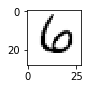

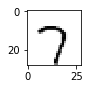

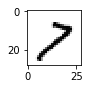

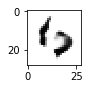

In [91]:
net_auto = AutoCodeNet()
net_auto.load_state_dict(torch.load('model_autoEncode_para.pt'))
net_auto.cuda()
net_auto.eval()

inputs1,inputs2,inputs3 = Variable(torch.from_numpy( train_positive[6:7]).float()).cuda(), \
    Variable(torch.from_numpy( X_train_nor[y_train==7][211:212]).float()).cuda(),\
    Variable(torch.from_numpy( X_train_nor[y_train==7][51:52]).float()).cuda(),
#     outputs = net_auto(inputs)
#     img_show(np.squeeze(outputs.data))
    
middle1 = net_auto.decodeForward(inputs1)
middle2 = net_auto.decodeForward(inputs2)
middle3 = net_auto.decodeForward(inputs3)
# print(middle1.size())
# print(middle1.data[0][2])
# print(middle2.data[0][0])
# imgs_show(np.squeeze(middle1.data),4,6)
# imgs_show(np.squeeze(middle2.data),4,6)
# imgs_show(np.squeeze(middle3.data),4,6)
middle_divide = middle2[:,:,:,:] - middle3[:,:,:,:]
print('negavite middle sum:',torch.sum(middle_divide))
    
middle1[:,:,:,:] = middle1[:,:,:,:]  + 0.7 * middle_divide
    
# print(middle1.data[:,2,:,:])
# print(middle2.data[:,0,:,:])

out = net_auto.encodeforward(middle1)
print(out.size())
# print('out.data = ',out.data)
img_show(np.squeeze(inputs1.data))
img_show(np.squeeze(inputs2.data))

img_show(np.squeeze(inputs3.data))

img_show(np.squeeze(out.data))
# img_show_norm(np.squeeze(out.cpu().data.numpy()))

